# FQE Agent for Behavior Policy

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import random
from pathlib import Path
import sys
import datetime
from tqdm import tqdm

In [2]:
# torch.cuda.is_available()
# torch.cuda.device_count()

In [3]:
# torch.cuda.get_device_name(0)

In [4]:
print("torch.get_num_threads():", torch.get_num_threads())
print("torch.get_num_interop_threads():", torch.get_num_interop_threads())

torch.get_num_threads(): 128
torch.get_num_interop_threads(): 128


In [5]:
# device_id = 0 
# props = torch.cuda.get_device_properties(device_id)
# total_memory = props.total_memory  

# print("Total GPU memory (bytes):", total_memory)
# print("Total GPU memory (GB):", total_memory / 1024**3)

In [6]:
# torch.cuda.empty_cache()

In [7]:
print(torch.version.cuda)

11.8


### Set-up OCRL Agent

In [8]:
curr_path = str(Path().absolute())
parent_path = str(Path().absolute().parent)
sys.path.append(parent_path) # add current terminal path to sys.path
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # obtain current time

In [9]:
class FCN_fqe(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(FCN_fqe, self).__init__()
        self.fc1 = nn.Linear(state_dim, action_dim)

    def forward(self, x):
        x = self.fc1(x)
        return x

In [10]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, obj_cost, con_cost, next_state, next_action, done):

        if not isinstance(con_cost, list) and not isinstance(con_cost, tuple):
            con_cost = [con_cost]

        if len(self.buffer) < self.capacity:
            self.buffer.append(None)

        self.buffer[self.position] = (state, action, obj_cost, con_cost, next_state, next_action, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, obj_cost, con_cost, next_state, next_action, done = zip(*batch)

        con_cost = [list(costs) for costs in zip(*con_cost)]

        return state, action, obj_cost, con_cost, next_state, next_action, done

    def extract(self):
        batch = self.buffer
        state, action, obj_cost, con_cost, next_state, next_action, done = zip(*batch)

        con_cost = [list(costs) for costs in zip(*con_cost)]

        return state, action, obj_cost, con_cost, next_state, next_action, done

    def clear(self):
        self.buffer = []
        self.position = 0

    def __len__(self):
        return len(self.buffer)

In [11]:
class FQE:
    def __init__(self, cfg, state_dim, action_dim, id_stop, eval_agent, loss_func, weight_decay, eval_target = 'obj'):

        self.device = cfg.device

        self.gamma = cfg.gamma

        ### indicate optimal stopping structure or not
        self.id_stop = id_stop

        ### For constraint cost, specify which constraint to evaluate
        if eval_target == 'obj':
            self.lr_fqe = cfg.lr_fqe_obj
        else:
            self.lr_fqe = cfg.lr_fqe_con[eval_target] 

        # define policy Q-Estimator
        self.policy_net = FCN_fqe(state_dim, action_dim).to(self.device)
        # define target Q-Estimator
        self.target_net = FCN_fqe(state_dim, action_dim).to(self.device)

        # initialize target Q-Estimator with policy Q-Estimator
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(param.data)

        self.weight_decay = weight_decay
        self.optimizer = optim.SGD(self.policy_net.parameters(), lr = self.lr_fqe)
        # self.optimizer = optim.SGD([
        #     {'params': self.policy_net.fc1.weight, 'weight_decay': self.weight_decay}, 
        #     {'params': self.policy_net.fc1.bias,   'weight_decay': 0.0}
        #     ], lr = self.lr_fqe)
        
        self.loss = loss_func
        
        # input the evaluation agent
        self.eval_agent = eval_agent

    def update(self, state_batch, action_batch, cost_batch, next_state_batch, next_action_batch, done_batch, disch_batch):

        # We need to evaluate the parameterized policy
        policy_action_batch = self.eval_agent.be_policy(next_action_batch)

        # predicted Q-value using policy Q-network
        q_values = self.policy_net(state_batch).gather(dim = 1, index = action_batch)

        # target Q-value calculated by target Q-network
        next_q_values = self.target_net(next_state_batch).gather(dim = 1, index = policy_action_batch).squeeze(1).detach()
        
        if self.id_stop == 0:
            expected_q_values = cost_batch + self.gamma * next_q_values * (1 - done_batch)
        else:
            expected_q_values = cost_batch + self.gamma * next_q_values * (1 - disch_batch)
            
        loss = self.loss(q_values, expected_q_values.unsqueeze(1))

        # Update reward Q-network by minimizing the above loss function
        self.optimizer.zero_grad()
        loss.backward()
        
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

        return loss.item()

    def avg_Q_value_est(self, state_batch, action_batch):

        # extract the parameterized policy
        policy_action_batch = self.eval_agent.be_policy(action_batch)
        q_value = self.policy_net(state_batch).gather(dim = 1, index = policy_action_batch)

        return q_value.mean().item()

    def save(self, path):
        torch.save(self.policy_net.state_dict(), path + 'FQE_policy_network.pth')
        torch.save(self.target_net.state_dict(), path + 'FQE_target_network.pth')

In [12]:
class Behavior:
    def __init__(self, cfg):
        
        self.device = cfg.device

    def be_policy(self, action_batch):

        policy_action_batch = action_batch

        return policy_action_batch

In [13]:
class RLConfig:
    def __init__(self, algo_name, train_eps, gamma, lr_fqe_obj, constraint_num, lr_fqe_con_list):
        
        self.algo = algo_name  # name of algorithm
        self.train_eps = train_eps  #the number of trainng episodes
        self.gamma = gamma # discount factor
        
        self.constraint_num = constraint_num

        # learning rates
        self.lr_fqe_obj = lr_fqe_obj
        self.lr_fqe_con = [0 for i in range(constraint_num)]

        # constraint threshold
        self.constraint_limit = [0 for i in range(constraint_num)]
        for i in range(constraint_num):
            self.lr_fqe_con[i] = lr_fqe_con_list[i]

        self.train_eps_steps = int(1e3)  # the number of steps in each training episode

        self.batch_size = 256

        self.loss_fqe_1 = nn.MSELoss()
        self.loss_fqe_2 = nn.MSELoss()
        self.loss_fqe_3 = nn.MSELoss()

        self.memory_capacity = int(2e6)  # capacity of Replay Memory

        self.target_update = 100 # update frequency of target net
        self.tau = 0.01

        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check GPU
        self.device = torch.device("cpu")

In [14]:
class DataLoader:
    def __init__(self, cfg, state_id_table, rl_cont_state_table, rl_cont_state_table_scaled, terminal_state):
        self.cfg = cfg
    
        # Load datasets
        self.state_df_id = state_id_table
        self.rl_cont_state_table = rl_cont_state_table
        self.rl_cont_state_table_scaled = rl_cont_state_table_scaled

        self.terminal_state = terminal_state

    def data_buffer_train(self, num_constraint = 2):
        self.train_memory = ReplayBuffer(self.cfg.memory_capacity)

        for i in range(len(self.state_df_id)):
            state = self.rl_cont_state_table_scaled.values[i]
            action = self.state_df_id['discharge_action'].values[i]

            if action == 1.0:
                if self.state_df_id['death'].values[i] == 1.0:
                    if self.state_df_id['discharge_fail'].values[i] == 1.0:
                        done = 0.0
                    else:
                        done = 1.0
                else:
                    if self.state_df_id['discharge_fail'].values[i] == 0.0:
                        done = 1.0
                    else:
                        done = 0.0
            else:
                done = 0.0
            
            obj_cost = self.state_df_id['mortality_costs_md'].values[i]
            con_cost = []
            
            for j in range(num_constraint):
                cost_col = f'con_cost_{j}'  
                if cost_col in self.state_df_id.columns:
                    con_cost.append(self.state_df_id[cost_col].values[i])
                else:
                    con_cost.append(0.0) 

            if done == 0.0:
                idx = self.state_df_id.index[i]
                next_state = self.rl_cont_state_table_scaled.loc[idx + 1].values
                next_action = self.state_df_id['discharge_action'].values[i + 1]
            else:
                next_state = self.terminal_state
                next_action = 1.0

            self.train_memory.push(state, action, obj_cost, con_cost, next_state, next_action, done)

    def data_torch_loader_train(self):
        state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, next_action_batch, done_batch = self.train_memory.sample(self.cfg.batch_size)

        state_batch = torch.tensor(np.array(state_batch), device = self.cfg.device, dtype = torch.float)

        disch_batch = list(action_batch)
        action_batch = torch.tensor(np.array(action_batch), device = self.cfg.device, dtype = torch.long).unsqueeze(1)
        
        obj_cost_batch = torch.tensor(np.array(obj_cost_batch), device = self.cfg.device, dtype = torch.float)
        con_cost_batch = [torch.tensor(np.array(cost), device = self.cfg.device, dtype=torch.float) for cost in con_cost_batch]
        next_state_batch = torch.tensor(np.array(next_state_batch), device = self.cfg.device, dtype = torch.float)

        next_action_batch = torch.tensor(np.array(next_action_batch), device = self.cfg.device, dtype = torch.long).unsqueeze(1)

        done_batch = torch.tensor(np.array(done_batch), device = self.cfg.device, dtype = torch.float)
        disch_batch = torch.tensor(np.array(disch_batch), device = self.cfg.device, dtype = torch.float)

        return state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, next_action_batch, done_batch, disch_batch

In [15]:
class RLTraining:
    def __init__(self, cfg, state_dim, action_dim, data_loader):
        self.cfg = cfg
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.data_loader = data_loader

    def beh_agent_config(self, seed = 1):
        agent_fqi = Behavior(self.cfg)
        torch.manual_seed(seed)
        return agent_fqi

    def fqe_agent_config(self, id_stop, eval_agent, loss_func, weight_decay, eval_target, seed = 2):
        agent_fqe = FQE(self.cfg, self.state_dim, self.action_dim, id_stop, eval_agent, loss_func, weight_decay, eval_target)
        torch.manual_seed(seed)
        return agent_fqe

    def train(self, agent_fqe_obj, agent_fqe_con_list):
        print('Start to train!')
        print(f'Algorithm:{self.cfg.algo}, Device:{self.cfg.device}')

        self.FQE_loss_obj = []
        self.FQE_loss_con = {i: [] for i in range(len(agent_fqe_con_list))}

        self.FQE_est_obj_costs = []
        self.FQE_est_con_costs = {i: [] for i in range(len(agent_fqe_con_list))}

        for k in range(self.cfg.train_eps):
            loss_list_fqe_obj = []
            loss_list_fqe_con = {i: [] for i in range(len(agent_fqe_con_list))}

            fqe_est_obj = []
            fqe_est_con = {i: [] for i in range(len(agent_fqe_con_list))}

            for j in tqdm(range(self.cfg.train_eps_steps)):

                state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, next_action_batch, done_batch, disch_batch = self.data_loader()
                
                # update the policy agent for FQE
                loss_ev_obj = agent_fqe_obj.update(state_batch, action_batch, obj_cost_batch, next_state_batch, next_action_batch, done_batch, disch_batch)
                loss_list_fqe_obj.append(loss_ev_obj)

                for m in range(len(agent_fqe_con_list)):
                    loss_list_fqe_con[m].append(agent_fqe_con_list[m].update(state_batch, action_batch, con_cost_batch[m], next_state_batch, next_action_batch, done_batch, disch_batch))

                avg_q_value_obj = agent_fqe_obj.avg_Q_value_est(state_batch, action_batch)
                fqe_est_obj.append(avg_q_value_obj)

                for m in range(len(agent_fqe_con_list)):
                    fqe_est_con[m].append(agent_fqe_con_list[m].avg_Q_value_est(state_batch, action_batch))
                ######################################################################################
                if j % self.cfg.target_update == 0:
                    ### update the target agent for evaluation agent (FQE objective cost)
                    for target_param, policy_param in zip(agent_fqe_obj.target_net.parameters(), agent_fqe_obj.policy_net.parameters()):
                        target_param.data.copy_(self.cfg.tau * policy_param.data + (1 - self.cfg.tau) * target_param.data)

                    ### update the target agent for evaluation agent (FQE constraint cost)
                    for agent_fqe_con in agent_fqe_con_list:
                        for target_param, policy_param in zip(agent_fqe_con.target_net.parameters(), agent_fqe_con.policy_net.parameters()):
                            target_param.data.copy_(self.cfg.tau * policy_param.data + (1 - self.cfg.tau) * target_param.data)
                #########################################################################################
            print(f"Epoch {k + 1}/{self.cfg.train_eps}")
            print(f"Average FQE estimated objective cost after epoch {k + 1}: {np.mean(fqe_est_obj)}")

            for m in range(len(agent_fqe_con_list)):
                print(f"Average FQE estimated constraint cost of constraint {m} after epoch {k + 1}: {np.mean(fqe_est_con[m])}")

                self.FQE_loss_con[m].append(np.mean(loss_list_fqe_con[m]))
                self.FQE_est_con_costs[m].append(np.mean(fqe_est_con[m]))

            self.FQE_loss_obj.append(np.mean(loss_list_fqe_obj))
            self.FQE_est_obj_costs.append(np.mean(fqe_est_obj))

        print("Complete Training!")

        return self.FQE_loss_obj, self.FQE_loss_con, self.FQE_est_obj_costs, self.FQE_est_con_costs

### Load Data

In [16]:
id_table_train = pd.read_csv('../data_output/id_table_train_v13.csv')
rl_table_train = pd.read_csv('../data_output/rl_table_train_v13.csv')
rl_table_train_scaled = pd.read_csv('../data_output/rl_table_train_scaled_v13.csv')

In [17]:
rl_table_train_scaled.columns

Index(['age', 'M', 'weight', 'Heart Rate', 'Arterial O2 pressure',
       'Hemoglobin', 'Arterial CO2 Pressure', 'PH (Venous)',
       'Hematocrit (serum)', 'WBC', 'Chloride (serum)', 'Creatinine (serum)',
       'Glucose (serum)', 'Magnesium', 'Sodium (serum)', 'PH (Arterial)',
       'Inspired O2 Fraction', 'Arterial Base Excess', 'BUN',
       'Ionized Calcium', 'Total Bilirubin', 'Glucose (whole blood)',
       'Potassium (serum)', 'HCO3 (serum)', 'Platelet Count',
       'Prothrombin time', 'PTT', 'INR', 'Blood Pressure Systolic',
       'Blood Pressure Diastolic', 'Blood Pressure Mean', 'Temperature C',
       'SaO2', 'GCS score', 'Respiratory Rate', 'Tidal Volume',
       'readmission_count'],
      dtype='object')

In [18]:
# rl_table_train.drop(columns = ['readmission_count'], inplace = True)
# rl_table_train_scaled.drop(columns = ['readmission_count'], inplace = True)

In [19]:
rl_table_train_scaled.columns

Index(['age', 'M', 'weight', 'Heart Rate', 'Arterial O2 pressure',
       'Hemoglobin', 'Arterial CO2 Pressure', 'PH (Venous)',
       'Hematocrit (serum)', 'WBC', 'Chloride (serum)', 'Creatinine (serum)',
       'Glucose (serum)', 'Magnesium', 'Sodium (serum)', 'PH (Arterial)',
       'Inspired O2 Fraction', 'Arterial Base Excess', 'BUN',
       'Ionized Calcium', 'Total Bilirubin', 'Glucose (whole blood)',
       'Potassium (serum)', 'HCO3 (serum)', 'Platelet Count',
       'Prothrombin time', 'PTT', 'INR', 'Blood Pressure Systolic',
       'Blood Pressure Diastolic', 'Blood Pressure Mean', 'Temperature C',
       'SaO2', 'GCS score', 'Respiratory Rate', 'Tidal Volume',
       'readmission_count'],
      dtype='object')

In [20]:
rl_table_train_scaled.shape[1]

37

In [21]:
# Counter(rl_table_train_scaled['readmission_count_original'])

In [22]:
# Create a copy of the 'mortality_costs' column
id_table_train['mortality_costs_md'] = id_table_train['mortality_costs'].copy()

# Apply the conditions using vectorized operations
discharge_action_mask = id_table_train['discharge_action'] == 1
death_mask = id_table_train['death'] == 0
discharge_fail_mask = id_table_train['discharge_fail'] == 1

# Update 'mortality_costs_md' based on the conditions
id_table_train.loc[discharge_action_mask & death_mask, 'mortality_costs_md'] = 0
id_table_train.loc[discharge_action_mask & ~death_mask & discharge_fail_mask, 'mortality_costs_md'] = 0

In [23]:
id_table_train['con_cost_0'] = id_table_train['discharge_fail_costs'].copy()
id_table_train['con_cost_1'] = id_table_train['los_costs_scaled'].copy()

In [24]:
id_table_train[['discharge_fail_costs']].describe().T

count      mean       std  min  25%  50%  75%  max
discharge_fail_costs  393856.0  0.017834  0.132348  0.0  0.0  0.0  0.0  1.0

In [25]:
id_table_train[['los_costs_scaled']].describe().T

count      mean       std  min   25%  50%  75%  max
los_costs_scaled  393856.0  0.672376  0.398394  0.0  0.25  1.0  1.0  1.0

In [26]:
cfg = RLConfig(algo_name = 'FQE_Behavior_v1', train_eps = int(5e3), gamma = 1.0, lr_fqe_obj = 5e-4, constraint_num = 2, lr_fqe_con_list = [5e-4, 5e-4])

In [27]:
cfg.device

device(type='cpu')

In [28]:
terminal_state = np.zeros(rl_table_train_scaled.shape[1])

In [29]:
cfg.batch_size

256

In [30]:
train_data_loader = DataLoader(cfg, id_table_train, rl_table_train, rl_table_train_scaled, terminal_state)

In [31]:
train_data_loader.data_buffer_train(num_constraint = 2)

### Training OCRL Agent

In [32]:
torch.set_num_threads(24)
torch.set_num_interop_threads(16)

In [33]:
behavior_training_s1 = RLTraining(cfg, 
                                  state_dim = rl_table_train_scaled.shape[1], 
                                  action_dim = 2, 
                                  data_loader = train_data_loader.data_torch_loader_train)

In [34]:
behavior_agent = behavior_training_s1.beh_agent_config(seed = 1)

### objective cost: mortality risk
agent_fqe_obj_s1 = behavior_training_s1.fqe_agent_config(id_stop = 0, 
                                                         eval_agent = behavior_agent, 
                                                         loss_func = cfg.loss_fqe_1,
                                                         weight_decay = 1e-3,
                                                         eval_target = 'obj', 
                                                         seed = 2) 

### constraint cost 1: readmission risk
agent_fqe_con_rr_s1 = behavior_training_s1.fqe_agent_config(id_stop = 0, 
                                                            eval_agent = behavior_agent, 
                                                            loss_func = cfg.loss_fqe_2,
                                                            weight_decay = 1e-3,
                                                            eval_target = 0, 
                                                            seed = 3)

### constraint cost 2: length-of-stay
agent_fqe_con_los_s1 = behavior_training_s1.fqe_agent_config(id_stop = 0, 
                                                             eval_agent = behavior_agent, 
                                                             loss_func = cfg.loss_fqe_3,
                                                             weight_decay = 1e-3,
                                                             eval_target = 1, 
                                                             seed = 4)

In [35]:
behavior_training_s1.train(agent_fqe_obj_s1, [agent_fqe_con_rr_s1, agent_fqe_con_los_s1])

Start to train!
Algorithm:FQE_Behavior_v1, Device:cpu


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.71it/s]


Epoch 1/5000
Average FQE estimated objective cost after epoch 1: 0.17772973144054413
Average FQE estimated constraint cost of constraint 0 after epoch 1: 0.01602005332731642
Average FQE estimated constraint cost of constraint 1 after epoch 1: 0.14279692292690743


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2/5000
Average FQE estimated objective cost after epoch 2: 0.1722965430468321
Average FQE estimated constraint cost of constraint 0 after epoch 2: 0.0202644102293998
Average FQE estimated constraint cost of constraint 1 after epoch 2: 0.3066077373027801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.14it/s]


Epoch 3/5000
Average FQE estimated objective cost after epoch 3: 0.1694115391075611
Average FQE estimated constraint cost of constraint 0 after epoch 3: 0.02153704599797493
Average FQE estimated constraint cost of constraint 1 after epoch 3: 0.3700928528010845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.90it/s]


Epoch 4/5000
Average FQE estimated objective cost after epoch 4: 0.16897036781907082
Average FQE estimated constraint cost of constraint 0 after epoch 4: 0.02353736911714077
Average FQE estimated constraint cost of constraint 1 after epoch 4: 0.43023616698384287


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.86it/s]


Epoch 5/5000
Average FQE estimated objective cost after epoch 5: 0.168746303409338
Average FQE estimated constraint cost of constraint 0 after epoch 5: 0.026049874063231983
Average FQE estimated constraint cost of constraint 1 after epoch 5: 0.4869576345384121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.03it/s]


Epoch 6/5000
Average FQE estimated objective cost after epoch 6: 0.1685289745479822
Average FQE estimated constraint cost of constraint 0 after epoch 6: 0.027465538454707714
Average FQE estimated constraint cost of constraint 1 after epoch 6: 0.5433536347150802


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.73it/s]


Epoch 7/5000
Average FQE estimated objective cost after epoch 7: 0.1681454546302557
Average FQE estimated constraint cost of constraint 0 after epoch 7: 0.029623155831359327
Average FQE estimated constraint cost of constraint 1 after epoch 7: 0.5994557958841323


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 8/5000
Average FQE estimated objective cost after epoch 8: 0.16727315583825111
Average FQE estimated constraint cost of constraint 0 after epoch 8: 0.03163798073492944
Average FQE estimated constraint cost of constraint 1 after epoch 8: 0.6540374281406403


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 357.49it/s]


Epoch 9/5000
Average FQE estimated objective cost after epoch 9: 0.16708108779788017
Average FQE estimated constraint cost of constraint 0 after epoch 9: 0.03326561725325882
Average FQE estimated constraint cost of constraint 1 after epoch 9: 0.7087394921183586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.21it/s]


Epoch 10/5000
Average FQE estimated objective cost after epoch 10: 0.16651365825533868
Average FQE estimated constraint cost of constraint 0 after epoch 10: 0.03527221818640828
Average FQE estimated constraint cost of constraint 1 after epoch 10: 0.7614245204925537


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.26it/s]


Epoch 11/5000
Average FQE estimated objective cost after epoch 11: 0.16701609158515932
Average FQE estimated constraint cost of constraint 0 after epoch 11: 0.03730943771637976
Average FQE estimated constraint cost of constraint 1 after epoch 11: 0.8122350954413414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 12/5000
Average FQE estimated objective cost after epoch 12: 0.16655462715029717
Average FQE estimated constraint cost of constraint 0 after epoch 12: 0.03873128532990813
Average FQE estimated constraint cost of constraint 1 after epoch 12: 0.867284162223339


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 13/5000
Average FQE estimated objective cost after epoch 13: 0.16650971777737142
Average FQE estimated constraint cost of constraint 0 after epoch 13: 0.04093629623763263
Average FQE estimated constraint cost of constraint 1 after epoch 13: 0.9163037121295929


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.36it/s]


Epoch 14/5000
Average FQE estimated objective cost after epoch 14: 0.16642325086891652
Average FQE estimated constraint cost of constraint 0 after epoch 14: 0.042385691091418265
Average FQE estimated constraint cost of constraint 1 after epoch 14: 0.9644814150333405


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.14it/s]


Epoch 15/5000
Average FQE estimated objective cost after epoch 15: 0.16598725707828998
Average FQE estimated constraint cost of constraint 0 after epoch 15: 0.043822683563455936
Average FQE estimated constraint cost of constraint 1 after epoch 15: 1.0120779885053635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.92it/s]


Epoch 16/5000
Average FQE estimated objective cost after epoch 16: 0.16552900992333888
Average FQE estimated constraint cost of constraint 0 after epoch 16: 0.04579887053370476
Average FQE estimated constraint cost of constraint 1 after epoch 16: 1.0612761031389237


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.84it/s]


Epoch 17/5000
Average FQE estimated objective cost after epoch 17: 0.16529748371243477
Average FQE estimated constraint cost of constraint 0 after epoch 17: 0.04743089544586837
Average FQE estimated constraint cost of constraint 1 after epoch 17: 1.1090705918073653


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.14it/s]


Epoch 18/5000
Average FQE estimated objective cost after epoch 18: 0.1649640806466341
Average FQE estimated constraint cost of constraint 0 after epoch 18: 0.04921357632055879
Average FQE estimated constraint cost of constraint 1 after epoch 18: 1.1540956295728684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.23it/s]


Epoch 19/5000
Average FQE estimated objective cost after epoch 19: 0.16516079975664616
Average FQE estimated constraint cost of constraint 0 after epoch 19: 0.050557095289230344
Average FQE estimated constraint cost of constraint 1 after epoch 19: 1.2030459126234054


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.99it/s]


Epoch 20/5000
Average FQE estimated objective cost after epoch 20: 0.16483063411712645
Average FQE estimated constraint cost of constraint 0 after epoch 20: 0.05241821667924523
Average FQE estimated constraint cost of constraint 1 after epoch 20: 1.247878433227539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.66it/s]


Epoch 21/5000
Average FQE estimated objective cost after epoch 21: 0.16439401531219483
Average FQE estimated constraint cost of constraint 0 after epoch 21: 0.05339878351613879
Average FQE estimated constraint cost of constraint 1 after epoch 21: 1.2940875593423844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.78it/s]


Epoch 22/5000
Average FQE estimated objective cost after epoch 22: 0.16338997648656367
Average FQE estimated constraint cost of constraint 0 after epoch 22: 0.05509089463949204
Average FQE estimated constraint cost of constraint 1 after epoch 22: 1.3368398023843766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.53it/s]


Epoch 23/5000
Average FQE estimated objective cost after epoch 23: 0.16388870491087437
Average FQE estimated constraint cost of constraint 0 after epoch 23: 0.056385643016546964
Average FQE estimated constraint cost of constraint 1 after epoch 23: 1.3789324754476546


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.68it/s]


Epoch 24/5000
Average FQE estimated objective cost after epoch 24: 0.1636219490468502
Average FQE estimated constraint cost of constraint 0 after epoch 24: 0.05815427273884416
Average FQE estimated constraint cost of constraint 1 after epoch 24: 1.4253402503728867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.68it/s]


Epoch 25/5000
Average FQE estimated objective cost after epoch 25: 0.1635387945920229
Average FQE estimated constraint cost of constraint 0 after epoch 25: 0.05982804713025689
Average FQE estimated constraint cost of constraint 1 after epoch 25: 1.4639459571838378


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.21it/s]


Epoch 26/5000
Average FQE estimated objective cost after epoch 26: 0.16358489689230918
Average FQE estimated constraint cost of constraint 0 after epoch 26: 0.061106556978076695
Average FQE estimated constraint cost of constraint 1 after epoch 26: 1.504715094089508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.89it/s]


Epoch 27/5000
Average FQE estimated objective cost after epoch 27: 0.1623138383924961
Average FQE estimated constraint cost of constraint 0 after epoch 27: 0.06270501409843564
Average FQE estimated constraint cost of constraint 1 after epoch 27: 1.5464539839029312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.91it/s]


Epoch 28/5000
Average FQE estimated objective cost after epoch 28: 0.16319408461451532
Average FQE estimated constraint cost of constraint 0 after epoch 28: 0.06403177980333567
Average FQE estimated constraint cost of constraint 1 after epoch 28: 1.5866944340467453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.58it/s]


Epoch 29/5000
Average FQE estimated objective cost after epoch 29: 0.16202749119699
Average FQE estimated constraint cost of constraint 0 after epoch 29: 0.06491992072016001
Average FQE estimated constraint cost of constraint 1 after epoch 29: 1.6299576646089553


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.15it/s]


Epoch 30/5000
Average FQE estimated objective cost after epoch 30: 0.1622527921497822
Average FQE estimated constraint cost of constraint 0 after epoch 30: 0.06683175843954087
Average FQE estimated constraint cost of constraint 1 after epoch 30: 1.6656751445531846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.48it/s]


Epoch 31/5000
Average FQE estimated objective cost after epoch 31: 0.1623866667896509
Average FQE estimated constraint cost of constraint 0 after epoch 31: 0.06814290449395775
Average FQE estimated constraint cost of constraint 1 after epoch 31: 1.7009752877950668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.12it/s]


Epoch 32/5000
Average FQE estimated objective cost after epoch 32: 0.16252816148102284
Average FQE estimated constraint cost of constraint 0 after epoch 32: 0.06933391531184316
Average FQE estimated constraint cost of constraint 1 after epoch 32: 1.7387944635152817


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.16it/s]


Epoch 33/5000
Average FQE estimated objective cost after epoch 33: 0.1618849323540926
Average FQE estimated constraint cost of constraint 0 after epoch 33: 0.07026086279377342
Average FQE estimated constraint cost of constraint 1 after epoch 33: 1.779108558535576


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.38it/s]


Epoch 34/5000
Average FQE estimated objective cost after epoch 34: 0.16205513446033
Average FQE estimated constraint cost of constraint 0 after epoch 34: 0.0716436225399375
Average FQE estimated constraint cost of constraint 1 after epoch 34: 1.81217951464653


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.42it/s]


Epoch 35/5000
Average FQE estimated objective cost after epoch 35: 0.16159399755299092
Average FQE estimated constraint cost of constraint 0 after epoch 35: 0.07322693596035242
Average FQE estimated constraint cost of constraint 1 after epoch 35: 1.8483659408092499


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.69it/s]


Epoch 36/5000
Average FQE estimated objective cost after epoch 36: 0.16175155173242092
Average FQE estimated constraint cost of constraint 0 after epoch 36: 0.07398196226730942
Average FQE estimated constraint cost of constraint 1 after epoch 36: 1.8893702229261398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.64it/s]


Epoch 37/5000
Average FQE estimated objective cost after epoch 37: 0.1618740106076002
Average FQE estimated constraint cost of constraint 0 after epoch 37: 0.0753595459125936
Average FQE estimated constraint cost of constraint 1 after epoch 37: 1.9139082981348037


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.75it/s]


Epoch 38/5000
Average FQE estimated objective cost after epoch 38: 0.16049293646216392
Average FQE estimated constraint cost of constraint 0 after epoch 38: 0.07657569040358067
Average FQE estimated constraint cost of constraint 1 after epoch 38: 1.9530646965503693


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.62it/s]


Epoch 39/5000
Average FQE estimated objective cost after epoch 39: 0.16095055970549582
Average FQE estimated constraint cost of constraint 0 after epoch 39: 0.07818296997249126
Average FQE estimated constraint cost of constraint 1 after epoch 39: 1.9850556498765946


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.07it/s]


Epoch 40/5000
Average FQE estimated objective cost after epoch 40: 0.16029472471773623
Average FQE estimated constraint cost of constraint 0 after epoch 40: 0.07925420914590359
Average FQE estimated constraint cost of constraint 1 after epoch 40: 2.0177287300825117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.95it/s]


Epoch 41/5000
Average FQE estimated objective cost after epoch 41: 0.16017583310604094
Average FQE estimated constraint cost of constraint 0 after epoch 41: 0.08046617704629898
Average FQE estimated constraint cost of constraint 1 after epoch 41: 2.04977484190464


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.42it/s]


Epoch 42/5000
Average FQE estimated objective cost after epoch 42: 0.15995598039031028
Average FQE estimated constraint cost of constraint 0 after epoch 42: 0.0813961867429316
Average FQE estimated constraint cost of constraint 1 after epoch 42: 2.0871457422971726


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.26it/s]


Epoch 43/5000
Average FQE estimated objective cost after epoch 43: 0.16001295402646065
Average FQE estimated constraint cost of constraint 0 after epoch 43: 0.0822779412344098
Average FQE estimated constraint cost of constraint 1 after epoch 43: 2.1197762640714646


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.96it/s]


Epoch 44/5000
Average FQE estimated objective cost after epoch 44: 0.15990108174085618
Average FQE estimated constraint cost of constraint 0 after epoch 44: 0.08369093069434166
Average FQE estimated constraint cost of constraint 1 after epoch 44: 2.14586617064476


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.03it/s]


Epoch 45/5000
Average FQE estimated objective cost after epoch 45: 0.15944056628644465
Average FQE estimated constraint cost of constraint 0 after epoch 45: 0.08441645538061857
Average FQE estimated constraint cost of constraint 1 after epoch 45: 2.1807470039129258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.48it/s]


Epoch 46/5000
Average FQE estimated objective cost after epoch 46: 0.1596965710669756
Average FQE estimated constraint cost of constraint 0 after epoch 46: 0.08489799889177084
Average FQE estimated constraint cost of constraint 1 after epoch 46: 2.20908017539978


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.08it/s]


Epoch 47/5000
Average FQE estimated objective cost after epoch 47: 0.15965725684165955
Average FQE estimated constraint cost of constraint 0 after epoch 47: 0.08646277209371328
Average FQE estimated constraint cost of constraint 1 after epoch 47: 2.2389537162780764


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.28it/s]


Epoch 48/5000
Average FQE estimated objective cost after epoch 48: 0.15916788664460182
Average FQE estimated constraint cost of constraint 0 after epoch 48: 0.0875552718937397
Average FQE estimated constraint cost of constraint 1 after epoch 48: 2.2692759952545165


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.92it/s]


Epoch 49/5000
Average FQE estimated objective cost after epoch 49: 0.1591281047463417
Average FQE estimated constraint cost of constraint 0 after epoch 49: 0.08846940219402313
Average FQE estimated constraint cost of constraint 1 after epoch 49: 2.297701542139053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.75it/s]


Epoch 50/5000
Average FQE estimated objective cost after epoch 50: 0.1588566419929266
Average FQE estimated constraint cost of constraint 0 after epoch 50: 0.08981267998367548
Average FQE estimated constraint cost of constraint 1 after epoch 50: 2.324842501401901


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.74it/s]


Epoch 51/5000
Average FQE estimated objective cost after epoch 51: 0.15941372640430929
Average FQE estimated constraint cost of constraint 0 after epoch 51: 0.0908686639815569
Average FQE estimated constraint cost of constraint 1 after epoch 51: 2.3565846779346464


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.67it/s]


Epoch 52/5000
Average FQE estimated objective cost after epoch 52: 0.1588584483265877
Average FQE estimated constraint cost of constraint 0 after epoch 52: 0.09159417577832937
Average FQE estimated constraint cost of constraint 1 after epoch 52: 2.3846961369514466


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.68it/s]


Epoch 53/5000
Average FQE estimated objective cost after epoch 53: 0.15857589472830297
Average FQE estimated constraint cost of constraint 0 after epoch 53: 0.09251354388147592
Average FQE estimated constraint cost of constraint 1 after epoch 53: 2.4043881306648256


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.32it/s]


Epoch 54/5000
Average FQE estimated objective cost after epoch 54: 0.15810189375281333
Average FQE estimated constraint cost of constraint 0 after epoch 54: 0.09326937770098448
Average FQE estimated constraint cost of constraint 1 after epoch 54: 2.4404775578975677


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.77it/s]


Epoch 55/5000
Average FQE estimated objective cost after epoch 55: 0.15806656531989574
Average FQE estimated constraint cost of constraint 0 after epoch 55: 0.09469327905029058
Average FQE estimated constraint cost of constraint 1 after epoch 55: 2.463623073339462


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 56/5000
Average FQE estimated objective cost after epoch 56: 0.15838816744089126
Average FQE estimated constraint cost of constraint 0 after epoch 56: 0.09499251429736615
Average FQE estimated constraint cost of constraint 1 after epoch 56: 2.487348420858383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.98it/s]


Epoch 57/5000
Average FQE estimated objective cost after epoch 57: 0.15774372658133506
Average FQE estimated constraint cost of constraint 0 after epoch 57: 0.09557543584704399
Average FQE estimated constraint cost of constraint 1 after epoch 57: 2.519017767906189


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.97it/s]


Epoch 58/5000
Average FQE estimated objective cost after epoch 58: 0.15743193316459655
Average FQE estimated constraint cost of constraint 0 after epoch 58: 0.0965592407733202
Average FQE estimated constraint cost of constraint 1 after epoch 58: 2.546396511077881


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.54it/s]


Epoch 59/5000
Average FQE estimated objective cost after epoch 59: 0.15728114660084247
Average FQE estimated constraint cost of constraint 0 after epoch 59: 0.09765790992975235
Average FQE estimated constraint cost of constraint 1 after epoch 59: 2.567953719854355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.84it/s]


Epoch 60/5000
Average FQE estimated objective cost after epoch 60: 0.15713179747760295
Average FQE estimated constraint cost of constraint 0 after epoch 60: 0.09824680700898171
Average FQE estimated constraint cost of constraint 1 after epoch 60: 2.5959498300552366


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.55it/s]


Epoch 61/5000
Average FQE estimated objective cost after epoch 61: 0.1569357974231243
Average FQE estimated constraint cost of constraint 0 after epoch 61: 0.09925647652894258
Average FQE estimated constraint cost of constraint 1 after epoch 61: 2.6137726182937624


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.02it/s]


Epoch 62/5000
Average FQE estimated objective cost after epoch 62: 0.157145456969738
Average FQE estimated constraint cost of constraint 0 after epoch 62: 0.09970545788109303
Average FQE estimated constraint cost of constraint 1 after epoch 62: 2.6384848809242247


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.72it/s]


Epoch 63/5000
Average FQE estimated objective cost after epoch 63: 0.1570832461118698
Average FQE estimated constraint cost of constraint 0 after epoch 63: 0.10064633207023144
Average FQE estimated constraint cost of constraint 1 after epoch 63: 2.660825079917908


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.03it/s]


Epoch 64/5000
Average FQE estimated objective cost after epoch 64: 0.15715514089167118
Average FQE estimated constraint cost of constraint 0 after epoch 64: 0.1018481797426939
Average FQE estimated constraint cost of constraint 1 after epoch 64: 2.685893827676773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.35it/s]


Epoch 65/5000
Average FQE estimated objective cost after epoch 65: 0.15660538266599178
Average FQE estimated constraint cost of constraint 0 after epoch 65: 0.1024397655799985
Average FQE estimated constraint cost of constraint 1 after epoch 65: 2.7164627339839935


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.40it/s]


Epoch 66/5000
Average FQE estimated objective cost after epoch 66: 0.15697781333327293
Average FQE estimated constraint cost of constraint 0 after epoch 66: 0.10321740263700485
Average FQE estimated constraint cost of constraint 1 after epoch 66: 2.7379604847431183


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.39it/s]


Epoch 67/5000
Average FQE estimated objective cost after epoch 67: 0.15680125492811203
Average FQE estimated constraint cost of constraint 0 after epoch 67: 0.10396785432845354
Average FQE estimated constraint cost of constraint 1 after epoch 67: 2.757348769903183


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.64it/s]


Epoch 68/5000
Average FQE estimated objective cost after epoch 68: 0.1563320373147726
Average FQE estimated constraint cost of constraint 0 after epoch 68: 0.10470897071063519
Average FQE estimated constraint cost of constraint 1 after epoch 68: 2.779500368118286


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 346.25it/s]


Epoch 69/5000
Average FQE estimated objective cost after epoch 69: 0.15668365907669068
Average FQE estimated constraint cost of constraint 0 after epoch 69: 0.10546854220330715
Average FQE estimated constraint cost of constraint 1 after epoch 69: 2.798961353302002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.35it/s]


Epoch 70/5000
Average FQE estimated objective cost after epoch 70: 0.15636103768646717
Average FQE estimated constraint cost of constraint 0 after epoch 70: 0.10640110378712415
Average FQE estimated constraint cost of constraint 1 after epoch 70: 2.8222418003082277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.95it/s]


Epoch 71/5000
Average FQE estimated objective cost after epoch 71: 0.1565065177232027
Average FQE estimated constraint cost of constraint 0 after epoch 71: 0.10676127118617296
Average FQE estimated constraint cost of constraint 1 after epoch 71: 2.843725384473801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.72it/s]


Epoch 72/5000
Average FQE estimated objective cost after epoch 72: 0.1565210544168949
Average FQE estimated constraint cost of constraint 0 after epoch 72: 0.10749656333774328
Average FQE estimated constraint cost of constraint 1 after epoch 72: 2.8624847345352173


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.17it/s]


Epoch 73/5000
Average FQE estimated objective cost after epoch 73: 0.15581065042316913
Average FQE estimated constraint cost of constraint 0 after epoch 73: 0.10814869537949562
Average FQE estimated constraint cost of constraint 1 after epoch 73: 2.886912031888962


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.87it/s]


Epoch 74/5000
Average FQE estimated objective cost after epoch 74: 0.15641974699497224
Average FQE estimated constraint cost of constraint 0 after epoch 74: 0.10864990888535976
Average FQE estimated constraint cost of constraint 1 after epoch 74: 2.9061904332637787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.24it/s]


Epoch 75/5000
Average FQE estimated objective cost after epoch 75: 0.15601273894309997
Average FQE estimated constraint cost of constraint 0 after epoch 75: 0.11014897409081459
Average FQE estimated constraint cost of constraint 1 after epoch 75: 2.9164555094242095


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.75it/s]


Epoch 76/5000
Average FQE estimated objective cost after epoch 76: 0.15626246465742588
Average FQE estimated constraint cost of constraint 0 after epoch 76: 0.11047663082182407
Average FQE estimated constraint cost of constraint 1 after epoch 76: 2.9366509561538696


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.95it/s]


Epoch 77/5000
Average FQE estimated objective cost after epoch 77: 0.1553430973291397
Average FQE estimated constraint cost of constraint 0 after epoch 77: 0.11079165475070477
Average FQE estimated constraint cost of constraint 1 after epoch 77: 2.965327556371689


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.61it/s]


Epoch 78/5000
Average FQE estimated objective cost after epoch 78: 0.15601844030618667
Average FQE estimated constraint cost of constraint 0 after epoch 78: 0.1113407377898693
Average FQE estimated constraint cost of constraint 1 after epoch 78: 2.985843398809433


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.52it/s]


Epoch 79/5000
Average FQE estimated objective cost after epoch 79: 0.1561352308690548
Average FQE estimated constraint cost of constraint 0 after epoch 79: 0.112138831846416
Average FQE estimated constraint cost of constraint 1 after epoch 79: 3.0020464899539947


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.06it/s]


Epoch 80/5000
Average FQE estimated objective cost after epoch 80: 0.15581872320175172
Average FQE estimated constraint cost of constraint 0 after epoch 80: 0.11251962773501872
Average FQE estimated constraint cost of constraint 1 after epoch 80: 3.02218310546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.57it/s]


Epoch 81/5000
Average FQE estimated objective cost after epoch 81: 0.15541563229262828
Average FQE estimated constraint cost of constraint 0 after epoch 81: 0.11362358005344868
Average FQE estimated constraint cost of constraint 1 after epoch 81: 3.0337305705547335


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.13it/s]


Epoch 82/5000
Average FQE estimated objective cost after epoch 82: 0.1552929699420929
Average FQE estimated constraint cost of constraint 0 after epoch 82: 0.11416618076711893
Average FQE estimated constraint cost of constraint 1 after epoch 82: 3.0473323080539703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.45it/s]


Epoch 83/5000
Average FQE estimated objective cost after epoch 83: 0.15504325492680074
Average FQE estimated constraint cost of constraint 0 after epoch 83: 0.11460313259065151
Average FQE estimated constraint cost of constraint 1 after epoch 83: 3.0764020071029665


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 291.48it/s]


Epoch 84/5000
Average FQE estimated objective cost after epoch 84: 0.1557346020936966
Average FQE estimated constraint cost of constraint 0 after epoch 84: 0.11517269378900528
Average FQE estimated constraint cost of constraint 1 after epoch 84: 3.083623349905014


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.81it/s]


Epoch 85/5000
Average FQE estimated objective cost after epoch 85: 0.1548075579404831
Average FQE estimated constraint cost of constraint 0 after epoch 85: 0.11536486955732107
Average FQE estimated constraint cost of constraint 1 after epoch 85: 3.103834396123886


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.08it/s]


Epoch 86/5000
Average FQE estimated objective cost after epoch 86: 0.1551156301945448
Average FQE estimated constraint cost of constraint 0 after epoch 86: 0.11601163259893656
Average FQE estimated constraint cost of constraint 1 after epoch 86: 3.1199375681877135


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.84it/s]


Epoch 87/5000
Average FQE estimated objective cost after epoch 87: 0.15550310926139355
Average FQE estimated constraint cost of constraint 0 after epoch 87: 0.1167568014934659
Average FQE estimated constraint cost of constraint 1 after epoch 87: 3.144583173751831


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 341.23it/s]


Epoch 88/5000
Average FQE estimated objective cost after epoch 88: 0.1553406409174204
Average FQE estimated constraint cost of constraint 0 after epoch 88: 0.1175552982017398
Average FQE estimated constraint cost of constraint 1 after epoch 88: 3.1591650631427766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.44it/s]


Epoch 89/5000
Average FQE estimated objective cost after epoch 89: 0.15454740931093694
Average FQE estimated constraint cost of constraint 0 after epoch 89: 0.11768702144175767
Average FQE estimated constraint cost of constraint 1 after epoch 89: 3.177902343273163


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.49it/s]


Epoch 90/5000
Average FQE estimated objective cost after epoch 90: 0.15498335024714469
Average FQE estimated constraint cost of constraint 0 after epoch 90: 0.11835648067295551
Average FQE estimated constraint cost of constraint 1 after epoch 90: 3.1951679337024688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.83it/s]


Epoch 91/5000
Average FQE estimated objective cost after epoch 91: 0.1548432579189539
Average FQE estimated constraint cost of constraint 0 after epoch 91: 0.11854010174423456
Average FQE estimated constraint cost of constraint 1 after epoch 91: 3.217663609743118


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.00it/s]


Epoch 92/5000
Average FQE estimated objective cost after epoch 92: 0.1542110204845667
Average FQE estimated constraint cost of constraint 0 after epoch 92: 0.11935704682767391
Average FQE estimated constraint cost of constraint 1 after epoch 92: 3.2275894072055817


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.91it/s]


Epoch 93/5000
Average FQE estimated objective cost after epoch 93: 0.1546170763671398
Average FQE estimated constraint cost of constraint 0 after epoch 93: 0.12014933069795371
Average FQE estimated constraint cost of constraint 1 after epoch 93: 3.2349158551692963


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.35it/s]


Epoch 94/5000
Average FQE estimated objective cost after epoch 94: 0.15402295231819152
Average FQE estimated constraint cost of constraint 0 after epoch 94: 0.12038440000265836
Average FQE estimated constraint cost of constraint 1 after epoch 94: 3.251901910305023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.04it/s]


Epoch 95/5000
Average FQE estimated objective cost after epoch 95: 0.15409691274166107
Average FQE estimated constraint cost of constraint 0 after epoch 95: 0.12094329591840505
Average FQE estimated constraint cost of constraint 1 after epoch 95: 3.265733725309372


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 96/5000
Average FQE estimated objective cost after epoch 96: 0.15456218951940537
Average FQE estimated constraint cost of constraint 0 after epoch 96: 0.1214911767989397
Average FQE estimated constraint cost of constraint 1 after epoch 96: 3.2880837433338166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.71it/s]


Epoch 97/5000
Average FQE estimated objective cost after epoch 97: 0.15454202142357826
Average FQE estimated constraint cost of constraint 0 after epoch 97: 0.12224054206907749
Average FQE estimated constraint cost of constraint 1 after epoch 97: 3.29998397397995


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.23it/s]


Epoch 98/5000
Average FQE estimated objective cost after epoch 98: 0.15430576319992542
Average FQE estimated constraint cost of constraint 0 after epoch 98: 0.12252124289423227
Average FQE estimated constraint cost of constraint 1 after epoch 98: 3.3085947732925414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.97it/s]


Epoch 99/5000
Average FQE estimated objective cost after epoch 99: 0.15408687706291677
Average FQE estimated constraint cost of constraint 0 after epoch 99: 0.12289920149743556
Average FQE estimated constraint cost of constraint 1 after epoch 99: 3.327104035139084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.51it/s]


Epoch 100/5000
Average FQE estimated objective cost after epoch 100: 0.1545638182014227
Average FQE estimated constraint cost of constraint 0 after epoch 100: 0.12307479441910982
Average FQE estimated constraint cost of constraint 1 after epoch 100: 3.346497086286545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.72it/s]


Epoch 101/5000
Average FQE estimated objective cost after epoch 101: 0.15388712286949158
Average FQE estimated constraint cost of constraint 0 after epoch 101: 0.12337036245316267
Average FQE estimated constraint cost of constraint 1 after epoch 101: 3.3548484122753144


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.55it/s]


Epoch 102/5000
Average FQE estimated objective cost after epoch 102: 0.1538444366902113
Average FQE estimated constraint cost of constraint 0 after epoch 102: 0.1242099766805768
Average FQE estimated constraint cost of constraint 1 after epoch 102: 3.3695444860458372


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.35it/s]


Epoch 103/5000
Average FQE estimated objective cost after epoch 103: 0.15393335098028182
Average FQE estimated constraint cost of constraint 0 after epoch 103: 0.1247259391695261
Average FQE estimated constraint cost of constraint 1 after epoch 103: 3.3851052105426787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.25it/s]


Epoch 104/5000
Average FQE estimated objective cost after epoch 104: 0.15400971379876136
Average FQE estimated constraint cost of constraint 0 after epoch 104: 0.1252580073699355
Average FQE estimated constraint cost of constraint 1 after epoch 104: 3.3983367426395414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.70it/s]


Epoch 105/5000
Average FQE estimated objective cost after epoch 105: 0.15366235564649106
Average FQE estimated constraint cost of constraint 0 after epoch 105: 0.12563687977194787
Average FQE estimated constraint cost of constraint 1 after epoch 105: 3.406817053556442


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.93it/s]


Epoch 106/5000
Average FQE estimated objective cost after epoch 106: 0.15318659833818674
Average FQE estimated constraint cost of constraint 0 after epoch 106: 0.12598992279171944
Average FQE estimated constraint cost of constraint 1 after epoch 106: 3.429594871044159


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.49it/s]


Epoch 107/5000
Average FQE estimated objective cost after epoch 107: 0.1536157602891326
Average FQE estimated constraint cost of constraint 0 after epoch 107: 0.12645813363790512
Average FQE estimated constraint cost of constraint 1 after epoch 107: 3.4320663056373597


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 291.69it/s]


Epoch 108/5000
Average FQE estimated objective cost after epoch 108: 0.1541367429792881
Average FQE estimated constraint cost of constraint 0 after epoch 108: 0.12678145682811737
Average FQE estimated constraint cost of constraint 1 after epoch 108: 3.4496962032318117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.92it/s]


Epoch 109/5000
Average FQE estimated objective cost after epoch 109: 0.15347887301445007
Average FQE estimated constraint cost of constraint 0 after epoch 109: 0.12709594149142503
Average FQE estimated constraint cost of constraint 1 after epoch 109: 3.460567125797272


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.74it/s]


Epoch 110/5000
Average FQE estimated objective cost after epoch 110: 0.1538665901273489
Average FQE estimated constraint cost of constraint 0 after epoch 110: 0.12791273664683103
Average FQE estimated constraint cost of constraint 1 after epoch 110: 3.47984743142128


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.91it/s]


Epoch 111/5000
Average FQE estimated objective cost after epoch 111: 0.1540037799924612
Average FQE estimated constraint cost of constraint 0 after epoch 111: 0.12813208179175853
Average FQE estimated constraint cost of constraint 1 after epoch 111: 3.483464607715607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.50it/s]


Epoch 112/5000
Average FQE estimated objective cost after epoch 112: 0.1535263563245535
Average FQE estimated constraint cost of constraint 0 after epoch 112: 0.1284360638856888
Average FQE estimated constraint cost of constraint 1 after epoch 112: 3.488162361621857


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.68it/s]


Epoch 113/5000
Average FQE estimated objective cost after epoch 113: 0.1539013595879078
Average FQE estimated constraint cost of constraint 0 after epoch 113: 0.1289086227118969
Average FQE estimated constraint cost of constraint 1 after epoch 113: 3.5138278186321257


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.53it/s]


Epoch 114/5000
Average FQE estimated objective cost after epoch 114: 0.15364759027957917
Average FQE estimated constraint cost of constraint 0 after epoch 114: 0.12912841682881118
Average FQE estimated constraint cost of constraint 1 after epoch 114: 3.530053060770035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.03it/s]


Epoch 115/5000
Average FQE estimated objective cost after epoch 115: 0.1533369856029749
Average FQE estimated constraint cost of constraint 0 after epoch 115: 0.1293420024588704
Average FQE estimated constraint cost of constraint 1 after epoch 115: 3.529695118188858


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.17it/s]


Epoch 116/5000
Average FQE estimated objective cost after epoch 116: 0.153365940451622
Average FQE estimated constraint cost of constraint 0 after epoch 116: 0.13016608265787363
Average FQE estimated constraint cost of constraint 1 after epoch 116: 3.534099364042282


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.23it/s]


Epoch 117/5000
Average FQE estimated objective cost after epoch 117: 0.1527817635089159
Average FQE estimated constraint cost of constraint 0 after epoch 117: 0.1304088862836361
Average FQE estimated constraint cost of constraint 1 after epoch 117: 3.557032793045044


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.22it/s]


Epoch 118/5000
Average FQE estimated objective cost after epoch 118: 0.15370435035973787
Average FQE estimated constraint cost of constraint 0 after epoch 118: 0.13122282246500253
Average FQE estimated constraint cost of constraint 1 after epoch 118: 3.5623276808261872


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.28it/s]


Epoch 119/5000
Average FQE estimated objective cost after epoch 119: 0.15370734944939612
Average FQE estimated constraint cost of constraint 0 after epoch 119: 0.13128988149017096
Average FQE estimated constraint cost of constraint 1 after epoch 119: 3.5713024764060974


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.20it/s]


Epoch 120/5000
Average FQE estimated objective cost after epoch 120: 0.1532377168238163
Average FQE estimated constraint cost of constraint 0 after epoch 120: 0.13148024698346852
Average FQE estimated constraint cost of constraint 1 after epoch 120: 3.5883247520923613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.41it/s]


Epoch 121/5000
Average FQE estimated objective cost after epoch 121: 0.15336606575548647
Average FQE estimated constraint cost of constraint 0 after epoch 121: 0.13200562439858912
Average FQE estimated constraint cost of constraint 1 after epoch 121: 3.5930804786682127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.91it/s]


Epoch 122/5000
Average FQE estimated objective cost after epoch 122: 0.1533558965921402
Average FQE estimated constraint cost of constraint 0 after epoch 122: 0.1325503113567829
Average FQE estimated constraint cost of constraint 1 after epoch 122: 3.6141455001831053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.58it/s]


Epoch 123/5000
Average FQE estimated objective cost after epoch 123: 0.15338626858592033
Average FQE estimated constraint cost of constraint 0 after epoch 123: 0.1325194779038429
Average FQE estimated constraint cost of constraint 1 after epoch 123: 3.6231143233776093


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.30it/s]


Epoch 124/5000
Average FQE estimated objective cost after epoch 124: 0.15377074885368347
Average FQE estimated constraint cost of constraint 0 after epoch 124: 0.13324381881952285
Average FQE estimated constraint cost of constraint 1 after epoch 124: 3.6372985951900483


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.78it/s]


Epoch 125/5000
Average FQE estimated objective cost after epoch 125: 0.15280486965179443
Average FQE estimated constraint cost of constraint 0 after epoch 125: 0.13346358039975167
Average FQE estimated constraint cost of constraint 1 after epoch 125: 3.6464118337631226


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.81it/s]


Epoch 126/5000
Average FQE estimated objective cost after epoch 126: 0.15328671368956565
Average FQE estimated constraint cost of constraint 0 after epoch 126: 0.13372357557713985
Average FQE estimated constraint cost of constraint 1 after epoch 126: 3.653022293329239


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.19it/s]


Epoch 127/5000
Average FQE estimated objective cost after epoch 127: 0.1529258133918047
Average FQE estimated constraint cost of constraint 0 after epoch 127: 0.13389161095023155
Average FQE estimated constraint cost of constraint 1 after epoch 127: 3.668864419460297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.20it/s]


Epoch 128/5000
Average FQE estimated objective cost after epoch 128: 0.1531044770926237
Average FQE estimated constraint cost of constraint 0 after epoch 128: 0.1344002570360899
Average FQE estimated constraint cost of constraint 1 after epoch 128: 3.6697267229557036


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.60it/s]


Epoch 129/5000
Average FQE estimated objective cost after epoch 129: 0.153252789914608
Average FQE estimated constraint cost of constraint 0 after epoch 129: 0.13480155315995215
Average FQE estimated constraint cost of constraint 1 after epoch 129: 3.6871150135993958


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.78it/s]


Epoch 130/5000
Average FQE estimated objective cost after epoch 130: 0.15357046088576318
Average FQE estimated constraint cost of constraint 0 after epoch 130: 0.1352290160804987
Average FQE estimated constraint cost of constraint 1 after epoch 130: 3.698492996454239


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.79it/s]


Epoch 131/5000
Average FQE estimated objective cost after epoch 131: 0.15299849498271942
Average FQE estimated constraint cost of constraint 0 after epoch 131: 0.1353827712535858
Average FQE estimated constraint cost of constraint 1 after epoch 131: 3.69756355881691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.06it/s]


Epoch 132/5000
Average FQE estimated objective cost after epoch 132: 0.15301542337238788
Average FQE estimated constraint cost of constraint 0 after epoch 132: 0.13530428755283355
Average FQE estimated constraint cost of constraint 1 after epoch 132: 3.7228418438434603


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.89it/s]


Epoch 133/5000
Average FQE estimated objective cost after epoch 133: 0.1529423057436943
Average FQE estimated constraint cost of constraint 0 after epoch 133: 0.13569028580188752
Average FQE estimated constraint cost of constraint 1 after epoch 133: 3.7204888594150543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.07it/s]


Epoch 134/5000
Average FQE estimated objective cost after epoch 134: 0.1536344880387187
Average FQE estimated constraint cost of constraint 0 after epoch 134: 0.1361345736756921
Average FQE estimated constraint cost of constraint 1 after epoch 134: 3.732206337451935


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.43it/s]


Epoch 135/5000
Average FQE estimated objective cost after epoch 135: 0.15297470055520535
Average FQE estimated constraint cost of constraint 0 after epoch 135: 0.1364977495074272
Average FQE estimated constraint cost of constraint 1 after epoch 135: 3.7456047706604005


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.69it/s]


Epoch 136/5000
Average FQE estimated objective cost after epoch 136: 0.15281507889926432
Average FQE estimated constraint cost of constraint 0 after epoch 136: 0.136728623136878
Average FQE estimated constraint cost of constraint 1 after epoch 136: 3.756674761772156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.84it/s]


Epoch 137/5000
Average FQE estimated objective cost after epoch 137: 0.15288728230446577
Average FQE estimated constraint cost of constraint 0 after epoch 137: 0.13711350201070308
Average FQE estimated constraint cost of constraint 1 after epoch 137: 3.763437281847


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.96it/s]


Epoch 138/5000
Average FQE estimated objective cost after epoch 138: 0.15318873259425164
Average FQE estimated constraint cost of constraint 0 after epoch 138: 0.13741097548604012
Average FQE estimated constraint cost of constraint 1 after epoch 138: 3.7695569458007814


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.93it/s]


Epoch 139/5000
Average FQE estimated objective cost after epoch 139: 0.15265081840753555
Average FQE estimated constraint cost of constraint 0 after epoch 139: 0.1376949318051338
Average FQE estimated constraint cost of constraint 1 after epoch 139: 3.785226761102676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.10it/s]


Epoch 140/5000
Average FQE estimated objective cost after epoch 140: 0.15292038300633432
Average FQE estimated constraint cost of constraint 0 after epoch 140: 0.13797540816664697
Average FQE estimated constraint cost of constraint 1 after epoch 140: 3.7907508521080016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.69it/s]


Epoch 141/5000
Average FQE estimated objective cost after epoch 141: 0.1529129407852888
Average FQE estimated constraint cost of constraint 0 after epoch 141: 0.13791511999070644
Average FQE estimated constraint cost of constraint 1 after epoch 141: 3.8042945117950437


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 142/5000
Average FQE estimated objective cost after epoch 142: 0.15251770989596844
Average FQE estimated constraint cost of constraint 0 after epoch 142: 0.13824795864522457
Average FQE estimated constraint cost of constraint 1 after epoch 142: 3.8109489002227783


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 143/5000
Average FQE estimated objective cost after epoch 143: 0.1531629603803158
Average FQE estimated constraint cost of constraint 0 after epoch 143: 0.13859811571240424
Average FQE estimated constraint cost of constraint 1 after epoch 143: 3.8220186464786527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 144/5000
Average FQE estimated objective cost after epoch 144: 0.15279507690668107
Average FQE estimated constraint cost of constraint 0 after epoch 144: 0.13880445517599582
Average FQE estimated constraint cost of constraint 1 after epoch 144: 3.83409424495697


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 145/5000
Average FQE estimated objective cost after epoch 145: 0.15247047332674266
Average FQE estimated constraint cost of constraint 0 after epoch 145: 0.13887289084494114
Average FQE estimated constraint cost of constraint 1 after epoch 145: 3.8389376745223998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 146/5000
Average FQE estimated objective cost after epoch 146: 0.15243935710191728
Average FQE estimated constraint cost of constraint 0 after epoch 146: 0.139088285446167
Average FQE estimated constraint cost of constraint 1 after epoch 146: 3.847634721279144


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 147/5000
Average FQE estimated objective cost after epoch 147: 0.15251510579884053
Average FQE estimated constraint cost of constraint 0 after epoch 147: 0.13940581522881984
Average FQE estimated constraint cost of constraint 1 after epoch 147: 3.84836613202095


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.17it/s]


Epoch 148/5000
Average FQE estimated objective cost after epoch 148: 0.15299757574498654
Average FQE estimated constraint cost of constraint 0 after epoch 148: 0.13985230346024036
Average FQE estimated constraint cost of constraint 1 after epoch 148: 3.854860968828201


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 149/5000
Average FQE estimated objective cost after epoch 149: 0.15215649726986885
Average FQE estimated constraint cost of constraint 0 after epoch 149: 0.14005821128189563
Average FQE estimated constraint cost of constraint 1 after epoch 149: 3.871055469036102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 150/5000
Average FQE estimated objective cost after epoch 150: 0.1532830385416746
Average FQE estimated constraint cost of constraint 0 after epoch 150: 0.14025740613043308
Average FQE estimated constraint cost of constraint 1 after epoch 150: 3.8723504350185394


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 151/5000
Average FQE estimated objective cost after epoch 151: 0.15268141194432974
Average FQE estimated constraint cost of constraint 0 after epoch 151: 0.1405376642793417
Average FQE estimated constraint cost of constraint 1 after epoch 151: 3.884813983678818


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 152/5000
Average FQE estimated objective cost after epoch 152: 0.15292877257615328
Average FQE estimated constraint cost of constraint 0 after epoch 152: 0.140628090724349
Average FQE estimated constraint cost of constraint 1 after epoch 152: 3.8897897922992706


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.53it/s]


Epoch 153/5000
Average FQE estimated objective cost after epoch 153: 0.15220596872270106
Average FQE estimated constraint cost of constraint 0 after epoch 153: 0.1408628272116184
Average FQE estimated constraint cost of constraint 1 after epoch 153: 3.898470111608505


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 154/5000
Average FQE estimated objective cost after epoch 154: 0.15200726130604744
Average FQE estimated constraint cost of constraint 0 after epoch 154: 0.1411279599517584
Average FQE estimated constraint cost of constraint 1 after epoch 154: 3.90039737868309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 155/5000
Average FQE estimated objective cost after epoch 155: 0.1528499106615782
Average FQE estimated constraint cost of constraint 0 after epoch 155: 0.14159770826995371
Average FQE estimated constraint cost of constraint 1 after epoch 155: 3.9077857849597932


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.81it/s]


Epoch 156/5000
Average FQE estimated objective cost after epoch 156: 0.15322701589018106
Average FQE estimated constraint cost of constraint 0 after epoch 156: 0.141962269872427
Average FQE estimated constraint cost of constraint 1 after epoch 156: 3.9205489172935484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 157/5000
Average FQE estimated objective cost after epoch 157: 0.15280070105195045
Average FQE estimated constraint cost of constraint 0 after epoch 157: 0.14206024922430516
Average FQE estimated constraint cost of constraint 1 after epoch 157: 3.925939012527466


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 158/5000
Average FQE estimated objective cost after epoch 158: 0.152358881726861
Average FQE estimated constraint cost of constraint 0 after epoch 158: 0.14202597007155418
Average FQE estimated constraint cost of constraint 1 after epoch 158: 3.930413321018219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 159/5000
Average FQE estimated objective cost after epoch 159: 0.15268689670413732
Average FQE estimated constraint cost of constraint 0 after epoch 159: 0.14244305175542832
Average FQE estimated constraint cost of constraint 1 after epoch 159: 3.9422422671318054


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 160/5000
Average FQE estimated objective cost after epoch 160: 0.152608195155859
Average FQE estimated constraint cost of constraint 0 after epoch 160: 0.14292094892263413
Average FQE estimated constraint cost of constraint 1 after epoch 160: 3.94416099023819


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 161/5000
Average FQE estimated objective cost after epoch 161: 0.1526449749469757
Average FQE estimated constraint cost of constraint 0 after epoch 161: 0.14299550691246987
Average FQE estimated constraint cost of constraint 1 after epoch 161: 3.950893738269806


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 162/5000
Average FQE estimated objective cost after epoch 162: 0.1525144785195589
Average FQE estimated constraint cost of constraint 0 after epoch 162: 0.1433060784935951
Average FQE estimated constraint cost of constraint 1 after epoch 162: 3.9644404323101043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 163/5000
Average FQE estimated objective cost after epoch 163: 0.15244064147770406
Average FQE estimated constraint cost of constraint 0 after epoch 163: 0.14350800785422324
Average FQE estimated constraint cost of constraint 1 after epoch 163: 3.9726431896686556


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 164/5000
Average FQE estimated objective cost after epoch 164: 0.15255903504788876
Average FQE estimated constraint cost of constraint 0 after epoch 164: 0.14362579827010633
Average FQE estimated constraint cost of constraint 1 after epoch 164: 3.977206601381302


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 165/5000
Average FQE estimated objective cost after epoch 165: 0.15239352336525916
Average FQE estimated constraint cost of constraint 0 after epoch 165: 0.14368728010356427
Average FQE estimated constraint cost of constraint 1 after epoch 165: 3.9892558834552765


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 166/5000
Average FQE estimated objective cost after epoch 166: 0.15218572878837586
Average FQE estimated constraint cost of constraint 0 after epoch 166: 0.14401629520952702
Average FQE estimated constraint cost of constraint 1 after epoch 166: 3.9937253756523132


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 167/5000
Average FQE estimated objective cost after epoch 167: 0.15245345610380173
Average FQE estimated constraint cost of constraint 0 after epoch 167: 0.14402298517525197
Average FQE estimated constraint cost of constraint 1 after epoch 167: 3.9950341782569887


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 168/5000
Average FQE estimated objective cost after epoch 168: 0.15264791606366634
Average FQE estimated constraint cost of constraint 0 after epoch 168: 0.1442390570193529
Average FQE estimated constraint cost of constraint 1 after epoch 168: 4.002277656555176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 169/5000
Average FQE estimated objective cost after epoch 169: 0.15266861534118653
Average FQE estimated constraint cost of constraint 0 after epoch 169: 0.14461994540691375
Average FQE estimated constraint cost of constraint 1 after epoch 169: 4.011696512460708


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 170/5000
Average FQE estimated objective cost after epoch 170: 0.15201744489371777
Average FQE estimated constraint cost of constraint 0 after epoch 170: 0.14472829754650593
Average FQE estimated constraint cost of constraint 1 after epoch 170: 4.019099133729934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 171/5000
Average FQE estimated objective cost after epoch 171: 0.15259467159211634
Average FQE estimated constraint cost of constraint 0 after epoch 171: 0.1451205729842186
Average FQE estimated constraint cost of constraint 1 after epoch 171: 4.018014486312866


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 172/5000
Average FQE estimated objective cost after epoch 172: 0.15243363934755325
Average FQE estimated constraint cost of constraint 0 after epoch 172: 0.14557102611660958
Average FQE estimated constraint cost of constraint 1 after epoch 172: 4.040296492338181


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 173/5000
Average FQE estimated objective cost after epoch 173: 0.15266546565294264
Average FQE estimated constraint cost of constraint 0 after epoch 173: 0.14557780350744726
Average FQE estimated constraint cost of constraint 1 after epoch 173: 4.040050118207931


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 174/5000
Average FQE estimated objective cost after epoch 174: 0.15210110084712505
Average FQE estimated constraint cost of constraint 0 after epoch 174: 0.14538213782012463
Average FQE estimated constraint cost of constraint 1 after epoch 174: 4.041750050067901


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 175/5000
Average FQE estimated objective cost after epoch 175: 0.15266214267909528
Average FQE estimated constraint cost of constraint 0 after epoch 175: 0.1457463141232729
Average FQE estimated constraint cost of constraint 1 after epoch 175: 4.044145223855972


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 176/5000
Average FQE estimated objective cost after epoch 176: 0.15255669461190702
Average FQE estimated constraint cost of constraint 0 after epoch 176: 0.14606198139488696
Average FQE estimated constraint cost of constraint 1 after epoch 176: 4.050605757713318


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 177/5000
Average FQE estimated objective cost after epoch 177: 0.15250864005088807
Average FQE estimated constraint cost of constraint 0 after epoch 177: 0.14630021554231643
Average FQE estimated constraint cost of constraint 1 after epoch 177: 4.067347189188004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 178/5000
Average FQE estimated objective cost after epoch 178: 0.15224687530100345
Average FQE estimated constraint cost of constraint 0 after epoch 178: 0.14638592600822448
Average FQE estimated constraint cost of constraint 1 after epoch 178: 4.072091364622116


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 179/5000
Average FQE estimated objective cost after epoch 179: 0.1526584458425641
Average FQE estimated constraint cost of constraint 0 after epoch 179: 0.14621274779736995
Average FQE estimated constraint cost of constraint 1 after epoch 179: 4.077758903980255


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 180/5000
Average FQE estimated objective cost after epoch 180: 0.15258168497681618
Average FQE estimated constraint cost of constraint 0 after epoch 180: 0.14685932877659796
Average FQE estimated constraint cost of constraint 1 after epoch 180: 4.081547086954116


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 181/5000
Average FQE estimated objective cost after epoch 181: 0.15270068496465683
Average FQE estimated constraint cost of constraint 0 after epoch 181: 0.14724998413026333
Average FQE estimated constraint cost of constraint 1 after epoch 181: 4.0864859788417816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 182/5000
Average FQE estimated objective cost after epoch 182: 0.1523478068560362
Average FQE estimated constraint cost of constraint 0 after epoch 182: 0.14720521759986877
Average FQE estimated constraint cost of constraint 1 after epoch 182: 4.097877108097077


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 183/5000
Average FQE estimated objective cost after epoch 183: 0.15269675312936307
Average FQE estimated constraint cost of constraint 0 after epoch 183: 0.14729541395604612
Average FQE estimated constraint cost of constraint 1 after epoch 183: 4.097199512243271


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 184/5000
Average FQE estimated objective cost after epoch 184: 0.15234815540909769
Average FQE estimated constraint cost of constraint 0 after epoch 184: 0.147268175765872
Average FQE estimated constraint cost of constraint 1 after epoch 184: 4.107592470645905


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 185/5000
Average FQE estimated objective cost after epoch 185: 0.15256540583074094
Average FQE estimated constraint cost of constraint 0 after epoch 185: 0.14714120469987393
Average FQE estimated constraint cost of constraint 1 after epoch 185: 4.113028804302216


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 186/5000
Average FQE estimated objective cost after epoch 186: 0.15279966653883456
Average FQE estimated constraint cost of constraint 0 after epoch 186: 0.14748880378901957
Average FQE estimated constraint cost of constraint 1 after epoch 186: 4.117644057035446


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 187/5000
Average FQE estimated objective cost after epoch 187: 0.15253877790272236
Average FQE estimated constraint cost of constraint 0 after epoch 187: 0.14763493439555167
Average FQE estimated constraint cost of constraint 1 after epoch 187: 4.124156555175781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 188/5000
Average FQE estimated objective cost after epoch 188: 0.1529480189755559
Average FQE estimated constraint cost of constraint 0 after epoch 188: 0.1479214678555727
Average FQE estimated constraint cost of constraint 1 after epoch 188: 4.121010132312775


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 189/5000
Average FQE estimated objective cost after epoch 189: 0.15212434150278567
Average FQE estimated constraint cost of constraint 0 after epoch 189: 0.1478072189092636
Average FQE estimated constraint cost of constraint 1 after epoch 189: 4.131773738145828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 190/5000
Average FQE estimated objective cost after epoch 190: 0.15296004816889763
Average FQE estimated constraint cost of constraint 0 after epoch 190: 0.14841901031136512
Average FQE estimated constraint cost of constraint 1 after epoch 190: 4.141227894306183


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 191/5000
Average FQE estimated objective cost after epoch 191: 0.1523218502700329
Average FQE estimated constraint cost of constraint 0 after epoch 191: 0.14863682667911052
Average FQE estimated constraint cost of constraint 1 after epoch 191: 4.142479929685592


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 192/5000
Average FQE estimated objective cost after epoch 192: 0.15261225318908692
Average FQE estimated constraint cost of constraint 0 after epoch 192: 0.14864404018223284
Average FQE estimated constraint cost of constraint 1 after epoch 192: 4.156280802726745


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 193/5000
Average FQE estimated objective cost after epoch 193: 0.15282157084345818
Average FQE estimated constraint cost of constraint 0 after epoch 193: 0.14929061917960643
Average FQE estimated constraint cost of constraint 1 after epoch 193: 4.151759980201721


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 194/5000
Average FQE estimated objective cost after epoch 194: 0.1526190286576748
Average FQE estimated constraint cost of constraint 0 after epoch 194: 0.14926399981975555
Average FQE estimated constraint cost of constraint 1 after epoch 194: 4.169460724592209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 195/5000
Average FQE estimated objective cost after epoch 195: 0.15238394556939602
Average FQE estimated constraint cost of constraint 0 after epoch 195: 0.14905553469061852
Average FQE estimated constraint cost of constraint 1 after epoch 195: 4.16914271903038


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 196/5000
Average FQE estimated objective cost after epoch 196: 0.15232563416659833
Average FQE estimated constraint cost of constraint 0 after epoch 196: 0.14923236936330794
Average FQE estimated constraint cost of constraint 1 after epoch 196: 4.176818271160125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 197/5000
Average FQE estimated objective cost after epoch 197: 0.15239371471107005
Average FQE estimated constraint cost of constraint 0 after epoch 197: 0.1494233100861311
Average FQE estimated constraint cost of constraint 1 after epoch 197: 4.185479477882385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.44it/s]


Epoch 198/5000
Average FQE estimated objective cost after epoch 198: 0.15249016209691763
Average FQE estimated constraint cost of constraint 0 after epoch 198: 0.149420290350914
Average FQE estimated constraint cost of constraint 1 after epoch 198: 4.184926132678986


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 199/5000
Average FQE estimated objective cost after epoch 199: 0.15237027967721223
Average FQE estimated constraint cost of constraint 0 after epoch 199: 0.14957492741942405
Average FQE estimated constraint cost of constraint 1 after epoch 199: 4.202575223445892


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 200/5000
Average FQE estimated objective cost after epoch 200: 0.15242830060422422
Average FQE estimated constraint cost of constraint 0 after epoch 200: 0.1499873981177807
Average FQE estimated constraint cost of constraint 1 after epoch 200: 4.197619638442993


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 201/5000
Average FQE estimated objective cost after epoch 201: 0.15247648678719997
Average FQE estimated constraint cost of constraint 0 after epoch 201: 0.1503972926735878
Average FQE estimated constraint cost of constraint 1 after epoch 201: 4.198733729839325


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 202/5000
Average FQE estimated objective cost after epoch 202: 0.1524894379377365
Average FQE estimated constraint cost of constraint 0 after epoch 202: 0.1505772202014923
Average FQE estimated constraint cost of constraint 1 after epoch 202: 4.2055947265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 203/5000
Average FQE estimated objective cost after epoch 203: 0.152764741435647
Average FQE estimated constraint cost of constraint 0 after epoch 203: 0.1505221575051546
Average FQE estimated constraint cost of constraint 1 after epoch 203: 4.211516865253449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 204/5000
Average FQE estimated objective cost after epoch 204: 0.15290228977799417
Average FQE estimated constraint cost of constraint 0 after epoch 204: 0.15055034375190735
Average FQE estimated constraint cost of constraint 1 after epoch 204: 4.224559474229813


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 205/5000
Average FQE estimated objective cost after epoch 205: 0.1524899973794818
Average FQE estimated constraint cost of constraint 0 after epoch 205: 0.1504500054717064
Average FQE estimated constraint cost of constraint 1 after epoch 205: 4.213082355737686


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 206/5000
Average FQE estimated objective cost after epoch 206: 0.15258082896471023
Average FQE estimated constraint cost of constraint 0 after epoch 206: 0.15071155300736427
Average FQE estimated constraint cost of constraint 1 after epoch 206: 4.233188319921494


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 207/5000
Average FQE estimated objective cost after epoch 207: 0.15240655820071697
Average FQE estimated constraint cost of constraint 0 after epoch 207: 0.15091041976213454
Average FQE estimated constraint cost of constraint 1 after epoch 207: 4.232152554273605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 208/5000
Average FQE estimated objective cost after epoch 208: 0.1524203469529748
Average FQE estimated constraint cost of constraint 0 after epoch 208: 0.15095084038376808
Average FQE estimated constraint cost of constraint 1 after epoch 208: 4.23957273721695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.66it/s]


Epoch 209/5000
Average FQE estimated objective cost after epoch 209: 0.1524186579734087
Average FQE estimated constraint cost of constraint 0 after epoch 209: 0.15082513011991977
Average FQE estimated constraint cost of constraint 1 after epoch 209: 4.23186719751358


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 210/5000
Average FQE estimated objective cost after epoch 210: 0.1522473737001419
Average FQE estimated constraint cost of constraint 0 after epoch 210: 0.15094123369455337
Average FQE estimated constraint cost of constraint 1 after epoch 210: 4.242487479925155


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 211/5000
Average FQE estimated objective cost after epoch 211: 0.15194379241764547
Average FQE estimated constraint cost of constraint 0 after epoch 211: 0.15118359573185444
Average FQE estimated constraint cost of constraint 1 after epoch 211: 4.253454081773758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 212/5000
Average FQE estimated objective cost after epoch 212: 0.15278547586500646
Average FQE estimated constraint cost of constraint 0 after epoch 212: 0.1518435745537281
Average FQE estimated constraint cost of constraint 1 after epoch 212: 4.257621811628342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 213/5000
Average FQE estimated objective cost after epoch 213: 0.15222753447294235
Average FQE estimated constraint cost of constraint 0 after epoch 213: 0.15190750202536582
Average FQE estimated constraint cost of constraint 1 after epoch 213: 4.269152571678162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 214/5000
Average FQE estimated objective cost after epoch 214: 0.15248796550184487
Average FQE estimated constraint cost of constraint 0 after epoch 214: 0.15179033660888672
Average FQE estimated constraint cost of constraint 1 after epoch 214: 4.267798088550568


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 215/5000
Average FQE estimated objective cost after epoch 215: 0.1527103153243661
Average FQE estimated constraint cost of constraint 0 after epoch 215: 0.15230242383480072
Average FQE estimated constraint cost of constraint 1 after epoch 215: 4.271859049797058


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.95it/s]


Epoch 216/5000
Average FQE estimated objective cost after epoch 216: 0.15213611924648285
Average FQE estimated constraint cost of constraint 0 after epoch 216: 0.15242291389405727
Average FQE estimated constraint cost of constraint 1 after epoch 216: 4.26635839343071


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.89it/s]


Epoch 217/5000
Average FQE estimated objective cost after epoch 217: 0.15264190524816512
Average FQE estimated constraint cost of constraint 0 after epoch 217: 0.1525492754280567
Average FQE estimated constraint cost of constraint 1 after epoch 217: 4.279806039571762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 218/5000
Average FQE estimated objective cost after epoch 218: 0.15271737952530384
Average FQE estimated constraint cost of constraint 0 after epoch 218: 0.1525758683383465
Average FQE estimated constraint cost of constraint 1 after epoch 218: 4.281118553161621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.92it/s]


Epoch 219/5000
Average FQE estimated objective cost after epoch 219: 0.15292058491706848
Average FQE estimated constraint cost of constraint 0 after epoch 219: 0.15270042575895787
Average FQE estimated constraint cost of constraint 1 after epoch 219: 4.289662548780441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 271.17it/s]


Epoch 220/5000
Average FQE estimated objective cost after epoch 220: 0.1525825187265873
Average FQE estimated constraint cost of constraint 0 after epoch 220: 0.15282668493688106
Average FQE estimated constraint cost of constraint 1 after epoch 220: 4.293600537061692


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 221/5000
Average FQE estimated objective cost after epoch 221: 0.15252889805287123
Average FQE estimated constraint cost of constraint 0 after epoch 221: 0.15302543412148953
Average FQE estimated constraint cost of constraint 1 after epoch 221: 4.292580583333969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 222/5000
Average FQE estimated objective cost after epoch 222: 0.15301602163910866
Average FQE estimated constraint cost of constraint 0 after epoch 222: 0.15318905961513518
Average FQE estimated constraint cost of constraint 1 after epoch 222: 4.306758665323257


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 223/5000
Average FQE estimated objective cost after epoch 223: 0.1525054096877575
Average FQE estimated constraint cost of constraint 0 after epoch 223: 0.15290884873270988
Average FQE estimated constraint cost of constraint 1 after epoch 223: 4.315615049839019


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 224/5000
Average FQE estimated objective cost after epoch 224: 0.15273465847969056
Average FQE estimated constraint cost of constraint 0 after epoch 224: 0.15341483114659787
Average FQE estimated constraint cost of constraint 1 after epoch 224: 4.305940314531326


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 225/5000
Average FQE estimated objective cost after epoch 225: 0.15348706290870906
Average FQE estimated constraint cost of constraint 0 after epoch 225: 0.1535409394055605
Average FQE estimated constraint cost of constraint 1 after epoch 225: 4.324565995693207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 226/5000
Average FQE estimated objective cost after epoch 226: 0.1531080607175827
Average FQE estimated constraint cost of constraint 0 after epoch 226: 0.15360191236436366
Average FQE estimated constraint cost of constraint 1 after epoch 226: 4.321591530799866


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 227/5000
Average FQE estimated objective cost after epoch 227: 0.15268733866512776
Average FQE estimated constraint cost of constraint 0 after epoch 227: 0.15379337909817695
Average FQE estimated constraint cost of constraint 1 after epoch 227: 4.32793213057518


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 228/5000
Average FQE estimated objective cost after epoch 228: 0.1525010855793953
Average FQE estimated constraint cost of constraint 0 after epoch 228: 0.15415948835015297
Average FQE estimated constraint cost of constraint 1 after epoch 228: 4.333224714756012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 229/5000
Average FQE estimated objective cost after epoch 229: 0.1531264798566699
Average FQE estimated constraint cost of constraint 0 after epoch 229: 0.1540476889014244
Average FQE estimated constraint cost of constraint 1 after epoch 229: 4.336084436416626


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 230/5000
Average FQE estimated objective cost after epoch 230: 0.1531723766475916
Average FQE estimated constraint cost of constraint 0 after epoch 230: 0.1539937721043825
Average FQE estimated constraint cost of constraint 1 after epoch 230: 4.34440493273735


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.85it/s]


Epoch 231/5000
Average FQE estimated objective cost after epoch 231: 0.1524275672212243
Average FQE estimated constraint cost of constraint 0 after epoch 231: 0.15379210858047007
Average FQE estimated constraint cost of constraint 1 after epoch 231: 4.338058579921722


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 232/5000
Average FQE estimated objective cost after epoch 232: 0.15246520034968852
Average FQE estimated constraint cost of constraint 0 after epoch 232: 0.15402263459563256
Average FQE estimated constraint cost of constraint 1 after epoch 232: 4.342000982284546


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 233/5000
Average FQE estimated objective cost after epoch 233: 0.15312329536676406
Average FQE estimated constraint cost of constraint 0 after epoch 233: 0.1544385047405958
Average FQE estimated constraint cost of constraint 1 after epoch 233: 4.354626606464386


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 234/5000
Average FQE estimated objective cost after epoch 234: 0.1527189055532217
Average FQE estimated constraint cost of constraint 0 after epoch 234: 0.15436908559501172
Average FQE estimated constraint cost of constraint 1 after epoch 234: 4.348395569562912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 280.67it/s]


Epoch 235/5000
Average FQE estimated objective cost after epoch 235: 0.15280707742273808
Average FQE estimated constraint cost of constraint 0 after epoch 235: 0.15412919019162655
Average FQE estimated constraint cost of constraint 1 after epoch 235: 4.364851649284363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 236/5000
Average FQE estimated objective cost after epoch 236: 0.15307030820846557
Average FQE estimated constraint cost of constraint 0 after epoch 236: 0.1544529780447483
Average FQE estimated constraint cost of constraint 1 after epoch 236: 4.3726949486732485


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 237/5000
Average FQE estimated objective cost after epoch 237: 0.1529277385622263
Average FQE estimated constraint cost of constraint 0 after epoch 237: 0.15466622442007064
Average FQE estimated constraint cost of constraint 1 after epoch 237: 4.3662766120433805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 238/5000
Average FQE estimated objective cost after epoch 238: 0.15264602874219418
Average FQE estimated constraint cost of constraint 0 after epoch 238: 0.1547662352025509
Average FQE estimated constraint cost of constraint 1 after epoch 238: 4.37147584605217


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 239/5000
Average FQE estimated objective cost after epoch 239: 0.1528039146140218
Average FQE estimated constraint cost of constraint 0 after epoch 239: 0.15525033642351627
Average FQE estimated constraint cost of constraint 1 after epoch 239: 4.380397589445114


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 240/5000
Average FQE estimated objective cost after epoch 240: 0.15267858681082724
Average FQE estimated constraint cost of constraint 0 after epoch 240: 0.15521335689723492
Average FQE estimated constraint cost of constraint 1 after epoch 240: 4.367881618976593


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 241/5000
Average FQE estimated objective cost after epoch 241: 0.1528930167555809
Average FQE estimated constraint cost of constraint 0 after epoch 241: 0.15495825822651385
Average FQE estimated constraint cost of constraint 1 after epoch 241: 4.379600713968277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 242/5000
Average FQE estimated objective cost after epoch 242: 0.1532354983240366
Average FQE estimated constraint cost of constraint 0 after epoch 242: 0.1553108975738287
Average FQE estimated constraint cost of constraint 1 after epoch 242: 4.3890908713340755


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 243/5000
Average FQE estimated objective cost after epoch 243: 0.1523768363147974
Average FQE estimated constraint cost of constraint 0 after epoch 243: 0.15498027031123637
Average FQE estimated constraint cost of constraint 1 after epoch 243: 4.38960470867157


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 244/5000
Average FQE estimated objective cost after epoch 244: 0.15306788754463196
Average FQE estimated constraint cost of constraint 0 after epoch 244: 0.15489699572324753
Average FQE estimated constraint cost of constraint 1 after epoch 244: 4.402480964660644


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 245/5000
Average FQE estimated objective cost after epoch 245: 0.15306561495363713
Average FQE estimated constraint cost of constraint 0 after epoch 245: 0.1554490507543087
Average FQE estimated constraint cost of constraint 1 after epoch 245: 4.383869040966034


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 246/5000
Average FQE estimated objective cost after epoch 246: 0.15357791586220265
Average FQE estimated constraint cost of constraint 0 after epoch 246: 0.15586235783994198
Average FQE estimated constraint cost of constraint 1 after epoch 246: 4.4019982981681824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 247/5000
Average FQE estimated objective cost after epoch 247: 0.15317369255423546
Average FQE estimated constraint cost of constraint 0 after epoch 247: 0.15562987112998963
Average FQE estimated constraint cost of constraint 1 after epoch 247: 4.404962886810303


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 248/5000
Average FQE estimated objective cost after epoch 248: 0.1530893280506134
Average FQE estimated constraint cost of constraint 0 after epoch 248: 0.15582277904450895
Average FQE estimated constraint cost of constraint 1 after epoch 248: 4.409116897106171


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.87it/s]


Epoch 249/5000
Average FQE estimated objective cost after epoch 249: 0.15268789339065553
Average FQE estimated constraint cost of constraint 0 after epoch 249: 0.1558736679404974
Average FQE estimated constraint cost of constraint 1 after epoch 249: 4.4085729761123655


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 250/5000
Average FQE estimated objective cost after epoch 250: 0.153656328946352
Average FQE estimated constraint cost of constraint 0 after epoch 250: 0.15658643053472043
Average FQE estimated constraint cost of constraint 1 after epoch 250: 4.418489472866058


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 251/5000
Average FQE estimated objective cost after epoch 251: 0.15276323860883712
Average FQE estimated constraint cost of constraint 0 after epoch 251: 0.15627018268406392
Average FQE estimated constraint cost of constraint 1 after epoch 251: 4.425278215408325


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 252/5000
Average FQE estimated objective cost after epoch 252: 0.15252472770214082
Average FQE estimated constraint cost of constraint 0 after epoch 252: 0.15660944305360316
Average FQE estimated constraint cost of constraint 1 after epoch 252: 4.428576105117798


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 253/5000
Average FQE estimated objective cost after epoch 253: 0.1526222510114312
Average FQE estimated constraint cost of constraint 0 after epoch 253: 0.1562783064544201
Average FQE estimated constraint cost of constraint 1 after epoch 253: 4.4321316032409666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 254/5000
Average FQE estimated objective cost after epoch 254: 0.15275855880975722
Average FQE estimated constraint cost of constraint 0 after epoch 254: 0.15638290175795555
Average FQE estimated constraint cost of constraint 1 after epoch 254: 4.446044021606445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 255/5000
Average FQE estimated objective cost after epoch 255: 0.15316456138342618
Average FQE estimated constraint cost of constraint 0 after epoch 255: 0.15705098681151866
Average FQE estimated constraint cost of constraint 1 after epoch 255: 4.436990113258362


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 256/5000
Average FQE estimated objective cost after epoch 256: 0.1530903566479683
Average FQE estimated constraint cost of constraint 0 after epoch 256: 0.15696514074504375
Average FQE estimated constraint cost of constraint 1 after epoch 256: 4.442782548427582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 257/5000
Average FQE estimated objective cost after epoch 257: 0.15358019631356
Average FQE estimated constraint cost of constraint 0 after epoch 257: 0.15705421334505082
Average FQE estimated constraint cost of constraint 1 after epoch 257: 4.438453281402588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 258/5000
Average FQE estimated objective cost after epoch 258: 0.15339134059846402
Average FQE estimated constraint cost of constraint 0 after epoch 258: 0.15671345452964305
Average FQE estimated constraint cost of constraint 1 after epoch 258: 4.442881742477417


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 259/5000
Average FQE estimated objective cost after epoch 259: 0.15328788407891988
Average FQE estimated constraint cost of constraint 0 after epoch 259: 0.1568539388626814
Average FQE estimated constraint cost of constraint 1 after epoch 259: 4.450443041801453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 260/5000
Average FQE estimated objective cost after epoch 260: 0.15291942968964578
Average FQE estimated constraint cost of constraint 0 after epoch 260: 0.15675957478582858
Average FQE estimated constraint cost of constraint 1 after epoch 260: 4.449816581249237


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 261/5000
Average FQE estimated objective cost after epoch 261: 0.15321913972496987
Average FQE estimated constraint cost of constraint 0 after epoch 261: 0.15685556922852992
Average FQE estimated constraint cost of constraint 1 after epoch 261: 4.458479599952698


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 262/5000
Average FQE estimated objective cost after epoch 262: 0.15289580399543046
Average FQE estimated constraint cost of constraint 0 after epoch 262: 0.15719040532410145
Average FQE estimated constraint cost of constraint 1 after epoch 262: 4.456099504232407


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 263/5000
Average FQE estimated objective cost after epoch 263: 0.15302805422246457
Average FQE estimated constraint cost of constraint 0 after epoch 263: 0.15724830263853073
Average FQE estimated constraint cost of constraint 1 after epoch 263: 4.466953463554383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 264/5000
Average FQE estimated objective cost after epoch 264: 0.1527620065882802
Average FQE estimated constraint cost of constraint 0 after epoch 264: 0.15739262910187243
Average FQE estimated constraint cost of constraint 1 after epoch 264: 4.460387451648712


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 265/5000
Average FQE estimated objective cost after epoch 265: 0.15330980414152146
Average FQE estimated constraint cost of constraint 0 after epoch 265: 0.1577579494267702
Average FQE estimated constraint cost of constraint 1 after epoch 265: 4.473650299549103


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 266/5000
Average FQE estimated objective cost after epoch 266: 0.15339094464480876
Average FQE estimated constraint cost of constraint 0 after epoch 266: 0.15783619399368762
Average FQE estimated constraint cost of constraint 1 after epoch 266: 4.4752789673805236


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 267/5000
Average FQE estimated objective cost after epoch 267: 0.15303561225533485
Average FQE estimated constraint cost of constraint 0 after epoch 267: 0.15789325305819513
Average FQE estimated constraint cost of constraint 1 after epoch 267: 4.480906466007233


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 268/5000
Average FQE estimated objective cost after epoch 268: 0.1534833074733615
Average FQE estimated constraint cost of constraint 0 after epoch 268: 0.15798210708796978
Average FQE estimated constraint cost of constraint 1 after epoch 268: 4.475486587524414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 269/5000
Average FQE estimated objective cost after epoch 269: 0.15337522189319133
Average FQE estimated constraint cost of constraint 0 after epoch 269: 0.15812033280730248
Average FQE estimated constraint cost of constraint 1 after epoch 269: 4.487960847377777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 270/5000
Average FQE estimated objective cost after epoch 270: 0.15299536974728106
Average FQE estimated constraint cost of constraint 0 after epoch 270: 0.15805003808438778
Average FQE estimated constraint cost of constraint 1 after epoch 270: 4.4906068892478945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.74it/s]


Epoch 271/5000
Average FQE estimated objective cost after epoch 271: 0.15322174841165542
Average FQE estimated constraint cost of constraint 0 after epoch 271: 0.15805740174651145
Average FQE estimated constraint cost of constraint 1 after epoch 271: 4.492700165271759


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 272/5000
Average FQE estimated objective cost after epoch 272: 0.15331325736641885
Average FQE estimated constraint cost of constraint 0 after epoch 272: 0.15809882301092149
Average FQE estimated constraint cost of constraint 1 after epoch 272: 4.497284832000733


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 273/5000
Average FQE estimated objective cost after epoch 273: 0.15351855168491602
Average FQE estimated constraint cost of constraint 0 after epoch 273: 0.15840201880037785
Average FQE estimated constraint cost of constraint 1 after epoch 273: 4.5011077542305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 274/5000
Average FQE estimated objective cost after epoch 274: 0.15356355019658804
Average FQE estimated constraint cost of constraint 0 after epoch 274: 0.15871927492320537
Average FQE estimated constraint cost of constraint 1 after epoch 274: 4.508503209590912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 275/5000
Average FQE estimated objective cost after epoch 275: 0.1532692970186472
Average FQE estimated constraint cost of constraint 0 after epoch 275: 0.15881238509714604
Average FQE estimated constraint cost of constraint 1 after epoch 275: 4.509223177433014


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 276/5000
Average FQE estimated objective cost after epoch 276: 0.1533185433000326
Average FQE estimated constraint cost of constraint 0 after epoch 276: 0.15848414923250675
Average FQE estimated constraint cost of constraint 1 after epoch 276: 4.50942618227005


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 277/5000
Average FQE estimated objective cost after epoch 277: 0.15347005374729633
Average FQE estimated constraint cost of constraint 0 after epoch 277: 0.1588184585273266
Average FQE estimated constraint cost of constraint 1 after epoch 277: 4.517173163414001


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 278/5000
Average FQE estimated objective cost after epoch 278: 0.1531269058957696
Average FQE estimated constraint cost of constraint 0 after epoch 278: 0.15867187663912774
Average FQE estimated constraint cost of constraint 1 after epoch 278: 4.530872471809388


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 279/5000
Average FQE estimated objective cost after epoch 279: 0.15306054924428464
Average FQE estimated constraint cost of constraint 0 after epoch 279: 0.15904200375080108
Average FQE estimated constraint cost of constraint 1 after epoch 279: 4.531786561489105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 280/5000
Average FQE estimated objective cost after epoch 280: 0.15315195389091968
Average FQE estimated constraint cost of constraint 0 after epoch 280: 0.1591420275270939
Average FQE estimated constraint cost of constraint 1 after epoch 280: 4.529417321205139


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 281/5000
Average FQE estimated objective cost after epoch 281: 0.15377425150573254
Average FQE estimated constraint cost of constraint 0 after epoch 281: 0.15928345920145512
Average FQE estimated constraint cost of constraint 1 after epoch 281: 4.534275035858155


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.84it/s]


Epoch 282/5000
Average FQE estimated objective cost after epoch 282: 0.15396315896511079
Average FQE estimated constraint cost of constraint 0 after epoch 282: 0.15948560094833375
Average FQE estimated constraint cost of constraint 1 after epoch 282: 4.532135288715363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 283/5000
Average FQE estimated objective cost after epoch 283: 0.15286523503065108
Average FQE estimated constraint cost of constraint 0 after epoch 283: 0.15922480104863643
Average FQE estimated constraint cost of constraint 1 after epoch 283: 4.54313829088211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 284/5000
Average FQE estimated objective cost after epoch 284: 0.15311998544633387
Average FQE estimated constraint cost of constraint 0 after epoch 284: 0.15901393757760524
Average FQE estimated constraint cost of constraint 1 after epoch 284: 4.541717934131622


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 285/5000
Average FQE estimated objective cost after epoch 285: 0.15322240199148654
Average FQE estimated constraint cost of constraint 0 after epoch 285: 0.15947529070079328
Average FQE estimated constraint cost of constraint 1 after epoch 285: 4.543349576473236


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 286/5000
Average FQE estimated objective cost after epoch 286: 0.15317134864628315
Average FQE estimated constraint cost of constraint 0 after epoch 286: 0.15951234705746173
Average FQE estimated constraint cost of constraint 1 after epoch 286: 4.5424236526489254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 287/5000
Average FQE estimated objective cost after epoch 287: 0.15308602872490884
Average FQE estimated constraint cost of constraint 0 after epoch 287: 0.15976257067918778
Average FQE estimated constraint cost of constraint 1 after epoch 287: 4.552534215927124


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 288/5000
Average FQE estimated objective cost after epoch 288: 0.1540841353982687
Average FQE estimated constraint cost of constraint 0 after epoch 288: 0.1599024548381567
Average FQE estimated constraint cost of constraint 1 after epoch 288: 4.5519741034507755


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 289/5000
Average FQE estimated objective cost after epoch 289: 0.1532944837808609
Average FQE estimated constraint cost of constraint 0 after epoch 289: 0.15957725298404693
Average FQE estimated constraint cost of constraint 1 after epoch 289: 4.551965929508209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 290/5000
Average FQE estimated objective cost after epoch 290: 0.15336981603503227
Average FQE estimated constraint cost of constraint 0 after epoch 290: 0.1596518789678812
Average FQE estimated constraint cost of constraint 1 after epoch 290: 4.551373373508453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.15it/s]


Epoch 291/5000
Average FQE estimated objective cost after epoch 291: 0.1535832524523139
Average FQE estimated constraint cost of constraint 0 after epoch 291: 0.1595901104658842
Average FQE estimated constraint cost of constraint 1 after epoch 291: 4.562724204063415


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 292/5000
Average FQE estimated objective cost after epoch 292: 0.15386733181774617
Average FQE estimated constraint cost of constraint 0 after epoch 292: 0.1595447879731655
Average FQE estimated constraint cost of constraint 1 after epoch 292: 4.552899872303009


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 293/5000
Average FQE estimated objective cost after epoch 293: 0.152656687900424
Average FQE estimated constraint cost of constraint 0 after epoch 293: 0.15929470978677274
Average FQE estimated constraint cost of constraint 1 after epoch 293: 4.562941480636597


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 294/5000
Average FQE estimated objective cost after epoch 294: 0.15295715799927712
Average FQE estimated constraint cost of constraint 0 after epoch 294: 0.15979053509235383
Average FQE estimated constraint cost of constraint 1 after epoch 294: 4.5728074779510495


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 295/5000
Average FQE estimated objective cost after epoch 295: 0.1531741138547659
Average FQE estimated constraint cost of constraint 0 after epoch 295: 0.16006039413809775
Average FQE estimated constraint cost of constraint 1 after epoch 295: 4.579802216053009


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 296/5000
Average FQE estimated objective cost after epoch 296: 0.15305355304479598
Average FQE estimated constraint cost of constraint 0 after epoch 296: 0.16016536630690098
Average FQE estimated constraint cost of constraint 1 after epoch 296: 4.574850214958191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.57it/s]


Epoch 297/5000
Average FQE estimated objective cost after epoch 297: 0.154177875302732
Average FQE estimated constraint cost of constraint 0 after epoch 297: 0.16065225790441037
Average FQE estimated constraint cost of constraint 1 after epoch 297: 4.580036968231201


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 298/5000
Average FQE estimated objective cost after epoch 298: 0.15337671855837107
Average FQE estimated constraint cost of constraint 0 after epoch 298: 0.16043128898739814
Average FQE estimated constraint cost of constraint 1 after epoch 298: 4.59552568769455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 299/5000
Average FQE estimated objective cost after epoch 299: 0.15362721610069274
Average FQE estimated constraint cost of constraint 0 after epoch 299: 0.16094891627132893
Average FQE estimated constraint cost of constraint 1 after epoch 299: 4.5941482768058775


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 300/5000
Average FQE estimated objective cost after epoch 300: 0.15349890649318695
Average FQE estimated constraint cost of constraint 0 after epoch 300: 0.16079801225662232
Average FQE estimated constraint cost of constraint 1 after epoch 300: 4.598454333782196


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 301/5000
Average FQE estimated objective cost after epoch 301: 0.15341603162884712
Average FQE estimated constraint cost of constraint 0 after epoch 301: 0.1607476963698864
Average FQE estimated constraint cost of constraint 1 after epoch 301: 4.599801930427551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 302/5000
Average FQE estimated objective cost after epoch 302: 0.1532675921320915
Average FQE estimated constraint cost of constraint 0 after epoch 302: 0.16074745112657546
Average FQE estimated constraint cost of constraint 1 after epoch 302: 4.591067598342896


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 303/5000
Average FQE estimated objective cost after epoch 303: 0.15342145739495755
Average FQE estimated constraint cost of constraint 0 after epoch 303: 0.16084570766985418
Average FQE estimated constraint cost of constraint 1 after epoch 303: 4.611355927944183


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 304/5000
Average FQE estimated objective cost after epoch 304: 0.15353214179724456
Average FQE estimated constraint cost of constraint 0 after epoch 304: 0.1607670827358961
Average FQE estimated constraint cost of constraint 1 after epoch 304: 4.60925080537796


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 305/5000
Average FQE estimated objective cost after epoch 305: 0.15303752616047858
Average FQE estimated constraint cost of constraint 0 after epoch 305: 0.16079561598598957
Average FQE estimated constraint cost of constraint 1 after epoch 305: 4.613034870147705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 306/5000
Average FQE estimated objective cost after epoch 306: 0.15349835298210382
Average FQE estimated constraint cost of constraint 0 after epoch 306: 0.16105378544330598
Average FQE estimated constraint cost of constraint 1 after epoch 306: 4.621926800727844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 307/5000
Average FQE estimated objective cost after epoch 307: 0.15340671439468861
Average FQE estimated constraint cost of constraint 0 after epoch 307: 0.16114776925742627
Average FQE estimated constraint cost of constraint 1 after epoch 307: 4.610346621513367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.53it/s]


Epoch 308/5000
Average FQE estimated objective cost after epoch 308: 0.15333412396907806
Average FQE estimated constraint cost of constraint 0 after epoch 308: 0.16112315180897713
Average FQE estimated constraint cost of constraint 1 after epoch 308: 4.611781781196594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 309/5000
Average FQE estimated objective cost after epoch 309: 0.1528930322378874
Average FQE estimated constraint cost of constraint 0 after epoch 309: 0.16110763086378574
Average FQE estimated constraint cost of constraint 1 after epoch 309: 4.618055567741394


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 310/5000
Average FQE estimated objective cost after epoch 310: 0.15368250192701816
Average FQE estimated constraint cost of constraint 0 after epoch 310: 0.16137932501733304
Average FQE estimated constraint cost of constraint 1 after epoch 310: 4.618824559211731


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 311/5000
Average FQE estimated objective cost after epoch 311: 0.15366798032820225
Average FQE estimated constraint cost of constraint 0 after epoch 311: 0.1616691391915083
Average FQE estimated constraint cost of constraint 1 after epoch 311: 4.627297874927521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 312/5000
Average FQE estimated objective cost after epoch 312: 0.15386063692718743
Average FQE estimated constraint cost of constraint 0 after epoch 312: 0.1615048376172781
Average FQE estimated constraint cost of constraint 1 after epoch 312: 4.6240373153686525


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 313/5000
Average FQE estimated objective cost after epoch 313: 0.15366955857723952
Average FQE estimated constraint cost of constraint 0 after epoch 313: 0.16170488296449184
Average FQE estimated constraint cost of constraint 1 after epoch 313: 4.636261096954346


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 314/5000
Average FQE estimated objective cost after epoch 314: 0.15382355991005897
Average FQE estimated constraint cost of constraint 0 after epoch 314: 0.16185780209302902
Average FQE estimated constraint cost of constraint 1 after epoch 314: 4.636491927146912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 315/5000
Average FQE estimated objective cost after epoch 315: 0.1537489516735077
Average FQE estimated constraint cost of constraint 0 after epoch 315: 0.1619259057343006
Average FQE estimated constraint cost of constraint 1 after epoch 315: 4.626736008167267


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 316/5000
Average FQE estimated objective cost after epoch 316: 0.15377436113357543
Average FQE estimated constraint cost of constraint 0 after epoch 316: 0.16205142992734908
Average FQE estimated constraint cost of constraint 1 after epoch 316: 4.641816918849945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 317/5000
Average FQE estimated objective cost after epoch 317: 0.1532220624536276
Average FQE estimated constraint cost of constraint 0 after epoch 317: 0.16177219885587693
Average FQE estimated constraint cost of constraint 1 after epoch 317: 4.642110251426697


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 318/5000
Average FQE estimated objective cost after epoch 318: 0.15367604480683802
Average FQE estimated constraint cost of constraint 0 after epoch 318: 0.16189098215103148
Average FQE estimated constraint cost of constraint 1 after epoch 318: 4.649316782951355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 319/5000
Average FQE estimated objective cost after epoch 319: 0.15379170508682727
Average FQE estimated constraint cost of constraint 0 after epoch 319: 0.16228034615516662
Average FQE estimated constraint cost of constraint 1 after epoch 319: 4.645860126972199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 320/5000
Average FQE estimated objective cost after epoch 320: 0.15422797103226185
Average FQE estimated constraint cost of constraint 0 after epoch 320: 0.1624301565885544
Average FQE estimated constraint cost of constraint 1 after epoch 320: 4.659635079860688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.22it/s]


Epoch 321/5000
Average FQE estimated objective cost after epoch 321: 0.15367001009732484
Average FQE estimated constraint cost of constraint 0 after epoch 321: 0.16219752044975758
Average FQE estimated constraint cost of constraint 1 after epoch 321: 4.6619408407211305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 322/5000
Average FQE estimated objective cost after epoch 322: 0.15370222020149232
Average FQE estimated constraint cost of constraint 0 after epoch 322: 0.1622801579385996
Average FQE estimated constraint cost of constraint 1 after epoch 322: 4.648666774749755


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 323/5000
Average FQE estimated objective cost after epoch 323: 0.15370834963023663
Average FQE estimated constraint cost of constraint 0 after epoch 323: 0.1622918395549059
Average FQE estimated constraint cost of constraint 1 after epoch 323: 4.672091380119324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 324/5000
Average FQE estimated objective cost after epoch 324: 0.15338922189176082
Average FQE estimated constraint cost of constraint 0 after epoch 324: 0.1624078658670187
Average FQE estimated constraint cost of constraint 1 after epoch 324: 4.667481847286225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 325/5000
Average FQE estimated objective cost after epoch 325: 0.15374674217402934
Average FQE estimated constraint cost of constraint 0 after epoch 325: 0.16252796913683415
Average FQE estimated constraint cost of constraint 1 after epoch 325: 4.670681431293487


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 326/5000
Average FQE estimated objective cost after epoch 326: 0.15339128129929305
Average FQE estimated constraint cost of constraint 0 after epoch 326: 0.16230837421119212
Average FQE estimated constraint cost of constraint 1 after epoch 326: 4.66859838438034


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 327/5000
Average FQE estimated objective cost after epoch 327: 0.1533794636875391
Average FQE estimated constraint cost of constraint 0 after epoch 327: 0.16225043538212777
Average FQE estimated constraint cost of constraint 1 after epoch 327: 4.675005232334137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 328/5000
Average FQE estimated objective cost after epoch 328: 0.1536548690572381
Average FQE estimated constraint cost of constraint 0 after epoch 328: 0.16261029654741288
Average FQE estimated constraint cost of constraint 1 after epoch 328: 4.673998743057251


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.23it/s]


Epoch 329/5000
Average FQE estimated objective cost after epoch 329: 0.15357837903499602
Average FQE estimated constraint cost of constraint 0 after epoch 329: 0.16259418958425523
Average FQE estimated constraint cost of constraint 1 after epoch 329: 4.681842015743255


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 330/5000
Average FQE estimated objective cost after epoch 330: 0.15429403054714202
Average FQE estimated constraint cost of constraint 0 after epoch 330: 0.16320845219492913
Average FQE estimated constraint cost of constraint 1 after epoch 330: 4.687450999259949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 331/5000
Average FQE estimated objective cost after epoch 331: 0.15356109188497066
Average FQE estimated constraint cost of constraint 0 after epoch 331: 0.16300542038679122
Average FQE estimated constraint cost of constraint 1 after epoch 331: 4.679814409732819


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 332/5000
Average FQE estimated objective cost after epoch 332: 0.15327745193243028
Average FQE estimated constraint cost of constraint 0 after epoch 332: 0.16294966182112694
Average FQE estimated constraint cost of constraint 1 after epoch 332: 4.687752895355224


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 333/5000
Average FQE estimated objective cost after epoch 333: 0.15349018757045269
Average FQE estimated constraint cost of constraint 0 after epoch 333: 0.16334492252767085
Average FQE estimated constraint cost of constraint 1 after epoch 333: 4.694051589488983


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 334/5000
Average FQE estimated objective cost after epoch 334: 0.15392311055958272
Average FQE estimated constraint cost of constraint 0 after epoch 334: 0.1631625055074692
Average FQE estimated constraint cost of constraint 1 after epoch 334: 4.692310800075531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 335/5000
Average FQE estimated objective cost after epoch 335: 0.1534060989841819
Average FQE estimated constraint cost of constraint 0 after epoch 335: 0.16316261547803879
Average FQE estimated constraint cost of constraint 1 after epoch 335: 4.693469498157501


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 336/5000
Average FQE estimated objective cost after epoch 336: 0.15414132690429688
Average FQE estimated constraint cost of constraint 0 after epoch 336: 0.16347179298102857
Average FQE estimated constraint cost of constraint 1 after epoch 336: 4.6923936457633975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 337/5000
Average FQE estimated objective cost after epoch 337: 0.15432633239030838
Average FQE estimated constraint cost of constraint 0 after epoch 337: 0.16369450855255127
Average FQE estimated constraint cost of constraint 1 after epoch 337: 4.70254184627533


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 338/5000
Average FQE estimated objective cost after epoch 338: 0.15379547502100469
Average FQE estimated constraint cost of constraint 0 after epoch 338: 0.16358595192432404
Average FQE estimated constraint cost of constraint 1 after epoch 338: 4.697451714515686


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 339/5000
Average FQE estimated objective cost after epoch 339: 0.15341592073440552
Average FQE estimated constraint cost of constraint 0 after epoch 339: 0.16331418934464453
Average FQE estimated constraint cost of constraint 1 after epoch 339: 4.697915253639221


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 340/5000
Average FQE estimated objective cost after epoch 340: 0.15357492676377296
Average FQE estimated constraint cost of constraint 0 after epoch 340: 0.16330801525712013
Average FQE estimated constraint cost of constraint 1 after epoch 340: 4.70415217590332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 341/5000
Average FQE estimated objective cost after epoch 341: 0.15431026573479176
Average FQE estimated constraint cost of constraint 0 after epoch 341: 0.16371573041379453
Average FQE estimated constraint cost of constraint 1 after epoch 341: 4.714208924293518


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 342/5000
Average FQE estimated objective cost after epoch 342: 0.15362253142893315
Average FQE estimated constraint cost of constraint 0 after epoch 342: 0.16374515686929225
Average FQE estimated constraint cost of constraint 1 after epoch 342: 4.715070153713226


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 343/5000
Average FQE estimated objective cost after epoch 343: 0.15401825231313707
Average FQE estimated constraint cost of constraint 0 after epoch 343: 0.16389170023798943
Average FQE estimated constraint cost of constraint 1 after epoch 343: 4.7150595412254335


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 344/5000
Average FQE estimated objective cost after epoch 344: 0.1542327692359686
Average FQE estimated constraint cost of constraint 0 after epoch 344: 0.1641641298532486
Average FQE estimated constraint cost of constraint 1 after epoch 344: 4.729986872196197


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 345/5000
Average FQE estimated objective cost after epoch 345: 0.15344736746698617
Average FQE estimated constraint cost of constraint 0 after epoch 345: 0.1639429471641779
Average FQE estimated constraint cost of constraint 1 after epoch 345: 4.723953556060791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 346/5000
Average FQE estimated objective cost after epoch 346: 0.15422492381185293
Average FQE estimated constraint cost of constraint 0 after epoch 346: 0.16420253996551037
Average FQE estimated constraint cost of constraint 1 after epoch 346: 4.724559648036957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 347/5000
Average FQE estimated objective cost after epoch 347: 0.15457807548344135
Average FQE estimated constraint cost of constraint 0 after epoch 347: 0.16455603958666323
Average FQE estimated constraint cost of constraint 1 after epoch 347: 4.739615044593811


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.80it/s]


Epoch 348/5000
Average FQE estimated objective cost after epoch 348: 0.1540807133615017
Average FQE estimated constraint cost of constraint 0 after epoch 348: 0.16445025397837162
Average FQE estimated constraint cost of constraint 1 after epoch 348: 4.729254483222961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 349/5000
Average FQE estimated objective cost after epoch 349: 0.15391432231664656
Average FQE estimated constraint cost of constraint 0 after epoch 349: 0.16416813136637212
Average FQE estimated constraint cost of constraint 1 after epoch 349: 4.738344966888428


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 350/5000
Average FQE estimated objective cost after epoch 350: 0.15385949099808932
Average FQE estimated constraint cost of constraint 0 after epoch 350: 0.16411878983676434
Average FQE estimated constraint cost of constraint 1 after epoch 350: 4.737083347797394


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.46it/s]


Epoch 351/5000
Average FQE estimated objective cost after epoch 351: 0.153985708206892
Average FQE estimated constraint cost of constraint 0 after epoch 351: 0.16417934706807136
Average FQE estimated constraint cost of constraint 1 after epoch 351: 4.740988677978516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 271.17it/s]


Epoch 352/5000
Average FQE estimated objective cost after epoch 352: 0.1538797209188342
Average FQE estimated constraint cost of constraint 0 after epoch 352: 0.16417341735959054
Average FQE estimated constraint cost of constraint 1 after epoch 352: 4.730923383235932


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 353/5000
Average FQE estimated objective cost after epoch 353: 0.15439906173199416
Average FQE estimated constraint cost of constraint 0 after epoch 353: 0.16445255509018897
Average FQE estimated constraint cost of constraint 1 after epoch 353: 4.742042610645294


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 354/5000
Average FQE estimated objective cost after epoch 354: 0.15366952614486218
Average FQE estimated constraint cost of constraint 0 after epoch 354: 0.16432762829959394
Average FQE estimated constraint cost of constraint 1 after epoch 354: 4.7471181726455685


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 355/5000
Average FQE estimated objective cost after epoch 355: 0.15445804516971112
Average FQE estimated constraint cost of constraint 0 after epoch 355: 0.16464867150783538
Average FQE estimated constraint cost of constraint 1 after epoch 355: 4.7435993723869325


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 356/5000
Average FQE estimated objective cost after epoch 356: 0.15424063844978808
Average FQE estimated constraint cost of constraint 0 after epoch 356: 0.16480822993814945
Average FQE estimated constraint cost of constraint 1 after epoch 356: 4.751421776771545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 357/5000
Average FQE estimated objective cost after epoch 357: 0.1544399689733982
Average FQE estimated constraint cost of constraint 0 after epoch 357: 0.16497855947911738
Average FQE estimated constraint cost of constraint 1 after epoch 357: 4.755266233444214


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 358/5000
Average FQE estimated objective cost after epoch 358: 0.15465684601664542
Average FQE estimated constraint cost of constraint 0 after epoch 358: 0.1646841946542263
Average FQE estimated constraint cost of constraint 1 after epoch 358: 4.766616826534271


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 359/5000
Average FQE estimated objective cost after epoch 359: 0.15386667147278785
Average FQE estimated constraint cost of constraint 0 after epoch 359: 0.16471453665196895
Average FQE estimated constraint cost of constraint 1 after epoch 359: 4.761304497241974


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 360/5000
Average FQE estimated objective cost after epoch 360: 0.15473299990594386
Average FQE estimated constraint cost of constraint 0 after epoch 360: 0.16543539181351663
Average FQE estimated constraint cost of constraint 1 after epoch 360: 4.769620556831359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 361/5000
Average FQE estimated objective cost after epoch 361: 0.15451900635659693
Average FQE estimated constraint cost of constraint 0 after epoch 361: 0.16578947758674623
Average FQE estimated constraint cost of constraint 1 after epoch 361: 4.772963883399964


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 362/5000
Average FQE estimated objective cost after epoch 362: 0.15425034023821355
Average FQE estimated constraint cost of constraint 0 after epoch 362: 0.1652462342530489
Average FQE estimated constraint cost of constraint 1 after epoch 362: 4.773388232707977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 363/5000
Average FQE estimated objective cost after epoch 363: 0.15401440587639809
Average FQE estimated constraint cost of constraint 0 after epoch 363: 0.1648217115998268
Average FQE estimated constraint cost of constraint 1 after epoch 363: 4.7695072679519654


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 364/5000
Average FQE estimated objective cost after epoch 364: 0.15479960968345405
Average FQE estimated constraint cost of constraint 0 after epoch 364: 0.16568722446262837
Average FQE estimated constraint cost of constraint 1 after epoch 364: 4.77991925573349


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 365/5000
Average FQE estimated objective cost after epoch 365: 0.15424803045392035
Average FQE estimated constraint cost of constraint 0 after epoch 365: 0.1653997310847044
Average FQE estimated constraint cost of constraint 1 after epoch 365: 4.774747918128967


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.48it/s]


Epoch 366/5000
Average FQE estimated objective cost after epoch 366: 0.15443493895232677
Average FQE estimated constraint cost of constraint 0 after epoch 366: 0.16527697922289372
Average FQE estimated constraint cost of constraint 1 after epoch 366: 4.781859308719635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 367/5000
Average FQE estimated objective cost after epoch 367: 0.15428742952644825
Average FQE estimated constraint cost of constraint 0 after epoch 367: 0.16539287348091603
Average FQE estimated constraint cost of constraint 1 after epoch 367: 4.781690009117127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 368/5000
Average FQE estimated objective cost after epoch 368: 0.1539785151332617
Average FQE estimated constraint cost of constraint 0 after epoch 368: 0.16580699276924132
Average FQE estimated constraint cost of constraint 1 after epoch 368: 4.776855742454528


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 369/5000
Average FQE estimated objective cost after epoch 369: 0.15392823062837124
Average FQE estimated constraint cost of constraint 0 after epoch 369: 0.16551763287186622
Average FQE estimated constraint cost of constraint 1 after epoch 369: 4.789166539669037


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 370/5000
Average FQE estimated objective cost after epoch 370: 0.15364032285660506
Average FQE estimated constraint cost of constraint 0 after epoch 370: 0.16549914257228374
Average FQE estimated constraint cost of constraint 1 after epoch 370: 4.795411120414734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 371/5000
Average FQE estimated objective cost after epoch 371: 0.15437470446527005
Average FQE estimated constraint cost of constraint 0 after epoch 371: 0.16584887993335723
Average FQE estimated constraint cost of constraint 1 after epoch 371: 4.78877443408966


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 372/5000
Average FQE estimated objective cost after epoch 372: 0.15484270757436752
Average FQE estimated constraint cost of constraint 0 after epoch 372: 0.1659687779992819
Average FQE estimated constraint cost of constraint 1 after epoch 372: 4.792374122142792


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 357.52it/s]


Epoch 373/5000
Average FQE estimated objective cost after epoch 373: 0.15412662472575903
Average FQE estimated constraint cost of constraint 0 after epoch 373: 0.1662547677308321
Average FQE estimated constraint cost of constraint 1 after epoch 373: 4.812067525863648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 374/5000
Average FQE estimated objective cost after epoch 374: 0.15389837311953306
Average FQE estimated constraint cost of constraint 0 after epoch 374: 0.16605541226267814
Average FQE estimated constraint cost of constraint 1 after epoch 374: 4.807195820808411


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 375/5000
Average FQE estimated objective cost after epoch 375: 0.15411035512387752
Average FQE estimated constraint cost of constraint 0 after epoch 375: 0.1664139872342348
Average FQE estimated constraint cost of constraint 1 after epoch 375: 4.808516516208648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 376/5000
Average FQE estimated objective cost after epoch 376: 0.1543774588406086
Average FQE estimated constraint cost of constraint 0 after epoch 376: 0.16615622608363628
Average FQE estimated constraint cost of constraint 1 after epoch 376: 4.802338125228882


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 377/5000
Average FQE estimated objective cost after epoch 377: 0.1544556394070387
Average FQE estimated constraint cost of constraint 0 after epoch 377: 0.16611420784890651
Average FQE estimated constraint cost of constraint 1 after epoch 377: 4.80721679019928


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 378/5000
Average FQE estimated objective cost after epoch 378: 0.15491855931282045
Average FQE estimated constraint cost of constraint 0 after epoch 378: 0.16614314979314804
Average FQE estimated constraint cost of constraint 1 after epoch 378: 4.816102168083191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 379/5000
Average FQE estimated objective cost after epoch 379: 0.15444579386711121
Average FQE estimated constraint cost of constraint 0 after epoch 379: 0.1662436335682869
Average FQE estimated constraint cost of constraint 1 after epoch 379: 4.815646586894989


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 380/5000
Average FQE estimated objective cost after epoch 380: 0.15443218657374383
Average FQE estimated constraint cost of constraint 0 after epoch 380: 0.16652567668259144
Average FQE estimated constraint cost of constraint 1 after epoch 380: 4.815210359573364


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 381/5000
Average FQE estimated objective cost after epoch 381: 0.1545842905640602
Average FQE estimated constraint cost of constraint 0 after epoch 381: 0.16659066565334796
Average FQE estimated constraint cost of constraint 1 after epoch 381: 4.821682071208953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 382/5000
Average FQE estimated objective cost after epoch 382: 0.15435720241069795
Average FQE estimated constraint cost of constraint 0 after epoch 382: 0.16646387606859206
Average FQE estimated constraint cost of constraint 1 after epoch 382: 4.821990947723389


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 383/5000
Average FQE estimated objective cost after epoch 383: 0.15382062657177448
Average FQE estimated constraint cost of constraint 0 after epoch 383: 0.16665815100073814
Average FQE estimated constraint cost of constraint 1 after epoch 383: 4.826391829490662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 384/5000
Average FQE estimated objective cost after epoch 384: 0.15456291629374028
Average FQE estimated constraint cost of constraint 0 after epoch 384: 0.16700655625760555
Average FQE estimated constraint cost of constraint 1 after epoch 384: 4.8355700078010555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 385/5000
Average FQE estimated objective cost after epoch 385: 0.15432936988025903
Average FQE estimated constraint cost of constraint 0 after epoch 385: 0.16671551927924155
Average FQE estimated constraint cost of constraint 1 after epoch 385: 4.834364842414856


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 386/5000
Average FQE estimated objective cost after epoch 386: 0.1545971269235015
Average FQE estimated constraint cost of constraint 0 after epoch 386: 0.16697628778219223
Average FQE estimated constraint cost of constraint 1 after epoch 386: 4.834624876976013


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 387/5000
Average FQE estimated objective cost after epoch 387: 0.15446059890091418
Average FQE estimated constraint cost of constraint 0 after epoch 387: 0.16671549962460994
Average FQE estimated constraint cost of constraint 1 after epoch 387: 4.831933639526367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 388/5000
Average FQE estimated objective cost after epoch 388: 0.15405285592377185
Average FQE estimated constraint cost of constraint 0 after epoch 388: 0.16675617438554763
Average FQE estimated constraint cost of constraint 1 after epoch 388: 4.841154444694519


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 389/5000
Average FQE estimated objective cost after epoch 389: 0.15443684301525354
Average FQE estimated constraint cost of constraint 0 after epoch 389: 0.16693797481060027
Average FQE estimated constraint cost of constraint 1 after epoch 389: 4.839826791286469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 390/5000
Average FQE estimated objective cost after epoch 390: 0.15469286213815212
Average FQE estimated constraint cost of constraint 0 after epoch 390: 0.16690520863234998
Average FQE estimated constraint cost of constraint 1 after epoch 390: 4.827449349880219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 391/5000
Average FQE estimated objective cost after epoch 391: 0.15421108804643155
Average FQE estimated constraint cost of constraint 0 after epoch 391: 0.16663822692632674
Average FQE estimated constraint cost of constraint 1 after epoch 391: 4.839456525325775


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 392/5000
Average FQE estimated objective cost after epoch 392: 0.15475397083163261
Average FQE estimated constraint cost of constraint 0 after epoch 392: 0.16708963456749917
Average FQE estimated constraint cost of constraint 1 after epoch 392: 4.855154169559479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 393/5000
Average FQE estimated objective cost after epoch 393: 0.15447905345261098
Average FQE estimated constraint cost of constraint 0 after epoch 393: 0.1668552860170603
Average FQE estimated constraint cost of constraint 1 after epoch 393: 4.8460433650016785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 394/5000
Average FQE estimated objective cost after epoch 394: 0.1547003916800022
Average FQE estimated constraint cost of constraint 0 after epoch 394: 0.16743629232048987
Average FQE estimated constraint cost of constraint 1 after epoch 394: 4.8526125655174255


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 395/5000
Average FQE estimated objective cost after epoch 395: 0.1540779950246215
Average FQE estimated constraint cost of constraint 0 after epoch 395: 0.16732798773050309
Average FQE estimated constraint cost of constraint 1 after epoch 395: 4.855904637813568


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 396/5000
Average FQE estimated objective cost after epoch 396: 0.15416719943284987
Average FQE estimated constraint cost of constraint 0 after epoch 396: 0.16721251814067364
Average FQE estimated constraint cost of constraint 1 after epoch 396: 4.855289776325225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 397/5000
Average FQE estimated objective cost after epoch 397: 0.15433621360361577
Average FQE estimated constraint cost of constraint 0 after epoch 397: 0.16714955373108387
Average FQE estimated constraint cost of constraint 1 after epoch 397: 4.856260864257813


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 398/5000
Average FQE estimated objective cost after epoch 398: 0.15464455105364322
Average FQE estimated constraint cost of constraint 0 after epoch 398: 0.1673653061836958
Average FQE estimated constraint cost of constraint 1 after epoch 398: 4.861961414337158


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 399/5000
Average FQE estimated objective cost after epoch 399: 0.1544094495922327
Average FQE estimated constraint cost of constraint 0 after epoch 399: 0.16757286807894706
Average FQE estimated constraint cost of constraint 1 after epoch 399: 4.868838721752167


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 400/5000
Average FQE estimated objective cost after epoch 400: 0.1544131860435009
Average FQE estimated constraint cost of constraint 0 after epoch 400: 0.1674899020344019
Average FQE estimated constraint cost of constraint 1 after epoch 400: 4.861300315380096


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 401/5000
Average FQE estimated objective cost after epoch 401: 0.15466107643395663
Average FQE estimated constraint cost of constraint 0 after epoch 401: 0.16768163007497788
Average FQE estimated constraint cost of constraint 1 after epoch 401: 4.871437136650085


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 402/5000
Average FQE estimated objective cost after epoch 402: 0.15461520056426525
Average FQE estimated constraint cost of constraint 0 after epoch 402: 0.16794075071811676
Average FQE estimated constraint cost of constraint 1 after epoch 402: 4.870483820438385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 403/5000
Average FQE estimated objective cost after epoch 403: 0.15445491947978734
Average FQE estimated constraint cost of constraint 0 after epoch 403: 0.16762499296665193
Average FQE estimated constraint cost of constraint 1 after epoch 403: 4.8613182721138


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 404/5000
Average FQE estimated objective cost after epoch 404: 0.1550431679710746
Average FQE estimated constraint cost of constraint 0 after epoch 404: 0.16789789642393588
Average FQE estimated constraint cost of constraint 1 after epoch 404: 4.8733671002388


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 405/5000
Average FQE estimated objective cost after epoch 405: 0.1547133101001382
Average FQE estimated constraint cost of constraint 0 after epoch 405: 0.1674092757254839
Average FQE estimated constraint cost of constraint 1 after epoch 405: 4.872734230518341


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 406/5000
Average FQE estimated objective cost after epoch 406: 0.15456458023190497
Average FQE estimated constraint cost of constraint 0 after epoch 406: 0.16753119093179702
Average FQE estimated constraint cost of constraint 1 after epoch 406: 4.879552412033081


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 271.17it/s]


Epoch 407/5000
Average FQE estimated objective cost after epoch 407: 0.15471399549394846
Average FQE estimated constraint cost of constraint 0 after epoch 407: 0.1677968325316906
Average FQE estimated constraint cost of constraint 1 after epoch 407: 4.874730717658997


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 408/5000
Average FQE estimated objective cost after epoch 408: 0.154935767441988
Average FQE estimated constraint cost of constraint 0 after epoch 408: 0.16834178265929223
Average FQE estimated constraint cost of constraint 1 after epoch 408: 4.898860579490662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 409/5000
Average FQE estimated objective cost after epoch 409: 0.15466831801086664
Average FQE estimated constraint cost of constraint 0 after epoch 409: 0.16848903638124466
Average FQE estimated constraint cost of constraint 1 after epoch 409: 4.891968108654022


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 410/5000
Average FQE estimated objective cost after epoch 410: 0.15464632228016853
Average FQE estimated constraint cost of constraint 0 after epoch 410: 0.16806801864504814
Average FQE estimated constraint cost of constraint 1 after epoch 410: 4.89099295091629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 411/5000
Average FQE estimated objective cost after epoch 411: 0.1543022081851959
Average FQE estimated constraint cost of constraint 0 after epoch 411: 0.16793319484591485
Average FQE estimated constraint cost of constraint 1 after epoch 411: 4.886204992771149


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 412/5000
Average FQE estimated objective cost after epoch 412: 0.15495052489638328
Average FQE estimated constraint cost of constraint 0 after epoch 412: 0.16802306862175465
Average FQE estimated constraint cost of constraint 1 after epoch 412: 4.897372492790222


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 413/5000
Average FQE estimated objective cost after epoch 413: 0.1548532087802887
Average FQE estimated constraint cost of constraint 0 after epoch 413: 0.16830505228042603
Average FQE estimated constraint cost of constraint 1 after epoch 413: 4.897073078632355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 414/5000
Average FQE estimated objective cost after epoch 414: 0.15467804616689682
Average FQE estimated constraint cost of constraint 0 after epoch 414: 0.16841703148186207
Average FQE estimated constraint cost of constraint 1 after epoch 414: 4.890104684352875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 415/5000
Average FQE estimated objective cost after epoch 415: 0.15482122384011746
Average FQE estimated constraint cost of constraint 0 after epoch 415: 0.16859502178430558
Average FQE estimated constraint cost of constraint 1 after epoch 415: 4.895269046783447


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 416/5000
Average FQE estimated objective cost after epoch 416: 0.15464836923778058
Average FQE estimated constraint cost of constraint 0 after epoch 416: 0.1683086789250374
Average FQE estimated constraint cost of constraint 1 after epoch 416: 4.897669644355774


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 417/5000
Average FQE estimated objective cost after epoch 417: 0.15428550489991905
Average FQE estimated constraint cost of constraint 0 after epoch 417: 0.16837768502533434
Average FQE estimated constraint cost of constraint 1 after epoch 417: 4.90999912405014


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 418/5000
Average FQE estimated objective cost after epoch 418: 0.15490414021909238
Average FQE estimated constraint cost of constraint 0 after epoch 418: 0.16827566620707513
Average FQE estimated constraint cost of constraint 1 after epoch 418: 4.907228372573853


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 419/5000
Average FQE estimated objective cost after epoch 419: 0.1547086534127593
Average FQE estimated constraint cost of constraint 0 after epoch 419: 0.16781788586080074
Average FQE estimated constraint cost of constraint 1 after epoch 419: 4.9138899412155155


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 420/5000
Average FQE estimated objective cost after epoch 420: 0.15411243264377117
Average FQE estimated constraint cost of constraint 0 after epoch 420: 0.1680415355414152
Average FQE estimated constraint cost of constraint 1 after epoch 420: 4.914137942314148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 421/5000
Average FQE estimated objective cost after epoch 421: 0.15488167926669122
Average FQE estimated constraint cost of constraint 0 after epoch 421: 0.16873255912959575
Average FQE estimated constraint cost of constraint 1 after epoch 421: 4.912243870258331


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 422/5000
Average FQE estimated objective cost after epoch 422: 0.15523001450300217
Average FQE estimated constraint cost of constraint 0 after epoch 422: 0.16911746995151042
Average FQE estimated constraint cost of constraint 1 after epoch 422: 4.92621135520935


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.84it/s]


Epoch 423/5000
Average FQE estimated objective cost after epoch 423: 0.15457222226262093
Average FQE estimated constraint cost of constraint 0 after epoch 423: 0.16897478826344015
Average FQE estimated constraint cost of constraint 1 after epoch 423: 4.916382013320923


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 424/5000
Average FQE estimated objective cost after epoch 424: 0.15481404483318328
Average FQE estimated constraint cost of constraint 0 after epoch 424: 0.1688015919625759
Average FQE estimated constraint cost of constraint 1 after epoch 424: 4.929029583930969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 425/5000
Average FQE estimated objective cost after epoch 425: 0.15431055677682162
Average FQE estimated constraint cost of constraint 0 after epoch 425: 0.1687770708799362
Average FQE estimated constraint cost of constraint 1 after epoch 425: 4.929980452537537


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 426/5000
Average FQE estimated objective cost after epoch 426: 0.15403362892568112
Average FQE estimated constraint cost of constraint 0 after epoch 426: 0.16876086470484733
Average FQE estimated constraint cost of constraint 1 after epoch 426: 4.929574673652649


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 427/5000
Average FQE estimated objective cost after epoch 427: 0.1553430036753416
Average FQE estimated constraint cost of constraint 0 after epoch 427: 0.16928286799788475
Average FQE estimated constraint cost of constraint 1 after epoch 427: 4.929193917274475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 428/5000
Average FQE estimated objective cost after epoch 428: 0.15471420153975488
Average FQE estimated constraint cost of constraint 0 after epoch 428: 0.16864975774288177
Average FQE estimated constraint cost of constraint 1 after epoch 428: 4.917128578662872


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 429/5000
Average FQE estimated objective cost after epoch 429: 0.15495582769811153
Average FQE estimated constraint cost of constraint 0 after epoch 429: 0.16853643874824048
Average FQE estimated constraint cost of constraint 1 after epoch 429: 4.937534862995148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 430/5000
Average FQE estimated objective cost after epoch 430: 0.15510887272655963
Average FQE estimated constraint cost of constraint 0 after epoch 430: 0.1688600794374943
Average FQE estimated constraint cost of constraint 1 after epoch 430: 4.938652506351471


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 431/5000
Average FQE estimated objective cost after epoch 431: 0.15477234272658824
Average FQE estimated constraint cost of constraint 0 after epoch 431: 0.16890856637060642
Average FQE estimated constraint cost of constraint 1 after epoch 431: 4.939288161277771


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 432/5000
Average FQE estimated objective cost after epoch 432: 0.1545509770065546
Average FQE estimated constraint cost of constraint 0 after epoch 432: 0.16919106796383857
Average FQE estimated constraint cost of constraint 1 after epoch 432: 4.936880629062653


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 433/5000
Average FQE estimated objective cost after epoch 433: 0.154570040397346
Average FQE estimated constraint cost of constraint 0 after epoch 433: 0.16962260606884957
Average FQE estimated constraint cost of constraint 1 after epoch 433: 4.943617908000946


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 434/5000
Average FQE estimated objective cost after epoch 434: 0.15482111930847167
Average FQE estimated constraint cost of constraint 0 after epoch 434: 0.16954452404379844
Average FQE estimated constraint cost of constraint 1 after epoch 434: 4.949311743736267


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 435/5000
Average FQE estimated objective cost after epoch 435: 0.15495110994577407
Average FQE estimated constraint cost of constraint 0 after epoch 435: 0.16982396383583545
Average FQE estimated constraint cost of constraint 1 after epoch 435: 4.950632487297058


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 436/5000
Average FQE estimated objective cost after epoch 436: 0.15497904801368714
Average FQE estimated constraint cost of constraint 0 after epoch 436: 0.1696918644309044
Average FQE estimated constraint cost of constraint 1 after epoch 436: 4.954955929279327


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 437/5000
Average FQE estimated objective cost after epoch 437: 0.15538141251355408
Average FQE estimated constraint cost of constraint 0 after epoch 437: 0.16985123504698277
Average FQE estimated constraint cost of constraint 1 after epoch 437: 4.947523144245148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 438/5000
Average FQE estimated objective cost after epoch 438: 0.15515922757983208
Average FQE estimated constraint cost of constraint 0 after epoch 438: 0.17005347281694413
Average FQE estimated constraint cost of constraint 1 after epoch 438: 4.957802077293396


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 439/5000
Average FQE estimated objective cost after epoch 439: 0.15524013070762158
Average FQE estimated constraint cost of constraint 0 after epoch 439: 0.1698146129399538
Average FQE estimated constraint cost of constraint 1 after epoch 439: 4.963526307582855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.74it/s]


Epoch 440/5000
Average FQE estimated objective cost after epoch 440: 0.15462251015007497
Average FQE estimated constraint cost of constraint 0 after epoch 440: 0.169606532946229
Average FQE estimated constraint cost of constraint 1 after epoch 440: 4.958985684394836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 441/5000
Average FQE estimated objective cost after epoch 441: 0.1548843775987625
Average FQE estimated constraint cost of constraint 0 after epoch 441: 0.16990868639945983
Average FQE estimated constraint cost of constraint 1 after epoch 441: 4.957882683753967


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.77it/s]


Epoch 442/5000
Average FQE estimated objective cost after epoch 442: 0.15466123293340206
Average FQE estimated constraint cost of constraint 0 after epoch 442: 0.16993359228968621
Average FQE estimated constraint cost of constraint 1 after epoch 442: 4.965318151950836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 443/5000
Average FQE estimated objective cost after epoch 443: 0.15450266214460134
Average FQE estimated constraint cost of constraint 0 after epoch 443: 0.16961937354505063
Average FQE estimated constraint cost of constraint 1 after epoch 443: 4.959077075004577


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 444/5000
Average FQE estimated objective cost after epoch 444: 0.15471084375679492
Average FQE estimated constraint cost of constraint 0 after epoch 444: 0.16998906749486922
Average FQE estimated constraint cost of constraint 1 after epoch 444: 4.973658136844635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 445/5000
Average FQE estimated objective cost after epoch 445: 0.1550259661525488
Average FQE estimated constraint cost of constraint 0 after epoch 445: 0.17026198397576808
Average FQE estimated constraint cost of constraint 1 after epoch 445: 4.966970871448517


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 446/5000
Average FQE estimated objective cost after epoch 446: 0.15510598926246166
Average FQE estimated constraint cost of constraint 0 after epoch 446: 0.17027833865582942
Average FQE estimated constraint cost of constraint 1 after epoch 446: 4.97575446844101


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 447/5000
Average FQE estimated objective cost after epoch 447: 0.15490781138837337
Average FQE estimated constraint cost of constraint 0 after epoch 447: 0.16997233945131301
Average FQE estimated constraint cost of constraint 1 after epoch 447: 4.974048005580902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 448/5000
Average FQE estimated objective cost after epoch 448: 0.15500074785947798
Average FQE estimated constraint cost of constraint 0 after epoch 448: 0.17005913728475572
Average FQE estimated constraint cost of constraint 1 after epoch 448: 4.978265811443329


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 449/5000
Average FQE estimated objective cost after epoch 449: 0.15488249345868826
Average FQE estimated constraint cost of constraint 0 after epoch 449: 0.17008373475074767
Average FQE estimated constraint cost of constraint 1 after epoch 449: 4.983446280956269


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 450/5000
Average FQE estimated objective cost after epoch 450: 0.15468742800503968
Average FQE estimated constraint cost of constraint 0 after epoch 450: 0.16994757498800755
Average FQE estimated constraint cost of constraint 1 after epoch 450: 4.973833333492279


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 451/5000
Average FQE estimated objective cost after epoch 451: 0.15469709824025632
Average FQE estimated constraint cost of constraint 0 after epoch 451: 0.16976666815578936
Average FQE estimated constraint cost of constraint 1 after epoch 451: 4.9734828014373775


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.79it/s]


Epoch 452/5000
Average FQE estimated objective cost after epoch 452: 0.1553239827901125
Average FQE estimated constraint cost of constraint 0 after epoch 452: 0.16998192411661148
Average FQE estimated constraint cost of constraint 1 after epoch 452: 4.986561390399933


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.63it/s]


Epoch 453/5000
Average FQE estimated objective cost after epoch 453: 0.15491404865682126
Average FQE estimated constraint cost of constraint 0 after epoch 453: 0.17045105358958243
Average FQE estimated constraint cost of constraint 1 after epoch 453: 5.001423833370208


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 454/5000
Average FQE estimated objective cost after epoch 454: 0.15504758816957473
Average FQE estimated constraint cost of constraint 0 after epoch 454: 0.1704009891450405
Average FQE estimated constraint cost of constraint 1 after epoch 454: 4.998233617305756


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 455/5000
Average FQE estimated objective cost after epoch 455: 0.15497973209619523
Average FQE estimated constraint cost of constraint 0 after epoch 455: 0.17060219134390353
Average FQE estimated constraint cost of constraint 1 after epoch 455: 4.980746774673462


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 456/5000
Average FQE estimated objective cost after epoch 456: 0.1548519390374422
Average FQE estimated constraint cost of constraint 0 after epoch 456: 0.17078234380483628
Average FQE estimated constraint cost of constraint 1 after epoch 456: 4.996193838119507


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 457/5000
Average FQE estimated objective cost after epoch 457: 0.1547621612250805
Average FQE estimated constraint cost of constraint 0 after epoch 457: 0.17065104784071444
Average FQE estimated constraint cost of constraint 1 after epoch 457: 4.9955298314094545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 458/5000
Average FQE estimated objective cost after epoch 458: 0.15550266222655773
Average FQE estimated constraint cost of constraint 0 after epoch 458: 0.17077853685617447
Average FQE estimated constraint cost of constraint 1 after epoch 458: 4.9922177395820615


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 459/5000
Average FQE estimated objective cost after epoch 459: 0.15465402103960513
Average FQE estimated constraint cost of constraint 0 after epoch 459: 0.1706806759685278
Average FQE estimated constraint cost of constraint 1 after epoch 459: 4.986437229156494


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.23it/s]


Epoch 460/5000
Average FQE estimated objective cost after epoch 460: 0.15508088184893132
Average FQE estimated constraint cost of constraint 0 after epoch 460: 0.1708862779289484
Average FQE estimated constraint cost of constraint 1 after epoch 460: 5.007921291351319


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 461/5000
Average FQE estimated objective cost after epoch 461: 0.15412488231807947
Average FQE estimated constraint cost of constraint 0 after epoch 461: 0.17036346946656705
Average FQE estimated constraint cost of constraint 1 after epoch 461: 5.006582261562348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 462/5000
Average FQE estimated objective cost after epoch 462: 0.15464838466048242
Average FQE estimated constraint cost of constraint 0 after epoch 462: 0.170466432005167
Average FQE estimated constraint cost of constraint 1 after epoch 462: 5.003212276935577


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 463/5000
Average FQE estimated objective cost after epoch 463: 0.15463123217225075
Average FQE estimated constraint cost of constraint 0 after epoch 463: 0.17057481978833675
Average FQE estimated constraint cost of constraint 1 after epoch 463: 5.013845498085022


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 464/5000
Average FQE estimated objective cost after epoch 464: 0.15472872675955296
Average FQE estimated constraint cost of constraint 0 after epoch 464: 0.17112052136659622
Average FQE estimated constraint cost of constraint 1 after epoch 464: 5.01655920791626


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 465/5000
Average FQE estimated objective cost after epoch 465: 0.15464554557204246
Average FQE estimated constraint cost of constraint 0 after epoch 465: 0.17097652219235898
Average FQE estimated constraint cost of constraint 1 after epoch 465: 5.003602725028991


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 466/5000
Average FQE estimated objective cost after epoch 466: 0.15476453705132007
Average FQE estimated constraint cost of constraint 0 after epoch 466: 0.17102476419508458
Average FQE estimated constraint cost of constraint 1 after epoch 466: 5.009942820072174


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 467/5000
Average FQE estimated objective cost after epoch 467: 0.15548846952617168
Average FQE estimated constraint cost of constraint 0 after epoch 467: 0.17100953184068202
Average FQE estimated constraint cost of constraint 1 after epoch 467: 5.011454734802246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 468/5000
Average FQE estimated objective cost after epoch 468: 0.1548371571600437
Average FQE estimated constraint cost of constraint 0 after epoch 468: 0.17106722413003445
Average FQE estimated constraint cost of constraint 1 after epoch 468: 5.013898879528045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 469/5000
Average FQE estimated objective cost after epoch 469: 0.15523165208101272
Average FQE estimated constraint cost of constraint 0 after epoch 469: 0.1713576260358095
Average FQE estimated constraint cost of constraint 1 after epoch 469: 5.02186877155304


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 470/5000
Average FQE estimated objective cost after epoch 470: 0.15512088038027286
Average FQE estimated constraint cost of constraint 0 after epoch 470: 0.1714129884392023
Average FQE estimated constraint cost of constraint 1 after epoch 470: 5.033064970970154


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 280.68it/s]


Epoch 471/5000
Average FQE estimated objective cost after epoch 471: 0.15489763486385347
Average FQE estimated constraint cost of constraint 0 after epoch 471: 0.171098834708333
Average FQE estimated constraint cost of constraint 1 after epoch 471: 5.0208640189170834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 472/5000
Average FQE estimated objective cost after epoch 472: 0.1551083168387413
Average FQE estimated constraint cost of constraint 0 after epoch 472: 0.17127020490169526
Average FQE estimated constraint cost of constraint 1 after epoch 472: 5.023837756156921


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 473/5000
Average FQE estimated objective cost after epoch 473: 0.1557913154363632
Average FQE estimated constraint cost of constraint 0 after epoch 473: 0.17156914129853248
Average FQE estimated constraint cost of constraint 1 after epoch 473: 5.029547764778137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 474/5000
Average FQE estimated objective cost after epoch 474: 0.15542451010644437
Average FQE estimated constraint cost of constraint 0 after epoch 474: 0.17177271166443825
Average FQE estimated constraint cost of constraint 1 after epoch 474: 5.0325507216453556


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 475/5000
Average FQE estimated objective cost after epoch 475: 0.1552276496142149
Average FQE estimated constraint cost of constraint 0 after epoch 475: 0.17205659422278405
Average FQE estimated constraint cost of constraint 1 after epoch 475: 5.033451632976532


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 476/5000
Average FQE estimated objective cost after epoch 476: 0.15553524543344974
Average FQE estimated constraint cost of constraint 0 after epoch 476: 0.17188331805169582
Average FQE estimated constraint cost of constraint 1 after epoch 476: 5.036286548137665


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 477/5000
Average FQE estimated objective cost after epoch 477: 0.15503232476115228
Average FQE estimated constraint cost of constraint 0 after epoch 477: 0.171746041059494
Average FQE estimated constraint cost of constraint 1 after epoch 477: 5.029369058609009


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 478/5000
Average FQE estimated objective cost after epoch 478: 0.1546486787647009
Average FQE estimated constraint cost of constraint 0 after epoch 478: 0.17163082781434058
Average FQE estimated constraint cost of constraint 1 after epoch 478: 5.043896577358246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.49it/s]


Epoch 479/5000
Average FQE estimated objective cost after epoch 479: 0.15529514589905738
Average FQE estimated constraint cost of constraint 0 after epoch 479: 0.17197069154679775
Average FQE estimated constraint cost of constraint 1 after epoch 479: 5.049121412754059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 480/5000
Average FQE estimated objective cost after epoch 480: 0.1544965450912714
Average FQE estimated constraint cost of constraint 0 after epoch 480: 0.17166904662549495
Average FQE estimated constraint cost of constraint 1 after epoch 480: 5.039196103096009


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 481/5000
Average FQE estimated objective cost after epoch 481: 0.15497941780090332
Average FQE estimated constraint cost of constraint 0 after epoch 481: 0.17172433671355247
Average FQE estimated constraint cost of constraint 1 after epoch 481: 5.052367837905884


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.04it/s]


Epoch 482/5000
Average FQE estimated objective cost after epoch 482: 0.15541814447939395
Average FQE estimated constraint cost of constraint 0 after epoch 482: 0.17186871108412743
Average FQE estimated constraint cost of constraint 1 after epoch 482: 5.050021644115448


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 483/5000
Average FQE estimated objective cost after epoch 483: 0.15522383445501328
Average FQE estimated constraint cost of constraint 0 after epoch 483: 0.17185830749571324
Average FQE estimated constraint cost of constraint 1 after epoch 483: 5.051867493629455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 484/5000
Average FQE estimated objective cost after epoch 484: 0.15464458355307578
Average FQE estimated constraint cost of constraint 0 after epoch 484: 0.17179655368626118
Average FQE estimated constraint cost of constraint 1 after epoch 484: 5.044829590797424


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 485/5000
Average FQE estimated objective cost after epoch 485: 0.1546500593572855
Average FQE estimated constraint cost of constraint 0 after epoch 485: 0.17186879648268222
Average FQE estimated constraint cost of constraint 1 after epoch 485: 5.054503309249878


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 486/5000
Average FQE estimated objective cost after epoch 486: 0.1552198420614004
Average FQE estimated constraint cost of constraint 0 after epoch 486: 0.17204304957389832
Average FQE estimated constraint cost of constraint 1 after epoch 486: 5.058704299926758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 487/5000
Average FQE estimated objective cost after epoch 487: 0.15461940336972474
Average FQE estimated constraint cost of constraint 0 after epoch 487: 0.1716868281364441
Average FQE estimated constraint cost of constraint 1 after epoch 487: 5.048220317840576


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 488/5000
Average FQE estimated objective cost after epoch 488: 0.15489677959680556
Average FQE estimated constraint cost of constraint 0 after epoch 488: 0.17174983137845992
Average FQE estimated constraint cost of constraint 1 after epoch 488: 5.0559728183746335


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 489/5000
Average FQE estimated objective cost after epoch 489: 0.15476827329397203
Average FQE estimated constraint cost of constraint 0 after epoch 489: 0.1714950529038906
Average FQE estimated constraint cost of constraint 1 after epoch 489: 5.054909398078919


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 490/5000
Average FQE estimated objective cost after epoch 490: 0.15536677461117507
Average FQE estimated constraint cost of constraint 0 after epoch 490: 0.17189783909916878
Average FQE estimated constraint cost of constraint 1 after epoch 490: 5.064025173664093


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 491/5000
Average FQE estimated objective cost after epoch 491: 0.1549621562808752
Average FQE estimated constraint cost of constraint 0 after epoch 491: 0.17210740515589715
Average FQE estimated constraint cost of constraint 1 after epoch 491: 5.068753907680511


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 492/5000
Average FQE estimated objective cost after epoch 492: 0.155090791285038
Average FQE estimated constraint cost of constraint 0 after epoch 492: 0.17229460409283637
Average FQE estimated constraint cost of constraint 1 after epoch 492: 5.059266034126281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 493/5000
Average FQE estimated objective cost after epoch 493: 0.1552001451253891
Average FQE estimated constraint cost of constraint 0 after epoch 493: 0.17247342647612096
Average FQE estimated constraint cost of constraint 1 after epoch 493: 5.062744616985321


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 494/5000
Average FQE estimated objective cost after epoch 494: 0.1554014177918434
Average FQE estimated constraint cost of constraint 0 after epoch 494: 0.17244833493232728
Average FQE estimated constraint cost of constraint 1 after epoch 494: 5.061943844795227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 495/5000
Average FQE estimated objective cost after epoch 495: 0.15543138897418976
Average FQE estimated constraint cost of constraint 0 after epoch 495: 0.17226982437074184
Average FQE estimated constraint cost of constraint 1 after epoch 495: 5.069193928718567


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 496/5000
Average FQE estimated objective cost after epoch 496: 0.15536533130705357
Average FQE estimated constraint cost of constraint 0 after epoch 496: 0.17192425014078616
Average FQE estimated constraint cost of constraint 1 after epoch 496: 5.075319567680359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.62it/s]


Epoch 497/5000
Average FQE estimated objective cost after epoch 497: 0.15537134225666524
Average FQE estimated constraint cost of constraint 0 after epoch 497: 0.1722232560813427
Average FQE estimated constraint cost of constraint 1 after epoch 497: 5.073197889328003


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 498/5000
Average FQE estimated objective cost after epoch 498: 0.15509575393795966
Average FQE estimated constraint cost of constraint 0 after epoch 498: 0.17269487802684308
Average FQE estimated constraint cost of constraint 1 after epoch 498: 5.070281083106995


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 499/5000
Average FQE estimated objective cost after epoch 499: 0.15530080643296243
Average FQE estimated constraint cost of constraint 0 after epoch 499: 0.1726154357045889
Average FQE estimated constraint cost of constraint 1 after epoch 499: 5.084744669437408


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.22it/s]


Epoch 500/5000
Average FQE estimated objective cost after epoch 500: 0.15512454444169999
Average FQE estimated constraint cost of constraint 0 after epoch 500: 0.17275273251533507
Average FQE estimated constraint cost of constraint 1 after epoch 500: 5.0871015381813045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 501/5000
Average FQE estimated objective cost after epoch 501: 0.15538226649165154
Average FQE estimated constraint cost of constraint 0 after epoch 501: 0.17292980514466763
Average FQE estimated constraint cost of constraint 1 after epoch 501: 5.079919629096985


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.66it/s]


Epoch 502/5000
Average FQE estimated objective cost after epoch 502: 0.1557944743335247
Average FQE estimated constraint cost of constraint 0 after epoch 502: 0.17263432194292544
Average FQE estimated constraint cost of constraint 1 after epoch 502: 5.097141478061676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 503/5000
Average FQE estimated objective cost after epoch 503: 0.15572728657722473
Average FQE estimated constraint cost of constraint 0 after epoch 503: 0.17282584682106972
Average FQE estimated constraint cost of constraint 1 after epoch 503: 5.09731085729599


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 504/5000
Average FQE estimated objective cost after epoch 504: 0.15520763878524305
Average FQE estimated constraint cost of constraint 0 after epoch 504: 0.17265627621114255
Average FQE estimated constraint cost of constraint 1 after epoch 504: 5.083155922412872


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 505/5000
Average FQE estimated objective cost after epoch 505: 0.15503089624643326
Average FQE estimated constraint cost of constraint 0 after epoch 505: 0.17253410106897354
Average FQE estimated constraint cost of constraint 1 after epoch 505: 5.090472218036652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 506/5000
Average FQE estimated objective cost after epoch 506: 0.15541783791780472
Average FQE estimated constraint cost of constraint 0 after epoch 506: 0.1728542050421238
Average FQE estimated constraint cost of constraint 1 after epoch 506: 5.103088869094849


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 507/5000
Average FQE estimated objective cost after epoch 507: 0.15469318068027496
Average FQE estimated constraint cost of constraint 0 after epoch 507: 0.17262757155299185
Average FQE estimated constraint cost of constraint 1 after epoch 507: 5.098181950569153


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 508/5000
Average FQE estimated objective cost after epoch 508: 0.15466530601680278
Average FQE estimated constraint cost of constraint 0 after epoch 508: 0.17278456349670887
Average FQE estimated constraint cost of constraint 1 after epoch 508: 5.10351917552948


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 509/5000
Average FQE estimated objective cost after epoch 509: 0.154895974047482
Average FQE estimated constraint cost of constraint 0 after epoch 509: 0.17290249414741993
Average FQE estimated constraint cost of constraint 1 after epoch 509: 5.0945790266990665


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 510/5000
Average FQE estimated objective cost after epoch 510: 0.15528796239942314
Average FQE estimated constraint cost of constraint 0 after epoch 510: 0.17292524261772632
Average FQE estimated constraint cost of constraint 1 after epoch 510: 5.103281504631043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.80it/s]


Epoch 511/5000
Average FQE estimated objective cost after epoch 511: 0.15486902330070734
Average FQE estimated constraint cost of constraint 0 after epoch 511: 0.17303175376355648
Average FQE estimated constraint cost of constraint 1 after epoch 511: 5.103670899391174


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 512/5000
Average FQE estimated objective cost after epoch 512: 0.15520242831110953
Average FQE estimated constraint cost of constraint 0 after epoch 512: 0.17309077267348766
Average FQE estimated constraint cost of constraint 1 after epoch 512: 5.103441536903381


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 513/5000
Average FQE estimated objective cost after epoch 513: 0.15501477959752083
Average FQE estimated constraint cost of constraint 0 after epoch 513: 0.17305918739736081
Average FQE estimated constraint cost of constraint 1 after epoch 513: 5.111275079727172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 514/5000
Average FQE estimated objective cost after epoch 514: 0.15557344771921636
Average FQE estimated constraint cost of constraint 0 after epoch 514: 0.17367113903164863
Average FQE estimated constraint cost of constraint 1 after epoch 514: 5.118570663928986


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 515/5000
Average FQE estimated objective cost after epoch 515: 0.15507479107379912
Average FQE estimated constraint cost of constraint 0 after epoch 515: 0.17365401385724544
Average FQE estimated constraint cost of constraint 1 after epoch 515: 5.108591299533844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 516/5000
Average FQE estimated objective cost after epoch 516: 0.1552467683404684
Average FQE estimated constraint cost of constraint 0 after epoch 516: 0.17343757922947406
Average FQE estimated constraint cost of constraint 1 after epoch 516: 5.12321951675415


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.65it/s]


Epoch 517/5000
Average FQE estimated objective cost after epoch 517: 0.15517319129407406
Average FQE estimated constraint cost of constraint 0 after epoch 517: 0.17324377343058586
Average FQE estimated constraint cost of constraint 1 after epoch 517: 5.1112401947975155


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 518/5000
Average FQE estimated objective cost after epoch 518: 0.1549550418406725
Average FQE estimated constraint cost of constraint 0 after epoch 518: 0.17336640326678754
Average FQE estimated constraint cost of constraint 1 after epoch 518: 5.111156542778015


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.19it/s]


Epoch 519/5000
Average FQE estimated objective cost after epoch 519: 0.1555131222009659
Average FQE estimated constraint cost of constraint 0 after epoch 519: 0.1736659573316574
Average FQE estimated constraint cost of constraint 1 after epoch 519: 5.123887997150421


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 520/5000
Average FQE estimated objective cost after epoch 520: 0.1552744447737932
Average FQE estimated constraint cost of constraint 0 after epoch 520: 0.17379383178055285
Average FQE estimated constraint cost of constraint 1 after epoch 520: 5.120260260105133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 521/5000
Average FQE estimated objective cost after epoch 521: 0.15540542758256198
Average FQE estimated constraint cost of constraint 0 after epoch 521: 0.1735061282068491
Average FQE estimated constraint cost of constraint 1 after epoch 521: 5.136315889358521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 522/5000
Average FQE estimated objective cost after epoch 522: 0.15549975153803824
Average FQE estimated constraint cost of constraint 0 after epoch 522: 0.17404024595022202
Average FQE estimated constraint cost of constraint 1 after epoch 522: 5.137952504634857


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 523/5000
Average FQE estimated objective cost after epoch 523: 0.1558453231602907
Average FQE estimated constraint cost of constraint 0 after epoch 523: 0.17421392194926738
Average FQE estimated constraint cost of constraint 1 after epoch 523: 5.137472803592682


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 524/5000
Average FQE estimated objective cost after epoch 524: 0.1560717617869377
Average FQE estimated constraint cost of constraint 0 after epoch 524: 0.1740783744007349
Average FQE estimated constraint cost of constraint 1 after epoch 524: 5.129654463768006


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 525/5000
Average FQE estimated objective cost after epoch 525: 0.1548213235884905
Average FQE estimated constraint cost of constraint 0 after epoch 525: 0.17367005161941051
Average FQE estimated constraint cost of constraint 1 after epoch 525: 5.1261894931793215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 526/5000
Average FQE estimated objective cost after epoch 526: 0.15524948091804983
Average FQE estimated constraint cost of constraint 0 after epoch 526: 0.17355196790397168
Average FQE estimated constraint cost of constraint 1 after epoch 526: 5.138360379695892


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 527/5000
Average FQE estimated objective cost after epoch 527: 0.15539316484332086
Average FQE estimated constraint cost of constraint 0 after epoch 527: 0.17354827669262887
Average FQE estimated constraint cost of constraint 1 after epoch 527: 5.140969272613526


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 528/5000
Average FQE estimated objective cost after epoch 528: 0.15543578660488128
Average FQE estimated constraint cost of constraint 0 after epoch 528: 0.1739071354717016
Average FQE estimated constraint cost of constraint 1 after epoch 528: 5.130780658721924


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 529/5000
Average FQE estimated objective cost after epoch 529: 0.1548202845007181
Average FQE estimated constraint cost of constraint 0 after epoch 529: 0.17396215257048606
Average FQE estimated constraint cost of constraint 1 after epoch 529: 5.140613173007965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 530/5000
Average FQE estimated objective cost after epoch 530: 0.1552941412627697
Average FQE estimated constraint cost of constraint 0 after epoch 530: 0.17377279961109163
Average FQE estimated constraint cost of constraint 1 after epoch 530: 5.13672922039032


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 531/5000
Average FQE estimated objective cost after epoch 531: 0.15556816777586938
Average FQE estimated constraint cost of constraint 0 after epoch 531: 0.17417629863321782
Average FQE estimated constraint cost of constraint 1 after epoch 531: 5.1385765872001645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 532/5000
Average FQE estimated objective cost after epoch 532: 0.15547944675385952
Average FQE estimated constraint cost of constraint 0 after epoch 532: 0.17439468261599542
Average FQE estimated constraint cost of constraint 1 after epoch 532: 5.1392355303764345


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 533/5000
Average FQE estimated objective cost after epoch 533: 0.15564672431349755
Average FQE estimated constraint cost of constraint 0 after epoch 533: 0.1743753722757101
Average FQE estimated constraint cost of constraint 1 after epoch 533: 5.146797736644745


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 534/5000
Average FQE estimated objective cost after epoch 534: 0.1558865992873907
Average FQE estimated constraint cost of constraint 0 after epoch 534: 0.17436247071623803
Average FQE estimated constraint cost of constraint 1 after epoch 534: 5.1513990230560305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 535/5000
Average FQE estimated objective cost after epoch 535: 0.1552124537229538
Average FQE estimated constraint cost of constraint 0 after epoch 535: 0.17415586395561694
Average FQE estimated constraint cost of constraint 1 after epoch 535: 5.150633339881897


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 536/5000
Average FQE estimated objective cost after epoch 536: 0.15493225248157977
Average FQE estimated constraint cost of constraint 0 after epoch 536: 0.17419809514284135
Average FQE estimated constraint cost of constraint 1 after epoch 536: 5.145477056980133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 537/5000
Average FQE estimated objective cost after epoch 537: 0.15509837816655636
Average FQE estimated constraint cost of constraint 0 after epoch 537: 0.1740930359661579
Average FQE estimated constraint cost of constraint 1 after epoch 537: 5.1422501525878905


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 538/5000
Average FQE estimated objective cost after epoch 538: 0.15492286017537116
Average FQE estimated constraint cost of constraint 0 after epoch 538: 0.17449141690135003
Average FQE estimated constraint cost of constraint 1 after epoch 538: 5.150491549015046


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 539/5000
Average FQE estimated objective cost after epoch 539: 0.1552515470981598
Average FQE estimated constraint cost of constraint 0 after epoch 539: 0.17422074975073337
Average FQE estimated constraint cost of constraint 1 after epoch 539: 5.151038158893585


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 540/5000
Average FQE estimated objective cost after epoch 540: 0.15494472639262677
Average FQE estimated constraint cost of constraint 0 after epoch 540: 0.17426644268631936
Average FQE estimated constraint cost of constraint 1 after epoch 540: 5.158024944782257


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 541/5000
Average FQE estimated objective cost after epoch 541: 0.1551896198093891
Average FQE estimated constraint cost of constraint 0 after epoch 541: 0.1742477556616068
Average FQE estimated constraint cost of constraint 1 after epoch 541: 5.162305081367493


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 542/5000
Average FQE estimated objective cost after epoch 542: 0.15526873165369035
Average FQE estimated constraint cost of constraint 0 after epoch 542: 0.1744317521005869
Average FQE estimated constraint cost of constraint 1 after epoch 542: 5.15190877532959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 543/5000
Average FQE estimated objective cost after epoch 543: 0.1559612956494093
Average FQE estimated constraint cost of constraint 0 after epoch 543: 0.17469332394003867
Average FQE estimated constraint cost of constraint 1 after epoch 543: 5.15881807422638


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 544/5000
Average FQE estimated objective cost after epoch 544: 0.1557073236256838
Average FQE estimated constraint cost of constraint 0 after epoch 544: 0.17467621964216232
Average FQE estimated constraint cost of constraint 1 after epoch 544: 5.154378828048706


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.70it/s]


Epoch 545/5000
Average FQE estimated objective cost after epoch 545: 0.15563755582273006
Average FQE estimated constraint cost of constraint 0 after epoch 545: 0.17497689677774905
Average FQE estimated constraint cost of constraint 1 after epoch 545: 5.166869634628296


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 546/5000
Average FQE estimated objective cost after epoch 546: 0.15607708616554736
Average FQE estimated constraint cost of constraint 0 after epoch 546: 0.17507991886138916
Average FQE estimated constraint cost of constraint 1 after epoch 546: 5.168768225193023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 547/5000
Average FQE estimated objective cost after epoch 547: 0.15600957134366036
Average FQE estimated constraint cost of constraint 0 after epoch 547: 0.17509139083325864
Average FQE estimated constraint cost of constraint 1 after epoch 547: 5.172207249164582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 548/5000
Average FQE estimated objective cost after epoch 548: 0.15588167275488377
Average FQE estimated constraint cost of constraint 0 after epoch 548: 0.17523000808060168
Average FQE estimated constraint cost of constraint 1 after epoch 548: 5.169738332271576


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 549/5000
Average FQE estimated objective cost after epoch 549: 0.1555401066839695
Average FQE estimated constraint cost of constraint 0 after epoch 549: 0.17512981724739074
Average FQE estimated constraint cost of constraint 1 after epoch 549: 5.18013867855072


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 550/5000
Average FQE estimated objective cost after epoch 550: 0.15532472048699855
Average FQE estimated constraint cost of constraint 0 after epoch 550: 0.17474965311586857
Average FQE estimated constraint cost of constraint 1 after epoch 550: 5.179462285518646


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 551/5000
Average FQE estimated objective cost after epoch 551: 0.15606044490635396
Average FQE estimated constraint cost of constraint 0 after epoch 551: 0.17496447494626044
Average FQE estimated constraint cost of constraint 1 after epoch 551: 5.179365443229675


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 552/5000
Average FQE estimated objective cost after epoch 552: 0.15602783818542956
Average FQE estimated constraint cost of constraint 0 after epoch 552: 0.17524814718961715
Average FQE estimated constraint cost of constraint 1 after epoch 552: 5.182733335971832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 553/5000
Average FQE estimated objective cost after epoch 553: 0.15563632137328387
Average FQE estimated constraint cost of constraint 0 after epoch 553: 0.1748394950926304
Average FQE estimated constraint cost of constraint 1 after epoch 553: 5.18337927532196


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 554/5000
Average FQE estimated objective cost after epoch 554: 0.1555241288691759
Average FQE estimated constraint cost of constraint 0 after epoch 554: 0.17493100540339948
Average FQE estimated constraint cost of constraint 1 after epoch 554: 5.17963465499878


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 555/5000
Average FQE estimated objective cost after epoch 555: 0.15565121583640576
Average FQE estimated constraint cost of constraint 0 after epoch 555: 0.17529015651345253
Average FQE estimated constraint cost of constraint 1 after epoch 555: 5.178955362796783


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.77it/s]


Epoch 556/5000
Average FQE estimated objective cost after epoch 556: 0.1560414673835039
Average FQE estimated constraint cost of constraint 0 after epoch 556: 0.17544722437858581
Average FQE estimated constraint cost of constraint 1 after epoch 556: 5.179233379840851


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 557/5000
Average FQE estimated objective cost after epoch 557: 0.15585523545742036
Average FQE estimated constraint cost of constraint 0 after epoch 557: 0.17525557287037372
Average FQE estimated constraint cost of constraint 1 after epoch 557: 5.183222203731537


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 558/5000
Average FQE estimated objective cost after epoch 558: 0.15550108331441878
Average FQE estimated constraint cost of constraint 0 after epoch 558: 0.17548188367486
Average FQE estimated constraint cost of constraint 1 after epoch 558: 5.179158827781677


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 559/5000
Average FQE estimated objective cost after epoch 559: 0.1559071616232395
Average FQE estimated constraint cost of constraint 0 after epoch 559: 0.17548106080293654
Average FQE estimated constraint cost of constraint 1 after epoch 559: 5.192832151889801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 560/5000
Average FQE estimated objective cost after epoch 560: 0.15564361964911222
Average FQE estimated constraint cost of constraint 0 after epoch 560: 0.1751977928876877
Average FQE estimated constraint cost of constraint 1 after epoch 560: 5.179768608093262


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 561/5000
Average FQE estimated objective cost after epoch 561: 0.1554986069649458
Average FQE estimated constraint cost of constraint 0 after epoch 561: 0.17532080137729644
Average FQE estimated constraint cost of constraint 1 after epoch 561: 5.1975367999076845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 562/5000
Average FQE estimated objective cost after epoch 562: 0.1553440396338701
Average FQE estimated constraint cost of constraint 0 after epoch 562: 0.1753029928803444
Average FQE estimated constraint cost of constraint 1 after epoch 562: 5.188587021827698


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 563/5000
Average FQE estimated objective cost after epoch 563: 0.1558007181584835
Average FQE estimated constraint cost of constraint 0 after epoch 563: 0.17533726963400842
Average FQE estimated constraint cost of constraint 1 after epoch 563: 5.197738601207734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 564/5000
Average FQE estimated objective cost after epoch 564: 0.1556445028334856
Average FQE estimated constraint cost of constraint 0 after epoch 564: 0.17502221804857254
Average FQE estimated constraint cost of constraint 1 after epoch 564: 5.196715462684631


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 565/5000
Average FQE estimated objective cost after epoch 565: 0.15555425538122655
Average FQE estimated constraint cost of constraint 0 after epoch 565: 0.17529063707590103
Average FQE estimated constraint cost of constraint 1 after epoch 565: 5.204480413436889


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 566/5000
Average FQE estimated objective cost after epoch 566: 0.15572274711728096
Average FQE estimated constraint cost of constraint 0 after epoch 566: 0.17585903750360013
Average FQE estimated constraint cost of constraint 1 after epoch 566: 5.211806213855743


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 567/5000
Average FQE estimated objective cost after epoch 567: 0.15524425785243512
Average FQE estimated constraint cost of constraint 0 after epoch 567: 0.1755944136083126
Average FQE estimated constraint cost of constraint 1 after epoch 567: 5.199995015144348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 568/5000
Average FQE estimated objective cost after epoch 568: 0.1554151326864958
Average FQE estimated constraint cost of constraint 0 after epoch 568: 0.1754852486550808
Average FQE estimated constraint cost of constraint 1 after epoch 568: 5.203038824081421


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 569/5000
Average FQE estimated objective cost after epoch 569: 0.15588951015472413
Average FQE estimated constraint cost of constraint 0 after epoch 569: 0.17556889580190183
Average FQE estimated constraint cost of constraint 1 after epoch 569: 5.198352651596069


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 570/5000
Average FQE estimated objective cost after epoch 570: 0.15634545843303205
Average FQE estimated constraint cost of constraint 0 after epoch 570: 0.17564627254009246
Average FQE estimated constraint cost of constraint 1 after epoch 570: 5.204153054714203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 280.68it/s]


Epoch 571/5000
Average FQE estimated objective cost after epoch 571: 0.15554048960655928
Average FQE estimated constraint cost of constraint 0 after epoch 571: 0.17566777780652046
Average FQE estimated constraint cost of constraint 1 after epoch 571: 5.214467044353485


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 572/5000
Average FQE estimated objective cost after epoch 572: 0.156246461763978
Average FQE estimated constraint cost of constraint 0 after epoch 572: 0.17614025792479515
Average FQE estimated constraint cost of constraint 1 after epoch 572: 5.21079157781601


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.36it/s]


Epoch 573/5000
Average FQE estimated objective cost after epoch 573: 0.15558936142921448
Average FQE estimated constraint cost of constraint 0 after epoch 573: 0.17564215575158595
Average FQE estimated constraint cost of constraint 1 after epoch 573: 5.220945980072021


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 574/5000
Average FQE estimated objective cost after epoch 574: 0.15583834348618983
Average FQE estimated constraint cost of constraint 0 after epoch 574: 0.17538571032881736
Average FQE estimated constraint cost of constraint 1 after epoch 574: 5.202899842262268


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 575/5000
Average FQE estimated objective cost after epoch 575: 0.1553106132671237
Average FQE estimated constraint cost of constraint 0 after epoch 575: 0.17543775680661203
Average FQE estimated constraint cost of constraint 1 after epoch 575: 5.218338460922241


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 576/5000
Average FQE estimated objective cost after epoch 576: 0.15577597425878048
Average FQE estimated constraint cost of constraint 0 after epoch 576: 0.1759048271626234
Average FQE estimated constraint cost of constraint 1 after epoch 576: 5.199629808425903


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.87it/s]


Epoch 577/5000
Average FQE estimated objective cost after epoch 577: 0.15594060882925986
Average FQE estimated constraint cost of constraint 0 after epoch 577: 0.17603651197254658
Average FQE estimated constraint cost of constraint 1 after epoch 577: 5.221279499530792


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 578/5000
Average FQE estimated objective cost after epoch 578: 0.15553357911109925
Average FQE estimated constraint cost of constraint 0 after epoch 578: 0.17606174385547638
Average FQE estimated constraint cost of constraint 1 after epoch 578: 5.221258370399475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 579/5000
Average FQE estimated objective cost after epoch 579: 0.15543472114205362
Average FQE estimated constraint cost of constraint 0 after epoch 579: 0.17597071798145772
Average FQE estimated constraint cost of constraint 1 after epoch 579: 5.224486938476563


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.29it/s]


Epoch 580/5000
Average FQE estimated objective cost after epoch 580: 0.15537343963980674
Average FQE estimated constraint cost of constraint 0 after epoch 580: 0.1759760231524706
Average FQE estimated constraint cost of constraint 1 after epoch 580: 5.232999534606933


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 581/5000
Average FQE estimated objective cost after epoch 581: 0.15525054479390382
Average FQE estimated constraint cost of constraint 0 after epoch 581: 0.1761266161650419
Average FQE estimated constraint cost of constraint 1 after epoch 581: 5.227547307968139


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 582/5000
Average FQE estimated objective cost after epoch 582: 0.15553686518967152
Average FQE estimated constraint cost of constraint 0 after epoch 582: 0.1761765033453703
Average FQE estimated constraint cost of constraint 1 after epoch 582: 5.223982740402222


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 583/5000
Average FQE estimated objective cost after epoch 583: 0.15617740328609944
Average FQE estimated constraint cost of constraint 0 after epoch 583: 0.17654879249632358
Average FQE estimated constraint cost of constraint 1 after epoch 583: 5.2313299288749695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 584/5000
Average FQE estimated objective cost after epoch 584: 0.1549098946750164
Average FQE estimated constraint cost of constraint 0 after epoch 584: 0.17604893130064012
Average FQE estimated constraint cost of constraint 1 after epoch 584: 5.224442407131195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.32it/s]


Epoch 585/5000
Average FQE estimated objective cost after epoch 585: 0.15578989243507385
Average FQE estimated constraint cost of constraint 0 after epoch 585: 0.17621505685150624
Average FQE estimated constraint cost of constraint 1 after epoch 585: 5.241735851287841


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 586/5000
Average FQE estimated objective cost after epoch 586: 0.15622411400079728
Average FQE estimated constraint cost of constraint 0 after epoch 586: 0.17640523168444633
Average FQE estimated constraint cost of constraint 1 after epoch 586: 5.245073695659637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 587/5000
Average FQE estimated objective cost after epoch 587: 0.15599684296548366
Average FQE estimated constraint cost of constraint 0 after epoch 587: 0.17662326803803444
Average FQE estimated constraint cost of constraint 1 after epoch 587: 5.2450564904212955


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 588/5000
Average FQE estimated objective cost after epoch 588: 0.15547960242629053
Average FQE estimated constraint cost of constraint 0 after epoch 588: 0.17647068239748478
Average FQE estimated constraint cost of constraint 1 after epoch 588: 5.247913466453552


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 589/5000
Average FQE estimated objective cost after epoch 589: 0.15596388041973114
Average FQE estimated constraint cost of constraint 0 after epoch 589: 0.1762780241072178
Average FQE estimated constraint cost of constraint 1 after epoch 589: 5.228566846847534


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 590/5000
Average FQE estimated objective cost after epoch 590: 0.15500184112787246
Average FQE estimated constraint cost of constraint 0 after epoch 590: 0.17603105603158473
Average FQE estimated constraint cost of constraint 1 after epoch 590: 5.243753676891327


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 591/5000
Average FQE estimated objective cost after epoch 591: 0.15590174022316933
Average FQE estimated constraint cost of constraint 0 after epoch 591: 0.1763518956452608
Average FQE estimated constraint cost of constraint 1 after epoch 591: 5.243762147426605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.15it/s]


Epoch 592/5000
Average FQE estimated objective cost after epoch 592: 0.15545999009907246
Average FQE estimated constraint cost of constraint 0 after epoch 592: 0.17667895440757275
Average FQE estimated constraint cost of constraint 1 after epoch 592: 5.245667222499847


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.70it/s]


Epoch 593/5000
Average FQE estimated objective cost after epoch 593: 0.15570644176751375
Average FQE estimated constraint cost of constraint 0 after epoch 593: 0.1765944287031889
Average FQE estimated constraint cost of constraint 1 after epoch 593: 5.246498840808869


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.70it/s]


Epoch 594/5000
Average FQE estimated objective cost after epoch 594: 0.15546007795631886
Average FQE estimated constraint cost of constraint 0 after epoch 594: 0.17668136642873286
Average FQE estimated constraint cost of constraint 1 after epoch 594: 5.2464313888549805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 595/5000
Average FQE estimated objective cost after epoch 595: 0.15563717728853227
Average FQE estimated constraint cost of constraint 0 after epoch 595: 0.17694946120679378
Average FQE estimated constraint cost of constraint 1 after epoch 595: 5.249079873085022


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 596/5000
Average FQE estimated objective cost after epoch 596: 0.15557548318058254
Average FQE estimated constraint cost of constraint 0 after epoch 596: 0.17654289881885052
Average FQE estimated constraint cost of constraint 1 after epoch 596: 5.244629805088043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 597/5000
Average FQE estimated objective cost after epoch 597: 0.15585605281591416
Average FQE estimated constraint cost of constraint 0 after epoch 597: 0.17687231430411338
Average FQE estimated constraint cost of constraint 1 after epoch 597: 5.2514681410789485


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 598/5000
Average FQE estimated objective cost after epoch 598: 0.155672434091568
Average FQE estimated constraint cost of constraint 0 after epoch 598: 0.17651023979485034
Average FQE estimated constraint cost of constraint 1 after epoch 598: 5.251288783073425


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 599/5000
Average FQE estimated objective cost after epoch 599: 0.15577786684036254
Average FQE estimated constraint cost of constraint 0 after epoch 599: 0.17657089246809482
Average FQE estimated constraint cost of constraint 1 after epoch 599: 5.248405682086944


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 600/5000
Average FQE estimated objective cost after epoch 600: 0.1553724533468485
Average FQE estimated constraint cost of constraint 0 after epoch 600: 0.17682271051406862
Average FQE estimated constraint cost of constraint 1 after epoch 600: 5.2579965748786925


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 601/5000
Average FQE estimated objective cost after epoch 601: 0.1561777959316969
Average FQE estimated constraint cost of constraint 0 after epoch 601: 0.17703398226201533
Average FQE estimated constraint cost of constraint 1 after epoch 601: 5.254234779834747


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 602/5000
Average FQE estimated objective cost after epoch 602: 0.1554534142166376
Average FQE estimated constraint cost of constraint 0 after epoch 602: 0.1766814543455839
Average FQE estimated constraint cost of constraint 1 after epoch 602: 5.260497012138367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 603/5000
Average FQE estimated objective cost after epoch 603: 0.15609085100889206
Average FQE estimated constraint cost of constraint 0 after epoch 603: 0.17701161682605743
Average FQE estimated constraint cost of constraint 1 after epoch 603: 5.265889013767242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 604/5000
Average FQE estimated objective cost after epoch 604: 0.15591175675392152
Average FQE estimated constraint cost of constraint 0 after epoch 604: 0.17688620017468928
Average FQE estimated constraint cost of constraint 1 after epoch 604: 5.264944234848023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 605/5000
Average FQE estimated objective cost after epoch 605: 0.15677938404679298
Average FQE estimated constraint cost of constraint 0 after epoch 605: 0.1772388194948435
Average FQE estimated constraint cost of constraint 1 after epoch 605: 5.268779724597931


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 606/5000
Average FQE estimated objective cost after epoch 606: 0.15531255766749383
Average FQE estimated constraint cost of constraint 0 after epoch 606: 0.17690229937434196
Average FQE estimated constraint cost of constraint 1 after epoch 606: 5.265566377639771


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 607/5000
Average FQE estimated objective cost after epoch 607: 0.1557661601379514
Average FQE estimated constraint cost of constraint 0 after epoch 607: 0.17714097225666045
Average FQE estimated constraint cost of constraint 1 after epoch 607: 5.269120336055756


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 608/5000
Average FQE estimated objective cost after epoch 608: 0.15554348082840444
Average FQE estimated constraint cost of constraint 0 after epoch 608: 0.17693234673142433
Average FQE estimated constraint cost of constraint 1 after epoch 608: 5.260645191192627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 609/5000
Average FQE estimated objective cost after epoch 609: 0.1554529252499342
Average FQE estimated constraint cost of constraint 0 after epoch 609: 0.17706695663928987
Average FQE estimated constraint cost of constraint 1 after epoch 609: 5.2685132188797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 610/5000
Average FQE estimated objective cost after epoch 610: 0.15529239593446253
Average FQE estimated constraint cost of constraint 0 after epoch 610: 0.17697378900647162
Average FQE estimated constraint cost of constraint 1 after epoch 610: 5.26231643819809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.79it/s]


Epoch 611/5000
Average FQE estimated objective cost after epoch 611: 0.15548293627798557
Average FQE estimated constraint cost of constraint 0 after epoch 611: 0.17710129256546497
Average FQE estimated constraint cost of constraint 1 after epoch 611: 5.266090413570404


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 612/5000
Average FQE estimated objective cost after epoch 612: 0.15542211697995661
Average FQE estimated constraint cost of constraint 0 after epoch 612: 0.17701027238368988
Average FQE estimated constraint cost of constraint 1 after epoch 612: 5.266331521511078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 613/5000
Average FQE estimated objective cost after epoch 613: 0.1556937116384506
Average FQE estimated constraint cost of constraint 0 after epoch 613: 0.17725235578417778
Average FQE estimated constraint cost of constraint 1 after epoch 613: 5.27014815044403


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 614/5000
Average FQE estimated objective cost after epoch 614: 0.15586807718873025
Average FQE estimated constraint cost of constraint 0 after epoch 614: 0.17728453530371188
Average FQE estimated constraint cost of constraint 1 after epoch 614: 5.289667239665985


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 615/5000
Average FQE estimated objective cost after epoch 615: 0.1556119715720415
Average FQE estimated constraint cost of constraint 0 after epoch 615: 0.17752239599823952
Average FQE estimated constraint cost of constraint 1 after epoch 615: 5.277131079673767


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 616/5000
Average FQE estimated objective cost after epoch 616: 0.15590945327281952
Average FQE estimated constraint cost of constraint 0 after epoch 616: 0.17746687871217728
Average FQE estimated constraint cost of constraint 1 after epoch 616: 5.288858369350433


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 617/5000
Average FQE estimated objective cost after epoch 617: 0.15597656807303428
Average FQE estimated constraint cost of constraint 0 after epoch 617: 0.17759396187961102
Average FQE estimated constraint cost of constraint 1 after epoch 617: 5.276922657012939


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 618/5000
Average FQE estimated objective cost after epoch 618: 0.15543115513026715
Average FQE estimated constraint cost of constraint 0 after epoch 618: 0.17748487746715547
Average FQE estimated constraint cost of constraint 1 after epoch 618: 5.276287171363831


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 619/5000
Average FQE estimated objective cost after epoch 619: 0.15523066829144955
Average FQE estimated constraint cost of constraint 0 after epoch 619: 0.17737794716656208
Average FQE estimated constraint cost of constraint 1 after epoch 619: 5.277798299312591


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 620/5000
Average FQE estimated objective cost after epoch 620: 0.1552261880636215
Average FQE estimated constraint cost of constraint 0 after epoch 620: 0.17756648729741573
Average FQE estimated constraint cost of constraint 1 after epoch 620: 5.290538890361786


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 621/5000
Average FQE estimated objective cost after epoch 621: 0.15629879702627658
Average FQE estimated constraint cost of constraint 0 after epoch 621: 0.1779293190538883
Average FQE estimated constraint cost of constraint 1 after epoch 621: 5.280205507278442


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 622/5000
Average FQE estimated objective cost after epoch 622: 0.15616467049717903
Average FQE estimated constraint cost of constraint 0 after epoch 622: 0.17793711674213408
Average FQE estimated constraint cost of constraint 1 after epoch 622: 5.2958855862617495


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.24it/s]


Epoch 623/5000
Average FQE estimated objective cost after epoch 623: 0.15540164851397276
Average FQE estimated constraint cost of constraint 0 after epoch 623: 0.17734701484441756
Average FQE estimated constraint cost of constraint 1 after epoch 623: 5.292986247062683


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 624/5000
Average FQE estimated objective cost after epoch 624: 0.15522883988916875
Average FQE estimated constraint cost of constraint 0 after epoch 624: 0.1774325511008501
Average FQE estimated constraint cost of constraint 1 after epoch 624: 5.287539536476135


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 625/5000
Average FQE estimated objective cost after epoch 625: 0.15556380334496497
Average FQE estimated constraint cost of constraint 0 after epoch 625: 0.1777521581351757
Average FQE estimated constraint cost of constraint 1 after epoch 625: 5.292331067085266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 626/5000
Average FQE estimated objective cost after epoch 626: 0.15636351510882376
Average FQE estimated constraint cost of constraint 0 after epoch 626: 0.1781011326611042
Average FQE estimated constraint cost of constraint 1 after epoch 626: 5.294845873355865


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 627/5000
Average FQE estimated objective cost after epoch 627: 0.1556997254639864
Average FQE estimated constraint cost of constraint 0 after epoch 627: 0.17764273354411125
Average FQE estimated constraint cost of constraint 1 after epoch 627: 5.292593813419342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 628/5000
Average FQE estimated objective cost after epoch 628: 0.15595900903642176
Average FQE estimated constraint cost of constraint 0 after epoch 628: 0.1780669402182102
Average FQE estimated constraint cost of constraint 1 after epoch 628: 5.294490514755249


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 629/5000
Average FQE estimated objective cost after epoch 629: 0.1560315039753914
Average FQE estimated constraint cost of constraint 0 after epoch 629: 0.17792178566753863
Average FQE estimated constraint cost of constraint 1 after epoch 629: 5.300507966518402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 630/5000
Average FQE estimated objective cost after epoch 630: 0.15549982522428035
Average FQE estimated constraint cost of constraint 0 after epoch 630: 0.17789320160448552
Average FQE estimated constraint cost of constraint 1 after epoch 630: 5.295803234577179


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 631/5000
Average FQE estimated objective cost after epoch 631: 0.15588423225283624
Average FQE estimated constraint cost of constraint 0 after epoch 631: 0.17793938025832176
Average FQE estimated constraint cost of constraint 1 after epoch 631: 5.29677383518219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 632/5000
Average FQE estimated objective cost after epoch 632: 0.15620108467340468
Average FQE estimated constraint cost of constraint 0 after epoch 632: 0.17822137920558453
Average FQE estimated constraint cost of constraint 1 after epoch 632: 5.303048945426941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.66it/s]


Epoch 633/5000
Average FQE estimated objective cost after epoch 633: 0.15622857856750488
Average FQE estimated constraint cost of constraint 0 after epoch 633: 0.17837260954082013
Average FQE estimated constraint cost of constraint 1 after epoch 633: 5.299870713710785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.24it/s]


Epoch 634/5000
Average FQE estimated objective cost after epoch 634: 0.15636022709310055
Average FQE estimated constraint cost of constraint 0 after epoch 634: 0.17839116884768008
Average FQE estimated constraint cost of constraint 1 after epoch 634: 5.295177237033844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.02it/s]


Epoch 635/5000
Average FQE estimated objective cost after epoch 635: 0.15608976202458144
Average FQE estimated constraint cost of constraint 0 after epoch 635: 0.17828135867416858
Average FQE estimated constraint cost of constraint 1 after epoch 635: 5.308026933193207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 636/5000
Average FQE estimated objective cost after epoch 636: 0.15582137426733972
Average FQE estimated constraint cost of constraint 0 after epoch 636: 0.17809167505800724
Average FQE estimated constraint cost of constraint 1 after epoch 636: 5.3072683153152465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.43it/s]


Epoch 637/5000
Average FQE estimated objective cost after epoch 637: 0.15658320014178753
Average FQE estimated constraint cost of constraint 0 after epoch 637: 0.17871841354668141
Average FQE estimated constraint cost of constraint 1 after epoch 637: 5.316025273323059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 638/5000
Average FQE estimated objective cost after epoch 638: 0.1563906804174185
Average FQE estimated constraint cost of constraint 0 after epoch 638: 0.17868626929819584
Average FQE estimated constraint cost of constraint 1 after epoch 638: 5.31690443944931


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 639/5000
Average FQE estimated objective cost after epoch 639: 0.15597125001251697
Average FQE estimated constraint cost of constraint 0 after epoch 639: 0.17878591383993625
Average FQE estimated constraint cost of constraint 1 after epoch 639: 5.326550345420838


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 640/5000
Average FQE estimated objective cost after epoch 640: 0.1555474242568016
Average FQE estimated constraint cost of constraint 0 after epoch 640: 0.17833199100196362
Average FQE estimated constraint cost of constraint 1 after epoch 640: 5.313083294868469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 641/5000
Average FQE estimated objective cost after epoch 641: 0.15588122162222862
Average FQE estimated constraint cost of constraint 0 after epoch 641: 0.17831612356007098
Average FQE estimated constraint cost of constraint 1 after epoch 641: 5.309484854221344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 642/5000
Average FQE estimated objective cost after epoch 642: 0.1556565879061818
Average FQE estimated constraint cost of constraint 0 after epoch 642: 0.17842613790929318
Average FQE estimated constraint cost of constraint 1 after epoch 642: 5.320840047359466


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 643/5000
Average FQE estimated objective cost after epoch 643: 0.15542436891794204
Average FQE estimated constraint cost of constraint 0 after epoch 643: 0.1783405340462923
Average FQE estimated constraint cost of constraint 1 after epoch 643: 5.3151409869194035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 644/5000
Average FQE estimated objective cost after epoch 644: 0.15636995071172713
Average FQE estimated constraint cost of constraint 0 after epoch 644: 0.178440469160676
Average FQE estimated constraint cost of constraint 1 after epoch 644: 5.331676312446595


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 645/5000
Average FQE estimated objective cost after epoch 645: 0.15553770879656076
Average FQE estimated constraint cost of constraint 0 after epoch 645: 0.17830162113904954
Average FQE estimated constraint cost of constraint 1 after epoch 645: 5.323453226089478


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 646/5000
Average FQE estimated objective cost after epoch 646: 0.15584622864425182
Average FQE estimated constraint cost of constraint 0 after epoch 646: 0.17833737415075301
Average FQE estimated constraint cost of constraint 1 after epoch 646: 5.325886682510376


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 647/5000
Average FQE estimated objective cost after epoch 647: 0.15585967354476452
Average FQE estimated constraint cost of constraint 0 after epoch 647: 0.17849442522227765
Average FQE estimated constraint cost of constraint 1 after epoch 647: 5.330149734973907


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.36it/s]


Epoch 648/5000
Average FQE estimated objective cost after epoch 648: 0.15587357310950756
Average FQE estimated constraint cost of constraint 0 after epoch 648: 0.17861383432149888
Average FQE estimated constraint cost of constraint 1 after epoch 648: 5.332376845359803


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 649/5000
Average FQE estimated objective cost after epoch 649: 0.15688838498294352
Average FQE estimated constraint cost of constraint 0 after epoch 649: 0.17882131512463093
Average FQE estimated constraint cost of constraint 1 after epoch 649: 5.335014689922333


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 650/5000
Average FQE estimated objective cost after epoch 650: 0.15591769871860742
Average FQE estimated constraint cost of constraint 0 after epoch 650: 0.1786991792023182
Average FQE estimated constraint cost of constraint 1 after epoch 650: 5.3242784671783445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 651/5000
Average FQE estimated objective cost after epoch 651: 0.15553359495103358
Average FQE estimated constraint cost of constraint 0 after epoch 651: 0.1785872779637575
Average FQE estimated constraint cost of constraint 1 after epoch 651: 5.336387862205505


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 652/5000
Average FQE estimated objective cost after epoch 652: 0.15600360862910748
Average FQE estimated constraint cost of constraint 0 after epoch 652: 0.1788435340821743
Average FQE estimated constraint cost of constraint 1 after epoch 652: 5.329367134094238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 653/5000
Average FQE estimated objective cost after epoch 653: 0.1564462170675397
Average FQE estimated constraint cost of constraint 0 after epoch 653: 0.1790253887474537
Average FQE estimated constraint cost of constraint 1 after epoch 653: 5.333184017658233


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 654/5000
Average FQE estimated objective cost after epoch 654: 0.1551033252775669
Average FQE estimated constraint cost of constraint 0 after epoch 654: 0.1786504294872284
Average FQE estimated constraint cost of constraint 1 after epoch 654: 5.325522452831268


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.21it/s]


Epoch 655/5000
Average FQE estimated objective cost after epoch 655: 0.1556848786920309
Average FQE estimated constraint cost of constraint 0 after epoch 655: 0.17892855736613272
Average FQE estimated constraint cost of constraint 1 after epoch 655: 5.333631539344788


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 656/5000
Average FQE estimated objective cost after epoch 656: 0.15544504421949387
Average FQE estimated constraint cost of constraint 0 after epoch 656: 0.1787601272314787
Average FQE estimated constraint cost of constraint 1 after epoch 656: 5.347533269405365


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.20it/s]


Epoch 657/5000
Average FQE estimated objective cost after epoch 657: 0.15570402337610723
Average FQE estimated constraint cost of constraint 0 after epoch 657: 0.17858949756622314
Average FQE estimated constraint cost of constraint 1 after epoch 657: 5.3351601190567015


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.86it/s]


Epoch 658/5000
Average FQE estimated objective cost after epoch 658: 0.15561437948048115
Average FQE estimated constraint cost of constraint 0 after epoch 658: 0.17873602971434593
Average FQE estimated constraint cost of constraint 1 after epoch 658: 5.337137701034546


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 659/5000
Average FQE estimated objective cost after epoch 659: 0.15592979741096497
Average FQE estimated constraint cost of constraint 0 after epoch 659: 0.1790982968956232
Average FQE estimated constraint cost of constraint 1 after epoch 659: 5.3374327635765075


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 660/5000
Average FQE estimated objective cost after epoch 660: 0.15544941402971746
Average FQE estimated constraint cost of constraint 0 after epoch 660: 0.17907514011859893
Average FQE estimated constraint cost of constraint 1 after epoch 660: 5.339251349449158


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 661/5000
Average FQE estimated objective cost after epoch 661: 0.15556788136065006
Average FQE estimated constraint cost of constraint 0 after epoch 661: 0.17910332126915454
Average FQE estimated constraint cost of constraint 1 after epoch 661: 5.34450727558136


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 662/5000
Average FQE estimated objective cost after epoch 662: 0.15658247904479503
Average FQE estimated constraint cost of constraint 0 after epoch 662: 0.17933979620039464
Average FQE estimated constraint cost of constraint 1 after epoch 662: 5.347704423427582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 663/5000
Average FQE estimated objective cost after epoch 663: 0.15564129385352135
Average FQE estimated constraint cost of constraint 0 after epoch 663: 0.1793823112398386
Average FQE estimated constraint cost of constraint 1 after epoch 663: 5.355524453639984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 664/5000
Average FQE estimated objective cost after epoch 664: 0.15535595826804638
Average FQE estimated constraint cost of constraint 0 after epoch 664: 0.17915810288488865
Average FQE estimated constraint cost of constraint 1 after epoch 664: 5.347585833072662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.63it/s]


Epoch 665/5000
Average FQE estimated objective cost after epoch 665: 0.15612428341060877
Average FQE estimated constraint cost of constraint 0 after epoch 665: 0.17963792638480663
Average FQE estimated constraint cost of constraint 1 after epoch 665: 5.3559566817283635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 666/5000
Average FQE estimated objective cost after epoch 666: 0.15619855400174856
Average FQE estimated constraint cost of constraint 0 after epoch 666: 0.17962309943139554
Average FQE estimated constraint cost of constraint 1 after epoch 666: 5.348898140907288


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 667/5000
Average FQE estimated objective cost after epoch 667: 0.15629072330892085
Average FQE estimated constraint cost of constraint 0 after epoch 667: 0.17931647850573063
Average FQE estimated constraint cost of constraint 1 after epoch 667: 5.345555447101593


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.23it/s]


Epoch 668/5000
Average FQE estimated objective cost after epoch 668: 0.1562419205158949
Average FQE estimated constraint cost of constraint 0 after epoch 668: 0.1792774035036564
Average FQE estimated constraint cost of constraint 1 after epoch 668: 5.356979271888733


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 669/5000
Average FQE estimated objective cost after epoch 669: 0.15619878986477853
Average FQE estimated constraint cost of constraint 0 after epoch 669: 0.17957695944607258
Average FQE estimated constraint cost of constraint 1 after epoch 669: 5.351223583698273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 670/5000
Average FQE estimated objective cost after epoch 670: 0.15580603875219823
Average FQE estimated constraint cost of constraint 0 after epoch 670: 0.1794203226417303
Average FQE estimated constraint cost of constraint 1 after epoch 670: 5.351644216537475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 671/5000
Average FQE estimated objective cost after epoch 671: 0.15605069302022456
Average FQE estimated constraint cost of constraint 0 after epoch 671: 0.17947771793603898
Average FQE estimated constraint cost of constraint 1 after epoch 671: 5.362182542800904


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 672/5000
Average FQE estimated objective cost after epoch 672: 0.15614021003991366
Average FQE estimated constraint cost of constraint 0 after epoch 672: 0.17947602444887162
Average FQE estimated constraint cost of constraint 1 after epoch 672: 5.3581655678749085


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 673/5000
Average FQE estimated objective cost after epoch 673: 0.15608459497243166
Average FQE estimated constraint cost of constraint 0 after epoch 673: 0.1797276368290186
Average FQE estimated constraint cost of constraint 1 after epoch 673: 5.357505240440369


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 674/5000
Average FQE estimated objective cost after epoch 674: 0.1560283629000187
Average FQE estimated constraint cost of constraint 0 after epoch 674: 0.17958124339580536
Average FQE estimated constraint cost of constraint 1 after epoch 674: 5.362430267333984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 675/5000
Average FQE estimated objective cost after epoch 675: 0.1553087549954653
Average FQE estimated constraint cost of constraint 0 after epoch 675: 0.1788854169100523
Average FQE estimated constraint cost of constraint 1 after epoch 675: 5.357615707874298


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 676/5000
Average FQE estimated objective cost after epoch 676: 0.1556065699607134
Average FQE estimated constraint cost of constraint 0 after epoch 676: 0.1791591809540987
Average FQE estimated constraint cost of constraint 1 after epoch 676: 5.365660023212433


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 677/5000
Average FQE estimated objective cost after epoch 677: 0.15581040035188198
Average FQE estimated constraint cost of constraint 0 after epoch 677: 0.17955870701372623
Average FQE estimated constraint cost of constraint 1 after epoch 677: 5.378266448497772


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.11it/s]


Epoch 678/5000
Average FQE estimated objective cost after epoch 678: 0.15599322848767042
Average FQE estimated constraint cost of constraint 0 after epoch 678: 0.1798758715838194
Average FQE estimated constraint cost of constraint 1 after epoch 678: 5.368903029918671


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 679/5000
Average FQE estimated objective cost after epoch 679: 0.15535886591672898
Average FQE estimated constraint cost of constraint 0 after epoch 679: 0.17952964468300342
Average FQE estimated constraint cost of constraint 1 after epoch 679: 5.358042688369751


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 680/5000
Average FQE estimated objective cost after epoch 680: 0.15601603108644485
Average FQE estimated constraint cost of constraint 0 after epoch 680: 0.17959227381646634
Average FQE estimated constraint cost of constraint 1 after epoch 680: 5.368664632320404


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 681/5000
Average FQE estimated objective cost after epoch 681: 0.15602670377492905
Average FQE estimated constraint cost of constraint 0 after epoch 681: 0.17988156697154045
Average FQE estimated constraint cost of constraint 1 after epoch 681: 5.368074967384338


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 682/5000
Average FQE estimated objective cost after epoch 682: 0.15566763761639596
Average FQE estimated constraint cost of constraint 0 after epoch 682: 0.17955868408083916
Average FQE estimated constraint cost of constraint 1 after epoch 682: 5.363253994464874


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 683/5000
Average FQE estimated objective cost after epoch 683: 0.15538644659519196
Average FQE estimated constraint cost of constraint 0 after epoch 683: 0.17964382374286653
Average FQE estimated constraint cost of constraint 1 after epoch 683: 5.381257851600647


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 684/5000
Average FQE estimated objective cost after epoch 684: 0.15581231912970542
Average FQE estimated constraint cost of constraint 0 after epoch 684: 0.17997406126558782
Average FQE estimated constraint cost of constraint 1 after epoch 684: 5.378215192317962


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 685/5000
Average FQE estimated objective cost after epoch 685: 0.1561340761631727
Average FQE estimated constraint cost of constraint 0 after epoch 685: 0.18007836577296257
Average FQE estimated constraint cost of constraint 1 after epoch 685: 5.373297509193421


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.87it/s]


Epoch 686/5000
Average FQE estimated objective cost after epoch 686: 0.15581545251607895
Average FQE estimated constraint cost of constraint 0 after epoch 686: 0.17993623134493827
Average FQE estimated constraint cost of constraint 1 after epoch 686: 5.378993204593659


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 687/5000
Average FQE estimated objective cost after epoch 687: 0.1564910014718771
Average FQE estimated constraint cost of constraint 0 after epoch 687: 0.18006718952953815
Average FQE estimated constraint cost of constraint 1 after epoch 687: 5.383983459472656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 688/5000
Average FQE estimated objective cost after epoch 688: 0.15598260992765425
Average FQE estimated constraint cost of constraint 0 after epoch 688: 0.18000730848312377
Average FQE estimated constraint cost of constraint 1 after epoch 688: 5.380405299186706


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 689/5000
Average FQE estimated objective cost after epoch 689: 0.15602504269778728
Average FQE estimated constraint cost of constraint 0 after epoch 689: 0.18022324867546557
Average FQE estimated constraint cost of constraint 1 after epoch 689: 5.373147535800934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 690/5000
Average FQE estimated objective cost after epoch 690: 0.1563178465217352
Average FQE estimated constraint cost of constraint 0 after epoch 690: 0.18002391389012337
Average FQE estimated constraint cost of constraint 1 after epoch 690: 5.386970044612885


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 691/5000
Average FQE estimated objective cost after epoch 691: 0.15593513137102127
Average FQE estimated constraint cost of constraint 0 after epoch 691: 0.1799825935512781
Average FQE estimated constraint cost of constraint 1 after epoch 691: 5.3887785429954524


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 692/5000
Average FQE estimated objective cost after epoch 692: 0.15586577621102332
Average FQE estimated constraint cost of constraint 0 after epoch 692: 0.18007246181368827
Average FQE estimated constraint cost of constraint 1 after epoch 692: 5.379958200931549


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 693/5000
Average FQE estimated objective cost after epoch 693: 0.1562021777331829
Average FQE estimated constraint cost of constraint 0 after epoch 693: 0.1803907470703125
Average FQE estimated constraint cost of constraint 1 after epoch 693: 5.384832119941711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 694/5000
Average FQE estimated objective cost after epoch 694: 0.15561995577812196
Average FQE estimated constraint cost of constraint 0 after epoch 694: 0.18001256531476975
Average FQE estimated constraint cost of constraint 1 after epoch 694: 5.396723799705505


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 695/5000
Average FQE estimated objective cost after epoch 695: 0.1558398107215762
Average FQE estimated constraint cost of constraint 0 after epoch 695: 0.18027909436821937
Average FQE estimated constraint cost of constraint 1 after epoch 695: 5.387677055358886


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.66it/s]


Epoch 696/5000
Average FQE estimated objective cost after epoch 696: 0.15637201346457005
Average FQE estimated constraint cost of constraint 0 after epoch 696: 0.1805380817204714
Average FQE estimated constraint cost of constraint 1 after epoch 696: 5.404520900249481


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 697/5000
Average FQE estimated objective cost after epoch 697: 0.15610490480065345
Average FQE estimated constraint cost of constraint 0 after epoch 697: 0.18003993092477322
Average FQE estimated constraint cost of constraint 1 after epoch 697: 5.396022090435028


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 698/5000
Average FQE estimated objective cost after epoch 698: 0.15556023700535299
Average FQE estimated constraint cost of constraint 0 after epoch 698: 0.179943122535944
Average FQE estimated constraint cost of constraint 1 after epoch 698: 5.384575035572052


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 699/5000
Average FQE estimated objective cost after epoch 699: 0.15616488610208035
Average FQE estimated constraint cost of constraint 0 after epoch 699: 0.18044287607073783
Average FQE estimated constraint cost of constraint 1 after epoch 699: 5.390967700481415


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 700/5000
Average FQE estimated objective cost after epoch 700: 0.15617528189718724
Average FQE estimated constraint cost of constraint 0 after epoch 700: 0.1803316199183464
Average FQE estimated constraint cost of constraint 1 after epoch 700: 5.397924535751343


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 701/5000
Average FQE estimated objective cost after epoch 701: 0.15585743422061205
Average FQE estimated constraint cost of constraint 0 after epoch 701: 0.18041213242709636
Average FQE estimated constraint cost of constraint 1 after epoch 701: 5.3957996373176575


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 702/5000
Average FQE estimated objective cost after epoch 702: 0.15575701874494552
Average FQE estimated constraint cost of constraint 0 after epoch 702: 0.18028928343951703
Average FQE estimated constraint cost of constraint 1 after epoch 702: 5.397300357341766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 703/5000
Average FQE estimated objective cost after epoch 703: 0.1562901903539896
Average FQE estimated constraint cost of constraint 0 after epoch 703: 0.18032020492851733
Average FQE estimated constraint cost of constraint 1 after epoch 703: 5.400888908863068


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 704/5000
Average FQE estimated objective cost after epoch 704: 0.15659702457487584
Average FQE estimated constraint cost of constraint 0 after epoch 704: 0.18060875377058982
Average FQE estimated constraint cost of constraint 1 after epoch 704: 5.403951830863953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.05it/s]


Epoch 705/5000
Average FQE estimated objective cost after epoch 705: 0.15570901115238667
Average FQE estimated constraint cost of constraint 0 after epoch 705: 0.18027356739342212
Average FQE estimated constraint cost of constraint 1 after epoch 705: 5.4005720853805546


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 706/5000
Average FQE estimated objective cost after epoch 706: 0.15594809357821943
Average FQE estimated constraint cost of constraint 0 after epoch 706: 0.18031956654787062
Average FQE estimated constraint cost of constraint 1 after epoch 706: 5.412118485927582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 707/5000
Average FQE estimated objective cost after epoch 707: 0.15599322855472564
Average FQE estimated constraint cost of constraint 0 after epoch 707: 0.1805505043119192
Average FQE estimated constraint cost of constraint 1 after epoch 707: 5.410679957866669


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 708/5000
Average FQE estimated objective cost after epoch 708: 0.15541858054697513
Average FQE estimated constraint cost of constraint 0 after epoch 708: 0.18082687728106975
Average FQE estimated constraint cost of constraint 1 after epoch 708: 5.4015592341423035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 709/5000
Average FQE estimated objective cost after epoch 709: 0.15581644782423973
Average FQE estimated constraint cost of constraint 0 after epoch 709: 0.18078120921552182
Average FQE estimated constraint cost of constraint 1 after epoch 709: 5.415842708587647


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 710/5000
Average FQE estimated objective cost after epoch 710: 0.15626294161379337
Average FQE estimated constraint cost of constraint 0 after epoch 710: 0.18080436320602894
Average FQE estimated constraint cost of constraint 1 after epoch 710: 5.410776750087738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.84it/s]


Epoch 711/5000
Average FQE estimated objective cost after epoch 711: 0.15613694515824317
Average FQE estimated constraint cost of constraint 0 after epoch 711: 0.18113531751930714
Average FQE estimated constraint cost of constraint 1 after epoch 711: 5.416343600273132


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.02it/s]


Epoch 712/5000
Average FQE estimated objective cost after epoch 712: 0.15578836759924888
Average FQE estimated constraint cost of constraint 0 after epoch 712: 0.18074581426382064
Average FQE estimated constraint cost of constraint 1 after epoch 712: 5.406738673686982


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 713/5000
Average FQE estimated objective cost after epoch 713: 0.15620491641759873
Average FQE estimated constraint cost of constraint 0 after epoch 713: 0.18104822638630866
Average FQE estimated constraint cost of constraint 1 after epoch 713: 5.419130321502686


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 714/5000
Average FQE estimated objective cost after epoch 714: 0.1557566532343626
Average FQE estimated constraint cost of constraint 0 after epoch 714: 0.18059235119819642
Average FQE estimated constraint cost of constraint 1 after epoch 714: 5.41981995677948


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.70it/s]


Epoch 715/5000
Average FQE estimated objective cost after epoch 715: 0.1559031404554844
Average FQE estimated constraint cost of constraint 0 after epoch 715: 0.18055919331312179
Average FQE estimated constraint cost of constraint 1 after epoch 715: 5.413853657245636


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 716/5000
Average FQE estimated objective cost after epoch 716: 0.15576656790822743
Average FQE estimated constraint cost of constraint 0 after epoch 716: 0.18095842622220515
Average FQE estimated constraint cost of constraint 1 after epoch 716: 5.427626348495483


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 717/5000
Average FQE estimated objective cost after epoch 717: 0.1563430799394846
Average FQE estimated constraint cost of constraint 0 after epoch 717: 0.1811904852837324
Average FQE estimated constraint cost of constraint 1 after epoch 717: 5.412329707622528


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 718/5000
Average FQE estimated objective cost after epoch 718: 0.15570333744585513
Average FQE estimated constraint cost of constraint 0 after epoch 718: 0.18118690510094165
Average FQE estimated constraint cost of constraint 1 after epoch 718: 5.415965816497803


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 719/5000
Average FQE estimated objective cost after epoch 719: 0.15656902754306792
Average FQE estimated constraint cost of constraint 0 after epoch 719: 0.1813101881444454
Average FQE estimated constraint cost of constraint 1 after epoch 719: 5.422514355182647


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 720/5000
Average FQE estimated objective cost after epoch 720: 0.15622944502532482
Average FQE estimated constraint cost of constraint 0 after epoch 720: 0.18107466155290602
Average FQE estimated constraint cost of constraint 1 after epoch 720: 5.425076135158539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 721/5000
Average FQE estimated objective cost after epoch 721: 0.15622999784350394
Average FQE estimated constraint cost of constraint 0 after epoch 721: 0.18142880976200104
Average FQE estimated constraint cost of constraint 1 after epoch 721: 5.4285569000244145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 722/5000
Average FQE estimated objective cost after epoch 722: 0.1561283220946789
Average FQE estimated constraint cost of constraint 0 after epoch 722: 0.1813832417279482
Average FQE estimated constraint cost of constraint 1 after epoch 722: 5.433006099700927


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 723/5000
Average FQE estimated objective cost after epoch 723: 0.15560699906945227
Average FQE estimated constraint cost of constraint 0 after epoch 723: 0.18103465259075166
Average FQE estimated constraint cost of constraint 1 after epoch 723: 5.423182343959808


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 724/5000
Average FQE estimated objective cost after epoch 724: 0.15577776055037976
Average FQE estimated constraint cost of constraint 0 after epoch 724: 0.18100406421720983
Average FQE estimated constraint cost of constraint 1 after epoch 724: 5.425577788829804


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 725/5000
Average FQE estimated objective cost after epoch 725: 0.1556390016078949
Average FQE estimated constraint cost of constraint 0 after epoch 725: 0.18104786896705627
Average FQE estimated constraint cost of constraint 1 after epoch 725: 5.431075878620148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 726/5000
Average FQE estimated objective cost after epoch 726: 0.15604079672694207
Average FQE estimated constraint cost of constraint 0 after epoch 726: 0.18118026766180992
Average FQE estimated constraint cost of constraint 1 after epoch 726: 5.432853516101837


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 727/5000
Average FQE estimated objective cost after epoch 727: 0.15590735726058483
Average FQE estimated constraint cost of constraint 0 after epoch 727: 0.18130581271648408
Average FQE estimated constraint cost of constraint 1 after epoch 727: 5.442349210262298


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 728/5000
Average FQE estimated objective cost after epoch 728: 0.1563975275158882
Average FQE estimated constraint cost of constraint 0 after epoch 728: 0.18136578580737114
Average FQE estimated constraint cost of constraint 1 after epoch 728: 5.437116322517395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 729/5000
Average FQE estimated objective cost after epoch 729: 0.1560962700843811
Average FQE estimated constraint cost of constraint 0 after epoch 729: 0.1810131496042013
Average FQE estimated constraint cost of constraint 1 after epoch 729: 5.428910881519317


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 730/5000
Average FQE estimated objective cost after epoch 730: 0.1559282328337431
Average FQE estimated constraint cost of constraint 0 after epoch 730: 0.18151550860702992
Average FQE estimated constraint cost of constraint 1 after epoch 730: 5.442052675247193


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 271.17it/s]


Epoch 731/5000
Average FQE estimated objective cost after epoch 731: 0.15602624814212324
Average FQE estimated constraint cost of constraint 0 after epoch 731: 0.18161644887924194
Average FQE estimated constraint cost of constraint 1 after epoch 731: 5.431369341850281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 732/5000
Average FQE estimated objective cost after epoch 732: 0.15575393502414225
Average FQE estimated constraint cost of constraint 0 after epoch 732: 0.1816518828123808
Average FQE estimated constraint cost of constraint 1 after epoch 732: 5.4392357048988345


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 733/5000
Average FQE estimated objective cost after epoch 733: 0.1560464202463627
Average FQE estimated constraint cost of constraint 0 after epoch 733: 0.18161921192705632
Average FQE estimated constraint cost of constraint 1 after epoch 733: 5.445793026447296


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 734/5000
Average FQE estimated objective cost after epoch 734: 0.15623189848661423
Average FQE estimated constraint cost of constraint 0 after epoch 734: 0.1817184050679207
Average FQE estimated constraint cost of constraint 1 after epoch 734: 5.452229158401489


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 735/5000
Average FQE estimated objective cost after epoch 735: 0.15640922871232033
Average FQE estimated constraint cost of constraint 0 after epoch 735: 0.18170526973903178
Average FQE estimated constraint cost of constraint 1 after epoch 735: 5.446561011314392


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 736/5000
Average FQE estimated objective cost after epoch 736: 0.1558295696824789
Average FQE estimated constraint cost of constraint 0 after epoch 736: 0.18166334255039693
Average FQE estimated constraint cost of constraint 1 after epoch 736: 5.444918865680695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 737/5000
Average FQE estimated objective cost after epoch 737: 0.15674889412522316
Average FQE estimated constraint cost of constraint 0 after epoch 737: 0.1818297891318798
Average FQE estimated constraint cost of constraint 1 after epoch 737: 5.444709664344788


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 738/5000
Average FQE estimated objective cost after epoch 738: 0.1567201316356659
Average FQE estimated constraint cost of constraint 0 after epoch 738: 0.18185830722749233
Average FQE estimated constraint cost of constraint 1 after epoch 738: 5.43676268529892


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 739/5000
Average FQE estimated objective cost after epoch 739: 0.15586331114172935
Average FQE estimated constraint cost of constraint 0 after epoch 739: 0.18150540858507155
Average FQE estimated constraint cost of constraint 1 after epoch 739: 5.438269067287445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 740/5000
Average FQE estimated objective cost after epoch 740: 0.15571841263771058
Average FQE estimated constraint cost of constraint 0 after epoch 740: 0.18157827484607697
Average FQE estimated constraint cost of constraint 1 after epoch 740: 5.443327533245086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 741/5000
Average FQE estimated objective cost after epoch 741: 0.15648380111157895
Average FQE estimated constraint cost of constraint 0 after epoch 741: 0.1816781203150749
Average FQE estimated constraint cost of constraint 1 after epoch 741: 5.454700013160705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 742/5000
Average FQE estimated objective cost after epoch 742: 0.15658987915515898
Average FQE estimated constraint cost of constraint 0 after epoch 742: 0.18196888659894467
Average FQE estimated constraint cost of constraint 1 after epoch 742: 5.45796643781662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 743/5000
Average FQE estimated objective cost after epoch 743: 0.15623139622807503
Average FQE estimated constraint cost of constraint 0 after epoch 743: 0.18169315639138223
Average FQE estimated constraint cost of constraint 1 after epoch 743: 5.454755254745484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 744/5000
Average FQE estimated objective cost after epoch 744: 0.15651722176373004
Average FQE estimated constraint cost of constraint 0 after epoch 744: 0.18157423050701618
Average FQE estimated constraint cost of constraint 1 after epoch 744: 5.456588147163391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.93it/s]


Epoch 745/5000
Average FQE estimated objective cost after epoch 745: 0.1562237263470888
Average FQE estimated constraint cost of constraint 0 after epoch 745: 0.18143485958874225
Average FQE estimated constraint cost of constraint 1 after epoch 745: 5.4556503057479855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.87it/s]


Epoch 746/5000
Average FQE estimated objective cost after epoch 746: 0.15556301134824752
Average FQE estimated constraint cost of constraint 0 after epoch 746: 0.18134547358751296
Average FQE estimated constraint cost of constraint 1 after epoch 746: 5.454534904956818


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 747/5000
Average FQE estimated objective cost after epoch 747: 0.15594307546317576
Average FQE estimated constraint cost of constraint 0 after epoch 747: 0.1817599036693573
Average FQE estimated constraint cost of constraint 1 after epoch 747: 5.454769670963287


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 748/5000
Average FQE estimated objective cost after epoch 748: 0.1557947528809309
Average FQE estimated constraint cost of constraint 0 after epoch 748: 0.18196650516986848
Average FQE estimated constraint cost of constraint 1 after epoch 748: 5.463425258159638


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 749/5000
Average FQE estimated objective cost after epoch 749: 0.15674157072603703
Average FQE estimated constraint cost of constraint 0 after epoch 749: 0.18233658657968044
Average FQE estimated constraint cost of constraint 1 after epoch 749: 5.464066264152527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 750/5000
Average FQE estimated objective cost after epoch 750: 0.15610777296125888
Average FQE estimated constraint cost of constraint 0 after epoch 750: 0.1818355909138918
Average FQE estimated constraint cost of constraint 1 after epoch 750: 5.451566486358643


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.66it/s]


Epoch 751/5000
Average FQE estimated objective cost after epoch 751: 0.15625304663181305
Average FQE estimated constraint cost of constraint 0 after epoch 751: 0.18215894339978694
Average FQE estimated constraint cost of constraint 1 after epoch 751: 5.461397671222687


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 752/5000
Average FQE estimated objective cost after epoch 752: 0.15546989445388318
Average FQE estimated constraint cost of constraint 0 after epoch 752: 0.18175253711640835
Average FQE estimated constraint cost of constraint 1 after epoch 752: 5.453874744415283


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 753/5000
Average FQE estimated objective cost after epoch 753: 0.15565581530332565
Average FQE estimated constraint cost of constraint 0 after epoch 753: 0.18183691231906415
Average FQE estimated constraint cost of constraint 1 after epoch 753: 5.463492994308472


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.77it/s]


Epoch 754/5000
Average FQE estimated objective cost after epoch 754: 0.15562836574018002
Average FQE estimated constraint cost of constraint 0 after epoch 754: 0.18163364703953266
Average FQE estimated constraint cost of constraint 1 after epoch 754: 5.452943851947785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 755/5000
Average FQE estimated objective cost after epoch 755: 0.15532116340100766
Average FQE estimated constraint cost of constraint 0 after epoch 755: 0.1818461629152298
Average FQE estimated constraint cost of constraint 1 after epoch 755: 5.46249885225296


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 756/5000
Average FQE estimated objective cost after epoch 756: 0.156283432751894
Average FQE estimated constraint cost of constraint 0 after epoch 756: 0.18193400590121747
Average FQE estimated constraint cost of constraint 1 after epoch 756: 5.474682964324951


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 757/5000
Average FQE estimated objective cost after epoch 757: 0.15558547163754702
Average FQE estimated constraint cost of constraint 0 after epoch 757: 0.18182028126716615
Average FQE estimated constraint cost of constraint 1 after epoch 757: 5.4613891968727115


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 758/5000
Average FQE estimated objective cost after epoch 758: 0.15662911520898343
Average FQE estimated constraint cost of constraint 0 after epoch 758: 0.18229044723510743
Average FQE estimated constraint cost of constraint 1 after epoch 758: 5.473167693138122


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 759/5000
Average FQE estimated objective cost after epoch 759: 0.15575471699982882
Average FQE estimated constraint cost of constraint 0 after epoch 759: 0.18186418542265892
Average FQE estimated constraint cost of constraint 1 after epoch 759: 5.472264847755432


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 760/5000
Average FQE estimated objective cost after epoch 760: 0.1554177049845457
Average FQE estimated constraint cost of constraint 0 after epoch 760: 0.18182081519067286
Average FQE estimated constraint cost of constraint 1 after epoch 760: 5.460856912612915


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.22it/s]


Epoch 761/5000
Average FQE estimated objective cost after epoch 761: 0.1557542646229267
Average FQE estimated constraint cost of constraint 0 after epoch 761: 0.18197091153264044
Average FQE estimated constraint cost of constraint 1 after epoch 761: 5.4703730144500735


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 762/5000
Average FQE estimated objective cost after epoch 762: 0.15597118337452412
Average FQE estimated constraint cost of constraint 0 after epoch 762: 0.18195971730351448
Average FQE estimated constraint cost of constraint 1 after epoch 762: 5.471934620380401


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 763/5000
Average FQE estimated objective cost after epoch 763: 0.15602098456025124
Average FQE estimated constraint cost of constraint 0 after epoch 763: 0.1818851640075445
Average FQE estimated constraint cost of constraint 1 after epoch 763: 5.47292049407959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 764/5000
Average FQE estimated objective cost after epoch 764: 0.1562199466973543
Average FQE estimated constraint cost of constraint 0 after epoch 764: 0.18206336130201817
Average FQE estimated constraint cost of constraint 1 after epoch 764: 5.466575800418854


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 765/5000
Average FQE estimated objective cost after epoch 765: 0.15603947041928767
Average FQE estimated constraint cost of constraint 0 after epoch 765: 0.18170742705464363
Average FQE estimated constraint cost of constraint 1 after epoch 765: 5.4785677170753475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 766/5000
Average FQE estimated objective cost after epoch 766: 0.15607502269744872
Average FQE estimated constraint cost of constraint 0 after epoch 766: 0.18183156847953796
Average FQE estimated constraint cost of constraint 1 after epoch 766: 5.477460382938385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 767/5000
Average FQE estimated objective cost after epoch 767: 0.15542835059762
Average FQE estimated constraint cost of constraint 0 after epoch 767: 0.18199378073215486
Average FQE estimated constraint cost of constraint 1 after epoch 767: 5.470468363285065


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 768/5000
Average FQE estimated objective cost after epoch 768: 0.15566270710527896
Average FQE estimated constraint cost of constraint 0 after epoch 768: 0.1819537013620138
Average FQE estimated constraint cost of constraint 1 after epoch 768: 5.478179756641388


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 769/5000
Average FQE estimated objective cost after epoch 769: 0.15631473782658578
Average FQE estimated constraint cost of constraint 0 after epoch 769: 0.18210133089125155
Average FQE estimated constraint cost of constraint 1 after epoch 769: 5.481793205261231


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 770/5000
Average FQE estimated objective cost after epoch 770: 0.15588918715715408
Average FQE estimated constraint cost of constraint 0 after epoch 770: 0.18205686232447624
Average FQE estimated constraint cost of constraint 1 after epoch 770: 5.4802445030212406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 280.65it/s]


Epoch 771/5000
Average FQE estimated objective cost after epoch 771: 0.1557226848527789
Average FQE estimated constraint cost of constraint 0 after epoch 771: 0.18225939103960992
Average FQE estimated constraint cost of constraint 1 after epoch 771: 5.484521626472473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 772/5000
Average FQE estimated objective cost after epoch 772: 0.15580550336837767
Average FQE estimated constraint cost of constraint 0 after epoch 772: 0.18229457072913646
Average FQE estimated constraint cost of constraint 1 after epoch 772: 5.482686216831207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 773/5000
Average FQE estimated objective cost after epoch 773: 0.15657958572357894
Average FQE estimated constraint cost of constraint 0 after epoch 773: 0.18285225450992584
Average FQE estimated constraint cost of constraint 1 after epoch 773: 5.493731258869171


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 774/5000
Average FQE estimated objective cost after epoch 774: 0.15635438215732575
Average FQE estimated constraint cost of constraint 0 after epoch 774: 0.1824864383637905
Average FQE estimated constraint cost of constraint 1 after epoch 774: 5.480579300880432


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 775/5000
Average FQE estimated objective cost after epoch 775: 0.1556959889680147
Average FQE estimated constraint cost of constraint 0 after epoch 775: 0.18249412296712397
Average FQE estimated constraint cost of constraint 1 after epoch 775: 5.4915982990264895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 776/5000
Average FQE estimated objective cost after epoch 776: 0.15577755904197693
Average FQE estimated constraint cost of constraint 0 after epoch 776: 0.18215853181481362
Average FQE estimated constraint cost of constraint 1 after epoch 776: 5.480946588993072


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 777/5000
Average FQE estimated objective cost after epoch 777: 0.1565343587771058
Average FQE estimated constraint cost of constraint 0 after epoch 777: 0.18265164640545845
Average FQE estimated constraint cost of constraint 1 after epoch 777: 5.491684797286987


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 778/5000
Average FQE estimated objective cost after epoch 778: 0.15554724176228046
Average FQE estimated constraint cost of constraint 0 after epoch 778: 0.18222434522211553
Average FQE estimated constraint cost of constraint 1 after epoch 778: 5.477886781215668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 779/5000
Average FQE estimated objective cost after epoch 779: 0.1564876244366169
Average FQE estimated constraint cost of constraint 0 after epoch 779: 0.18255569602549077
Average FQE estimated constraint cost of constraint 1 after epoch 779: 5.5026386704444885


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.33it/s]


Epoch 780/5000
Average FQE estimated objective cost after epoch 780: 0.1557016700953245
Average FQE estimated constraint cost of constraint 0 after epoch 780: 0.18235283198952676
Average FQE estimated constraint cost of constraint 1 after epoch 780: 5.484281501293182


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.29it/s]


Epoch 781/5000
Average FQE estimated objective cost after epoch 781: 0.1559285821914673
Average FQE estimated constraint cost of constraint 0 after epoch 781: 0.18278669714927673
Average FQE estimated constraint cost of constraint 1 after epoch 781: 5.499073921203613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 782/5000
Average FQE estimated objective cost after epoch 782: 0.15581812238693238
Average FQE estimated constraint cost of constraint 0 after epoch 782: 0.18250919184088707
Average FQE estimated constraint cost of constraint 1 after epoch 782: 5.493212749004364


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 783/5000
Average FQE estimated objective cost after epoch 783: 0.15665805658698082
Average FQE estimated constraint cost of constraint 0 after epoch 783: 0.18299853275716305
Average FQE estimated constraint cost of constraint 1 after epoch 783: 5.495814002037048


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 784/5000
Average FQE estimated objective cost after epoch 784: 0.15600747315585614
Average FQE estimated constraint cost of constraint 0 after epoch 784: 0.18283021691441537
Average FQE estimated constraint cost of constraint 1 after epoch 784: 5.493402230262756


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 291.23it/s]


Epoch 785/5000
Average FQE estimated objective cost after epoch 785: 0.1560472844168544
Average FQE estimated constraint cost of constraint 0 after epoch 785: 0.18242025601863862
Average FQE estimated constraint cost of constraint 1 after epoch 785: 5.493519673347473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 786/5000
Average FQE estimated objective cost after epoch 786: 0.15609520526975393
Average FQE estimated constraint cost of constraint 0 after epoch 786: 0.18303862388432027
Average FQE estimated constraint cost of constraint 1 after epoch 786: 5.4857231526374814


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 787/5000
Average FQE estimated objective cost after epoch 787: 0.15561342267692088
Average FQE estimated constraint cost of constraint 0 after epoch 787: 0.18260123373568057
Average FQE estimated constraint cost of constraint 1 after epoch 787: 5.498495809555053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 788/5000
Average FQE estimated objective cost after epoch 788: 0.15613516338169575
Average FQE estimated constraint cost of constraint 0 after epoch 788: 0.18315652330219745
Average FQE estimated constraint cost of constraint 1 after epoch 788: 5.4967103118896485


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 789/5000
Average FQE estimated objective cost after epoch 789: 0.1559630133062601
Average FQE estimated constraint cost of constraint 0 after epoch 789: 0.1833235312253237
Average FQE estimated constraint cost of constraint 1 after epoch 789: 5.503740342140198


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 790/5000
Average FQE estimated objective cost after epoch 790: 0.15612190973758697
Average FQE estimated constraint cost of constraint 0 after epoch 790: 0.1828390184491873
Average FQE estimated constraint cost of constraint 1 after epoch 790: 5.504625658512116


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 791/5000
Average FQE estimated objective cost after epoch 791: 0.15601923708617688
Average FQE estimated constraint cost of constraint 0 after epoch 791: 0.18279760561883449
Average FQE estimated constraint cost of constraint 1 after epoch 791: 5.501810418605804


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 792/5000
Average FQE estimated objective cost after epoch 792: 0.15630156368017198
Average FQE estimated constraint cost of constraint 0 after epoch 792: 0.18323394694924355
Average FQE estimated constraint cost of constraint 1 after epoch 792: 5.499027156829834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 793/5000
Average FQE estimated objective cost after epoch 793: 0.1558090299218893
Average FQE estimated constraint cost of constraint 0 after epoch 793: 0.1829896618425846
Average FQE estimated constraint cost of constraint 1 after epoch 793: 5.5069248881340025


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 794/5000
Average FQE estimated objective cost after epoch 794: 0.1560551953613758
Average FQE estimated constraint cost of constraint 0 after epoch 794: 0.18306703412532807
Average FQE estimated constraint cost of constraint 1 after epoch 794: 5.50220334815979


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 795/5000
Average FQE estimated objective cost after epoch 795: 0.1567322206646204
Average FQE estimated constraint cost of constraint 0 after epoch 795: 0.18321970058977605
Average FQE estimated constraint cost of constraint 1 after epoch 795: 5.515017536640167


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 796/5000
Average FQE estimated objective cost after epoch 796: 0.15641136183589696
Average FQE estimated constraint cost of constraint 0 after epoch 796: 0.18311546203494072
Average FQE estimated constraint cost of constraint 1 after epoch 796: 5.5175485806465145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 797/5000
Average FQE estimated objective cost after epoch 797: 0.156489503249526
Average FQE estimated constraint cost of constraint 0 after epoch 797: 0.18334046348929406
Average FQE estimated constraint cost of constraint 1 after epoch 797: 5.510568695545197


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 798/5000
Average FQE estimated objective cost after epoch 798: 0.15648622186481953
Average FQE estimated constraint cost of constraint 0 after epoch 798: 0.18335643731057644
Average FQE estimated constraint cost of constraint 1 after epoch 798: 5.518502411842346


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 799/5000
Average FQE estimated objective cost after epoch 799: 0.15617118471860886
Average FQE estimated constraint cost of constraint 0 after epoch 799: 0.18296892930567266
Average FQE estimated constraint cost of constraint 1 after epoch 799: 5.518879749774933


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 800/5000
Average FQE estimated objective cost after epoch 800: 0.15629758942127228
Average FQE estimated constraint cost of constraint 0 after epoch 800: 0.18320333468914032
Average FQE estimated constraint cost of constraint 1 after epoch 800: 5.50317339849472


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 801/5000
Average FQE estimated objective cost after epoch 801: 0.15643234573304654
Average FQE estimated constraint cost of constraint 0 after epoch 801: 0.18323008000850677
Average FQE estimated constraint cost of constraint 1 after epoch 801: 5.528359289169312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 802/5000
Average FQE estimated objective cost after epoch 802: 0.15650556960701942
Average FQE estimated constraint cost of constraint 0 after epoch 802: 0.18319385428726673
Average FQE estimated constraint cost of constraint 1 after epoch 802: 5.512334076881409


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 803/5000
Average FQE estimated objective cost after epoch 803: 0.15616047955304385
Average FQE estimated constraint cost of constraint 0 after epoch 803: 0.18316320025920868
Average FQE estimated constraint cost of constraint 1 after epoch 803: 5.520893696308136


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 804/5000
Average FQE estimated objective cost after epoch 804: 0.1565846477150917
Average FQE estimated constraint cost of constraint 0 after epoch 804: 0.18356054010987283
Average FQE estimated constraint cost of constraint 1 after epoch 804: 5.522881468772888


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 805/5000
Average FQE estimated objective cost after epoch 805: 0.1566549455076456
Average FQE estimated constraint cost of constraint 0 after epoch 805: 0.18343605932593346
Average FQE estimated constraint cost of constraint 1 after epoch 805: 5.523668879985809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 806/5000
Average FQE estimated objective cost after epoch 806: 0.1555366778075695
Average FQE estimated constraint cost of constraint 0 after epoch 806: 0.18313218127191067
Average FQE estimated constraint cost of constraint 1 after epoch 806: 5.508543642044067


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 807/5000
Average FQE estimated objective cost after epoch 807: 0.15641076084971428
Average FQE estimated constraint cost of constraint 0 after epoch 807: 0.18324917495250703
Average FQE estimated constraint cost of constraint 1 after epoch 807: 5.512589422702789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 808/5000
Average FQE estimated objective cost after epoch 808: 0.15605172669887543
Average FQE estimated constraint cost of constraint 0 after epoch 808: 0.1833288083821535
Average FQE estimated constraint cost of constraint 1 after epoch 808: 5.521504399299622


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 809/5000
Average FQE estimated objective cost after epoch 809: 0.1566390427350998
Average FQE estimated constraint cost of constraint 0 after epoch 809: 0.18360575333237647
Average FQE estimated constraint cost of constraint 1 after epoch 809: 5.535456114768982


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 810/5000
Average FQE estimated objective cost after epoch 810: 0.15632986597716808
Average FQE estimated constraint cost of constraint 0 after epoch 810: 0.183695576608181
Average FQE estimated constraint cost of constraint 1 after epoch 810: 5.534730720043182


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 811/5000
Average FQE estimated objective cost after epoch 811: 0.15679286390542985
Average FQE estimated constraint cost of constraint 0 after epoch 811: 0.18358218416571617
Average FQE estimated constraint cost of constraint 1 after epoch 811: 5.526148640155792


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 812/5000
Average FQE estimated objective cost after epoch 812: 0.15573222502321005
Average FQE estimated constraint cost of constraint 0 after epoch 812: 0.18301224127411841
Average FQE estimated constraint cost of constraint 1 after epoch 812: 5.521059933662414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.84it/s]


Epoch 813/5000
Average FQE estimated objective cost after epoch 813: 0.1558887685239315
Average FQE estimated constraint cost of constraint 0 after epoch 813: 0.18332278768718244
Average FQE estimated constraint cost of constraint 1 after epoch 813: 5.52913562631607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 814/5000
Average FQE estimated objective cost after epoch 814: 0.15542334367334842
Average FQE estimated constraint cost of constraint 0 after epoch 814: 0.18318900696933269
Average FQE estimated constraint cost of constraint 1 after epoch 814: 5.520045147418976


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 815/5000
Average FQE estimated objective cost after epoch 815: 0.15623182812333106
Average FQE estimated constraint cost of constraint 0 after epoch 815: 0.18347571437060833
Average FQE estimated constraint cost of constraint 1 after epoch 815: 5.540897880077362


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 816/5000
Average FQE estimated objective cost after epoch 816: 0.1567321876734495
Average FQE estimated constraint cost of constraint 0 after epoch 816: 0.18370504784584046
Average FQE estimated constraint cost of constraint 1 after epoch 816: 5.535462000846863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.69it/s]


Epoch 817/5000
Average FQE estimated objective cost after epoch 817: 0.15592322006821632
Average FQE estimated constraint cost of constraint 0 after epoch 817: 0.18307564336061477
Average FQE estimated constraint cost of constraint 1 after epoch 817: 5.532596310138702


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 818/5000
Average FQE estimated objective cost after epoch 818: 0.15577886274456978
Average FQE estimated constraint cost of constraint 0 after epoch 818: 0.1827946473956108
Average FQE estimated constraint cost of constraint 1 after epoch 818: 5.535528933525085


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 819/5000
Average FQE estimated objective cost after epoch 819: 0.15639190179109574
Average FQE estimated constraint cost of constraint 0 after epoch 819: 0.18316985616087914
Average FQE estimated constraint cost of constraint 1 after epoch 819: 5.520348407268524


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 820/5000
Average FQE estimated objective cost after epoch 820: 0.1558716905862093
Average FQE estimated constraint cost of constraint 0 after epoch 820: 0.1833286795169115
Average FQE estimated constraint cost of constraint 1 after epoch 820: 5.526790512561798


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 821/5000
Average FQE estimated objective cost after epoch 821: 0.15567404472827912
Average FQE estimated constraint cost of constraint 0 after epoch 821: 0.18354826602339744
Average FQE estimated constraint cost of constraint 1 after epoch 821: 5.530612609863281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 822/5000
Average FQE estimated objective cost after epoch 822: 0.15637941148877144
Average FQE estimated constraint cost of constraint 0 after epoch 822: 0.1836507397145033
Average FQE estimated constraint cost of constraint 1 after epoch 822: 5.537826853275299


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 823/5000
Average FQE estimated objective cost after epoch 823: 0.1562254577577114
Average FQE estimated constraint cost of constraint 0 after epoch 823: 0.1836043416261673
Average FQE estimated constraint cost of constraint 1 after epoch 823: 5.535376868247986


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 824/5000
Average FQE estimated objective cost after epoch 824: 0.15601918321847916
Average FQE estimated constraint cost of constraint 0 after epoch 824: 0.18357838474214078
Average FQE estimated constraint cost of constraint 1 after epoch 824: 5.532095388889313


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 825/5000
Average FQE estimated objective cost after epoch 825: 0.15653602785617113
Average FQE estimated constraint cost of constraint 0 after epoch 825: 0.1839783647954464
Average FQE estimated constraint cost of constraint 1 after epoch 825: 5.538157022476196


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 826/5000
Average FQE estimated objective cost after epoch 826: 0.1562051018625498
Average FQE estimated constraint cost of constraint 0 after epoch 826: 0.18399848207831382
Average FQE estimated constraint cost of constraint 1 after epoch 826: 5.541470742702484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 827/5000
Average FQE estimated objective cost after epoch 827: 0.15620105671882628
Average FQE estimated constraint cost of constraint 0 after epoch 827: 0.18395846065878868
Average FQE estimated constraint cost of constraint 1 after epoch 827: 5.53695645570755


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 828/5000
Average FQE estimated objective cost after epoch 828: 0.15715745851397514
Average FQE estimated constraint cost of constraint 0 after epoch 828: 0.18437780858576297
Average FQE estimated constraint cost of constraint 1 after epoch 828: 5.555277832984924


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 829/5000
Average FQE estimated objective cost after epoch 829: 0.15566851200163365
Average FQE estimated constraint cost of constraint 0 after epoch 829: 0.1834468278735876
Average FQE estimated constraint cost of constraint 1 after epoch 829: 5.529238073348999


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 830/5000
Average FQE estimated objective cost after epoch 830: 0.15601946261525154
Average FQE estimated constraint cost of constraint 0 after epoch 830: 0.18361701767146588
Average FQE estimated constraint cost of constraint 1 after epoch 830: 5.543315691947937


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 831/5000
Average FQE estimated objective cost after epoch 831: 0.15604079705476762
Average FQE estimated constraint cost of constraint 0 after epoch 831: 0.18374546255171298
Average FQE estimated constraint cost of constraint 1 after epoch 831: 5.543127235412598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 832/5000
Average FQE estimated objective cost after epoch 832: 0.15626506850868463
Average FQE estimated constraint cost of constraint 0 after epoch 832: 0.18408382953703403
Average FQE estimated constraint cost of constraint 1 after epoch 832: 5.547755070686341


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 833/5000
Average FQE estimated objective cost after epoch 833: 0.15586941255629064
Average FQE estimated constraint cost of constraint 0 after epoch 833: 0.1838112677782774
Average FQE estimated constraint cost of constraint 1 after epoch 833: 5.545907957077026


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 834/5000
Average FQE estimated objective cost after epoch 834: 0.156439096480608
Average FQE estimated constraint cost of constraint 0 after epoch 834: 0.1839117819517851
Average FQE estimated constraint cost of constraint 1 after epoch 834: 5.5498057789802555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 835/5000
Average FQE estimated objective cost after epoch 835: 0.15584886073321105
Average FQE estimated constraint cost of constraint 0 after epoch 835: 0.18355146040022374
Average FQE estimated constraint cost of constraint 1 after epoch 835: 5.54748101568222


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 836/5000
Average FQE estimated objective cost after epoch 836: 0.1559345932081342
Average FQE estimated constraint cost of constraint 0 after epoch 836: 0.1837615178823471
Average FQE estimated constraint cost of constraint 1 after epoch 836: 5.539518758773804


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 837/5000
Average FQE estimated objective cost after epoch 837: 0.1566514890640974
Average FQE estimated constraint cost of constraint 0 after epoch 837: 0.18425399358570577
Average FQE estimated constraint cost of constraint 1 after epoch 837: 5.550579961776734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 838/5000
Average FQE estimated objective cost after epoch 838: 0.15686107464134694
Average FQE estimated constraint cost of constraint 0 after epoch 838: 0.18418203265964986
Average FQE estimated constraint cost of constraint 1 after epoch 838: 5.563648467540741


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 839/5000
Average FQE estimated objective cost after epoch 839: 0.15602093090116978
Average FQE estimated constraint cost of constraint 0 after epoch 839: 0.1837402714341879
Average FQE estimated constraint cost of constraint 1 after epoch 839: 5.5500800437927245


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.80it/s]


Epoch 840/5000
Average FQE estimated objective cost after epoch 840: 0.15612860321998595
Average FQE estimated constraint cost of constraint 0 after epoch 840: 0.18374338006973268
Average FQE estimated constraint cost of constraint 1 after epoch 840: 5.552656415939331


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 841/5000
Average FQE estimated objective cost after epoch 841: 0.15627633163332938
Average FQE estimated constraint cost of constraint 0 after epoch 841: 0.18403077863156794
Average FQE estimated constraint cost of constraint 1 after epoch 841: 5.54856716299057


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 842/5000
Average FQE estimated objective cost after epoch 842: 0.1562653896957636
Average FQE estimated constraint cost of constraint 0 after epoch 842: 0.18419770696759225
Average FQE estimated constraint cost of constraint 1 after epoch 842: 5.548621247768402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 843/5000
Average FQE estimated objective cost after epoch 843: 0.15608269318938256
Average FQE estimated constraint cost of constraint 0 after epoch 843: 0.18403477838635446
Average FQE estimated constraint cost of constraint 1 after epoch 843: 5.554825263500214


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 844/5000
Average FQE estimated objective cost after epoch 844: 0.15624938416481018
Average FQE estimated constraint cost of constraint 0 after epoch 844: 0.18387841115891934
Average FQE estimated constraint cost of constraint 1 after epoch 844: 5.5560388116836545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 845/5000
Average FQE estimated objective cost after epoch 845: 0.15654447077214717
Average FQE estimated constraint cost of constraint 0 after epoch 845: 0.18403394071757792
Average FQE estimated constraint cost of constraint 1 after epoch 845: 5.5582904324531555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 846/5000
Average FQE estimated objective cost after epoch 846: 0.15628703846037387
Average FQE estimated constraint cost of constraint 0 after epoch 846: 0.1840503062158823
Average FQE estimated constraint cost of constraint 1 after epoch 846: 5.55800558423996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.88it/s]


Epoch 847/5000
Average FQE estimated objective cost after epoch 847: 0.1559781313687563
Average FQE estimated constraint cost of constraint 0 after epoch 847: 0.18400658589601518
Average FQE estimated constraint cost of constraint 1 after epoch 847: 5.556132443904877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 848/5000
Average FQE estimated objective cost after epoch 848: 0.1564331035912037
Average FQE estimated constraint cost of constraint 0 after epoch 848: 0.1842430030554533
Average FQE estimated constraint cost of constraint 1 after epoch 848: 5.554210213661194


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 849/5000
Average FQE estimated objective cost after epoch 849: 0.15643635227531194
Average FQE estimated constraint cost of constraint 0 after epoch 849: 0.18411783936619758
Average FQE estimated constraint cost of constraint 1 after epoch 849: 5.557225566864013


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 850/5000
Average FQE estimated objective cost after epoch 850: 0.15641502736508847
Average FQE estimated constraint cost of constraint 0 after epoch 850: 0.18405708284676076
Average FQE estimated constraint cost of constraint 1 after epoch 850: 5.56246244764328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 851/5000
Average FQE estimated objective cost after epoch 851: 0.15618865649402142
Average FQE estimated constraint cost of constraint 0 after epoch 851: 0.1843484979867935
Average FQE estimated constraint cost of constraint 1 after epoch 851: 5.555535094738007


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 852/5000
Average FQE estimated objective cost after epoch 852: 0.1566489725112915
Average FQE estimated constraint cost of constraint 0 after epoch 852: 0.184520502820611
Average FQE estimated constraint cost of constraint 1 after epoch 852: 5.556468463420868


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.24it/s]


Epoch 853/5000
Average FQE estimated objective cost after epoch 853: 0.15672510406374932
Average FQE estimated constraint cost of constraint 0 after epoch 853: 0.1841746840775013
Average FQE estimated constraint cost of constraint 1 after epoch 853: 5.56234340763092


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 854/5000
Average FQE estimated objective cost after epoch 854: 0.15616043131798507
Average FQE estimated constraint cost of constraint 0 after epoch 854: 0.18409631662070752
Average FQE estimated constraint cost of constraint 1 after epoch 854: 5.564660037040711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 855/5000
Average FQE estimated objective cost after epoch 855: 0.15619811362028121
Average FQE estimated constraint cost of constraint 0 after epoch 855: 0.18469840410351754
Average FQE estimated constraint cost of constraint 1 after epoch 855: 5.572421995639801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 856/5000
Average FQE estimated objective cost after epoch 856: 0.156486300483346
Average FQE estimated constraint cost of constraint 0 after epoch 856: 0.18469814325869083
Average FQE estimated constraint cost of constraint 1 after epoch 856: 5.566844706058502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 857/5000
Average FQE estimated objective cost after epoch 857: 0.15655429169535637
Average FQE estimated constraint cost of constraint 0 after epoch 857: 0.18447857330739498
Average FQE estimated constraint cost of constraint 1 after epoch 857: 5.56701643371582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 858/5000
Average FQE estimated objective cost after epoch 858: 0.15637852595746518
Average FQE estimated constraint cost of constraint 0 after epoch 858: 0.18460418877005577
Average FQE estimated constraint cost of constraint 1 after epoch 858: 5.580376880168915


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 859/5000
Average FQE estimated objective cost after epoch 859: 0.1566826220303774
Average FQE estimated constraint cost of constraint 0 after epoch 859: 0.1845078321695328
Average FQE estimated constraint cost of constraint 1 after epoch 859: 5.5706062750816345


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 860/5000
Average FQE estimated objective cost after epoch 860: 0.15646515184640886
Average FQE estimated constraint cost of constraint 0 after epoch 860: 0.18417317335307598
Average FQE estimated constraint cost of constraint 1 after epoch 860: 5.566525040626526


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 861/5000
Average FQE estimated objective cost after epoch 861: 0.1557572055608034
Average FQE estimated constraint cost of constraint 0 after epoch 861: 0.1834334809333086
Average FQE estimated constraint cost of constraint 1 after epoch 861: 5.564346763134003


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 862/5000
Average FQE estimated objective cost after epoch 862: 0.15603378210961819
Average FQE estimated constraint cost of constraint 0 after epoch 862: 0.18364152511954307
Average FQE estimated constraint cost of constraint 1 after epoch 862: 5.569509923934937


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 863/5000
Average FQE estimated objective cost after epoch 863: 0.15628222306072712
Average FQE estimated constraint cost of constraint 0 after epoch 863: 0.1841018186658621
Average FQE estimated constraint cost of constraint 1 after epoch 863: 5.559324449539185


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 864/5000
Average FQE estimated objective cost after epoch 864: 0.15675520664453507
Average FQE estimated constraint cost of constraint 0 after epoch 864: 0.1845435281395912
Average FQE estimated constraint cost of constraint 1 after epoch 864: 5.592539592266083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 865/5000
Average FQE estimated objective cost after epoch 865: 0.15641311706602573
Average FQE estimated constraint cost of constraint 0 after epoch 865: 0.1845177640467882
Average FQE estimated constraint cost of constraint 1 after epoch 865: 5.580557180881501


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.63it/s]


Epoch 866/5000
Average FQE estimated objective cost after epoch 866: 0.15669916220009328
Average FQE estimated constraint cost of constraint 0 after epoch 866: 0.1849391982704401
Average FQE estimated constraint cost of constraint 1 after epoch 866: 5.5971171317100525


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 867/5000
Average FQE estimated objective cost after epoch 867: 0.15623088180273773
Average FQE estimated constraint cost of constraint 0 after epoch 867: 0.18463339841365814
Average FQE estimated constraint cost of constraint 1 after epoch 867: 5.580510950565338


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 868/5000
Average FQE estimated objective cost after epoch 868: 0.155934333473444
Average FQE estimated constraint cost of constraint 0 after epoch 868: 0.18440467154979706
Average FQE estimated constraint cost of constraint 1 after epoch 868: 5.578675016880036


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 869/5000
Average FQE estimated objective cost after epoch 869: 0.1562772743999958
Average FQE estimated constraint cost of constraint 0 after epoch 869: 0.18412006562948227
Average FQE estimated constraint cost of constraint 1 after epoch 869: 5.582311352729797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 870/5000
Average FQE estimated objective cost after epoch 870: 0.15661041770875453
Average FQE estimated constraint cost of constraint 0 after epoch 870: 0.1843600399941206
Average FQE estimated constraint cost of constraint 1 after epoch 870: 5.577937290668488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 871/5000
Average FQE estimated objective cost after epoch 871: 0.15643239323794841
Average FQE estimated constraint cost of constraint 0 after epoch 871: 0.1842913294583559
Average FQE estimated constraint cost of constraint 1 after epoch 871: 5.595715350627899


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 872/5000
Average FQE estimated objective cost after epoch 872: 0.1562330846041441
Average FQE estimated constraint cost of constraint 0 after epoch 872: 0.18415754093229772
Average FQE estimated constraint cost of constraint 1 after epoch 872: 5.579262083530426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 873/5000
Average FQE estimated objective cost after epoch 873: 0.1561363877058029
Average FQE estimated constraint cost of constraint 0 after epoch 873: 0.1841392419487238
Average FQE estimated constraint cost of constraint 1 after epoch 873: 5.5832265419960025


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 874/5000
Average FQE estimated objective cost after epoch 874: 0.15639173167943954
Average FQE estimated constraint cost of constraint 0 after epoch 874: 0.18431342197954656
Average FQE estimated constraint cost of constraint 1 after epoch 874: 5.588397336959839


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 875/5000
Average FQE estimated objective cost after epoch 875: 0.1556138573512435
Average FQE estimated constraint cost of constraint 0 after epoch 875: 0.1838419819921255
Average FQE estimated constraint cost of constraint 1 after epoch 875: 5.571049322128296


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 876/5000
Average FQE estimated objective cost after epoch 876: 0.15628064267337322
Average FQE estimated constraint cost of constraint 0 after epoch 876: 0.18430046932399272
Average FQE estimated constraint cost of constraint 1 after epoch 876: 5.578383975505829


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 877/5000
Average FQE estimated objective cost after epoch 877: 0.15659541846811773
Average FQE estimated constraint cost of constraint 0 after epoch 877: 0.18447501623630524
Average FQE estimated constraint cost of constraint 1 after epoch 877: 5.578893525600433


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 878/5000
Average FQE estimated objective cost after epoch 878: 0.15659657901525498
Average FQE estimated constraint cost of constraint 0 after epoch 878: 0.18473008124530316
Average FQE estimated constraint cost of constraint 1 after epoch 878: 5.591330631732941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 879/5000
Average FQE estimated objective cost after epoch 879: 0.15586102001368998
Average FQE estimated constraint cost of constraint 0 after epoch 879: 0.18423848766088485
Average FQE estimated constraint cost of constraint 1 after epoch 879: 5.579920459747314


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 880/5000
Average FQE estimated objective cost after epoch 880: 0.15672257390618324
Average FQE estimated constraint cost of constraint 0 after epoch 880: 0.1846912777274847
Average FQE estimated constraint cost of constraint 1 after epoch 880: 5.596201984882355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 881/5000
Average FQE estimated objective cost after epoch 881: 0.15571660135686397
Average FQE estimated constraint cost of constraint 0 after epoch 881: 0.1841408263295889
Average FQE estimated constraint cost of constraint 1 after epoch 881: 5.591405328750611


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 882/5000
Average FQE estimated objective cost after epoch 882: 0.15607516247034073
Average FQE estimated constraint cost of constraint 0 after epoch 882: 0.1844108945131302
Average FQE estimated constraint cost of constraint 1 after epoch 882: 5.592317940711975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 883/5000
Average FQE estimated objective cost after epoch 883: 0.155632104806602
Average FQE estimated constraint cost of constraint 0 after epoch 883: 0.1843162371814251
Average FQE estimated constraint cost of constraint 1 after epoch 883: 5.5825282902717595


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.74it/s]


Epoch 884/5000
Average FQE estimated objective cost after epoch 884: 0.15624443547427655
Average FQE estimated constraint cost of constraint 0 after epoch 884: 0.18436991231143474
Average FQE estimated constraint cost of constraint 1 after epoch 884: 5.59817306470871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 885/5000
Average FQE estimated objective cost after epoch 885: 0.15658957305550575
Average FQE estimated constraint cost of constraint 0 after epoch 885: 0.18448571749031545
Average FQE estimated constraint cost of constraint 1 after epoch 885: 5.594145987987519


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 886/5000
Average FQE estimated objective cost after epoch 886: 0.155906153395772
Average FQE estimated constraint cost of constraint 0 after epoch 886: 0.18446442459523676
Average FQE estimated constraint cost of constraint 1 after epoch 886: 5.5956124625206


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 887/5000
Average FQE estimated objective cost after epoch 887: 0.15607033003866672
Average FQE estimated constraint cost of constraint 0 after epoch 887: 0.18470036487281322
Average FQE estimated constraint cost of constraint 1 after epoch 887: 5.59191109418869


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 888/5000
Average FQE estimated objective cost after epoch 888: 0.15615588623285293
Average FQE estimated constraint cost of constraint 0 after epoch 888: 0.1846731938570738
Average FQE estimated constraint cost of constraint 1 after epoch 888: 5.605299235343933


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 889/5000
Average FQE estimated objective cost after epoch 889: 0.1557939523011446
Average FQE estimated constraint cost of constraint 0 after epoch 889: 0.18460258564352988
Average FQE estimated constraint cost of constraint 1 after epoch 889: 5.589037652969361


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 890/5000
Average FQE estimated objective cost after epoch 890: 0.15577342019975185
Average FQE estimated constraint cost of constraint 0 after epoch 890: 0.1846160853803158
Average FQE estimated constraint cost of constraint 1 after epoch 890: 5.587481276035309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 891/5000
Average FQE estimated objective cost after epoch 891: 0.15580509854853153
Average FQE estimated constraint cost of constraint 0 after epoch 891: 0.1845428060889244
Average FQE estimated constraint cost of constraint 1 after epoch 891: 5.597657843112946


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 892/5000
Average FQE estimated objective cost after epoch 892: 0.15608928219974041
Average FQE estimated constraint cost of constraint 0 after epoch 892: 0.1846605346798897
Average FQE estimated constraint cost of constraint 1 after epoch 892: 5.6105317888259885


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 893/5000
Average FQE estimated objective cost after epoch 893: 0.15650294962525368
Average FQE estimated constraint cost of constraint 0 after epoch 893: 0.18483803184330463
Average FQE estimated constraint cost of constraint 1 after epoch 893: 5.611038817882537


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 894/5000
Average FQE estimated objective cost after epoch 894: 0.15631387159228324
Average FQE estimated constraint cost of constraint 0 after epoch 894: 0.18496634431183337
Average FQE estimated constraint cost of constraint 1 after epoch 894: 5.6019649353027345


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 895/5000
Average FQE estimated objective cost after epoch 895: 0.15598905532062055
Average FQE estimated constraint cost of constraint 0 after epoch 895: 0.18497855043411254
Average FQE estimated constraint cost of constraint 1 after epoch 895: 5.599518699169159


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 896/5000
Average FQE estimated objective cost after epoch 896: 0.1563443631976843
Average FQE estimated constraint cost of constraint 0 after epoch 896: 0.1852271156013012
Average FQE estimated constraint cost of constraint 1 after epoch 896: 5.602870611667633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.24it/s]


Epoch 897/5000
Average FQE estimated objective cost after epoch 897: 0.15669256196916104
Average FQE estimated constraint cost of constraint 0 after epoch 897: 0.18504950425028802
Average FQE estimated constraint cost of constraint 1 after epoch 897: 5.603989000797272


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 898/5000
Average FQE estimated objective cost after epoch 898: 0.1561646596342325
Average FQE estimated constraint cost of constraint 0 after epoch 898: 0.1849404975026846
Average FQE estimated constraint cost of constraint 1 after epoch 898: 5.605555903911591


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 899/5000
Average FQE estimated objective cost after epoch 899: 0.15615980149805544
Average FQE estimated constraint cost of constraint 0 after epoch 899: 0.18498285518586635
Average FQE estimated constraint cost of constraint 1 after epoch 899: 5.6016560115814205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 900/5000
Average FQE estimated objective cost after epoch 900: 0.15659616069495677
Average FQE estimated constraint cost of constraint 0 after epoch 900: 0.1849764228910208
Average FQE estimated constraint cost of constraint 1 after epoch 900: 5.610561434268951


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 901/5000
Average FQE estimated objective cost after epoch 901: 0.15583401137590408
Average FQE estimated constraint cost of constraint 0 after epoch 901: 0.184963320851326
Average FQE estimated constraint cost of constraint 1 after epoch 901: 5.602111636161804


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 902/5000
Average FQE estimated objective cost after epoch 902: 0.1557945314347744
Average FQE estimated constraint cost of constraint 0 after epoch 902: 0.18510101464390755
Average FQE estimated constraint cost of constraint 1 after epoch 902: 5.610677039146423


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.64it/s]


Epoch 903/5000
Average FQE estimated objective cost after epoch 903: 0.1567285372465849
Average FQE estimated constraint cost of constraint 0 after epoch 903: 0.18546644565463066
Average FQE estimated constraint cost of constraint 1 after epoch 903: 5.6237707295417785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 904/5000
Average FQE estimated objective cost after epoch 904: 0.15652626404166223
Average FQE estimated constraint cost of constraint 0 after epoch 904: 0.18505905796587468
Average FQE estimated constraint cost of constraint 1 after epoch 904: 5.617397954463959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 905/5000
Average FQE estimated objective cost after epoch 905: 0.15624531157314778
Average FQE estimated constraint cost of constraint 0 after epoch 905: 0.18486480730772017
Average FQE estimated constraint cost of constraint 1 after epoch 905: 5.605768753051758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.34it/s]


Epoch 906/5000
Average FQE estimated objective cost after epoch 906: 0.15640914192795755
Average FQE estimated constraint cost of constraint 0 after epoch 906: 0.18482151801884175
Average FQE estimated constraint cost of constraint 1 after epoch 906: 5.613084117889405


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.86it/s]


Epoch 907/5000
Average FQE estimated objective cost after epoch 907: 0.15649768236279488
Average FQE estimated constraint cost of constraint 0 after epoch 907: 0.18530452896654606
Average FQE estimated constraint cost of constraint 1 after epoch 907: 5.622310140132904


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 908/5000
Average FQE estimated objective cost after epoch 908: 0.15697853955626487
Average FQE estimated constraint cost of constraint 0 after epoch 908: 0.18535423070192336
Average FQE estimated constraint cost of constraint 1 after epoch 908: 5.620053142547607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 909/5000
Average FQE estimated objective cost after epoch 909: 0.15666291065514087
Average FQE estimated constraint cost of constraint 0 after epoch 909: 0.1852518297433853
Average FQE estimated constraint cost of constraint 1 after epoch 909: 5.620541597366333


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 910/5000
Average FQE estimated objective cost after epoch 910: 0.15682682655751706
Average FQE estimated constraint cost of constraint 0 after epoch 910: 0.18542162336409093
Average FQE estimated constraint cost of constraint 1 after epoch 910: 5.620848966121674


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 911/5000
Average FQE estimated objective cost after epoch 911: 0.156168581366539
Average FQE estimated constraint cost of constraint 0 after epoch 911: 0.18508207055926323
Average FQE estimated constraint cost of constraint 1 after epoch 911: 5.621424010753632


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 912/5000
Average FQE estimated objective cost after epoch 912: 0.15601909278333187
Average FQE estimated constraint cost of constraint 0 after epoch 912: 0.1846548712104559
Average FQE estimated constraint cost of constraint 1 after epoch 912: 5.605288723468781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 913/5000
Average FQE estimated objective cost after epoch 913: 0.15631494004279375
Average FQE estimated constraint cost of constraint 0 after epoch 913: 0.18495475022494792
Average FQE estimated constraint cost of constraint 1 after epoch 913: 5.616495331287384


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 914/5000
Average FQE estimated objective cost after epoch 914: 0.1563970732241869
Average FQE estimated constraint cost of constraint 0 after epoch 914: 0.1851818356513977
Average FQE estimated constraint cost of constraint 1 after epoch 914: 5.60671009349823


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 915/5000
Average FQE estimated objective cost after epoch 915: 0.15608641569316387
Average FQE estimated constraint cost of constraint 0 after epoch 915: 0.18512500490248204
Average FQE estimated constraint cost of constraint 1 after epoch 915: 5.6122989149093625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 916/5000
Average FQE estimated objective cost after epoch 916: 0.15635588510334492
Average FQE estimated constraint cost of constraint 0 after epoch 916: 0.18542360129952432
Average FQE estimated constraint cost of constraint 1 after epoch 916: 5.625911559104919


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 917/5000
Average FQE estimated objective cost after epoch 917: 0.1566804105490446
Average FQE estimated constraint cost of constraint 0 after epoch 917: 0.18557677602767944
Average FQE estimated constraint cost of constraint 1 after epoch 917: 5.622955473423004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 918/5000
Average FQE estimated objective cost after epoch 918: 0.15660379150509834
Average FQE estimated constraint cost of constraint 0 after epoch 918: 0.18554111488163472
Average FQE estimated constraint cost of constraint 1 after epoch 918: 5.631756415367127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 919/5000
Average FQE estimated objective cost after epoch 919: 0.1566323327124119
Average FQE estimated constraint cost of constraint 0 after epoch 919: 0.1856870338767767
Average FQE estimated constraint cost of constraint 1 after epoch 919: 5.625221036434174


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.70it/s]


Epoch 920/5000
Average FQE estimated objective cost after epoch 920: 0.15629540999233724
Average FQE estimated constraint cost of constraint 0 after epoch 920: 0.1850853777229786
Average FQE estimated constraint cost of constraint 1 after epoch 920: 5.622162512779235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 921/5000
Average FQE estimated objective cost after epoch 921: 0.15645669340342283
Average FQE estimated constraint cost of constraint 0 after epoch 921: 0.18534754279255866
Average FQE estimated constraint cost of constraint 1 after epoch 921: 5.635665487766266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 922/5000
Average FQE estimated objective cost after epoch 922: 0.15666371588408948
Average FQE estimated constraint cost of constraint 0 after epoch 922: 0.1854225540459156
Average FQE estimated constraint cost of constraint 1 after epoch 922: 5.631688956260681


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 923/5000
Average FQE estimated objective cost after epoch 923: 0.1563810746818781
Average FQE estimated constraint cost of constraint 0 after epoch 923: 0.18496230879426004
Average FQE estimated constraint cost of constraint 1 after epoch 923: 5.62352896976471


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 924/5000
Average FQE estimated objective cost after epoch 924: 0.1562483617514372
Average FQE estimated constraint cost of constraint 0 after epoch 924: 0.1849840648174286
Average FQE estimated constraint cost of constraint 1 after epoch 924: 5.626613422393799


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 925/5000
Average FQE estimated objective cost after epoch 925: 0.15682076771557332
Average FQE estimated constraint cost of constraint 0 after epoch 925: 0.18555886840820313
Average FQE estimated constraint cost of constraint 1 after epoch 925: 5.636093832492828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 926/5000
Average FQE estimated objective cost after epoch 926: 0.1556577669531107
Average FQE estimated constraint cost of constraint 0 after epoch 926: 0.18523231279850005
Average FQE estimated constraint cost of constraint 1 after epoch 926: 5.628938415050507


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 927/5000
Average FQE estimated objective cost after epoch 927: 0.15705965259671212
Average FQE estimated constraint cost of constraint 0 after epoch 927: 0.1858025972098112
Average FQE estimated constraint cost of constraint 1 after epoch 927: 5.632603553771973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 928/5000
Average FQE estimated objective cost after epoch 928: 0.15701282054185867
Average FQE estimated constraint cost of constraint 0 after epoch 928: 0.18545993568003177
Average FQE estimated constraint cost of constraint 1 after epoch 928: 5.644218858718872


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 929/5000
Average FQE estimated objective cost after epoch 929: 0.1559896778166294
Average FQE estimated constraint cost of constraint 0 after epoch 929: 0.18506440614163874
Average FQE estimated constraint cost of constraint 1 after epoch 929: 5.630932794570922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 930/5000
Average FQE estimated objective cost after epoch 930: 0.15654769472777844
Average FQE estimated constraint cost of constraint 0 after epoch 930: 0.18526990419626235
Average FQE estimated constraint cost of constraint 1 after epoch 930: 5.634681879520416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 931/5000
Average FQE estimated objective cost after epoch 931: 0.15618961115181446
Average FQE estimated constraint cost of constraint 0 after epoch 931: 0.1852893228083849
Average FQE estimated constraint cost of constraint 1 after epoch 931: 5.633998795986176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 932/5000
Average FQE estimated objective cost after epoch 932: 0.15641954024136068
Average FQE estimated constraint cost of constraint 0 after epoch 932: 0.18560941188037394
Average FQE estimated constraint cost of constraint 1 after epoch 932: 5.63857872581482


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 933/5000
Average FQE estimated objective cost after epoch 933: 0.15633157441020012
Average FQE estimated constraint cost of constraint 0 after epoch 933: 0.18554051557183265
Average FQE estimated constraint cost of constraint 1 after epoch 933: 5.632294335842133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 934/5000
Average FQE estimated objective cost after epoch 934: 0.15659470953047275
Average FQE estimated constraint cost of constraint 0 after epoch 934: 0.1859951282143593
Average FQE estimated constraint cost of constraint 1 after epoch 934: 5.629739686489105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 935/5000
Average FQE estimated objective cost after epoch 935: 0.15671599271893502
Average FQE estimated constraint cost of constraint 0 after epoch 935: 0.18582617327570916
Average FQE estimated constraint cost of constraint 1 after epoch 935: 5.636121792316437


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.34it/s]


Epoch 936/5000
Average FQE estimated objective cost after epoch 936: 0.15615792497992514
Average FQE estimated constraint cost of constraint 0 after epoch 936: 0.18561622892320156
Average FQE estimated constraint cost of constraint 1 after epoch 936: 5.63741951751709


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 937/5000
Average FQE estimated objective cost after epoch 937: 0.1564720537364483
Average FQE estimated constraint cost of constraint 0 after epoch 937: 0.1861216339915991
Average FQE estimated constraint cost of constraint 1 after epoch 937: 5.65039405298233


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.24it/s]


Epoch 938/5000
Average FQE estimated objective cost after epoch 938: 0.15628302137553693
Average FQE estimated constraint cost of constraint 0 after epoch 938: 0.18570258946716786
Average FQE estimated constraint cost of constraint 1 after epoch 938: 5.638144757270813


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 939/5000
Average FQE estimated objective cost after epoch 939: 0.15642265337705613
Average FQE estimated constraint cost of constraint 0 after epoch 939: 0.1854490072876215
Average FQE estimated constraint cost of constraint 1 after epoch 939: 5.651422437667847


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 940/5000
Average FQE estimated objective cost after epoch 940: 0.15647377167642115
Average FQE estimated constraint cost of constraint 0 after epoch 940: 0.18568606960773468
Average FQE estimated constraint cost of constraint 1 after epoch 940: 5.644224890708923


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 941/5000
Average FQE estimated objective cost after epoch 941: 0.1558859928250313
Average FQE estimated constraint cost of constraint 0 after epoch 941: 0.18569171249866487
Average FQE estimated constraint cost of constraint 1 after epoch 941: 5.6475614604949955


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 942/5000
Average FQE estimated objective cost after epoch 942: 0.15631928020715713
Average FQE estimated constraint cost of constraint 0 after epoch 942: 0.18607174430787563
Average FQE estimated constraint cost of constraint 1 after epoch 942: 5.6514876027107235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 943/5000
Average FQE estimated objective cost after epoch 943: 0.15684544369578363
Average FQE estimated constraint cost of constraint 0 after epoch 943: 0.1858026684820652
Average FQE estimated constraint cost of constraint 1 after epoch 943: 5.651594180107117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 944/5000
Average FQE estimated objective cost after epoch 944: 0.15651511718332767
Average FQE estimated constraint cost of constraint 0 after epoch 944: 0.18601207929849625
Average FQE estimated constraint cost of constraint 1 after epoch 944: 5.644822543144226


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 945/5000
Average FQE estimated objective cost after epoch 945: 0.15617633043974638
Average FQE estimated constraint cost of constraint 0 after epoch 945: 0.1857204220890999
Average FQE estimated constraint cost of constraint 1 after epoch 945: 5.632934030532837


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 946/5000
Average FQE estimated objective cost after epoch 946: 0.15630947355926036
Average FQE estimated constraint cost of constraint 0 after epoch 946: 0.1857211935967207
Average FQE estimated constraint cost of constraint 1 after epoch 946: 5.640890108585357


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.98it/s]


Epoch 947/5000
Average FQE estimated objective cost after epoch 947: 0.15634719006717204
Average FQE estimated constraint cost of constraint 0 after epoch 947: 0.18575474396348
Average FQE estimated constraint cost of constraint 1 after epoch 947: 5.652670873165131


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 948/5000
Average FQE estimated objective cost after epoch 948: 0.1567177207916975
Average FQE estimated constraint cost of constraint 0 after epoch 948: 0.18608744932711124
Average FQE estimated constraint cost of constraint 1 after epoch 948: 5.649193430900573


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 949/5000
Average FQE estimated objective cost after epoch 949: 0.1562606130540371
Average FQE estimated constraint cost of constraint 0 after epoch 949: 0.18556381219625473
Average FQE estimated constraint cost of constraint 1 after epoch 949: 5.639425693035125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 950/5000
Average FQE estimated objective cost after epoch 950: 0.15660606112331152
Average FQE estimated constraint cost of constraint 0 after epoch 950: 0.1858980446457863
Average FQE estimated constraint cost of constraint 1 after epoch 950: 5.643769575595856


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 951/5000
Average FQE estimated objective cost after epoch 951: 0.1566213998347521
Average FQE estimated constraint cost of constraint 0 after epoch 951: 0.18609743413329125
Average FQE estimated constraint cost of constraint 1 after epoch 951: 5.658357985019684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 952/5000
Average FQE estimated objective cost after epoch 952: 0.15669115898013114
Average FQE estimated constraint cost of constraint 0 after epoch 952: 0.1858235736489296
Average FQE estimated constraint cost of constraint 1 after epoch 952: 5.66040202331543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 953/5000
Average FQE estimated objective cost after epoch 953: 0.15662762059271335
Average FQE estimated constraint cost of constraint 0 after epoch 953: 0.18590645624697208
Average FQE estimated constraint cost of constraint 1 after epoch 953: 5.652115692138672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.89it/s]


Epoch 954/5000
Average FQE estimated objective cost after epoch 954: 0.1561815751194954
Average FQE estimated constraint cost of constraint 0 after epoch 954: 0.18591329064965248
Average FQE estimated constraint cost of constraint 1 after epoch 954: 5.65067889213562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 955/5000
Average FQE estimated objective cost after epoch 955: 0.15596782638132572
Average FQE estimated constraint cost of constraint 0 after epoch 955: 0.18578752951323987
Average FQE estimated constraint cost of constraint 1 after epoch 955: 5.644384662151337


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 956/5000
Average FQE estimated objective cost after epoch 956: 0.1562962221801281
Average FQE estimated constraint cost of constraint 0 after epoch 956: 0.18577233085036277
Average FQE estimated constraint cost of constraint 1 after epoch 956: 5.6551050601005555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 957/5000
Average FQE estimated objective cost after epoch 957: 0.15585038207471372
Average FQE estimated constraint cost of constraint 0 after epoch 957: 0.18549404709041117
Average FQE estimated constraint cost of constraint 1 after epoch 957: 5.647397104263305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 958/5000
Average FQE estimated objective cost after epoch 958: 0.15608193549513816
Average FQE estimated constraint cost of constraint 0 after epoch 958: 0.18590124268829822
Average FQE estimated constraint cost of constraint 1 after epoch 958: 5.655889668464661


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 959/5000
Average FQE estimated objective cost after epoch 959: 0.15689530661702156
Average FQE estimated constraint cost of constraint 0 after epoch 959: 0.185987894192338
Average FQE estimated constraint cost of constraint 1 after epoch 959: 5.66047934627533


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 960/5000
Average FQE estimated objective cost after epoch 960: 0.15686958635598422
Average FQE estimated constraint cost of constraint 0 after epoch 960: 0.18632151621580123
Average FQE estimated constraint cost of constraint 1 after epoch 960: 5.664751940727234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 961/5000
Average FQE estimated objective cost after epoch 961: 0.15622956037521363
Average FQE estimated constraint cost of constraint 0 after epoch 961: 0.18617031612992288
Average FQE estimated constraint cost of constraint 1 after epoch 961: 5.6674623184204105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 962/5000
Average FQE estimated objective cost after epoch 962: 0.15630740182101727
Average FQE estimated constraint cost of constraint 0 after epoch 962: 0.18604343159496783
Average FQE estimated constraint cost of constraint 1 after epoch 962: 5.660566236019134


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 963/5000
Average FQE estimated objective cost after epoch 963: 0.15624231193959712
Average FQE estimated constraint cost of constraint 0 after epoch 963: 0.185931018024683
Average FQE estimated constraint cost of constraint 1 after epoch 963: 5.657850225448608


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 964/5000
Average FQE estimated objective cost after epoch 964: 0.15565026684105396
Average FQE estimated constraint cost of constraint 0 after epoch 964: 0.1858747108131647
Average FQE estimated constraint cost of constraint 1 after epoch 964: 5.654871412277222


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 965/5000
Average FQE estimated objective cost after epoch 965: 0.15629262766987084
Average FQE estimated constraint cost of constraint 0 after epoch 965: 0.18611553879082202
Average FQE estimated constraint cost of constraint 1 after epoch 965: 5.6651801390647885


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 966/5000
Average FQE estimated objective cost after epoch 966: 0.15622022603452207
Average FQE estimated constraint cost of constraint 0 after epoch 966: 0.18615801623463632
Average FQE estimated constraint cost of constraint 1 after epoch 966: 5.6660580043792725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 967/5000
Average FQE estimated objective cost after epoch 967: 0.15621337945759298
Average FQE estimated constraint cost of constraint 0 after epoch 967: 0.18607081945240497
Average FQE estimated constraint cost of constraint 1 after epoch 967: 5.655851201057434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.16it/s]


Epoch 968/5000
Average FQE estimated objective cost after epoch 968: 0.15624843103438615
Average FQE estimated constraint cost of constraint 0 after epoch 968: 0.18580436097085476
Average FQE estimated constraint cost of constraint 1 after epoch 968: 5.670000229358673


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 969/5000
Average FQE estimated objective cost after epoch 969: 0.15659610193967818
Average FQE estimated constraint cost of constraint 0 after epoch 969: 0.18626213182508947
Average FQE estimated constraint cost of constraint 1 after epoch 969: 5.668874843120575


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 970/5000
Average FQE estimated objective cost after epoch 970: 0.15658152045309542
Average FQE estimated constraint cost of constraint 0 after epoch 970: 0.18634176690876483
Average FQE estimated constraint cost of constraint 1 after epoch 970: 5.668908822059631


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 971/5000
Average FQE estimated objective cost after epoch 971: 0.15688381339609622
Average FQE estimated constraint cost of constraint 0 after epoch 971: 0.1864331510514021
Average FQE estimated constraint cost of constraint 1 after epoch 971: 5.669036673545837


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 972/5000
Average FQE estimated objective cost after epoch 972: 0.1566835824996233
Average FQE estimated constraint cost of constraint 0 after epoch 972: 0.18653886713087559
Average FQE estimated constraint cost of constraint 1 after epoch 972: 5.672734570980072


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 973/5000
Average FQE estimated objective cost after epoch 973: 0.15635682530701162
Average FQE estimated constraint cost of constraint 0 after epoch 973: 0.18633948497474193
Average FQE estimated constraint cost of constraint 1 after epoch 973: 5.6683780899047855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 974/5000
Average FQE estimated objective cost after epoch 974: 0.15607585364580154
Average FQE estimated constraint cost of constraint 0 after epoch 974: 0.1863929870426655
Average FQE estimated constraint cost of constraint 1 after epoch 974: 5.659095185279846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 975/5000
Average FQE estimated objective cost after epoch 975: 0.1564998247921467
Average FQE estimated constraint cost of constraint 0 after epoch 975: 0.18655806282162665
Average FQE estimated constraint cost of constraint 1 after epoch 975: 5.677213471412658


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 976/5000
Average FQE estimated objective cost after epoch 976: 0.15675472177565097
Average FQE estimated constraint cost of constraint 0 after epoch 976: 0.18657078289985657
Average FQE estimated constraint cost of constraint 1 after epoch 976: 5.6697933583259585


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.77it/s]


Epoch 977/5000
Average FQE estimated objective cost after epoch 977: 0.15602439659833908
Average FQE estimated constraint cost of constraint 0 after epoch 977: 0.18622936269640922
Average FQE estimated constraint cost of constraint 1 after epoch 977: 5.665787341117859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.43it/s]


Epoch 978/5000
Average FQE estimated objective cost after epoch 978: 0.1565041615590453
Average FQE estimated constraint cost of constraint 0 after epoch 978: 0.18670309464633464
Average FQE estimated constraint cost of constraint 1 after epoch 978: 5.683522591590881


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 979/5000
Average FQE estimated objective cost after epoch 979: 0.15599620831012725
Average FQE estimated constraint cost of constraint 0 after epoch 979: 0.18616438952088357
Average FQE estimated constraint cost of constraint 1 after epoch 979: 5.676708840370178


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 980/5000
Average FQE estimated objective cost after epoch 980: 0.156555448025465
Average FQE estimated constraint cost of constraint 0 after epoch 980: 0.18623673908412455
Average FQE estimated constraint cost of constraint 1 after epoch 980: 5.666438578605652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 981/5000
Average FQE estimated objective cost after epoch 981: 0.15640794084221124
Average FQE estimated constraint cost of constraint 0 after epoch 981: 0.18638114422559737
Average FQE estimated constraint cost of constraint 1 after epoch 981: 5.675262587547302


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 982/5000
Average FQE estimated objective cost after epoch 982: 0.15671038718521596
Average FQE estimated constraint cost of constraint 0 after epoch 982: 0.18666700837016106
Average FQE estimated constraint cost of constraint 1 after epoch 982: 5.678243990421295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 983/5000
Average FQE estimated objective cost after epoch 983: 0.15574113373458384
Average FQE estimated constraint cost of constraint 0 after epoch 983: 0.18611820821464062
Average FQE estimated constraint cost of constraint 1 after epoch 983: 5.676168691635132


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 984/5000
Average FQE estimated objective cost after epoch 984: 0.1565933254212141
Average FQE estimated constraint cost of constraint 0 after epoch 984: 0.18675169642269612
Average FQE estimated constraint cost of constraint 1 after epoch 984: 5.676123471736908


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 985/5000
Average FQE estimated objective cost after epoch 985: 0.15610843315720557
Average FQE estimated constraint cost of constraint 0 after epoch 985: 0.18631539425253868
Average FQE estimated constraint cost of constraint 1 after epoch 985: 5.673696244239808


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 986/5000
Average FQE estimated objective cost after epoch 986: 0.15636479106545448
Average FQE estimated constraint cost of constraint 0 after epoch 986: 0.18654895734786986
Average FQE estimated constraint cost of constraint 1 after epoch 986: 5.676026748657226


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 987/5000
Average FQE estimated objective cost after epoch 987: 0.15563731891661883
Average FQE estimated constraint cost of constraint 0 after epoch 987: 0.1859469870328903
Average FQE estimated constraint cost of constraint 1 after epoch 987: 5.670394315242767


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 988/5000
Average FQE estimated objective cost after epoch 988: 0.15602522926032544
Average FQE estimated constraint cost of constraint 0 after epoch 988: 0.1867036765664816
Average FQE estimated constraint cost of constraint 1 after epoch 988: 5.686117881298065


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 989/5000
Average FQE estimated objective cost after epoch 989: 0.15657267799973487
Average FQE estimated constraint cost of constraint 0 after epoch 989: 0.18667008616030217
Average FQE estimated constraint cost of constraint 1 after epoch 989: 5.674915015220642


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 990/5000
Average FQE estimated objective cost after epoch 990: 0.15659132811427118
Average FQE estimated constraint cost of constraint 0 after epoch 990: 0.1867058209180832
Average FQE estimated constraint cost of constraint 1 after epoch 990: 5.677691864490509


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 991/5000
Average FQE estimated objective cost after epoch 991: 0.15622433960437776
Average FQE estimated constraint cost of constraint 0 after epoch 991: 0.18666259455680848
Average FQE estimated constraint cost of constraint 1 after epoch 991: 5.687773360252381


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 992/5000
Average FQE estimated objective cost after epoch 992: 0.1563683753684163
Average FQE estimated constraint cost of constraint 0 after epoch 992: 0.18684606295824052
Average FQE estimated constraint cost of constraint 1 after epoch 992: 5.683013428211212


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 993/5000
Average FQE estimated objective cost after epoch 993: 0.15728309148550035
Average FQE estimated constraint cost of constraint 0 after epoch 993: 0.18725254209339617
Average FQE estimated constraint cost of constraint 1 after epoch 993: 5.688933091163635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.92it/s]


Epoch 994/5000
Average FQE estimated objective cost after epoch 994: 0.15696550559997557
Average FQE estimated constraint cost of constraint 0 after epoch 994: 0.18735929845273494
Average FQE estimated constraint cost of constraint 1 after epoch 994: 5.6985754737854


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 995/5000
Average FQE estimated objective cost after epoch 995: 0.156507882848382
Average FQE estimated constraint cost of constraint 0 after epoch 995: 0.18694578015804292
Average FQE estimated constraint cost of constraint 1 after epoch 995: 5.681871883869171


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 996/5000
Average FQE estimated objective cost after epoch 996: 0.1564217845350504
Average FQE estimated constraint cost of constraint 0 after epoch 996: 0.18682788299024106
Average FQE estimated constraint cost of constraint 1 after epoch 996: 5.684720662593842


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 997/5000
Average FQE estimated objective cost after epoch 997: 0.156223192833364
Average FQE estimated constraint cost of constraint 0 after epoch 997: 0.186863838031888
Average FQE estimated constraint cost of constraint 1 after epoch 997: 5.689062887191772


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 998/5000
Average FQE estimated objective cost after epoch 998: 0.15642552185058595
Average FQE estimated constraint cost of constraint 0 after epoch 998: 0.18656737959384917
Average FQE estimated constraint cost of constraint 1 after epoch 998: 5.674055225372315


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 999/5000
Average FQE estimated objective cost after epoch 999: 0.15560817196220159
Average FQE estimated constraint cost of constraint 0 after epoch 999: 0.1863723283112049
Average FQE estimated constraint cost of constraint 1 after epoch 999: 5.673114500045776


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1000/5000
Average FQE estimated objective cost after epoch 1000: 0.15679622082412242
Average FQE estimated constraint cost of constraint 0 after epoch 1000: 0.18677220737934114
Average FQE estimated constraint cost of constraint 1 after epoch 1000: 5.683706191062927


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1001/5000
Average FQE estimated objective cost after epoch 1001: 0.15662378028035165
Average FQE estimated constraint cost of constraint 0 after epoch 1001: 0.1864594256132841
Average FQE estimated constraint cost of constraint 1 after epoch 1001: 5.691876174449921


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1002/5000
Average FQE estimated objective cost after epoch 1002: 0.15619694927334785
Average FQE estimated constraint cost of constraint 0 after epoch 1002: 0.1862945217937231
Average FQE estimated constraint cost of constraint 1 after epoch 1002: 5.678878503799439


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.25it/s]


Epoch 1003/5000
Average FQE estimated objective cost after epoch 1003: 0.1562673724219203
Average FQE estimated constraint cost of constraint 0 after epoch 1003: 0.18667635145783423
Average FQE estimated constraint cost of constraint 1 after epoch 1003: 5.678414555072784


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 1004/5000
Average FQE estimated objective cost after epoch 1004: 0.1564100146740675
Average FQE estimated constraint cost of constraint 0 after epoch 1004: 0.18672083540260792
Average FQE estimated constraint cost of constraint 1 after epoch 1004: 5.688978899478912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1005/5000
Average FQE estimated objective cost after epoch 1005: 0.15620479221642017
Average FQE estimated constraint cost of constraint 0 after epoch 1005: 0.18648960530757905
Average FQE estimated constraint cost of constraint 1 after epoch 1005: 5.698061947822571


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.97it/s]


Epoch 1006/5000
Average FQE estimated objective cost after epoch 1006: 0.15660402570664883
Average FQE estimated constraint cost of constraint 0 after epoch 1006: 0.18673477630317212
Average FQE estimated constraint cost of constraint 1 after epoch 1006: 5.687420746326446


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1007/5000
Average FQE estimated objective cost after epoch 1007: 0.15612005537748336
Average FQE estimated constraint cost of constraint 0 after epoch 1007: 0.186768892377615
Average FQE estimated constraint cost of constraint 1 after epoch 1007: 5.692411088466645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 1008/5000
Average FQE estimated objective cost after epoch 1008: 0.1565958148241043
Average FQE estimated constraint cost of constraint 0 after epoch 1008: 0.18712636975944041
Average FQE estimated constraint cost of constraint 1 after epoch 1008: 5.690757626533508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1009/5000
Average FQE estimated objective cost after epoch 1009: 0.15633784407377244
Average FQE estimated constraint cost of constraint 0 after epoch 1009: 0.18676152981817723
Average FQE estimated constraint cost of constraint 1 after epoch 1009: 5.687214660644531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1010/5000
Average FQE estimated objective cost after epoch 1010: 0.1566808252185583
Average FQE estimated constraint cost of constraint 0 after epoch 1010: 0.1868534185886383
Average FQE estimated constraint cost of constraint 1 after epoch 1010: 5.694623595714569


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1011/5000
Average FQE estimated objective cost after epoch 1011: 0.15677188843488693
Average FQE estimated constraint cost of constraint 0 after epoch 1011: 0.1868408330976963
Average FQE estimated constraint cost of constraint 1 after epoch 1011: 5.697694803714752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1012/5000
Average FQE estimated objective cost after epoch 1012: 0.1562492338269949
Average FQE estimated constraint cost of constraint 0 after epoch 1012: 0.1866859889626503
Average FQE estimated constraint cost of constraint 1 after epoch 1012: 5.696252807617188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1013/5000
Average FQE estimated objective cost after epoch 1013: 0.15680340686440467
Average FQE estimated constraint cost of constraint 0 after epoch 1013: 0.18697569762170316
Average FQE estimated constraint cost of constraint 1 after epoch 1013: 5.70193080329895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1014/5000
Average FQE estimated objective cost after epoch 1014: 0.15621479894965887
Average FQE estimated constraint cost of constraint 0 after epoch 1014: 0.18657532572746277
Average FQE estimated constraint cost of constraint 1 after epoch 1014: 5.689048017501831


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1015/5000
Average FQE estimated objective cost after epoch 1015: 0.1563640780299902
Average FQE estimated constraint cost of constraint 0 after epoch 1015: 0.1869829757809639
Average FQE estimated constraint cost of constraint 1 after epoch 1015: 5.699070065498352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1016/5000
Average FQE estimated objective cost after epoch 1016: 0.15613966512680053
Average FQE estimated constraint cost of constraint 0 after epoch 1016: 0.1866081722229719
Average FQE estimated constraint cost of constraint 1 after epoch 1016: 5.6972996082305905


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1017/5000
Average FQE estimated objective cost after epoch 1017: 0.15603253403306008
Average FQE estimated constraint cost of constraint 0 after epoch 1017: 0.1868100404292345
Average FQE estimated constraint cost of constraint 1 after epoch 1017: 5.698818784713745


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1018/5000
Average FQE estimated objective cost after epoch 1018: 0.1566053434610367
Average FQE estimated constraint cost of constraint 0 after epoch 1018: 0.18710245168209075
Average FQE estimated constraint cost of constraint 1 after epoch 1018: 5.7017353734970095


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1019/5000
Average FQE estimated objective cost after epoch 1019: 0.15659292596578597
Average FQE estimated constraint cost of constraint 0 after epoch 1019: 0.1872332369685173
Average FQE estimated constraint cost of constraint 1 after epoch 1019: 5.706892852306366


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1020/5000
Average FQE estimated objective cost after epoch 1020: 0.1567892876714468
Average FQE estimated constraint cost of constraint 0 after epoch 1020: 0.1872580475062132
Average FQE estimated constraint cost of constraint 1 after epoch 1020: 5.707184164524079


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 1021/5000
Average FQE estimated objective cost after epoch 1021: 0.15619844980537892
Average FQE estimated constraint cost of constraint 0 after epoch 1021: 0.18698302514851092
Average FQE estimated constraint cost of constraint 1 after epoch 1021: 5.708511632442474


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1022/5000
Average FQE estimated objective cost after epoch 1022: 0.1565107358843088
Average FQE estimated constraint cost of constraint 0 after epoch 1022: 0.18719058485329151
Average FQE estimated constraint cost of constraint 1 after epoch 1022: 5.702339304447174


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1023/5000
Average FQE estimated objective cost after epoch 1023: 0.1563760429471731
Average FQE estimated constraint cost of constraint 0 after epoch 1023: 0.1869832873940468
Average FQE estimated constraint cost of constraint 1 after epoch 1023: 5.697724550247193


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1024/5000
Average FQE estimated objective cost after epoch 1024: 0.1563028659299016
Average FQE estimated constraint cost of constraint 0 after epoch 1024: 0.18717261375486852
Average FQE estimated constraint cost of constraint 1 after epoch 1024: 5.7044623165130615


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1025/5000
Average FQE estimated objective cost after epoch 1025: 0.156388592466712
Average FQE estimated constraint cost of constraint 0 after epoch 1025: 0.1871287401020527
Average FQE estimated constraint cost of constraint 1 after epoch 1025: 5.706631279945373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 1026/5000
Average FQE estimated objective cost after epoch 1026: 0.15553778937458992
Average FQE estimated constraint cost of constraint 0 after epoch 1026: 0.18678382439911365
Average FQE estimated constraint cost of constraint 1 after epoch 1026: 5.7021409664154055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 1027/5000
Average FQE estimated objective cost after epoch 1027: 0.15610162742435932
Average FQE estimated constraint cost of constraint 0 after epoch 1027: 0.18717683085799217
Average FQE estimated constraint cost of constraint 1 after epoch 1027: 5.70908650970459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.04it/s]


Epoch 1028/5000
Average FQE estimated objective cost after epoch 1028: 0.15627835181355476
Average FQE estimated constraint cost of constraint 0 after epoch 1028: 0.1873885541409254
Average FQE estimated constraint cost of constraint 1 after epoch 1028: 5.707558555603027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1029/5000
Average FQE estimated objective cost after epoch 1029: 0.15609436194598675
Average FQE estimated constraint cost of constraint 0 after epoch 1029: 0.18752394641935827
Average FQE estimated constraint cost of constraint 1 after epoch 1029: 5.703545510292053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1030/5000
Average FQE estimated objective cost after epoch 1030: 0.1554783321470022
Average FQE estimated constraint cost of constraint 0 after epoch 1030: 0.1868995018452406
Average FQE estimated constraint cost of constraint 1 after epoch 1030: 5.698219564437866


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 1031/5000
Average FQE estimated objective cost after epoch 1031: 0.15564866057038307
Average FQE estimated constraint cost of constraint 0 after epoch 1031: 0.18709092904627322
Average FQE estimated constraint cost of constraint 1 after epoch 1031: 5.696753256320953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1032/5000
Average FQE estimated objective cost after epoch 1032: 0.15671974225342275
Average FQE estimated constraint cost of constraint 0 after epoch 1032: 0.18718234276771545
Average FQE estimated constraint cost of constraint 1 after epoch 1032: 5.709573434829712


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 1033/5000
Average FQE estimated objective cost after epoch 1033: 0.1563477673381567
Average FQE estimated constraint cost of constraint 0 after epoch 1033: 0.18708592812716962
Average FQE estimated constraint cost of constraint 1 after epoch 1033: 5.714902199745178


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1034/5000
Average FQE estimated objective cost after epoch 1034: 0.15659746654331685
Average FQE estimated constraint cost of constraint 0 after epoch 1034: 0.18759800946712493
Average FQE estimated constraint cost of constraint 1 after epoch 1034: 5.703727863311768


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 1035/5000
Average FQE estimated objective cost after epoch 1035: 0.15641823714226485
Average FQE estimated constraint cost of constraint 0 after epoch 1035: 0.18766573160886765
Average FQE estimated constraint cost of constraint 1 after epoch 1035: 5.7137177400588985


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 1036/5000
Average FQE estimated objective cost after epoch 1036: 0.15676408472657205
Average FQE estimated constraint cost of constraint 0 after epoch 1036: 0.18732926028966904
Average FQE estimated constraint cost of constraint 1 after epoch 1036: 5.708924599647522


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.36it/s]


Epoch 1037/5000
Average FQE estimated objective cost after epoch 1037: 0.15644089694321156
Average FQE estimated constraint cost of constraint 0 after epoch 1037: 0.18749593591690064
Average FQE estimated constraint cost of constraint 1 after epoch 1037: 5.714594875812531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.78it/s]


Epoch 1038/5000
Average FQE estimated objective cost after epoch 1038: 0.15698560674488543
Average FQE estimated constraint cost of constraint 0 after epoch 1038: 0.18748421850800515
Average FQE estimated constraint cost of constraint 1 after epoch 1038: 5.720699315071106


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1039/5000
Average FQE estimated objective cost after epoch 1039: 0.15631428898870944
Average FQE estimated constraint cost of constraint 0 after epoch 1039: 0.18715951931476593
Average FQE estimated constraint cost of constraint 1 after epoch 1039: 5.711232354164124


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1040/5000
Average FQE estimated objective cost after epoch 1040: 0.15619480110704898
Average FQE estimated constraint cost of constraint 0 after epoch 1040: 0.18695423652231694
Average FQE estimated constraint cost of constraint 1 after epoch 1040: 5.707250545024872


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1041/5000
Average FQE estimated objective cost after epoch 1041: 0.15614133083820342
Average FQE estimated constraint cost of constraint 0 after epoch 1041: 0.18680732771754266
Average FQE estimated constraint cost of constraint 1 after epoch 1041: 5.70499352312088


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1042/5000
Average FQE estimated objective cost after epoch 1042: 0.15666345773637294
Average FQE estimated constraint cost of constraint 0 after epoch 1042: 0.1875133349597454
Average FQE estimated constraint cost of constraint 1 after epoch 1042: 5.725031160831452


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 1043/5000
Average FQE estimated objective cost after epoch 1043: 0.15687369418144226
Average FQE estimated constraint cost of constraint 0 after epoch 1043: 0.1874526665955782
Average FQE estimated constraint cost of constraint 1 after epoch 1043: 5.7259945044517515


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1044/5000
Average FQE estimated objective cost after epoch 1044: 0.15590573038160802
Average FQE estimated constraint cost of constraint 0 after epoch 1044: 0.18688681095838547
Average FQE estimated constraint cost of constraint 1 after epoch 1044: 5.70934565114975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1045/5000
Average FQE estimated objective cost after epoch 1045: 0.15669573007524012
Average FQE estimated constraint cost of constraint 0 after epoch 1045: 0.1877069969624281
Average FQE estimated constraint cost of constraint 1 after epoch 1045: 5.723605288028717


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.53it/s]


Epoch 1046/5000
Average FQE estimated objective cost after epoch 1046: 0.15588753930479288
Average FQE estimated constraint cost of constraint 0 after epoch 1046: 0.18709066224098206
Average FQE estimated constraint cost of constraint 1 after epoch 1046: 5.714639364719391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1047/5000
Average FQE estimated objective cost after epoch 1047: 0.1560602167546749
Average FQE estimated constraint cost of constraint 0 after epoch 1047: 0.1869159289598465
Average FQE estimated constraint cost of constraint 1 after epoch 1047: 5.7144872798919675


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1048/5000
Average FQE estimated objective cost after epoch 1048: 0.156442857503891
Average FQE estimated constraint cost of constraint 0 after epoch 1048: 0.1869283963739872
Average FQE estimated constraint cost of constraint 1 after epoch 1048: 5.707442219734192


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1049/5000
Average FQE estimated objective cost after epoch 1049: 0.1561795011162758
Average FQE estimated constraint cost of constraint 0 after epoch 1049: 0.18684413535892963
Average FQE estimated constraint cost of constraint 1 after epoch 1049: 5.707837457180023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 1050/5000
Average FQE estimated objective cost after epoch 1050: 0.15613272212445736
Average FQE estimated constraint cost of constraint 0 after epoch 1050: 0.18695463463664055
Average FQE estimated constraint cost of constraint 1 after epoch 1050: 5.706258469104767


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1051/5000
Average FQE estimated objective cost after epoch 1051: 0.15582913176715374
Average FQE estimated constraint cost of constraint 0 after epoch 1051: 0.18735187809169293
Average FQE estimated constraint cost of constraint 1 after epoch 1051: 5.7160090470314024


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1052/5000
Average FQE estimated objective cost after epoch 1052: 0.15636514562368392
Average FQE estimated constraint cost of constraint 0 after epoch 1052: 0.1874647186845541
Average FQE estimated constraint cost of constraint 1 after epoch 1052: 5.717775291442871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1053/5000
Average FQE estimated objective cost after epoch 1053: 0.1565188874155283
Average FQE estimated constraint cost of constraint 0 after epoch 1053: 0.18748971465229988
Average FQE estimated constraint cost of constraint 1 after epoch 1053: 5.724144013881683


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1054/5000
Average FQE estimated objective cost after epoch 1054: 0.15677574029564859
Average FQE estimated constraint cost of constraint 0 after epoch 1054: 0.18758027432858945
Average FQE estimated constraint cost of constraint 1 after epoch 1054: 5.725758364200592


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1055/5000
Average FQE estimated objective cost after epoch 1055: 0.15735738833248616
Average FQE estimated constraint cost of constraint 0 after epoch 1055: 0.18746502651274205
Average FQE estimated constraint cost of constraint 1 after epoch 1055: 5.7156368303298954


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1056/5000
Average FQE estimated objective cost after epoch 1056: 0.157016449958086
Average FQE estimated constraint cost of constraint 0 after epoch 1056: 0.18768338331580162
Average FQE estimated constraint cost of constraint 1 after epoch 1056: 5.728823391437531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1057/5000
Average FQE estimated objective cost after epoch 1057: 0.15669064836204052
Average FQE estimated constraint cost of constraint 0 after epoch 1057: 0.18742344841361047
Average FQE estimated constraint cost of constraint 1 after epoch 1057: 5.710648556709289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1058/5000
Average FQE estimated objective cost after epoch 1058: 0.15556812907755374
Average FQE estimated constraint cost of constraint 0 after epoch 1058: 0.1873466669470072
Average FQE estimated constraint cost of constraint 1 after epoch 1058: 5.717073965072632


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1059/5000
Average FQE estimated objective cost after epoch 1059: 0.15653149096667768
Average FQE estimated constraint cost of constraint 0 after epoch 1059: 0.18716702944040298
Average FQE estimated constraint cost of constraint 1 after epoch 1059: 5.726529479980469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1060/5000
Average FQE estimated objective cost after epoch 1060: 0.1564955982118845
Average FQE estimated constraint cost of constraint 0 after epoch 1060: 0.18728983387351036
Average FQE estimated constraint cost of constraint 1 after epoch 1060: 5.727532541751861


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1061/5000
Average FQE estimated objective cost after epoch 1061: 0.15607763811945916
Average FQE estimated constraint cost of constraint 0 after epoch 1061: 0.18730678455531596
Average FQE estimated constraint cost of constraint 1 after epoch 1061: 5.711892426490784


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1062/5000
Average FQE estimated objective cost after epoch 1062: 0.15648307229578495
Average FQE estimated constraint cost of constraint 0 after epoch 1062: 0.18733511032164096
Average FQE estimated constraint cost of constraint 1 after epoch 1062: 5.715061051368713


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 1063/5000
Average FQE estimated objective cost after epoch 1063: 0.15609972295165062
Average FQE estimated constraint cost of constraint 0 after epoch 1063: 0.18724061332643033
Average FQE estimated constraint cost of constraint 1 after epoch 1063: 5.722009495258331


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.22it/s]


Epoch 1064/5000
Average FQE estimated objective cost after epoch 1064: 0.15633648240566253
Average FQE estimated constraint cost of constraint 0 after epoch 1064: 0.18751738841831683
Average FQE estimated constraint cost of constraint 1 after epoch 1064: 5.725794786453247


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1065/5000
Average FQE estimated objective cost after epoch 1065: 0.15687341010570527
Average FQE estimated constraint cost of constraint 0 after epoch 1065: 0.18785828079283237
Average FQE estimated constraint cost of constraint 1 after epoch 1065: 5.729092401027679


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1066/5000
Average FQE estimated objective cost after epoch 1066: 0.15679002398997546
Average FQE estimated constraint cost of constraint 0 after epoch 1066: 0.1879669600725174
Average FQE estimated constraint cost of constraint 1 after epoch 1066: 5.726220485687256


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1067/5000
Average FQE estimated objective cost after epoch 1067: 0.15666354820132256
Average FQE estimated constraint cost of constraint 0 after epoch 1067: 0.18763290274143218
Average FQE estimated constraint cost of constraint 1 after epoch 1067: 5.735204151153565


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1068/5000
Average FQE estimated objective cost after epoch 1068: 0.15629987078905105
Average FQE estimated constraint cost of constraint 0 after epoch 1068: 0.18733072927594185
Average FQE estimated constraint cost of constraint 1 after epoch 1068: 5.716848474502563


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1069/5000
Average FQE estimated objective cost after epoch 1069: 0.15667391552776097
Average FQE estimated constraint cost of constraint 0 after epoch 1069: 0.1875786053389311
Average FQE estimated constraint cost of constraint 1 after epoch 1069: 5.741568199157715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1070/5000
Average FQE estimated objective cost after epoch 1070: 0.15625958506017923
Average FQE estimated constraint cost of constraint 0 after epoch 1070: 0.18748314316570758
Average FQE estimated constraint cost of constraint 1 after epoch 1070: 5.728421022415161


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1071/5000
Average FQE estimated objective cost after epoch 1071: 0.15641073451936244
Average FQE estimated constraint cost of constraint 0 after epoch 1071: 0.1879579596221447
Average FQE estimated constraint cost of constraint 1 after epoch 1071: 5.739703164100647


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1072/5000
Average FQE estimated objective cost after epoch 1072: 0.1569641456902027
Average FQE estimated constraint cost of constraint 0 after epoch 1072: 0.18822434931993484
Average FQE estimated constraint cost of constraint 1 after epoch 1072: 5.742099896430969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1073/5000
Average FQE estimated objective cost after epoch 1073: 0.15694223108887673
Average FQE estimated constraint cost of constraint 0 after epoch 1073: 0.1879989302456379
Average FQE estimated constraint cost of constraint 1 after epoch 1073: 5.737831024646759


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1074/5000
Average FQE estimated objective cost after epoch 1074: 0.15608294188976288
Average FQE estimated constraint cost of constraint 0 after epoch 1074: 0.18781479102373122
Average FQE estimated constraint cost of constraint 1 after epoch 1074: 5.736415526866913


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 1075/5000
Average FQE estimated objective cost after epoch 1075: 0.1567761458158493
Average FQE estimated constraint cost of constraint 0 after epoch 1075: 0.18774496498703958
Average FQE estimated constraint cost of constraint 1 after epoch 1075: 5.738126145362854


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1076/5000
Average FQE estimated objective cost after epoch 1076: 0.1557666817009449
Average FQE estimated constraint cost of constraint 0 after epoch 1076: 0.18773751056194304
Average FQE estimated constraint cost of constraint 1 after epoch 1076: 5.72689130115509


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1077/5000
Average FQE estimated objective cost after epoch 1077: 0.15652727070450784
Average FQE estimated constraint cost of constraint 0 after epoch 1077: 0.18821644036471843
Average FQE estimated constraint cost of constraint 1 after epoch 1077: 5.737476421833039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1078/5000
Average FQE estimated objective cost after epoch 1078: 0.15673213675618172
Average FQE estimated constraint cost of constraint 0 after epoch 1078: 0.18813643741607666
Average FQE estimated constraint cost of constraint 1 after epoch 1078: 5.742932929515838


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1079/5000
Average FQE estimated objective cost after epoch 1079: 0.15644863064587117
Average FQE estimated constraint cost of constraint 0 after epoch 1079: 0.18773892156779767
Average FQE estimated constraint cost of constraint 1 after epoch 1079: 5.744829392433166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1080/5000
Average FQE estimated objective cost after epoch 1080: 0.15608452321588992
Average FQE estimated constraint cost of constraint 0 after epoch 1080: 0.18751750485599042
Average FQE estimated constraint cost of constraint 1 after epoch 1080: 5.722193264007569


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 1081/5000
Average FQE estimated objective cost after epoch 1081: 0.15625480180978776
Average FQE estimated constraint cost of constraint 0 after epoch 1081: 0.1876344864964485
Average FQE estimated constraint cost of constraint 1 after epoch 1081: 5.737515256404877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1082/5000
Average FQE estimated objective cost after epoch 1082: 0.15647478006780147
Average FQE estimated constraint cost of constraint 0 after epoch 1082: 0.18786935625970363
Average FQE estimated constraint cost of constraint 1 after epoch 1082: 5.744726935863495


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 1083/5000
Average FQE estimated objective cost after epoch 1083: 0.15596114165335895
Average FQE estimated constraint cost of constraint 0 after epoch 1083: 0.18762955515086652
Average FQE estimated constraint cost of constraint 1 after epoch 1083: 5.726877957344056


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 1084/5000
Average FQE estimated objective cost after epoch 1084: 0.15600266134738922
Average FQE estimated constraint cost of constraint 0 after epoch 1084: 0.18757177537679673
Average FQE estimated constraint cost of constraint 1 after epoch 1084: 5.7208023986816405


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1085/5000
Average FQE estimated objective cost after epoch 1085: 0.1562368331849575
Average FQE estimated constraint cost of constraint 0 after epoch 1085: 0.18750346110761165
Average FQE estimated constraint cost of constraint 1 after epoch 1085: 5.73266653251648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 1086/5000
Average FQE estimated objective cost after epoch 1086: 0.1564175263643265
Average FQE estimated constraint cost of constraint 0 after epoch 1086: 0.18785143536329268
Average FQE estimated constraint cost of constraint 1 after epoch 1086: 5.731580672740936


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1087/5000
Average FQE estimated objective cost after epoch 1087: 0.1568514080643654
Average FQE estimated constraint cost of constraint 0 after epoch 1087: 0.18791458970308303
Average FQE estimated constraint cost of constraint 1 after epoch 1087: 5.742756875991821


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1088/5000
Average FQE estimated objective cost after epoch 1088: 0.1566328181922436
Average FQE estimated constraint cost of constraint 0 after epoch 1088: 0.1880482148528099
Average FQE estimated constraint cost of constraint 1 after epoch 1088: 5.7397748866081235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1089/5000
Average FQE estimated objective cost after epoch 1089: 0.15651335181295872
Average FQE estimated constraint cost of constraint 0 after epoch 1089: 0.188066455706954
Average FQE estimated constraint cost of constraint 1 after epoch 1089: 5.7454473834037785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1090/5000
Average FQE estimated objective cost after epoch 1090: 0.15604988434910774
Average FQE estimated constraint cost of constraint 0 after epoch 1090: 0.18783565616607667
Average FQE estimated constraint cost of constraint 1 after epoch 1090: 5.742533102035522


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1091/5000
Average FQE estimated objective cost after epoch 1091: 0.15601065263152122
Average FQE estimated constraint cost of constraint 0 after epoch 1091: 0.18773285742104054
Average FQE estimated constraint cost of constraint 1 after epoch 1091: 5.726685639381409


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1092/5000
Average FQE estimated objective cost after epoch 1092: 0.15613918767869472
Average FQE estimated constraint cost of constraint 0 after epoch 1092: 0.1874754834473133
Average FQE estimated constraint cost of constraint 1 after epoch 1092: 5.731125735759735


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1093/5000
Average FQE estimated objective cost after epoch 1093: 0.1562565970569849
Average FQE estimated constraint cost of constraint 0 after epoch 1093: 0.18789778794348239
Average FQE estimated constraint cost of constraint 1 after epoch 1093: 5.733543184757233


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1094/5000
Average FQE estimated objective cost after epoch 1094: 0.15642086724936963
Average FQE estimated constraint cost of constraint 0 after epoch 1094: 0.18850893713533878
Average FQE estimated constraint cost of constraint 1 after epoch 1094: 5.743885402679443


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1095/5000
Average FQE estimated objective cost after epoch 1095: 0.15621247965097426
Average FQE estimated constraint cost of constraint 0 after epoch 1095: 0.1880509278178215
Average FQE estimated constraint cost of constraint 1 after epoch 1095: 5.743187370300293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1096/5000
Average FQE estimated objective cost after epoch 1096: 0.1566884785592556
Average FQE estimated constraint cost of constraint 0 after epoch 1096: 0.18812899431586266
Average FQE estimated constraint cost of constraint 1 after epoch 1096: 5.746556619167328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 1097/5000
Average FQE estimated objective cost after epoch 1097: 0.15723091546446086
Average FQE estimated constraint cost of constraint 0 after epoch 1097: 0.1882637560069561
Average FQE estimated constraint cost of constraint 1 after epoch 1097: 5.7462702345848085


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1098/5000
Average FQE estimated objective cost after epoch 1098: 0.15675655499100685
Average FQE estimated constraint cost of constraint 0 after epoch 1098: 0.18839471627771853
Average FQE estimated constraint cost of constraint 1 after epoch 1098: 5.750288467407227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1099/5000
Average FQE estimated objective cost after epoch 1099: 0.15567345350980757
Average FQE estimated constraint cost of constraint 0 after epoch 1099: 0.18777864308655262
Average FQE estimated constraint cost of constraint 1 after epoch 1099: 5.741169561862946


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 1100/5000
Average FQE estimated objective cost after epoch 1100: 0.15632267810404302
Average FQE estimated constraint cost of constraint 0 after epoch 1100: 0.18818480114638805
Average FQE estimated constraint cost of constraint 1 after epoch 1100: 5.757121320724488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1101/5000
Average FQE estimated objective cost after epoch 1101: 0.15665668371319771
Average FQE estimated constraint cost of constraint 0 after epoch 1101: 0.18820795941352844
Average FQE estimated constraint cost of constraint 1 after epoch 1101: 5.750392718315124


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1102/5000
Average FQE estimated objective cost after epoch 1102: 0.15602521795034408
Average FQE estimated constraint cost of constraint 0 after epoch 1102: 0.1880606531649828
Average FQE estimated constraint cost of constraint 1 after epoch 1102: 5.747100545406342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1103/5000
Average FQE estimated objective cost after epoch 1103: 0.15623732474446297
Average FQE estimated constraint cost of constraint 0 after epoch 1103: 0.1882674931138754
Average FQE estimated constraint cost of constraint 1 after epoch 1103: 5.742509247303009


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1104/5000
Average FQE estimated objective cost after epoch 1104: 0.15657917635142804
Average FQE estimated constraint cost of constraint 0 after epoch 1104: 0.18848047436773777
Average FQE estimated constraint cost of constraint 1 after epoch 1104: 5.749686852455139


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1105/5000
Average FQE estimated objective cost after epoch 1105: 0.1568673380613327
Average FQE estimated constraint cost of constraint 0 after epoch 1105: 0.18860990038514136
Average FQE estimated constraint cost of constraint 1 after epoch 1105: 5.758607969284058


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1106/5000
Average FQE estimated objective cost after epoch 1106: 0.1566656786054373
Average FQE estimated constraint cost of constraint 0 after epoch 1106: 0.18844325701892375
Average FQE estimated constraint cost of constraint 1 after epoch 1106: 5.7472243733406065


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1107/5000
Average FQE estimated objective cost after epoch 1107: 0.15578026896715164
Average FQE estimated constraint cost of constraint 0 after epoch 1107: 0.18769101245701314
Average FQE estimated constraint cost of constraint 1 after epoch 1107: 5.748230432033539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1108/5000
Average FQE estimated objective cost after epoch 1108: 0.15660976180434227
Average FQE estimated constraint cost of constraint 0 after epoch 1108: 0.18815832334756852
Average FQE estimated constraint cost of constraint 1 after epoch 1108: 5.755396215438843


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1109/5000
Average FQE estimated objective cost after epoch 1109: 0.15640571503341197
Average FQE estimated constraint cost of constraint 0 after epoch 1109: 0.18831701646745205
Average FQE estimated constraint cost of constraint 1 after epoch 1109: 5.758325057029724


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1110/5000
Average FQE estimated objective cost after epoch 1110: 0.15580168156325816
Average FQE estimated constraint cost of constraint 0 after epoch 1110: 0.188077831402421
Average FQE estimated constraint cost of constraint 1 after epoch 1110: 5.74467632818222


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1111/5000
Average FQE estimated objective cost after epoch 1111: 0.15615103632211685
Average FQE estimated constraint cost of constraint 0 after epoch 1111: 0.1882915367037058
Average FQE estimated constraint cost of constraint 1 after epoch 1111: 5.759091891765594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1112/5000
Average FQE estimated objective cost after epoch 1112: 0.15610931611061096
Average FQE estimated constraint cost of constraint 0 after epoch 1112: 0.1884035366922617
Average FQE estimated constraint cost of constraint 1 after epoch 1112: 5.745732747077942


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1113/5000
Average FQE estimated objective cost after epoch 1113: 0.15603835161030294
Average FQE estimated constraint cost of constraint 0 after epoch 1113: 0.18849440018832683
Average FQE estimated constraint cost of constraint 1 after epoch 1113: 5.75502976322174


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1114/5000
Average FQE estimated objective cost after epoch 1114: 0.15646686965227127
Average FQE estimated constraint cost of constraint 0 after epoch 1114: 0.1886653979420662
Average FQE estimated constraint cost of constraint 1 after epoch 1114: 5.760223885059356


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1115/5000
Average FQE estimated objective cost after epoch 1115: 0.15598853507637978
Average FQE estimated constraint cost of constraint 0 after epoch 1115: 0.1883593298047781
Average FQE estimated constraint cost of constraint 1 after epoch 1115: 5.750097563743592


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1116/5000
Average FQE estimated objective cost after epoch 1116: 0.15656542606651783
Average FQE estimated constraint cost of constraint 0 after epoch 1116: 0.1885661903619766
Average FQE estimated constraint cost of constraint 1 after epoch 1116: 5.759160032272339


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1117/5000
Average FQE estimated objective cost after epoch 1117: 0.15657576730847358
Average FQE estimated constraint cost of constraint 0 after epoch 1117: 0.18823854967951775
Average FQE estimated constraint cost of constraint 1 after epoch 1117: 5.751322245597839


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1118/5000
Average FQE estimated objective cost after epoch 1118: 0.15654747623205184
Average FQE estimated constraint cost of constraint 0 after epoch 1118: 0.1882400932610035
Average FQE estimated constraint cost of constraint 1 after epoch 1118: 5.746809359550476


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.73it/s]


Epoch 1119/5000
Average FQE estimated objective cost after epoch 1119: 0.1562582641839981
Average FQE estimated constraint cost of constraint 0 after epoch 1119: 0.18844723726809026
Average FQE estimated constraint cost of constraint 1 after epoch 1119: 5.748773579120636


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 1120/5000
Average FQE estimated objective cost after epoch 1120: 0.15678306570649148
Average FQE estimated constraint cost of constraint 0 after epoch 1120: 0.18872217251360415
Average FQE estimated constraint cost of constraint 1 after epoch 1120: 5.763797125816345


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1121/5000
Average FQE estimated objective cost after epoch 1121: 0.1556342085748911
Average FQE estimated constraint cost of constraint 0 after epoch 1121: 0.18801870499551296
Average FQE estimated constraint cost of constraint 1 after epoch 1121: 5.752364487171173


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 1122/5000
Average FQE estimated objective cost after epoch 1122: 0.15671577668190004
Average FQE estimated constraint cost of constraint 0 after epoch 1122: 0.18836868299543857
Average FQE estimated constraint cost of constraint 1 after epoch 1122: 5.755223274707794


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1123/5000
Average FQE estimated objective cost after epoch 1123: 0.15675087079405783
Average FQE estimated constraint cost of constraint 0 after epoch 1123: 0.18846588356792926
Average FQE estimated constraint cost of constraint 1 after epoch 1123: 5.7565986676216125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 1124/5000
Average FQE estimated objective cost after epoch 1124: 0.15653041550517083
Average FQE estimated constraint cost of constraint 0 after epoch 1124: 0.1887974598109722
Average FQE estimated constraint cost of constraint 1 after epoch 1124: 5.763926253318787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1125/5000
Average FQE estimated objective cost after epoch 1125: 0.15668614231050015
Average FQE estimated constraint cost of constraint 0 after epoch 1125: 0.18869424818456174
Average FQE estimated constraint cost of constraint 1 after epoch 1125: 5.761917140960693


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1126/5000
Average FQE estimated objective cost after epoch 1126: 0.1565627533569932
Average FQE estimated constraint cost of constraint 0 after epoch 1126: 0.18904913164675236
Average FQE estimated constraint cost of constraint 1 after epoch 1126: 5.762028778076172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1127/5000
Average FQE estimated objective cost after epoch 1127: 0.15668890309333802
Average FQE estimated constraint cost of constraint 0 after epoch 1127: 0.18848691380023957
Average FQE estimated constraint cost of constraint 1 after epoch 1127: 5.759806059360504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1128/5000
Average FQE estimated objective cost after epoch 1128: 0.1562116736471653
Average FQE estimated constraint cost of constraint 0 after epoch 1128: 0.1883167117238045
Average FQE estimated constraint cost of constraint 1 after epoch 1128: 5.759816519737243


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 1129/5000
Average FQE estimated objective cost after epoch 1129: 0.15603367421776057
Average FQE estimated constraint cost of constraint 0 after epoch 1129: 0.18843657816946507
Average FQE estimated constraint cost of constraint 1 after epoch 1129: 5.763991599559784


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.32it/s]


Epoch 1130/5000
Average FQE estimated objective cost after epoch 1130: 0.15601576398313047
Average FQE estimated constraint cost of constraint 0 after epoch 1130: 0.1884588610380888
Average FQE estimated constraint cost of constraint 1 after epoch 1130: 5.76606313085556


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1131/5000
Average FQE estimated objective cost after epoch 1131: 0.15645031069219112
Average FQE estimated constraint cost of constraint 0 after epoch 1131: 0.18858750082552433
Average FQE estimated constraint cost of constraint 1 after epoch 1131: 5.762952339649201


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1132/5000
Average FQE estimated objective cost after epoch 1132: 0.15649066568911077
Average FQE estimated constraint cost of constraint 0 after epoch 1132: 0.18840540070831777
Average FQE estimated constraint cost of constraint 1 after epoch 1132: 5.762603632450103


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1133/5000
Average FQE estimated objective cost after epoch 1133: 0.1564289301633835
Average FQE estimated constraint cost of constraint 0 after epoch 1133: 0.18866001883149147
Average FQE estimated constraint cost of constraint 1 after epoch 1133: 5.76666373205185


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1134/5000
Average FQE estimated objective cost after epoch 1134: 0.15609296294301747
Average FQE estimated constraint cost of constraint 0 after epoch 1134: 0.18847771264612675
Average FQE estimated constraint cost of constraint 1 after epoch 1134: 5.775139404773713


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1135/5000
Average FQE estimated objective cost after epoch 1135: 0.15679774224758147
Average FQE estimated constraint cost of constraint 0 after epoch 1135: 0.18894093509018423
Average FQE estimated constraint cost of constraint 1 after epoch 1135: 5.770497260093689


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1136/5000
Average FQE estimated objective cost after epoch 1136: 0.1563611009567976
Average FQE estimated constraint cost of constraint 0 after epoch 1136: 0.18901226370036603
Average FQE estimated constraint cost of constraint 1 after epoch 1136: 5.769033959388733


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 1137/5000
Average FQE estimated objective cost after epoch 1137: 0.15649542105197906
Average FQE estimated constraint cost of constraint 0 after epoch 1137: 0.18904781448841096
Average FQE estimated constraint cost of constraint 1 after epoch 1137: 5.773792587280274


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 1138/5000
Average FQE estimated objective cost after epoch 1138: 0.15669179645180703
Average FQE estimated constraint cost of constraint 0 after epoch 1138: 0.18898627011477948
Average FQE estimated constraint cost of constraint 1 after epoch 1138: 5.775666283607483


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1139/5000
Average FQE estimated objective cost after epoch 1139: 0.15639091526716947
Average FQE estimated constraint cost of constraint 0 after epoch 1139: 0.18873869493603707
Average FQE estimated constraint cost of constraint 1 after epoch 1139: 5.773926390647889


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1140/5000
Average FQE estimated objective cost after epoch 1140: 0.15613030487298965
Average FQE estimated constraint cost of constraint 0 after epoch 1140: 0.18858550713956357
Average FQE estimated constraint cost of constraint 1 after epoch 1140: 5.760805060863495


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1141/5000
Average FQE estimated objective cost after epoch 1141: 0.15567488418519496
Average FQE estimated constraint cost of constraint 0 after epoch 1141: 0.18854928484559058
Average FQE estimated constraint cost of constraint 1 after epoch 1141: 5.765964998722076


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1142/5000
Average FQE estimated objective cost after epoch 1142: 0.15620442857593297
Average FQE estimated constraint cost of constraint 0 after epoch 1142: 0.1887492745667696
Average FQE estimated constraint cost of constraint 1 after epoch 1142: 5.774648914813995


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1143/5000
Average FQE estimated objective cost after epoch 1143: 0.15650377083569766
Average FQE estimated constraint cost of constraint 0 after epoch 1143: 0.18876743358373643
Average FQE estimated constraint cost of constraint 1 after epoch 1143: 5.779349418640137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 1144/5000
Average FQE estimated objective cost after epoch 1144: 0.1568136324584484
Average FQE estimated constraint cost of constraint 0 after epoch 1144: 0.18892807909846307
Average FQE estimated constraint cost of constraint 1 after epoch 1144: 5.776611684322357


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.69it/s]


Epoch 1145/5000
Average FQE estimated objective cost after epoch 1145: 0.15694312192499638
Average FQE estimated constraint cost of constraint 0 after epoch 1145: 0.18914842097461224
Average FQE estimated constraint cost of constraint 1 after epoch 1145: 5.776994815826416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 1146/5000
Average FQE estimated objective cost after epoch 1146: 0.15673476722836494
Average FQE estimated constraint cost of constraint 0 after epoch 1146: 0.18924954111874104
Average FQE estimated constraint cost of constraint 1 after epoch 1146: 5.781050693035126


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 1147/5000
Average FQE estimated objective cost after epoch 1147: 0.15684921038150787
Average FQE estimated constraint cost of constraint 0 after epoch 1147: 0.1890385551005602
Average FQE estimated constraint cost of constraint 1 after epoch 1147: 5.777648090362549


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 1148/5000
Average FQE estimated objective cost after epoch 1148: 0.15689667735993862
Average FQE estimated constraint cost of constraint 0 after epoch 1148: 0.18897873683273791
Average FQE estimated constraint cost of constraint 1 after epoch 1148: 5.77616405916214


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.33it/s]


Epoch 1149/5000
Average FQE estimated objective cost after epoch 1149: 0.15599218118190766
Average FQE estimated constraint cost of constraint 0 after epoch 1149: 0.18856892344355583
Average FQE estimated constraint cost of constraint 1 after epoch 1149: 5.779235352039337


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1150/5000
Average FQE estimated objective cost after epoch 1150: 0.15612359774112702
Average FQE estimated constraint cost of constraint 0 after epoch 1150: 0.18844306315481663
Average FQE estimated constraint cost of constraint 1 after epoch 1150: 5.768280977725983


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 1151/5000
Average FQE estimated objective cost after epoch 1151: 0.15606581743061543
Average FQE estimated constraint cost of constraint 0 after epoch 1151: 0.1887993533462286
Average FQE estimated constraint cost of constraint 1 after epoch 1151: 5.776793900966644


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1152/5000
Average FQE estimated objective cost after epoch 1152: 0.15640035220980644
Average FQE estimated constraint cost of constraint 0 after epoch 1152: 0.1890043733417988
Average FQE estimated constraint cost of constraint 1 after epoch 1152: 5.784435210227966


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1153/5000
Average FQE estimated objective cost after epoch 1153: 0.15673808842897416
Average FQE estimated constraint cost of constraint 0 after epoch 1153: 0.18947835037112237
Average FQE estimated constraint cost of constraint 1 after epoch 1153: 5.780654139518738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1154/5000
Average FQE estimated objective cost after epoch 1154: 0.15601760202646256
Average FQE estimated constraint cost of constraint 0 after epoch 1154: 0.18893265642225743
Average FQE estimated constraint cost of constraint 1 after epoch 1154: 5.7743051710128785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1155/5000
Average FQE estimated objective cost after epoch 1155: 0.1564509437084198
Average FQE estimated constraint cost of constraint 0 after epoch 1155: 0.18919247356057167
Average FQE estimated constraint cost of constraint 1 after epoch 1155: 5.790964735031128


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1156/5000
Average FQE estimated objective cost after epoch 1156: 0.1560540884286165
Average FQE estimated constraint cost of constraint 0 after epoch 1156: 0.18884607289731503
Average FQE estimated constraint cost of constraint 1 after epoch 1156: 5.773576295375824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.41it/s]


Epoch 1157/5000
Average FQE estimated objective cost after epoch 1157: 0.1561698505729437
Average FQE estimated constraint cost of constraint 0 after epoch 1157: 0.18890797239542007
Average FQE estimated constraint cost of constraint 1 after epoch 1157: 5.784445084095001


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 1158/5000
Average FQE estimated objective cost after epoch 1158: 0.15580625857412816
Average FQE estimated constraint cost of constraint 0 after epoch 1158: 0.18879707759618758
Average FQE estimated constraint cost of constraint 1 after epoch 1158: 5.776762531757354


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.80it/s]


Epoch 1159/5000
Average FQE estimated objective cost after epoch 1159: 0.1563519693762064
Average FQE estimated constraint cost of constraint 0 after epoch 1159: 0.18894997610151767
Average FQE estimated constraint cost of constraint 1 after epoch 1159: 5.78300365447998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 1160/5000
Average FQE estimated objective cost after epoch 1160: 0.15622232829034327
Average FQE estimated constraint cost of constraint 0 after epoch 1160: 0.1891089868992567
Average FQE estimated constraint cost of constraint 1 after epoch 1160: 5.774869195461273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1161/5000
Average FQE estimated objective cost after epoch 1161: 0.15595965814590454
Average FQE estimated constraint cost of constraint 0 after epoch 1161: 0.1889024433940649
Average FQE estimated constraint cost of constraint 1 after epoch 1161: 5.771995767593384


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1162/5000
Average FQE estimated objective cost after epoch 1162: 0.15624904988706112
Average FQE estimated constraint cost of constraint 0 after epoch 1162: 0.18929859611392022
Average FQE estimated constraint cost of constraint 1 after epoch 1162: 5.780870963573456


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1163/5000
Average FQE estimated objective cost after epoch 1163: 0.15708608224987983
Average FQE estimated constraint cost of constraint 0 after epoch 1163: 0.18954849524796008
Average FQE estimated constraint cost of constraint 1 after epoch 1163: 5.7912697815895084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1164/5000
Average FQE estimated objective cost after epoch 1164: 0.1565706458836794
Average FQE estimated constraint cost of constraint 0 after epoch 1164: 0.18919962419569492
Average FQE estimated constraint cost of constraint 1 after epoch 1164: 5.785376758575439


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1165/5000
Average FQE estimated objective cost after epoch 1165: 0.15635268527269364
Average FQE estimated constraint cost of constraint 0 after epoch 1165: 0.18879897537827492
Average FQE estimated constraint cost of constraint 1 after epoch 1165: 5.776222691059113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1166/5000
Average FQE estimated objective cost after epoch 1166: 0.15631692995131016
Average FQE estimated constraint cost of constraint 0 after epoch 1166: 0.1889864394068718
Average FQE estimated constraint cost of constraint 1 after epoch 1166: 5.7853271837234495


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1167/5000
Average FQE estimated objective cost after epoch 1167: 0.15635316390544177
Average FQE estimated constraint cost of constraint 0 after epoch 1167: 0.18907731747627257
Average FQE estimated constraint cost of constraint 1 after epoch 1167: 5.787661590099335


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.79it/s]


Epoch 1168/5000
Average FQE estimated objective cost after epoch 1168: 0.15651406505703927
Average FQE estimated constraint cost of constraint 0 after epoch 1168: 0.18913471932709217
Average FQE estimated constraint cost of constraint 1 after epoch 1168: 5.781737524032593


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1169/5000
Average FQE estimated objective cost after epoch 1169: 0.1568351632654667
Average FQE estimated constraint cost of constraint 0 after epoch 1169: 0.1890138483941555
Average FQE estimated constraint cost of constraint 1 after epoch 1169: 5.780882161617279


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 1170/5000
Average FQE estimated objective cost after epoch 1170: 0.1558311317563057
Average FQE estimated constraint cost of constraint 0 after epoch 1170: 0.18873238886892796
Average FQE estimated constraint cost of constraint 1 after epoch 1170: 5.773233397960663


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1171/5000
Average FQE estimated objective cost after epoch 1171: 0.15634287662804128
Average FQE estimated constraint cost of constraint 0 after epoch 1171: 0.1891099347472191
Average FQE estimated constraint cost of constraint 1 after epoch 1171: 5.7847328724861145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1172/5000
Average FQE estimated objective cost after epoch 1172: 0.15674198997020722
Average FQE estimated constraint cost of constraint 0 after epoch 1172: 0.18936575259268285
Average FQE estimated constraint cost of constraint 1 after epoch 1172: 5.7926446685791015


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 1173/5000
Average FQE estimated objective cost after epoch 1173: 0.15632576419413088
Average FQE estimated constraint cost of constraint 0 after epoch 1173: 0.18941038469970226
Average FQE estimated constraint cost of constraint 1 after epoch 1173: 5.777471437454223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1174/5000
Average FQE estimated objective cost after epoch 1174: 0.15643472480773926
Average FQE estimated constraint cost of constraint 0 after epoch 1174: 0.18953211861848832
Average FQE estimated constraint cost of constraint 1 after epoch 1174: 5.782440079689026


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1175/5000
Average FQE estimated objective cost after epoch 1175: 0.15629856292903424
Average FQE estimated constraint cost of constraint 0 after epoch 1175: 0.18932737208902836
Average FQE estimated constraint cost of constraint 1 after epoch 1175: 5.790768749237061


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.97it/s]


Epoch 1176/5000
Average FQE estimated objective cost after epoch 1176: 0.15595904250442982
Average FQE estimated constraint cost of constraint 0 after epoch 1176: 0.18916285924613477
Average FQE estimated constraint cost of constraint 1 after epoch 1176: 5.778819301605225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 1177/5000
Average FQE estimated objective cost after epoch 1177: 0.1572550247758627
Average FQE estimated constraint cost of constraint 0 after epoch 1177: 0.1897640596330166
Average FQE estimated constraint cost of constraint 1 after epoch 1177: 5.801187511444092


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1178/5000
Average FQE estimated objective cost after epoch 1178: 0.15611873850226402
Average FQE estimated constraint cost of constraint 0 after epoch 1178: 0.18924095752835274
Average FQE estimated constraint cost of constraint 1 after epoch 1178: 5.7936993522644045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1179/5000
Average FQE estimated objective cost after epoch 1179: 0.15617096488177776
Average FQE estimated constraint cost of constraint 0 after epoch 1179: 0.18902163027226926
Average FQE estimated constraint cost of constraint 1 after epoch 1179: 5.776842652320862


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 1180/5000
Average FQE estimated objective cost after epoch 1180: 0.15663566255569458
Average FQE estimated constraint cost of constraint 0 after epoch 1180: 0.18975942791998388
Average FQE estimated constraint cost of constraint 1 after epoch 1180: 5.793453551292419


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 1181/5000
Average FQE estimated objective cost after epoch 1181: 0.156863204061985
Average FQE estimated constraint cost of constraint 0 after epoch 1181: 0.18962219431996347
Average FQE estimated constraint cost of constraint 1 after epoch 1181: 5.791598654747009


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1182/5000
Average FQE estimated objective cost after epoch 1182: 0.15659279067069293
Average FQE estimated constraint cost of constraint 0 after epoch 1182: 0.18934001184999943
Average FQE estimated constraint cost of constraint 1 after epoch 1182: 5.793539237976074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1183/5000
Average FQE estimated objective cost after epoch 1183: 0.15601833027601242
Average FQE estimated constraint cost of constraint 0 after epoch 1183: 0.18918276742100715
Average FQE estimated constraint cost of constraint 1 after epoch 1183: 5.7808866448402405


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1184/5000
Average FQE estimated objective cost after epoch 1184: 0.15611370338499547
Average FQE estimated constraint cost of constraint 0 after epoch 1184: 0.18915572077035903
Average FQE estimated constraint cost of constraint 1 after epoch 1184: 5.7914812026023865


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1185/5000
Average FQE estimated objective cost after epoch 1185: 0.1560861310660839
Average FQE estimated constraint cost of constraint 0 after epoch 1185: 0.18931672862172128
Average FQE estimated constraint cost of constraint 1 after epoch 1185: 5.780645502567292


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1186/5000
Average FQE estimated objective cost after epoch 1186: 0.15681312431395053
Average FQE estimated constraint cost of constraint 0 after epoch 1186: 0.1896792104691267
Average FQE estimated constraint cost of constraint 1 after epoch 1186: 5.80485568857193


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1187/5000
Average FQE estimated objective cost after epoch 1187: 0.15657807202637194
Average FQE estimated constraint cost of constraint 0 after epoch 1187: 0.18950012814998626
Average FQE estimated constraint cost of constraint 1 after epoch 1187: 5.79484478855133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 1188/5000
Average FQE estimated objective cost after epoch 1188: 0.15697622400522232
Average FQE estimated constraint cost of constraint 0 after epoch 1188: 0.18973020730912685
Average FQE estimated constraint cost of constraint 1 after epoch 1188: 5.798356661319732


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1189/5000
Average FQE estimated objective cost after epoch 1189: 0.15659808300435543
Average FQE estimated constraint cost of constraint 0 after epoch 1189: 0.18938722468912603
Average FQE estimated constraint cost of constraint 1 after epoch 1189: 5.793791043758392


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1190/5000
Average FQE estimated objective cost after epoch 1190: 0.15590292207896708
Average FQE estimated constraint cost of constraint 0 after epoch 1190: 0.1889255983531475
Average FQE estimated constraint cost of constraint 1 after epoch 1190: 5.783850831985474


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1191/5000
Average FQE estimated objective cost after epoch 1191: 0.15701625262200833
Average FQE estimated constraint cost of constraint 0 after epoch 1191: 0.1893777948021889
Average FQE estimated constraint cost of constraint 1 after epoch 1191: 5.799249537467957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1192/5000
Average FQE estimated objective cost after epoch 1192: 0.15687599834799767
Average FQE estimated constraint cost of constraint 0 after epoch 1192: 0.18934356689453125
Average FQE estimated constraint cost of constraint 1 after epoch 1192: 5.792926817417145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1193/5000
Average FQE estimated objective cost after epoch 1193: 0.15669956024736165
Average FQE estimated constraint cost of constraint 0 after epoch 1193: 0.1894104509204626
Average FQE estimated constraint cost of constraint 1 after epoch 1193: 5.8011669049263


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1194/5000
Average FQE estimated objective cost after epoch 1194: 0.1565836998000741
Average FQE estimated constraint cost of constraint 0 after epoch 1194: 0.18929111409187316
Average FQE estimated constraint cost of constraint 1 after epoch 1194: 5.7912056632041935


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1195/5000
Average FQE estimated objective cost after epoch 1195: 0.15648632542788982
Average FQE estimated constraint cost of constraint 0 after epoch 1195: 0.18935735403001308
Average FQE estimated constraint cost of constraint 1 after epoch 1195: 5.791924545764923


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1196/5000
Average FQE estimated objective cost after epoch 1196: 0.15633384589105845
Average FQE estimated constraint cost of constraint 0 after epoch 1196: 0.18939833073318005
Average FQE estimated constraint cost of constraint 1 after epoch 1196: 5.799097885608673


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1197/5000
Average FQE estimated objective cost after epoch 1197: 0.15670615401864052
Average FQE estimated constraint cost of constraint 0 after epoch 1197: 0.18973425017297268
Average FQE estimated constraint cost of constraint 1 after epoch 1197: 5.79985878276825


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1198/5000
Average FQE estimated objective cost after epoch 1198: 0.15606254151463508
Average FQE estimated constraint cost of constraint 0 after epoch 1198: 0.18928965544700624
Average FQE estimated constraint cost of constraint 1 after epoch 1198: 5.793033638000488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 1199/5000
Average FQE estimated objective cost after epoch 1199: 0.15661940622329712
Average FQE estimated constraint cost of constraint 0 after epoch 1199: 0.1893862401843071
Average FQE estimated constraint cost of constraint 1 after epoch 1199: 5.7945588626861575


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1200/5000
Average FQE estimated objective cost after epoch 1200: 0.15584437680244445
Average FQE estimated constraint cost of constraint 0 after epoch 1200: 0.18916963900625705
Average FQE estimated constraint cost of constraint 1 after epoch 1200: 5.787701851367951


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 1201/5000
Average FQE estimated objective cost after epoch 1201: 0.1564309044331312
Average FQE estimated constraint cost of constraint 0 after epoch 1201: 0.18922169002890588
Average FQE estimated constraint cost of constraint 1 after epoch 1201: 5.799251970767975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1202/5000
Average FQE estimated objective cost after epoch 1202: 0.156490973636508
Average FQE estimated constraint cost of constraint 0 after epoch 1202: 0.1894142639786005
Average FQE estimated constraint cost of constraint 1 after epoch 1202: 5.794963214397431


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1203/5000
Average FQE estimated objective cost after epoch 1203: 0.15676548045128583
Average FQE estimated constraint cost of constraint 0 after epoch 1203: 0.18939079643785953
Average FQE estimated constraint cost of constraint 1 after epoch 1203: 5.802232268333435


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1204/5000
Average FQE estimated objective cost after epoch 1204: 0.15646112437546253
Average FQE estimated constraint cost of constraint 0 after epoch 1204: 0.18932360342144966
Average FQE estimated constraint cost of constraint 1 after epoch 1204: 5.80783893585205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1205/5000
Average FQE estimated objective cost after epoch 1205: 0.15688657158613206
Average FQE estimated constraint cost of constraint 0 after epoch 1205: 0.18966942389309407
Average FQE estimated constraint cost of constraint 1 after epoch 1205: 5.8036280255317685


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1206/5000
Average FQE estimated objective cost after epoch 1206: 0.15639536875486373
Average FQE estimated constraint cost of constraint 0 after epoch 1206: 0.1898125581741333
Average FQE estimated constraint cost of constraint 1 after epoch 1206: 5.8024234461784365


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.66it/s]


Epoch 1207/5000
Average FQE estimated objective cost after epoch 1207: 0.15673223517090082
Average FQE estimated constraint cost of constraint 0 after epoch 1207: 0.18952700880169868
Average FQE estimated constraint cost of constraint 1 after epoch 1207: 5.802949022293091


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 1208/5000
Average FQE estimated objective cost after epoch 1208: 0.15653290531039238
Average FQE estimated constraint cost of constraint 0 after epoch 1208: 0.1894182416200638
Average FQE estimated constraint cost of constraint 1 after epoch 1208: 5.807588162899017


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1209/5000
Average FQE estimated objective cost after epoch 1209: 0.1562213538736105
Average FQE estimated constraint cost of constraint 0 after epoch 1209: 0.18945489074289798
Average FQE estimated constraint cost of constraint 1 after epoch 1209: 5.799200387477875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1210/5000
Average FQE estimated objective cost after epoch 1210: 0.1566208929270506
Average FQE estimated constraint cost of constraint 0 after epoch 1210: 0.18958000391721724
Average FQE estimated constraint cost of constraint 1 after epoch 1210: 5.808352862834931


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1211/5000
Average FQE estimated objective cost after epoch 1211: 0.15646665049344302
Average FQE estimated constraint cost of constraint 0 after epoch 1211: 0.1895156225413084
Average FQE estimated constraint cost of constraint 1 after epoch 1211: 5.801947598457336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1212/5000
Average FQE estimated objective cost after epoch 1212: 0.15676762418448925
Average FQE estimated constraint cost of constraint 0 after epoch 1212: 0.18981277510523797
Average FQE estimated constraint cost of constraint 1 after epoch 1212: 5.81281407213211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1213/5000
Average FQE estimated objective cost after epoch 1213: 0.1560997950285673
Average FQE estimated constraint cost of constraint 0 after epoch 1213: 0.18958527314662935
Average FQE estimated constraint cost of constraint 1 after epoch 1213: 5.805711447715759


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 1214/5000
Average FQE estimated objective cost after epoch 1214: 0.1561230403482914
Average FQE estimated constraint cost of constraint 0 after epoch 1214: 0.1894829503148794
Average FQE estimated constraint cost of constraint 1 after epoch 1214: 5.802511917114257


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1215/5000
Average FQE estimated objective cost after epoch 1215: 0.1562488574385643
Average FQE estimated constraint cost of constraint 0 after epoch 1215: 0.1897676993906498
Average FQE estimated constraint cost of constraint 1 after epoch 1215: 5.799605609416962


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1216/5000
Average FQE estimated objective cost after epoch 1216: 0.1566443870961666
Average FQE estimated constraint cost of constraint 0 after epoch 1216: 0.18992258244752883
Average FQE estimated constraint cost of constraint 1 after epoch 1216: 5.812901061534881


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 1217/5000
Average FQE estimated objective cost after epoch 1217: 0.1561230148896575
Average FQE estimated constraint cost of constraint 0 after epoch 1217: 0.18986597999930382
Average FQE estimated constraint cost of constraint 1 after epoch 1217: 5.815149817943573


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1218/5000
Average FQE estimated objective cost after epoch 1218: 0.15684317529201508
Average FQE estimated constraint cost of constraint 0 after epoch 1218: 0.18999210473895073
Average FQE estimated constraint cost of constraint 1 after epoch 1218: 5.816691548347473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 1219/5000
Average FQE estimated objective cost after epoch 1219: 0.15660564483702183
Average FQE estimated constraint cost of constraint 0 after epoch 1219: 0.18963055445253849
Average FQE estimated constraint cost of constraint 1 after epoch 1219: 5.813355896949768


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1220/5000
Average FQE estimated objective cost after epoch 1220: 0.1562958626151085
Average FQE estimated constraint cost of constraint 0 after epoch 1220: 0.18961163339018822
Average FQE estimated constraint cost of constraint 1 after epoch 1220: 5.805841827869416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.66it/s]


Epoch 1221/5000
Average FQE estimated objective cost after epoch 1221: 0.15643367132544517
Average FQE estimated constraint cost of constraint 0 after epoch 1221: 0.18953451797366141
Average FQE estimated constraint cost of constraint 1 after epoch 1221: 5.811790557861328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 1222/5000
Average FQE estimated objective cost after epoch 1222: 0.15650407464802266
Average FQE estimated constraint cost of constraint 0 after epoch 1222: 0.19010463570058345
Average FQE estimated constraint cost of constraint 1 after epoch 1222: 5.81180095243454


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1223/5000
Average FQE estimated objective cost after epoch 1223: 0.15650281874835492
Average FQE estimated constraint cost of constraint 0 after epoch 1223: 0.18982009735703467
Average FQE estimated constraint cost of constraint 1 after epoch 1223: 5.8159622035026555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 1224/5000
Average FQE estimated objective cost after epoch 1224: 0.1560988338291645
Average FQE estimated constraint cost of constraint 0 after epoch 1224: 0.18951166981458664
Average FQE estimated constraint cost of constraint 1 after epoch 1224: 5.806337545871735


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1225/5000
Average FQE estimated objective cost after epoch 1225: 0.156599982380867
Average FQE estimated constraint cost of constraint 0 after epoch 1225: 0.1899690960794687
Average FQE estimated constraint cost of constraint 1 after epoch 1225: 5.818410153865814


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1226/5000
Average FQE estimated objective cost after epoch 1226: 0.15661221221089364
Average FQE estimated constraint cost of constraint 0 after epoch 1226: 0.18969032280147075
Average FQE estimated constraint cost of constraint 1 after epoch 1226: 5.8156140818595885


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1227/5000
Average FQE estimated objective cost after epoch 1227: 0.15670430009067057
Average FQE estimated constraint cost of constraint 0 after epoch 1227: 0.18985358391702176
Average FQE estimated constraint cost of constraint 1 after epoch 1227: 5.821094387054443


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1228/5000
Average FQE estimated objective cost after epoch 1228: 0.1563984432220459
Average FQE estimated constraint cost of constraint 0 after epoch 1228: 0.18927259582281114
Average FQE estimated constraint cost of constraint 1 after epoch 1228: 5.803048186302185


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1229/5000
Average FQE estimated objective cost after epoch 1229: 0.1570683588758111
Average FQE estimated constraint cost of constraint 0 after epoch 1229: 0.18995159274339676
Average FQE estimated constraint cost of constraint 1 after epoch 1229: 5.815051620483398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1230/5000
Average FQE estimated objective cost after epoch 1230: 0.15601631128787993
Average FQE estimated constraint cost of constraint 0 after epoch 1230: 0.1892104979157448
Average FQE estimated constraint cost of constraint 1 after epoch 1230: 5.816626908779145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1231/5000
Average FQE estimated objective cost after epoch 1231: 0.15616813424229622
Average FQE estimated constraint cost of constraint 0 after epoch 1231: 0.18931957711279393
Average FQE estimated constraint cost of constraint 1 after epoch 1231: 5.81027280664444


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1232/5000
Average FQE estimated objective cost after epoch 1232: 0.15694293463230133
Average FQE estimated constraint cost of constraint 0 after epoch 1232: 0.18984338662028313
Average FQE estimated constraint cost of constraint 1 after epoch 1232: 5.81906458568573


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1233/5000
Average FQE estimated objective cost after epoch 1233: 0.15642205476760865
Average FQE estimated constraint cost of constraint 0 after epoch 1233: 0.18985294364392757
Average FQE estimated constraint cost of constraint 1 after epoch 1233: 5.817396284103394


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1234/5000
Average FQE estimated objective cost after epoch 1234: 0.15641047288477422
Average FQE estimated constraint cost of constraint 0 after epoch 1234: 0.18965365594625472
Average FQE estimated constraint cost of constraint 1 after epoch 1234: 5.824391581058502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 1235/5000
Average FQE estimated objective cost after epoch 1235: 0.15657162018120288
Average FQE estimated constraint cost of constraint 0 after epoch 1235: 0.18959216855466365
Average FQE estimated constraint cost of constraint 1 after epoch 1235: 5.8229416680336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1236/5000
Average FQE estimated objective cost after epoch 1236: 0.15640042844414712
Average FQE estimated constraint cost of constraint 0 after epoch 1236: 0.18956626258790493
Average FQE estimated constraint cost of constraint 1 after epoch 1236: 5.81061222410202


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1237/5000
Average FQE estimated objective cost after epoch 1237: 0.157108735576272
Average FQE estimated constraint cost of constraint 0 after epoch 1237: 0.18990635198354722
Average FQE estimated constraint cost of constraint 1 after epoch 1237: 5.82745521068573


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1238/5000
Average FQE estimated objective cost after epoch 1238: 0.15710906647145748
Average FQE estimated constraint cost of constraint 0 after epoch 1238: 0.18988580238819122
Average FQE estimated constraint cost of constraint 1 after epoch 1238: 5.829780155181885


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1239/5000
Average FQE estimated objective cost after epoch 1239: 0.15653062622249125
Average FQE estimated constraint cost of constraint 0 after epoch 1239: 0.18988776583969594
Average FQE estimated constraint cost of constraint 1 after epoch 1239: 5.814446959495545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1240/5000
Average FQE estimated objective cost after epoch 1240: 0.15637984751909972
Average FQE estimated constraint cost of constraint 0 after epoch 1240: 0.18987990868091584
Average FQE estimated constraint cost of constraint 1 after epoch 1240: 5.812807692050934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1241/5000
Average FQE estimated objective cost after epoch 1241: 0.15654265724122524
Average FQE estimated constraint cost of constraint 0 after epoch 1241: 0.1898173271268606
Average FQE estimated constraint cost of constraint 1 after epoch 1241: 5.821231973171234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 1242/5000
Average FQE estimated objective cost after epoch 1242: 0.15706295400857925
Average FQE estimated constraint cost of constraint 0 after epoch 1242: 0.19010262064635752
Average FQE estimated constraint cost of constraint 1 after epoch 1242: 5.825620645523071


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1243/5000
Average FQE estimated objective cost after epoch 1243: 0.15613463951647283
Average FQE estimated constraint cost of constraint 0 after epoch 1243: 0.1898163420557976
Average FQE estimated constraint cost of constraint 1 after epoch 1243: 5.8201281404495235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1244/5000
Average FQE estimated objective cost after epoch 1244: 0.15654766166210174
Average FQE estimated constraint cost of constraint 0 after epoch 1244: 0.1897609270066023
Average FQE estimated constraint cost of constraint 1 after epoch 1244: 5.821858133792877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1245/5000
Average FQE estimated objective cost after epoch 1245: 0.1563855331838131
Average FQE estimated constraint cost of constraint 0 after epoch 1245: 0.1896971016228199
Average FQE estimated constraint cost of constraint 1 after epoch 1245: 5.822354115962982


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1246/5000
Average FQE estimated objective cost after epoch 1246: 0.1569812888354063
Average FQE estimated constraint cost of constraint 0 after epoch 1246: 0.19018417397141457
Average FQE estimated constraint cost of constraint 1 after epoch 1246: 5.829146285533905


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1247/5000
Average FQE estimated objective cost after epoch 1247: 0.1566493986994028
Average FQE estimated constraint cost of constraint 0 after epoch 1247: 0.18990970915555955
Average FQE estimated constraint cost of constraint 1 after epoch 1247: 5.817892746448517


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1248/5000
Average FQE estimated objective cost after epoch 1248: 0.15665108974277972
Average FQE estimated constraint cost of constraint 0 after epoch 1248: 0.18991342817246915
Average FQE estimated constraint cost of constraint 1 after epoch 1248: 5.824147265911102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 1249/5000
Average FQE estimated objective cost after epoch 1249: 0.1566480927988887
Average FQE estimated constraint cost of constraint 0 after epoch 1249: 0.18966203382611274
Average FQE estimated constraint cost of constraint 1 after epoch 1249: 5.8208951334953305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 1250/5000
Average FQE estimated objective cost after epoch 1250: 0.15686479981243612
Average FQE estimated constraint cost of constraint 0 after epoch 1250: 0.18962253910303115
Average FQE estimated constraint cost of constraint 1 after epoch 1250: 5.817829491615296


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1251/5000
Average FQE estimated objective cost after epoch 1251: 0.15715379849076272
Average FQE estimated constraint cost of constraint 0 after epoch 1251: 0.19003332391381264
Average FQE estimated constraint cost of constraint 1 after epoch 1251: 5.823245247364044


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.88it/s]


Epoch 1252/5000
Average FQE estimated objective cost after epoch 1252: 0.15649415069818498
Average FQE estimated constraint cost of constraint 0 after epoch 1252: 0.18985536281764506
Average FQE estimated constraint cost of constraint 1 after epoch 1252: 5.815792183876038


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1253/5000
Average FQE estimated objective cost after epoch 1253: 0.15659973838925362
Average FQE estimated constraint cost of constraint 0 after epoch 1253: 0.19014285160601138
Average FQE estimated constraint cost of constraint 1 after epoch 1253: 5.82860197687149


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1254/5000
Average FQE estimated objective cost after epoch 1254: 0.15662952119112014
Average FQE estimated constraint cost of constraint 0 after epoch 1254: 0.19016515523195265
Average FQE estimated constraint cost of constraint 1 after epoch 1254: 5.835568635463715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1255/5000
Average FQE estimated objective cost after epoch 1255: 0.15658007061481477
Average FQE estimated constraint cost of constraint 0 after epoch 1255: 0.19002729693055154
Average FQE estimated constraint cost of constraint 1 after epoch 1255: 5.823984022140503


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1256/5000
Average FQE estimated objective cost after epoch 1256: 0.1569818754196167
Average FQE estimated constraint cost of constraint 0 after epoch 1256: 0.1903897814154625
Average FQE estimated constraint cost of constraint 1 after epoch 1256: 5.821423707962036


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1257/5000
Average FQE estimated objective cost after epoch 1257: 0.1560389801710844
Average FQE estimated constraint cost of constraint 0 after epoch 1257: 0.18981957140564917
Average FQE estimated constraint cost of constraint 1 after epoch 1257: 5.822787645816803


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1258/5000
Average FQE estimated objective cost after epoch 1258: 0.15655157326161862
Average FQE estimated constraint cost of constraint 0 after epoch 1258: 0.19023018364608288
Average FQE estimated constraint cost of constraint 1 after epoch 1258: 5.838807692050934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.97it/s]


Epoch 1259/5000
Average FQE estimated objective cost after epoch 1259: 0.15705781057476997
Average FQE estimated constraint cost of constraint 0 after epoch 1259: 0.1899190072119236
Average FQE estimated constraint cost of constraint 1 after epoch 1259: 5.822980140209198


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 1260/5000
Average FQE estimated objective cost after epoch 1260: 0.15699217459559442
Average FQE estimated constraint cost of constraint 0 after epoch 1260: 0.1898069304227829
Average FQE estimated constraint cost of constraint 1 after epoch 1260: 5.830188881874085


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1261/5000
Average FQE estimated objective cost after epoch 1261: 0.15649125638604164
Average FQE estimated constraint cost of constraint 0 after epoch 1261: 0.1897734950631857
Average FQE estimated constraint cost of constraint 1 after epoch 1261: 5.823141342163086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1262/5000
Average FQE estimated objective cost after epoch 1262: 0.1566505193412304
Average FQE estimated constraint cost of constraint 0 after epoch 1262: 0.1900354056507349
Average FQE estimated constraint cost of constraint 1 after epoch 1262: 5.836053528308868


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1263/5000
Average FQE estimated objective cost after epoch 1263: 0.15700450691580772
Average FQE estimated constraint cost of constraint 0 after epoch 1263: 0.19008537496626376
Average FQE estimated constraint cost of constraint 1 after epoch 1263: 5.837640436172485


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1264/5000
Average FQE estimated objective cost after epoch 1264: 0.15619253025203944
Average FQE estimated constraint cost of constraint 0 after epoch 1264: 0.18996014241874218
Average FQE estimated constraint cost of constraint 1 after epoch 1264: 5.82941145324707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.02it/s]


Epoch 1265/5000
Average FQE estimated objective cost after epoch 1265: 0.15631198659539222
Average FQE estimated constraint cost of constraint 0 after epoch 1265: 0.19024539090692996
Average FQE estimated constraint cost of constraint 1 after epoch 1265: 5.830793613910675


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 1266/5000
Average FQE estimated objective cost after epoch 1266: 0.15632639537751675
Average FQE estimated constraint cost of constraint 0 after epoch 1266: 0.18999734719097613
Average FQE estimated constraint cost of constraint 1 after epoch 1266: 5.834879431247711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1267/5000
Average FQE estimated objective cost after epoch 1267: 0.15660414186120034
Average FQE estimated constraint cost of constraint 0 after epoch 1267: 0.18993884290754795
Average FQE estimated constraint cost of constraint 1 after epoch 1267: 5.833976996421814


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1268/5000
Average FQE estimated objective cost after epoch 1268: 0.15680650387704373
Average FQE estimated constraint cost of constraint 0 after epoch 1268: 0.18984250628948213
Average FQE estimated constraint cost of constraint 1 after epoch 1268: 5.829047698020935


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1269/5000
Average FQE estimated objective cost after epoch 1269: 0.15603568837046622
Average FQE estimated constraint cost of constraint 0 after epoch 1269: 0.18972442811727525
Average FQE estimated constraint cost of constraint 1 after epoch 1269: 5.833827416419983


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1270/5000
Average FQE estimated objective cost after epoch 1270: 0.15661504071205853
Average FQE estimated constraint cost of constraint 0 after epoch 1270: 0.18983247393369676
Average FQE estimated constraint cost of constraint 1 after epoch 1270: 5.834317137241364


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 1271/5000
Average FQE estimated objective cost after epoch 1271: 0.1568444310426712
Average FQE estimated constraint cost of constraint 0 after epoch 1271: 0.1900779613852501
Average FQE estimated constraint cost of constraint 1 after epoch 1271: 5.831687556266784


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1272/5000
Average FQE estimated objective cost after epoch 1272: 0.15681232736259698
Average FQE estimated constraint cost of constraint 0 after epoch 1272: 0.19021597518026828
Average FQE estimated constraint cost of constraint 1 after epoch 1272: 5.846866239070892


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1273/5000
Average FQE estimated objective cost after epoch 1273: 0.1563741043508053
Average FQE estimated constraint cost of constraint 0 after epoch 1273: 0.18990399910509587
Average FQE estimated constraint cost of constraint 1 after epoch 1273: 5.831478844165802


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1274/5000
Average FQE estimated objective cost after epoch 1274: 0.15654249428212644
Average FQE estimated constraint cost of constraint 0 after epoch 1274: 0.19022825995087625
Average FQE estimated constraint cost of constraint 1 after epoch 1274: 5.840073568344116


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1275/5000
Average FQE estimated objective cost after epoch 1275: 0.15647994366288184
Average FQE estimated constraint cost of constraint 0 after epoch 1275: 0.1901804696917534
Average FQE estimated constraint cost of constraint 1 after epoch 1275: 5.832827970504761


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 1276/5000
Average FQE estimated objective cost after epoch 1276: 0.15653752586245537
Average FQE estimated constraint cost of constraint 0 after epoch 1276: 0.190331065133214
Average FQE estimated constraint cost of constraint 1 after epoch 1276: 5.839207887649536


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 1277/5000
Average FQE estimated objective cost after epoch 1277: 0.1569322904124856
Average FQE estimated constraint cost of constraint 0 after epoch 1277: 0.19021626737713815
Average FQE estimated constraint cost of constraint 1 after epoch 1277: 5.841821785926819


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1278/5000
Average FQE estimated objective cost after epoch 1278: 0.15700177352130412
Average FQE estimated constraint cost of constraint 0 after epoch 1278: 0.1899640214294195
Average FQE estimated constraint cost of constraint 1 after epoch 1278: 5.83488090133667


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1279/5000
Average FQE estimated objective cost after epoch 1279: 0.15687308875471354
Average FQE estimated constraint cost of constraint 0 after epoch 1279: 0.18987874211370945
Average FQE estimated constraint cost of constraint 1 after epoch 1279: 5.8450478801727295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1280/5000
Average FQE estimated objective cost after epoch 1280: 0.1558888160660863
Average FQE estimated constraint cost of constraint 0 after epoch 1280: 0.18975689467787743
Average FQE estimated constraint cost of constraint 1 after epoch 1280: 5.8352586073875425


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1281/5000
Average FQE estimated objective cost after epoch 1281: 0.1570295897126198
Average FQE estimated constraint cost of constraint 0 after epoch 1281: 0.19011623169481753
Average FQE estimated constraint cost of constraint 1 after epoch 1281: 5.840239460468292


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 1282/5000
Average FQE estimated objective cost after epoch 1282: 0.156490200355649
Average FQE estimated constraint cost of constraint 0 after epoch 1282: 0.18979046379029751
Average FQE estimated constraint cost of constraint 1 after epoch 1282: 5.833021433830261


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1283/5000
Average FQE estimated objective cost after epoch 1283: 0.157006191149354
Average FQE estimated constraint cost of constraint 0 after epoch 1283: 0.1903286424279213
Average FQE estimated constraint cost of constraint 1 after epoch 1283: 5.836312223434448


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1284/5000
Average FQE estimated objective cost after epoch 1284: 0.15698292957246304
Average FQE estimated constraint cost of constraint 0 after epoch 1284: 0.19027788342535495
Average FQE estimated constraint cost of constraint 1 after epoch 1284: 5.84272288608551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1285/5000
Average FQE estimated objective cost after epoch 1285: 0.1572081055790186
Average FQE estimated constraint cost of constraint 0 after epoch 1285: 0.19047223043441772
Average FQE estimated constraint cost of constraint 1 after epoch 1285: 5.845877501964569


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1286/5000
Average FQE estimated objective cost after epoch 1286: 0.15705417846143246
Average FQE estimated constraint cost of constraint 0 after epoch 1286: 0.1905492023527622
Average FQE estimated constraint cost of constraint 1 after epoch 1286: 5.8412854928970335


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1287/5000
Average FQE estimated objective cost after epoch 1287: 0.15701233607530593
Average FQE estimated constraint cost of constraint 0 after epoch 1287: 0.19045256745815278
Average FQE estimated constraint cost of constraint 1 after epoch 1287: 5.843863443851471


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1288/5000
Average FQE estimated objective cost after epoch 1288: 0.15622394026815892
Average FQE estimated constraint cost of constraint 0 after epoch 1288: 0.1901048902273178
Average FQE estimated constraint cost of constraint 1 after epoch 1288: 5.837293350696564


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1289/5000
Average FQE estimated objective cost after epoch 1289: 0.15661792239546776
Average FQE estimated constraint cost of constraint 0 after epoch 1289: 0.19043104918301104
Average FQE estimated constraint cost of constraint 1 after epoch 1289: 5.8425516500473025


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.23it/s]


Epoch 1290/5000
Average FQE estimated objective cost after epoch 1290: 0.1564411322325468
Average FQE estimated constraint cost of constraint 0 after epoch 1290: 0.1903572897464037
Average FQE estimated constraint cost of constraint 1 after epoch 1290: 5.831646285057068


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1291/5000
Average FQE estimated objective cost after epoch 1291: 0.15698127162456513
Average FQE estimated constraint cost of constraint 0 after epoch 1291: 0.190577615827322
Average FQE estimated constraint cost of constraint 1 after epoch 1291: 5.84362145280838


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 1292/5000
Average FQE estimated objective cost after epoch 1292: 0.15658771224319934
Average FQE estimated constraint cost of constraint 0 after epoch 1292: 0.19034360802173614
Average FQE estimated constraint cost of constraint 1 after epoch 1292: 5.8363295192718505


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1293/5000
Average FQE estimated objective cost after epoch 1293: 0.1566386898905039
Average FQE estimated constraint cost of constraint 0 after epoch 1293: 0.1902104164659977
Average FQE estimated constraint cost of constraint 1 after epoch 1293: 5.8448531289100645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1294/5000
Average FQE estimated objective cost after epoch 1294: 0.1563244350478053
Average FQE estimated constraint cost of constraint 0 after epoch 1294: 0.19055184730887412
Average FQE estimated constraint cost of constraint 1 after epoch 1294: 5.847328346729278


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1295/5000
Average FQE estimated objective cost after epoch 1295: 0.1561405617892742
Average FQE estimated constraint cost of constraint 0 after epoch 1295: 0.19029856829345226
Average FQE estimated constraint cost of constraint 1 after epoch 1295: 5.839031152248382


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1296/5000
Average FQE estimated objective cost after epoch 1296: 0.1565859452188015
Average FQE estimated constraint cost of constraint 0 after epoch 1296: 0.19051416863501072
Average FQE estimated constraint cost of constraint 1 after epoch 1296: 5.846865524291992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1297/5000
Average FQE estimated objective cost after epoch 1297: 0.15665797208249568
Average FQE estimated constraint cost of constraint 0 after epoch 1297: 0.19030175824463366
Average FQE estimated constraint cost of constraint 1 after epoch 1297: 5.842772082328796


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1298/5000
Average FQE estimated objective cost after epoch 1298: 0.1561660527586937
Average FQE estimated constraint cost of constraint 0 after epoch 1298: 0.1900138849467039
Average FQE estimated constraint cost of constraint 1 after epoch 1298: 5.846782346248626


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 1299/5000
Average FQE estimated objective cost after epoch 1299: 0.15694277457892894
Average FQE estimated constraint cost of constraint 0 after epoch 1299: 0.19049673095345498
Average FQE estimated constraint cost of constraint 1 after epoch 1299: 5.856739144802093


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 1300/5000
Average FQE estimated objective cost after epoch 1300: 0.15693566277623178
Average FQE estimated constraint cost of constraint 0 after epoch 1300: 0.19022263470292092
Average FQE estimated constraint cost of constraint 1 after epoch 1300: 5.846993703842163


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1301/5000
Average FQE estimated objective cost after epoch 1301: 0.1559700420573354
Average FQE estimated constraint cost of constraint 0 after epoch 1301: 0.18988296690583228
Average FQE estimated constraint cost of constraint 1 after epoch 1301: 5.837189755439758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1302/5000
Average FQE estimated objective cost after epoch 1302: 0.15589331325888633
Average FQE estimated constraint cost of constraint 0 after epoch 1302: 0.18983898758888246
Average FQE estimated constraint cost of constraint 1 after epoch 1302: 5.835400068759919


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1303/5000
Average FQE estimated objective cost after epoch 1303: 0.1561782854795456
Average FQE estimated constraint cost of constraint 0 after epoch 1303: 0.19027891080081463
Average FQE estimated constraint cost of constraint 1 after epoch 1303: 5.846411114692688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1304/5000
Average FQE estimated objective cost after epoch 1304: 0.15604985485970974
Average FQE estimated constraint cost of constraint 0 after epoch 1304: 0.1902069713026285
Average FQE estimated constraint cost of constraint 1 after epoch 1304: 5.842042815685272


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 1305/5000
Average FQE estimated objective cost after epoch 1305: 0.15563808079063893
Average FQE estimated constraint cost of constraint 0 after epoch 1305: 0.1899164937287569
Average FQE estimated constraint cost of constraint 1 after epoch 1305: 5.845142234325409


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 1306/5000
Average FQE estimated objective cost after epoch 1306: 0.15642574590444563
Average FQE estimated constraint cost of constraint 0 after epoch 1306: 0.19021659126877785
Average FQE estimated constraint cost of constraint 1 after epoch 1306: 5.846368957042694


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1307/5000
Average FQE estimated objective cost after epoch 1307: 0.15646772623062133
Average FQE estimated constraint cost of constraint 0 after epoch 1307: 0.19022793270647526
Average FQE estimated constraint cost of constraint 1 after epoch 1307: 5.847161591529846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.65it/s]


Epoch 1308/5000
Average FQE estimated objective cost after epoch 1308: 0.15635548651218414
Average FQE estimated constraint cost of constraint 0 after epoch 1308: 0.1900006259828806
Average FQE estimated constraint cost of constraint 1 after epoch 1308: 5.842568200111389


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.61it/s]


Epoch 1309/5000
Average FQE estimated objective cost after epoch 1309: 0.15614492316544057
Average FQE estimated constraint cost of constraint 0 after epoch 1309: 0.18994609519839287
Average FQE estimated constraint cost of constraint 1 after epoch 1309: 5.836928483963013


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 1310/5000
Average FQE estimated objective cost after epoch 1310: 0.15649975563585758
Average FQE estimated constraint cost of constraint 0 after epoch 1310: 0.19043214425444602
Average FQE estimated constraint cost of constraint 1 after epoch 1310: 5.848351444721222


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1311/5000
Average FQE estimated objective cost after epoch 1311: 0.15583555929362775
Average FQE estimated constraint cost of constraint 0 after epoch 1311: 0.1900214465856552
Average FQE estimated constraint cost of constraint 1 after epoch 1311: 5.845164389133453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1312/5000
Average FQE estimated objective cost after epoch 1312: 0.1565692028105259
Average FQE estimated constraint cost of constraint 0 after epoch 1312: 0.19023362781107425
Average FQE estimated constraint cost of constraint 1 after epoch 1312: 5.854867567539215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1313/5000
Average FQE estimated objective cost after epoch 1313: 0.15654569567739965
Average FQE estimated constraint cost of constraint 0 after epoch 1313: 0.19008384212851526
Average FQE estimated constraint cost of constraint 1 after epoch 1313: 5.858804589748383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1314/5000
Average FQE estimated objective cost after epoch 1314: 0.15657348877936603
Average FQE estimated constraint cost of constraint 0 after epoch 1314: 0.18993067383766174
Average FQE estimated constraint cost of constraint 1 after epoch 1314: 5.855773928165436


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1315/5000
Average FQE estimated objective cost after epoch 1315: 0.15648863184452058
Average FQE estimated constraint cost of constraint 0 after epoch 1315: 0.1899224294871092
Average FQE estimated constraint cost of constraint 1 after epoch 1315: 5.8523840818405155


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1316/5000
Average FQE estimated objective cost after epoch 1316: 0.157079205930233
Average FQE estimated constraint cost of constraint 0 after epoch 1316: 0.19057335765659808
Average FQE estimated constraint cost of constraint 1 after epoch 1316: 5.855485768795013


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1317/5000
Average FQE estimated objective cost after epoch 1317: 0.1563387814462185
Average FQE estimated constraint cost of constraint 0 after epoch 1317: 0.1902965714931488
Average FQE estimated constraint cost of constraint 1 after epoch 1317: 5.854166874408722


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 1318/5000
Average FQE estimated objective cost after epoch 1318: 0.15689277512580158
Average FQE estimated constraint cost of constraint 0 after epoch 1318: 0.19046622394025325
Average FQE estimated constraint cost of constraint 1 after epoch 1318: 5.847100415706635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 1319/5000
Average FQE estimated objective cost after epoch 1319: 0.15647612553834916
Average FQE estimated constraint cost of constraint 0 after epoch 1319: 0.19019851297140122
Average FQE estimated constraint cost of constraint 1 after epoch 1319: 5.846145480155945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1320/5000
Average FQE estimated objective cost after epoch 1320: 0.15659407901763917
Average FQE estimated constraint cost of constraint 0 after epoch 1320: 0.19037718856334687
Average FQE estimated constraint cost of constraint 1 after epoch 1320: 5.861494552612305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1321/5000
Average FQE estimated objective cost after epoch 1321: 0.1566139907091856
Average FQE estimated constraint cost of constraint 0 after epoch 1321: 0.19028562749922276
Average FQE estimated constraint cost of constraint 1 after epoch 1321: 5.842907615184784


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.04it/s]


Epoch 1322/5000
Average FQE estimated objective cost after epoch 1322: 0.1561448787152767
Average FQE estimated constraint cost of constraint 0 after epoch 1322: 0.19019727230072023
Average FQE estimated constraint cost of constraint 1 after epoch 1322: 5.842261456012726


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1323/5000
Average FQE estimated objective cost after epoch 1323: 0.15692548437416554
Average FQE estimated constraint cost of constraint 0 after epoch 1323: 0.19050594545900823
Average FQE estimated constraint cost of constraint 1 after epoch 1323: 5.8527653684616086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1324/5000
Average FQE estimated objective cost after epoch 1324: 0.15635729159414768
Average FQE estimated constraint cost of constraint 0 after epoch 1324: 0.1904744514375925
Average FQE estimated constraint cost of constraint 1 after epoch 1324: 5.848422694683075


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1325/5000
Average FQE estimated objective cost after epoch 1325: 0.15694191989302636
Average FQE estimated constraint cost of constraint 0 after epoch 1325: 0.1905892510712147
Average FQE estimated constraint cost of constraint 1 after epoch 1325: 5.849239322662354


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 1326/5000
Average FQE estimated objective cost after epoch 1326: 0.15659918828308583
Average FQE estimated constraint cost of constraint 0 after epoch 1326: 0.19032117648422717
Average FQE estimated constraint cost of constraint 1 after epoch 1326: 5.858687241077423


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.29it/s]


Epoch 1327/5000
Average FQE estimated objective cost after epoch 1327: 0.1565230561643839
Average FQE estimated constraint cost of constraint 0 after epoch 1327: 0.19051418218016625
Average FQE estimated constraint cost of constraint 1 after epoch 1327: 5.859879469394683


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1328/5000
Average FQE estimated objective cost after epoch 1328: 0.1565064471513033
Average FQE estimated constraint cost of constraint 0 after epoch 1328: 0.1904468709677458
Average FQE estimated constraint cost of constraint 1 after epoch 1328: 5.852574711322784


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1329/5000
Average FQE estimated objective cost after epoch 1329: 0.15678415358811618
Average FQE estimated constraint cost of constraint 0 after epoch 1329: 0.19042810092866422
Average FQE estimated constraint cost of constraint 1 after epoch 1329: 5.862794704437256


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1330/5000
Average FQE estimated objective cost after epoch 1330: 0.15693871378898622
Average FQE estimated constraint cost of constraint 0 after epoch 1330: 0.19067293654382228
Average FQE estimated constraint cost of constraint 1 after epoch 1330: 5.861531060218811


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1331/5000
Average FQE estimated objective cost after epoch 1331: 0.15676796984672547
Average FQE estimated constraint cost of constraint 0 after epoch 1331: 0.1905001328587532
Average FQE estimated constraint cost of constraint 1 after epoch 1331: 5.854647651672363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1332/5000
Average FQE estimated objective cost after epoch 1332: 0.15620668629556894
Average FQE estimated constraint cost of constraint 0 after epoch 1332: 0.190163400888443
Average FQE estimated constraint cost of constraint 1 after epoch 1332: 5.852438952922821


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1333/5000
Average FQE estimated objective cost after epoch 1333: 0.15636908550560474
Average FQE estimated constraint cost of constraint 0 after epoch 1333: 0.19039687022566795
Average FQE estimated constraint cost of constraint 1 after epoch 1333: 5.858110638141632


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1334/5000
Average FQE estimated objective cost after epoch 1334: 0.1567714208960533
Average FQE estimated constraint cost of constraint 0 after epoch 1334: 0.1906837385892868
Average FQE estimated constraint cost of constraint 1 after epoch 1334: 5.86219495677948


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1335/5000
Average FQE estimated objective cost after epoch 1335: 0.15635204731673003
Average FQE estimated constraint cost of constraint 0 after epoch 1335: 0.19050496254861354
Average FQE estimated constraint cost of constraint 1 after epoch 1335: 5.859646867752075


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1336/5000
Average FQE estimated objective cost after epoch 1336: 0.1576591892838478
Average FQE estimated constraint cost of constraint 0 after epoch 1336: 0.1910751364082098
Average FQE estimated constraint cost of constraint 1 after epoch 1336: 5.884659686088562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 271.17it/s]


Epoch 1337/5000
Average FQE estimated objective cost after epoch 1337: 0.15683075688779355
Average FQE estimated constraint cost of constraint 0 after epoch 1337: 0.19071846048533916
Average FQE estimated constraint cost of constraint 1 after epoch 1337: 5.86397607755661


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1338/5000
Average FQE estimated objective cost after epoch 1338: 0.15589717221260072
Average FQE estimated constraint cost of constraint 0 after epoch 1338: 0.19034664012491703
Average FQE estimated constraint cost of constraint 1 after epoch 1338: 5.852972245216369


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1339/5000
Average FQE estimated objective cost after epoch 1339: 0.15664250875264407
Average FQE estimated constraint cost of constraint 0 after epoch 1339: 0.19076587343215942
Average FQE estimated constraint cost of constraint 1 after epoch 1339: 5.861027448177338


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1340/5000
Average FQE estimated objective cost after epoch 1340: 0.1571436460465193
Average FQE estimated constraint cost of constraint 0 after epoch 1340: 0.19073172087967397
Average FQE estimated constraint cost of constraint 1 after epoch 1340: 5.858400098800659


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1341/5000
Average FQE estimated objective cost after epoch 1341: 0.15669398918002844
Average FQE estimated constraint cost of constraint 0 after epoch 1341: 0.19080627503991127
Average FQE estimated constraint cost of constraint 1 after epoch 1341: 5.862271130561829


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1342/5000
Average FQE estimated objective cost after epoch 1342: 0.15680911618471147
Average FQE estimated constraint cost of constraint 0 after epoch 1342: 0.1907267128676176
Average FQE estimated constraint cost of constraint 1 after epoch 1342: 5.872463153362274


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.07it/s]


Epoch 1343/5000
Average FQE estimated objective cost after epoch 1343: 0.15696557105332612
Average FQE estimated constraint cost of constraint 0 after epoch 1343: 0.1906631627678871
Average FQE estimated constraint cost of constraint 1 after epoch 1343: 5.875523904323578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1344/5000
Average FQE estimated objective cost after epoch 1344: 0.1568386022746563
Average FQE estimated constraint cost of constraint 0 after epoch 1344: 0.19080539828538895
Average FQE estimated constraint cost of constraint 1 after epoch 1344: 5.870408735752106


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 1345/5000
Average FQE estimated objective cost after epoch 1345: 0.1562932688742876
Average FQE estimated constraint cost of constraint 0 after epoch 1345: 0.19062912881374358
Average FQE estimated constraint cost of constraint 1 after epoch 1345: 5.861918236732483


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 1346/5000
Average FQE estimated objective cost after epoch 1346: 0.1567826746404171
Average FQE estimated constraint cost of constraint 0 after epoch 1346: 0.1906280073672533
Average FQE estimated constraint cost of constraint 1 after epoch 1346: 5.863785449981689


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1347/5000
Average FQE estimated objective cost after epoch 1347: 0.15714243039488793
Average FQE estimated constraint cost of constraint 0 after epoch 1347: 0.19082738557457923
Average FQE estimated constraint cost of constraint 1 after epoch 1347: 5.873396268367768


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1348/5000
Average FQE estimated objective cost after epoch 1348: 0.15718869329988958
Average FQE estimated constraint cost of constraint 0 after epoch 1348: 0.19072654317319393
Average FQE estimated constraint cost of constraint 1 after epoch 1348: 5.863312723636628


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1349/5000
Average FQE estimated objective cost after epoch 1349: 0.15652858398854733
Average FQE estimated constraint cost of constraint 0 after epoch 1349: 0.19053533312678336
Average FQE estimated constraint cost of constraint 1 after epoch 1349: 5.862970833778381


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1350/5000
Average FQE estimated objective cost after epoch 1350: 0.15671612466871737
Average FQE estimated constraint cost of constraint 0 after epoch 1350: 0.190754933193326
Average FQE estimated constraint cost of constraint 1 after epoch 1350: 5.864220744609833


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1351/5000
Average FQE estimated objective cost after epoch 1351: 0.1567808328717947
Average FQE estimated constraint cost of constraint 0 after epoch 1351: 0.19072037202119826
Average FQE estimated constraint cost of constraint 1 after epoch 1351: 5.8649517121315


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1352/5000
Average FQE estimated objective cost after epoch 1352: 0.15736130204796792
Average FQE estimated constraint cost of constraint 0 after epoch 1352: 0.19077728572487831
Average FQE estimated constraint cost of constraint 1 after epoch 1352: 5.875082911491394


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1353/5000
Average FQE estimated objective cost after epoch 1353: 0.1563730307072401
Average FQE estimated constraint cost of constraint 0 after epoch 1353: 0.1902981187850237
Average FQE estimated constraint cost of constraint 1 after epoch 1353: 5.864546776294708


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1354/5000
Average FQE estimated objective cost after epoch 1354: 0.15688338369131088
Average FQE estimated constraint cost of constraint 0 after epoch 1354: 0.19068058851361275
Average FQE estimated constraint cost of constraint 1 after epoch 1354: 5.86497572183609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1355/5000
Average FQE estimated objective cost after epoch 1355: 0.15661544607579708
Average FQE estimated constraint cost of constraint 0 after epoch 1355: 0.19028072762489318
Average FQE estimated constraint cost of constraint 1 after epoch 1355: 5.852606851577759


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.34it/s]


Epoch 1356/5000
Average FQE estimated objective cost after epoch 1356: 0.15621791779249908
Average FQE estimated constraint cost of constraint 0 after epoch 1356: 0.19010598194599151
Average FQE estimated constraint cost of constraint 1 after epoch 1356: 5.854693281173706


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1357/5000
Average FQE estimated objective cost after epoch 1357: 0.1566212432384491
Average FQE estimated constraint cost of constraint 0 after epoch 1357: 0.19081497885286808
Average FQE estimated constraint cost of constraint 1 after epoch 1357: 5.873098507404327


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1358/5000
Average FQE estimated objective cost after epoch 1358: 0.1565287600159645
Average FQE estimated constraint cost of constraint 0 after epoch 1358: 0.19072076067328453
Average FQE estimated constraint cost of constraint 1 after epoch 1358: 5.85604396533966


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1359/5000
Average FQE estimated objective cost after epoch 1359: 0.156855104804039
Average FQE estimated constraint cost of constraint 0 after epoch 1359: 0.19077439288794995
Average FQE estimated constraint cost of constraint 1 after epoch 1359: 5.871432463169098


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1360/5000
Average FQE estimated objective cost after epoch 1360: 0.15674954450130463
Average FQE estimated constraint cost of constraint 0 after epoch 1360: 0.19067579898238182
Average FQE estimated constraint cost of constraint 1 after epoch 1360: 5.873838155269623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1361/5000
Average FQE estimated objective cost after epoch 1361: 0.15663868425786495
Average FQE estimated constraint cost of constraint 0 after epoch 1361: 0.1903812176436186
Average FQE estimated constraint cost of constraint 1 after epoch 1361: 5.875492280006409


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1362/5000
Average FQE estimated objective cost after epoch 1362: 0.157584692761302
Average FQE estimated constraint cost of constraint 0 after epoch 1362: 0.19102572818100452
Average FQE estimated constraint cost of constraint 1 after epoch 1362: 5.889972173690796


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1363/5000
Average FQE estimated objective cost after epoch 1363: 0.1564083953499794
Average FQE estimated constraint cost of constraint 0 after epoch 1363: 0.1906912329494953
Average FQE estimated constraint cost of constraint 1 after epoch 1363: 5.870172188282013


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1364/5000
Average FQE estimated objective cost after epoch 1364: 0.15687946021556853
Average FQE estimated constraint cost of constraint 0 after epoch 1364: 0.19070740093290806
Average FQE estimated constraint cost of constraint 1 after epoch 1364: 5.8758137030601505


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.50it/s]


Epoch 1365/5000
Average FQE estimated objective cost after epoch 1365: 0.15686640965938567
Average FQE estimated constraint cost of constraint 0 after epoch 1365: 0.19095666739344597
Average FQE estimated constraint cost of constraint 1 after epoch 1365: 5.8823088941574095


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 1366/5000
Average FQE estimated objective cost after epoch 1366: 0.15694945680350064
Average FQE estimated constraint cost of constraint 0 after epoch 1366: 0.19103403055667878
Average FQE estimated constraint cost of constraint 1 after epoch 1366: 5.874923725605011


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 1367/5000
Average FQE estimated objective cost after epoch 1367: 0.1564580331593752
Average FQE estimated constraint cost of constraint 0 after epoch 1367: 0.1908075283318758
Average FQE estimated constraint cost of constraint 1 after epoch 1367: 5.863111091136933


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 1368/5000
Average FQE estimated objective cost after epoch 1368: 0.15632042050361633
Average FQE estimated constraint cost of constraint 0 after epoch 1368: 0.19065500573813915
Average FQE estimated constraint cost of constraint 1 after epoch 1368: 5.8676313829422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1369/5000
Average FQE estimated objective cost after epoch 1369: 0.15655113093554973
Average FQE estimated constraint cost of constraint 0 after epoch 1369: 0.19050152680277824
Average FQE estimated constraint cost of constraint 1 after epoch 1369: 5.880433062076569


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1370/5000
Average FQE estimated objective cost after epoch 1370: 0.15687792083621024
Average FQE estimated constraint cost of constraint 0 after epoch 1370: 0.19097534494102
Average FQE estimated constraint cost of constraint 1 after epoch 1370: 5.874085111618042


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 1371/5000
Average FQE estimated objective cost after epoch 1371: 0.15727187607437373
Average FQE estimated constraint cost of constraint 0 after epoch 1371: 0.19121616186201573
Average FQE estimated constraint cost of constraint 1 after epoch 1371: 5.871952791213989


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.89it/s]


Epoch 1372/5000
Average FQE estimated objective cost after epoch 1372: 0.15691195413470269
Average FQE estimated constraint cost of constraint 0 after epoch 1372: 0.1908795765787363
Average FQE estimated constraint cost of constraint 1 after epoch 1372: 5.866066544532776


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 1373/5000
Average FQE estimated objective cost after epoch 1373: 0.15677265782654284
Average FQE estimated constraint cost of constraint 0 after epoch 1373: 0.19037590484321118
Average FQE estimated constraint cost of constraint 1 after epoch 1373: 5.871668623447418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1374/5000
Average FQE estimated objective cost after epoch 1374: 0.15693351772427558
Average FQE estimated constraint cost of constraint 0 after epoch 1374: 0.19096605537831784
Average FQE estimated constraint cost of constraint 1 after epoch 1374: 5.88299174785614


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1375/5000
Average FQE estimated objective cost after epoch 1375: 0.15676741091907023
Average FQE estimated constraint cost of constraint 0 after epoch 1375: 0.19063572534918785
Average FQE estimated constraint cost of constraint 1 after epoch 1375: 5.871846924304962


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1376/5000
Average FQE estimated objective cost after epoch 1376: 0.15657977284491062
Average FQE estimated constraint cost of constraint 0 after epoch 1376: 0.19089796067774295
Average FQE estimated constraint cost of constraint 1 after epoch 1376: 5.879908682346344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1377/5000
Average FQE estimated objective cost after epoch 1377: 0.15755790577083825
Average FQE estimated constraint cost of constraint 0 after epoch 1377: 0.1909557500630617
Average FQE estimated constraint cost of constraint 1 after epoch 1377: 5.883785232067108


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1378/5000
Average FQE estimated objective cost after epoch 1378: 0.15665306444466115
Average FQE estimated constraint cost of constraint 0 after epoch 1378: 0.1906519580334425
Average FQE estimated constraint cost of constraint 1 after epoch 1378: 5.8779521141052244


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 1379/5000
Average FQE estimated objective cost after epoch 1379: 0.15719822995364666
Average FQE estimated constraint cost of constraint 0 after epoch 1379: 0.19087563979625702
Average FQE estimated constraint cost of constraint 1 after epoch 1379: 5.886263070583343


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.04it/s]


Epoch 1380/5000
Average FQE estimated objective cost after epoch 1380: 0.1563650271296501
Average FQE estimated constraint cost of constraint 0 after epoch 1380: 0.1905838603526354
Average FQE estimated constraint cost of constraint 1 after epoch 1380: 5.871989498615265


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1381/5000
Average FQE estimated objective cost after epoch 1381: 0.15690836147964002
Average FQE estimated constraint cost of constraint 0 after epoch 1381: 0.19033354566991328
Average FQE estimated constraint cost of constraint 1 after epoch 1381: 5.876474928379059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1382/5000
Average FQE estimated objective cost after epoch 1382: 0.1569776663929224
Average FQE estimated constraint cost of constraint 0 after epoch 1382: 0.19047377261519433
Average FQE estimated constraint cost of constraint 1 after epoch 1382: 5.876113232135773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1383/5000
Average FQE estimated objective cost after epoch 1383: 0.1571688814163208
Average FQE estimated constraint cost of constraint 0 after epoch 1383: 0.1906690303683281
Average FQE estimated constraint cost of constraint 1 after epoch 1383: 5.88081052350998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 1384/5000
Average FQE estimated objective cost after epoch 1384: 0.15702215281128884
Average FQE estimated constraint cost of constraint 0 after epoch 1384: 0.19100500082969665
Average FQE estimated constraint cost of constraint 1 after epoch 1384: 5.881246407985687


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1385/5000
Average FQE estimated objective cost after epoch 1385: 0.15655908705294133
Average FQE estimated constraint cost of constraint 0 after epoch 1385: 0.1906793176829815
Average FQE estimated constraint cost of constraint 1 after epoch 1385: 5.870559010028839


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 1386/5000
Average FQE estimated objective cost after epoch 1386: 0.15690218971669673
Average FQE estimated constraint cost of constraint 0 after epoch 1386: 0.1906848813146353
Average FQE estimated constraint cost of constraint 1 after epoch 1386: 5.877347605705261


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 1387/5000
Average FQE estimated objective cost after epoch 1387: 0.1566285270154476
Average FQE estimated constraint cost of constraint 0 after epoch 1387: 0.19074494698643685
Average FQE estimated constraint cost of constraint 1 after epoch 1387: 5.878910964488983


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1388/5000
Average FQE estimated objective cost after epoch 1388: 0.157157351821661
Average FQE estimated constraint cost of constraint 0 after epoch 1388: 0.19079085165262222
Average FQE estimated constraint cost of constraint 1 after epoch 1388: 5.886848414421082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1389/5000
Average FQE estimated objective cost after epoch 1389: 0.15706649702787398
Average FQE estimated constraint cost of constraint 0 after epoch 1389: 0.19102833873033523
Average FQE estimated constraint cost of constraint 1 after epoch 1389: 5.878044281482697


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1390/5000
Average FQE estimated objective cost after epoch 1390: 0.1572091435790062
Average FQE estimated constraint cost of constraint 0 after epoch 1390: 0.19113321806490421
Average FQE estimated constraint cost of constraint 1 after epoch 1390: 5.883094411373138


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1391/5000
Average FQE estimated objective cost after epoch 1391: 0.1564922695159912
Average FQE estimated constraint cost of constraint 0 after epoch 1391: 0.19081150741875172
Average FQE estimated constraint cost of constraint 1 after epoch 1391: 5.879277272224426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1392/5000
Average FQE estimated objective cost after epoch 1392: 0.15681586948037146
Average FQE estimated constraint cost of constraint 0 after epoch 1392: 0.19113447308540343
Average FQE estimated constraint cost of constraint 1 after epoch 1392: 5.886659031867981


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1393/5000
Average FQE estimated objective cost after epoch 1393: 0.15727389504015446
Average FQE estimated constraint cost of constraint 0 after epoch 1393: 0.1912467200011015
Average FQE estimated constraint cost of constraint 1 after epoch 1393: 5.881005248069763


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1394/5000
Average FQE estimated objective cost after epoch 1394: 0.15692382404208183
Average FQE estimated constraint cost of constraint 0 after epoch 1394: 0.190732179582119
Average FQE estimated constraint cost of constraint 1 after epoch 1394: 5.8869627637863156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1395/5000
Average FQE estimated objective cost after epoch 1395: 0.15742835564911364
Average FQE estimated constraint cost of constraint 0 after epoch 1395: 0.19126353710889815
Average FQE estimated constraint cost of constraint 1 after epoch 1395: 5.89224733877182


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1396/5000
Average FQE estimated objective cost after epoch 1396: 0.1575279940366745
Average FQE estimated constraint cost of constraint 0 after epoch 1396: 0.19113849230110647
Average FQE estimated constraint cost of constraint 1 after epoch 1396: 5.886028130531311


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1397/5000
Average FQE estimated objective cost after epoch 1397: 0.15684144879877568
Average FQE estimated constraint cost of constraint 0 after epoch 1397: 0.1907297875881195
Average FQE estimated constraint cost of constraint 1 after epoch 1397: 5.87948243522644


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1398/5000
Average FQE estimated objective cost after epoch 1398: 0.15689027935266495
Average FQE estimated constraint cost of constraint 0 after epoch 1398: 0.19099634815752506
Average FQE estimated constraint cost of constraint 1 after epoch 1398: 5.890678264141083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1399/5000
Average FQE estimated objective cost after epoch 1399: 0.15684742470085622
Average FQE estimated constraint cost of constraint 0 after epoch 1399: 0.1906696027368307
Average FQE estimated constraint cost of constraint 1 after epoch 1399: 5.883466912269593


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.70it/s]


Epoch 1400/5000
Average FQE estimated objective cost after epoch 1400: 0.1567406544238329
Average FQE estimated constraint cost of constraint 0 after epoch 1400: 0.19072735473513602
Average FQE estimated constraint cost of constraint 1 after epoch 1400: 5.878134399414063


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 1401/5000
Average FQE estimated objective cost after epoch 1401: 0.15659156918525696
Average FQE estimated constraint cost of constraint 0 after epoch 1401: 0.19035495534539223
Average FQE estimated constraint cost of constraint 1 after epoch 1401: 5.874449282169342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1402/5000
Average FQE estimated objective cost after epoch 1402: 0.15744070793688297
Average FQE estimated constraint cost of constraint 0 after epoch 1402: 0.19095494420826434
Average FQE estimated constraint cost of constraint 1 after epoch 1402: 5.889169366836548


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 1403/5000
Average FQE estimated objective cost after epoch 1403: 0.1571064041107893
Average FQE estimated constraint cost of constraint 0 after epoch 1403: 0.19121433064341545
Average FQE estimated constraint cost of constraint 1 after epoch 1403: 5.889503662586212


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1404/5000
Average FQE estimated objective cost after epoch 1404: 0.1565425497069955
Average FQE estimated constraint cost of constraint 0 after epoch 1404: 0.19069185516238213
Average FQE estimated constraint cost of constraint 1 after epoch 1404: 5.8837720103263855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1405/5000
Average FQE estimated objective cost after epoch 1405: 0.15638744442164898
Average FQE estimated constraint cost of constraint 0 after epoch 1405: 0.19060998822748662
Average FQE estimated constraint cost of constraint 1 after epoch 1405: 5.882376250743866


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1406/5000
Average FQE estimated objective cost after epoch 1406: 0.1566127329170704
Average FQE estimated constraint cost of constraint 0 after epoch 1406: 0.19087010990083217
Average FQE estimated constraint cost of constraint 1 after epoch 1406: 5.8855682592391965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.80it/s]


Epoch 1407/5000
Average FQE estimated objective cost after epoch 1407: 0.15716143342852593
Average FQE estimated constraint cost of constraint 0 after epoch 1407: 0.19155543076992035
Average FQE estimated constraint cost of constraint 1 after epoch 1407: 5.8932798113822935


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1408/5000
Average FQE estimated objective cost after epoch 1408: 0.1568090472072363
Average FQE estimated constraint cost of constraint 0 after epoch 1408: 0.1913474274724722
Average FQE estimated constraint cost of constraint 1 after epoch 1408: 5.882500257015228


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1409/5000
Average FQE estimated objective cost after epoch 1409: 0.15693521958589554
Average FQE estimated constraint cost of constraint 0 after epoch 1409: 0.1912094691991806
Average FQE estimated constraint cost of constraint 1 after epoch 1409: 5.8917270908355714


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1410/5000
Average FQE estimated objective cost after epoch 1410: 0.15714835536479949
Average FQE estimated constraint cost of constraint 0 after epoch 1410: 0.1912213772237301
Average FQE estimated constraint cost of constraint 1 after epoch 1410: 5.882594892501831


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1411/5000
Average FQE estimated objective cost after epoch 1411: 0.15695116732269526
Average FQE estimated constraint cost of constraint 0 after epoch 1411: 0.19117893996834756
Average FQE estimated constraint cost of constraint 1 after epoch 1411: 5.885356433868409


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1412/5000
Average FQE estimated objective cost after epoch 1412: 0.1572253990918398
Average FQE estimated constraint cost of constraint 0 after epoch 1412: 0.19156517647206783
Average FQE estimated constraint cost of constraint 1 after epoch 1412: 5.902592936515808


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1413/5000
Average FQE estimated objective cost after epoch 1413: 0.1559318255633116
Average FQE estimated constraint cost of constraint 0 after epoch 1413: 0.19092274451255797
Average FQE estimated constraint cost of constraint 1 after epoch 1413: 5.879788622379303


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1414/5000
Average FQE estimated objective cost after epoch 1414: 0.15630926063656808
Average FQE estimated constraint cost of constraint 0 after epoch 1414: 0.19103260050714016
Average FQE estimated constraint cost of constraint 1 after epoch 1414: 5.89452438879013


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1415/5000
Average FQE estimated objective cost after epoch 1415: 0.15695626692473888
Average FQE estimated constraint cost of constraint 0 after epoch 1415: 0.19101662348210813
Average FQE estimated constraint cost of constraint 1 after epoch 1415: 5.891061181545258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1416/5000
Average FQE estimated objective cost after epoch 1416: 0.15689744466543198
Average FQE estimated constraint cost of constraint 0 after epoch 1416: 0.19113967145979405
Average FQE estimated constraint cost of constraint 1 after epoch 1416: 5.896211810588837


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1417/5000
Average FQE estimated objective cost after epoch 1417: 0.15668662479519843
Average FQE estimated constraint cost of constraint 0 after epoch 1417: 0.19152452549338342
Average FQE estimated constraint cost of constraint 1 after epoch 1417: 5.8929736051559445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1418/5000
Average FQE estimated objective cost after epoch 1418: 0.15650980846583842
Average FQE estimated constraint cost of constraint 0 after epoch 1418: 0.19110767196118833
Average FQE estimated constraint cost of constraint 1 after epoch 1418: 5.884796398162842


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.79it/s]


Epoch 1419/5000
Average FQE estimated objective cost after epoch 1419: 0.15721544191241266
Average FQE estimated constraint cost of constraint 0 after epoch 1419: 0.19166006967425347
Average FQE estimated constraint cost of constraint 1 after epoch 1419: 5.902175040721893


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 1420/5000
Average FQE estimated objective cost after epoch 1420: 0.15662314282357692
Average FQE estimated constraint cost of constraint 0 after epoch 1420: 0.191120081320405
Average FQE estimated constraint cost of constraint 1 after epoch 1420: 5.892290849208832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1421/5000
Average FQE estimated objective cost after epoch 1421: 0.15733983060717582
Average FQE estimated constraint cost of constraint 0 after epoch 1421: 0.19138365596532822
Average FQE estimated constraint cost of constraint 1 after epoch 1421: 5.913305298805237


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 1422/5000
Average FQE estimated objective cost after epoch 1422: 0.1564274701923132
Average FQE estimated constraint cost of constraint 0 after epoch 1422: 0.19089685425162314
Average FQE estimated constraint cost of constraint 1 after epoch 1422: 5.892712330818176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 1423/5000
Average FQE estimated objective cost after epoch 1423: 0.1565573736578226
Average FQE estimated constraint cost of constraint 0 after epoch 1423: 0.19082778696715832
Average FQE estimated constraint cost of constraint 1 after epoch 1423: 5.88614478969574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1424/5000
Average FQE estimated objective cost after epoch 1424: 0.1572766587883234
Average FQE estimated constraint cost of constraint 0 after epoch 1424: 0.19147669677436352
Average FQE estimated constraint cost of constraint 1 after epoch 1424: 5.893576437473297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 1425/5000
Average FQE estimated objective cost after epoch 1425: 0.15681338316947221
Average FQE estimated constraint cost of constraint 0 after epoch 1425: 0.19124716989696025
Average FQE estimated constraint cost of constraint 1 after epoch 1425: 5.888346737861633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1426/5000
Average FQE estimated objective cost after epoch 1426: 0.1571931023001671
Average FQE estimated constraint cost of constraint 0 after epoch 1426: 0.19137411813437938
Average FQE estimated constraint cost of constraint 1 after epoch 1426: 5.901773697853089


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 1427/5000
Average FQE estimated objective cost after epoch 1427: 0.15648281894624233
Average FQE estimated constraint cost of constraint 0 after epoch 1427: 0.1909491846561432
Average FQE estimated constraint cost of constraint 1 after epoch 1427: 5.894167346954346


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 1428/5000
Average FQE estimated objective cost after epoch 1428: 0.15690053471922874
Average FQE estimated constraint cost of constraint 0 after epoch 1428: 0.1909666526466608
Average FQE estimated constraint cost of constraint 1 after epoch 1428: 5.896151394844055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 1429/5000
Average FQE estimated objective cost after epoch 1429: 0.15702427360415458
Average FQE estimated constraint cost of constraint 0 after epoch 1429: 0.1913112577944994
Average FQE estimated constraint cost of constraint 1 after epoch 1429: 5.90146417093277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1430/5000
Average FQE estimated objective cost after epoch 1430: 0.15722822631895542
Average FQE estimated constraint cost of constraint 0 after epoch 1430: 0.1915749232918024
Average FQE estimated constraint cost of constraint 1 after epoch 1430: 5.896052842140198


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1431/5000
Average FQE estimated objective cost after epoch 1431: 0.15672629840672017
Average FQE estimated constraint cost of constraint 0 after epoch 1431: 0.1912313789576292
Average FQE estimated constraint cost of constraint 1 after epoch 1431: 5.898032781600953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.66it/s]


Epoch 1432/5000
Average FQE estimated objective cost after epoch 1432: 0.15678882836550473
Average FQE estimated constraint cost of constraint 0 after epoch 1432: 0.19136718364059926
Average FQE estimated constraint cost of constraint 1 after epoch 1432: 5.894686977386475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1433/5000
Average FQE estimated objective cost after epoch 1433: 0.1570198979973793
Average FQE estimated constraint cost of constraint 0 after epoch 1433: 0.19112216393649578
Average FQE estimated constraint cost of constraint 1 after epoch 1433: 5.907144751548767


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1434/5000
Average FQE estimated objective cost after epoch 1434: 0.15658764533698558
Average FQE estimated constraint cost of constraint 0 after epoch 1434: 0.1906897289454937
Average FQE estimated constraint cost of constraint 1 after epoch 1434: 5.889191134929657


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1435/5000
Average FQE estimated objective cost after epoch 1435: 0.15665866474807263
Average FQE estimated constraint cost of constraint 0 after epoch 1435: 0.19115807716548444
Average FQE estimated constraint cost of constraint 1 after epoch 1435: 5.894593864917755


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 1436/5000
Average FQE estimated objective cost after epoch 1436: 0.15679479768127202
Average FQE estimated constraint cost of constraint 0 after epoch 1436: 0.19124656000733375
Average FQE estimated constraint cost of constraint 1 after epoch 1436: 5.89581249666214


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1437/5000
Average FQE estimated objective cost after epoch 1437: 0.15659713050723076
Average FQE estimated constraint cost of constraint 0 after epoch 1437: 0.19156315885484218
Average FQE estimated constraint cost of constraint 1 after epoch 1437: 5.90108403635025


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1438/5000
Average FQE estimated objective cost after epoch 1438: 0.1567595169991255
Average FQE estimated constraint cost of constraint 0 after epoch 1438: 0.19131647700071336
Average FQE estimated constraint cost of constraint 1 after epoch 1438: 5.897005603313446


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 1439/5000
Average FQE estimated objective cost after epoch 1439: 0.1563858235925436
Average FQE estimated constraint cost of constraint 0 after epoch 1439: 0.1913119255155325
Average FQE estimated constraint cost of constraint 1 after epoch 1439: 5.8924054312706


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1440/5000
Average FQE estimated objective cost after epoch 1440: 0.15682654643058777
Average FQE estimated constraint cost of constraint 0 after epoch 1440: 0.1913778150677681
Average FQE estimated constraint cost of constraint 1 after epoch 1440: 5.904400122642517


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 1441/5000
Average FQE estimated objective cost after epoch 1441: 0.15690733259916306
Average FQE estimated constraint cost of constraint 0 after epoch 1441: 0.19149077947437762
Average FQE estimated constraint cost of constraint 1 after epoch 1441: 5.906945387840271


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1442/5000
Average FQE estimated objective cost after epoch 1442: 0.15683561904728413
Average FQE estimated constraint cost of constraint 0 after epoch 1442: 0.1911697339117527
Average FQE estimated constraint cost of constraint 1 after epoch 1442: 5.900146862030029


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1443/5000
Average FQE estimated objective cost after epoch 1443: 0.15667601950466634
Average FQE estimated constraint cost of constraint 0 after epoch 1443: 0.19110985080897808
Average FQE estimated constraint cost of constraint 1 after epoch 1443: 5.897078319072723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1444/5000
Average FQE estimated objective cost after epoch 1444: 0.15679109762609006
Average FQE estimated constraint cost of constraint 0 after epoch 1444: 0.19145352233946322
Average FQE estimated constraint cost of constraint 1 after epoch 1444: 5.907660668849945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1445/5000
Average FQE estimated objective cost after epoch 1445: 0.1571748504936695
Average FQE estimated constraint cost of constraint 0 after epoch 1445: 0.19162530611455442
Average FQE estimated constraint cost of constraint 1 after epoch 1445: 5.89929364824295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1446/5000
Average FQE estimated objective cost after epoch 1446: 0.15659331781417132
Average FQE estimated constraint cost of constraint 0 after epoch 1446: 0.19155130054056643
Average FQE estimated constraint cost of constraint 1 after epoch 1446: 5.894463775157928


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1447/5000
Average FQE estimated objective cost after epoch 1447: 0.15719799613952637
Average FQE estimated constraint cost of constraint 0 after epoch 1447: 0.19151126131415366
Average FQE estimated constraint cost of constraint 1 after epoch 1447: 5.8975967597961425


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.65it/s]


Epoch 1448/5000
Average FQE estimated objective cost after epoch 1448: 0.15730448418855666
Average FQE estimated constraint cost of constraint 0 after epoch 1448: 0.1915952103883028
Average FQE estimated constraint cost of constraint 1 after epoch 1448: 5.904731515407562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1449/5000
Average FQE estimated objective cost after epoch 1449: 0.15662058337032794
Average FQE estimated constraint cost of constraint 0 after epoch 1449: 0.19143585331737994
Average FQE estimated constraint cost of constraint 1 after epoch 1449: 5.90107302570343


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1450/5000
Average FQE estimated objective cost after epoch 1450: 0.1566563218832016
Average FQE estimated constraint cost of constraint 0 after epoch 1450: 0.19157092523574829
Average FQE estimated constraint cost of constraint 1 after epoch 1450: 5.907845480442047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.76it/s]


Epoch 1451/5000
Average FQE estimated objective cost after epoch 1451: 0.15705558782815934
Average FQE estimated constraint cost of constraint 0 after epoch 1451: 0.19151812750101088
Average FQE estimated constraint cost of constraint 1 after epoch 1451: 5.896771076679229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1452/5000
Average FQE estimated objective cost after epoch 1452: 0.1562000101059675
Average FQE estimated constraint cost of constraint 0 after epoch 1452: 0.19080438475310801
Average FQE estimated constraint cost of constraint 1 after epoch 1452: 5.898226015567779


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1453/5000
Average FQE estimated objective cost after epoch 1453: 0.15663876444101332
Average FQE estimated constraint cost of constraint 0 after epoch 1453: 0.19131034176051617
Average FQE estimated constraint cost of constraint 1 after epoch 1453: 5.910533821105957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 1454/5000
Average FQE estimated objective cost after epoch 1454: 0.15616405917704104
Average FQE estimated constraint cost of constraint 0 after epoch 1454: 0.1911650988161564
Average FQE estimated constraint cost of constraint 1 after epoch 1454: 5.8978914499282835


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 1455/5000
Average FQE estimated objective cost after epoch 1455: 0.15692102777957917
Average FQE estimated constraint cost of constraint 0 after epoch 1455: 0.19116935062408447
Average FQE estimated constraint cost of constraint 1 after epoch 1455: 5.904221279621124


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1456/5000
Average FQE estimated objective cost after epoch 1456: 0.15676554863154887
Average FQE estimated constraint cost of constraint 0 after epoch 1456: 0.19106948728859424
Average FQE estimated constraint cost of constraint 1 after epoch 1456: 5.901025773525238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1457/5000
Average FQE estimated objective cost after epoch 1457: 0.15712592929601668
Average FQE estimated constraint cost of constraint 0 after epoch 1457: 0.1914990322738886
Average FQE estimated constraint cost of constraint 1 after epoch 1457: 5.912199368476868


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1458/5000
Average FQE estimated objective cost after epoch 1458: 0.1567591243237257
Average FQE estimated constraint cost of constraint 0 after epoch 1458: 0.19134345826506616
Average FQE estimated constraint cost of constraint 1 after epoch 1458: 5.895044849395752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1459/5000
Average FQE estimated objective cost after epoch 1459: 0.15657613372057677
Average FQE estimated constraint cost of constraint 0 after epoch 1459: 0.19128680361807346
Average FQE estimated constraint cost of constraint 1 after epoch 1459: 5.891367366790772


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.86it/s]


Epoch 1460/5000
Average FQE estimated objective cost after epoch 1460: 0.15690612457692624
Average FQE estimated constraint cost of constraint 0 after epoch 1460: 0.19138513749837877
Average FQE estimated constraint cost of constraint 1 after epoch 1460: 5.898533030986786


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 1461/5000
Average FQE estimated objective cost after epoch 1461: 0.1570229717195034
Average FQE estimated constraint cost of constraint 0 after epoch 1461: 0.19147438338398934
Average FQE estimated constraint cost of constraint 1 after epoch 1461: 5.910899388313293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.32it/s]


Epoch 1462/5000
Average FQE estimated objective cost after epoch 1462: 0.15644139108061791
Average FQE estimated constraint cost of constraint 0 after epoch 1462: 0.19129599246382714
Average FQE estimated constraint cost of constraint 1 after epoch 1462: 5.906829989433288


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1463/5000
Average FQE estimated objective cost after epoch 1463: 0.15666129618883132
Average FQE estimated constraint cost of constraint 0 after epoch 1463: 0.19124791184067727
Average FQE estimated constraint cost of constraint 1 after epoch 1463: 5.894415461063385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1464/5000
Average FQE estimated objective cost after epoch 1464: 0.15680466657876968
Average FQE estimated constraint cost of constraint 0 after epoch 1464: 0.1911054805368185
Average FQE estimated constraint cost of constraint 1 after epoch 1464: 5.891213520526886


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1465/5000
Average FQE estimated objective cost after epoch 1465: 0.15685632047057152
Average FQE estimated constraint cost of constraint 0 after epoch 1465: 0.1911349433362484
Average FQE estimated constraint cost of constraint 1 after epoch 1465: 5.902749399185181


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1466/5000
Average FQE estimated objective cost after epoch 1466: 0.15676644350588323
Average FQE estimated constraint cost of constraint 0 after epoch 1466: 0.1911373121291399
Average FQE estimated constraint cost of constraint 1 after epoch 1466: 5.908716261386871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1467/5000
Average FQE estimated objective cost after epoch 1467: 0.15673543003201484
Average FQE estimated constraint cost of constraint 0 after epoch 1467: 0.19138249853253364
Average FQE estimated constraint cost of constraint 1 after epoch 1467: 5.906807759284973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1468/5000
Average FQE estimated objective cost after epoch 1468: 0.15722175039350986
Average FQE estimated constraint cost of constraint 0 after epoch 1468: 0.19134640289843083
Average FQE estimated constraint cost of constraint 1 after epoch 1468: 5.912842512130737


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1469/5000
Average FQE estimated objective cost after epoch 1469: 0.15675655826926232
Average FQE estimated constraint cost of constraint 0 after epoch 1469: 0.19115818426012993
Average FQE estimated constraint cost of constraint 1 after epoch 1469: 5.910235394001007


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 1470/5000
Average FQE estimated objective cost after epoch 1470: 0.15635071535408496
Average FQE estimated constraint cost of constraint 0 after epoch 1470: 0.19118692907691
Average FQE estimated constraint cost of constraint 1 after epoch 1470: 5.906902161598206


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1471/5000
Average FQE estimated objective cost after epoch 1471: 0.15636574248969554
Average FQE estimated constraint cost of constraint 0 after epoch 1471: 0.1911066475212574
Average FQE estimated constraint cost of constraint 1 after epoch 1471: 5.904950793743134


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1472/5000
Average FQE estimated objective cost after epoch 1472: 0.15666011528670787
Average FQE estimated constraint cost of constraint 0 after epoch 1472: 0.19157197792828082
Average FQE estimated constraint cost of constraint 1 after epoch 1472: 5.919559622764587


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1473/5000
Average FQE estimated objective cost after epoch 1473: 0.1563638945221901
Average FQE estimated constraint cost of constraint 0 after epoch 1473: 0.19127149380743502
Average FQE estimated constraint cost of constraint 1 after epoch 1473: 5.902431293010712


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 1474/5000
Average FQE estimated objective cost after epoch 1474: 0.1569740581959486
Average FQE estimated constraint cost of constraint 0 after epoch 1474: 0.19147540187835693
Average FQE estimated constraint cost of constraint 1 after epoch 1474: 5.919850787162781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1475/5000
Average FQE estimated objective cost after epoch 1475: 0.15626254111528395
Average FQE estimated constraint cost of constraint 0 after epoch 1475: 0.19096364860236645
Average FQE estimated constraint cost of constraint 1 after epoch 1475: 5.893842621803284


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1476/5000
Average FQE estimated objective cost after epoch 1476: 0.1566176078990102
Average FQE estimated constraint cost of constraint 0 after epoch 1476: 0.19138367077708243
Average FQE estimated constraint cost of constraint 1 after epoch 1476: 5.9138810496330265


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1477/5000
Average FQE estimated objective cost after epoch 1477: 0.1563084617704153
Average FQE estimated constraint cost of constraint 0 after epoch 1477: 0.19121712210774422
Average FQE estimated constraint cost of constraint 1 after epoch 1477: 5.915675709247589


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1478/5000
Average FQE estimated objective cost after epoch 1478: 0.15627584751695395
Average FQE estimated constraint cost of constraint 0 after epoch 1478: 0.1911764236688614
Average FQE estimated constraint cost of constraint 1 after epoch 1478: 5.908691002845764


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1479/5000
Average FQE estimated objective cost after epoch 1479: 0.15669316270947456
Average FQE estimated constraint cost of constraint 0 after epoch 1479: 0.19136705742776394
Average FQE estimated constraint cost of constraint 1 after epoch 1479: 5.924717502117157


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1480/5000
Average FQE estimated objective cost after epoch 1480: 0.15706726476550104
Average FQE estimated constraint cost of constraint 0 after epoch 1480: 0.19131326739490032
Average FQE estimated constraint cost of constraint 1 after epoch 1480: 5.906897246837616


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 1481/5000
Average FQE estimated objective cost after epoch 1481: 0.15721850493550302
Average FQE estimated constraint cost of constraint 0 after epoch 1481: 0.19150881959497928
Average FQE estimated constraint cost of constraint 1 after epoch 1481: 5.910207412719727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1482/5000
Average FQE estimated objective cost after epoch 1482: 0.15612876258790492
Average FQE estimated constraint cost of constraint 0 after epoch 1482: 0.19102160921692848
Average FQE estimated constraint cost of constraint 1 after epoch 1482: 5.913934292316437


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1483/5000
Average FQE estimated objective cost after epoch 1483: 0.15705061380565166
Average FQE estimated constraint cost of constraint 0 after epoch 1483: 0.1915709481537342
Average FQE estimated constraint cost of constraint 1 after epoch 1483: 5.922053570747376


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1484/5000
Average FQE estimated objective cost after epoch 1484: 0.1569520910233259
Average FQE estimated constraint cost of constraint 0 after epoch 1484: 0.19133949993550778
Average FQE estimated constraint cost of constraint 1 after epoch 1484: 5.911949345588684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1485/5000
Average FQE estimated objective cost after epoch 1485: 0.15659917925298214
Average FQE estimated constraint cost of constraint 0 after epoch 1485: 0.19123679807782173
Average FQE estimated constraint cost of constraint 1 after epoch 1485: 5.912360567092896


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1486/5000
Average FQE estimated objective cost after epoch 1486: 0.15672595815360546
Average FQE estimated constraint cost of constraint 0 after epoch 1486: 0.19125215424597264
Average FQE estimated constraint cost of constraint 1 after epoch 1486: 5.910675634384155


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1487/5000
Average FQE estimated objective cost after epoch 1487: 0.15717118357121945
Average FQE estimated constraint cost of constraint 0 after epoch 1487: 0.19155316573381423
Average FQE estimated constraint cost of constraint 1 after epoch 1487: 5.916932920455933


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1488/5000
Average FQE estimated objective cost after epoch 1488: 0.15587725879251957
Average FQE estimated constraint cost of constraint 0 after epoch 1488: 0.19128739075362683
Average FQE estimated constraint cost of constraint 1 after epoch 1488: 5.909212400913239


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.87it/s]


Epoch 1489/5000
Average FQE estimated objective cost after epoch 1489: 0.15710732626914978
Average FQE estimated constraint cost of constraint 0 after epoch 1489: 0.19200084702670575
Average FQE estimated constraint cost of constraint 1 after epoch 1489: 5.928497919082641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1490/5000
Average FQE estimated objective cost after epoch 1490: 0.15631371825933457
Average FQE estimated constraint cost of constraint 0 after epoch 1490: 0.19152529264986515
Average FQE estimated constraint cost of constraint 1 after epoch 1490: 5.914431556224823


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1491/5000
Average FQE estimated objective cost after epoch 1491: 0.1564105802923441
Average FQE estimated constraint cost of constraint 0 after epoch 1491: 0.19149769093096256
Average FQE estimated constraint cost of constraint 1 after epoch 1491: 5.9094599442482


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1492/5000
Average FQE estimated objective cost after epoch 1492: 0.1564742843657732
Average FQE estimated constraint cost of constraint 0 after epoch 1492: 0.19132287406921386
Average FQE estimated constraint cost of constraint 1 after epoch 1492: 5.913843395709992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 1493/5000
Average FQE estimated objective cost after epoch 1493: 0.15721539257466793
Average FQE estimated constraint cost of constraint 0 after epoch 1493: 0.19173447552323342
Average FQE estimated constraint cost of constraint 1 after epoch 1493: 5.923995319843292


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 1494/5000
Average FQE estimated objective cost after epoch 1494: 0.15729780627787113
Average FQE estimated constraint cost of constraint 0 after epoch 1494: 0.1916750502586365
Average FQE estimated constraint cost of constraint 1 after epoch 1494: 5.921263973236084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1495/5000
Average FQE estimated objective cost after epoch 1495: 0.1568185126632452
Average FQE estimated constraint cost of constraint 0 after epoch 1495: 0.19116006448864936
Average FQE estimated constraint cost of constraint 1 after epoch 1495: 5.919971619606018


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.22it/s]


Epoch 1496/5000
Average FQE estimated objective cost after epoch 1496: 0.15643967428803443
Average FQE estimated constraint cost of constraint 0 after epoch 1496: 0.19116213256120682
Average FQE estimated constraint cost of constraint 1 after epoch 1496: 5.918829384803772


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.69it/s]


Epoch 1497/5000
Average FQE estimated objective cost after epoch 1497: 0.1572279839217663
Average FQE estimated constraint cost of constraint 0 after epoch 1497: 0.19150995591282843
Average FQE estimated constraint cost of constraint 1 after epoch 1497: 5.921982394218444


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 1498/5000
Average FQE estimated objective cost after epoch 1498: 0.15685330532491207
Average FQE estimated constraint cost of constraint 0 after epoch 1498: 0.19137765654921532
Average FQE estimated constraint cost of constraint 1 after epoch 1498: 5.923845752716065


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1499/5000
Average FQE estimated objective cost after epoch 1499: 0.15656185626983643
Average FQE estimated constraint cost of constraint 0 after epoch 1499: 0.1910678895711899
Average FQE estimated constraint cost of constraint 1 after epoch 1499: 5.910521154403686


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1500/5000
Average FQE estimated objective cost after epoch 1500: 0.15679980832338333
Average FQE estimated constraint cost of constraint 0 after epoch 1500: 0.19159179584681987
Average FQE estimated constraint cost of constraint 1 after epoch 1500: 5.9197965712547305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 1501/5000
Average FQE estimated objective cost after epoch 1501: 0.15667252608388663
Average FQE estimated constraint cost of constraint 0 after epoch 1501: 0.19136729796230792
Average FQE estimated constraint cost of constraint 1 after epoch 1501: 5.9155775804519655


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1502/5000
Average FQE estimated objective cost after epoch 1502: 0.15714634093642235
Average FQE estimated constraint cost of constraint 0 after epoch 1502: 0.1918871806114912
Average FQE estimated constraint cost of constraint 1 after epoch 1502: 5.93005385684967


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1503/5000
Average FQE estimated objective cost after epoch 1503: 0.15633570531010627
Average FQE estimated constraint cost of constraint 0 after epoch 1503: 0.19156708008050918
Average FQE estimated constraint cost of constraint 1 after epoch 1503: 5.914163740158081


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1504/5000
Average FQE estimated objective cost after epoch 1504: 0.156555249273777
Average FQE estimated constraint cost of constraint 0 after epoch 1504: 0.19155047680437565
Average FQE estimated constraint cost of constraint 1 after epoch 1504: 5.924837923049926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1505/5000
Average FQE estimated objective cost after epoch 1505: 0.15645330931246282
Average FQE estimated constraint cost of constraint 0 after epoch 1505: 0.1913707959651947
Average FQE estimated constraint cost of constraint 1 after epoch 1505: 5.915651439666748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1506/5000
Average FQE estimated objective cost after epoch 1506: 0.15704049944877624
Average FQE estimated constraint cost of constraint 0 after epoch 1506: 0.19176544804871082
Average FQE estimated constraint cost of constraint 1 after epoch 1506: 5.928750859737396


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1507/5000
Average FQE estimated objective cost after epoch 1507: 0.15698511916399002
Average FQE estimated constraint cost of constraint 0 after epoch 1507: 0.1915975860953331
Average FQE estimated constraint cost of constraint 1 after epoch 1507: 5.921356431007386


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1508/5000
Average FQE estimated objective cost after epoch 1508: 0.15689958269149065
Average FQE estimated constraint cost of constraint 0 after epoch 1508: 0.19201203759014607
Average FQE estimated constraint cost of constraint 1 after epoch 1508: 5.928654723644256


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 1509/5000
Average FQE estimated objective cost after epoch 1509: 0.1566380910128355
Average FQE estimated constraint cost of constraint 0 after epoch 1509: 0.1919277424067259
Average FQE estimated constraint cost of constraint 1 after epoch 1509: 5.925153358459473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.23it/s]


Epoch 1510/5000
Average FQE estimated objective cost after epoch 1510: 0.15654759752750397
Average FQE estimated constraint cost of constraint 0 after epoch 1510: 0.19194279889762403
Average FQE estimated constraint cost of constraint 1 after epoch 1510: 5.920928683757782


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1511/5000
Average FQE estimated objective cost after epoch 1511: 0.1565187663435936
Average FQE estimated constraint cost of constraint 0 after epoch 1511: 0.19174769251048565
Average FQE estimated constraint cost of constraint 1 after epoch 1511: 5.91419443321228


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1512/5000
Average FQE estimated objective cost after epoch 1512: 0.15630929362773896
Average FQE estimated constraint cost of constraint 0 after epoch 1512: 0.19151099850237369
Average FQE estimated constraint cost of constraint 1 after epoch 1512: 5.9221526417732235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1513/5000
Average FQE estimated objective cost after epoch 1513: 0.15646178636699914
Average FQE estimated constraint cost of constraint 0 after epoch 1513: 0.1912780381888151
Average FQE estimated constraint cost of constraint 1 after epoch 1513: 5.924662088394165


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1514/5000
Average FQE estimated objective cost after epoch 1514: 0.15689957563579082
Average FQE estimated constraint cost of constraint 0 after epoch 1514: 0.19164605385065078
Average FQE estimated constraint cost of constraint 1 after epoch 1514: 5.929478010654449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1515/5000
Average FQE estimated objective cost after epoch 1515: 0.155676112011075
Average FQE estimated constraint cost of constraint 0 after epoch 1515: 0.1915370697826147
Average FQE estimated constraint cost of constraint 1 after epoch 1515: 5.912531304359436


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1516/5000
Average FQE estimated objective cost after epoch 1516: 0.15662118376791478
Average FQE estimated constraint cost of constraint 0 after epoch 1516: 0.19170524388551713
Average FQE estimated constraint cost of constraint 1 after epoch 1516: 5.923586636066437


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.97it/s]


Epoch 1517/5000
Average FQE estimated objective cost after epoch 1517: 0.15603823533654212
Average FQE estimated constraint cost of constraint 0 after epoch 1517: 0.19152150332927703
Average FQE estimated constraint cost of constraint 1 after epoch 1517: 5.916936026096344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1518/5000
Average FQE estimated objective cost after epoch 1518: 0.15696613772213458
Average FQE estimated constraint cost of constraint 0 after epoch 1518: 0.1919175390303135
Average FQE estimated constraint cost of constraint 1 after epoch 1518: 5.929756909370423


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 1519/5000
Average FQE estimated objective cost after epoch 1519: 0.1569825756251812
Average FQE estimated constraint cost of constraint 0 after epoch 1519: 0.19161519265174864
Average FQE estimated constraint cost of constraint 1 after epoch 1519: 5.92253498506546


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 1520/5000
Average FQE estimated objective cost after epoch 1520: 0.1569140848517418
Average FQE estimated constraint cost of constraint 0 after epoch 1520: 0.1917190326601267
Average FQE estimated constraint cost of constraint 1 after epoch 1520: 5.930242775917053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1521/5000
Average FQE estimated objective cost after epoch 1521: 0.15646050614118576
Average FQE estimated constraint cost of constraint 0 after epoch 1521: 0.19170842149853706
Average FQE estimated constraint cost of constraint 1 after epoch 1521: 5.916479777336121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1522/5000
Average FQE estimated objective cost after epoch 1522: 0.15614473086595534
Average FQE estimated constraint cost of constraint 0 after epoch 1522: 0.19170809553563595
Average FQE estimated constraint cost of constraint 1 after epoch 1522: 5.9187615475654605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1523/5000
Average FQE estimated objective cost after epoch 1523: 0.15659139384329318
Average FQE estimated constraint cost of constraint 0 after epoch 1523: 0.19182250720262528
Average FQE estimated constraint cost of constraint 1 after epoch 1523: 5.916525408267975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1524/5000
Average FQE estimated objective cost after epoch 1524: 0.15675931476801633
Average FQE estimated constraint cost of constraint 0 after epoch 1524: 0.19209566037356854
Average FQE estimated constraint cost of constraint 1 after epoch 1524: 5.918301860332489


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1525/5000
Average FQE estimated objective cost after epoch 1525: 0.1562163399606943
Average FQE estimated constraint cost of constraint 0 after epoch 1525: 0.1918262134194374
Average FQE estimated constraint cost of constraint 1 after epoch 1525: 5.923413907051087


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1526/5000
Average FQE estimated objective cost after epoch 1526: 0.156348477140069
Average FQE estimated constraint cost of constraint 0 after epoch 1526: 0.1917389879077673
Average FQE estimated constraint cost of constraint 1 after epoch 1526: 5.921572090148926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1527/5000
Average FQE estimated objective cost after epoch 1527: 0.15650008046627045
Average FQE estimated constraint cost of constraint 0 after epoch 1527: 0.19172617138922216
Average FQE estimated constraint cost of constraint 1 after epoch 1527: 5.925426357746124


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1528/5000
Average FQE estimated objective cost after epoch 1528: 0.1563209502995014
Average FQE estimated constraint cost of constraint 0 after epoch 1528: 0.19161356472969054
Average FQE estimated constraint cost of constraint 1 after epoch 1528: 5.923812174320221


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 1529/5000
Average FQE estimated objective cost after epoch 1529: 0.1560843387246132
Average FQE estimated constraint cost of constraint 0 after epoch 1529: 0.1914682042300701
Average FQE estimated constraint cost of constraint 1 after epoch 1529: 5.918151756763458


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1530/5000
Average FQE estimated objective cost after epoch 1530: 0.1565864744335413
Average FQE estimated constraint cost of constraint 0 after epoch 1530: 0.19183920368552207
Average FQE estimated constraint cost of constraint 1 after epoch 1530: 5.922261398315429


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 1531/5000
Average FQE estimated objective cost after epoch 1531: 0.15664366053044795
Average FQE estimated constraint cost of constraint 0 after epoch 1531: 0.19176106618344785
Average FQE estimated constraint cost of constraint 1 after epoch 1531: 5.92620644235611


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1532/5000
Average FQE estimated objective cost after epoch 1532: 0.15642016670107842
Average FQE estimated constraint cost of constraint 0 after epoch 1532: 0.19179483786225318
Average FQE estimated constraint cost of constraint 1 after epoch 1532: 5.929291592121125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1533/5000
Average FQE estimated objective cost after epoch 1533: 0.15677877816557884
Average FQE estimated constraint cost of constraint 0 after epoch 1533: 0.19181009551882744
Average FQE estimated constraint cost of constraint 1 after epoch 1533: 5.9155243039131165


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1534/5000
Average FQE estimated objective cost after epoch 1534: 0.15694454132020474
Average FQE estimated constraint cost of constraint 0 after epoch 1534: 0.19200612360239028
Average FQE estimated constraint cost of constraint 1 after epoch 1534: 5.933695562362671


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1535/5000
Average FQE estimated objective cost after epoch 1535: 0.1566020919829607
Average FQE estimated constraint cost of constraint 0 after epoch 1535: 0.19193125762045382
Average FQE estimated constraint cost of constraint 1 after epoch 1535: 5.922582143306732


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1536/5000
Average FQE estimated objective cost after epoch 1536: 0.15682423678040505
Average FQE estimated constraint cost of constraint 0 after epoch 1536: 0.19205967350304126
Average FQE estimated constraint cost of constraint 1 after epoch 1536: 5.925381100654602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1537/5000
Average FQE estimated objective cost after epoch 1537: 0.15649317668378354
Average FQE estimated constraint cost of constraint 0 after epoch 1537: 0.1919707366079092
Average FQE estimated constraint cost of constraint 1 after epoch 1537: 5.933546762466431


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.69it/s]


Epoch 1538/5000
Average FQE estimated objective cost after epoch 1538: 0.1560346012338996
Average FQE estimated constraint cost of constraint 0 after epoch 1538: 0.1916040519475937
Average FQE estimated constraint cost of constraint 1 after epoch 1538: 5.925069617271423


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 1539/5000
Average FQE estimated objective cost after epoch 1539: 0.15616837379336357
Average FQE estimated constraint cost of constraint 0 after epoch 1539: 0.19155352121591568
Average FQE estimated constraint cost of constraint 1 after epoch 1539: 5.9181918196678165


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1540/5000
Average FQE estimated objective cost after epoch 1540: 0.1561446390748024
Average FQE estimated constraint cost of constraint 0 after epoch 1540: 0.191474645704031
Average FQE estimated constraint cost of constraint 1 after epoch 1540: 5.927138628482819


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1541/5000
Average FQE estimated objective cost after epoch 1541: 0.15648994421958923
Average FQE estimated constraint cost of constraint 0 after epoch 1541: 0.19161410415172578
Average FQE estimated constraint cost of constraint 1 after epoch 1541: 5.917062551498413


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.40it/s]


Epoch 1542/5000
Average FQE estimated objective cost after epoch 1542: 0.15751179356873035
Average FQE estimated constraint cost of constraint 0 after epoch 1542: 0.19256941698491573
Average FQE estimated constraint cost of constraint 1 after epoch 1542: 5.94188330745697


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1543/5000
Average FQE estimated objective cost after epoch 1543: 0.15695705184340478
Average FQE estimated constraint cost of constraint 0 after epoch 1543: 0.19203806994855405
Average FQE estimated constraint cost of constraint 1 after epoch 1543: 5.92813919878006


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1544/5000
Average FQE estimated objective cost after epoch 1544: 0.1575303468108177
Average FQE estimated constraint cost of constraint 0 after epoch 1544: 0.19205910593271255
Average FQE estimated constraint cost of constraint 1 after epoch 1544: 5.942197649002075


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1545/5000
Average FQE estimated objective cost after epoch 1545: 0.15662130850553513
Average FQE estimated constraint cost of constraint 0 after epoch 1545: 0.19182880026102067
Average FQE estimated constraint cost of constraint 1 after epoch 1545: 5.934998636245727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1546/5000
Average FQE estimated objective cost after epoch 1546: 0.15634418658912183
Average FQE estimated constraint cost of constraint 0 after epoch 1546: 0.19191776718199252
Average FQE estimated constraint cost of constraint 1 after epoch 1546: 5.925427605628967


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1547/5000
Average FQE estimated objective cost after epoch 1547: 0.1575310617238283
Average FQE estimated constraint cost of constraint 0 after epoch 1547: 0.1920629561394453
Average FQE estimated constraint cost of constraint 1 after epoch 1547: 5.936045327663422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1548/5000
Average FQE estimated objective cost after epoch 1548: 0.15676121227443218
Average FQE estimated constraint cost of constraint 0 after epoch 1548: 0.19193760347366334
Average FQE estimated constraint cost of constraint 1 after epoch 1548: 5.926360329151153


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1549/5000
Average FQE estimated objective cost after epoch 1549: 0.1566838396936655
Average FQE estimated constraint cost of constraint 0 after epoch 1549: 0.19192257149517536
Average FQE estimated constraint cost of constraint 1 after epoch 1549: 5.925555950641632


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1550/5000
Average FQE estimated objective cost after epoch 1550: 0.15657276648283006
Average FQE estimated constraint cost of constraint 0 after epoch 1550: 0.19197456951439382
Average FQE estimated constraint cost of constraint 1 after epoch 1550: 5.924610255241394


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 1551/5000
Average FQE estimated objective cost after epoch 1551: 0.15670038483291865
Average FQE estimated constraint cost of constraint 0 after epoch 1551: 0.19181698130071162
Average FQE estimated constraint cost of constraint 1 after epoch 1551: 5.9220352506637575


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 1552/5000
Average FQE estimated objective cost after epoch 1552: 0.15679271137714387
Average FQE estimated constraint cost of constraint 0 after epoch 1552: 0.19200120455026626
Average FQE estimated constraint cost of constraint 1 after epoch 1552: 5.933117894649506


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 1553/5000
Average FQE estimated objective cost after epoch 1553: 0.15680236300826073
Average FQE estimated constraint cost of constraint 0 after epoch 1553: 0.19184665076434612
Average FQE estimated constraint cost of constraint 1 after epoch 1553: 5.924114462375641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1554/5000
Average FQE estimated objective cost after epoch 1554: 0.15632670125365258
Average FQE estimated constraint cost of constraint 0 after epoch 1554: 0.19204206638038157
Average FQE estimated constraint cost of constraint 1 after epoch 1554: 5.933843939304352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 1555/5000
Average FQE estimated objective cost after epoch 1555: 0.1567773016244173
Average FQE estimated constraint cost of constraint 0 after epoch 1555: 0.1921956287622452
Average FQE estimated constraint cost of constraint 1 after epoch 1555: 5.937439024925232


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1556/5000
Average FQE estimated objective cost after epoch 1556: 0.1567803871035576
Average FQE estimated constraint cost of constraint 0 after epoch 1556: 0.19213454589247703
Average FQE estimated constraint cost of constraint 1 after epoch 1556: 5.933307830810547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1557/5000
Average FQE estimated objective cost after epoch 1557: 0.1567526504099369
Average FQE estimated constraint cost of constraint 0 after epoch 1557: 0.19222786374390124
Average FQE estimated constraint cost of constraint 1 after epoch 1557: 5.938205935001373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1558/5000
Average FQE estimated objective cost after epoch 1558: 0.15634679836034776
Average FQE estimated constraint cost of constraint 0 after epoch 1558: 0.19202535670995713
Average FQE estimated constraint cost of constraint 1 after epoch 1558: 5.930509291648865


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1559/5000
Average FQE estimated objective cost after epoch 1559: 0.15565494571626187
Average FQE estimated constraint cost of constraint 0 after epoch 1559: 0.19167118453979493
Average FQE estimated constraint cost of constraint 1 after epoch 1559: 5.926290876865387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1560/5000
Average FQE estimated objective cost after epoch 1560: 0.1563437140211463
Average FQE estimated constraint cost of constraint 0 after epoch 1560: 0.19200048819184304
Average FQE estimated constraint cost of constraint 1 after epoch 1560: 5.925925787448883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 1561/5000
Average FQE estimated objective cost after epoch 1561: 0.15601508437097072
Average FQE estimated constraint cost of constraint 0 after epoch 1561: 0.1916980849057436
Average FQE estimated constraint cost of constraint 1 after epoch 1561: 5.922261445045471


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 1562/5000
Average FQE estimated objective cost after epoch 1562: 0.15658132410794495
Average FQE estimated constraint cost of constraint 0 after epoch 1562: 0.19232091602683068
Average FQE estimated constraint cost of constraint 1 after epoch 1562: 5.932806895732879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1563/5000
Average FQE estimated objective cost after epoch 1563: 0.1567944604307413
Average FQE estimated constraint cost of constraint 0 after epoch 1563: 0.1923360859453678
Average FQE estimated constraint cost of constraint 1 after epoch 1563: 5.940582213878631


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1564/5000
Average FQE estimated objective cost after epoch 1564: 0.15658419816195965
Average FQE estimated constraint cost of constraint 0 after epoch 1564: 0.19205850306153296
Average FQE estimated constraint cost of constraint 1 after epoch 1564: 5.938627196788788


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.65it/s]


Epoch 1565/5000
Average FQE estimated objective cost after epoch 1565: 0.15637240492552518
Average FQE estimated constraint cost of constraint 0 after epoch 1565: 0.191717755690217
Average FQE estimated constraint cost of constraint 1 after epoch 1565: 5.929222613334656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.53it/s]


Epoch 1566/5000
Average FQE estimated objective cost after epoch 1566: 0.15628117951750756
Average FQE estimated constraint cost of constraint 0 after epoch 1566: 0.19184361948072912
Average FQE estimated constraint cost of constraint 1 after epoch 1566: 5.940051768779755


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 1567/5000
Average FQE estimated objective cost after epoch 1567: 0.15604995051026344
Average FQE estimated constraint cost of constraint 0 after epoch 1567: 0.1919885700494051
Average FQE estimated constraint cost of constraint 1 after epoch 1567: 5.926967717647552


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1568/5000
Average FQE estimated objective cost after epoch 1568: 0.15629584589600562
Average FQE estimated constraint cost of constraint 0 after epoch 1568: 0.19220597404241563
Average FQE estimated constraint cost of constraint 1 after epoch 1568: 5.924753914833069


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1569/5000
Average FQE estimated objective cost after epoch 1569: 0.15671422244608402
Average FQE estimated constraint cost of constraint 0 after epoch 1569: 0.19225471802055835
Average FQE estimated constraint cost of constraint 1 after epoch 1569: 5.936236585617065


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1570/5000
Average FQE estimated objective cost after epoch 1570: 0.15707441419363022
Average FQE estimated constraint cost of constraint 0 after epoch 1570: 0.19216974687576294
Average FQE estimated constraint cost of constraint 1 after epoch 1570: 5.944730539798736


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1571/5000
Average FQE estimated objective cost after epoch 1571: 0.15656231716275215
Average FQE estimated constraint cost of constraint 0 after epoch 1571: 0.19204394999146462
Average FQE estimated constraint cost of constraint 1 after epoch 1571: 5.931268159866333


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1572/5000
Average FQE estimated objective cost after epoch 1572: 0.15639381590485574
Average FQE estimated constraint cost of constraint 0 after epoch 1572: 0.192047974050045
Average FQE estimated constraint cost of constraint 1 after epoch 1572: 5.940971727371216


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1573/5000
Average FQE estimated objective cost after epoch 1573: 0.15679990093410015
Average FQE estimated constraint cost of constraint 0 after epoch 1573: 0.19255706657469274
Average FQE estimated constraint cost of constraint 1 after epoch 1573: 5.945124963760376


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1574/5000
Average FQE estimated objective cost after epoch 1574: 0.15611683399975299
Average FQE estimated constraint cost of constraint 0 after epoch 1574: 0.19213976874947547
Average FQE estimated constraint cost of constraint 1 after epoch 1574: 5.936844747066498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1575/5000
Average FQE estimated objective cost after epoch 1575: 0.15604706224799156
Average FQE estimated constraint cost of constraint 0 after epoch 1575: 0.19224560348689557
Average FQE estimated constraint cost of constraint 1 after epoch 1575: 5.928558420181274


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1576/5000
Average FQE estimated objective cost after epoch 1576: 0.15639561288803816
Average FQE estimated constraint cost of constraint 0 after epoch 1576: 0.1924206309467554
Average FQE estimated constraint cost of constraint 1 after epoch 1576: 5.937565291881561


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 1577/5000
Average FQE estimated objective cost after epoch 1577: 0.15624173191189766
Average FQE estimated constraint cost of constraint 0 after epoch 1577: 0.1924620629698038
Average FQE estimated constraint cost of constraint 1 after epoch 1577: 5.941050530910492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1578/5000
Average FQE estimated objective cost after epoch 1578: 0.1561734970510006
Average FQE estimated constraint cost of constraint 0 after epoch 1578: 0.1924923747032881
Average FQE estimated constraint cost of constraint 1 after epoch 1578: 5.927938258647918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1579/5000
Average FQE estimated objective cost after epoch 1579: 0.15636078365147113
Average FQE estimated constraint cost of constraint 0 after epoch 1579: 0.19233504408597946
Average FQE estimated constraint cost of constraint 1 after epoch 1579: 5.940034132480621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 1580/5000
Average FQE estimated objective cost after epoch 1580: 0.15650261734426021
Average FQE estimated constraint cost of constraint 0 after epoch 1580: 0.19193238046765326
Average FQE estimated constraint cost of constraint 1 after epoch 1580: 5.944237867832184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.24it/s]


Epoch 1581/5000
Average FQE estimated objective cost after epoch 1581: 0.1563844105899334
Average FQE estimated constraint cost of constraint 0 after epoch 1581: 0.19223957052826882
Average FQE estimated constraint cost of constraint 1 after epoch 1581: 5.928244062900543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.91it/s]


Epoch 1582/5000
Average FQE estimated objective cost after epoch 1582: 0.1566756852567196
Average FQE estimated constraint cost of constraint 0 after epoch 1582: 0.192184154599905
Average FQE estimated constraint cost of constraint 1 after epoch 1582: 5.939914523124695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 1583/5000
Average FQE estimated objective cost after epoch 1583: 0.15704345037043094
Average FQE estimated constraint cost of constraint 0 after epoch 1583: 0.1924162563830614
Average FQE estimated constraint cost of constraint 1 after epoch 1583: 5.934457046985626


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1584/5000
Average FQE estimated objective cost after epoch 1584: 0.1563640292584896
Average FQE estimated constraint cost of constraint 0 after epoch 1584: 0.1922050540149212
Average FQE estimated constraint cost of constraint 1 after epoch 1584: 5.943897979259491


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1585/5000
Average FQE estimated objective cost after epoch 1585: 0.15713053557276727
Average FQE estimated constraint cost of constraint 0 after epoch 1585: 0.19264245203137398
Average FQE estimated constraint cost of constraint 1 after epoch 1585: 5.943915551185608


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1586/5000
Average FQE estimated objective cost after epoch 1586: 0.15631520882248878
Average FQE estimated constraint cost of constraint 0 after epoch 1586: 0.19236139293015003
Average FQE estimated constraint cost of constraint 1 after epoch 1586: 5.937665421009064


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1587/5000
Average FQE estimated objective cost after epoch 1587: 0.15628448041528464
Average FQE estimated constraint cost of constraint 0 after epoch 1587: 0.1919157325923443
Average FQE estimated constraint cost of constraint 1 after epoch 1587: 5.935690913677216


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1588/5000
Average FQE estimated objective cost after epoch 1588: 0.15690681347250937
Average FQE estimated constraint cost of constraint 0 after epoch 1588: 0.19223679664731025
Average FQE estimated constraint cost of constraint 1 after epoch 1588: 5.943598603725433


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1589/5000
Average FQE estimated objective cost after epoch 1589: 0.15634360451996326
Average FQE estimated constraint cost of constraint 0 after epoch 1589: 0.19201538459956646
Average FQE estimated constraint cost of constraint 1 after epoch 1589: 5.933271886348725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 1590/5000
Average FQE estimated objective cost after epoch 1590: 0.1568927380144596
Average FQE estimated constraint cost of constraint 0 after epoch 1590: 0.19229804994165897
Average FQE estimated constraint cost of constraint 1 after epoch 1590: 5.943314490318298


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 1591/5000
Average FQE estimated objective cost after epoch 1591: 0.15712251260876656
Average FQE estimated constraint cost of constraint 0 after epoch 1591: 0.1920808760970831
Average FQE estimated constraint cost of constraint 1 after epoch 1591: 5.933218277454376


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1592/5000
Average FQE estimated objective cost after epoch 1592: 0.15672806602716446
Average FQE estimated constraint cost of constraint 0 after epoch 1592: 0.19204282641410828
Average FQE estimated constraint cost of constraint 1 after epoch 1592: 5.941634979724884


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.21it/s]


Epoch 1593/5000
Average FQE estimated objective cost after epoch 1593: 0.15662792095541955
Average FQE estimated constraint cost of constraint 0 after epoch 1593: 0.19212891680002211
Average FQE estimated constraint cost of constraint 1 after epoch 1593: 5.936359969139099


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.54it/s]


Epoch 1594/5000
Average FQE estimated objective cost after epoch 1594: 0.15657890270650388
Average FQE estimated constraint cost of constraint 0 after epoch 1594: 0.19224803480505942
Average FQE estimated constraint cost of constraint 1 after epoch 1594: 5.9399858422279355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 1595/5000
Average FQE estimated objective cost after epoch 1595: 0.15700627361238004
Average FQE estimated constraint cost of constraint 0 after epoch 1595: 0.19243622674047947
Average FQE estimated constraint cost of constraint 1 after epoch 1595: 5.945390615940094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1596/5000
Average FQE estimated objective cost after epoch 1596: 0.15625127418339252
Average FQE estimated constraint cost of constraint 0 after epoch 1596: 0.19191254681348802
Average FQE estimated constraint cost of constraint 1 after epoch 1596: 5.9413662915229795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1597/5000
Average FQE estimated objective cost after epoch 1597: 0.15619505274295806
Average FQE estimated constraint cost of constraint 0 after epoch 1597: 0.19220851188898086
Average FQE estimated constraint cost of constraint 1 after epoch 1597: 5.941700413227081


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1598/5000
Average FQE estimated objective cost after epoch 1598: 0.15643998098373413
Average FQE estimated constraint cost of constraint 0 after epoch 1598: 0.19223240314424037
Average FQE estimated constraint cost of constraint 1 after epoch 1598: 5.934485560417175


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 1599/5000
Average FQE estimated objective cost after epoch 1599: 0.1565926916450262
Average FQE estimated constraint cost of constraint 0 after epoch 1599: 0.19247770273685455
Average FQE estimated constraint cost of constraint 1 after epoch 1599: 5.944534994602203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1600/5000
Average FQE estimated objective cost after epoch 1600: 0.15646716745197772
Average FQE estimated constraint cost of constraint 0 after epoch 1600: 0.19220631101727487
Average FQE estimated constraint cost of constraint 1 after epoch 1600: 5.936941105842591


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1601/5000
Average FQE estimated objective cost after epoch 1601: 0.15657869608700276
Average FQE estimated constraint cost of constraint 0 after epoch 1601: 0.19236927597224712
Average FQE estimated constraint cost of constraint 1 after epoch 1601: 5.949804697990418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1602/5000
Average FQE estimated objective cost after epoch 1602: 0.15688171482086183
Average FQE estimated constraint cost of constraint 0 after epoch 1602: 0.19238887615501882
Average FQE estimated constraint cost of constraint 1 after epoch 1602: 5.950416739940644


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1603/5000
Average FQE estimated objective cost after epoch 1603: 0.1570402756780386
Average FQE estimated constraint cost of constraint 0 after epoch 1603: 0.19236551354825496
Average FQE estimated constraint cost of constraint 1 after epoch 1603: 5.942244455814362


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1604/5000
Average FQE estimated objective cost after epoch 1604: 0.1566805606633425
Average FQE estimated constraint cost of constraint 0 after epoch 1604: 0.1919732217937708
Average FQE estimated constraint cost of constraint 1 after epoch 1604: 5.940440685749054


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.92it/s]


Epoch 1605/5000
Average FQE estimated objective cost after epoch 1605: 0.15641025954484938
Average FQE estimated constraint cost of constraint 0 after epoch 1605: 0.19214162106812
Average FQE estimated constraint cost of constraint 1 after epoch 1605: 5.936372014045715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1606/5000
Average FQE estimated objective cost after epoch 1606: 0.1567738254070282
Average FQE estimated constraint cost of constraint 0 after epoch 1606: 0.19237413229048253
Average FQE estimated constraint cost of constraint 1 after epoch 1606: 5.939931635379791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1607/5000
Average FQE estimated objective cost after epoch 1607: 0.15679752564430235
Average FQE estimated constraint cost of constraint 0 after epoch 1607: 0.1923809870183468
Average FQE estimated constraint cost of constraint 1 after epoch 1607: 5.9366890001297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1608/5000
Average FQE estimated objective cost after epoch 1608: 0.1570772117227316
Average FQE estimated constraint cost of constraint 0 after epoch 1608: 0.19207663644850254
Average FQE estimated constraint cost of constraint 1 after epoch 1608: 5.943045452594757


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1609/5000
Average FQE estimated objective cost after epoch 1609: 0.15657407674193383
Average FQE estimated constraint cost of constraint 0 after epoch 1609: 0.19200693814456463
Average FQE estimated constraint cost of constraint 1 after epoch 1609: 5.936229979515075


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 1610/5000
Average FQE estimated objective cost after epoch 1610: 0.15641252665221692
Average FQE estimated constraint cost of constraint 0 after epoch 1610: 0.19179926578700543
Average FQE estimated constraint cost of constraint 1 after epoch 1610: 5.936058403491974


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1611/5000
Average FQE estimated objective cost after epoch 1611: 0.15667998848110437
Average FQE estimated constraint cost of constraint 0 after epoch 1611: 0.19219359435141087
Average FQE estimated constraint cost of constraint 1 after epoch 1611: 5.938647295951843


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1612/5000
Average FQE estimated objective cost after epoch 1612: 0.15705834067612887
Average FQE estimated constraint cost of constraint 0 after epoch 1612: 0.19202967515587807
Average FQE estimated constraint cost of constraint 1 after epoch 1612: 5.9461710352897645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 1613/5000
Average FQE estimated objective cost after epoch 1613: 0.15581059928238392
Average FQE estimated constraint cost of constraint 0 after epoch 1613: 0.19135285596549512
Average FQE estimated constraint cost of constraint 1 after epoch 1613: 5.930663362979889


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1614/5000
Average FQE estimated objective cost after epoch 1614: 0.15620374116301536
Average FQE estimated constraint cost of constraint 0 after epoch 1614: 0.1916495708823204
Average FQE estimated constraint cost of constraint 1 after epoch 1614: 5.935467949867249


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1615/5000
Average FQE estimated objective cost after epoch 1615: 0.15720036494731904
Average FQE estimated constraint cost of constraint 0 after epoch 1615: 0.19222062395513057
Average FQE estimated constraint cost of constraint 1 after epoch 1615: 5.9553675074577335


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1616/5000
Average FQE estimated objective cost after epoch 1616: 0.15572553177177906
Average FQE estimated constraint cost of constraint 0 after epoch 1616: 0.19155503532290458
Average FQE estimated constraint cost of constraint 1 after epoch 1616: 5.9330349888801575


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1617/5000
Average FQE estimated objective cost after epoch 1617: 0.15601731303334238
Average FQE estimated constraint cost of constraint 0 after epoch 1617: 0.1917298282533884
Average FQE estimated constraint cost of constraint 1 after epoch 1617: 5.937949438095092


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1618/5000
Average FQE estimated objective cost after epoch 1618: 0.15624099566042424
Average FQE estimated constraint cost of constraint 0 after epoch 1618: 0.19156078372895718
Average FQE estimated constraint cost of constraint 1 after epoch 1618: 5.930461323261261


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1619/5000
Average FQE estimated objective cost after epoch 1619: 0.15690566550195217
Average FQE estimated constraint cost of constraint 0 after epoch 1619: 0.1922718285769224
Average FQE estimated constraint cost of constraint 1 after epoch 1619: 5.948620763301849


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1620/5000
Average FQE estimated objective cost after epoch 1620: 0.1573172487616539
Average FQE estimated constraint cost of constraint 0 after epoch 1620: 0.19222869583964347
Average FQE estimated constraint cost of constraint 1 after epoch 1620: 5.950072529792785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1621/5000
Average FQE estimated objective cost after epoch 1621: 0.15689719355851411
Average FQE estimated constraint cost of constraint 0 after epoch 1621: 0.19231052984297275
Average FQE estimated constraint cost of constraint 1 after epoch 1621: 5.9527914981842045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1622/5000
Average FQE estimated objective cost after epoch 1622: 0.1568641918450594
Average FQE estimated constraint cost of constraint 0 after epoch 1622: 0.1922333496361971
Average FQE estimated constraint cost of constraint 1 after epoch 1622: 5.941223776340484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1623/5000
Average FQE estimated objective cost after epoch 1623: 0.15654581399261952
Average FQE estimated constraint cost of constraint 0 after epoch 1623: 0.19181404937803745
Average FQE estimated constraint cost of constraint 1 after epoch 1623: 5.9486752061843875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1624/5000
Average FQE estimated objective cost after epoch 1624: 0.1568927664384246
Average FQE estimated constraint cost of constraint 0 after epoch 1624: 0.19200763127207757
Average FQE estimated constraint cost of constraint 1 after epoch 1624: 5.946859248161316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1625/5000
Average FQE estimated objective cost after epoch 1625: 0.15690628603845835
Average FQE estimated constraint cost of constraint 0 after epoch 1625: 0.19179075087606906
Average FQE estimated constraint cost of constraint 1 after epoch 1625: 5.939797644615173


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1626/5000
Average FQE estimated objective cost after epoch 1626: 0.15648487104475498
Average FQE estimated constraint cost of constraint 0 after epoch 1626: 0.1919412281215191
Average FQE estimated constraint cost of constraint 1 after epoch 1626: 5.944342779636383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 1627/5000
Average FQE estimated objective cost after epoch 1627: 0.15682447783648967
Average FQE estimated constraint cost of constraint 0 after epoch 1627: 0.1921063407957554
Average FQE estimated constraint cost of constraint 1 after epoch 1627: 5.947920170783997


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1628/5000
Average FQE estimated objective cost after epoch 1628: 0.15616821597516536
Average FQE estimated constraint cost of constraint 0 after epoch 1628: 0.19207224260270594
Average FQE estimated constraint cost of constraint 1 after epoch 1628: 5.942597551822662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1629/5000
Average FQE estimated objective cost after epoch 1629: 0.15706640009582043
Average FQE estimated constraint cost of constraint 0 after epoch 1629: 0.19239435558021067
Average FQE estimated constraint cost of constraint 1 after epoch 1629: 5.95031674528122


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1630/5000
Average FQE estimated objective cost after epoch 1630: 0.15723139835894107
Average FQE estimated constraint cost of constraint 0 after epoch 1630: 0.19225436113774777
Average FQE estimated constraint cost of constraint 1 after epoch 1630: 5.953144191741943


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1631/5000
Average FQE estimated objective cost after epoch 1631: 0.15604581348598004
Average FQE estimated constraint cost of constraint 0 after epoch 1631: 0.19198706577718258
Average FQE estimated constraint cost of constraint 1 after epoch 1631: 5.936705529212952


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1632/5000
Average FQE estimated objective cost after epoch 1632: 0.15646107350289823
Average FQE estimated constraint cost of constraint 0 after epoch 1632: 0.19245707377791405
Average FQE estimated constraint cost of constraint 1 after epoch 1632: 5.94747673368454


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.80it/s]


Epoch 1633/5000
Average FQE estimated objective cost after epoch 1633: 0.15689891821146013
Average FQE estimated constraint cost of constraint 0 after epoch 1633: 0.19236716540157794
Average FQE estimated constraint cost of constraint 1 after epoch 1633: 5.949213405609131


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1634/5000
Average FQE estimated objective cost after epoch 1634: 0.15655730188637973
Average FQE estimated constraint cost of constraint 0 after epoch 1634: 0.19222539059817792
Average FQE estimated constraint cost of constraint 1 after epoch 1634: 5.94628196144104


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1635/5000
Average FQE estimated objective cost after epoch 1635: 0.15625917795300484
Average FQE estimated constraint cost of constraint 0 after epoch 1635: 0.19192591650784016
Average FQE estimated constraint cost of constraint 1 after epoch 1635: 5.932588192939758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1636/5000
Average FQE estimated objective cost after epoch 1636: 0.1565887329429388
Average FQE estimated constraint cost of constraint 0 after epoch 1636: 0.192165955722332
Average FQE estimated constraint cost of constraint 1 after epoch 1636: 5.947435038089752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1637/5000
Average FQE estimated objective cost after epoch 1637: 0.1569243837147951
Average FQE estimated constraint cost of constraint 0 after epoch 1637: 0.19252342519164084
Average FQE estimated constraint cost of constraint 1 after epoch 1637: 5.950439875125885


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1638/5000
Average FQE estimated objective cost after epoch 1638: 0.1561394498348236
Average FQE estimated constraint cost of constraint 0 after epoch 1638: 0.19207674375176428
Average FQE estimated constraint cost of constraint 1 after epoch 1638: 5.947035084247589


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1639/5000
Average FQE estimated objective cost after epoch 1639: 0.15667771343886852
Average FQE estimated constraint cost of constraint 0 after epoch 1639: 0.1922885355055332
Average FQE estimated constraint cost of constraint 1 after epoch 1639: 5.942495231151581


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1640/5000
Average FQE estimated objective cost after epoch 1640: 0.1568701557070017
Average FQE estimated constraint cost of constraint 0 after epoch 1640: 0.19234940668940545
Average FQE estimated constraint cost of constraint 1 after epoch 1640: 5.94468087053299


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1641/5000
Average FQE estimated objective cost after epoch 1641: 0.1567339309900999
Average FQE estimated constraint cost of constraint 0 after epoch 1641: 0.19241959042847157
Average FQE estimated constraint cost of constraint 1 after epoch 1641: 5.95717264175415


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.02it/s]


Epoch 1642/5000
Average FQE estimated objective cost after epoch 1642: 0.15703731997311116
Average FQE estimated constraint cost of constraint 0 after epoch 1642: 0.19245585851371289
Average FQE estimated constraint cost of constraint 1 after epoch 1642: 5.956289769649506


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1643/5000
Average FQE estimated objective cost after epoch 1643: 0.15640929701924325
Average FQE estimated constraint cost of constraint 0 after epoch 1643: 0.19232274681329728
Average FQE estimated constraint cost of constraint 1 after epoch 1643: 5.946804854869843


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1644/5000
Average FQE estimated objective cost after epoch 1644: 0.1566389253437519
Average FQE estimated constraint cost of constraint 0 after epoch 1644: 0.192243376404047
Average FQE estimated constraint cost of constraint 1 after epoch 1644: 5.952080949306488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1645/5000
Average FQE estimated objective cost after epoch 1645: 0.15664898908883335
Average FQE estimated constraint cost of constraint 0 after epoch 1645: 0.1921377606242895
Average FQE estimated constraint cost of constraint 1 after epoch 1645: 5.943983319282531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 1646/5000
Average FQE estimated objective cost after epoch 1646: 0.15664923989772797
Average FQE estimated constraint cost of constraint 0 after epoch 1646: 0.1924353732764721
Average FQE estimated constraint cost of constraint 1 after epoch 1646: 5.957593053817749


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 1647/5000
Average FQE estimated objective cost after epoch 1647: 0.15657506918162106
Average FQE estimated constraint cost of constraint 0 after epoch 1647: 0.1921629274636507
Average FQE estimated constraint cost of constraint 1 after epoch 1647: 5.942238480091095


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1648/5000
Average FQE estimated objective cost after epoch 1648: 0.15648122277110815
Average FQE estimated constraint cost of constraint 0 after epoch 1648: 0.19206092336773872
Average FQE estimated constraint cost of constraint 1 after epoch 1648: 5.957892467498779


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.15it/s]


Epoch 1649/5000
Average FQE estimated objective cost after epoch 1649: 0.15629213893413543
Average FQE estimated constraint cost of constraint 0 after epoch 1649: 0.19160713563859463
Average FQE estimated constraint cost of constraint 1 after epoch 1649: 5.946914904594421


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1650/5000
Average FQE estimated objective cost after epoch 1650: 0.15676772090792657
Average FQE estimated constraint cost of constraint 0 after epoch 1650: 0.19229625004529954
Average FQE estimated constraint cost of constraint 1 after epoch 1650: 5.954348112106323


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 1651/5000
Average FQE estimated objective cost after epoch 1651: 0.1565796555429697
Average FQE estimated constraint cost of constraint 0 after epoch 1651: 0.19237374724447728
Average FQE estimated constraint cost of constraint 1 after epoch 1651: 5.944970252990722


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 1652/5000
Average FQE estimated objective cost after epoch 1652: 0.15668564830720424
Average FQE estimated constraint cost of constraint 0 after epoch 1652: 0.19246696789562703
Average FQE estimated constraint cost of constraint 1 after epoch 1652: 5.943581568717956


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1653/5000
Average FQE estimated objective cost after epoch 1653: 0.15731627033650875
Average FQE estimated constraint cost of constraint 0 after epoch 1653: 0.1925918301343918
Average FQE estimated constraint cost of constraint 1 after epoch 1653: 5.9619729118347164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.19it/s]


Epoch 1654/5000
Average FQE estimated objective cost after epoch 1654: 0.15663346560299396
Average FQE estimated constraint cost of constraint 0 after epoch 1654: 0.19240040980279446
Average FQE estimated constraint cost of constraint 1 after epoch 1654: 5.970688312530518


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 1655/5000
Average FQE estimated objective cost after epoch 1655: 0.1562036007940769
Average FQE estimated constraint cost of constraint 0 after epoch 1655: 0.19242860552668573
Average FQE estimated constraint cost of constraint 1 after epoch 1655: 5.949658874988556


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1656/5000
Average FQE estimated objective cost after epoch 1656: 0.15700844240933656
Average FQE estimated constraint cost of constraint 0 after epoch 1656: 0.19273233589529992
Average FQE estimated constraint cost of constraint 1 after epoch 1656: 5.971818102359772


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1657/5000
Average FQE estimated objective cost after epoch 1657: 0.15680585008859635
Average FQE estimated constraint cost of constraint 0 after epoch 1657: 0.1925947268307209
Average FQE estimated constraint cost of constraint 1 after epoch 1657: 5.960432750701904


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1658/5000
Average FQE estimated objective cost after epoch 1658: 0.15692926627397538
Average FQE estimated constraint cost of constraint 0 after epoch 1658: 0.1928205778449774
Average FQE estimated constraint cost of constraint 1 after epoch 1658: 5.950600012302399


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1659/5000
Average FQE estimated objective cost after epoch 1659: 0.15604029490798713
Average FQE estimated constraint cost of constraint 0 after epoch 1659: 0.1922840112745762
Average FQE estimated constraint cost of constraint 1 after epoch 1659: 5.947932280540466


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1660/5000
Average FQE estimated objective cost after epoch 1660: 0.15600282576680183
Average FQE estimated constraint cost of constraint 0 after epoch 1660: 0.19232667122781277
Average FQE estimated constraint cost of constraint 1 after epoch 1660: 5.937635801315308


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1661/5000
Average FQE estimated objective cost after epoch 1661: 0.1563000867664814
Average FQE estimated constraint cost of constraint 0 after epoch 1661: 0.192366613432765
Average FQE estimated constraint cost of constraint 1 after epoch 1661: 5.952321786403656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 1662/5000
Average FQE estimated objective cost after epoch 1662: 0.1570377642661333
Average FQE estimated constraint cost of constraint 0 after epoch 1662: 0.19258725206553937
Average FQE estimated constraint cost of constraint 1 after epoch 1662: 5.961569581985474


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1663/5000
Average FQE estimated objective cost after epoch 1663: 0.1568186112269759
Average FQE estimated constraint cost of constraint 0 after epoch 1663: 0.1925712370723486
Average FQE estimated constraint cost of constraint 1 after epoch 1663: 5.962087907791138


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1664/5000
Average FQE estimated objective cost after epoch 1664: 0.15698224907368422
Average FQE estimated constraint cost of constraint 0 after epoch 1664: 0.1927113920301199
Average FQE estimated constraint cost of constraint 1 after epoch 1664: 5.964299496173859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1665/5000
Average FQE estimated objective cost after epoch 1665: 0.1564090230539441
Average FQE estimated constraint cost of constraint 0 after epoch 1665: 0.19250929652154444
Average FQE estimated constraint cost of constraint 1 after epoch 1665: 5.959225754261017


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1666/5000
Average FQE estimated objective cost after epoch 1666: 0.15627349135279656
Average FQE estimated constraint cost of constraint 0 after epoch 1666: 0.1925398939549923
Average FQE estimated constraint cost of constraint 1 after epoch 1666: 5.9509432120323185


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1667/5000
Average FQE estimated objective cost after epoch 1667: 0.15577868428826333
Average FQE estimated constraint cost of constraint 0 after epoch 1667: 0.1921205826550722
Average FQE estimated constraint cost of constraint 1 after epoch 1667: 5.9408215517997744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 1668/5000
Average FQE estimated objective cost after epoch 1668: 0.15638540568947792
Average FQE estimated constraint cost of constraint 0 after epoch 1668: 0.19244112321734427
Average FQE estimated constraint cost of constraint 1 after epoch 1668: 5.9599601230621335


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1669/5000
Average FQE estimated objective cost after epoch 1669: 0.1563525544181466
Average FQE estimated constraint cost of constraint 0 after epoch 1669: 0.19218189299106597
Average FQE estimated constraint cost of constraint 1 after epoch 1669: 5.963063800334931


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 1670/5000
Average FQE estimated objective cost after epoch 1670: 0.15600258998572827
Average FQE estimated constraint cost of constraint 0 after epoch 1670: 0.1921704662591219
Average FQE estimated constraint cost of constraint 1 after epoch 1670: 5.956988554000855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1671/5000
Average FQE estimated objective cost after epoch 1671: 0.15637031282484531
Average FQE estimated constraint cost of constraint 0 after epoch 1671: 0.1923917929381132
Average FQE estimated constraint cost of constraint 1 after epoch 1671: 5.974450153827667


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1672/5000
Average FQE estimated objective cost after epoch 1672: 0.15646288661658764
Average FQE estimated constraint cost of constraint 0 after epoch 1672: 0.192251840531826
Average FQE estimated constraint cost of constraint 1 after epoch 1672: 5.9623410820961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1673/5000
Average FQE estimated objective cost after epoch 1673: 0.15658618560433388
Average FQE estimated constraint cost of constraint 0 after epoch 1673: 0.19236716435849666
Average FQE estimated constraint cost of constraint 1 after epoch 1673: 5.9534109930992125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1674/5000
Average FQE estimated objective cost after epoch 1674: 0.15591028485447167
Average FQE estimated constraint cost of constraint 0 after epoch 1674: 0.19200211824476718
Average FQE estimated constraint cost of constraint 1 after epoch 1674: 5.951884245872497


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1675/5000
Average FQE estimated objective cost after epoch 1675: 0.15656577318906784
Average FQE estimated constraint cost of constraint 0 after epoch 1675: 0.19233025857806205
Average FQE estimated constraint cost of constraint 1 after epoch 1675: 5.9506833448410035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1676/5000
Average FQE estimated objective cost after epoch 1676: 0.15689385576546191
Average FQE estimated constraint cost of constraint 0 after epoch 1676: 0.19234555643796922
Average FQE estimated constraint cost of constraint 1 after epoch 1676: 5.958237647056579


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1677/5000
Average FQE estimated objective cost after epoch 1677: 0.15674459765851498
Average FQE estimated constraint cost of constraint 0 after epoch 1677: 0.19242213931679725
Average FQE estimated constraint cost of constraint 1 after epoch 1677: 5.963115998268128


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1678/5000
Average FQE estimated objective cost after epoch 1678: 0.1570735339075327
Average FQE estimated constraint cost of constraint 0 after epoch 1678: 0.19238046364486217
Average FQE estimated constraint cost of constraint 1 after epoch 1678: 5.971349870204926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1679/5000
Average FQE estimated objective cost after epoch 1679: 0.15612616831064224
Average FQE estimated constraint cost of constraint 0 after epoch 1679: 0.19229674449563025
Average FQE estimated constraint cost of constraint 1 after epoch 1679: 5.951112410545349


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1680/5000
Average FQE estimated objective cost after epoch 1680: 0.15650802487134932
Average FQE estimated constraint cost of constraint 0 after epoch 1680: 0.1923407539576292
Average FQE estimated constraint cost of constraint 1 after epoch 1680: 5.965676606655121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1681/5000
Average FQE estimated objective cost after epoch 1681: 0.15597281843423844
Average FQE estimated constraint cost of constraint 0 after epoch 1681: 0.1924585954993963
Average FQE estimated constraint cost of constraint 1 after epoch 1681: 5.951046228885651


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1682/5000
Average FQE estimated objective cost after epoch 1682: 0.15686950885504483
Average FQE estimated constraint cost of constraint 0 after epoch 1682: 0.19272861674427985
Average FQE estimated constraint cost of constraint 1 after epoch 1682: 5.973598047733307


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1683/5000
Average FQE estimated objective cost after epoch 1683: 0.1566502577215433
Average FQE estimated constraint cost of constraint 0 after epoch 1683: 0.19242458975315094
Average FQE estimated constraint cost of constraint 1 after epoch 1683: 5.9595862231254575


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1684/5000
Average FQE estimated objective cost after epoch 1684: 0.15624611266702412
Average FQE estimated constraint cost of constraint 0 after epoch 1684: 0.19233533108234405
Average FQE estimated constraint cost of constraint 1 after epoch 1684: 5.957067068099976


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 1685/5000
Average FQE estimated objective cost after epoch 1685: 0.15716695465147495
Average FQE estimated constraint cost of constraint 0 after epoch 1685: 0.19264542208611965
Average FQE estimated constraint cost of constraint 1 after epoch 1685: 5.96369100522995


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 1686/5000
Average FQE estimated objective cost after epoch 1686: 0.15571823724359274
Average FQE estimated constraint cost of constraint 0 after epoch 1686: 0.19197354818880558
Average FQE estimated constraint cost of constraint 1 after epoch 1686: 5.938927958011627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.91it/s]


Epoch 1687/5000
Average FQE estimated objective cost after epoch 1687: 0.15658824662864207
Average FQE estimated constraint cost of constraint 0 after epoch 1687: 0.1923571003973484
Average FQE estimated constraint cost of constraint 1 after epoch 1687: 5.962376507759094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1688/5000
Average FQE estimated objective cost after epoch 1688: 0.15638218058645725
Average FQE estimated constraint cost of constraint 0 after epoch 1688: 0.19249097436666487
Average FQE estimated constraint cost of constraint 1 after epoch 1688: 5.952678608417511


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1689/5000
Average FQE estimated objective cost after epoch 1689: 0.15615045100450517
Average FQE estimated constraint cost of constraint 0 after epoch 1689: 0.19243752709031106
Average FQE estimated constraint cost of constraint 1 after epoch 1689: 5.965026731014252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 1690/5000
Average FQE estimated objective cost after epoch 1690: 0.15618554539978505
Average FQE estimated constraint cost of constraint 0 after epoch 1690: 0.19247068363428116
Average FQE estimated constraint cost of constraint 1 after epoch 1690: 5.958066725254059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 1691/5000
Average FQE estimated objective cost after epoch 1691: 0.15642150375247002
Average FQE estimated constraint cost of constraint 0 after epoch 1691: 0.19283182208240032
Average FQE estimated constraint cost of constraint 1 after epoch 1691: 5.965359274864197


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1692/5000
Average FQE estimated objective cost after epoch 1692: 0.15610998763144016
Average FQE estimated constraint cost of constraint 0 after epoch 1692: 0.1928446120619774
Average FQE estimated constraint cost of constraint 1 after epoch 1692: 5.967702158451081


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 1693/5000
Average FQE estimated objective cost after epoch 1693: 0.1564238631874323
Average FQE estimated constraint cost of constraint 0 after epoch 1693: 0.19247685386240482
Average FQE estimated constraint cost of constraint 1 after epoch 1693: 5.95214385843277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1694/5000
Average FQE estimated objective cost after epoch 1694: 0.15678870949149132
Average FQE estimated constraint cost of constraint 0 after epoch 1694: 0.19257888287305833
Average FQE estimated constraint cost of constraint 1 after epoch 1694: 5.955301481723786


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1695/5000
Average FQE estimated objective cost after epoch 1695: 0.15681029227375984
Average FQE estimated constraint cost of constraint 0 after epoch 1695: 0.19263639849424363
Average FQE estimated constraint cost of constraint 1 after epoch 1695: 5.964106472015381


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 1696/5000
Average FQE estimated objective cost after epoch 1696: 0.1569398816227913
Average FQE estimated constraint cost of constraint 0 after epoch 1696: 0.19278018744289874
Average FQE estimated constraint cost of constraint 1 after epoch 1696: 5.971324927330017


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 1697/5000
Average FQE estimated objective cost after epoch 1697: 0.15574709349870683
Average FQE estimated constraint cost of constraint 0 after epoch 1697: 0.19190922904014587
Average FQE estimated constraint cost of constraint 1 after epoch 1697: 5.951846545219421


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1698/5000
Average FQE estimated objective cost after epoch 1698: 0.15677951237559318
Average FQE estimated constraint cost of constraint 0 after epoch 1698: 0.19262303702533246
Average FQE estimated constraint cost of constraint 1 after epoch 1698: 5.971801771163941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1699/5000
Average FQE estimated objective cost after epoch 1699: 0.15680162060260772
Average FQE estimated constraint cost of constraint 0 after epoch 1699: 0.192478751167655
Average FQE estimated constraint cost of constraint 1 after epoch 1699: 5.95944988155365


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1700/5000
Average FQE estimated objective cost after epoch 1700: 0.15636826115846633
Average FQE estimated constraint cost of constraint 0 after epoch 1700: 0.1925154863446951
Average FQE estimated constraint cost of constraint 1 after epoch 1700: 5.962743119716644


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 1701/5000
Average FQE estimated objective cost after epoch 1701: 0.15647864082455634
Average FQE estimated constraint cost of constraint 0 after epoch 1701: 0.19225890378654004
Average FQE estimated constraint cost of constraint 1 after epoch 1701: 5.961536157131195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 1702/5000
Average FQE estimated objective cost after epoch 1702: 0.15601915962994098
Average FQE estimated constraint cost of constraint 0 after epoch 1702: 0.1921270309984684
Average FQE estimated constraint cost of constraint 1 after epoch 1702: 5.968995618343353


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 1703/5000
Average FQE estimated objective cost after epoch 1703: 0.15571299347281456
Average FQE estimated constraint cost of constraint 0 after epoch 1703: 0.19216383066773415
Average FQE estimated constraint cost of constraint 1 after epoch 1703: 5.960146612644196


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1704/5000
Average FQE estimated objective cost after epoch 1704: 0.15698383834958077
Average FQE estimated constraint cost of constraint 0 after epoch 1704: 0.1927704545110464
Average FQE estimated constraint cost of constraint 1 after epoch 1704: 5.969855915546417


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1705/5000
Average FQE estimated objective cost after epoch 1705: 0.15595155668258667
Average FQE estimated constraint cost of constraint 0 after epoch 1705: 0.19220904746651649
Average FQE estimated constraint cost of constraint 1 after epoch 1705: 5.961495059490204


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 1706/5000
Average FQE estimated objective cost after epoch 1706: 0.1559942779392004
Average FQE estimated constraint cost of constraint 0 after epoch 1706: 0.1922818111926317
Average FQE estimated constraint cost of constraint 1 after epoch 1706: 5.957708862304687


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1707/5000
Average FQE estimated objective cost after epoch 1707: 0.1566767555475235
Average FQE estimated constraint cost of constraint 0 after epoch 1707: 0.1926509874612093
Average FQE estimated constraint cost of constraint 1 after epoch 1707: 5.969016798973083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1708/5000
Average FQE estimated objective cost after epoch 1708: 0.15668812310695648
Average FQE estimated constraint cost of constraint 0 after epoch 1708: 0.19243152862787247
Average FQE estimated constraint cost of constraint 1 after epoch 1708: 5.958135838508606


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1709/5000
Average FQE estimated objective cost after epoch 1709: 0.15636542938649656
Average FQE estimated constraint cost of constraint 0 after epoch 1709: 0.19223287001252173
Average FQE estimated constraint cost of constraint 1 after epoch 1709: 5.955699777126312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1710/5000
Average FQE estimated objective cost after epoch 1710: 0.15644341349601745
Average FQE estimated constraint cost of constraint 0 after epoch 1710: 0.19251006664335726
Average FQE estimated constraint cost of constraint 1 after epoch 1710: 5.96791306591034


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1711/5000
Average FQE estimated objective cost after epoch 1711: 0.15683232735097408
Average FQE estimated constraint cost of constraint 0 after epoch 1711: 0.19258859126269817
Average FQE estimated constraint cost of constraint 1 after epoch 1711: 5.960701482772827


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1712/5000
Average FQE estimated objective cost after epoch 1712: 0.15637345090508462
Average FQE estimated constraint cost of constraint 0 after epoch 1712: 0.192737516105175
Average FQE estimated constraint cost of constraint 1 after epoch 1712: 5.961177946567536


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1713/5000
Average FQE estimated objective cost after epoch 1713: 0.15601904027163982
Average FQE estimated constraint cost of constraint 0 after epoch 1713: 0.19242159466445447
Average FQE estimated constraint cost of constraint 1 after epoch 1713: 5.966264750003814


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1714/5000
Average FQE estimated objective cost after epoch 1714: 0.1564271443784237
Average FQE estimated constraint cost of constraint 0 after epoch 1714: 0.19267755085229873
Average FQE estimated constraint cost of constraint 1 after epoch 1714: 5.968352520465851


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1715/5000
Average FQE estimated objective cost after epoch 1715: 0.15624447098374367
Average FQE estimated constraint cost of constraint 0 after epoch 1715: 0.19276042325794696
Average FQE estimated constraint cost of constraint 1 after epoch 1715: 5.968507126808166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 1716/5000
Average FQE estimated objective cost after epoch 1716: 0.15637535838782787
Average FQE estimated constraint cost of constraint 0 after epoch 1716: 0.19257316088676452
Average FQE estimated constraint cost of constraint 1 after epoch 1716: 5.964104814052582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1717/5000
Average FQE estimated objective cost after epoch 1717: 0.15666158340871333
Average FQE estimated constraint cost of constraint 0 after epoch 1717: 0.19255707001686095
Average FQE estimated constraint cost of constraint 1 after epoch 1717: 5.973280904769897


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1718/5000
Average FQE estimated objective cost after epoch 1718: 0.15650121560692787
Average FQE estimated constraint cost of constraint 0 after epoch 1718: 0.19269899113476277
Average FQE estimated constraint cost of constraint 1 after epoch 1718: 5.96735357427597


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1719/5000
Average FQE estimated objective cost after epoch 1719: 0.15652591590583326
Average FQE estimated constraint cost of constraint 0 after epoch 1719: 0.19264514169096947
Average FQE estimated constraint cost of constraint 1 after epoch 1719: 5.965549261093139


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1720/5000
Average FQE estimated objective cost after epoch 1720: 0.1568485223054886
Average FQE estimated constraint cost of constraint 0 after epoch 1720: 0.19265423375368118
Average FQE estimated constraint cost of constraint 1 after epoch 1720: 5.974205658435822


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1721/5000
Average FQE estimated objective cost after epoch 1721: 0.15622717927396298
Average FQE estimated constraint cost of constraint 0 after epoch 1721: 0.19219277596473694
Average FQE estimated constraint cost of constraint 1 after epoch 1721: 5.962205493450165


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1722/5000
Average FQE estimated objective cost after epoch 1722: 0.15642550256848337
Average FQE estimated constraint cost of constraint 0 after epoch 1722: 0.1921771274507046
Average FQE estimated constraint cost of constraint 1 after epoch 1722: 5.96301877784729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1723/5000
Average FQE estimated objective cost after epoch 1723: 0.15647311271727085
Average FQE estimated constraint cost of constraint 0 after epoch 1723: 0.1924912085980177
Average FQE estimated constraint cost of constraint 1 after epoch 1723: 5.970507301330566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1724/5000
Average FQE estimated objective cost after epoch 1724: 0.15656817612051963
Average FQE estimated constraint cost of constraint 0 after epoch 1724: 0.1927944190502167
Average FQE estimated constraint cost of constraint 1 after epoch 1724: 5.979084620952606


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 1725/5000
Average FQE estimated objective cost after epoch 1725: 0.1566181433200836
Average FQE estimated constraint cost of constraint 0 after epoch 1725: 0.1926575757265091
Average FQE estimated constraint cost of constraint 1 after epoch 1725: 5.970023422241211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1726/5000
Average FQE estimated objective cost after epoch 1726: 0.1564775304943323
Average FQE estimated constraint cost of constraint 0 after epoch 1726: 0.19242256802320482
Average FQE estimated constraint cost of constraint 1 after epoch 1726: 5.975264320850372


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1727/5000
Average FQE estimated objective cost after epoch 1727: 0.15665992428362369
Average FQE estimated constraint cost of constraint 0 after epoch 1727: 0.19248686704039575
Average FQE estimated constraint cost of constraint 1 after epoch 1727: 5.961449759960175


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 1728/5000
Average FQE estimated objective cost after epoch 1728: 0.15654481703042983
Average FQE estimated constraint cost of constraint 0 after epoch 1728: 0.19267405405640603
Average FQE estimated constraint cost of constraint 1 after epoch 1728: 5.969982339859008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1729/5000
Average FQE estimated objective cost after epoch 1729: 0.15682468689233064
Average FQE estimated constraint cost of constraint 0 after epoch 1729: 0.19259587405622006
Average FQE estimated constraint cost of constraint 1 after epoch 1729: 5.973260423660278


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1730/5000
Average FQE estimated objective cost after epoch 1730: 0.15664479187130928
Average FQE estimated constraint cost of constraint 0 after epoch 1730: 0.19236883100867272
Average FQE estimated constraint cost of constraint 1 after epoch 1730: 5.965451445579529


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1731/5000
Average FQE estimated objective cost after epoch 1731: 0.15587514777481556
Average FQE estimated constraint cost of constraint 0 after epoch 1731: 0.1922263277620077
Average FQE estimated constraint cost of constraint 1 after epoch 1731: 5.962633972644806


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1732/5000
Average FQE estimated objective cost after epoch 1732: 0.15672104462981223
Average FQE estimated constraint cost of constraint 0 after epoch 1732: 0.19238605912029744
Average FQE estimated constraint cost of constraint 1 after epoch 1732: 5.967602279663086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1733/5000
Average FQE estimated objective cost after epoch 1733: 0.1569391808360815
Average FQE estimated constraint cost of constraint 0 after epoch 1733: 0.1924364023655653
Average FQE estimated constraint cost of constraint 1 after epoch 1733: 5.969220276832581


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 1734/5000
Average FQE estimated objective cost after epoch 1734: 0.15698098984360695
Average FQE estimated constraint cost of constraint 0 after epoch 1734: 0.19244410517811775
Average FQE estimated constraint cost of constraint 1 after epoch 1734: 5.972423729419709


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.61it/s]


Epoch 1735/5000
Average FQE estimated objective cost after epoch 1735: 0.1565049909800291
Average FQE estimated constraint cost of constraint 0 after epoch 1735: 0.19224809753894806
Average FQE estimated constraint cost of constraint 1 after epoch 1735: 5.97729030418396


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 1736/5000
Average FQE estimated objective cost after epoch 1736: 0.15599856667220593
Average FQE estimated constraint cost of constraint 0 after epoch 1736: 0.192433330103755
Average FQE estimated constraint cost of constraint 1 after epoch 1736: 5.969731307029724


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1737/5000
Average FQE estimated objective cost after epoch 1737: 0.1561091316640377
Average FQE estimated constraint cost of constraint 0 after epoch 1737: 0.1925111022144556
Average FQE estimated constraint cost of constraint 1 after epoch 1737: 5.968707646846771


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 1738/5000
Average FQE estimated objective cost after epoch 1738: 0.1568437345176935
Average FQE estimated constraint cost of constraint 0 after epoch 1738: 0.19291434989869594
Average FQE estimated constraint cost of constraint 1 after epoch 1738: 5.9736436090469365


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1739/5000
Average FQE estimated objective cost after epoch 1739: 0.156429563164711
Average FQE estimated constraint cost of constraint 0 after epoch 1739: 0.19277394741773604
Average FQE estimated constraint cost of constraint 1 after epoch 1739: 5.974046117782593


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1740/5000
Average FQE estimated objective cost after epoch 1740: 0.15697596403956413
Average FQE estimated constraint cost of constraint 0 after epoch 1740: 0.19296563297510147
Average FQE estimated constraint cost of constraint 1 after epoch 1740: 5.977929088115692


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1741/5000
Average FQE estimated objective cost after epoch 1741: 0.15619106878340244
Average FQE estimated constraint cost of constraint 0 after epoch 1741: 0.19303781823813915
Average FQE estimated constraint cost of constraint 1 after epoch 1741: 5.973249398708344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1742/5000
Average FQE estimated objective cost after epoch 1742: 0.15696476601064205
Average FQE estimated constraint cost of constraint 0 after epoch 1742: 0.19314893692731858
Average FQE estimated constraint cost of constraint 1 after epoch 1742: 5.981076560497284


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1743/5000
Average FQE estimated objective cost after epoch 1743: 0.15632281698286532
Average FQE estimated constraint cost of constraint 0 after epoch 1743: 0.1925505526959896
Average FQE estimated constraint cost of constraint 1 after epoch 1743: 5.978816161632538


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1744/5000
Average FQE estimated objective cost after epoch 1744: 0.1565366909056902
Average FQE estimated constraint cost of constraint 0 after epoch 1744: 0.19264803452789783
Average FQE estimated constraint cost of constraint 1 after epoch 1744: 5.964674581050873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1745/5000
Average FQE estimated objective cost after epoch 1745: 0.15662947857379914
Average FQE estimated constraint cost of constraint 0 after epoch 1745: 0.19230816526710987
Average FQE estimated constraint cost of constraint 1 after epoch 1745: 5.962759579181671


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1746/5000
Average FQE estimated objective cost after epoch 1746: 0.15666589851677418
Average FQE estimated constraint cost of constraint 0 after epoch 1746: 0.19271185271441937
Average FQE estimated constraint cost of constraint 1 after epoch 1746: 5.969446927547454


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1747/5000
Average FQE estimated objective cost after epoch 1747: 0.15610049797594547
Average FQE estimated constraint cost of constraint 0 after epoch 1747: 0.19257753939926625
Average FQE estimated constraint cost of constraint 1 after epoch 1747: 5.966820930480957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1748/5000
Average FQE estimated objective cost after epoch 1748: 0.15645645283162593
Average FQE estimated constraint cost of constraint 0 after epoch 1748: 0.19293945601582527
Average FQE estimated constraint cost of constraint 1 after epoch 1748: 5.977091507434845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1749/5000
Average FQE estimated objective cost after epoch 1749: 0.1566602980196476
Average FQE estimated constraint cost of constraint 0 after epoch 1749: 0.1925841521769762
Average FQE estimated constraint cost of constraint 1 after epoch 1749: 5.969917533397674


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 1750/5000
Average FQE estimated objective cost after epoch 1750: 0.15724394717812537
Average FQE estimated constraint cost of constraint 0 after epoch 1750: 0.1931710220128298
Average FQE estimated constraint cost of constraint 1 after epoch 1750: 5.991634217262268


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1751/5000
Average FQE estimated objective cost after epoch 1751: 0.1567266023159027
Average FQE estimated constraint cost of constraint 0 after epoch 1751: 0.1928959068953991
Average FQE estimated constraint cost of constraint 1 after epoch 1751: 5.983540648460388


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1752/5000
Average FQE estimated objective cost after epoch 1752: 0.1565670672953129
Average FQE estimated constraint cost of constraint 0 after epoch 1752: 0.19271490201354027
Average FQE estimated constraint cost of constraint 1 after epoch 1752: 5.982644980430603


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1753/5000
Average FQE estimated objective cost after epoch 1753: 0.15644036157429217
Average FQE estimated constraint cost of constraint 0 after epoch 1753: 0.1926520379036665
Average FQE estimated constraint cost of constraint 1 after epoch 1753: 5.971035209655762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 1754/5000
Average FQE estimated objective cost after epoch 1754: 0.15700818087160587
Average FQE estimated constraint cost of constraint 0 after epoch 1754: 0.19290198539197445
Average FQE estimated constraint cost of constraint 1 after epoch 1754: 5.978562226295471


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1755/5000
Average FQE estimated objective cost after epoch 1755: 0.15693185338377952
Average FQE estimated constraint cost of constraint 0 after epoch 1755: 0.1926356204301119
Average FQE estimated constraint cost of constraint 1 after epoch 1755: 5.97524235534668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1756/5000
Average FQE estimated objective cost after epoch 1756: 0.1565527019649744
Average FQE estimated constraint cost of constraint 0 after epoch 1756: 0.19292054584622384
Average FQE estimated constraint cost of constraint 1 after epoch 1756: 5.968803676605225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1757/5000
Average FQE estimated objective cost after epoch 1757: 0.1561460306495428
Average FQE estimated constraint cost of constraint 0 after epoch 1757: 0.1926302285641432
Average FQE estimated constraint cost of constraint 1 after epoch 1757: 5.976143937587738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1758/5000
Average FQE estimated objective cost after epoch 1758: 0.1562349004894495
Average FQE estimated constraint cost of constraint 0 after epoch 1758: 0.19234126913547517
Average FQE estimated constraint cost of constraint 1 after epoch 1758: 5.970607637882233


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1759/5000
Average FQE estimated objective cost after epoch 1759: 0.15608034182339905
Average FQE estimated constraint cost of constraint 0 after epoch 1759: 0.19268910525739194
Average FQE estimated constraint cost of constraint 1 after epoch 1759: 5.9719582705497745


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1760/5000
Average FQE estimated objective cost after epoch 1760: 0.15611504764854908
Average FQE estimated constraint cost of constraint 0 after epoch 1760: 0.19266727036237716
Average FQE estimated constraint cost of constraint 1 after epoch 1760: 5.975206174373627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1761/5000
Average FQE estimated objective cost after epoch 1761: 0.15629328870773315
Average FQE estimated constraint cost of constraint 0 after epoch 1761: 0.19291115084290505
Average FQE estimated constraint cost of constraint 1 after epoch 1761: 5.974557085990906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 1762/5000
Average FQE estimated objective cost after epoch 1762: 0.15614556573331356
Average FQE estimated constraint cost of constraint 0 after epoch 1762: 0.19267464470863344
Average FQE estimated constraint cost of constraint 1 after epoch 1762: 5.971309782505036


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 1763/5000
Average FQE estimated objective cost after epoch 1763: 0.1558872521817684
Average FQE estimated constraint cost of constraint 0 after epoch 1763: 0.19261142022907735
Average FQE estimated constraint cost of constraint 1 after epoch 1763: 5.973954229354859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1764/5000
Average FQE estimated objective cost after epoch 1764: 0.1564228270202875
Average FQE estimated constraint cost of constraint 0 after epoch 1764: 0.1930002301633358
Average FQE estimated constraint cost of constraint 1 after epoch 1764: 5.984843962192535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1765/5000
Average FQE estimated objective cost after epoch 1765: 0.15641624829173087
Average FQE estimated constraint cost of constraint 0 after epoch 1765: 0.19290176363289357
Average FQE estimated constraint cost of constraint 1 after epoch 1765: 5.989453476428985


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1766/5000
Average FQE estimated objective cost after epoch 1766: 0.156416012018919
Average FQE estimated constraint cost of constraint 0 after epoch 1766: 0.19280456607043744
Average FQE estimated constraint cost of constraint 1 after epoch 1766: 5.976575074672699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1767/5000
Average FQE estimated objective cost after epoch 1767: 0.1562972357273102
Average FQE estimated constraint cost of constraint 0 after epoch 1767: 0.192349391490221
Average FQE estimated constraint cost of constraint 1 after epoch 1767: 5.973956773757934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1768/5000
Average FQE estimated objective cost after epoch 1768: 0.15623422557115554
Average FQE estimated constraint cost of constraint 0 after epoch 1768: 0.19268331390619278
Average FQE estimated constraint cost of constraint 1 after epoch 1768: 5.976531304359436


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 1769/5000
Average FQE estimated objective cost after epoch 1769: 0.1559378518909216
Average FQE estimated constraint cost of constraint 0 after epoch 1769: 0.1925067334473133
Average FQE estimated constraint cost of constraint 1 after epoch 1769: 5.967657684803009


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1770/5000
Average FQE estimated objective cost after epoch 1770: 0.15649061992019414
Average FQE estimated constraint cost of constraint 0 after epoch 1770: 0.19280159257352353
Average FQE estimated constraint cost of constraint 1 after epoch 1770: 5.976192937374115


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1771/5000
Average FQE estimated objective cost after epoch 1771: 0.15626615408062935
Average FQE estimated constraint cost of constraint 0 after epoch 1771: 0.19286096780002118
Average FQE estimated constraint cost of constraint 1 after epoch 1771: 5.965333641529083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 1772/5000
Average FQE estimated objective cost after epoch 1772: 0.156220951795578
Average FQE estimated constraint cost of constraint 0 after epoch 1772: 0.19264321276545524
Average FQE estimated constraint cost of constraint 1 after epoch 1772: 5.967972556591034


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 1773/5000
Average FQE estimated objective cost after epoch 1773: 0.15598456128686666
Average FQE estimated constraint cost of constraint 0 after epoch 1773: 0.19236500516533853
Average FQE estimated constraint cost of constraint 1 after epoch 1773: 5.965667137622833


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1774/5000
Average FQE estimated objective cost after epoch 1774: 0.15594698755443095
Average FQE estimated constraint cost of constraint 0 after epoch 1774: 0.19235850483179093
Average FQE estimated constraint cost of constraint 1 after epoch 1774: 5.975226761817932


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 1775/5000
Average FQE estimated objective cost after epoch 1775: 0.15634555026888847
Average FQE estimated constraint cost of constraint 0 after epoch 1775: 0.19275191594660282
Average FQE estimated constraint cost of constraint 1 after epoch 1775: 5.989052203178406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 1776/5000
Average FQE estimated objective cost after epoch 1776: 0.1562798069268465
Average FQE estimated constraint cost of constraint 0 after epoch 1776: 0.19267908704280853
Average FQE estimated constraint cost of constraint 1 after epoch 1776: 5.973259572982788


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 1777/5000
Average FQE estimated objective cost after epoch 1777: 0.15628916703164578
Average FQE estimated constraint cost of constraint 0 after epoch 1777: 0.19272260758280754
Average FQE estimated constraint cost of constraint 1 after epoch 1777: 5.966346315860748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 1778/5000
Average FQE estimated objective cost after epoch 1778: 0.15592511270195245
Average FQE estimated constraint cost of constraint 0 after epoch 1778: 0.19273341669142247
Average FQE estimated constraint cost of constraint 1 after epoch 1778: 5.983579433441162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.56it/s]


Epoch 1779/5000
Average FQE estimated objective cost after epoch 1779: 0.1569779963493347
Average FQE estimated constraint cost of constraint 0 after epoch 1779: 0.19308138436079025
Average FQE estimated constraint cost of constraint 1 after epoch 1779: 5.98812291431427


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.53it/s]


Epoch 1780/5000
Average FQE estimated objective cost after epoch 1780: 0.15628609167039395
Average FQE estimated constraint cost of constraint 0 after epoch 1780: 0.19309930554032326
Average FQE estimated constraint cost of constraint 1 after epoch 1780: 5.980384324073792


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.16it/s]


Epoch 1781/5000
Average FQE estimated objective cost after epoch 1781: 0.15657313229143618
Average FQE estimated constraint cost of constraint 0 after epoch 1781: 0.19288681019842624
Average FQE estimated constraint cost of constraint 1 after epoch 1781: 5.977290649414062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1782/5000
Average FQE estimated objective cost after epoch 1782: 0.15647548604011535
Average FQE estimated constraint cost of constraint 0 after epoch 1782: 0.19248665545880794
Average FQE estimated constraint cost of constraint 1 after epoch 1782: 5.971871984958649


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1783/5000
Average FQE estimated objective cost after epoch 1783: 0.1570782618224621
Average FQE estimated constraint cost of constraint 0 after epoch 1783: 0.1927574954777956
Average FQE estimated constraint cost of constraint 1 after epoch 1783: 5.987304046154022


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 1784/5000
Average FQE estimated objective cost after epoch 1784: 0.156572149977088
Average FQE estimated constraint cost of constraint 0 after epoch 1784: 0.19271029105782508
Average FQE estimated constraint cost of constraint 1 after epoch 1784: 5.983983878135681


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1785/5000
Average FQE estimated objective cost after epoch 1785: 0.15598481185734273
Average FQE estimated constraint cost of constraint 0 after epoch 1785: 0.19294502536952496
Average FQE estimated constraint cost of constraint 1 after epoch 1785: 5.98261576461792


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 1786/5000
Average FQE estimated objective cost after epoch 1786: 0.15623890291154385
Average FQE estimated constraint cost of constraint 0 after epoch 1786: 0.1930482309013605
Average FQE estimated constraint cost of constraint 1 after epoch 1786: 5.980892802715301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.66it/s]


Epoch 1787/5000
Average FQE estimated objective cost after epoch 1787: 0.15591399917006493
Average FQE estimated constraint cost of constraint 0 after epoch 1787: 0.19246149836480617
Average FQE estimated constraint cost of constraint 1 after epoch 1787: 5.983681368350982


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 1788/5000
Average FQE estimated objective cost after epoch 1788: 0.15600131078064441
Average FQE estimated constraint cost of constraint 0 after epoch 1788: 0.19263997747004033
Average FQE estimated constraint cost of constraint 1 after epoch 1788: 5.978176635742187


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1789/5000
Average FQE estimated objective cost after epoch 1789: 0.1564140283316374
Average FQE estimated constraint cost of constraint 0 after epoch 1789: 0.19266442157328129
Average FQE estimated constraint cost of constraint 1 after epoch 1789: 5.980100503444672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1790/5000
Average FQE estimated objective cost after epoch 1790: 0.15654879178106784
Average FQE estimated constraint cost of constraint 0 after epoch 1790: 0.1928344713151455
Average FQE estimated constraint cost of constraint 1 after epoch 1790: 5.979816687583924


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1791/5000
Average FQE estimated objective cost after epoch 1791: 0.1561878601461649
Average FQE estimated constraint cost of constraint 0 after epoch 1791: 0.1923549535125494
Average FQE estimated constraint cost of constraint 1 after epoch 1791: 5.986498757839203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1792/5000
Average FQE estimated objective cost after epoch 1792: 0.1561749112829566
Average FQE estimated constraint cost of constraint 0 after epoch 1792: 0.19268814180791377
Average FQE estimated constraint cost of constraint 1 after epoch 1792: 5.9838869910240176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1793/5000
Average FQE estimated objective cost after epoch 1793: 0.15610103242844342
Average FQE estimated constraint cost of constraint 0 after epoch 1793: 0.19266783714294433
Average FQE estimated constraint cost of constraint 1 after epoch 1793: 5.975247809410095


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 1794/5000
Average FQE estimated objective cost after epoch 1794: 0.1557124219238758
Average FQE estimated constraint cost of constraint 0 after epoch 1794: 0.19224222806096078
Average FQE estimated constraint cost of constraint 1 after epoch 1794: 5.970767138957977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1795/5000
Average FQE estimated objective cost after epoch 1795: 0.15594469380378723
Average FQE estimated constraint cost of constraint 0 after epoch 1795: 0.19270977881550788
Average FQE estimated constraint cost of constraint 1 after epoch 1795: 5.983383382797241


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1796/5000
Average FQE estimated objective cost after epoch 1796: 0.15607929009199142
Average FQE estimated constraint cost of constraint 0 after epoch 1796: 0.19269066593050957
Average FQE estimated constraint cost of constraint 1 after epoch 1796: 5.9742824406623845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1797/5000
Average FQE estimated objective cost after epoch 1797: 0.15645287688076495
Average FQE estimated constraint cost of constraint 0 after epoch 1797: 0.19287873955070972
Average FQE estimated constraint cost of constraint 1 after epoch 1797: 5.988800760269165


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1798/5000
Average FQE estimated objective cost after epoch 1798: 0.15631241427361967
Average FQE estimated constraint cost of constraint 0 after epoch 1798: 0.1926008071154356
Average FQE estimated constraint cost of constraint 1 after epoch 1798: 5.974202237606049


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1799/5000
Average FQE estimated objective cost after epoch 1799: 0.15630336548388005
Average FQE estimated constraint cost of constraint 0 after epoch 1799: 0.1924355447292328
Average FQE estimated constraint cost of constraint 1 after epoch 1799: 5.996709365844726


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 1800/5000
Average FQE estimated objective cost after epoch 1800: 0.15663909342885018
Average FQE estimated constraint cost of constraint 0 after epoch 1800: 0.19256918154656888
Average FQE estimated constraint cost of constraint 1 after epoch 1800: 5.983825630664826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1801/5000
Average FQE estimated objective cost after epoch 1801: 0.15665066915750503
Average FQE estimated constraint cost of constraint 0 after epoch 1801: 0.19291479364037514
Average FQE estimated constraint cost of constraint 1 after epoch 1801: 6.000012356281281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 1802/5000
Average FQE estimated objective cost after epoch 1802: 0.15563471104204654
Average FQE estimated constraint cost of constraint 0 after epoch 1802: 0.19219863930344583
Average FQE estimated constraint cost of constraint 1 after epoch 1802: 5.968518024921417


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1803/5000
Average FQE estimated objective cost after epoch 1803: 0.1561412855833769
Average FQE estimated constraint cost of constraint 0 after epoch 1803: 0.19289415630698203
Average FQE estimated constraint cost of constraint 1 after epoch 1803: 5.9851397223472595


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 1804/5000
Average FQE estimated objective cost after epoch 1804: 0.15653922664374112
Average FQE estimated constraint cost of constraint 0 after epoch 1804: 0.19268198703229428
Average FQE estimated constraint cost of constraint 1 after epoch 1804: 5.9898187832832335


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1805/5000
Average FQE estimated objective cost after epoch 1805: 0.15656640222668647
Average FQE estimated constraint cost of constraint 0 after epoch 1805: 0.19255602550506593
Average FQE estimated constraint cost of constraint 1 after epoch 1805: 5.98257307100296


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1806/5000
Average FQE estimated objective cost after epoch 1806: 0.15650657327473164
Average FQE estimated constraint cost of constraint 0 after epoch 1806: 0.1926883932054043
Average FQE estimated constraint cost of constraint 1 after epoch 1806: 5.980782454013824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 1807/5000
Average FQE estimated objective cost after epoch 1807: 0.15629991175979377
Average FQE estimated constraint cost of constraint 0 after epoch 1807: 0.19243389946222306
Average FQE estimated constraint cost of constraint 1 after epoch 1807: 5.981005207061767


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1808/5000
Average FQE estimated objective cost after epoch 1808: 0.156507247492671
Average FQE estimated constraint cost of constraint 0 after epoch 1808: 0.19295526996254922
Average FQE estimated constraint cost of constraint 1 after epoch 1808: 5.995496070384979


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1809/5000
Average FQE estimated objective cost after epoch 1809: 0.15610797868669032
Average FQE estimated constraint cost of constraint 0 after epoch 1809: 0.19282411202788352
Average FQE estimated constraint cost of constraint 1 after epoch 1809: 5.987099555492401


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1810/5000
Average FQE estimated objective cost after epoch 1810: 0.1563685286939144
Average FQE estimated constraint cost of constraint 0 after epoch 1810: 0.19284049911797047
Average FQE estimated constraint cost of constraint 1 after epoch 1810: 5.988583293914795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.46it/s]


Epoch 1811/5000
Average FQE estimated objective cost after epoch 1811: 0.1559375100284815
Average FQE estimated constraint cost of constraint 0 after epoch 1811: 0.19245385439693927
Average FQE estimated constraint cost of constraint 1 after epoch 1811: 5.981963080883026


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1812/5000
Average FQE estimated objective cost after epoch 1812: 0.156175339512527
Average FQE estimated constraint cost of constraint 0 after epoch 1812: 0.19278327241539955
Average FQE estimated constraint cost of constraint 1 after epoch 1812: 5.983745324134826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1813/5000
Average FQE estimated objective cost after epoch 1813: 0.15686325749754906
Average FQE estimated constraint cost of constraint 0 after epoch 1813: 0.19299835047125816
Average FQE estimated constraint cost of constraint 1 after epoch 1813: 5.991009702205658


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.80it/s]


Epoch 1814/5000
Average FQE estimated objective cost after epoch 1814: 0.15638619413226842
Average FQE estimated constraint cost of constraint 0 after epoch 1814: 0.1930667780339718
Average FQE estimated constraint cost of constraint 1 after epoch 1814: 5.9910361957550045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1815/5000
Average FQE estimated objective cost after epoch 1815: 0.15616276535391807
Average FQE estimated constraint cost of constraint 0 after epoch 1815: 0.1926197538971901
Average FQE estimated constraint cost of constraint 1 after epoch 1815: 6.002782822132111


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1816/5000
Average FQE estimated objective cost after epoch 1816: 0.15597178438305856
Average FQE estimated constraint cost of constraint 0 after epoch 1816: 0.19252528850734235
Average FQE estimated constraint cost of constraint 1 after epoch 1816: 5.976061255455017


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1817/5000
Average FQE estimated objective cost after epoch 1817: 0.15626681759953498
Average FQE estimated constraint cost of constraint 0 after epoch 1817: 0.1925968128591776
Average FQE estimated constraint cost of constraint 1 after epoch 1817: 5.989316965103149


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1818/5000
Average FQE estimated objective cost after epoch 1818: 0.156094100266695
Average FQE estimated constraint cost of constraint 0 after epoch 1818: 0.19294105972349643
Average FQE estimated constraint cost of constraint 1 after epoch 1818: 5.979808537006378


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.58it/s]


Epoch 1819/5000
Average FQE estimated objective cost after epoch 1819: 0.15630698697268963
Average FQE estimated constraint cost of constraint 0 after epoch 1819: 0.192695905148983
Average FQE estimated constraint cost of constraint 1 after epoch 1819: 5.984291112422943


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 1820/5000
Average FQE estimated objective cost after epoch 1820: 0.15705782444775104
Average FQE estimated constraint cost of constraint 0 after epoch 1820: 0.19271671822667122
Average FQE estimated constraint cost of constraint 1 after epoch 1820: 5.990720206260681


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1821/5000
Average FQE estimated objective cost after epoch 1821: 0.15618927569687366
Average FQE estimated constraint cost of constraint 0 after epoch 1821: 0.19289468392729758
Average FQE estimated constraint cost of constraint 1 after epoch 1821: 5.983906582355499


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1822/5000
Average FQE estimated objective cost after epoch 1822: 0.15598021434247494
Average FQE estimated constraint cost of constraint 0 after epoch 1822: 0.1928763239234686
Average FQE estimated constraint cost of constraint 1 after epoch 1822: 5.9893055353164675


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1823/5000
Average FQE estimated objective cost after epoch 1823: 0.15597841355204584
Average FQE estimated constraint cost of constraint 0 after epoch 1823: 0.19241311144828796
Average FQE estimated constraint cost of constraint 1 after epoch 1823: 5.9865662760734555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1824/5000
Average FQE estimated objective cost after epoch 1824: 0.15618456939607858
Average FQE estimated constraint cost of constraint 0 after epoch 1824: 0.19261415146291255
Average FQE estimated constraint cost of constraint 1 after epoch 1824: 5.9954168696403505


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1825/5000
Average FQE estimated objective cost after epoch 1825: 0.15584953087568282
Average FQE estimated constraint cost of constraint 0 after epoch 1825: 0.19269505308568477
Average FQE estimated constraint cost of constraint 1 after epoch 1825: 5.981120050907135


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.65it/s]


Epoch 1826/5000
Average FQE estimated objective cost after epoch 1826: 0.15633057907223702
Average FQE estimated constraint cost of constraint 0 after epoch 1826: 0.19265263925492765
Average FQE estimated constraint cost of constraint 1 after epoch 1826: 5.992485251903534


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1827/5000
Average FQE estimated objective cost after epoch 1827: 0.1564194903075695
Average FQE estimated constraint cost of constraint 0 after epoch 1827: 0.1929957233518362
Average FQE estimated constraint cost of constraint 1 after epoch 1827: 5.98607541847229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1828/5000
Average FQE estimated objective cost after epoch 1828: 0.1566944639235735
Average FQE estimated constraint cost of constraint 0 after epoch 1828: 0.19328727214038371
Average FQE estimated constraint cost of constraint 1 after epoch 1828: 5.993703836917877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1829/5000
Average FQE estimated objective cost after epoch 1829: 0.15568483816087245
Average FQE estimated constraint cost of constraint 0 after epoch 1829: 0.19283619323372841
Average FQE estimated constraint cost of constraint 1 after epoch 1829: 5.993557972431183


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.75it/s]


Epoch 1830/5000
Average FQE estimated objective cost after epoch 1830: 0.1558512304276228
Average FQE estimated constraint cost of constraint 0 after epoch 1830: 0.1926457118690014
Average FQE estimated constraint cost of constraint 1 after epoch 1830: 5.982946792125702


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1831/5000
Average FQE estimated objective cost after epoch 1831: 0.15636556801199913
Average FQE estimated constraint cost of constraint 0 after epoch 1831: 0.19306905734539032
Average FQE estimated constraint cost of constraint 1 after epoch 1831: 5.9893130617141725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1832/5000
Average FQE estimated objective cost after epoch 1832: 0.15668929444998503
Average FQE estimated constraint cost of constraint 0 after epoch 1832: 0.1931612029671669
Average FQE estimated constraint cost of constraint 1 after epoch 1832: 5.9864582996368405


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 1833/5000
Average FQE estimated objective cost after epoch 1833: 0.15644762560725212
Average FQE estimated constraint cost of constraint 0 after epoch 1833: 0.19299342837929725
Average FQE estimated constraint cost of constraint 1 after epoch 1833: 5.9897194428443905


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1834/5000
Average FQE estimated objective cost after epoch 1834: 0.15683170649409295
Average FQE estimated constraint cost of constraint 0 after epoch 1834: 0.19339645226299762
Average FQE estimated constraint cost of constraint 1 after epoch 1834: 5.996738431453704


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1835/5000
Average FQE estimated objective cost after epoch 1835: 0.15655411303043365
Average FQE estimated constraint cost of constraint 0 after epoch 1835: 0.1928632266074419
Average FQE estimated constraint cost of constraint 1 after epoch 1835: 5.9770841641426085


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 1836/5000
Average FQE estimated objective cost after epoch 1836: 0.15637895773351193
Average FQE estimated constraint cost of constraint 0 after epoch 1836: 0.19270343831181527
Average FQE estimated constraint cost of constraint 1 after epoch 1836: 5.9797265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.49it/s]


Epoch 1837/5000
Average FQE estimated objective cost after epoch 1837: 0.15673028348386286
Average FQE estimated constraint cost of constraint 0 after epoch 1837: 0.19323346868157387
Average FQE estimated constraint cost of constraint 1 after epoch 1837: 5.9843603281974795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1838/5000
Average FQE estimated objective cost after epoch 1838: 0.15616565257310866
Average FQE estimated constraint cost of constraint 0 after epoch 1838: 0.1930439196228981
Average FQE estimated constraint cost of constraint 1 after epoch 1838: 5.984551882266998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1839/5000
Average FQE estimated objective cost after epoch 1839: 0.15615356108546258
Average FQE estimated constraint cost of constraint 0 after epoch 1839: 0.19299112032353877
Average FQE estimated constraint cost of constraint 1 after epoch 1839: 5.984202517509461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1840/5000
Average FQE estimated objective cost after epoch 1840: 0.1568704314082861
Average FQE estimated constraint cost of constraint 0 after epoch 1840: 0.1931665026396513
Average FQE estimated constraint cost of constraint 1 after epoch 1840: 5.987072830200195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1841/5000
Average FQE estimated objective cost after epoch 1841: 0.15642579570412635
Average FQE estimated constraint cost of constraint 0 after epoch 1841: 0.19312288615107537
Average FQE estimated constraint cost of constraint 1 after epoch 1841: 5.987471211910248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1842/5000
Average FQE estimated objective cost after epoch 1842: 0.15669514192640782
Average FQE estimated constraint cost of constraint 0 after epoch 1842: 0.193223294749856
Average FQE estimated constraint cost of constraint 1 after epoch 1842: 5.99164818906784


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1843/5000
Average FQE estimated objective cost after epoch 1843: 0.15627481370419263
Average FQE estimated constraint cost of constraint 0 after epoch 1843: 0.1928348576426506
Average FQE estimated constraint cost of constraint 1 after epoch 1843: 5.9904015321731565


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1844/5000
Average FQE estimated objective cost after epoch 1844: 0.15653781051933766
Average FQE estimated constraint cost of constraint 0 after epoch 1844: 0.192917367503047
Average FQE estimated constraint cost of constraint 1 after epoch 1844: 5.9855299258232115


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 1845/5000
Average FQE estimated objective cost after epoch 1845: 0.15680839009582997
Average FQE estimated constraint cost of constraint 0 after epoch 1845: 0.19293596199154853
Average FQE estimated constraint cost of constraint 1 after epoch 1845: 5.9880999369621275


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1846/5000
Average FQE estimated objective cost after epoch 1846: 0.15706793695688248
Average FQE estimated constraint cost of constraint 0 after epoch 1846: 0.19288098654150962
Average FQE estimated constraint cost of constraint 1 after epoch 1846: 5.996350420951844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1847/5000
Average FQE estimated objective cost after epoch 1847: 0.1560337909013033
Average FQE estimated constraint cost of constraint 0 after epoch 1847: 0.19244245675206184
Average FQE estimated constraint cost of constraint 1 after epoch 1847: 5.984807578086853


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1848/5000
Average FQE estimated objective cost after epoch 1848: 0.15590780404210092
Average FQE estimated constraint cost of constraint 0 after epoch 1848: 0.19243085262179374
Average FQE estimated constraint cost of constraint 1 after epoch 1848: 5.990600331783295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 1849/5000
Average FQE estimated objective cost after epoch 1849: 0.1570542498677969
Average FQE estimated constraint cost of constraint 0 after epoch 1849: 0.19294671353697776
Average FQE estimated constraint cost of constraint 1 after epoch 1849: 6.000389328956604


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1850/5000
Average FQE estimated objective cost after epoch 1850: 0.15614800676703453
Average FQE estimated constraint cost of constraint 0 after epoch 1850: 0.19284402851760388
Average FQE estimated constraint cost of constraint 1 after epoch 1850: 5.9916819553375245


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1851/5000
Average FQE estimated objective cost after epoch 1851: 0.1560363622903824
Average FQE estimated constraint cost of constraint 0 after epoch 1851: 0.1927565642595291
Average FQE estimated constraint cost of constraint 1 after epoch 1851: 5.992819159507752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1852/5000
Average FQE estimated objective cost after epoch 1852: 0.15717106246948243
Average FQE estimated constraint cost of constraint 0 after epoch 1852: 0.19301982834935189
Average FQE estimated constraint cost of constraint 1 after epoch 1852: 6.000872557163238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1853/5000
Average FQE estimated objective cost after epoch 1853: 0.15704983611404896
Average FQE estimated constraint cost of constraint 0 after epoch 1853: 0.19297442689538002
Average FQE estimated constraint cost of constraint 1 after epoch 1853: 5.990939831733703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1854/5000
Average FQE estimated objective cost after epoch 1854: 0.15668720744550227
Average FQE estimated constraint cost of constraint 0 after epoch 1854: 0.19307502983510494
Average FQE estimated constraint cost of constraint 1 after epoch 1854: 5.999985827922821


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1855/5000
Average FQE estimated objective cost after epoch 1855: 0.15706207112967968
Average FQE estimated constraint cost of constraint 0 after epoch 1855: 0.1933356856405735
Average FQE estimated constraint cost of constraint 1 after epoch 1855: 6.002314651012421


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1856/5000
Average FQE estimated objective cost after epoch 1856: 0.1573195623755455
Average FQE estimated constraint cost of constraint 0 after epoch 1856: 0.19315777590870858
Average FQE estimated constraint cost of constraint 1 after epoch 1856: 5.99485989189148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1857/5000
Average FQE estimated objective cost after epoch 1857: 0.15667853266000747
Average FQE estimated constraint cost of constraint 0 after epoch 1857: 0.1927767109721899
Average FQE estimated constraint cost of constraint 1 after epoch 1857: 5.993364646911621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1858/5000
Average FQE estimated objective cost after epoch 1858: 0.15646048739552498
Average FQE estimated constraint cost of constraint 0 after epoch 1858: 0.19276461720466614
Average FQE estimated constraint cost of constraint 1 after epoch 1858: 5.992229769706726


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1859/5000
Average FQE estimated objective cost after epoch 1859: 0.1572834291830659
Average FQE estimated constraint cost of constraint 0 after epoch 1859: 0.1934638052135706
Average FQE estimated constraint cost of constraint 1 after epoch 1859: 5.997579262256623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1860/5000
Average FQE estimated objective cost after epoch 1860: 0.15673059288412333
Average FQE estimated constraint cost of constraint 0 after epoch 1860: 0.19306695705652238
Average FQE estimated constraint cost of constraint 1 after epoch 1860: 5.9885556573867795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1861/5000
Average FQE estimated objective cost after epoch 1861: 0.15629235254228116
Average FQE estimated constraint cost of constraint 0 after epoch 1861: 0.19274057768285274
Average FQE estimated constraint cost of constraint 1 after epoch 1861: 5.994523918151855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1862/5000
Average FQE estimated objective cost after epoch 1862: 0.15737502679228782
Average FQE estimated constraint cost of constraint 0 after epoch 1862: 0.1932506078183651
Average FQE estimated constraint cost of constraint 1 after epoch 1862: 5.996110817432403


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1863/5000
Average FQE estimated objective cost after epoch 1863: 0.15659931756556034
Average FQE estimated constraint cost of constraint 0 after epoch 1863: 0.19315011513233185
Average FQE estimated constraint cost of constraint 1 after epoch 1863: 5.987145609378815


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 1864/5000
Average FQE estimated objective cost after epoch 1864: 0.15595163942873477
Average FQE estimated constraint cost of constraint 0 after epoch 1864: 0.1926775042116642
Average FQE estimated constraint cost of constraint 1 after epoch 1864: 5.975994894504547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1865/5000
Average FQE estimated objective cost after epoch 1865: 0.1558633699566126
Average FQE estimated constraint cost of constraint 0 after epoch 1865: 0.19256000868976117
Average FQE estimated constraint cost of constraint 1 after epoch 1865: 5.9817048978805545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1866/5000
Average FQE estimated objective cost after epoch 1866: 0.15630023775994778
Average FQE estimated constraint cost of constraint 0 after epoch 1866: 0.19304529157280922
Average FQE estimated constraint cost of constraint 1 after epoch 1866: 5.988122207641601


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1867/5000
Average FQE estimated objective cost after epoch 1867: 0.1559928423166275
Average FQE estimated constraint cost of constraint 0 after epoch 1867: 0.19278586864471436
Average FQE estimated constraint cost of constraint 1 after epoch 1867: 5.986262091636657


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1868/5000
Average FQE estimated objective cost after epoch 1868: 0.15664732863008976
Average FQE estimated constraint cost of constraint 0 after epoch 1868: 0.19310224233567716
Average FQE estimated constraint cost of constraint 1 after epoch 1868: 5.996555947303772


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1869/5000
Average FQE estimated objective cost after epoch 1869: 0.15655391651391984
Average FQE estimated constraint cost of constraint 0 after epoch 1869: 0.19323330202698707
Average FQE estimated constraint cost of constraint 1 after epoch 1869: 5.9978931646347045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1870/5000
Average FQE estimated objective cost after epoch 1870: 0.15626753915846348
Average FQE estimated constraint cost of constraint 0 after epoch 1870: 0.1931347589790821
Average FQE estimated constraint cost of constraint 1 after epoch 1870: 5.993191155433655


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1871/5000
Average FQE estimated objective cost after epoch 1871: 0.15701096414029597
Average FQE estimated constraint cost of constraint 0 after epoch 1871: 0.1931800395846367
Average FQE estimated constraint cost of constraint 1 after epoch 1871: 6.00650552034378


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1872/5000
Average FQE estimated objective cost after epoch 1872: 0.15659375502169132
Average FQE estimated constraint cost of constraint 0 after epoch 1872: 0.19305595183372498
Average FQE estimated constraint cost of constraint 1 after epoch 1872: 5.997022173881531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1873/5000
Average FQE estimated objective cost after epoch 1873: 0.15656624062359334
Average FQE estimated constraint cost of constraint 0 after epoch 1873: 0.1929635878801346
Average FQE estimated constraint cost of constraint 1 after epoch 1873: 5.993590979099274


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1874/5000
Average FQE estimated objective cost after epoch 1874: 0.15614144395291804
Average FQE estimated constraint cost of constraint 0 after epoch 1874: 0.19274680265784264
Average FQE estimated constraint cost of constraint 1 after epoch 1874: 5.986376080036163


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1875/5000
Average FQE estimated objective cost after epoch 1875: 0.15639951898157597
Average FQE estimated constraint cost of constraint 0 after epoch 1875: 0.19313306559622287
Average FQE estimated constraint cost of constraint 1 after epoch 1875: 5.987081126689911


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 1876/5000
Average FQE estimated objective cost after epoch 1876: 0.15618055900931357
Average FQE estimated constraint cost of constraint 0 after epoch 1876: 0.1927934020459652
Average FQE estimated constraint cost of constraint 1 after epoch 1876: 5.982870231151581


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 1877/5000
Average FQE estimated objective cost after epoch 1877: 0.15633319373428822
Average FQE estimated constraint cost of constraint 0 after epoch 1877: 0.1928045075237751
Average FQE estimated constraint cost of constraint 1 after epoch 1877: 5.992434260368348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 1878/5000
Average FQE estimated objective cost after epoch 1878: 0.15643160331249237
Average FQE estimated constraint cost of constraint 0 after epoch 1878: 0.19282351861894131
Average FQE estimated constraint cost of constraint 1 after epoch 1878: 5.991813863277435


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1879/5000
Average FQE estimated objective cost after epoch 1879: 0.1564758024662733
Average FQE estimated constraint cost of constraint 0 after epoch 1879: 0.19271350467205048
Average FQE estimated constraint cost of constraint 1 after epoch 1879: 5.987028074741364


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1880/5000
Average FQE estimated objective cost after epoch 1880: 0.15635184018313886
Average FQE estimated constraint cost of constraint 0 after epoch 1880: 0.19298529021441937
Average FQE estimated constraint cost of constraint 1 after epoch 1880: 5.990369337081909


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1881/5000
Average FQE estimated objective cost after epoch 1881: 0.1564770817309618
Average FQE estimated constraint cost of constraint 0 after epoch 1881: 0.19253737422823905
Average FQE estimated constraint cost of constraint 1 after epoch 1881: 5.992638860702515


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1882/5000
Average FQE estimated objective cost after epoch 1882: 0.1570293172225356
Average FQE estimated constraint cost of constraint 0 after epoch 1882: 0.192758244022727
Average FQE estimated constraint cost of constraint 1 after epoch 1882: 5.987837688446045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1883/5000
Average FQE estimated objective cost after epoch 1883: 0.15684174090623856
Average FQE estimated constraint cost of constraint 0 after epoch 1883: 0.19311711665987968
Average FQE estimated constraint cost of constraint 1 after epoch 1883: 5.989723380565644


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1884/5000
Average FQE estimated objective cost after epoch 1884: 0.15645840471982955
Average FQE estimated constraint cost of constraint 0 after epoch 1884: 0.19289153595268727
Average FQE estimated constraint cost of constraint 1 after epoch 1884: 5.992739987373352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1885/5000
Average FQE estimated objective cost after epoch 1885: 0.15634743243455887
Average FQE estimated constraint cost of constraint 0 after epoch 1885: 0.1929507419615984
Average FQE estimated constraint cost of constraint 1 after epoch 1885: 5.995344457149506


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1886/5000
Average FQE estimated objective cost after epoch 1886: 0.1568837718218565
Average FQE estimated constraint cost of constraint 0 after epoch 1886: 0.192944333717227
Average FQE estimated constraint cost of constraint 1 after epoch 1886: 5.998577683448792


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1887/5000
Average FQE estimated objective cost after epoch 1887: 0.15666859529912472
Average FQE estimated constraint cost of constraint 0 after epoch 1887: 0.19276873737573624
Average FQE estimated constraint cost of constraint 1 after epoch 1887: 5.982181088447571


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1888/5000
Average FQE estimated objective cost after epoch 1888: 0.1562530690729618
Average FQE estimated constraint cost of constraint 0 after epoch 1888: 0.19258466528356075
Average FQE estimated constraint cost of constraint 1 after epoch 1888: 5.991389340877533


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1889/5000
Average FQE estimated objective cost after epoch 1889: 0.1567349395006895
Average FQE estimated constraint cost of constraint 0 after epoch 1889: 0.1932139784693718
Average FQE estimated constraint cost of constraint 1 after epoch 1889: 5.995010489940643


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1890/5000
Average FQE estimated objective cost after epoch 1890: 0.15682077784836293
Average FQE estimated constraint cost of constraint 0 after epoch 1890: 0.19357181072235108
Average FQE estimated constraint cost of constraint 1 after epoch 1890: 6.004789025306701


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1891/5000
Average FQE estimated objective cost after epoch 1891: 0.15649571840465068
Average FQE estimated constraint cost of constraint 0 after epoch 1891: 0.1931860496401787
Average FQE estimated constraint cost of constraint 1 after epoch 1891: 5.9865466432571415


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1892/5000
Average FQE estimated objective cost after epoch 1892: 0.15673302318155766
Average FQE estimated constraint cost of constraint 0 after epoch 1892: 0.19320593695342542
Average FQE estimated constraint cost of constraint 1 after epoch 1892: 5.996002908706665


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1893/5000
Average FQE estimated objective cost after epoch 1893: 0.1570296336710453
Average FQE estimated constraint cost of constraint 0 after epoch 1893: 0.1932879765033722
Average FQE estimated constraint cost of constraint 1 after epoch 1893: 6.001667924880982


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1894/5000
Average FQE estimated objective cost after epoch 1894: 0.15687607157230377
Average FQE estimated constraint cost of constraint 0 after epoch 1894: 0.1933081476688385
Average FQE estimated constraint cost of constraint 1 after epoch 1894: 6.0008238554000854


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 1895/5000
Average FQE estimated objective cost after epoch 1895: 0.15690563745796682
Average FQE estimated constraint cost of constraint 0 after epoch 1895: 0.19328167125582696
Average FQE estimated constraint cost of constraint 1 after epoch 1895: 5.991111700057983


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1896/5000
Average FQE estimated objective cost after epoch 1896: 0.15657445280253887
Average FQE estimated constraint cost of constraint 0 after epoch 1896: 0.19297759249806404
Average FQE estimated constraint cost of constraint 1 after epoch 1896: 6.003452771663666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 1897/5000
Average FQE estimated objective cost after epoch 1897: 0.1560813780128956
Average FQE estimated constraint cost of constraint 0 after epoch 1897: 0.19262848480045797
Average FQE estimated constraint cost of constraint 1 after epoch 1897: 5.975737396240234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1898/5000
Average FQE estimated objective cost after epoch 1898: 0.15617515894770623
Average FQE estimated constraint cost of constraint 0 after epoch 1898: 0.19293566031754017
Average FQE estimated constraint cost of constraint 1 after epoch 1898: 5.979681500434875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1899/5000
Average FQE estimated objective cost after epoch 1899: 0.15633801952004434
Average FQE estimated constraint cost of constraint 0 after epoch 1899: 0.19307977838814258
Average FQE estimated constraint cost of constraint 1 after epoch 1899: 6.001517017841339


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1900/5000
Average FQE estimated objective cost after epoch 1900: 0.1562904034256935
Average FQE estimated constraint cost of constraint 0 after epoch 1900: 0.19275419560074805
Average FQE estimated constraint cost of constraint 1 after epoch 1900: 5.998233978748321


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1901/5000
Average FQE estimated objective cost after epoch 1901: 0.15651312370598316
Average FQE estimated constraint cost of constraint 0 after epoch 1901: 0.19284748870134355
Average FQE estimated constraint cost of constraint 1 after epoch 1901: 5.991265209197998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 1902/5000
Average FQE estimated objective cost after epoch 1902: 0.15617084223032
Average FQE estimated constraint cost of constraint 0 after epoch 1902: 0.1925849374383688
Average FQE estimated constraint cost of constraint 1 after epoch 1902: 5.988415709972381


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1903/5000
Average FQE estimated objective cost after epoch 1903: 0.15707749646902083
Average FQE estimated constraint cost of constraint 0 after epoch 1903: 0.19303384022414685
Average FQE estimated constraint cost of constraint 1 after epoch 1903: 5.989734271526337


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1904/5000
Average FQE estimated objective cost after epoch 1904: 0.15659424391388893
Average FQE estimated constraint cost of constraint 0 after epoch 1904: 0.19301862058043479
Average FQE estimated constraint cost of constraint 1 after epoch 1904: 5.996255086421966


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 1905/5000
Average FQE estimated objective cost after epoch 1905: 0.15662034636735916
Average FQE estimated constraint cost of constraint 0 after epoch 1905: 0.19310366103053092
Average FQE estimated constraint cost of constraint 1 after epoch 1905: 5.982278240680695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 1906/5000
Average FQE estimated objective cost after epoch 1906: 0.1569480876326561
Average FQE estimated constraint cost of constraint 0 after epoch 1906: 0.19301892299950124
Average FQE estimated constraint cost of constraint 1 after epoch 1906: 5.99788597869873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1907/5000
Average FQE estimated objective cost after epoch 1907: 0.15638824285566807
Average FQE estimated constraint cost of constraint 0 after epoch 1907: 0.19296341770887374
Average FQE estimated constraint cost of constraint 1 after epoch 1907: 5.988275436401367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1908/5000
Average FQE estimated objective cost after epoch 1908: 0.15610237994790077
Average FQE estimated constraint cost of constraint 0 after epoch 1908: 0.19287010057270526
Average FQE estimated constraint cost of constraint 1 after epoch 1908: 5.986083274841309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1909/5000
Average FQE estimated objective cost after epoch 1909: 0.1566532140672207
Average FQE estimated constraint cost of constraint 0 after epoch 1909: 0.1932371603399515
Average FQE estimated constraint cost of constraint 1 after epoch 1909: 5.999621099948883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 1910/5000
Average FQE estimated objective cost after epoch 1910: 0.15689198607206345
Average FQE estimated constraint cost of constraint 0 after epoch 1910: 0.1934838247001171
Average FQE estimated constraint cost of constraint 1 after epoch 1910: 5.995191661834717


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1911/5000
Average FQE estimated objective cost after epoch 1911: 0.156152637809515
Average FQE estimated constraint cost of constraint 0 after epoch 1911: 0.19261032243072987
Average FQE estimated constraint cost of constraint 1 after epoch 1911: 5.984417303085327


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1912/5000
Average FQE estimated objective cost after epoch 1912: 0.15678014253079892
Average FQE estimated constraint cost of constraint 0 after epoch 1912: 0.19290279653668405
Average FQE estimated constraint cost of constraint 1 after epoch 1912: 5.996834218025207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1913/5000
Average FQE estimated objective cost after epoch 1913: 0.15692559567838907
Average FQE estimated constraint cost of constraint 0 after epoch 1913: 0.1929337093681097
Average FQE estimated constraint cost of constraint 1 after epoch 1913: 5.99064983844757


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 1914/5000
Average FQE estimated objective cost after epoch 1914: 0.15669582533836365
Average FQE estimated constraint cost of constraint 0 after epoch 1914: 0.19289281256496907
Average FQE estimated constraint cost of constraint 1 after epoch 1914: 5.998615732669831


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1915/5000
Average FQE estimated objective cost after epoch 1915: 0.1566252459511161
Average FQE estimated constraint cost of constraint 0 after epoch 1915: 0.19304826559126378
Average FQE estimated constraint cost of constraint 1 after epoch 1915: 5.996144955635071


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1916/5000
Average FQE estimated objective cost after epoch 1916: 0.1567378925383091
Average FQE estimated constraint cost of constraint 0 after epoch 1916: 0.1930353277027607
Average FQE estimated constraint cost of constraint 1 after epoch 1916: 6.002262394428254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1917/5000
Average FQE estimated objective cost after epoch 1917: 0.1562566901743412
Average FQE estimated constraint cost of constraint 0 after epoch 1917: 0.19280444869399072
Average FQE estimated constraint cost of constraint 1 after epoch 1917: 5.989926522731781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1918/5000
Average FQE estimated objective cost after epoch 1918: 0.15667501431703568
Average FQE estimated constraint cost of constraint 0 after epoch 1918: 0.1930426112562418
Average FQE estimated constraint cost of constraint 1 after epoch 1918: 5.991470021724701


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1919/5000
Average FQE estimated objective cost after epoch 1919: 0.15632400381565095
Average FQE estimated constraint cost of constraint 0 after epoch 1919: 0.19324315045773982
Average FQE estimated constraint cost of constraint 1 after epoch 1919: 5.99256866645813


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1920/5000
Average FQE estimated objective cost after epoch 1920: 0.15669843296706676
Average FQE estimated constraint cost of constraint 0 after epoch 1920: 0.1932894155830145
Average FQE estimated constraint cost of constraint 1 after epoch 1920: 6.0072828407287595


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1921/5000
Average FQE estimated objective cost after epoch 1921: 0.15618373866379262
Average FQE estimated constraint cost of constraint 0 after epoch 1921: 0.19296511170268058
Average FQE estimated constraint cost of constraint 1 after epoch 1921: 5.995359829425812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1922/5000
Average FQE estimated objective cost after epoch 1922: 0.15639352449774743
Average FQE estimated constraint cost of constraint 0 after epoch 1922: 0.19267882534861563
Average FQE estimated constraint cost of constraint 1 after epoch 1922: 5.996484662055969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 1923/5000
Average FQE estimated objective cost after epoch 1923: 0.15601728248596192
Average FQE estimated constraint cost of constraint 0 after epoch 1923: 0.1926714705079794
Average FQE estimated constraint cost of constraint 1 after epoch 1923: 5.986137960910797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1924/5000
Average FQE estimated objective cost after epoch 1924: 0.15571829810738563
Average FQE estimated constraint cost of constraint 0 after epoch 1924: 0.19221535301208495
Average FQE estimated constraint cost of constraint 1 after epoch 1924: 5.978445106983185


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 1925/5000
Average FQE estimated objective cost after epoch 1925: 0.15618240275979042
Average FQE estimated constraint cost of constraint 0 after epoch 1925: 0.1922390139400959
Average FQE estimated constraint cost of constraint 1 after epoch 1925: 5.996489496231079


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1926/5000
Average FQE estimated objective cost after epoch 1926: 0.15647619765996934
Average FQE estimated constraint cost of constraint 0 after epoch 1926: 0.19296632739901542
Average FQE estimated constraint cost of constraint 1 after epoch 1926: 5.999226610660553


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1927/5000
Average FQE estimated objective cost after epoch 1927: 0.15657138016819955
Average FQE estimated constraint cost of constraint 0 after epoch 1927: 0.19276284554600714
Average FQE estimated constraint cost of constraint 1 after epoch 1927: 5.9942289848327635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1928/5000
Average FQE estimated objective cost after epoch 1928: 0.15640672169625758
Average FQE estimated constraint cost of constraint 0 after epoch 1928: 0.1929372716397047
Average FQE estimated constraint cost of constraint 1 after epoch 1928: 5.9921894164085385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1929/5000
Average FQE estimated objective cost after epoch 1929: 0.15597113448381425
Average FQE estimated constraint cost of constraint 0 after epoch 1929: 0.19292826138436794
Average FQE estimated constraint cost of constraint 1 after epoch 1929: 5.994297836780548


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1930/5000
Average FQE estimated objective cost after epoch 1930: 0.1565042144805193
Average FQE estimated constraint cost of constraint 0 after epoch 1930: 0.19324790246784687
Average FQE estimated constraint cost of constraint 1 after epoch 1930: 6.001221580028534


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1931/5000
Average FQE estimated objective cost after epoch 1931: 0.15640474118292333
Average FQE estimated constraint cost of constraint 0 after epoch 1931: 0.19321575360000134
Average FQE estimated constraint cost of constraint 1 after epoch 1931: 5.994141651630402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1932/5000
Average FQE estimated objective cost after epoch 1932: 0.15654794573783876
Average FQE estimated constraint cost of constraint 0 after epoch 1932: 0.19313343973457814
Average FQE estimated constraint cost of constraint 1 after epoch 1932: 6.002329341888427


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 1933/5000
Average FQE estimated objective cost after epoch 1933: 0.15624156551063062
Average FQE estimated constraint cost of constraint 0 after epoch 1933: 0.19256518788635732
Average FQE estimated constraint cost of constraint 1 after epoch 1933: 5.984420063495636


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1934/5000
Average FQE estimated objective cost after epoch 1934: 0.15599617908895017
Average FQE estimated constraint cost of constraint 0 after epoch 1934: 0.19253797908127307
Average FQE estimated constraint cost of constraint 1 after epoch 1934: 5.986551265716553


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1935/5000
Average FQE estimated objective cost after epoch 1935: 0.1559830889701843
Average FQE estimated constraint cost of constraint 0 after epoch 1935: 0.19312049938738346
Average FQE estimated constraint cost of constraint 1 after epoch 1935: 5.99302351474762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1936/5000
Average FQE estimated objective cost after epoch 1936: 0.1563600232154131
Average FQE estimated constraint cost of constraint 0 after epoch 1936: 0.19332323271036148
Average FQE estimated constraint cost of constraint 1 after epoch 1936: 6.003003953456878


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 1937/5000
Average FQE estimated objective cost after epoch 1937: 0.15601280517876148
Average FQE estimated constraint cost of constraint 0 after epoch 1937: 0.192673357501626
Average FQE estimated constraint cost of constraint 1 after epoch 1937: 5.996276919841766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.46it/s]


Epoch 1938/5000
Average FQE estimated objective cost after epoch 1938: 0.15586282448470593
Average FQE estimated constraint cost of constraint 0 after epoch 1938: 0.19284432654082775
Average FQE estimated constraint cost of constraint 1 after epoch 1938: 5.985425620079041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.73it/s]


Epoch 1939/5000
Average FQE estimated objective cost after epoch 1939: 0.15605439418554307
Average FQE estimated constraint cost of constraint 0 after epoch 1939: 0.19323615673184394
Average FQE estimated constraint cost of constraint 1 after epoch 1939: 5.99745588684082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 1940/5000
Average FQE estimated objective cost after epoch 1940: 0.15615662199258803
Average FQE estimated constraint cost of constraint 0 after epoch 1940: 0.19281868843734265
Average FQE estimated constraint cost of constraint 1 after epoch 1940: 5.992749244689941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1941/5000
Average FQE estimated objective cost after epoch 1941: 0.1560746273100376
Average FQE estimated constraint cost of constraint 0 after epoch 1941: 0.19279447115957737
Average FQE estimated constraint cost of constraint 1 after epoch 1941: 6.007472045421601


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1942/5000
Average FQE estimated objective cost after epoch 1942: 0.15662711652368308
Average FQE estimated constraint cost of constraint 0 after epoch 1942: 0.19350218938291072
Average FQE estimated constraint cost of constraint 1 after epoch 1942: 6.002856809139252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.92it/s]


Epoch 1943/5000
Average FQE estimated objective cost after epoch 1943: 0.156515590056777
Average FQE estimated constraint cost of constraint 0 after epoch 1943: 0.1936103848963976
Average FQE estimated constraint cost of constraint 1 after epoch 1943: 6.014295384407044


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1944/5000
Average FQE estimated objective cost after epoch 1944: 0.15662182170152664
Average FQE estimated constraint cost of constraint 0 after epoch 1944: 0.19298234643042086
Average FQE estimated constraint cost of constraint 1 after epoch 1944: 5.996557341098786


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1945/5000
Average FQE estimated objective cost after epoch 1945: 0.15635139013826846
Average FQE estimated constraint cost of constraint 0 after epoch 1945: 0.19312267719209195
Average FQE estimated constraint cost of constraint 1 after epoch 1945: 5.99163206577301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1946/5000
Average FQE estimated objective cost after epoch 1946: 0.15634397169947625
Average FQE estimated constraint cost of constraint 0 after epoch 1946: 0.1932357170432806
Average FQE estimated constraint cost of constraint 1 after epoch 1946: 5.998216304302216


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1947/5000
Average FQE estimated objective cost after epoch 1947: 0.15596812933683396
Average FQE estimated constraint cost of constraint 0 after epoch 1947: 0.1931034415215254
Average FQE estimated constraint cost of constraint 1 after epoch 1947: 6.0042031974792485


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 1948/5000
Average FQE estimated objective cost after epoch 1948: 0.156751003831625
Average FQE estimated constraint cost of constraint 0 after epoch 1948: 0.19348077568411828
Average FQE estimated constraint cost of constraint 1 after epoch 1948: 6.0086713895797725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 1949/5000
Average FQE estimated objective cost after epoch 1949: 0.1564303804039955
Average FQE estimated constraint cost of constraint 0 after epoch 1949: 0.19353428618609905
Average FQE estimated constraint cost of constraint 1 after epoch 1949: 6.000318589687347


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1950/5000
Average FQE estimated objective cost after epoch 1950: 0.15648123002052308
Average FQE estimated constraint cost of constraint 0 after epoch 1950: 0.1935389651209116
Average FQE estimated constraint cost of constraint 1 after epoch 1950: 6.005412298679352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1951/5000
Average FQE estimated objective cost after epoch 1951: 0.15593223966658115
Average FQE estimated constraint cost of constraint 0 after epoch 1951: 0.1931338969320059
Average FQE estimated constraint cost of constraint 1 after epoch 1951: 5.998502451896668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 1952/5000
Average FQE estimated objective cost after epoch 1952: 0.15607325695455074
Average FQE estimated constraint cost of constraint 0 after epoch 1952: 0.19309682281315327
Average FQE estimated constraint cost of constraint 1 after epoch 1952: 5.997205132961273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1953/5000
Average FQE estimated objective cost after epoch 1953: 0.15727966488152742
Average FQE estimated constraint cost of constraint 0 after epoch 1953: 0.19361300376057625
Average FQE estimated constraint cost of constraint 1 after epoch 1953: 6.01104994058609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 1954/5000
Average FQE estimated objective cost after epoch 1954: 0.15648392737656833
Average FQE estimated constraint cost of constraint 0 after epoch 1954: 0.19385514333844184
Average FQE estimated constraint cost of constraint 1 after epoch 1954: 6.015251397132873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 1955/5000
Average FQE estimated objective cost after epoch 1955: 0.15616153813898564
Average FQE estimated constraint cost of constraint 0 after epoch 1955: 0.19386656983196734
Average FQE estimated constraint cost of constraint 1 after epoch 1955: 6.007205685615539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1956/5000
Average FQE estimated objective cost after epoch 1956: 0.1561477935910225
Average FQE estimated constraint cost of constraint 0 after epoch 1956: 0.19365059630572795
Average FQE estimated constraint cost of constraint 1 after epoch 1956: 6.00378968667984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1957/5000
Average FQE estimated objective cost after epoch 1957: 0.1566687851548195
Average FQE estimated constraint cost of constraint 0 after epoch 1957: 0.19381046782433986
Average FQE estimated constraint cost of constraint 1 after epoch 1957: 6.006185141086578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.84it/s]


Epoch 1958/5000
Average FQE estimated objective cost after epoch 1958: 0.15650346794724465
Average FQE estimated constraint cost of constraint 0 after epoch 1958: 0.19350882664322852
Average FQE estimated constraint cost of constraint 1 after epoch 1958: 6.005568489551544


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.04it/s]


Epoch 1959/5000
Average FQE estimated objective cost after epoch 1959: 0.1564173032939434
Average FQE estimated constraint cost of constraint 0 after epoch 1959: 0.1935397070944309
Average FQE estimated constraint cost of constraint 1 after epoch 1959: 6.006528225898743


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1960/5000
Average FQE estimated objective cost after epoch 1960: 0.15606312046945095
Average FQE estimated constraint cost of constraint 0 after epoch 1960: 0.19338226456940175
Average FQE estimated constraint cost of constraint 1 after epoch 1960: 6.00435733127594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1961/5000
Average FQE estimated objective cost after epoch 1961: 0.15662107000499964
Average FQE estimated constraint cost of constraint 0 after epoch 1961: 0.1938013925999403
Average FQE estimated constraint cost of constraint 1 after epoch 1961: 6.013010790348053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1962/5000
Average FQE estimated objective cost after epoch 1962: 0.15666715720295907
Average FQE estimated constraint cost of constraint 0 after epoch 1962: 0.19380150182545186
Average FQE estimated constraint cost of constraint 1 after epoch 1962: 6.005898637771606


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1963/5000
Average FQE estimated objective cost after epoch 1963: 0.15661212203651667
Average FQE estimated constraint cost of constraint 0 after epoch 1963: 0.19363057903945446
Average FQE estimated constraint cost of constraint 1 after epoch 1963: 6.012060977935791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.41it/s]


Epoch 1964/5000
Average FQE estimated objective cost after epoch 1964: 0.15633616828918456
Average FQE estimated constraint cost of constraint 0 after epoch 1964: 0.19333209981024266
Average FQE estimated constraint cost of constraint 1 after epoch 1964: 6.013505842208862


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 1965/5000
Average FQE estimated objective cost after epoch 1965: 0.15697384169697762
Average FQE estimated constraint cost of constraint 0 after epoch 1965: 0.193643774792552
Average FQE estimated constraint cost of constraint 1 after epoch 1965: 6.010054512023926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1966/5000
Average FQE estimated objective cost after epoch 1966: 0.1562302727997303
Average FQE estimated constraint cost of constraint 0 after epoch 1966: 0.19361412866413594
Average FQE estimated constraint cost of constraint 1 after epoch 1966: 6.00883074092865


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 1967/5000
Average FQE estimated objective cost after epoch 1967: 0.15652942776679993
Average FQE estimated constraint cost of constraint 0 after epoch 1967: 0.19360992701351643
Average FQE estimated constraint cost of constraint 1 after epoch 1967: 6.006607006072998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1968/5000
Average FQE estimated objective cost after epoch 1968: 0.15649367320537566
Average FQE estimated constraint cost of constraint 0 after epoch 1968: 0.19359555405378343
Average FQE estimated constraint cost of constraint 1 after epoch 1968: 6.007661469459534


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 1969/5000
Average FQE estimated objective cost after epoch 1969: 0.15610625144839288
Average FQE estimated constraint cost of constraint 0 after epoch 1969: 0.19316297474503516
Average FQE estimated constraint cost of constraint 1 after epoch 1969: 6.0075680541992185


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.86it/s]


Epoch 1970/5000
Average FQE estimated objective cost after epoch 1970: 0.15587599124759435
Average FQE estimated constraint cost of constraint 0 after epoch 1970: 0.1933509377539158
Average FQE estimated constraint cost of constraint 1 after epoch 1970: 5.999315097808838


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1971/5000
Average FQE estimated objective cost after epoch 1971: 0.15567461773753166
Average FQE estimated constraint cost of constraint 0 after epoch 1971: 0.19344897718727588
Average FQE estimated constraint cost of constraint 1 after epoch 1971: 6.007925656795502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1972/5000
Average FQE estimated objective cost after epoch 1972: 0.15644062374532222
Average FQE estimated constraint cost of constraint 0 after epoch 1972: 0.19386969092488288
Average FQE estimated constraint cost of constraint 1 after epoch 1972: 6.021026348114014


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 1973/5000
Average FQE estimated objective cost after epoch 1973: 0.15645710341632366
Average FQE estimated constraint cost of constraint 0 after epoch 1973: 0.19367391084134578
Average FQE estimated constraint cost of constraint 1 after epoch 1973: 6.0186639895439145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1974/5000
Average FQE estimated objective cost after epoch 1974: 0.1563869686052203
Average FQE estimated constraint cost of constraint 0 after epoch 1974: 0.1936013238132
Average FQE estimated constraint cost of constraint 1 after epoch 1974: 6.012358564853669


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 1975/5000
Average FQE estimated objective cost after epoch 1975: 0.1564019985347986
Average FQE estimated constraint cost of constraint 0 after epoch 1975: 0.1934448736011982
Average FQE estimated constraint cost of constraint 1 after epoch 1975: 5.992794749259949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1976/5000
Average FQE estimated objective cost after epoch 1976: 0.1567124659270048
Average FQE estimated constraint cost of constraint 0 after epoch 1976: 0.19350080563127994
Average FQE estimated constraint cost of constraint 1 after epoch 1976: 6.006830232143402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1977/5000
Average FQE estimated objective cost after epoch 1977: 0.15630889283120633
Average FQE estimated constraint cost of constraint 0 after epoch 1977: 0.19350782395899296
Average FQE estimated constraint cost of constraint 1 after epoch 1977: 6.008270699501038


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1978/5000
Average FQE estimated objective cost after epoch 1978: 0.15634533450007437
Average FQE estimated constraint cost of constraint 0 after epoch 1978: 0.19329983457922936
Average FQE estimated constraint cost of constraint 1 after epoch 1978: 6.004164853572846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 1979/5000
Average FQE estimated objective cost after epoch 1979: 0.1563697507828474
Average FQE estimated constraint cost of constraint 0 after epoch 1979: 0.19308275490999222
Average FQE estimated constraint cost of constraint 1 after epoch 1979: 6.001682350635528


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1980/5000
Average FQE estimated objective cost after epoch 1980: 0.15634260933101177
Average FQE estimated constraint cost of constraint 0 after epoch 1980: 0.1935082498639822
Average FQE estimated constraint cost of constraint 1 after epoch 1980: 6.018469546794892


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1981/5000
Average FQE estimated objective cost after epoch 1981: 0.15609916405379773
Average FQE estimated constraint cost of constraint 0 after epoch 1981: 0.19320084673166274
Average FQE estimated constraint cost of constraint 1 after epoch 1981: 5.996680083751678


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1982/5000
Average FQE estimated objective cost after epoch 1982: 0.1564546785056591
Average FQE estimated constraint cost of constraint 0 after epoch 1982: 0.19374229648709299
Average FQE estimated constraint cost of constraint 1 after epoch 1982: 6.015377562522888


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 1983/5000
Average FQE estimated objective cost after epoch 1983: 0.1560155267715454
Average FQE estimated constraint cost of constraint 0 after epoch 1983: 0.1934663493037224
Average FQE estimated constraint cost of constraint 1 after epoch 1983: 5.996355561733246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 1984/5000
Average FQE estimated objective cost after epoch 1984: 0.15658263619989157
Average FQE estimated constraint cost of constraint 0 after epoch 1984: 0.19399489262700081
Average FQE estimated constraint cost of constraint 1 after epoch 1984: 6.003685388088226


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 1985/5000
Average FQE estimated objective cost after epoch 1985: 0.15673289646208285
Average FQE estimated constraint cost of constraint 0 after epoch 1985: 0.19390454642474653
Average FQE estimated constraint cost of constraint 1 after epoch 1985: 6.014673694133759


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1986/5000
Average FQE estimated objective cost after epoch 1986: 0.1564664192199707
Average FQE estimated constraint cost of constraint 0 after epoch 1986: 0.1938497940301895
Average FQE estimated constraint cost of constraint 1 after epoch 1986: 6.012724651813507


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1987/5000
Average FQE estimated objective cost after epoch 1987: 0.15652783453464508
Average FQE estimated constraint cost of constraint 0 after epoch 1987: 0.19357271279394628
Average FQE estimated constraint cost of constraint 1 after epoch 1987: 6.004792144298554


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 1988/5000
Average FQE estimated objective cost after epoch 1988: 0.1560269330665469
Average FQE estimated constraint cost of constraint 0 after epoch 1988: 0.19320073209702968
Average FQE estimated constraint cost of constraint 1 after epoch 1988: 5.999595900535583


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1989/5000
Average FQE estimated objective cost after epoch 1989: 0.1564357761591673
Average FQE estimated constraint cost of constraint 0 after epoch 1989: 0.19348218600451947
Average FQE estimated constraint cost of constraint 1 after epoch 1989: 6.008347657203674


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 1990/5000
Average FQE estimated objective cost after epoch 1990: 0.1561260765194893
Average FQE estimated constraint cost of constraint 0 after epoch 1990: 0.1932843309044838
Average FQE estimated constraint cost of constraint 1 after epoch 1990: 5.995990320682526


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.53it/s]


Epoch 1991/5000
Average FQE estimated objective cost after epoch 1991: 0.15587888960540294
Average FQE estimated constraint cost of constraint 0 after epoch 1991: 0.19294405679404736
Average FQE estimated constraint cost of constraint 1 after epoch 1991: 6.003634436130524


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1992/5000
Average FQE estimated objective cost after epoch 1992: 0.15581768658757209
Average FQE estimated constraint cost of constraint 0 after epoch 1992: 0.19308253289759159
Average FQE estimated constraint cost of constraint 1 after epoch 1992: 5.990042741298676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1993/5000
Average FQE estimated objective cost after epoch 1993: 0.15679829607903958
Average FQE estimated constraint cost of constraint 0 after epoch 1993: 0.1940222661048174
Average FQE estimated constraint cost of constraint 1 after epoch 1993: 6.01660713148117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1994/5000
Average FQE estimated objective cost after epoch 1994: 0.1569451997131109
Average FQE estimated constraint cost of constraint 0 after epoch 1994: 0.19410522213578224
Average FQE estimated constraint cost of constraint 1 after epoch 1994: 6.0166373858451845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 1995/5000
Average FQE estimated objective cost after epoch 1995: 0.15636122469604016
Average FQE estimated constraint cost of constraint 0 after epoch 1995: 0.19342665752768518
Average FQE estimated constraint cost of constraint 1 after epoch 1995: 5.998198997974396


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 271.16it/s]


Epoch 1996/5000
Average FQE estimated objective cost after epoch 1996: 0.1561035926491022
Average FQE estimated constraint cost of constraint 0 after epoch 1996: 0.19323298218846321
Average FQE estimated constraint cost of constraint 1 after epoch 1996: 6.004679550647736


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 1997/5000
Average FQE estimated objective cost after epoch 1997: 0.15667946988344192
Average FQE estimated constraint cost of constraint 0 after epoch 1997: 0.19362128341197968
Average FQE estimated constraint cost of constraint 1 after epoch 1997: 6.023515696525574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 1998/5000
Average FQE estimated objective cost after epoch 1998: 0.15645199550688266
Average FQE estimated constraint cost of constraint 0 after epoch 1998: 0.1937330577969551
Average FQE estimated constraint cost of constraint 1 after epoch 1998: 6.011956438541413


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 1999/5000
Average FQE estimated objective cost after epoch 1999: 0.15687388346344233
Average FQE estimated constraint cost of constraint 0 after epoch 1999: 0.1937240621894598
Average FQE estimated constraint cost of constraint 1 after epoch 1999: 6.011522006988526


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2000/5000
Average FQE estimated objective cost after epoch 2000: 0.15659622541069984
Average FQE estimated constraint cost of constraint 0 after epoch 2000: 0.19363114942610263
Average FQE estimated constraint cost of constraint 1 after epoch 2000: 6.020386070728302


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2001/5000
Average FQE estimated objective cost after epoch 2001: 0.1565398213863373
Average FQE estimated constraint cost of constraint 0 after epoch 2001: 0.19346225284039975
Average FQE estimated constraint cost of constraint 1 after epoch 2001: 6.021144972324372


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2002/5000
Average FQE estimated objective cost after epoch 2002: 0.15666252687573434
Average FQE estimated constraint cost of constraint 0 after epoch 2002: 0.19333547006547452
Average FQE estimated constraint cost of constraint 1 after epoch 2002: 6.01336913394928


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2003/5000
Average FQE estimated objective cost after epoch 2003: 0.1563714396804571
Average FQE estimated constraint cost of constraint 0 after epoch 2003: 0.19326572497189046
Average FQE estimated constraint cost of constraint 1 after epoch 2003: 6.009742379665375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2004/5000
Average FQE estimated objective cost after epoch 2004: 0.15654240438342096
Average FQE estimated constraint cost of constraint 0 after epoch 2004: 0.1934563475996256
Average FQE estimated constraint cost of constraint 1 after epoch 2004: 6.005564927577972


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 2005/5000
Average FQE estimated objective cost after epoch 2005: 0.1569044952839613
Average FQE estimated constraint cost of constraint 0 after epoch 2005: 0.19388607381284237
Average FQE estimated constraint cost of constraint 1 after epoch 2005: 6.016556351184845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 2006/5000
Average FQE estimated objective cost after epoch 2006: 0.15652590879052877
Average FQE estimated constraint cost of constraint 0 after epoch 2006: 0.19363059836626054
Average FQE estimated constraint cost of constraint 1 after epoch 2006: 6.008384331226349


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2007/5000
Average FQE estimated objective cost after epoch 2007: 0.15627095322310924
Average FQE estimated constraint cost of constraint 0 after epoch 2007: 0.19343590737879277
Average FQE estimated constraint cost of constraint 1 after epoch 2007: 6.004762105464935


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 2008/5000
Average FQE estimated objective cost after epoch 2008: 0.15599629245698451
Average FQE estimated constraint cost of constraint 0 after epoch 2008: 0.19331879027187823
Average FQE estimated constraint cost of constraint 1 after epoch 2008: 6.007818596363068


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2009/5000
Average FQE estimated objective cost after epoch 2009: 0.15651873305439948
Average FQE estimated constraint cost of constraint 0 after epoch 2009: 0.193633172377944
Average FQE estimated constraint cost of constraint 1 after epoch 2009: 6.018458009719849


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2010/5000
Average FQE estimated objective cost after epoch 2010: 0.15618401980400085
Average FQE estimated constraint cost of constraint 0 after epoch 2010: 0.19311753362417222
Average FQE estimated constraint cost of constraint 1 after epoch 2010: 6.007232212066651


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2011/5000
Average FQE estimated objective cost after epoch 2011: 0.1561276623159647
Average FQE estimated constraint cost of constraint 0 after epoch 2011: 0.19311763203144072
Average FQE estimated constraint cost of constraint 1 after epoch 2011: 6.017678424835205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2012/5000
Average FQE estimated objective cost after epoch 2012: 0.15590844080597163
Average FQE estimated constraint cost of constraint 0 after epoch 2012: 0.19270161376893521
Average FQE estimated constraint cost of constraint 1 after epoch 2012: 5.988475716114044


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 2013/5000
Average FQE estimated objective cost after epoch 2013: 0.15669018273055554
Average FQE estimated constraint cost of constraint 0 after epoch 2013: 0.19313979034125806
Average FQE estimated constraint cost of constraint 1 after epoch 2013: 6.025803477287292


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2014/5000
Average FQE estimated objective cost after epoch 2014: 0.15684107288718224
Average FQE estimated constraint cost of constraint 0 after epoch 2014: 0.19326637499034405
Average FQE estimated constraint cost of constraint 1 after epoch 2014: 6.021238343238831


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.35it/s]


Epoch 2015/5000
Average FQE estimated objective cost after epoch 2015: 0.15631243121623992
Average FQE estimated constraint cost of constraint 0 after epoch 2015: 0.19337511485815048
Average FQE estimated constraint cost of constraint 1 after epoch 2015: 6.0172845435142515


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2016/5000
Average FQE estimated objective cost after epoch 2016: 0.15596473535895347
Average FQE estimated constraint cost of constraint 0 after epoch 2016: 0.19317439231276512
Average FQE estimated constraint cost of constraint 1 after epoch 2016: 6.012690410137177


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2017/5000
Average FQE estimated objective cost after epoch 2017: 0.1563429306447506
Average FQE estimated constraint cost of constraint 0 after epoch 2017: 0.19317295607924462
Average FQE estimated constraint cost of constraint 1 after epoch 2017: 6.0195616521835325


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.34it/s]


Epoch 2018/5000
Average FQE estimated objective cost after epoch 2018: 0.1558270405754447
Average FQE estimated constraint cost of constraint 0 after epoch 2018: 0.19285214905440806
Average FQE estimated constraint cost of constraint 1 after epoch 2018: 5.995273756027221


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 2019/5000
Average FQE estimated objective cost after epoch 2019: 0.15587469682097435
Average FQE estimated constraint cost of constraint 0 after epoch 2019: 0.19277615077793597
Average FQE estimated constraint cost of constraint 1 after epoch 2019: 6.007115355014801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 2020/5000
Average FQE estimated objective cost after epoch 2020: 0.1561647429615259
Average FQE estimated constraint cost of constraint 0 after epoch 2020: 0.19300274440646173
Average FQE estimated constraint cost of constraint 1 after epoch 2020: 6.007164737224579


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 2021/5000
Average FQE estimated objective cost after epoch 2021: 0.1569112473130226
Average FQE estimated constraint cost of constraint 0 after epoch 2021: 0.1938246244341135
Average FQE estimated constraint cost of constraint 1 after epoch 2021: 6.026191405296325


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2022/5000
Average FQE estimated objective cost after epoch 2022: 0.15634151759743692
Average FQE estimated constraint cost of constraint 0 after epoch 2022: 0.19349082696437836
Average FQE estimated constraint cost of constraint 1 after epoch 2022: 6.020345309257507


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 2023/5000
Average FQE estimated objective cost after epoch 2023: 0.15596063855290412
Average FQE estimated constraint cost of constraint 0 after epoch 2023: 0.19306176432967187
Average FQE estimated constraint cost of constraint 1 after epoch 2023: 6.013414772033691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2024/5000
Average FQE estimated objective cost after epoch 2024: 0.15563655172288418
Average FQE estimated constraint cost of constraint 0 after epoch 2024: 0.19308767661452295
Average FQE estimated constraint cost of constraint 1 after epoch 2024: 6.012027423381806


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.31it/s]


Epoch 2025/5000
Average FQE estimated objective cost after epoch 2025: 0.15620552104711533
Average FQE estimated constraint cost of constraint 0 after epoch 2025: 0.19323813569545745
Average FQE estimated constraint cost of constraint 1 after epoch 2025: 6.008539604187011


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 2026/5000
Average FQE estimated objective cost after epoch 2026: 0.1567090686634183
Average FQE estimated constraint cost of constraint 0 after epoch 2026: 0.19363982704281807
Average FQE estimated constraint cost of constraint 1 after epoch 2026: 6.016830129146576


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2027/5000
Average FQE estimated objective cost after epoch 2027: 0.1562130937576294
Average FQE estimated constraint cost of constraint 0 after epoch 2027: 0.1931884960234165
Average FQE estimated constraint cost of constraint 1 after epoch 2027: 6.014843577861786


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2028/5000
Average FQE estimated objective cost after epoch 2028: 0.1567751537412405
Average FQE estimated constraint cost of constraint 0 after epoch 2028: 0.1935808748304844
Average FQE estimated constraint cost of constraint 1 after epoch 2028: 6.019055663585663


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 2029/5000
Average FQE estimated objective cost after epoch 2029: 0.1571551979482174
Average FQE estimated constraint cost of constraint 0 after epoch 2029: 0.19337176522612573
Average FQE estimated constraint cost of constraint 1 after epoch 2029: 6.030698649406433


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2030/5000
Average FQE estimated objective cost after epoch 2030: 0.15649741967022418
Average FQE estimated constraint cost of constraint 0 after epoch 2030: 0.19361381946504116
Average FQE estimated constraint cost of constraint 1 after epoch 2030: 6.020801015853882


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2031/5000
Average FQE estimated objective cost after epoch 2031: 0.1568645460307598
Average FQE estimated constraint cost of constraint 0 after epoch 2031: 0.19375321209430696
Average FQE estimated constraint cost of constraint 1 after epoch 2031: 6.029762293338775


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2032/5000
Average FQE estimated objective cost after epoch 2032: 0.1559977680146694
Average FQE estimated constraint cost of constraint 0 after epoch 2032: 0.19323718567192555
Average FQE estimated constraint cost of constraint 1 after epoch 2032: 5.99988215637207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2033/5000
Average FQE estimated objective cost after epoch 2033: 0.1563155082166195
Average FQE estimated constraint cost of constraint 0 after epoch 2033: 0.19357349264621734
Average FQE estimated constraint cost of constraint 1 after epoch 2033: 6.017343135356903


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2034/5000
Average FQE estimated objective cost after epoch 2034: 0.15689864429831504
Average FQE estimated constraint cost of constraint 0 after epoch 2034: 0.19378913180530072
Average FQE estimated constraint cost of constraint 1 after epoch 2034: 6.018599822998047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2035/5000
Average FQE estimated objective cost after epoch 2035: 0.15648607335984707
Average FQE estimated constraint cost of constraint 0 after epoch 2035: 0.19353148424625397
Average FQE estimated constraint cost of constraint 1 after epoch 2035: 6.020300954341889


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2036/5000
Average FQE estimated objective cost after epoch 2036: 0.15602438578009606
Average FQE estimated constraint cost of constraint 0 after epoch 2036: 0.19325409692525863
Average FQE estimated constraint cost of constraint 1 after epoch 2036: 6.011861653804779


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 2037/5000
Average FQE estimated objective cost after epoch 2037: 0.15622393067181112
Average FQE estimated constraint cost of constraint 0 after epoch 2037: 0.19294145429134368
Average FQE estimated constraint cost of constraint 1 after epoch 2037: 6.0196420378685


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2038/5000
Average FQE estimated objective cost after epoch 2038: 0.15648509703576566
Average FQE estimated constraint cost of constraint 0 after epoch 2038: 0.1935477071106434
Average FQE estimated constraint cost of constraint 1 after epoch 2038: 6.02608203458786


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2039/5000
Average FQE estimated objective cost after epoch 2039: 0.15585514986515045
Average FQE estimated constraint cost of constraint 0 after epoch 2039: 0.19327487176656724
Average FQE estimated constraint cost of constraint 1 after epoch 2039: 6.016381835460662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2040/5000
Average FQE estimated objective cost after epoch 2040: 0.1560851801633835
Average FQE estimated constraint cost of constraint 0 after epoch 2040: 0.19332266595959663
Average FQE estimated constraint cost of constraint 1 after epoch 2040: 6.020868439674377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2041/5000
Average FQE estimated objective cost after epoch 2041: 0.1561365986019373
Average FQE estimated constraint cost of constraint 0 after epoch 2041: 0.19344862034916877
Average FQE estimated constraint cost of constraint 1 after epoch 2041: 6.021664224147797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 2042/5000
Average FQE estimated objective cost after epoch 2042: 0.15588612660765647
Average FQE estimated constraint cost of constraint 0 after epoch 2042: 0.19336340580880643
Average FQE estimated constraint cost of constraint 1 after epoch 2042: 6.00900538778305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2043/5000
Average FQE estimated objective cost after epoch 2043: 0.156197580575943
Average FQE estimated constraint cost of constraint 0 after epoch 2043: 0.19366183969378473
Average FQE estimated constraint cost of constraint 1 after epoch 2043: 6.009539521217346


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 2044/5000
Average FQE estimated objective cost after epoch 2044: 0.15635216355323792
Average FQE estimated constraint cost of constraint 0 after epoch 2044: 0.1936009088009596
Average FQE estimated constraint cost of constraint 1 after epoch 2044: 6.022890071868897


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.27it/s]


Epoch 2045/5000
Average FQE estimated objective cost after epoch 2045: 0.15580346939712764
Average FQE estimated constraint cost of constraint 0 after epoch 2045: 0.1932699640840292
Average FQE estimated constraint cost of constraint 1 after epoch 2045: 6.015325543403626


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2046/5000
Average FQE estimated objective cost after epoch 2046: 0.15645439292490482
Average FQE estimated constraint cost of constraint 0 after epoch 2046: 0.19321594212949275
Average FQE estimated constraint cost of constraint 1 after epoch 2046: 6.01863102722168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2047/5000
Average FQE estimated objective cost after epoch 2047: 0.15631789961457251
Average FQE estimated constraint cost of constraint 0 after epoch 2047: 0.19376665551960467
Average FQE estimated constraint cost of constraint 1 after epoch 2047: 6.02518807888031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2048/5000
Average FQE estimated objective cost after epoch 2048: 0.15657859008014202
Average FQE estimated constraint cost of constraint 0 after epoch 2048: 0.19330817492306232
Average FQE estimated constraint cost of constraint 1 after epoch 2048: 6.008369907855988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 2049/5000
Average FQE estimated objective cost after epoch 2049: 0.15641984321922064
Average FQE estimated constraint cost of constraint 0 after epoch 2049: 0.19325743319094182
Average FQE estimated constraint cost of constraint 1 after epoch 2049: 6.014063811302185


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.24it/s]


Epoch 2050/5000
Average FQE estimated objective cost after epoch 2050: 0.15566225223243235
Average FQE estimated constraint cost of constraint 0 after epoch 2050: 0.19277504363656045
Average FQE estimated constraint cost of constraint 1 after epoch 2050: 6.010610716342926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2051/5000
Average FQE estimated objective cost after epoch 2051: 0.15625196699798108
Average FQE estimated constraint cost of constraint 0 after epoch 2051: 0.1932669955044985
Average FQE estimated constraint cost of constraint 1 after epoch 2051: 6.021090071678161


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 2052/5000
Average FQE estimated objective cost after epoch 2052: 0.15598467795550824
Average FQE estimated constraint cost of constraint 0 after epoch 2052: 0.19370998622477054
Average FQE estimated constraint cost of constraint 1 after epoch 2052: 6.018842215061188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2053/5000
Average FQE estimated objective cost after epoch 2053: 0.15609139327704907
Average FQE estimated constraint cost of constraint 0 after epoch 2053: 0.19358137652277946
Average FQE estimated constraint cost of constraint 1 after epoch 2053: 6.007773310661316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2054/5000
Average FQE estimated objective cost after epoch 2054: 0.15618687596917152
Average FQE estimated constraint cost of constraint 0 after epoch 2054: 0.1935115398466587
Average FQE estimated constraint cost of constraint 1 after epoch 2054: 6.009219003200531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 2055/5000
Average FQE estimated objective cost after epoch 2055: 0.15654730896651745
Average FQE estimated constraint cost of constraint 0 after epoch 2055: 0.19366134689748288
Average FQE estimated constraint cost of constraint 1 after epoch 2055: 6.024410221576691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2056/5000
Average FQE estimated objective cost after epoch 2056: 0.15629897923767566
Average FQE estimated constraint cost of constraint 0 after epoch 2056: 0.19351412069797516
Average FQE estimated constraint cost of constraint 1 after epoch 2056: 6.0307004113197324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2057/5000
Average FQE estimated objective cost after epoch 2057: 0.15581772416830064
Average FQE estimated constraint cost of constraint 0 after epoch 2057: 0.19307046015560628
Average FQE estimated constraint cost of constraint 1 after epoch 2057: 6.0166065196990965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2058/5000
Average FQE estimated objective cost after epoch 2058: 0.15590553818643094
Average FQE estimated constraint cost of constraint 0 after epoch 2058: 0.19291430325806141
Average FQE estimated constraint cost of constraint 1 after epoch 2058: 6.007362292766571


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 2059/5000
Average FQE estimated objective cost after epoch 2059: 0.15637421514093877
Average FQE estimated constraint cost of constraint 0 after epoch 2059: 0.19346127851307393
Average FQE estimated constraint cost of constraint 1 after epoch 2059: 6.012616412639618


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 2060/5000
Average FQE estimated objective cost after epoch 2060: 0.15627443063259125
Average FQE estimated constraint cost of constraint 0 after epoch 2060: 0.1936673223376274
Average FQE estimated constraint cost of constraint 1 after epoch 2060: 6.018660476207733


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2061/5000
Average FQE estimated objective cost after epoch 2061: 0.15612206618487834
Average FQE estimated constraint cost of constraint 0 after epoch 2061: 0.1931190732270479
Average FQE estimated constraint cost of constraint 1 after epoch 2061: 6.016958290576935


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2062/5000
Average FQE estimated objective cost after epoch 2062: 0.15584891935437917
Average FQE estimated constraint cost of constraint 0 after epoch 2062: 0.19316485561430455
Average FQE estimated constraint cost of constraint 1 after epoch 2062: 6.015857523441315


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2063/5000
Average FQE estimated objective cost after epoch 2063: 0.15607070398330689
Average FQE estimated constraint cost of constraint 0 after epoch 2063: 0.19309196226298808
Average FQE estimated constraint cost of constraint 1 after epoch 2063: 6.02198003578186


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2064/5000
Average FQE estimated objective cost after epoch 2064: 0.15593746277689935
Average FQE estimated constraint cost of constraint 0 after epoch 2064: 0.1929537247121334
Average FQE estimated constraint cost of constraint 1 after epoch 2064: 6.009274055480957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2065/5000
Average FQE estimated objective cost after epoch 2065: 0.1561652411967516
Average FQE estimated constraint cost of constraint 0 after epoch 2065: 0.1931944435685873
Average FQE estimated constraint cost of constraint 1 after epoch 2065: 6.020927978038788


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2066/5000
Average FQE estimated objective cost after epoch 2066: 0.1562802745848894
Average FQE estimated constraint cost of constraint 0 after epoch 2066: 0.19350511983036994
Average FQE estimated constraint cost of constraint 1 after epoch 2066: 6.013538468837738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 2067/5000
Average FQE estimated objective cost after epoch 2067: 0.1559130223840475
Average FQE estimated constraint cost of constraint 0 after epoch 2067: 0.19341762194037437
Average FQE estimated constraint cost of constraint 1 after epoch 2067: 6.0170719470977785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2068/5000
Average FQE estimated objective cost after epoch 2068: 0.15608163568377495
Average FQE estimated constraint cost of constraint 0 after epoch 2068: 0.19370042416453362
Average FQE estimated constraint cost of constraint 1 after epoch 2068: 6.021194642543793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2069/5000
Average FQE estimated objective cost after epoch 2069: 0.15595456929504872
Average FQE estimated constraint cost of constraint 0 after epoch 2069: 0.19353043323755265
Average FQE estimated constraint cost of constraint 1 after epoch 2069: 6.019574674129486


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2070/5000
Average FQE estimated objective cost after epoch 2070: 0.15627564716339112
Average FQE estimated constraint cost of constraint 0 after epoch 2070: 0.1937238470762968
Average FQE estimated constraint cost of constraint 1 after epoch 2070: 6.022295877456665


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 2071/5000
Average FQE estimated objective cost after epoch 2071: 0.15664110247790813
Average FQE estimated constraint cost of constraint 0 after epoch 2071: 0.19392073848843575
Average FQE estimated constraint cost of constraint 1 after epoch 2071: 6.025288855552673


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 2072/5000
Average FQE estimated objective cost after epoch 2072: 0.15643911461532117
Average FQE estimated constraint cost of constraint 0 after epoch 2072: 0.19387339074909687
Average FQE estimated constraint cost of constraint 1 after epoch 2072: 6.020307890415191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 2073/5000
Average FQE estimated objective cost after epoch 2073: 0.15614872781932354
Average FQE estimated constraint cost of constraint 0 after epoch 2073: 0.19329744528234005
Average FQE estimated constraint cost of constraint 1 after epoch 2073: 6.018170479297638


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2074/5000
Average FQE estimated objective cost after epoch 2074: 0.1560159906744957
Average FQE estimated constraint cost of constraint 0 after epoch 2074: 0.19325928357243538
Average FQE estimated constraint cost of constraint 1 after epoch 2074: 6.010504980564117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2075/5000
Average FQE estimated objective cost after epoch 2075: 0.1558188774585724
Average FQE estimated constraint cost of constraint 0 after epoch 2075: 0.193144268989563
Average FQE estimated constraint cost of constraint 1 after epoch 2075: 6.018645811080932


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2076/5000
Average FQE estimated objective cost after epoch 2076: 0.1565689062923193
Average FQE estimated constraint cost of constraint 0 after epoch 2076: 0.19362977467477321
Average FQE estimated constraint cost of constraint 1 after epoch 2076: 6.017049681186676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2077/5000
Average FQE estimated objective cost after epoch 2077: 0.1564013793244958
Average FQE estimated constraint cost of constraint 0 after epoch 2077: 0.19322045961022377
Average FQE estimated constraint cost of constraint 1 after epoch 2077: 6.015642372131348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2078/5000
Average FQE estimated objective cost after epoch 2078: 0.15606015399098397
Average FQE estimated constraint cost of constraint 0 after epoch 2078: 0.19315889893472193
Average FQE estimated constraint cost of constraint 1 after epoch 2078: 6.015579941749572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2079/5000
Average FQE estimated objective cost after epoch 2079: 0.1566076064258814
Average FQE estimated constraint cost of constraint 0 after epoch 2079: 0.19393992087244988
Average FQE estimated constraint cost of constraint 1 after epoch 2079: 6.017423336982727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2080/5000
Average FQE estimated objective cost after epoch 2080: 0.15639133724570276
Average FQE estimated constraint cost of constraint 0 after epoch 2080: 0.19358612614870072
Average FQE estimated constraint cost of constraint 1 after epoch 2080: 6.018337938785553


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2081/5000
Average FQE estimated objective cost after epoch 2081: 0.15615159998834133
Average FQE estimated constraint cost of constraint 0 after epoch 2081: 0.1934304072111845
Average FQE estimated constraint cost of constraint 1 after epoch 2081: 6.026748879432678


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2082/5000
Average FQE estimated objective cost after epoch 2082: 0.1559447104036808
Average FQE estimated constraint cost of constraint 0 after epoch 2082: 0.19336189617216587
Average FQE estimated constraint cost of constraint 1 after epoch 2082: 6.023366750240326


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.53it/s]


Epoch 2083/5000
Average FQE estimated objective cost after epoch 2083: 0.15621005307137967
Average FQE estimated constraint cost of constraint 0 after epoch 2083: 0.19361114060878754
Average FQE estimated constraint cost of constraint 1 after epoch 2083: 6.0227686514854435


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 2084/5000
Average FQE estimated objective cost after epoch 2084: 0.1559334094822407
Average FQE estimated constraint cost of constraint 0 after epoch 2084: 0.1932492938786745
Average FQE estimated constraint cost of constraint 1 after epoch 2084: 6.009682580947876


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.61it/s]


Epoch 2085/5000
Average FQE estimated objective cost after epoch 2085: 0.1559380878582597
Average FQE estimated constraint cost of constraint 0 after epoch 2085: 0.19321171870827675
Average FQE estimated constraint cost of constraint 1 after epoch 2085: 6.006425865650177


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 2086/5000
Average FQE estimated objective cost after epoch 2086: 0.1563976237028837
Average FQE estimated constraint cost of constraint 0 after epoch 2086: 0.19380912059545516
Average FQE estimated constraint cost of constraint 1 after epoch 2086: 6.023305629730225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2087/5000
Average FQE estimated objective cost after epoch 2087: 0.15624063469469548
Average FQE estimated constraint cost of constraint 0 after epoch 2087: 0.194057679772377
Average FQE estimated constraint cost of constraint 1 after epoch 2087: 6.027334879875183


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 2088/5000
Average FQE estimated objective cost after epoch 2088: 0.1560227356404066
Average FQE estimated constraint cost of constraint 0 after epoch 2088: 0.19387279438972474
Average FQE estimated constraint cost of constraint 1 after epoch 2088: 6.013876711368561


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 2089/5000
Average FQE estimated objective cost after epoch 2089: 0.1564925525933504
Average FQE estimated constraint cost of constraint 0 after epoch 2089: 0.1937843722254038
Average FQE estimated constraint cost of constraint 1 after epoch 2089: 6.027074090957641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 2090/5000
Average FQE estimated objective cost after epoch 2090: 0.1558781382292509
Average FQE estimated constraint cost of constraint 0 after epoch 2090: 0.19339720790088177
Average FQE estimated constraint cost of constraint 1 after epoch 2090: 6.00816588306427


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2091/5000
Average FQE estimated objective cost after epoch 2091: 0.156223557934165
Average FQE estimated constraint cost of constraint 0 after epoch 2091: 0.19357776729762555
Average FQE estimated constraint cost of constraint 1 after epoch 2091: 6.015956433296203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2092/5000
Average FQE estimated objective cost after epoch 2092: 0.1563853108882904
Average FQE estimated constraint cost of constraint 0 after epoch 2092: 0.19369869299232959
Average FQE estimated constraint cost of constraint 1 after epoch 2092: 6.01983659029007


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2093/5000
Average FQE estimated objective cost after epoch 2093: 0.15658327022194862
Average FQE estimated constraint cost of constraint 0 after epoch 2093: 0.19389181131124497
Average FQE estimated constraint cost of constraint 1 after epoch 2093: 6.026102033138275


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2094/5000
Average FQE estimated objective cost after epoch 2094: 0.15606313429772853
Average FQE estimated constraint cost of constraint 0 after epoch 2094: 0.1936368760317564
Average FQE estimated constraint cost of constraint 1 after epoch 2094: 6.01713374710083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2095/5000
Average FQE estimated objective cost after epoch 2095: 0.15671367697417737
Average FQE estimated constraint cost of constraint 0 after epoch 2095: 0.1940750138014555
Average FQE estimated constraint cost of constraint 1 after epoch 2095: 6.02558512210846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2096/5000
Average FQE estimated objective cost after epoch 2096: 0.15613823048770428
Average FQE estimated constraint cost of constraint 0 after epoch 2096: 0.19346145993471145
Average FQE estimated constraint cost of constraint 1 after epoch 2096: 6.01551933479309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2097/5000
Average FQE estimated objective cost after epoch 2097: 0.15659984581172467
Average FQE estimated constraint cost of constraint 0 after epoch 2097: 0.19372326271235943
Average FQE estimated constraint cost of constraint 1 after epoch 2097: 6.037172870635986


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2098/5000
Average FQE estimated objective cost after epoch 2098: 0.15617409378290176
Average FQE estimated constraint cost of constraint 0 after epoch 2098: 0.19356337751448155
Average FQE estimated constraint cost of constraint 1 after epoch 2098: 6.008819492816925


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2099/5000
Average FQE estimated objective cost after epoch 2099: 0.15648834651708604
Average FQE estimated constraint cost of constraint 0 after epoch 2099: 0.19358148324489594
Average FQE estimated constraint cost of constraint 1 after epoch 2099: 6.01380860710144


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2100/5000
Average FQE estimated objective cost after epoch 2100: 0.15608845672011376
Average FQE estimated constraint cost of constraint 0 after epoch 2100: 0.19339117805659772
Average FQE estimated constraint cost of constraint 1 after epoch 2100: 6.007100526332855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2101/5000
Average FQE estimated objective cost after epoch 2101: 0.15616571205854415
Average FQE estimated constraint cost of constraint 0 after epoch 2101: 0.19371423494815826
Average FQE estimated constraint cost of constraint 1 after epoch 2101: 6.019292295455933


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.69it/s]


Epoch 2102/5000
Average FQE estimated objective cost after epoch 2102: 0.15620117373019457
Average FQE estimated constraint cost of constraint 0 after epoch 2102: 0.19395708745718002
Average FQE estimated constraint cost of constraint 1 after epoch 2102: 6.022821891307831


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2103/5000
Average FQE estimated objective cost after epoch 2103: 0.1565760415792465
Average FQE estimated constraint cost of constraint 0 after epoch 2103: 0.19418454718589784
Average FQE estimated constraint cost of constraint 1 after epoch 2103: 6.03301647901535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.46it/s]


Epoch 2104/5000
Average FQE estimated objective cost after epoch 2104: 0.155720244333148
Average FQE estimated constraint cost of constraint 0 after epoch 2104: 0.1935758101940155
Average FQE estimated constraint cost of constraint 1 after epoch 2104: 6.023734934806824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.46it/s]


Epoch 2105/5000
Average FQE estimated objective cost after epoch 2105: 0.15705523897707463
Average FQE estimated constraint cost of constraint 0 after epoch 2105: 0.19423339080810548
Average FQE estimated constraint cost of constraint 1 after epoch 2105: 6.0245764169693


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 2106/5000
Average FQE estimated objective cost after epoch 2106: 0.156574404373765
Average FQE estimated constraint cost of constraint 0 after epoch 2106: 0.1940186877846718
Average FQE estimated constraint cost of constraint 1 after epoch 2106: 6.023889664173126


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2107/5000
Average FQE estimated objective cost after epoch 2107: 0.1567581307888031
Average FQE estimated constraint cost of constraint 0 after epoch 2107: 0.1939218026548624
Average FQE estimated constraint cost of constraint 1 after epoch 2107: 6.040534431934357


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2108/5000
Average FQE estimated objective cost after epoch 2108: 0.15656514655053616
Average FQE estimated constraint cost of constraint 0 after epoch 2108: 0.1939662454724312
Average FQE estimated constraint cost of constraint 1 after epoch 2108: 6.027903203964233


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2109/5000
Average FQE estimated objective cost after epoch 2109: 0.15612367919832468
Average FQE estimated constraint cost of constraint 0 after epoch 2109: 0.19355289848148824
Average FQE estimated constraint cost of constraint 1 after epoch 2109: 6.01757628440857


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 2110/5000
Average FQE estimated objective cost after epoch 2110: 0.15666994753479957
Average FQE estimated constraint cost of constraint 0 after epoch 2110: 0.19402416342496873
Average FQE estimated constraint cost of constraint 1 after epoch 2110: 6.015072423934937


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 2111/5000
Average FQE estimated objective cost after epoch 2111: 0.15643538288772108
Average FQE estimated constraint cost of constraint 0 after epoch 2111: 0.19420145662128926
Average FQE estimated constraint cost of constraint 1 after epoch 2111: 6.019812361240387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 2112/5000
Average FQE estimated objective cost after epoch 2112: 0.15629438646137714
Average FQE estimated constraint cost of constraint 0 after epoch 2112: 0.19418008297681807
Average FQE estimated constraint cost of constraint 1 after epoch 2112: 6.026360929965973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2113/5000
Average FQE estimated objective cost after epoch 2113: 0.1563868333399296
Average FQE estimated constraint cost of constraint 0 after epoch 2113: 0.19399564228951932
Average FQE estimated constraint cost of constraint 1 after epoch 2113: 6.023573900222778


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2114/5000
Average FQE estimated objective cost after epoch 2114: 0.15635689927637578
Average FQE estimated constraint cost of constraint 0 after epoch 2114: 0.19400698885321618
Average FQE estimated constraint cost of constraint 1 after epoch 2114: 6.026693247318268


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2115/5000
Average FQE estimated objective cost after epoch 2115: 0.15673607793450356
Average FQE estimated constraint cost of constraint 0 after epoch 2115: 0.19414678658545018
Average FQE estimated constraint cost of constraint 1 after epoch 2115: 6.0278077278137205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2116/5000
Average FQE estimated objective cost after epoch 2116: 0.1563862556517124
Average FQE estimated constraint cost of constraint 0 after epoch 2116: 0.19365125523507595
Average FQE estimated constraint cost of constraint 1 after epoch 2116: 6.013061294555664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2117/5000
Average FQE estimated objective cost after epoch 2117: 0.15710109354555607
Average FQE estimated constraint cost of constraint 0 after epoch 2117: 0.19430806128680705
Average FQE estimated constraint cost of constraint 1 after epoch 2117: 6.022814929485321


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 2118/5000
Average FQE estimated objective cost after epoch 2118: 0.1564251767769456
Average FQE estimated constraint cost of constraint 0 after epoch 2118: 0.1942105203270912
Average FQE estimated constraint cost of constraint 1 after epoch 2118: 6.0325524606704715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2119/5000
Average FQE estimated objective cost after epoch 2119: 0.15667170684039594
Average FQE estimated constraint cost of constraint 0 after epoch 2119: 0.19410166251659394
Average FQE estimated constraint cost of constraint 1 after epoch 2119: 6.027051436424255


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 2120/5000
Average FQE estimated objective cost after epoch 2120: 0.15595797698199748
Average FQE estimated constraint cost of constraint 0 after epoch 2120: 0.19348223960399627
Average FQE estimated constraint cost of constraint 1 after epoch 2120: 6.015429727554321


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2121/5000
Average FQE estimated objective cost after epoch 2121: 0.15638064336776733
Average FQE estimated constraint cost of constraint 0 after epoch 2121: 0.193983635738492
Average FQE estimated constraint cost of constraint 1 after epoch 2121: 6.012745869636536


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2122/5000
Average FQE estimated objective cost after epoch 2122: 0.1567928118854761
Average FQE estimated constraint cost of constraint 0 after epoch 2122: 0.1942066693753004
Average FQE estimated constraint cost of constraint 1 after epoch 2122: 6.024879211425781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2123/5000
Average FQE estimated objective cost after epoch 2123: 0.15639276567846536
Average FQE estimated constraint cost of constraint 0 after epoch 2123: 0.19404889863729477
Average FQE estimated constraint cost of constraint 1 after epoch 2123: 6.022296928882599


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2124/5000
Average FQE estimated objective cost after epoch 2124: 0.15626578008383513
Average FQE estimated constraint cost of constraint 0 after epoch 2124: 0.19400378507375718
Average FQE estimated constraint cost of constraint 1 after epoch 2124: 6.011969256877899


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2125/5000
Average FQE estimated objective cost after epoch 2125: 0.1565725379958749
Average FQE estimated constraint cost of constraint 0 after epoch 2125: 0.1941436115503311
Average FQE estimated constraint cost of constraint 1 after epoch 2125: 6.032822850704193


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2126/5000
Average FQE estimated objective cost after epoch 2126: 0.15648480911552906
Average FQE estimated constraint cost of constraint 0 after epoch 2126: 0.19424169507622718
Average FQE estimated constraint cost of constraint 1 after epoch 2126: 6.032638659954071


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2127/5000
Average FQE estimated objective cost after epoch 2127: 0.15677045963704586
Average FQE estimated constraint cost of constraint 0 after epoch 2127: 0.19412149247527122
Average FQE estimated constraint cost of constraint 1 after epoch 2127: 6.015868859767914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2128/5000
Average FQE estimated objective cost after epoch 2128: 0.15694677041471006
Average FQE estimated constraint cost of constraint 0 after epoch 2128: 0.19407803353667258
Average FQE estimated constraint cost of constraint 1 after epoch 2128: 6.031549438476563


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.92it/s]


Epoch 2129/5000
Average FQE estimated objective cost after epoch 2129: 0.15579286266863346
Average FQE estimated constraint cost of constraint 0 after epoch 2129: 0.1935412826538086
Average FQE estimated constraint cost of constraint 1 after epoch 2129: 6.018516236782074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 2130/5000
Average FQE estimated objective cost after epoch 2130: 0.15627357843518258
Average FQE estimated constraint cost of constraint 0 after epoch 2130: 0.19359306147694588
Average FQE estimated constraint cost of constraint 1 after epoch 2130: 6.025517772674561


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 2131/5000
Average FQE estimated objective cost after epoch 2131: 0.15694379061460495
Average FQE estimated constraint cost of constraint 0 after epoch 2131: 0.19416021059453487
Average FQE estimated constraint cost of constraint 1 after epoch 2131: 6.030774777889252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.22it/s]


Epoch 2132/5000
Average FQE estimated objective cost after epoch 2132: 0.15617032554745675
Average FQE estimated constraint cost of constraint 0 after epoch 2132: 0.19412171563506125
Average FQE estimated constraint cost of constraint 1 after epoch 2132: 6.02171960067749


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2133/5000
Average FQE estimated objective cost after epoch 2133: 0.15658378668129444
Average FQE estimated constraint cost of constraint 0 after epoch 2133: 0.1942198416143656
Average FQE estimated constraint cost of constraint 1 after epoch 2133: 6.043093336582184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 2134/5000
Average FQE estimated objective cost after epoch 2134: 0.1562398988455534
Average FQE estimated constraint cost of constraint 0 after epoch 2134: 0.19382240302860737
Average FQE estimated constraint cost of constraint 1 after epoch 2134: 6.018328927993775


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2135/5000
Average FQE estimated objective cost after epoch 2135: 0.15660867382586002
Average FQE estimated constraint cost of constraint 0 after epoch 2135: 0.19383740143477918
Average FQE estimated constraint cost of constraint 1 after epoch 2135: 6.025007529735565


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 2136/5000
Average FQE estimated objective cost after epoch 2136: 0.15592222924530505
Average FQE estimated constraint cost of constraint 0 after epoch 2136: 0.19344791746139525
Average FQE estimated constraint cost of constraint 1 after epoch 2136: 6.016091290473938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2137/5000
Average FQE estimated objective cost after epoch 2137: 0.15630617919564246
Average FQE estimated constraint cost of constraint 0 after epoch 2137: 0.19389637324213982
Average FQE estimated constraint cost of constraint 1 after epoch 2137: 6.035008300304413


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 2138/5000
Average FQE estimated objective cost after epoch 2138: 0.15684690290689468
Average FQE estimated constraint cost of constraint 0 after epoch 2138: 0.19414135602116583
Average FQE estimated constraint cost of constraint 1 after epoch 2138: 6.031323050975799


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 2139/5000
Average FQE estimated objective cost after epoch 2139: 0.15663124591112138
Average FQE estimated constraint cost of constraint 0 after epoch 2139: 0.19393396408855915
Average FQE estimated constraint cost of constraint 1 after epoch 2139: 6.032101269721985


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.69it/s]


Epoch 2140/5000
Average FQE estimated objective cost after epoch 2140: 0.15688146428763866
Average FQE estimated constraint cost of constraint 0 after epoch 2140: 0.1938481571227312
Average FQE estimated constraint cost of constraint 1 after epoch 2140: 6.036186676502227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2141/5000
Average FQE estimated objective cost after epoch 2141: 0.1560949441790581
Average FQE estimated constraint cost of constraint 0 after epoch 2141: 0.19375362744927407
Average FQE estimated constraint cost of constraint 1 after epoch 2141: 6.027146552562714


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 2142/5000
Average FQE estimated objective cost after epoch 2142: 0.15616201715171338
Average FQE estimated constraint cost of constraint 0 after epoch 2142: 0.1937899831086397
Average FQE estimated constraint cost of constraint 1 after epoch 2142: 6.029351203918457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2143/5000
Average FQE estimated objective cost after epoch 2143: 0.15655279403179884
Average FQE estimated constraint cost of constraint 0 after epoch 2143: 0.19420591574907303
Average FQE estimated constraint cost of constraint 1 after epoch 2143: 6.035538896083832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2144/5000
Average FQE estimated objective cost after epoch 2144: 0.1563941449597478
Average FQE estimated constraint cost of constraint 0 after epoch 2144: 0.1940915114581585
Average FQE estimated constraint cost of constraint 1 after epoch 2144: 6.029103088378906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2145/5000
Average FQE estimated objective cost after epoch 2145: 0.1563230735063553
Average FQE estimated constraint cost of constraint 0 after epoch 2145: 0.1938334381431341
Average FQE estimated constraint cost of constraint 1 after epoch 2145: 6.03361739397049


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2146/5000
Average FQE estimated objective cost after epoch 2146: 0.15665389385074377
Average FQE estimated constraint cost of constraint 0 after epoch 2146: 0.1940426345616579
Average FQE estimated constraint cost of constraint 1 after epoch 2146: 6.0259183144569395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2147/5000
Average FQE estimated objective cost after epoch 2147: 0.1565312094092369
Average FQE estimated constraint cost of constraint 0 after epoch 2147: 0.19413116988539697
Average FQE estimated constraint cost of constraint 1 after epoch 2147: 6.03600517988205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2148/5000
Average FQE estimated objective cost after epoch 2148: 0.15642316776514054
Average FQE estimated constraint cost of constraint 0 after epoch 2148: 0.19412591435015203
Average FQE estimated constraint cost of constraint 1 after epoch 2148: 6.028235470294953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2149/5000
Average FQE estimated objective cost after epoch 2149: 0.15662694580852984
Average FQE estimated constraint cost of constraint 0 after epoch 2149: 0.19401325626671315
Average FQE estimated constraint cost of constraint 1 after epoch 2149: 6.031710636615753


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2150/5000
Average FQE estimated objective cost after epoch 2150: 0.15656051087379455
Average FQE estimated constraint cost of constraint 0 after epoch 2150: 0.19411594425141812
Average FQE estimated constraint cost of constraint 1 after epoch 2150: 6.036537261486053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 2151/5000
Average FQE estimated objective cost after epoch 2151: 0.15608678598701953
Average FQE estimated constraint cost of constraint 0 after epoch 2151: 0.194017208725214
Average FQE estimated constraint cost of constraint 1 after epoch 2151: 6.037284808635712


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 2152/5000
Average FQE estimated objective cost after epoch 2152: 0.15646723029017448
Average FQE estimated constraint cost of constraint 0 after epoch 2152: 0.19412464532256127
Average FQE estimated constraint cost of constraint 1 after epoch 2152: 6.032770060062409


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2153/5000
Average FQE estimated objective cost after epoch 2153: 0.15650506755709648
Average FQE estimated constraint cost of constraint 0 after epoch 2153: 0.19390121169388294
Average FQE estimated constraint cost of constraint 1 after epoch 2153: 6.029729009151459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2154/5000
Average FQE estimated objective cost after epoch 2154: 0.1564040326178074
Average FQE estimated constraint cost of constraint 0 after epoch 2154: 0.193974464148283
Average FQE estimated constraint cost of constraint 1 after epoch 2154: 6.016653975963592


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2155/5000
Average FQE estimated objective cost after epoch 2155: 0.15620939630270003
Average FQE estimated constraint cost of constraint 0 after epoch 2155: 0.1938088113665581
Average FQE estimated constraint cost of constraint 1 after epoch 2155: 6.031054590702057


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2156/5000
Average FQE estimated objective cost after epoch 2156: 0.1565746414139867
Average FQE estimated constraint cost of constraint 0 after epoch 2156: 0.19410982964932919
Average FQE estimated constraint cost of constraint 1 after epoch 2156: 6.021521330833435


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2157/5000
Average FQE estimated objective cost after epoch 2157: 0.15709353177249433
Average FQE estimated constraint cost of constraint 0 after epoch 2157: 0.19447972342371941
Average FQE estimated constraint cost of constraint 1 after epoch 2157: 6.037067055225372


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.15it/s]


Epoch 2158/5000
Average FQE estimated objective cost after epoch 2158: 0.1560064831674099
Average FQE estimated constraint cost of constraint 0 after epoch 2158: 0.19403757686913015
Average FQE estimated constraint cost of constraint 1 after epoch 2158: 6.0227919912338255


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 2159/5000
Average FQE estimated objective cost after epoch 2159: 0.15638535279780627
Average FQE estimated constraint cost of constraint 0 after epoch 2159: 0.19415794369578362
Average FQE estimated constraint cost of constraint 1 after epoch 2159: 6.025889401912689


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 2160/5000
Average FQE estimated objective cost after epoch 2160: 0.15611657053232192
Average FQE estimated constraint cost of constraint 0 after epoch 2160: 0.19374175208806993
Average FQE estimated constraint cost of constraint 1 after epoch 2160: 6.019780081272125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2161/5000
Average FQE estimated objective cost after epoch 2161: 0.1559583503007889
Average FQE estimated constraint cost of constraint 0 after epoch 2161: 0.19376830008625984
Average FQE estimated constraint cost of constraint 1 after epoch 2161: 6.022843992233276


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2162/5000
Average FQE estimated objective cost after epoch 2162: 0.15620276500284672
Average FQE estimated constraint cost of constraint 0 after epoch 2162: 0.19409278282523154
Average FQE estimated constraint cost of constraint 1 after epoch 2162: 6.021822897911072


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 2163/5000
Average FQE estimated objective cost after epoch 2163: 0.15601580223441125
Average FQE estimated constraint cost of constraint 0 after epoch 2163: 0.19385488831996917
Average FQE estimated constraint cost of constraint 1 after epoch 2163: 6.025111249446869


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 2164/5000
Average FQE estimated objective cost after epoch 2164: 0.15645251911878585
Average FQE estimated constraint cost of constraint 0 after epoch 2164: 0.19429023358225822
Average FQE estimated constraint cost of constraint 1 after epoch 2164: 6.03784626865387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 2165/5000
Average FQE estimated objective cost after epoch 2165: 0.15620521266758441
Average FQE estimated constraint cost of constraint 0 after epoch 2165: 0.19386866790056229
Average FQE estimated constraint cost of constraint 1 after epoch 2165: 6.024360563755035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 2166/5000
Average FQE estimated objective cost after epoch 2166: 0.15632213233411313
Average FQE estimated constraint cost of constraint 0 after epoch 2166: 0.19373399569094182
Average FQE estimated constraint cost of constraint 1 after epoch 2166: 6.022919312000274


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2167/5000
Average FQE estimated objective cost after epoch 2167: 0.15661250135302543
Average FQE estimated constraint cost of constraint 0 after epoch 2167: 0.1940087081193924
Average FQE estimated constraint cost of constraint 1 after epoch 2167: 6.023491766452789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2168/5000
Average FQE estimated objective cost after epoch 2168: 0.1563558030873537
Average FQE estimated constraint cost of constraint 0 after epoch 2168: 0.19385827389359475
Average FQE estimated constraint cost of constraint 1 after epoch 2168: 6.0242279114723205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2169/5000
Average FQE estimated objective cost after epoch 2169: 0.15663874058425425
Average FQE estimated constraint cost of constraint 0 after epoch 2169: 0.19393135327100755
Average FQE estimated constraint cost of constraint 1 after epoch 2169: 6.028812785625457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 2170/5000
Average FQE estimated objective cost after epoch 2170: 0.15735022173821925
Average FQE estimated constraint cost of constraint 0 after epoch 2170: 0.19398676365613937
Average FQE estimated constraint cost of constraint 1 after epoch 2170: 6.03277074098587


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 2171/5000
Average FQE estimated objective cost after epoch 2171: 0.15626891684532165
Average FQE estimated constraint cost of constraint 0 after epoch 2171: 0.1932843632400036
Average FQE estimated constraint cost of constraint 1 after epoch 2171: 6.010597847938538


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2172/5000
Average FQE estimated objective cost after epoch 2172: 0.15642854170501233
Average FQE estimated constraint cost of constraint 0 after epoch 2172: 0.19347113014757633
Average FQE estimated constraint cost of constraint 1 after epoch 2172: 6.023747330188751


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2173/5000
Average FQE estimated objective cost after epoch 2173: 0.1571118944734335
Average FQE estimated constraint cost of constraint 0 after epoch 2173: 0.19345508508384227
Average FQE estimated constraint cost of constraint 1 after epoch 2173: 6.032989703655243


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 2174/5000
Average FQE estimated objective cost after epoch 2174: 0.15657943826913834
Average FQE estimated constraint cost of constraint 0 after epoch 2174: 0.1933576190918684
Average FQE estimated constraint cost of constraint 1 after epoch 2174: 6.024254256725311


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2175/5000
Average FQE estimated objective cost after epoch 2175: 0.1561299906373024
Average FQE estimated constraint cost of constraint 0 after epoch 2175: 0.19335306139290334
Average FQE estimated constraint cost of constraint 1 after epoch 2175: 6.029806880474091


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2176/5000
Average FQE estimated objective cost after epoch 2176: 0.15649238370358945
Average FQE estimated constraint cost of constraint 0 after epoch 2176: 0.19365322667360305
Average FQE estimated constraint cost of constraint 1 after epoch 2176: 6.02945398569107


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.73it/s]


Epoch 2177/5000
Average FQE estimated objective cost after epoch 2177: 0.15639247937500478
Average FQE estimated constraint cost of constraint 0 after epoch 2177: 0.19335992167890073
Average FQE estimated constraint cost of constraint 1 after epoch 2177: 6.027942806720733


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 2178/5000
Average FQE estimated objective cost after epoch 2178: 0.15611297545582056
Average FQE estimated constraint cost of constraint 0 after epoch 2178: 0.19371371619403363
Average FQE estimated constraint cost of constraint 1 after epoch 2178: 6.026091560840607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2179/5000
Average FQE estimated objective cost after epoch 2179: 0.15682676056027411
Average FQE estimated constraint cost of constraint 0 after epoch 2179: 0.1944358895421028
Average FQE estimated constraint cost of constraint 1 after epoch 2179: 6.038213299751281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2180/5000
Average FQE estimated objective cost after epoch 2180: 0.15639371333271265
Average FQE estimated constraint cost of constraint 0 after epoch 2180: 0.1939271857738495
Average FQE estimated constraint cost of constraint 1 after epoch 2180: 6.032509101867676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2181/5000
Average FQE estimated objective cost after epoch 2181: 0.15648169455677272
Average FQE estimated constraint cost of constraint 0 after epoch 2181: 0.19369849649071694
Average FQE estimated constraint cost of constraint 1 after epoch 2181: 6.03438449048996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2182/5000
Average FQE estimated objective cost after epoch 2182: 0.15651824614405632
Average FQE estimated constraint cost of constraint 0 after epoch 2182: 0.19345047648251057
Average FQE estimated constraint cost of constraint 1 after epoch 2182: 6.029793746471405


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2183/5000
Average FQE estimated objective cost after epoch 2183: 0.15630454140901565
Average FQE estimated constraint cost of constraint 0 after epoch 2183: 0.19351356613636017
Average FQE estimated constraint cost of constraint 1 after epoch 2183: 6.0273785138130185


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2184/5000
Average FQE estimated objective cost after epoch 2184: 0.15666002279520036
Average FQE estimated constraint cost of constraint 0 after epoch 2184: 0.19406420683860778
Average FQE estimated constraint cost of constraint 1 after epoch 2184: 6.038195517539978


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2185/5000
Average FQE estimated objective cost after epoch 2185: 0.15622448060661553
Average FQE estimated constraint cost of constraint 0 after epoch 2185: 0.19391627728939057
Average FQE estimated constraint cost of constraint 1 after epoch 2185: 6.029105541706085


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2186/5000
Average FQE estimated objective cost after epoch 2186: 0.15666169439256192
Average FQE estimated constraint cost of constraint 0 after epoch 2186: 0.19350782315433027
Average FQE estimated constraint cost of constraint 1 after epoch 2186: 6.033792943000793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2187/5000
Average FQE estimated objective cost after epoch 2187: 0.15571156200766564
Average FQE estimated constraint cost of constraint 0 after epoch 2187: 0.19324916130304337
Average FQE estimated constraint cost of constraint 1 after epoch 2187: 6.020059955120087


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 2188/5000
Average FQE estimated objective cost after epoch 2188: 0.15586704248189925
Average FQE estimated constraint cost of constraint 0 after epoch 2188: 0.1933256662786007
Average FQE estimated constraint cost of constraint 1 after epoch 2188: 6.022202405929566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2189/5000
Average FQE estimated objective cost after epoch 2189: 0.15666229578852653
Average FQE estimated constraint cost of constraint 0 after epoch 2189: 0.19353180891275407
Average FQE estimated constraint cost of constraint 1 after epoch 2189: 6.017540202140808


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2190/5000
Average FQE estimated objective cost after epoch 2190: 0.15622643539309503
Average FQE estimated constraint cost of constraint 0 after epoch 2190: 0.19336031825840475
Average FQE estimated constraint cost of constraint 1 after epoch 2190: 6.018090003490448


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2191/5000
Average FQE estimated objective cost after epoch 2191: 0.1565882880985737
Average FQE estimated constraint cost of constraint 0 after epoch 2191: 0.19376787203550339
Average FQE estimated constraint cost of constraint 1 after epoch 2191: 6.039609092712403


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 353.57it/s]


Epoch 2192/5000
Average FQE estimated objective cost after epoch 2192: 0.15601323355734348
Average FQE estimated constraint cost of constraint 0 after epoch 2192: 0.19363158340752123
Average FQE estimated constraint cost of constraint 1 after epoch 2192: 6.025287654399872


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2193/5000
Average FQE estimated objective cost after epoch 2193: 0.1565358486622572
Average FQE estimated constraint cost of constraint 0 after epoch 2193: 0.19429202611744403
Average FQE estimated constraint cost of constraint 1 after epoch 2193: 6.033677927970886


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2194/5000
Average FQE estimated objective cost after epoch 2194: 0.15589084532111883
Average FQE estimated constraint cost of constraint 0 after epoch 2194: 0.19389423902332784
Average FQE estimated constraint cost of constraint 1 after epoch 2194: 6.027872418403626


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2195/5000
Average FQE estimated objective cost after epoch 2195: 0.15620313965529203
Average FQE estimated constraint cost of constraint 0 after epoch 2195: 0.19384984961152077
Average FQE estimated constraint cost of constraint 1 after epoch 2195: 6.03030108833313


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2196/5000
Average FQE estimated objective cost after epoch 2196: 0.15629882989823818
Average FQE estimated constraint cost of constraint 0 after epoch 2196: 0.1936272085905075
Average FQE estimated constraint cost of constraint 1 after epoch 2196: 6.024022730350494


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 2197/5000
Average FQE estimated objective cost after epoch 2197: 0.15690084886550903
Average FQE estimated constraint cost of constraint 0 after epoch 2197: 0.19369484339654447
Average FQE estimated constraint cost of constraint 1 after epoch 2197: 6.03384206199646


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2198/5000
Average FQE estimated objective cost after epoch 2198: 0.15644130797684191
Average FQE estimated constraint cost of constraint 0 after epoch 2198: 0.1940147133767605
Average FQE estimated constraint cost of constraint 1 after epoch 2198: 6.039150220394134


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2199/5000
Average FQE estimated objective cost after epoch 2199: 0.1565097373574972
Average FQE estimated constraint cost of constraint 0 after epoch 2199: 0.1941768955141306
Average FQE estimated constraint cost of constraint 1 after epoch 2199: 6.027969681739807


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2200/5000
Average FQE estimated objective cost after epoch 2200: 0.15634418213367463
Average FQE estimated constraint cost of constraint 0 after epoch 2200: 0.1936888451874256
Average FQE estimated constraint cost of constraint 1 after epoch 2200: 6.033250698089599


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2201/5000
Average FQE estimated objective cost after epoch 2201: 0.15668679048120976
Average FQE estimated constraint cost of constraint 0 after epoch 2201: 0.19370066909492015
Average FQE estimated constraint cost of constraint 1 after epoch 2201: 6.037614463329315


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2202/5000
Average FQE estimated objective cost after epoch 2202: 0.156313859552145
Average FQE estimated constraint cost of constraint 0 after epoch 2202: 0.1938216191828251
Average FQE estimated constraint cost of constraint 1 after epoch 2202: 6.030490372180939


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2203/5000
Average FQE estimated objective cost after epoch 2203: 0.15612440677732228
Average FQE estimated constraint cost of constraint 0 after epoch 2203: 0.1931890107989311
Average FQE estimated constraint cost of constraint 1 after epoch 2203: 6.0199565544128415


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 2204/5000
Average FQE estimated objective cost after epoch 2204: 0.15679036174714564
Average FQE estimated constraint cost of constraint 0 after epoch 2204: 0.19396293161809444
Average FQE estimated constraint cost of constraint 1 after epoch 2204: 6.032225458145142


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 2205/5000
Average FQE estimated objective cost after epoch 2205: 0.1563913391083479
Average FQE estimated constraint cost of constraint 0 after epoch 2205: 0.19377578139305116
Average FQE estimated constraint cost of constraint 1 after epoch 2205: 6.038101886749268


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2206/5000
Average FQE estimated objective cost after epoch 2206: 0.1563421983271837
Average FQE estimated constraint cost of constraint 0 after epoch 2206: 0.1936571756154299
Average FQE estimated constraint cost of constraint 1 after epoch 2206: 6.027584164142609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2207/5000
Average FQE estimated objective cost after epoch 2207: 0.15606117703020572
Average FQE estimated constraint cost of constraint 0 after epoch 2207: 0.19363499109447002
Average FQE estimated constraint cost of constraint 1 after epoch 2207: 6.031839272975922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2208/5000
Average FQE estimated objective cost after epoch 2208: 0.15665290669351817
Average FQE estimated constraint cost of constraint 0 after epoch 2208: 0.19390940228104592
Average FQE estimated constraint cost of constraint 1 after epoch 2208: 6.03021110200882


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.53it/s]


Epoch 2209/5000
Average FQE estimated objective cost after epoch 2209: 0.15660174307227134
Average FQE estimated constraint cost of constraint 0 after epoch 2209: 0.193825915440917
Average FQE estimated constraint cost of constraint 1 after epoch 2209: 6.031766124725342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 2210/5000
Average FQE estimated objective cost after epoch 2210: 0.15629035739600658
Average FQE estimated constraint cost of constraint 0 after epoch 2210: 0.19354922673106192
Average FQE estimated constraint cost of constraint 1 after epoch 2210: 6.030605986118316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 2211/5000
Average FQE estimated objective cost after epoch 2211: 0.15639065065979957
Average FQE estimated constraint cost of constraint 0 after epoch 2211: 0.19348960523307324
Average FQE estimated constraint cost of constraint 1 after epoch 2211: 6.014906425952911


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2212/5000
Average FQE estimated objective cost after epoch 2212: 0.15566137137264013
Average FQE estimated constraint cost of constraint 0 after epoch 2212: 0.19354562214016915
Average FQE estimated constraint cost of constraint 1 after epoch 2212: 6.018949303627014


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.70it/s]


Epoch 2213/5000
Average FQE estimated objective cost after epoch 2213: 0.1571766212657094
Average FQE estimated constraint cost of constraint 0 after epoch 2213: 0.19423106099665166
Average FQE estimated constraint cost of constraint 1 after epoch 2213: 6.047261477470398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2214/5000
Average FQE estimated objective cost after epoch 2214: 0.1564882550239563
Average FQE estimated constraint cost of constraint 0 after epoch 2214: 0.19351503117382526
Average FQE estimated constraint cost of constraint 1 after epoch 2214: 6.032718917369842


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.73it/s]


Epoch 2215/5000
Average FQE estimated objective cost after epoch 2215: 0.1556187979206443
Average FQE estimated constraint cost of constraint 0 after epoch 2215: 0.1932941587716341
Average FQE estimated constraint cost of constraint 1 after epoch 2215: 6.0205687537193295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2216/5000
Average FQE estimated objective cost after epoch 2216: 0.15642358627915381
Average FQE estimated constraint cost of constraint 0 after epoch 2216: 0.19400589549541472
Average FQE estimated constraint cost of constraint 1 after epoch 2216: 6.032680098056793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2217/5000
Average FQE estimated objective cost after epoch 2217: 0.15667888586223125
Average FQE estimated constraint cost of constraint 0 after epoch 2217: 0.19373380073904992
Average FQE estimated constraint cost of constraint 1 after epoch 2217: 6.038398792266846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2218/5000
Average FQE estimated objective cost after epoch 2218: 0.1565011573433876
Average FQE estimated constraint cost of constraint 0 after epoch 2218: 0.19376946154236793
Average FQE estimated constraint cost of constraint 1 after epoch 2218: 6.029121273994446


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2219/5000
Average FQE estimated objective cost after epoch 2219: 0.1558577870875597
Average FQE estimated constraint cost of constraint 0 after epoch 2219: 0.19358274206519127
Average FQE estimated constraint cost of constraint 1 after epoch 2219: 6.026523742675781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2220/5000
Average FQE estimated objective cost after epoch 2220: 0.15656971594691277
Average FQE estimated constraint cost of constraint 0 after epoch 2220: 0.19385715445876123
Average FQE estimated constraint cost of constraint 1 after epoch 2220: 6.037784082889557


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.66it/s]


Epoch 2221/5000
Average FQE estimated objective cost after epoch 2221: 0.15576053741574286
Average FQE estimated constraint cost of constraint 0 after epoch 2221: 0.19337174478173255
Average FQE estimated constraint cost of constraint 1 after epoch 2221: 6.029777122974396


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2222/5000
Average FQE estimated objective cost after epoch 2222: 0.1567457404434681
Average FQE estimated constraint cost of constraint 0 after epoch 2222: 0.193890133574605
Average FQE estimated constraint cost of constraint 1 after epoch 2222: 6.026847661495209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2223/5000
Average FQE estimated objective cost after epoch 2223: 0.1562657097876072
Average FQE estimated constraint cost of constraint 0 after epoch 2223: 0.19360146908462048
Average FQE estimated constraint cost of constraint 1 after epoch 2223: 6.029496929168701


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2224/5000
Average FQE estimated objective cost after epoch 2224: 0.15628960946202278
Average FQE estimated constraint cost of constraint 0 after epoch 2224: 0.19364546498656274
Average FQE estimated constraint cost of constraint 1 after epoch 2224: 6.026055134296417


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2225/5000
Average FQE estimated objective cost after epoch 2225: 0.1569353586435318
Average FQE estimated constraint cost of constraint 0 after epoch 2225: 0.19386910898983478
Average FQE estimated constraint cost of constraint 1 after epoch 2225: 6.042407145023346


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2226/5000
Average FQE estimated objective cost after epoch 2226: 0.15640126410871744
Average FQE estimated constraint cost of constraint 0 after epoch 2226: 0.19357169041037559
Average FQE estimated constraint cost of constraint 1 after epoch 2226: 6.03563445854187


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 2227/5000
Average FQE estimated objective cost after epoch 2227: 0.15638915038108825
Average FQE estimated constraint cost of constraint 0 after epoch 2227: 0.1938293060660362
Average FQE estimated constraint cost of constraint 1 after epoch 2227: 6.02663438796997


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 2228/5000
Average FQE estimated objective cost after epoch 2228: 0.15627896153926848
Average FQE estimated constraint cost of constraint 0 after epoch 2228: 0.19401079209148883
Average FQE estimated constraint cost of constraint 1 after epoch 2228: 6.041388861179351


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2229/5000
Average FQE estimated objective cost after epoch 2229: 0.15661797067523003
Average FQE estimated constraint cost of constraint 0 after epoch 2229: 0.19422116251289845
Average FQE estimated constraint cost of constraint 1 after epoch 2229: 6.04475367641449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2230/5000
Average FQE estimated objective cost after epoch 2230: 0.15652960261702537
Average FQE estimated constraint cost of constraint 0 after epoch 2230: 0.19412798073887824
Average FQE estimated constraint cost of constraint 1 after epoch 2230: 6.0391496572494505


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2231/5000
Average FQE estimated objective cost after epoch 2231: 0.15628724302351474
Average FQE estimated constraint cost of constraint 0 after epoch 2231: 0.19359784804284572
Average FQE estimated constraint cost of constraint 1 after epoch 2231: 6.025491311073303


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 2232/5000
Average FQE estimated objective cost after epoch 2232: 0.15600663298368453
Average FQE estimated constraint cost of constraint 0 after epoch 2232: 0.1936163626164198
Average FQE estimated constraint cost of constraint 1 after epoch 2232: 6.031057627677917


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 2233/5000
Average FQE estimated objective cost after epoch 2233: 0.15612201234698295
Average FQE estimated constraint cost of constraint 0 after epoch 2233: 0.19357116970419883
Average FQE estimated constraint cost of constraint 1 after epoch 2233: 6.026174198150635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.16it/s]


Epoch 2234/5000
Average FQE estimated objective cost after epoch 2234: 0.15603478214144706
Average FQE estimated constraint cost of constraint 0 after epoch 2234: 0.19343878495693206
Average FQE estimated constraint cost of constraint 1 after epoch 2234: 6.0283350443840025


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2235/5000
Average FQE estimated objective cost after epoch 2235: 0.1567396800890565
Average FQE estimated constraint cost of constraint 0 after epoch 2235: 0.1937455617338419
Average FQE estimated constraint cost of constraint 1 after epoch 2235: 6.030300141334534


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 2236/5000
Average FQE estimated objective cost after epoch 2236: 0.1566606034785509
Average FQE estimated constraint cost of constraint 0 after epoch 2236: 0.1938575296252966
Average FQE estimated constraint cost of constraint 1 after epoch 2236: 6.041743270397186


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 2237/5000
Average FQE estimated objective cost after epoch 2237: 0.15657350827753544
Average FQE estimated constraint cost of constraint 0 after epoch 2237: 0.1936910739094019
Average FQE estimated constraint cost of constraint 1 after epoch 2237: 6.030770027637482


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 2238/5000
Average FQE estimated objective cost after epoch 2238: 0.1566779403090477
Average FQE estimated constraint cost of constraint 0 after epoch 2238: 0.19380674302577972
Average FQE estimated constraint cost of constraint 1 after epoch 2238: 6.037247846603393


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.24it/s]


Epoch 2239/5000
Average FQE estimated objective cost after epoch 2239: 0.1557292173281312
Average FQE estimated constraint cost of constraint 0 after epoch 2239: 0.19347980007529259
Average FQE estimated constraint cost of constraint 1 after epoch 2239: 6.03378052186966


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.73it/s]


Epoch 2240/5000
Average FQE estimated objective cost after epoch 2240: 0.1564549037516117
Average FQE estimated constraint cost of constraint 0 after epoch 2240: 0.19385138627886772
Average FQE estimated constraint cost of constraint 1 after epoch 2240: 6.033711108207703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2241/5000
Average FQE estimated objective cost after epoch 2241: 0.15661166298389434
Average FQE estimated constraint cost of constraint 0 after epoch 2241: 0.19372154386341572
Average FQE estimated constraint cost of constraint 1 after epoch 2241: 6.042525536537171


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2242/5000
Average FQE estimated objective cost after epoch 2242: 0.1561029205471277
Average FQE estimated constraint cost of constraint 0 after epoch 2242: 0.19373008920252324
Average FQE estimated constraint cost of constraint 1 after epoch 2242: 6.035086313247681


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2243/5000
Average FQE estimated objective cost after epoch 2243: 0.15603308911621572
Average FQE estimated constraint cost of constraint 0 after epoch 2243: 0.1940036213994026
Average FQE estimated constraint cost of constraint 1 after epoch 2243: 6.029125360965729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2244/5000
Average FQE estimated objective cost after epoch 2244: 0.15621052721887826
Average FQE estimated constraint cost of constraint 0 after epoch 2244: 0.1939244590997696
Average FQE estimated constraint cost of constraint 1 after epoch 2244: 6.039773123264313


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2245/5000
Average FQE estimated objective cost after epoch 2245: 0.15626915828883647
Average FQE estimated constraint cost of constraint 0 after epoch 2245: 0.1940768215060234
Average FQE estimated constraint cost of constraint 1 after epoch 2245: 6.042391875267029


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2246/5000
Average FQE estimated objective cost after epoch 2246: 0.15636686485260726
Average FQE estimated constraint cost of constraint 0 after epoch 2246: 0.1940487846583128
Average FQE estimated constraint cost of constraint 1 after epoch 2246: 6.032127572536469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2247/5000
Average FQE estimated objective cost after epoch 2247: 0.15682503636181355
Average FQE estimated constraint cost of constraint 0 after epoch 2247: 0.1940352409183979
Average FQE estimated constraint cost of constraint 1 after epoch 2247: 6.0444510431289675


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2248/5000
Average FQE estimated objective cost after epoch 2248: 0.1562747601121664
Average FQE estimated constraint cost of constraint 0 after epoch 2248: 0.19378658029437065
Average FQE estimated constraint cost of constraint 1 after epoch 2248: 6.033779214382172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2249/5000
Average FQE estimated objective cost after epoch 2249: 0.15616169176995753
Average FQE estimated constraint cost of constraint 0 after epoch 2249: 0.19384972681105136
Average FQE estimated constraint cost of constraint 1 after epoch 2249: 6.036561060428619


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2250/5000
Average FQE estimated objective cost after epoch 2250: 0.15644495764374733
Average FQE estimated constraint cost of constraint 0 after epoch 2250: 0.1937956812232733
Average FQE estimated constraint cost of constraint 1 after epoch 2250: 6.0348654923439025


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2251/5000
Average FQE estimated objective cost after epoch 2251: 0.15602429090440273
Average FQE estimated constraint cost of constraint 0 after epoch 2251: 0.1936590209901333
Average FQE estimated constraint cost of constraint 1 after epoch 2251: 6.027919888496399


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 2252/5000
Average FQE estimated objective cost after epoch 2252: 0.15680537901818753
Average FQE estimated constraint cost of constraint 0 after epoch 2252: 0.19406982032954692
Average FQE estimated constraint cost of constraint 1 after epoch 2252: 6.0458266911506655


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 2253/5000
Average FQE estimated objective cost after epoch 2253: 0.1564521550834179
Average FQE estimated constraint cost of constraint 0 after epoch 2253: 0.19370662689208984
Average FQE estimated constraint cost of constraint 1 after epoch 2253: 6.034935776233673


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2254/5000
Average FQE estimated objective cost after epoch 2254: 0.15661932423710823
Average FQE estimated constraint cost of constraint 0 after epoch 2254: 0.19403473706543445
Average FQE estimated constraint cost of constraint 1 after epoch 2254: 6.034964526176453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2255/5000
Average FQE estimated objective cost after epoch 2255: 0.15585286630690098
Average FQE estimated constraint cost of constraint 0 after epoch 2255: 0.19332717272639274
Average FQE estimated constraint cost of constraint 1 after epoch 2255: 6.021611306190491


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.02it/s]


Epoch 2256/5000
Average FQE estimated objective cost after epoch 2256: 0.15640498109161854
Average FQE estimated constraint cost of constraint 0 after epoch 2256: 0.19366186609864236
Average FQE estimated constraint cost of constraint 1 after epoch 2256: 6.026525918483734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 2257/5000
Average FQE estimated objective cost after epoch 2257: 0.15605435962975026
Average FQE estimated constraint cost of constraint 0 after epoch 2257: 0.19355363461375236
Average FQE estimated constraint cost of constraint 1 after epoch 2257: 6.034428336620331


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2258/5000
Average FQE estimated objective cost after epoch 2258: 0.15621743856370449
Average FQE estimated constraint cost of constraint 0 after epoch 2258: 0.1936327291280031
Average FQE estimated constraint cost of constraint 1 after epoch 2258: 6.029935811042786


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.02it/s]


Epoch 2259/5000
Average FQE estimated objective cost after epoch 2259: 0.1558949840515852
Average FQE estimated constraint cost of constraint 0 after epoch 2259: 0.19365662530064584
Average FQE estimated constraint cost of constraint 1 after epoch 2259: 6.036789396762848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 2260/5000
Average FQE estimated objective cost after epoch 2260: 0.1556652546674013
Average FQE estimated constraint cost of constraint 0 after epoch 2260: 0.19320408795773983
Average FQE estimated constraint cost of constraint 1 after epoch 2260: 6.024553600788116


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 2261/5000
Average FQE estimated objective cost after epoch 2261: 0.15652083252370358
Average FQE estimated constraint cost of constraint 0 after epoch 2261: 0.19350548765063286
Average FQE estimated constraint cost of constraint 1 after epoch 2261: 6.040861485958099


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 2262/5000
Average FQE estimated objective cost after epoch 2262: 0.15643780618906022
Average FQE estimated constraint cost of constraint 0 after epoch 2262: 0.19375531066954135
Average FQE estimated constraint cost of constraint 1 after epoch 2262: 6.032618581295013


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 2263/5000
Average FQE estimated objective cost after epoch 2263: 0.1558990051448345
Average FQE estimated constraint cost of constraint 0 after epoch 2263: 0.19301476126909256
Average FQE estimated constraint cost of constraint 1 after epoch 2263: 6.0182227272987365


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 2264/5000
Average FQE estimated objective cost after epoch 2264: 0.1562341215610504
Average FQE estimated constraint cost of constraint 0 after epoch 2264: 0.193327810972929
Average FQE estimated constraint cost of constraint 1 after epoch 2264: 6.028857312679291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2265/5000
Average FQE estimated objective cost after epoch 2265: 0.15638486707210542
Average FQE estimated constraint cost of constraint 0 after epoch 2265: 0.1934694965928793
Average FQE estimated constraint cost of constraint 1 after epoch 2265: 6.043524012088776


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2266/5000
Average FQE estimated objective cost after epoch 2266: 0.1567837641686201
Average FQE estimated constraint cost of constraint 0 after epoch 2266: 0.19390858940780162
Average FQE estimated constraint cost of constraint 1 after epoch 2266: 6.030520163059235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2267/5000
Average FQE estimated objective cost after epoch 2267: 0.1563199864178896
Average FQE estimated constraint cost of constraint 0 after epoch 2267: 0.1935813787728548
Average FQE estimated constraint cost of constraint 1 after epoch 2267: 6.031994743824005


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2268/5000
Average FQE estimated objective cost after epoch 2268: 0.15592946949601175
Average FQE estimated constraint cost of constraint 0 after epoch 2268: 0.19372208738327026
Average FQE estimated constraint cost of constraint 1 after epoch 2268: 6.023139975547791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2269/5000
Average FQE estimated objective cost after epoch 2269: 0.15626630150526763
Average FQE estimated constraint cost of constraint 0 after epoch 2269: 0.19362246349453927
Average FQE estimated constraint cost of constraint 1 after epoch 2269: 6.031487750053405


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 2270/5000
Average FQE estimated objective cost after epoch 2270: 0.1566474266499281
Average FQE estimated constraint cost of constraint 0 after epoch 2270: 0.1937204868644476
Average FQE estimated constraint cost of constraint 1 after epoch 2270: 6.037248909950256


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2271/5000
Average FQE estimated objective cost after epoch 2271: 0.15590023581683635
Average FQE estimated constraint cost of constraint 0 after epoch 2271: 0.1937148307710886
Average FQE estimated constraint cost of constraint 1 after epoch 2271: 6.038175766468048


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2272/5000
Average FQE estimated objective cost after epoch 2272: 0.15677944201231003
Average FQE estimated constraint cost of constraint 0 after epoch 2272: 0.1935702361315489
Average FQE estimated constraint cost of constraint 1 after epoch 2272: 6.040272867202758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2273/5000
Average FQE estimated objective cost after epoch 2273: 0.15648599600791932
Average FQE estimated constraint cost of constraint 0 after epoch 2273: 0.19372178219258784
Average FQE estimated constraint cost of constraint 1 after epoch 2273: 6.0347960615158085


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2274/5000
Average FQE estimated objective cost after epoch 2274: 0.1562990621328354
Average FQE estimated constraint cost of constraint 0 after epoch 2274: 0.19375804416835307
Average FQE estimated constraint cost of constraint 1 after epoch 2274: 6.039115204334259


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2275/5000
Average FQE estimated objective cost after epoch 2275: 0.15623649369180204
Average FQE estimated constraint cost of constraint 0 after epoch 2275: 0.19381893332302572
Average FQE estimated constraint cost of constraint 1 after epoch 2275: 6.028495134830475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 2276/5000
Average FQE estimated objective cost after epoch 2276: 0.15674531383812426
Average FQE estimated constraint cost of constraint 0 after epoch 2276: 0.19408621492981912
Average FQE estimated constraint cost of constraint 1 after epoch 2276: 6.035939896583558


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2277/5000
Average FQE estimated objective cost after epoch 2277: 0.15656244283914567
Average FQE estimated constraint cost of constraint 0 after epoch 2277: 0.1937985029220581
Average FQE estimated constraint cost of constraint 1 after epoch 2277: 6.031567810058593


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2278/5000
Average FQE estimated objective cost after epoch 2278: 0.1563125342875719
Average FQE estimated constraint cost of constraint 0 after epoch 2278: 0.1937802606523037
Average FQE estimated constraint cost of constraint 1 after epoch 2278: 6.031521501541138


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2279/5000
Average FQE estimated objective cost after epoch 2279: 0.15609045790135861
Average FQE estimated constraint cost of constraint 0 after epoch 2279: 0.19368567408621312
Average FQE estimated constraint cost of constraint 1 after epoch 2279: 6.0410216422081


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2280/5000
Average FQE estimated objective cost after epoch 2280: 0.15621991311758757
Average FQE estimated constraint cost of constraint 0 after epoch 2280: 0.19368644967675208
Average FQE estimated constraint cost of constraint 1 after epoch 2280: 6.039058716297149


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2281/5000
Average FQE estimated objective cost after epoch 2281: 0.1560717879086733
Average FQE estimated constraint cost of constraint 0 after epoch 2281: 0.19368109098076822
Average FQE estimated constraint cost of constraint 1 after epoch 2281: 6.036034101009369


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 2282/5000
Average FQE estimated objective cost after epoch 2282: 0.156891263730824
Average FQE estimated constraint cost of constraint 0 after epoch 2282: 0.1942733870446682
Average FQE estimated constraint cost of constraint 1 after epoch 2282: 6.050515196800232


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2283/5000
Average FQE estimated objective cost after epoch 2283: 0.15701256032288075
Average FQE estimated constraint cost of constraint 0 after epoch 2283: 0.1939561178535223
Average FQE estimated constraint cost of constraint 1 after epoch 2283: 6.04239187002182


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2284/5000
Average FQE estimated objective cost after epoch 2284: 0.15615380394458772
Average FQE estimated constraint cost of constraint 0 after epoch 2284: 0.19352945582568645
Average FQE estimated constraint cost of constraint 1 after epoch 2284: 6.031183385372162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2285/5000
Average FQE estimated objective cost after epoch 2285: 0.15623349319398402
Average FQE estimated constraint cost of constraint 0 after epoch 2285: 0.19353820799291133
Average FQE estimated constraint cost of constraint 1 after epoch 2285: 6.034880159854889


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2286/5000
Average FQE estimated objective cost after epoch 2286: 0.15676097117364407
Average FQE estimated constraint cost of constraint 0 after epoch 2286: 0.1939681766182184
Average FQE estimated constraint cost of constraint 1 after epoch 2286: 6.04023760175705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2287/5000
Average FQE estimated objective cost after epoch 2287: 0.1563944206535816
Average FQE estimated constraint cost of constraint 0 after epoch 2287: 0.19386621420085431
Average FQE estimated constraint cost of constraint 1 after epoch 2287: 6.032009592056275


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2288/5000
Average FQE estimated objective cost after epoch 2288: 0.15632706317305564
Average FQE estimated constraint cost of constraint 0 after epoch 2288: 0.193802281036973
Average FQE estimated constraint cost of constraint 1 after epoch 2288: 6.0301595740318295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2289/5000
Average FQE estimated objective cost after epoch 2289: 0.15659398356080056
Average FQE estimated constraint cost of constraint 0 after epoch 2289: 0.19396736380457877
Average FQE estimated constraint cost of constraint 1 after epoch 2289: 6.030740226745605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.23it/s]


Epoch 2290/5000
Average FQE estimated objective cost after epoch 2290: 0.15613764451444148
Average FQE estimated constraint cost of constraint 0 after epoch 2290: 0.19383983452618123
Average FQE estimated constraint cost of constraint 1 after epoch 2290: 6.042877839565277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2291/5000
Average FQE estimated objective cost after epoch 2291: 0.15655340047180652
Average FQE estimated constraint cost of constraint 0 after epoch 2291: 0.19384634177386761
Average FQE estimated constraint cost of constraint 1 after epoch 2291: 6.045096326351166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 2292/5000
Average FQE estimated objective cost after epoch 2292: 0.15617428702116012
Average FQE estimated constraint cost of constraint 0 after epoch 2292: 0.19372085444629192
Average FQE estimated constraint cost of constraint 1 after epoch 2292: 6.030688610076904


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 2293/5000
Average FQE estimated objective cost after epoch 2293: 0.15685016724467277
Average FQE estimated constraint cost of constraint 0 after epoch 2293: 0.19425594146549702
Average FQE estimated constraint cost of constraint 1 after epoch 2293: 6.053530007362366


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 2294/5000
Average FQE estimated objective cost after epoch 2294: 0.1562552030980587
Average FQE estimated constraint cost of constraint 0 after epoch 2294: 0.19409921519458295
Average FQE estimated constraint cost of constraint 1 after epoch 2294: 6.048013014793396


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.84it/s]


Epoch 2295/5000
Average FQE estimated objective cost after epoch 2295: 0.15589071419090034
Average FQE estimated constraint cost of constraint 0 after epoch 2295: 0.19365489640831948
Average FQE estimated constraint cost of constraint 1 after epoch 2295: 6.031156762123108


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 2296/5000
Average FQE estimated objective cost after epoch 2296: 0.15589311330020428
Average FQE estimated constraint cost of constraint 0 after epoch 2296: 0.1932149619460106
Average FQE estimated constraint cost of constraint 1 after epoch 2296: 6.031888735294342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2297/5000
Average FQE estimated objective cost after epoch 2297: 0.15663428408652544
Average FQE estimated constraint cost of constraint 0 after epoch 2297: 0.19386859863996506
Average FQE estimated constraint cost of constraint 1 after epoch 2297: 6.0444663300514225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2298/5000
Average FQE estimated objective cost after epoch 2298: 0.15640038625895977
Average FQE estimated constraint cost of constraint 0 after epoch 2298: 0.1938898306787014
Average FQE estimated constraint cost of constraint 1 after epoch 2298: 6.039266813278198


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2299/5000
Average FQE estimated objective cost after epoch 2299: 0.15607261098176242
Average FQE estimated constraint cost of constraint 0 after epoch 2299: 0.19380892311036588
Average FQE estimated constraint cost of constraint 1 after epoch 2299: 6.026617457389832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.29it/s]


Epoch 2300/5000
Average FQE estimated objective cost after epoch 2300: 0.15666946769505738
Average FQE estimated constraint cost of constraint 0 after epoch 2300: 0.1939614618420601
Average FQE estimated constraint cost of constraint 1 after epoch 2300: 6.038829609394074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2301/5000
Average FQE estimated objective cost after epoch 2301: 0.15618826881051062
Average FQE estimated constraint cost of constraint 0 after epoch 2301: 0.19364197644591333
Average FQE estimated constraint cost of constraint 1 after epoch 2301: 6.038568808078766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2302/5000
Average FQE estimated objective cost after epoch 2302: 0.15553652389347553
Average FQE estimated constraint cost of constraint 0 after epoch 2302: 0.19350966338813305
Average FQE estimated constraint cost of constraint 1 after epoch 2302: 6.023708051681519


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2303/5000
Average FQE estimated objective cost after epoch 2303: 0.15648475970327855
Average FQE estimated constraint cost of constraint 0 after epoch 2303: 0.19404871799051762
Average FQE estimated constraint cost of constraint 1 after epoch 2303: 6.044720405101776


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2304/5000
Average FQE estimated objective cost after epoch 2304: 0.1563595649600029
Average FQE estimated constraint cost of constraint 0 after epoch 2304: 0.1934407670646906
Average FQE estimated constraint cost of constraint 1 after epoch 2304: 6.027532063484192


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2305/5000
Average FQE estimated objective cost after epoch 2305: 0.15590616053342818
Average FQE estimated constraint cost of constraint 0 after epoch 2305: 0.19337448455393313
Average FQE estimated constraint cost of constraint 1 after epoch 2305: 6.037194786071777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2306/5000
Average FQE estimated objective cost after epoch 2306: 0.1563821988403797
Average FQE estimated constraint cost of constraint 0 after epoch 2306: 0.19363760586082934
Average FQE estimated constraint cost of constraint 1 after epoch 2306: 6.043705826759338


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2307/5000
Average FQE estimated objective cost after epoch 2307: 0.15626468500494958
Average FQE estimated constraint cost of constraint 0 after epoch 2307: 0.19370298185944557
Average FQE estimated constraint cost of constraint 1 after epoch 2307: 6.043413462638855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2308/5000
Average FQE estimated objective cost after epoch 2308: 0.1567668090760708
Average FQE estimated constraint cost of constraint 0 after epoch 2308: 0.19392776207625867
Average FQE estimated constraint cost of constraint 1 after epoch 2308: 6.04768764257431


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2309/5000
Average FQE estimated objective cost after epoch 2309: 0.15627028430998324
Average FQE estimated constraint cost of constraint 0 after epoch 2309: 0.19373774227499962
Average FQE estimated constraint cost of constraint 1 after epoch 2309: 6.030824675559997


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 2310/5000
Average FQE estimated objective cost after epoch 2310: 0.15620637357234954
Average FQE estimated constraint cost of constraint 0 after epoch 2310: 0.19358220183849334
Average FQE estimated constraint cost of constraint 1 after epoch 2310: 6.039737943649292


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2311/5000
Average FQE estimated objective cost after epoch 2311: 0.15659370835870504
Average FQE estimated constraint cost of constraint 0 after epoch 2311: 0.19391296979784967
Average FQE estimated constraint cost of constraint 1 after epoch 2311: 6.055816227436066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2312/5000
Average FQE estimated objective cost after epoch 2312: 0.15653488348424435
Average FQE estimated constraint cost of constraint 0 after epoch 2312: 0.1940818865597248
Average FQE estimated constraint cost of constraint 1 after epoch 2312: 6.044030650138855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2313/5000
Average FQE estimated objective cost after epoch 2313: 0.15672053148597478
Average FQE estimated constraint cost of constraint 0 after epoch 2313: 0.19365931031107902
Average FQE estimated constraint cost of constraint 1 after epoch 2313: 6.033433866977692


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2314/5000
Average FQE estimated objective cost after epoch 2314: 0.15603012140095235
Average FQE estimated constraint cost of constraint 0 after epoch 2314: 0.19350254775583745
Average FQE estimated constraint cost of constraint 1 after epoch 2314: 6.030235934257507


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.73it/s]


Epoch 2315/5000
Average FQE estimated objective cost after epoch 2315: 0.15664328652620316
Average FQE estimated constraint cost of constraint 0 after epoch 2315: 0.19402558852732182
Average FQE estimated constraint cost of constraint 1 after epoch 2315: 6.053385047912598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2316/5000
Average FQE estimated objective cost after epoch 2316: 0.15635628278553487
Average FQE estimated constraint cost of constraint 0 after epoch 2316: 0.19362950877845286
Average FQE estimated constraint cost of constraint 1 after epoch 2316: 6.018223578929901


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 2317/5000
Average FQE estimated objective cost after epoch 2317: 0.15691635723412037
Average FQE estimated constraint cost of constraint 0 after epoch 2317: 0.19401447831094265
Average FQE estimated constraint cost of constraint 1 after epoch 2317: 6.035190020561219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2318/5000
Average FQE estimated objective cost after epoch 2318: 0.15620856937766076
Average FQE estimated constraint cost of constraint 0 after epoch 2318: 0.19410282047092914
Average FQE estimated constraint cost of constraint 1 after epoch 2318: 6.033548574924469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2319/5000
Average FQE estimated objective cost after epoch 2319: 0.15631709033995866
Average FQE estimated constraint cost of constraint 0 after epoch 2319: 0.194122671559453
Average FQE estimated constraint cost of constraint 1 after epoch 2319: 6.037352964878083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2320/5000
Average FQE estimated objective cost after epoch 2320: 0.15601919667422773
Average FQE estimated constraint cost of constraint 0 after epoch 2320: 0.1937380659878254
Average FQE estimated constraint cost of constraint 1 after epoch 2320: 6.028072330951691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2321/5000
Average FQE estimated objective cost after epoch 2321: 0.156345837906003
Average FQE estimated constraint cost of constraint 0 after epoch 2321: 0.19379862636327744
Average FQE estimated constraint cost of constraint 1 after epoch 2321: 6.038751634120941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2322/5000
Average FQE estimated objective cost after epoch 2322: 0.15649766935408116
Average FQE estimated constraint cost of constraint 0 after epoch 2322: 0.19406471805274486
Average FQE estimated constraint cost of constraint 1 after epoch 2322: 6.038112607002258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2323/5000
Average FQE estimated objective cost after epoch 2323: 0.1562543636113405
Average FQE estimated constraint cost of constraint 0 after epoch 2323: 0.19437104474008082
Average FQE estimated constraint cost of constraint 1 after epoch 2323: 6.040802642345429


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.24it/s]


Epoch 2324/5000
Average FQE estimated objective cost after epoch 2324: 0.15565636993199586
Average FQE estimated constraint cost of constraint 0 after epoch 2324: 0.19410084040462972
Average FQE estimated constraint cost of constraint 1 after epoch 2324: 6.042215253829956


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2325/5000
Average FQE estimated objective cost after epoch 2325: 0.1561754461750388
Average FQE estimated constraint cost of constraint 0 after epoch 2325: 0.19380464848876
Average FQE estimated constraint cost of constraint 1 after epoch 2325: 6.019976944923401


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2326/5000
Average FQE estimated objective cost after epoch 2326: 0.15586519646644592
Average FQE estimated constraint cost of constraint 0 after epoch 2326: 0.19391017077863215
Average FQE estimated constraint cost of constraint 1 after epoch 2326: 6.041072424888611


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2327/5000
Average FQE estimated objective cost after epoch 2327: 0.15645885322988035
Average FQE estimated constraint cost of constraint 0 after epoch 2327: 0.19429965046048164
Average FQE estimated constraint cost of constraint 1 after epoch 2327: 6.053428769111633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2328/5000
Average FQE estimated objective cost after epoch 2328: 0.15572656604647636
Average FQE estimated constraint cost of constraint 0 after epoch 2328: 0.19382710352540017
Average FQE estimated constraint cost of constraint 1 after epoch 2328: 6.033377837181091


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2329/5000
Average FQE estimated objective cost after epoch 2329: 0.1562421188056469
Average FQE estimated constraint cost of constraint 0 after epoch 2329: 0.19446098789572716
Average FQE estimated constraint cost of constraint 1 after epoch 2329: 6.044759833335877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2330/5000
Average FQE estimated objective cost after epoch 2330: 0.15680216033011674
Average FQE estimated constraint cost of constraint 0 after epoch 2330: 0.1946144507676363
Average FQE estimated constraint cost of constraint 1 after epoch 2330: 6.056464182376861


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2331/5000
Average FQE estimated objective cost after epoch 2331: 0.1561107406243682
Average FQE estimated constraint cost of constraint 0 after epoch 2331: 0.19409290745854377
Average FQE estimated constraint cost of constraint 1 after epoch 2331: 6.0459446477890015


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2332/5000
Average FQE estimated objective cost after epoch 2332: 0.15599033228307962
Average FQE estimated constraint cost of constraint 0 after epoch 2332: 0.19409739802777767
Average FQE estimated constraint cost of constraint 1 after epoch 2332: 6.043072595119476


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2333/5000
Average FQE estimated objective cost after epoch 2333: 0.15618769128620624
Average FQE estimated constraint cost of constraint 0 after epoch 2333: 0.19414136761426926
Average FQE estimated constraint cost of constraint 1 after epoch 2333: 6.040231030941009


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2334/5000
Average FQE estimated objective cost after epoch 2334: 0.15611187666654586
Average FQE estimated constraint cost of constraint 0 after epoch 2334: 0.19416061271727086
Average FQE estimated constraint cost of constraint 1 after epoch 2334: 6.037383141994476


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2335/5000
Average FQE estimated objective cost after epoch 2335: 0.1558512218222022
Average FQE estimated constraint cost of constraint 0 after epoch 2335: 0.19391497923433781
Average FQE estimated constraint cost of constraint 1 after epoch 2335: 6.031728352546692


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2336/5000
Average FQE estimated objective cost after epoch 2336: 0.1560575729981065
Average FQE estimated constraint cost of constraint 0 after epoch 2336: 0.19394197779893876
Average FQE estimated constraint cost of constraint 1 after epoch 2336: 6.037202430248261


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2337/5000
Average FQE estimated objective cost after epoch 2337: 0.15582539023458958
Average FQE estimated constraint cost of constraint 0 after epoch 2337: 0.19399357511103152
Average FQE estimated constraint cost of constraint 1 after epoch 2337: 6.03148527097702


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2338/5000
Average FQE estimated objective cost after epoch 2338: 0.15599233677983285
Average FQE estimated constraint cost of constraint 0 after epoch 2338: 0.19425141713023186
Average FQE estimated constraint cost of constraint 1 after epoch 2338: 6.036996926784515


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2339/5000
Average FQE estimated objective cost after epoch 2339: 0.15553553423285485
Average FQE estimated constraint cost of constraint 0 after epoch 2339: 0.19375787061452865
Average FQE estimated constraint cost of constraint 1 after epoch 2339: 6.036579082012176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2340/5000
Average FQE estimated objective cost after epoch 2340: 0.1566176690161228
Average FQE estimated constraint cost of constraint 0 after epoch 2340: 0.19454682086408137
Average FQE estimated constraint cost of constraint 1 after epoch 2340: 6.050388200759888


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2341/5000
Average FQE estimated objective cost after epoch 2341: 0.15611798787862063
Average FQE estimated constraint cost of constraint 0 after epoch 2341: 0.1942017092704773
Average FQE estimated constraint cost of constraint 1 after epoch 2341: 6.036670641422272


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2342/5000
Average FQE estimated objective cost after epoch 2342: 0.15645970003306867
Average FQE estimated constraint cost of constraint 0 after epoch 2342: 0.19468473859131336
Average FQE estimated constraint cost of constraint 1 after epoch 2342: 6.042291383743287


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2343/5000
Average FQE estimated objective cost after epoch 2343: 0.156197638168931
Average FQE estimated constraint cost of constraint 0 after epoch 2343: 0.19432488828897476
Average FQE estimated constraint cost of constraint 1 after epoch 2343: 6.050111466884613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2344/5000
Average FQE estimated objective cost after epoch 2344: 0.15631885263323783
Average FQE estimated constraint cost of constraint 0 after epoch 2344: 0.19423224432766437
Average FQE estimated constraint cost of constraint 1 after epoch 2344: 6.041640690326691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2345/5000
Average FQE estimated objective cost after epoch 2345: 0.1565064916163683
Average FQE estimated constraint cost of constraint 0 after epoch 2345: 0.1944551557302475
Average FQE estimated constraint cost of constraint 1 after epoch 2345: 6.040043582439423


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2346/5000
Average FQE estimated objective cost after epoch 2346: 0.15596664440631866
Average FQE estimated constraint cost of constraint 0 after epoch 2346: 0.1943390057682991
Average FQE estimated constraint cost of constraint 1 after epoch 2346: 6.048964050292969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2347/5000
Average FQE estimated objective cost after epoch 2347: 0.15658794417977334
Average FQE estimated constraint cost of constraint 0 after epoch 2347: 0.1943863983899355
Average FQE estimated constraint cost of constraint 1 after epoch 2347: 6.054065509796143


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2348/5000
Average FQE estimated objective cost after epoch 2348: 0.15575121948122977
Average FQE estimated constraint cost of constraint 0 after epoch 2348: 0.1939262945204973
Average FQE estimated constraint cost of constraint 1 after epoch 2348: 6.031030874729156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2349/5000
Average FQE estimated objective cost after epoch 2349: 0.15602589279413223
Average FQE estimated constraint cost of constraint 0 after epoch 2349: 0.19441408042609692
Average FQE estimated constraint cost of constraint 1 after epoch 2349: 6.043513566017151


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2350/5000
Average FQE estimated objective cost after epoch 2350: 0.15619506625831128
Average FQE estimated constraint cost of constraint 0 after epoch 2350: 0.19447441624104977
Average FQE estimated constraint cost of constraint 1 after epoch 2350: 6.039868625164032


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2351/5000
Average FQE estimated objective cost after epoch 2351: 0.15624476182460784
Average FQE estimated constraint cost of constraint 0 after epoch 2351: 0.19452868355810643
Average FQE estimated constraint cost of constraint 1 after epoch 2351: 6.037949406147003


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 2352/5000
Average FQE estimated objective cost after epoch 2352: 0.15626778048276901
Average FQE estimated constraint cost of constraint 0 after epoch 2352: 0.19447495795786382
Average FQE estimated constraint cost of constraint 1 after epoch 2352: 6.049939807415009


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2353/5000
Average FQE estimated objective cost after epoch 2353: 0.15662551462650298
Average FQE estimated constraint cost of constraint 0 after epoch 2353: 0.19443789087235927
Average FQE estimated constraint cost of constraint 1 after epoch 2353: 6.05385723400116


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2354/5000
Average FQE estimated objective cost after epoch 2354: 0.15594350405037402
Average FQE estimated constraint cost of constraint 0 after epoch 2354: 0.19432401970028879
Average FQE estimated constraint cost of constraint 1 after epoch 2354: 6.045075385093689


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2355/5000
Average FQE estimated objective cost after epoch 2355: 0.15654824675619602
Average FQE estimated constraint cost of constraint 0 after epoch 2355: 0.19470346486568452
Average FQE estimated constraint cost of constraint 1 after epoch 2355: 6.04707082080841


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2356/5000
Average FQE estimated objective cost after epoch 2356: 0.15632106579095126
Average FQE estimated constraint cost of constraint 0 after epoch 2356: 0.19465111543238162
Average FQE estimated constraint cost of constraint 1 after epoch 2356: 6.042717663764954


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2357/5000
Average FQE estimated objective cost after epoch 2357: 0.15600265733897686
Average FQE estimated constraint cost of constraint 0 after epoch 2357: 0.19463575886189938
Average FQE estimated constraint cost of constraint 1 after epoch 2357: 6.044398706436157


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2358/5000
Average FQE estimated objective cost after epoch 2358: 0.15629441232979296
Average FQE estimated constraint cost of constraint 0 after epoch 2358: 0.19477761305868627
Average FQE estimated constraint cost of constraint 1 after epoch 2358: 6.053574455261231


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2359/5000
Average FQE estimated objective cost after epoch 2359: 0.15603501607477666
Average FQE estimated constraint cost of constraint 0 after epoch 2359: 0.19431953233480453
Average FQE estimated constraint cost of constraint 1 after epoch 2359: 6.044485272407532


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2360/5000
Average FQE estimated objective cost after epoch 2360: 0.15665827134251595
Average FQE estimated constraint cost of constraint 0 after epoch 2360: 0.19423084934055806
Average FQE estimated constraint cost of constraint 1 after epoch 2360: 6.035372066497803


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2361/5000
Average FQE estimated objective cost after epoch 2361: 0.1563453173339367
Average FQE estimated constraint cost of constraint 0 after epoch 2361: 0.1944510979652405
Average FQE estimated constraint cost of constraint 1 after epoch 2361: 6.03574881029129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2362/5000
Average FQE estimated objective cost after epoch 2362: 0.1564560469686985
Average FQE estimated constraint cost of constraint 0 after epoch 2362: 0.19435142387449741
Average FQE estimated constraint cost of constraint 1 after epoch 2362: 6.049473903656006


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2363/5000
Average FQE estimated objective cost after epoch 2363: 0.15581138115376233
Average FQE estimated constraint cost of constraint 0 after epoch 2363: 0.19380501039326192
Average FQE estimated constraint cost of constraint 1 after epoch 2363: 6.032067090511322


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2364/5000
Average FQE estimated objective cost after epoch 2364: 0.15614920616149902
Average FQE estimated constraint cost of constraint 0 after epoch 2364: 0.19416529566049576
Average FQE estimated constraint cost of constraint 1 after epoch 2364: 6.0400364294052125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2365/5000
Average FQE estimated objective cost after epoch 2365: 0.15579947285354137
Average FQE estimated constraint cost of constraint 0 after epoch 2365: 0.19422592681646347
Average FQE estimated constraint cost of constraint 1 after epoch 2365: 6.036436589717865


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 2366/5000
Average FQE estimated objective cost after epoch 2366: 0.15619959542900325
Average FQE estimated constraint cost of constraint 0 after epoch 2366: 0.19422628481686116
Average FQE estimated constraint cost of constraint 1 after epoch 2366: 6.039072512626648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2367/5000
Average FQE estimated objective cost after epoch 2367: 0.1564785175770521
Average FQE estimated constraint cost of constraint 0 after epoch 2367: 0.194289343431592
Average FQE estimated constraint cost of constraint 1 after epoch 2367: 6.048467657089233


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 2368/5000
Average FQE estimated objective cost after epoch 2368: 0.15612744536995887
Average FQE estimated constraint cost of constraint 0 after epoch 2368: 0.19396788637340068
Average FQE estimated constraint cost of constraint 1 after epoch 2368: 6.038625741004944


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 2369/5000
Average FQE estimated objective cost after epoch 2369: 0.15660320387780666
Average FQE estimated constraint cost of constraint 0 after epoch 2369: 0.19419134372472763
Average FQE estimated constraint cost of constraint 1 after epoch 2369: 6.040260294914246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2370/5000
Average FQE estimated objective cost after epoch 2370: 0.15644997404515743
Average FQE estimated constraint cost of constraint 0 after epoch 2370: 0.19403292049467563
Average FQE estimated constraint cost of constraint 1 after epoch 2370: 6.033009539604187


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2371/5000
Average FQE estimated objective cost after epoch 2371: 0.1566859508678317
Average FQE estimated constraint cost of constraint 0 after epoch 2371: 0.1944926972538233
Average FQE estimated constraint cost of constraint 1 after epoch 2371: 6.0440745034217835


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 2372/5000
Average FQE estimated objective cost after epoch 2372: 0.15694009317457677
Average FQE estimated constraint cost of constraint 0 after epoch 2372: 0.19486975249648095
Average FQE estimated constraint cost of constraint 1 after epoch 2372: 6.0548891954421995


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 2373/5000
Average FQE estimated objective cost after epoch 2373: 0.15624833995103837
Average FQE estimated constraint cost of constraint 0 after epoch 2373: 0.19436507141590117
Average FQE estimated constraint cost of constraint 1 after epoch 2373: 6.036815320014954


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2374/5000
Average FQE estimated objective cost after epoch 2374: 0.1567541480138898
Average FQE estimated constraint cost of constraint 0 after epoch 2374: 0.1945219508111477
Average FQE estimated constraint cost of constraint 1 after epoch 2374: 6.04317054271698


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2375/5000
Average FQE estimated objective cost after epoch 2375: 0.15669428472220898
Average FQE estimated constraint cost of constraint 0 after epoch 2375: 0.19420563028752805
Average FQE estimated constraint cost of constraint 1 after epoch 2375: 6.047357699394226


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2376/5000
Average FQE estimated objective cost after epoch 2376: 0.1560032180249691
Average FQE estimated constraint cost of constraint 0 after epoch 2376: 0.19403068201243878
Average FQE estimated constraint cost of constraint 1 after epoch 2376: 6.0425835790634155


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 2377/5000
Average FQE estimated objective cost after epoch 2377: 0.1563559870570898
Average FQE estimated constraint cost of constraint 0 after epoch 2377: 0.19434052267670632
Average FQE estimated constraint cost of constraint 1 after epoch 2377: 6.044212681293487


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 2378/5000
Average FQE estimated objective cost after epoch 2378: 0.1563357911258936
Average FQE estimated constraint cost of constraint 0 after epoch 2378: 0.1945385353565216
Average FQE estimated constraint cost of constraint 1 after epoch 2378: 6.053735631942749


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2379/5000
Average FQE estimated objective cost after epoch 2379: 0.1563361346870661
Average FQE estimated constraint cost of constraint 0 after epoch 2379: 0.19437513543665408
Average FQE estimated constraint cost of constraint 1 after epoch 2379: 6.051093166351318


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2380/5000
Average FQE estimated objective cost after epoch 2380: 0.15615485782921315
Average FQE estimated constraint cost of constraint 0 after epoch 2380: 0.19422090667486192
Average FQE estimated constraint cost of constraint 1 after epoch 2380: 6.040706438064575


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2381/5000
Average FQE estimated objective cost after epoch 2381: 0.1566012121140957
Average FQE estimated constraint cost of constraint 0 after epoch 2381: 0.19446189941465855
Average FQE estimated constraint cost of constraint 1 after epoch 2381: 6.038072279930114


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2382/5000
Average FQE estimated objective cost after epoch 2382: 0.15643256536126138
Average FQE estimated constraint cost of constraint 0 after epoch 2382: 0.19430539910495281
Average FQE estimated constraint cost of constraint 1 after epoch 2382: 6.045358795642853


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 2383/5000
Average FQE estimated objective cost after epoch 2383: 0.15612983086705207
Average FQE estimated constraint cost of constraint 0 after epoch 2383: 0.19431083956360817
Average FQE estimated constraint cost of constraint 1 after epoch 2383: 6.048044513225555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 2384/5000
Average FQE estimated objective cost after epoch 2384: 0.15656828651577234
Average FQE estimated constraint cost of constraint 0 after epoch 2384: 0.19444209212064742
Average FQE estimated constraint cost of constraint 1 after epoch 2384: 6.054632380962372


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2385/5000
Average FQE estimated objective cost after epoch 2385: 0.1570073289424181
Average FQE estimated constraint cost of constraint 0 after epoch 2385: 0.19449031357467175
Average FQE estimated constraint cost of constraint 1 after epoch 2385: 6.047996250152588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2386/5000
Average FQE estimated objective cost after epoch 2386: 0.15612035517394543
Average FQE estimated constraint cost of constraint 0 after epoch 2386: 0.19416893844306468
Average FQE estimated constraint cost of constraint 1 after epoch 2386: 6.050353917598724


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2387/5000
Average FQE estimated objective cost after epoch 2387: 0.15650136537104845
Average FQE estimated constraint cost of constraint 0 after epoch 2387: 0.19436390478909016
Average FQE estimated constraint cost of constraint 1 after epoch 2387: 6.048337654590607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2388/5000
Average FQE estimated objective cost after epoch 2388: 0.15640595185756684
Average FQE estimated constraint cost of constraint 0 after epoch 2388: 0.1944407263547182
Average FQE estimated constraint cost of constraint 1 after epoch 2388: 6.0541691727638245


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 2389/5000
Average FQE estimated objective cost after epoch 2389: 0.15633646684139968
Average FQE estimated constraint cost of constraint 0 after epoch 2389: 0.19438406942784786
Average FQE estimated constraint cost of constraint 1 after epoch 2389: 6.045303706169128


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2390/5000
Average FQE estimated objective cost after epoch 2390: 0.15609241499006749
Average FQE estimated constraint cost of constraint 0 after epoch 2390: 0.19428496256470681
Average FQE estimated constraint cost of constraint 1 after epoch 2390: 6.037013309001923


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 2391/5000
Average FQE estimated objective cost after epoch 2391: 0.15618899340182543
Average FQE estimated constraint cost of constraint 0 after epoch 2391: 0.19438079909980296
Average FQE estimated constraint cost of constraint 1 after epoch 2391: 6.045987329959869


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2392/5000
Average FQE estimated objective cost after epoch 2392: 0.15616529434919357
Average FQE estimated constraint cost of constraint 0 after epoch 2392: 0.19434312810003757
Average FQE estimated constraint cost of constraint 1 after epoch 2392: 6.0454474515914916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2393/5000
Average FQE estimated objective cost after epoch 2393: 0.15677242395281793
Average FQE estimated constraint cost of constraint 0 after epoch 2393: 0.19506580345332622
Average FQE estimated constraint cost of constraint 1 after epoch 2393: 6.0598687376976015


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2394/5000
Average FQE estimated objective cost after epoch 2394: 0.15690483535826205
Average FQE estimated constraint cost of constraint 0 after epoch 2394: 0.19490944865345955
Average FQE estimated constraint cost of constraint 1 after epoch 2394: 6.060857913017273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2395/5000
Average FQE estimated objective cost after epoch 2395: 0.15676930729299784
Average FQE estimated constraint cost of constraint 0 after epoch 2395: 0.1947103492617607
Average FQE estimated constraint cost of constraint 1 after epoch 2395: 6.057945258617401


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2396/5000
Average FQE estimated objective cost after epoch 2396: 0.15620499716699124
Average FQE estimated constraint cost of constraint 0 after epoch 2396: 0.19425167089700698
Average FQE estimated constraint cost of constraint 1 after epoch 2396: 6.0413126168251035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 2397/5000
Average FQE estimated objective cost after epoch 2397: 0.15675968381762503
Average FQE estimated constraint cost of constraint 0 after epoch 2397: 0.19454165357351302
Average FQE estimated constraint cost of constraint 1 after epoch 2397: 6.053458857536316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 2398/5000
Average FQE estimated objective cost after epoch 2398: 0.155652394965291
Average FQE estimated constraint cost of constraint 0 after epoch 2398: 0.19418418724834918
Average FQE estimated constraint cost of constraint 1 after epoch 2398: 6.0416325159072874


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 2399/5000
Average FQE estimated objective cost after epoch 2399: 0.15664279110729695
Average FQE estimated constraint cost of constraint 0 after epoch 2399: 0.19470816044509412
Average FQE estimated constraint cost of constraint 1 after epoch 2399: 6.052029460430146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 2400/5000
Average FQE estimated objective cost after epoch 2400: 0.15635756953060628
Average FQE estimated constraint cost of constraint 0 after epoch 2400: 0.19451547226309776
Average FQE estimated constraint cost of constraint 1 after epoch 2400: 6.044755170345306


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 2401/5000
Average FQE estimated objective cost after epoch 2401: 0.15603721615672111
Average FQE estimated constraint cost of constraint 0 after epoch 2401: 0.19438014328479766
Average FQE estimated constraint cost of constraint 1 after epoch 2401: 6.035464715003967


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 2402/5000
Average FQE estimated objective cost after epoch 2402: 0.15671998439729215
Average FQE estimated constraint cost of constraint 0 after epoch 2402: 0.19445314633846283
Average FQE estimated constraint cost of constraint 1 after epoch 2402: 6.054960632801056


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.16it/s]


Epoch 2403/5000
Average FQE estimated objective cost after epoch 2403: 0.15627872370183468
Average FQE estimated constraint cost of constraint 0 after epoch 2403: 0.19437233299016954
Average FQE estimated constraint cost of constraint 1 after epoch 2403: 6.050328394412994


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2404/5000
Average FQE estimated objective cost after epoch 2404: 0.1570074022859335
Average FQE estimated constraint cost of constraint 0 after epoch 2404: 0.19458749213814736
Average FQE estimated constraint cost of constraint 1 after epoch 2404: 6.057095989704132


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2405/5000
Average FQE estimated objective cost after epoch 2405: 0.15666236497461797
Average FQE estimated constraint cost of constraint 0 after epoch 2405: 0.1947496726512909
Average FQE estimated constraint cost of constraint 1 after epoch 2405: 6.057776821136475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2406/5000
Average FQE estimated objective cost after epoch 2406: 0.15675870586931706
Average FQE estimated constraint cost of constraint 0 after epoch 2406: 0.19462239241600038
Average FQE estimated constraint cost of constraint 1 after epoch 2406: 6.052746071338653


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2407/5000
Average FQE estimated objective cost after epoch 2407: 0.1565000079125166
Average FQE estimated constraint cost of constraint 0 after epoch 2407: 0.19423939646780491
Average FQE estimated constraint cost of constraint 1 after epoch 2407: 6.04293562746048


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2408/5000
Average FQE estimated objective cost after epoch 2408: 0.1562388057410717
Average FQE estimated constraint cost of constraint 0 after epoch 2408: 0.19438275930285454
Average FQE estimated constraint cost of constraint 1 after epoch 2408: 6.047663616657257


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2409/5000
Average FQE estimated objective cost after epoch 2409: 0.15640881019830705
Average FQE estimated constraint cost of constraint 0 after epoch 2409: 0.19412920066714287
Average FQE estimated constraint cost of constraint 1 after epoch 2409: 6.047816704750061


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2410/5000
Average FQE estimated objective cost after epoch 2410: 0.15753731144964694
Average FQE estimated constraint cost of constraint 0 after epoch 2410: 0.1945914743691683
Average FQE estimated constraint cost of constraint 1 after epoch 2410: 6.057906550407409


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2411/5000
Average FQE estimated objective cost after epoch 2411: 0.15606912961602212
Average FQE estimated constraint cost of constraint 0 after epoch 2411: 0.19408728581666945
Average FQE estimated constraint cost of constraint 1 after epoch 2411: 6.037039299488067


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2412/5000
Average FQE estimated objective cost after epoch 2412: 0.15570182730257512
Average FQE estimated constraint cost of constraint 0 after epoch 2412: 0.1939761330485344
Average FQE estimated constraint cost of constraint 1 after epoch 2412: 6.04761060333252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2413/5000
Average FQE estimated objective cost after epoch 2413: 0.15642127162218095
Average FQE estimated constraint cost of constraint 0 after epoch 2413: 0.1948601925522089
Average FQE estimated constraint cost of constraint 1 after epoch 2413: 6.068099872589111


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 2414/5000
Average FQE estimated objective cost after epoch 2414: 0.15594790333509445
Average FQE estimated constraint cost of constraint 0 after epoch 2414: 0.194311793833971
Average FQE estimated constraint cost of constraint 1 after epoch 2414: 6.050538988113403


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2415/5000
Average FQE estimated objective cost after epoch 2415: 0.1570142814964056
Average FQE estimated constraint cost of constraint 0 after epoch 2415: 0.1944193308353424
Average FQE estimated constraint cost of constraint 1 after epoch 2415: 6.042324753761291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 2416/5000
Average FQE estimated objective cost after epoch 2416: 0.15538139855861663
Average FQE estimated constraint cost of constraint 0 after epoch 2416: 0.1936446671783924
Average FQE estimated constraint cost of constraint 1 after epoch 2416: 6.029930042743683


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2417/5000
Average FQE estimated objective cost after epoch 2417: 0.15616612005233765
Average FQE estimated constraint cost of constraint 0 after epoch 2417: 0.19388489334285258
Average FQE estimated constraint cost of constraint 1 after epoch 2417: 6.045849342823028


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 2418/5000
Average FQE estimated objective cost after epoch 2418: 0.156257806122303
Average FQE estimated constraint cost of constraint 0 after epoch 2418: 0.19395179383456707
Average FQE estimated constraint cost of constraint 1 after epoch 2418: 6.053008894443512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 2419/5000
Average FQE estimated objective cost after epoch 2419: 0.15592065174877642
Average FQE estimated constraint cost of constraint 0 after epoch 2419: 0.1941963426321745
Average FQE estimated constraint cost of constraint 1 after epoch 2419: 6.044583030700684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2420/5000
Average FQE estimated objective cost after epoch 2420: 0.15591083186119795
Average FQE estimated constraint cost of constraint 0 after epoch 2420: 0.19411991065740586
Average FQE estimated constraint cost of constraint 1 after epoch 2420: 6.038571118354797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 2421/5000
Average FQE estimated objective cost after epoch 2421: 0.1560906786173582
Average FQE estimated constraint cost of constraint 0 after epoch 2421: 0.19413729801774024
Average FQE estimated constraint cost of constraint 1 after epoch 2421: 6.050736591339112


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 2422/5000
Average FQE estimated objective cost after epoch 2422: 0.15630416245758533
Average FQE estimated constraint cost of constraint 0 after epoch 2422: 0.19410758312046528
Average FQE estimated constraint cost of constraint 1 after epoch 2422: 6.049990999698639


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2423/5000
Average FQE estimated objective cost after epoch 2423: 0.15590651404112577
Average FQE estimated constraint cost of constraint 0 after epoch 2423: 0.1938780875504017
Average FQE estimated constraint cost of constraint 1 after epoch 2423: 6.041512808799744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2424/5000
Average FQE estimated objective cost after epoch 2424: 0.15595206575095655
Average FQE estimated constraint cost of constraint 0 after epoch 2424: 0.1938665394037962
Average FQE estimated constraint cost of constraint 1 after epoch 2424: 6.044586400508881


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2425/5000
Average FQE estimated objective cost after epoch 2425: 0.15675375317037105
Average FQE estimated constraint cost of constraint 0 after epoch 2425: 0.19446140329539777
Average FQE estimated constraint cost of constraint 1 after epoch 2425: 6.054778850078582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2426/5000
Average FQE estimated objective cost after epoch 2426: 0.1566489147990942
Average FQE estimated constraint cost of constraint 0 after epoch 2426: 0.19451787826418876
Average FQE estimated constraint cost of constraint 1 after epoch 2426: 6.049802224636078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2427/5000
Average FQE estimated objective cost after epoch 2427: 0.15607461893558502
Average FQE estimated constraint cost of constraint 0 after epoch 2427: 0.19391421253979207
Average FQE estimated constraint cost of constraint 1 after epoch 2427: 6.04822173500061


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 2428/5000
Average FQE estimated objective cost after epoch 2428: 0.15710418608784676
Average FQE estimated constraint cost of constraint 0 after epoch 2428: 0.1941486432403326
Average FQE estimated constraint cost of constraint 1 after epoch 2428: 6.053236573696137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2429/5000
Average FQE estimated objective cost after epoch 2429: 0.15614484599232673
Average FQE estimated constraint cost of constraint 0 after epoch 2429: 0.19389289943873883
Average FQE estimated constraint cost of constraint 1 after epoch 2429: 6.041617094039917


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2430/5000
Average FQE estimated objective cost after epoch 2430: 0.15611290714889764
Average FQE estimated constraint cost of constraint 0 after epoch 2430: 0.1940436615049839
Average FQE estimated constraint cost of constraint 1 after epoch 2430: 6.04933495092392


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 2431/5000
Average FQE estimated objective cost after epoch 2431: 0.15616398780047894
Average FQE estimated constraint cost of constraint 0 after epoch 2431: 0.19401581616699695
Average FQE estimated constraint cost of constraint 1 after epoch 2431: 6.040233103752136


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 2432/5000
Average FQE estimated objective cost after epoch 2432: 0.15607078248262404
Average FQE estimated constraint cost of constraint 0 after epoch 2432: 0.1940533363223076
Average FQE estimated constraint cost of constraint 1 after epoch 2432: 6.047394337654114


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 2433/5000
Average FQE estimated objective cost after epoch 2433: 0.15578602209687234
Average FQE estimated constraint cost of constraint 0 after epoch 2433: 0.1940606714487076
Average FQE estimated constraint cost of constraint 1 after epoch 2433: 6.037954721450806


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 2434/5000
Average FQE estimated objective cost after epoch 2434: 0.15632614666223527
Average FQE estimated constraint cost of constraint 0 after epoch 2434: 0.19419215396046638
Average FQE estimated constraint cost of constraint 1 after epoch 2434: 6.047717701435089


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 2435/5000
Average FQE estimated objective cost after epoch 2435: 0.15658529985696076
Average FQE estimated constraint cost of constraint 0 after epoch 2435: 0.19412490306794644
Average FQE estimated constraint cost of constraint 1 after epoch 2435: 6.053108766078949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2436/5000
Average FQE estimated objective cost after epoch 2436: 0.15648425431549548
Average FQE estimated constraint cost of constraint 0 after epoch 2436: 0.19416488252580166
Average FQE estimated constraint cost of constraint 1 after epoch 2436: 6.048239341259003


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2437/5000
Average FQE estimated objective cost after epoch 2437: 0.1565286367982626
Average FQE estimated constraint cost of constraint 0 after epoch 2437: 0.1941078110486269
Average FQE estimated constraint cost of constraint 1 after epoch 2437: 6.054430423259735


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 2438/5000
Average FQE estimated objective cost after epoch 2438: 0.15598909264802932
Average FQE estimated constraint cost of constraint 0 after epoch 2438: 0.19389609389007093
Average FQE estimated constraint cost of constraint 1 after epoch 2438: 6.030125715255737


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 2439/5000
Average FQE estimated objective cost after epoch 2439: 0.15574430891126395
Average FQE estimated constraint cost of constraint 0 after epoch 2439: 0.19373560820519925
Average FQE estimated constraint cost of constraint 1 after epoch 2439: 6.033988447666168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.32it/s]


Epoch 2440/5000
Average FQE estimated objective cost after epoch 2440: 0.15599898710846902
Average FQE estimated constraint cost of constraint 0 after epoch 2440: 0.19410998392105103
Average FQE estimated constraint cost of constraint 1 after epoch 2440: 6.059967133522034


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 2441/5000
Average FQE estimated objective cost after epoch 2441: 0.1561250991821289
Average FQE estimated constraint cost of constraint 0 after epoch 2441: 0.19402782873809338
Average FQE estimated constraint cost of constraint 1 after epoch 2441: 6.050906852722168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2442/5000
Average FQE estimated objective cost after epoch 2442: 0.1560154667645693
Average FQE estimated constraint cost of constraint 0 after epoch 2442: 0.1939733217358589
Average FQE estimated constraint cost of constraint 1 after epoch 2442: 6.059106387138367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2443/5000
Average FQE estimated objective cost after epoch 2443: 0.1561523844450712
Average FQE estimated constraint cost of constraint 0 after epoch 2443: 0.19448244270682336
Average FQE estimated constraint cost of constraint 1 after epoch 2443: 6.049240161895752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 2444/5000
Average FQE estimated objective cost after epoch 2444: 0.1573826714605093
Average FQE estimated constraint cost of constraint 0 after epoch 2444: 0.19465552578866482
Average FQE estimated constraint cost of constraint 1 after epoch 2444: 6.063568704128265


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.84it/s]


Epoch 2445/5000
Average FQE estimated objective cost after epoch 2445: 0.15667713798582553
Average FQE estimated constraint cost of constraint 0 after epoch 2445: 0.19480811062455178
Average FQE estimated constraint cost of constraint 1 after epoch 2445: 6.055277183055877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 2446/5000
Average FQE estimated objective cost after epoch 2446: 0.1568545088917017
Average FQE estimated constraint cost of constraint 0 after epoch 2446: 0.19491791039705275
Average FQE estimated constraint cost of constraint 1 after epoch 2446: 6.061669988155365


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 2447/5000
Average FQE estimated objective cost after epoch 2447: 0.1554692695364356
Average FQE estimated constraint cost of constraint 0 after epoch 2447: 0.19433932039141655
Average FQE estimated constraint cost of constraint 1 after epoch 2447: 6.034641870975494


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2448/5000
Average FQE estimated objective cost after epoch 2448: 0.15661550767719745
Average FQE estimated constraint cost of constraint 0 after epoch 2448: 0.1945011808872223
Average FQE estimated constraint cost of constraint 1 after epoch 2448: 6.059006397247314


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2449/5000
Average FQE estimated objective cost after epoch 2449: 0.1558601189851761
Average FQE estimated constraint cost of constraint 0 after epoch 2449: 0.19394930167496205
Average FQE estimated constraint cost of constraint 1 after epoch 2449: 6.038594767570496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.92it/s]


Epoch 2450/5000
Average FQE estimated objective cost after epoch 2450: 0.1561620374917984
Average FQE estimated constraint cost of constraint 0 after epoch 2450: 0.19402217595279217
Average FQE estimated constraint cost of constraint 1 after epoch 2450: 6.046107235908508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2451/5000
Average FQE estimated objective cost after epoch 2451: 0.15648069213330745
Average FQE estimated constraint cost of constraint 0 after epoch 2451: 0.19410353273153305
Average FQE estimated constraint cost of constraint 1 after epoch 2451: 6.053197264671326


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2452/5000
Average FQE estimated objective cost after epoch 2452: 0.15629407005012036
Average FQE estimated constraint cost of constraint 0 after epoch 2452: 0.19451430118083954
Average FQE estimated constraint cost of constraint 1 after epoch 2452: 6.049698359489441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2453/5000
Average FQE estimated objective cost after epoch 2453: 0.1567176544368267
Average FQE estimated constraint cost of constraint 0 after epoch 2453: 0.19487433108687402
Average FQE estimated constraint cost of constraint 1 after epoch 2453: 6.055094078063965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2454/5000
Average FQE estimated objective cost after epoch 2454: 0.15611529222130777
Average FQE estimated constraint cost of constraint 0 after epoch 2454: 0.19446414031088352
Average FQE estimated constraint cost of constraint 1 after epoch 2454: 6.0552824668884275


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2455/5000
Average FQE estimated objective cost after epoch 2455: 0.15573177095502616
Average FQE estimated constraint cost of constraint 0 after epoch 2455: 0.19405275778472422
Average FQE estimated constraint cost of constraint 1 after epoch 2455: 6.030508650302887


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2456/5000
Average FQE estimated objective cost after epoch 2456: 0.15659499177336691
Average FQE estimated constraint cost of constraint 0 after epoch 2456: 0.19420116637647153
Average FQE estimated constraint cost of constraint 1 after epoch 2456: 6.05411015033722


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 2457/5000
Average FQE estimated objective cost after epoch 2457: 0.15664415940642357
Average FQE estimated constraint cost of constraint 0 after epoch 2457: 0.19443737849593162
Average FQE estimated constraint cost of constraint 1 after epoch 2457: 6.043981407165528


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 2458/5000
Average FQE estimated objective cost after epoch 2458: 0.15650277484953404
Average FQE estimated constraint cost of constraint 0 after epoch 2458: 0.19422207941114902
Average FQE estimated constraint cost of constraint 1 after epoch 2458: 6.0438089427948


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.16it/s]


Epoch 2459/5000
Average FQE estimated objective cost after epoch 2459: 0.15546864162385463
Average FQE estimated constraint cost of constraint 0 after epoch 2459: 0.193638251170516
Average FQE estimated constraint cost of constraint 1 after epoch 2459: 6.036934705734253


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 2460/5000
Average FQE estimated objective cost after epoch 2460: 0.1572627305239439
Average FQE estimated constraint cost of constraint 0 after epoch 2460: 0.19464534363150596
Average FQE estimated constraint cost of constraint 1 after epoch 2460: 6.07568177652359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2461/5000
Average FQE estimated objective cost after epoch 2461: 0.15639704684913158
Average FQE estimated constraint cost of constraint 0 after epoch 2461: 0.19425854460895062
Average FQE estimated constraint cost of constraint 1 after epoch 2461: 6.052104864597321


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 2462/5000
Average FQE estimated objective cost after epoch 2462: 0.15618391987681388
Average FQE estimated constraint cost of constraint 0 after epoch 2462: 0.194165207400918
Average FQE estimated constraint cost of constraint 1 after epoch 2462: 6.052769227027893


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2463/5000
Average FQE estimated objective cost after epoch 2463: 0.15676050265133382
Average FQE estimated constraint cost of constraint 0 after epoch 2463: 0.19419021274149417
Average FQE estimated constraint cost of constraint 1 after epoch 2463: 6.051365412712097


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 2464/5000
Average FQE estimated objective cost after epoch 2464: 0.15651557631790639
Average FQE estimated constraint cost of constraint 0 after epoch 2464: 0.19437850135564805
Average FQE estimated constraint cost of constraint 1 after epoch 2464: 6.046301246166229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 2465/5000
Average FQE estimated objective cost after epoch 2465: 0.1566199913471937
Average FQE estimated constraint cost of constraint 0 after epoch 2465: 0.19456867517530918
Average FQE estimated constraint cost of constraint 1 after epoch 2465: 6.061556755065918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2466/5000
Average FQE estimated objective cost after epoch 2466: 0.1564841985553503
Average FQE estimated constraint cost of constraint 0 after epoch 2466: 0.19470730356872082
Average FQE estimated constraint cost of constraint 1 after epoch 2466: 6.0544076290130615


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 2467/5000
Average FQE estimated objective cost after epoch 2467: 0.15619089867174626
Average FQE estimated constraint cost of constraint 0 after epoch 2467: 0.19442581260204314
Average FQE estimated constraint cost of constraint 1 after epoch 2467: 6.05103417301178


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2468/5000
Average FQE estimated objective cost after epoch 2468: 0.1561506950855255
Average FQE estimated constraint cost of constraint 0 after epoch 2468: 0.19424380971491337
Average FQE estimated constraint cost of constraint 1 after epoch 2468: 6.057694826602936


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2469/5000
Average FQE estimated objective cost after epoch 2469: 0.15638103701174258
Average FQE estimated constraint cost of constraint 0 after epoch 2469: 0.19416400699317454
Average FQE estimated constraint cost of constraint 1 after epoch 2469: 6.055230195045471


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2470/5000
Average FQE estimated objective cost after epoch 2470: 0.15679298229515554
Average FQE estimated constraint cost of constraint 0 after epoch 2470: 0.19407868213951587
Average FQE estimated constraint cost of constraint 1 after epoch 2470: 6.058626250267029


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 2471/5000
Average FQE estimated objective cost after epoch 2471: 0.15645881597697736
Average FQE estimated constraint cost of constraint 0 after epoch 2471: 0.19434766845405102
Average FQE estimated constraint cost of constraint 1 after epoch 2471: 6.044188742637634


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 2472/5000
Average FQE estimated objective cost after epoch 2472: 0.1564261959642172
Average FQE estimated constraint cost of constraint 0 after epoch 2472: 0.19451488181948662
Average FQE estimated constraint cost of constraint 1 after epoch 2472: 6.05465744304657


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2473/5000
Average FQE estimated objective cost after epoch 2473: 0.15627980832755567
Average FQE estimated constraint cost of constraint 0 after epoch 2473: 0.1943662283271551
Average FQE estimated constraint cost of constraint 1 after epoch 2473: 6.05486710357666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 2474/5000
Average FQE estimated objective cost after epoch 2474: 0.15579570288956165
Average FQE estimated constraint cost of constraint 0 after epoch 2474: 0.19380191841721534
Average FQE estimated constraint cost of constraint 1 after epoch 2474: 6.041559708595276


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 2475/5000
Average FQE estimated objective cost after epoch 2475: 0.1570840118676424
Average FQE estimated constraint cost of constraint 0 after epoch 2475: 0.19432494363188743
Average FQE estimated constraint cost of constraint 1 after epoch 2475: 6.057849157333374


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 2476/5000
Average FQE estimated objective cost after epoch 2476: 0.15643347767740487
Average FQE estimated constraint cost of constraint 0 after epoch 2476: 0.19417407992482186
Average FQE estimated constraint cost of constraint 1 after epoch 2476: 6.049712655067444


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 2477/5000
Average FQE estimated objective cost after epoch 2477: 0.15650717793405056
Average FQE estimated constraint cost of constraint 0 after epoch 2477: 0.19435598935186862
Average FQE estimated constraint cost of constraint 1 after epoch 2477: 6.050033512115479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2478/5000
Average FQE estimated objective cost after epoch 2478: 0.15628293281793595
Average FQE estimated constraint cost of constraint 0 after epoch 2478: 0.19414176923036575
Average FQE estimated constraint cost of constraint 1 after epoch 2478: 6.052894829273224


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2479/5000
Average FQE estimated objective cost after epoch 2479: 0.15628866094350816
Average FQE estimated constraint cost of constraint 0 after epoch 2479: 0.19429176208376883
Average FQE estimated constraint cost of constraint 1 after epoch 2479: 6.05718935251236


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2480/5000
Average FQE estimated objective cost after epoch 2480: 0.15610281369090082
Average FQE estimated constraint cost of constraint 0 after epoch 2480: 0.19384004051983356
Average FQE estimated constraint cost of constraint 1 after epoch 2480: 6.051547999858856


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2481/5000
Average FQE estimated objective cost after epoch 2481: 0.15691071148216723
Average FQE estimated constraint cost of constraint 0 after epoch 2481: 0.19423868471384048
Average FQE estimated constraint cost of constraint 1 after epoch 2481: 6.048487723350525


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2482/5000
Average FQE estimated objective cost after epoch 2482: 0.15627707602083682
Average FQE estimated constraint cost of constraint 0 after epoch 2482: 0.19419034104049207
Average FQE estimated constraint cost of constraint 1 after epoch 2482: 6.044236842155456


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2483/5000
Average FQE estimated objective cost after epoch 2483: 0.15626798255741597
Average FQE estimated constraint cost of constraint 0 after epoch 2483: 0.19402296841144562
Average FQE estimated constraint cost of constraint 1 after epoch 2483: 6.038553297042847


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.65it/s]


Epoch 2484/5000
Average FQE estimated objective cost after epoch 2484: 0.15599911919236184
Average FQE estimated constraint cost of constraint 0 after epoch 2484: 0.19407193422317504
Average FQE estimated constraint cost of constraint 1 after epoch 2484: 6.044267672538758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 2485/5000
Average FQE estimated objective cost after epoch 2485: 0.15678829471766947
Average FQE estimated constraint cost of constraint 0 after epoch 2485: 0.19418833458423615
Average FQE estimated constraint cost of constraint 1 after epoch 2485: 6.054133956432342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2486/5000
Average FQE estimated objective cost after epoch 2486: 0.15602192756533623
Average FQE estimated constraint cost of constraint 0 after epoch 2486: 0.19388747331500053
Average FQE estimated constraint cost of constraint 1 after epoch 2486: 6.0395020146369935


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 2487/5000
Average FQE estimated objective cost after epoch 2487: 0.1563071927279234
Average FQE estimated constraint cost of constraint 0 after epoch 2487: 0.19419885875284673
Average FQE estimated constraint cost of constraint 1 after epoch 2487: 6.045639715194702


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2488/5000
Average FQE estimated objective cost after epoch 2488: 0.15636877864599227
Average FQE estimated constraint cost of constraint 0 after epoch 2488: 0.1939257719963789
Average FQE estimated constraint cost of constraint 1 after epoch 2488: 6.050960832595825


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2489/5000
Average FQE estimated objective cost after epoch 2489: 0.1565684035718441
Average FQE estimated constraint cost of constraint 0 after epoch 2489: 0.19451770226657392
Average FQE estimated constraint cost of constraint 1 after epoch 2489: 6.064299001693725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2490/5000
Average FQE estimated objective cost after epoch 2490: 0.15604970827698708
Average FQE estimated constraint cost of constraint 0 after epoch 2490: 0.1941949781924486
Average FQE estimated constraint cost of constraint 1 after epoch 2490: 6.049401556015015


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2491/5000
Average FQE estimated objective cost after epoch 2491: 0.1565391881763935
Average FQE estimated constraint cost of constraint 0 after epoch 2491: 0.19402204158902167
Average FQE estimated constraint cost of constraint 1 after epoch 2491: 6.0492019386291505


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.92it/s]


Epoch 2492/5000
Average FQE estimated objective cost after epoch 2492: 0.1563565779030323
Average FQE estimated constraint cost of constraint 0 after epoch 2492: 0.19393044686317443
Average FQE estimated constraint cost of constraint 1 after epoch 2492: 6.046654644012452


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2493/5000
Average FQE estimated objective cost after epoch 2493: 0.1565200337320566
Average FQE estimated constraint cost of constraint 0 after epoch 2493: 0.1940725341588259
Average FQE estimated constraint cost of constraint 1 after epoch 2493: 6.045653153896332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2494/5000
Average FQE estimated objective cost after epoch 2494: 0.15624464212357997
Average FQE estimated constraint cost of constraint 0 after epoch 2494: 0.19399392172694208
Average FQE estimated constraint cost of constraint 1 after epoch 2494: 6.045454185009003


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2495/5000
Average FQE estimated objective cost after epoch 2495: 0.1559806740283966
Average FQE estimated constraint cost of constraint 0 after epoch 2495: 0.19402330622076988
Average FQE estimated constraint cost of constraint 1 after epoch 2495: 6.0522962684631345


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2496/5000
Average FQE estimated objective cost after epoch 2496: 0.15634817451238633
Average FQE estimated constraint cost of constraint 0 after epoch 2496: 0.19429119154810906
Average FQE estimated constraint cost of constraint 1 after epoch 2496: 6.050998253822327


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2497/5000
Average FQE estimated objective cost after epoch 2497: 0.15635085268318652
Average FQE estimated constraint cost of constraint 0 after epoch 2497: 0.1942773811072111
Average FQE estimated constraint cost of constraint 1 after epoch 2497: 6.046915867328644


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2498/5000
Average FQE estimated objective cost after epoch 2498: 0.15596052794158458
Average FQE estimated constraint cost of constraint 0 after epoch 2498: 0.19428945848345758
Average FQE estimated constraint cost of constraint 1 after epoch 2498: 6.0550993342399595


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2499/5000
Average FQE estimated objective cost after epoch 2499: 0.15679226697236298
Average FQE estimated constraint cost of constraint 0 after epoch 2499: 0.19472741496562956
Average FQE estimated constraint cost of constraint 1 after epoch 2499: 6.054839424610138


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2500/5000
Average FQE estimated objective cost after epoch 2500: 0.15655061407387258
Average FQE estimated constraint cost of constraint 0 after epoch 2500: 0.1945664409995079
Average FQE estimated constraint cost of constraint 1 after epoch 2500: 6.049307392120362


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2501/5000
Average FQE estimated objective cost after epoch 2501: 0.15659980468451976
Average FQE estimated constraint cost of constraint 0 after epoch 2501: 0.19439419090747834
Average FQE estimated constraint cost of constraint 1 after epoch 2501: 6.047200031757355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2502/5000
Average FQE estimated objective cost after epoch 2502: 0.15653833003342152
Average FQE estimated constraint cost of constraint 0 after epoch 2502: 0.19399632339179515
Average FQE estimated constraint cost of constraint 1 after epoch 2502: 6.055767121791839


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2503/5000
Average FQE estimated objective cost after epoch 2503: 0.15648189068585633
Average FQE estimated constraint cost of constraint 0 after epoch 2503: 0.19397013807296754
Average FQE estimated constraint cost of constraint 1 after epoch 2503: 6.049024544239044


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2504/5000
Average FQE estimated objective cost after epoch 2504: 0.15651055243611336
Average FQE estimated constraint cost of constraint 0 after epoch 2504: 0.19426778149604798
Average FQE estimated constraint cost of constraint 1 after epoch 2504: 6.046541344165802


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2505/5000
Average FQE estimated objective cost after epoch 2505: 0.15674482525885106
Average FQE estimated constraint cost of constraint 0 after epoch 2505: 0.19460814067721366
Average FQE estimated constraint cost of constraint 1 after epoch 2505: 6.064834589958191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2506/5000
Average FQE estimated objective cost after epoch 2506: 0.15679824528098107
Average FQE estimated constraint cost of constraint 0 after epoch 2506: 0.19457945422828196
Average FQE estimated constraint cost of constraint 1 after epoch 2506: 6.05129459810257


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2507/5000
Average FQE estimated objective cost after epoch 2507: 0.15623989466577767
Average FQE estimated constraint cost of constraint 0 after epoch 2507: 0.19443699152767657
Average FQE estimated constraint cost of constraint 1 after epoch 2507: 6.043401792526245


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2508/5000
Average FQE estimated objective cost after epoch 2508: 0.15692568890750408
Average FQE estimated constraint cost of constraint 0 after epoch 2508: 0.19454587222635747
Average FQE estimated constraint cost of constraint 1 after epoch 2508: 6.04917889881134


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 2509/5000
Average FQE estimated objective cost after epoch 2509: 0.156539859123528
Average FQE estimated constraint cost of constraint 0 after epoch 2509: 0.19416682595014573
Average FQE estimated constraint cost of constraint 1 after epoch 2509: 6.067011732101441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2510/5000
Average FQE estimated objective cost after epoch 2510: 0.15618447862565518
Average FQE estimated constraint cost of constraint 0 after epoch 2510: 0.19394576750695705
Average FQE estimated constraint cost of constraint 1 after epoch 2510: 6.053989109039307


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 2511/5000
Average FQE estimated objective cost after epoch 2511: 0.15684260147064924
Average FQE estimated constraint cost of constraint 0 after epoch 2511: 0.1944057723879814
Average FQE estimated constraint cost of constraint 1 after epoch 2511: 6.058330879211426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2512/5000
Average FQE estimated objective cost after epoch 2512: 0.15634648627042771
Average FQE estimated constraint cost of constraint 0 after epoch 2512: 0.19417936259508134
Average FQE estimated constraint cost of constraint 1 after epoch 2512: 6.041918615818024


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2513/5000
Average FQE estimated objective cost after epoch 2513: 0.15649705405533315
Average FQE estimated constraint cost of constraint 0 after epoch 2513: 0.19460619589686393
Average FQE estimated constraint cost of constraint 1 after epoch 2513: 6.0497238073349


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2514/5000
Average FQE estimated objective cost after epoch 2514: 0.15558023865520954
Average FQE estimated constraint cost of constraint 0 after epoch 2514: 0.19429505789279938
Average FQE estimated constraint cost of constraint 1 after epoch 2514: 6.042275747776031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2515/5000
Average FQE estimated objective cost after epoch 2515: 0.1563770832195878
Average FQE estimated constraint cost of constraint 0 after epoch 2515: 0.1951405704319477
Average FQE estimated constraint cost of constraint 1 after epoch 2515: 6.054580214500427


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2516/5000
Average FQE estimated objective cost after epoch 2516: 0.15621448285877704
Average FQE estimated constraint cost of constraint 0 after epoch 2516: 0.19475259144604207
Average FQE estimated constraint cost of constraint 1 after epoch 2516: 6.06005672454834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2517/5000
Average FQE estimated objective cost after epoch 2517: 0.15703149178624154
Average FQE estimated constraint cost of constraint 0 after epoch 2517: 0.19506830835342406
Average FQE estimated constraint cost of constraint 1 after epoch 2517: 6.055887136936188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 2518/5000
Average FQE estimated objective cost after epoch 2518: 0.1564698548167944
Average FQE estimated constraint cost of constraint 0 after epoch 2518: 0.1946233011484146
Average FQE estimated constraint cost of constraint 1 after epoch 2518: 6.047884649753571


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2519/5000
Average FQE estimated objective cost after epoch 2519: 0.15643283022940158
Average FQE estimated constraint cost of constraint 0 after epoch 2519: 0.19469666385650636
Average FQE estimated constraint cost of constraint 1 after epoch 2519: 6.05472252368927


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2520/5000
Average FQE estimated objective cost after epoch 2520: 0.15658231231570244
Average FQE estimated constraint cost of constraint 0 after epoch 2520: 0.19485142831504346
Average FQE estimated constraint cost of constraint 1 after epoch 2520: 6.053831654071808


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2521/5000
Average FQE estimated objective cost after epoch 2521: 0.1564174364954233
Average FQE estimated constraint cost of constraint 0 after epoch 2521: 0.19434606425464154
Average FQE estimated constraint cost of constraint 1 after epoch 2521: 6.0481679763793945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2522/5000
Average FQE estimated objective cost after epoch 2522: 0.15643274234235285
Average FQE estimated constraint cost of constraint 0 after epoch 2522: 0.19411549881100654
Average FQE estimated constraint cost of constraint 1 after epoch 2522: 6.053266571521759


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2523/5000
Average FQE estimated objective cost after epoch 2523: 0.15697890643775464
Average FQE estimated constraint cost of constraint 0 after epoch 2523: 0.1945567955225706
Average FQE estimated constraint cost of constraint 1 after epoch 2523: 6.06435773897171


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2524/5000
Average FQE estimated objective cost after epoch 2524: 0.15667903745174408
Average FQE estimated constraint cost of constraint 0 after epoch 2524: 0.19492662106454373
Average FQE estimated constraint cost of constraint 1 after epoch 2524: 6.060368248939514


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2525/5000
Average FQE estimated objective cost after epoch 2525: 0.15643956059217454
Average FQE estimated constraint cost of constraint 0 after epoch 2525: 0.19463514268398285
Average FQE estimated constraint cost of constraint 1 after epoch 2525: 6.06001092672348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 2526/5000
Average FQE estimated objective cost after epoch 2526: 0.15650133986771106
Average FQE estimated constraint cost of constraint 0 after epoch 2526: 0.19451643000543117
Average FQE estimated constraint cost of constraint 1 after epoch 2526: 6.062512585163116


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2527/5000
Average FQE estimated objective cost after epoch 2527: 0.15624139246344565
Average FQE estimated constraint cost of constraint 0 after epoch 2527: 0.19408363872766496
Average FQE estimated constraint cost of constraint 1 after epoch 2527: 6.049636558532715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2528/5000
Average FQE estimated objective cost after epoch 2528: 0.1563851237744093
Average FQE estimated constraint cost of constraint 0 after epoch 2528: 0.19434008067846298
Average FQE estimated constraint cost of constraint 1 after epoch 2528: 6.0511440744400025


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2529/5000
Average FQE estimated objective cost after epoch 2529: 0.15708301781117917
Average FQE estimated constraint cost of constraint 0 after epoch 2529: 0.1946988508850336
Average FQE estimated constraint cost of constraint 1 after epoch 2529: 6.06442012834549


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2530/5000
Average FQE estimated objective cost after epoch 2530: 0.15723949539661408
Average FQE estimated constraint cost of constraint 0 after epoch 2530: 0.19479726208746434
Average FQE estimated constraint cost of constraint 1 after epoch 2530: 6.055489214897156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2531/5000
Average FQE estimated objective cost after epoch 2531: 0.15709051278233527
Average FQE estimated constraint cost of constraint 0 after epoch 2531: 0.19516863271594048
Average FQE estimated constraint cost of constraint 1 after epoch 2531: 6.069740036010742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2532/5000
Average FQE estimated objective cost after epoch 2532: 0.1563694266974926
Average FQE estimated constraint cost of constraint 0 after epoch 2532: 0.1943218370527029
Average FQE estimated constraint cost of constraint 1 after epoch 2532: 6.047592719078064


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.49it/s]


Epoch 2533/5000
Average FQE estimated objective cost after epoch 2533: 0.1564268586933613
Average FQE estimated constraint cost of constraint 0 after epoch 2533: 0.19439485873281956
Average FQE estimated constraint cost of constraint 1 after epoch 2533: 6.057584880828857


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.15it/s]


Epoch 2534/5000
Average FQE estimated objective cost after epoch 2534: 0.15621248880028724
Average FQE estimated constraint cost of constraint 0 after epoch 2534: 0.1943979312926531
Average FQE estimated constraint cost of constraint 1 after epoch 2534: 6.050886535644532


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2535/5000
Average FQE estimated objective cost after epoch 2535: 0.1564478752464056
Average FQE estimated constraint cost of constraint 0 after epoch 2535: 0.19424364818632603
Average FQE estimated constraint cost of constraint 1 after epoch 2535: 6.057842067241669


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 2536/5000
Average FQE estimated objective cost after epoch 2536: 0.1561227908730507
Average FQE estimated constraint cost of constraint 0 after epoch 2536: 0.194264050796628
Average FQE estimated constraint cost of constraint 1 after epoch 2536: 6.03755676317215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 2537/5000
Average FQE estimated objective cost after epoch 2537: 0.15653380486369134
Average FQE estimated constraint cost of constraint 0 after epoch 2537: 0.19466153205931186
Average FQE estimated constraint cost of constraint 1 after epoch 2537: 6.056257498264313


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2538/5000
Average FQE estimated objective cost after epoch 2538: 0.15671315379440784
Average FQE estimated constraint cost of constraint 0 after epoch 2538: 0.19478055676817893
Average FQE estimated constraint cost of constraint 1 after epoch 2538: 6.0483376755714415


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2539/5000
Average FQE estimated objective cost after epoch 2539: 0.15650550909340383
Average FQE estimated constraint cost of constraint 0 after epoch 2539: 0.19442420795559884
Average FQE estimated constraint cost of constraint 1 after epoch 2539: 6.052645957946777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2540/5000
Average FQE estimated objective cost after epoch 2540: 0.1563098510950804
Average FQE estimated constraint cost of constraint 0 after epoch 2540: 0.19464044746756554
Average FQE estimated constraint cost of constraint 1 after epoch 2540: 6.053810767173767


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.55it/s]


Epoch 2541/5000
Average FQE estimated objective cost after epoch 2541: 0.15685071675479412
Average FQE estimated constraint cost of constraint 0 after epoch 2541: 0.19497847247123717
Average FQE estimated constraint cost of constraint 1 after epoch 2541: 6.062578487873077


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 2542/5000
Average FQE estimated objective cost after epoch 2542: 0.15593665911257268
Average FQE estimated constraint cost of constraint 0 after epoch 2542: 0.19424607476592065
Average FQE estimated constraint cost of constraint 1 after epoch 2542: 6.043049178123474


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 2543/5000
Average FQE estimated objective cost after epoch 2543: 0.15692397098243235
Average FQE estimated constraint cost of constraint 0 after epoch 2543: 0.19463307148218154
Average FQE estimated constraint cost of constraint 1 after epoch 2543: 6.057472595214843


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.60it/s]


Epoch 2544/5000
Average FQE estimated objective cost after epoch 2544: 0.1565200881958008
Average FQE estimated constraint cost of constraint 0 after epoch 2544: 0.19462978310883045
Average FQE estimated constraint cost of constraint 1 after epoch 2544: 6.050359046459198


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2545/5000
Average FQE estimated objective cost after epoch 2545: 0.15661923411488532
Average FQE estimated constraint cost of constraint 0 after epoch 2545: 0.19497123610973358
Average FQE estimated constraint cost of constraint 1 after epoch 2545: 6.056909138679504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2546/5000
Average FQE estimated objective cost after epoch 2546: 0.15651269976794718
Average FQE estimated constraint cost of constraint 0 after epoch 2546: 0.19437897983193397
Average FQE estimated constraint cost of constraint 1 after epoch 2546: 6.0587752933502195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2547/5000
Average FQE estimated objective cost after epoch 2547: 0.1558439507186413
Average FQE estimated constraint cost of constraint 0 after epoch 2547: 0.19416245444118976
Average FQE estimated constraint cost of constraint 1 after epoch 2547: 6.046470899581909


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2548/5000
Average FQE estimated objective cost after epoch 2548: 0.1558908897936344
Average FQE estimated constraint cost of constraint 0 after epoch 2548: 0.19421564672887326
Average FQE estimated constraint cost of constraint 1 after epoch 2548: 6.056790667533875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2549/5000
Average FQE estimated objective cost after epoch 2549: 0.15633863724768163
Average FQE estimated constraint cost of constraint 0 after epoch 2549: 0.19429780480265618
Average FQE estimated constraint cost of constraint 1 after epoch 2549: 6.044191494941711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2550/5000
Average FQE estimated objective cost after epoch 2550: 0.15647306667268276
Average FQE estimated constraint cost of constraint 0 after epoch 2550: 0.19428504142165184
Average FQE estimated constraint cost of constraint 1 after epoch 2550: 6.046224421977997


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2551/5000
Average FQE estimated objective cost after epoch 2551: 0.15636886422336102
Average FQE estimated constraint cost of constraint 0 after epoch 2551: 0.19430521193146705
Average FQE estimated constraint cost of constraint 1 after epoch 2551: 6.043579673290252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2552/5000
Average FQE estimated objective cost after epoch 2552: 0.15679225079715253
Average FQE estimated constraint cost of constraint 0 after epoch 2552: 0.19474974603950979
Average FQE estimated constraint cost of constraint 1 after epoch 2552: 6.052339700698853


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 2553/5000
Average FQE estimated objective cost after epoch 2553: 0.15631989645957947
Average FQE estimated constraint cost of constraint 0 after epoch 2553: 0.19461710885167122
Average FQE estimated constraint cost of constraint 1 after epoch 2553: 6.04232506608963


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2554/5000
Average FQE estimated objective cost after epoch 2554: 0.15653698143362998
Average FQE estimated constraint cost of constraint 0 after epoch 2554: 0.19475927475094795
Average FQE estimated constraint cost of constraint 1 after epoch 2554: 6.049965661048889


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2555/5000
Average FQE estimated objective cost after epoch 2555: 0.1560354907810688
Average FQE estimated constraint cost of constraint 0 after epoch 2555: 0.19444225318729877
Average FQE estimated constraint cost of constraint 1 after epoch 2555: 6.051910633087158


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 2556/5000
Average FQE estimated objective cost after epoch 2556: 0.15687404125928878
Average FQE estimated constraint cost of constraint 0 after epoch 2556: 0.194980671569705
Average FQE estimated constraint cost of constraint 1 after epoch 2556: 6.053611562252045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2557/5000
Average FQE estimated objective cost after epoch 2557: 0.15679874867200852
Average FQE estimated constraint cost of constraint 0 after epoch 2557: 0.19473037600517273
Average FQE estimated constraint cost of constraint 1 after epoch 2557: 6.058582447528839


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2558/5000
Average FQE estimated objective cost after epoch 2558: 0.15571251533925534
Average FQE estimated constraint cost of constraint 0 after epoch 2558: 0.19378651566803456
Average FQE estimated constraint cost of constraint 1 after epoch 2558: 6.037771877288819


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2559/5000
Average FQE estimated objective cost after epoch 2559: 0.15661747258901595
Average FQE estimated constraint cost of constraint 0 after epoch 2559: 0.1946444668471813
Average FQE estimated constraint cost of constraint 1 after epoch 2559: 6.0601110153198245


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 2560/5000
Average FQE estimated objective cost after epoch 2560: 0.15651639655977487
Average FQE estimated constraint cost of constraint 0 after epoch 2560: 0.19447221831977368
Average FQE estimated constraint cost of constraint 1 after epoch 2560: 6.054107112407684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2561/5000
Average FQE estimated objective cost after epoch 2561: 0.15623379534482956
Average FQE estimated constraint cost of constraint 0 after epoch 2561: 0.19459085085988045
Average FQE estimated constraint cost of constraint 1 after epoch 2561: 6.048461591720581


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2562/5000
Average FQE estimated objective cost after epoch 2562: 0.1564036907851696
Average FQE estimated constraint cost of constraint 0 after epoch 2562: 0.1946972817182541
Average FQE estimated constraint cost of constraint 1 after epoch 2562: 6.0512067637443545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2563/5000
Average FQE estimated objective cost after epoch 2563: 0.1562020475268364
Average FQE estimated constraint cost of constraint 0 after epoch 2563: 0.19454467183351518
Average FQE estimated constraint cost of constraint 1 after epoch 2563: 6.062076845645905


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2564/5000
Average FQE estimated objective cost after epoch 2564: 0.1565984904319048
Average FQE estimated constraint cost of constraint 0 after epoch 2564: 0.1944105187654495
Average FQE estimated constraint cost of constraint 1 after epoch 2564: 6.060970370769501


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2565/5000
Average FQE estimated objective cost after epoch 2565: 0.1566174405813217
Average FQE estimated constraint cost of constraint 0 after epoch 2565: 0.19429325991868973
Average FQE estimated constraint cost of constraint 1 after epoch 2565: 6.049062840461731


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2566/5000
Average FQE estimated objective cost after epoch 2566: 0.15659003499150276
Average FQE estimated constraint cost of constraint 0 after epoch 2566: 0.19444593474268912
Average FQE estimated constraint cost of constraint 1 after epoch 2566: 6.065989580154419


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2567/5000
Average FQE estimated objective cost after epoch 2567: 0.15675030873715878
Average FQE estimated constraint cost of constraint 0 after epoch 2567: 0.19426356074213982
Average FQE estimated constraint cost of constraint 1 after epoch 2567: 6.055788611412049


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2568/5000
Average FQE estimated objective cost after epoch 2568: 0.1564852461963892
Average FQE estimated constraint cost of constraint 0 after epoch 2568: 0.19452290959656238
Average FQE estimated constraint cost of constraint 1 after epoch 2568: 6.055038060188293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 2569/5000
Average FQE estimated objective cost after epoch 2569: 0.15631350187957288
Average FQE estimated constraint cost of constraint 0 after epoch 2569: 0.1942415036559105
Average FQE estimated constraint cost of constraint 1 after epoch 2569: 6.042676784515381


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 2570/5000
Average FQE estimated objective cost after epoch 2570: 0.15632401429116727
Average FQE estimated constraint cost of constraint 0 after epoch 2570: 0.19428989331424237
Average FQE estimated constraint cost of constraint 1 after epoch 2570: 6.0543579936027525


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2571/5000
Average FQE estimated objective cost after epoch 2571: 0.1566742225512862
Average FQE estimated constraint cost of constraint 0 after epoch 2571: 0.19444979049265385
Average FQE estimated constraint cost of constraint 1 after epoch 2571: 6.058107046604157


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2572/5000
Average FQE estimated objective cost after epoch 2572: 0.15647613747417927
Average FQE estimated constraint cost of constraint 0 after epoch 2572: 0.1941284953802824
Average FQE estimated constraint cost of constraint 1 after epoch 2572: 6.05338656949997


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2573/5000
Average FQE estimated objective cost after epoch 2573: 0.15635467967391015
Average FQE estimated constraint cost of constraint 0 after epoch 2573: 0.19432410457730293
Average FQE estimated constraint cost of constraint 1 after epoch 2573: 6.048441199779511


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2574/5000
Average FQE estimated objective cost after epoch 2574: 0.15605828399956226
Average FQE estimated constraint cost of constraint 0 after epoch 2574: 0.19426746354997157
Average FQE estimated constraint cost of constraint 1 after epoch 2574: 6.051061658382416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 2575/5000
Average FQE estimated objective cost after epoch 2575: 0.1565255059748888
Average FQE estimated constraint cost of constraint 0 after epoch 2575: 0.19448548576235772
Average FQE estimated constraint cost of constraint 1 after epoch 2575: 6.056895889759064


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2576/5000
Average FQE estimated objective cost after epoch 2576: 0.15647384068369866
Average FQE estimated constraint cost of constraint 0 after epoch 2576: 0.19474748672544956
Average FQE estimated constraint cost of constraint 1 after epoch 2576: 6.062265374183655


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2577/5000
Average FQE estimated objective cost after epoch 2577: 0.15692777055501939
Average FQE estimated constraint cost of constraint 0 after epoch 2577: 0.19438816219568253
Average FQE estimated constraint cost of constraint 1 after epoch 2577: 6.064979299068451


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.92it/s]


Epoch 2578/5000
Average FQE estimated objective cost after epoch 2578: 0.15685355417430402
Average FQE estimated constraint cost of constraint 0 after epoch 2578: 0.19467618280649185
Average FQE estimated constraint cost of constraint 1 after epoch 2578: 6.061990201950073


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2579/5000
Average FQE estimated objective cost after epoch 2579: 0.15561825351417063
Average FQE estimated constraint cost of constraint 0 after epoch 2579: 0.19402352176606655
Average FQE estimated constraint cost of constraint 1 after epoch 2579: 6.0466727156639095


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 2580/5000
Average FQE estimated objective cost after epoch 2580: 0.15632753865420818
Average FQE estimated constraint cost of constraint 0 after epoch 2580: 0.19395059172809123
Average FQE estimated constraint cost of constraint 1 after epoch 2580: 6.049799046993256


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 2581/5000
Average FQE estimated objective cost after epoch 2581: 0.15678718042373657
Average FQE estimated constraint cost of constraint 0 after epoch 2581: 0.1944964523613453
Average FQE estimated constraint cost of constraint 1 after epoch 2581: 6.05817999792099


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.52it/s]


Epoch 2582/5000
Average FQE estimated objective cost after epoch 2582: 0.1567234083712101
Average FQE estimated constraint cost of constraint 0 after epoch 2582: 0.1944604866206646
Average FQE estimated constraint cost of constraint 1 after epoch 2582: 6.064956306457519


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.53it/s]


Epoch 2583/5000
Average FQE estimated objective cost after epoch 2583: 0.1563005510494113
Average FQE estimated constraint cost of constraint 0 after epoch 2583: 0.19455247563123704
Average FQE estimated constraint cost of constraint 1 after epoch 2583: 6.054685248851776


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 376.37it/s]


Epoch 2584/5000
Average FQE estimated objective cost after epoch 2584: 0.15694126816093923
Average FQE estimated constraint cost of constraint 0 after epoch 2584: 0.19439419731497765
Average FQE estimated constraint cost of constraint 1 after epoch 2584: 6.046576795101166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.57it/s]


Epoch 2585/5000
Average FQE estimated objective cost after epoch 2585: 0.15660192830860614
Average FQE estimated constraint cost of constraint 0 after epoch 2585: 0.1944306725561619
Average FQE estimated constraint cost of constraint 1 after epoch 2585: 6.058189868450165


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2586/5000
Average FQE estimated objective cost after epoch 2586: 0.15646441424638033
Average FQE estimated constraint cost of constraint 0 after epoch 2586: 0.1943912972807884
Average FQE estimated constraint cost of constraint 1 after epoch 2586: 6.048605654239655


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2587/5000
Average FQE estimated objective cost after epoch 2587: 0.15672862568497659
Average FQE estimated constraint cost of constraint 0 after epoch 2587: 0.19432076077163218
Average FQE estimated constraint cost of constraint 1 after epoch 2587: 6.051256469726562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 2588/5000
Average FQE estimated objective cost after epoch 2588: 0.15675023858249187
Average FQE estimated constraint cost of constraint 0 after epoch 2588: 0.19426587645709514
Average FQE estimated constraint cost of constraint 1 after epoch 2588: 6.054318551063537


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2589/5000
Average FQE estimated objective cost after epoch 2589: 0.15626527599990367
Average FQE estimated constraint cost of constraint 0 after epoch 2589: 0.19404837560653687
Average FQE estimated constraint cost of constraint 1 after epoch 2589: 6.049575403213501


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2590/5000
Average FQE estimated objective cost after epoch 2590: 0.15634533731639386
Average FQE estimated constraint cost of constraint 0 after epoch 2590: 0.19445422905683518
Average FQE estimated constraint cost of constraint 1 after epoch 2590: 6.05407475233078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2591/5000
Average FQE estimated objective cost after epoch 2591: 0.15633989933133124
Average FQE estimated constraint cost of constraint 0 after epoch 2591: 0.19404870742559432
Average FQE estimated constraint cost of constraint 1 after epoch 2591: 6.048838558673858


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2592/5000
Average FQE estimated objective cost after epoch 2592: 0.1563255872949958
Average FQE estimated constraint cost of constraint 0 after epoch 2592: 0.194253505051136
Average FQE estimated constraint cost of constraint 1 after epoch 2592: 6.056059604167938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 2593/5000
Average FQE estimated objective cost after epoch 2593: 0.15588597413897515
Average FQE estimated constraint cost of constraint 0 after epoch 2593: 0.19383906728029252
Average FQE estimated constraint cost of constraint 1 after epoch 2593: 6.040453022956848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2594/5000
Average FQE estimated objective cost after epoch 2594: 0.15626157484948636
Average FQE estimated constraint cost of constraint 0 after epoch 2594: 0.19406420481204986
Average FQE estimated constraint cost of constraint 1 after epoch 2594: 6.049718708992004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2595/5000
Average FQE estimated objective cost after epoch 2595: 0.15646225243806838
Average FQE estimated constraint cost of constraint 0 after epoch 2595: 0.19438037283718587
Average FQE estimated constraint cost of constraint 1 after epoch 2595: 6.050825000286102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 2596/5000
Average FQE estimated objective cost after epoch 2596: 0.15675576283782722
Average FQE estimated constraint cost of constraint 0 after epoch 2596: 0.19459832893311976
Average FQE estimated constraint cost of constraint 1 after epoch 2596: 6.056693326950073


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 2597/5000
Average FQE estimated objective cost after epoch 2597: 0.1568323078006506
Average FQE estimated constraint cost of constraint 0 after epoch 2597: 0.19442172195017338
Average FQE estimated constraint cost of constraint 1 after epoch 2597: 6.0532232189178465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 2598/5000
Average FQE estimated objective cost after epoch 2598: 0.1566420844346285
Average FQE estimated constraint cost of constraint 0 after epoch 2598: 0.19413695788383484
Average FQE estimated constraint cost of constraint 1 after epoch 2598: 6.053090476512909


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 2599/5000
Average FQE estimated objective cost after epoch 2599: 0.15636098237335683
Average FQE estimated constraint cost of constraint 0 after epoch 2599: 0.19381252121925355
Average FQE estimated constraint cost of constraint 1 after epoch 2599: 6.047389850616455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2600/5000
Average FQE estimated objective cost after epoch 2600: 0.15605198903381826
Average FQE estimated constraint cost of constraint 0 after epoch 2600: 0.19409332618117334
Average FQE estimated constraint cost of constraint 1 after epoch 2600: 6.046138427734375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2601/5000
Average FQE estimated objective cost after epoch 2601: 0.15646082952618598
Average FQE estimated constraint cost of constraint 0 after epoch 2601: 0.19399132135510444
Average FQE estimated constraint cost of constraint 1 after epoch 2601: 6.051938371658325


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 2602/5000
Average FQE estimated objective cost after epoch 2602: 0.1567427818775177
Average FQE estimated constraint cost of constraint 0 after epoch 2602: 0.1937130947560072
Average FQE estimated constraint cost of constraint 1 after epoch 2602: 6.040130749225616


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2603/5000
Average FQE estimated objective cost after epoch 2603: 0.15638363359868526
Average FQE estimated constraint cost of constraint 0 after epoch 2603: 0.1938496205061674
Average FQE estimated constraint cost of constraint 1 after epoch 2603: 6.0525553512573245


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2604/5000
Average FQE estimated objective cost after epoch 2604: 0.15644939864426852
Average FQE estimated constraint cost of constraint 0 after epoch 2604: 0.19435856541991234
Average FQE estimated constraint cost of constraint 1 after epoch 2604: 6.058077672481537


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2605/5000
Average FQE estimated objective cost after epoch 2605: 0.15618215388059617
Average FQE estimated constraint cost of constraint 0 after epoch 2605: 0.19428223325312138
Average FQE estimated constraint cost of constraint 1 after epoch 2605: 6.056144229412078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2606/5000
Average FQE estimated objective cost after epoch 2606: 0.15650165246427059
Average FQE estimated constraint cost of constraint 0 after epoch 2606: 0.19402362091839315
Average FQE estimated constraint cost of constraint 1 after epoch 2606: 6.058860192298889


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2607/5000
Average FQE estimated objective cost after epoch 2607: 0.15662768638134003
Average FQE estimated constraint cost of constraint 0 after epoch 2607: 0.1940954913944006
Average FQE estimated constraint cost of constraint 1 after epoch 2607: 6.061460720539093


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2608/5000
Average FQE estimated objective cost after epoch 2608: 0.1566721497029066
Average FQE estimated constraint cost of constraint 0 after epoch 2608: 0.1940183784663677
Average FQE estimated constraint cost of constraint 1 after epoch 2608: 6.055806550502777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2609/5000
Average FQE estimated objective cost after epoch 2609: 0.15652674025297164
Average FQE estimated constraint cost of constraint 0 after epoch 2609: 0.19414211657643318
Average FQE estimated constraint cost of constraint 1 after epoch 2609: 6.045253408432007


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2610/5000
Average FQE estimated objective cost after epoch 2610: 0.1560468632057309
Average FQE estimated constraint cost of constraint 0 after epoch 2610: 0.19411591617763044
Average FQE estimated constraint cost of constraint 1 after epoch 2610: 6.043612501144409


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.46it/s]


Epoch 2611/5000
Average FQE estimated objective cost after epoch 2611: 0.15665733449161054
Average FQE estimated constraint cost of constraint 0 after epoch 2611: 0.1941372492313385
Average FQE estimated constraint cost of constraint 1 after epoch 2611: 6.061546965122223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2612/5000
Average FQE estimated objective cost after epoch 2612: 0.15638590430468322
Average FQE estimated constraint cost of constraint 0 after epoch 2612: 0.19445679357647896
Average FQE estimated constraint cost of constraint 1 after epoch 2612: 6.056170212745666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2613/5000
Average FQE estimated objective cost after epoch 2613: 0.1569240947663784
Average FQE estimated constraint cost of constraint 0 after epoch 2613: 0.19463624581694602
Average FQE estimated constraint cost of constraint 1 after epoch 2613: 6.060309700489044


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2614/5000
Average FQE estimated objective cost after epoch 2614: 0.156198041126132
Average FQE estimated constraint cost of constraint 0 after epoch 2614: 0.19404395438730718
Average FQE estimated constraint cost of constraint 1 after epoch 2614: 6.051802910804748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2615/5000
Average FQE estimated objective cost after epoch 2615: 0.1558406108468771
Average FQE estimated constraint cost of constraint 0 after epoch 2615: 0.19396188308298587
Average FQE estimated constraint cost of constraint 1 after epoch 2615: 6.055093677997589


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2616/5000
Average FQE estimated objective cost after epoch 2616: 0.15645976574718953
Average FQE estimated constraint cost of constraint 0 after epoch 2616: 0.1940122261494398
Average FQE estimated constraint cost of constraint 1 after epoch 2616: 6.04865881061554


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2617/5000
Average FQE estimated objective cost after epoch 2617: 0.15640323337167503
Average FQE estimated constraint cost of constraint 0 after epoch 2617: 0.19413636070489884
Average FQE estimated constraint cost of constraint 1 after epoch 2617: 6.048612041950226


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2618/5000
Average FQE estimated objective cost after epoch 2618: 0.15638263173401357
Average FQE estimated constraint cost of constraint 0 after epoch 2618: 0.19439733342826365
Average FQE estimated constraint cost of constraint 1 after epoch 2618: 6.0552293124198915


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2619/5000
Average FQE estimated objective cost after epoch 2619: 0.15644157023727895
Average FQE estimated constraint cost of constraint 0 after epoch 2619: 0.19434947071969508
Average FQE estimated constraint cost of constraint 1 after epoch 2619: 6.0624916806221005


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2620/5000
Average FQE estimated objective cost after epoch 2620: 0.1558174500465393
Average FQE estimated constraint cost of constraint 0 after epoch 2620: 0.1940810135602951
Average FQE estimated constraint cost of constraint 1 after epoch 2620: 6.049348900794983


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2621/5000
Average FQE estimated objective cost after epoch 2621: 0.15672451904416085
Average FQE estimated constraint cost of constraint 0 after epoch 2621: 0.1942295657992363
Average FQE estimated constraint cost of constraint 1 after epoch 2621: 6.056318198680878


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2622/5000
Average FQE estimated objective cost after epoch 2622: 0.15610699766874314
Average FQE estimated constraint cost of constraint 0 after epoch 2622: 0.19422705461084844
Average FQE estimated constraint cost of constraint 1 after epoch 2622: 6.053762348175049


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2623/5000
Average FQE estimated objective cost after epoch 2623: 0.1567297715842724
Average FQE estimated constraint cost of constraint 0 after epoch 2623: 0.19437736284732818
Average FQE estimated constraint cost of constraint 1 after epoch 2623: 6.0639421091079715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2624/5000
Average FQE estimated objective cost after epoch 2624: 0.15630610659718513
Average FQE estimated constraint cost of constraint 0 after epoch 2624: 0.1940320518910885
Average FQE estimated constraint cost of constraint 1 after epoch 2624: 6.0465610904693605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2625/5000
Average FQE estimated objective cost after epoch 2625: 0.156349285595119
Average FQE estimated constraint cost of constraint 0 after epoch 2625: 0.19411047384142877
Average FQE estimated constraint cost of constraint 1 after epoch 2625: 6.060485767841339


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2626/5000
Average FQE estimated objective cost after epoch 2626: 0.1566371513903141
Average FQE estimated constraint cost of constraint 0 after epoch 2626: 0.1945225352793932
Average FQE estimated constraint cost of constraint 1 after epoch 2626: 6.052455247402191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2627/5000
Average FQE estimated objective cost after epoch 2627: 0.1564316419661045
Average FQE estimated constraint cost of constraint 0 after epoch 2627: 0.19437094105780126
Average FQE estimated constraint cost of constraint 1 after epoch 2627: 6.055884460449219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.80it/s]


Epoch 2628/5000
Average FQE estimated objective cost after epoch 2628: 0.15668971234560014
Average FQE estimated constraint cost of constraint 0 after epoch 2628: 0.1943754894733429
Average FQE estimated constraint cost of constraint 1 after epoch 2628: 6.065724413394928


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.44it/s]


Epoch 2629/5000
Average FQE estimated objective cost after epoch 2629: 0.1567692537754774
Average FQE estimated constraint cost of constraint 0 after epoch 2629: 0.19461318124830723
Average FQE estimated constraint cost of constraint 1 after epoch 2629: 6.059732886791229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2630/5000
Average FQE estimated objective cost after epoch 2630: 0.15661228904128074
Average FQE estimated constraint cost of constraint 0 after epoch 2630: 0.1945666344612837
Average FQE estimated constraint cost of constraint 1 after epoch 2630: 6.064470513343811


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 2631/5000
Average FQE estimated objective cost after epoch 2631: 0.15609488648176192
Average FQE estimated constraint cost of constraint 0 after epoch 2631: 0.19438080948591233
Average FQE estimated constraint cost of constraint 1 after epoch 2631: 6.055229866027832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 2632/5000
Average FQE estimated objective cost after epoch 2632: 0.15630074274539948
Average FQE estimated constraint cost of constraint 0 after epoch 2632: 0.19429480120539666
Average FQE estimated constraint cost of constraint 1 after epoch 2632: 6.053071087360382


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2633/5000
Average FQE estimated objective cost after epoch 2633: 0.1565989839285612
Average FQE estimated constraint cost of constraint 0 after epoch 2633: 0.1941816448122263
Average FQE estimated constraint cost of constraint 1 after epoch 2633: 6.055008005142212


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 2634/5000
Average FQE estimated objective cost after epoch 2634: 0.15570990827679634
Average FQE estimated constraint cost of constraint 0 after epoch 2634: 0.1937423423230648
Average FQE estimated constraint cost of constraint 1 after epoch 2634: 6.053595446109772


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2635/5000
Average FQE estimated objective cost after epoch 2635: 0.15672718232870103
Average FQE estimated constraint cost of constraint 0 after epoch 2635: 0.1944359498769045
Average FQE estimated constraint cost of constraint 1 after epoch 2635: 6.063060673713684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.73it/s]


Epoch 2636/5000
Average FQE estimated objective cost after epoch 2636: 0.15599435497820377
Average FQE estimated constraint cost of constraint 0 after epoch 2636: 0.19434350207448006
Average FQE estimated constraint cost of constraint 1 after epoch 2636: 6.058746228694916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 2637/5000
Average FQE estimated objective cost after epoch 2637: 0.15590922604501248
Average FQE estimated constraint cost of constraint 0 after epoch 2637: 0.19450507424771785
Average FQE estimated constraint cost of constraint 1 after epoch 2637: 6.05258609199524


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2638/5000
Average FQE estimated objective cost after epoch 2638: 0.15642243376374246
Average FQE estimated constraint cost of constraint 0 after epoch 2638: 0.1943806333988905
Average FQE estimated constraint cost of constraint 1 after epoch 2638: 6.069596522808075


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 2639/5000
Average FQE estimated objective cost after epoch 2639: 0.15656288339197635
Average FQE estimated constraint cost of constraint 0 after epoch 2639: 0.19451346376538275
Average FQE estimated constraint cost of constraint 1 after epoch 2639: 6.060285479545593


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2640/5000
Average FQE estimated objective cost after epoch 2640: 0.15595070472359657
Average FQE estimated constraint cost of constraint 0 after epoch 2640: 0.1941669597774744
Average FQE estimated constraint cost of constraint 1 after epoch 2640: 6.0569637613296505


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2641/5000
Average FQE estimated objective cost after epoch 2641: 0.15633740702271462
Average FQE estimated constraint cost of constraint 0 after epoch 2641: 0.19432667323946953
Average FQE estimated constraint cost of constraint 1 after epoch 2641: 6.057249211788178


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2642/5000
Average FQE estimated objective cost after epoch 2642: 0.15587211561203002
Average FQE estimated constraint cost of constraint 0 after epoch 2642: 0.19388710398972034
Average FQE estimated constraint cost of constraint 1 after epoch 2642: 6.04934885931015


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2643/5000
Average FQE estimated objective cost after epoch 2643: 0.15621680133044719
Average FQE estimated constraint cost of constraint 0 after epoch 2643: 0.19417074947059154
Average FQE estimated constraint cost of constraint 1 after epoch 2643: 6.050589570045471


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2644/5000
Average FQE estimated objective cost after epoch 2644: 0.15631899291276932
Average FQE estimated constraint cost of constraint 0 after epoch 2644: 0.19412038788199426
Average FQE estimated constraint cost of constraint 1 after epoch 2644: 6.058903757572174


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2645/5000
Average FQE estimated objective cost after epoch 2645: 0.15573100201040507
Average FQE estimated constraint cost of constraint 0 after epoch 2645: 0.1940763789266348
Average FQE estimated constraint cost of constraint 1 after epoch 2645: 6.042677243709564


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2646/5000
Average FQE estimated objective cost after epoch 2646: 0.15623601023107767
Average FQE estimated constraint cost of constraint 0 after epoch 2646: 0.1941740793734789
Average FQE estimated constraint cost of constraint 1 after epoch 2646: 6.055018191814423


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2647/5000
Average FQE estimated objective cost after epoch 2647: 0.15586726142466067
Average FQE estimated constraint cost of constraint 0 after epoch 2647: 0.19422844083607196
Average FQE estimated constraint cost of constraint 1 after epoch 2647: 6.0659600944519045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2648/5000
Average FQE estimated objective cost after epoch 2648: 0.15653489056229591
Average FQE estimated constraint cost of constraint 0 after epoch 2648: 0.19464599274098873
Average FQE estimated constraint cost of constraint 1 after epoch 2648: 6.055033750057221


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2649/5000
Average FQE estimated objective cost after epoch 2649: 0.15630259776115418
Average FQE estimated constraint cost of constraint 0 after epoch 2649: 0.194432974293828
Average FQE estimated constraint cost of constraint 1 after epoch 2649: 6.05438310623169


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2650/5000
Average FQE estimated objective cost after epoch 2650: 0.15653906713426113
Average FQE estimated constraint cost of constraint 0 after epoch 2650: 0.19492827288806439
Average FQE estimated constraint cost of constraint 1 after epoch 2650: 6.06600406742096


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 2651/5000
Average FQE estimated objective cost after epoch 2651: 0.15619177006185056
Average FQE estimated constraint cost of constraint 0 after epoch 2651: 0.1947351386398077
Average FQE estimated constraint cost of constraint 1 after epoch 2651: 6.057988978862762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 2652/5000
Average FQE estimated objective cost after epoch 2652: 0.15631058910489082
Average FQE estimated constraint cost of constraint 0 after epoch 2652: 0.19441315393149852
Average FQE estimated constraint cost of constraint 1 after epoch 2652: 6.052763205051422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2653/5000
Average FQE estimated objective cost after epoch 2653: 0.15644382800906897
Average FQE estimated constraint cost of constraint 0 after epoch 2653: 0.19439026367664336
Average FQE estimated constraint cost of constraint 1 after epoch 2653: 6.055911254405975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2654/5000
Average FQE estimated objective cost after epoch 2654: 0.15635437692701817
Average FQE estimated constraint cost of constraint 0 after epoch 2654: 0.19441910114884375
Average FQE estimated constraint cost of constraint 1 after epoch 2654: 6.054111570358276


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 2655/5000
Average FQE estimated objective cost after epoch 2655: 0.15612568003684282
Average FQE estimated constraint cost of constraint 0 after epoch 2655: 0.19430308055877685
Average FQE estimated constraint cost of constraint 1 after epoch 2655: 6.0501223950386045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 2656/5000
Average FQE estimated objective cost after epoch 2656: 0.156086851477623
Average FQE estimated constraint cost of constraint 0 after epoch 2656: 0.19428894427418708
Average FQE estimated constraint cost of constraint 1 after epoch 2656: 6.054509133815765


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2657/5000
Average FQE estimated objective cost after epoch 2657: 0.15644425371289253
Average FQE estimated constraint cost of constraint 0 after epoch 2657: 0.19431936392188073
Average FQE estimated constraint cost of constraint 1 after epoch 2657: 6.052782237529755


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2658/5000
Average FQE estimated objective cost after epoch 2658: 0.15637702737748624
Average FQE estimated constraint cost of constraint 0 after epoch 2658: 0.1943832479417324
Average FQE estimated constraint cost of constraint 1 after epoch 2658: 6.0610138897895816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2659/5000
Average FQE estimated objective cost after epoch 2659: 0.15637359699606895
Average FQE estimated constraint cost of constraint 0 after epoch 2659: 0.19413671369850635
Average FQE estimated constraint cost of constraint 1 after epoch 2659: 6.054619839668274


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 2660/5000
Average FQE estimated objective cost after epoch 2660: 0.1564035139977932
Average FQE estimated constraint cost of constraint 0 after epoch 2660: 0.19450916650891303
Average FQE estimated constraint cost of constraint 1 after epoch 2660: 6.052523653507233


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 2661/5000
Average FQE estimated objective cost after epoch 2661: 0.1565173083692789
Average FQE estimated constraint cost of constraint 0 after epoch 2661: 0.19474937917292118
Average FQE estimated constraint cost of constraint 1 after epoch 2661: 6.057496363162994


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2662/5000
Average FQE estimated objective cost after epoch 2662: 0.15699704603850842
Average FQE estimated constraint cost of constraint 0 after epoch 2662: 0.19461685340106488
Average FQE estimated constraint cost of constraint 1 after epoch 2662: 6.046914163589477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2663/5000
Average FQE estimated objective cost after epoch 2663: 0.15691693368554116
Average FQE estimated constraint cost of constraint 0 after epoch 2663: 0.1947968054264784
Average FQE estimated constraint cost of constraint 1 after epoch 2663: 6.07291827583313


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2664/5000
Average FQE estimated objective cost after epoch 2664: 0.1557956173121929
Average FQE estimated constraint cost of constraint 0 after epoch 2664: 0.19425445683300496
Average FQE estimated constraint cost of constraint 1 after epoch 2664: 6.056948593616486


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.13it/s]


Epoch 2665/5000
Average FQE estimated objective cost after epoch 2665: 0.1555701569840312
Average FQE estimated constraint cost of constraint 0 after epoch 2665: 0.19455173188447952
Average FQE estimated constraint cost of constraint 1 after epoch 2665: 6.045163354873657


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2666/5000
Average FQE estimated objective cost after epoch 2666: 0.15611515302956105
Average FQE estimated constraint cost of constraint 0 after epoch 2666: 0.19471367719769478
Average FQE estimated constraint cost of constraint 1 after epoch 2666: 6.058427544593811


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 2667/5000
Average FQE estimated objective cost after epoch 2667: 0.15627695785462856
Average FQE estimated constraint cost of constraint 0 after epoch 2667: 0.19449729654192924
Average FQE estimated constraint cost of constraint 1 after epoch 2667: 6.059108352184295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2668/5000
Average FQE estimated objective cost after epoch 2668: 0.15650904296338558
Average FQE estimated constraint cost of constraint 0 after epoch 2668: 0.19432437747716905
Average FQE estimated constraint cost of constraint 1 after epoch 2668: 6.05560767364502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2669/5000
Average FQE estimated objective cost after epoch 2669: 0.15629438039660454
Average FQE estimated constraint cost of constraint 0 after epoch 2669: 0.1946521133929491
Average FQE estimated constraint cost of constraint 1 after epoch 2669: 6.059230389595032


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2670/5000
Average FQE estimated objective cost after epoch 2670: 0.15599353605508803
Average FQE estimated constraint cost of constraint 0 after epoch 2670: 0.19422384893894196
Average FQE estimated constraint cost of constraint 1 after epoch 2670: 6.057575294971466


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2671/5000
Average FQE estimated objective cost after epoch 2671: 0.15630974744260312
Average FQE estimated constraint cost of constraint 0 after epoch 2671: 0.1939846538603306
Average FQE estimated constraint cost of constraint 1 after epoch 2671: 6.055015281677246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2672/5000
Average FQE estimated objective cost after epoch 2672: 0.15621535252779722
Average FQE estimated constraint cost of constraint 0 after epoch 2672: 0.19410794146358967
Average FQE estimated constraint cost of constraint 1 after epoch 2672: 6.059089345932007


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 2673/5000
Average FQE estimated objective cost after epoch 2673: 0.15611253555864096
Average FQE estimated constraint cost of constraint 0 after epoch 2673: 0.194257023781538
Average FQE estimated constraint cost of constraint 1 after epoch 2673: 6.055279277801514


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.84it/s]


Epoch 2674/5000
Average FQE estimated objective cost after epoch 2674: 0.15681561009585857
Average FQE estimated constraint cost of constraint 0 after epoch 2674: 0.19467193365097046
Average FQE estimated constraint cost of constraint 1 after epoch 2674: 6.073281707286835


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2675/5000
Average FQE estimated objective cost after epoch 2675: 0.1559448529779911
Average FQE estimated constraint cost of constraint 0 after epoch 2675: 0.19425235426425932
Average FQE estimated constraint cost of constraint 1 after epoch 2675: 6.050448730945587


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 2676/5000
Average FQE estimated objective cost after epoch 2676: 0.15621636371314526
Average FQE estimated constraint cost of constraint 0 after epoch 2676: 0.19450653660297393
Average FQE estimated constraint cost of constraint 1 after epoch 2676: 6.065847005844116


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 2677/5000
Average FQE estimated objective cost after epoch 2677: 0.1564153637588024
Average FQE estimated constraint cost of constraint 0 after epoch 2677: 0.1944191671460867
Average FQE estimated constraint cost of constraint 1 after epoch 2677: 6.0557987575531005


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2678/5000
Average FQE estimated objective cost after epoch 2678: 0.1561995090097189
Average FQE estimated constraint cost of constraint 0 after epoch 2678: 0.19426295255124568
Average FQE estimated constraint cost of constraint 1 after epoch 2678: 6.048889127731323


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 2679/5000
Average FQE estimated objective cost after epoch 2679: 0.15592345677316188
Average FQE estimated constraint cost of constraint 0 after epoch 2679: 0.1941271092146635
Average FQE estimated constraint cost of constraint 1 after epoch 2679: 6.055986568450928


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 271.17it/s]


Epoch 2680/5000
Average FQE estimated objective cost after epoch 2680: 0.15661234092712403
Average FQE estimated constraint cost of constraint 0 after epoch 2680: 0.19418218679726124
Average FQE estimated constraint cost of constraint 1 after epoch 2680: 6.052524390697479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 2681/5000
Average FQE estimated objective cost after epoch 2681: 0.15667472502589225
Average FQE estimated constraint cost of constraint 0 after epoch 2681: 0.1944389051645994
Average FQE estimated constraint cost of constraint 1 after epoch 2681: 6.06826007270813


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2682/5000
Average FQE estimated objective cost after epoch 2682: 0.1564449888765812
Average FQE estimated constraint cost of constraint 0 after epoch 2682: 0.19433704394102097
Average FQE estimated constraint cost of constraint 1 after epoch 2682: 6.053957321166992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2683/5000
Average FQE estimated objective cost after epoch 2683: 0.15624831856787205
Average FQE estimated constraint cost of constraint 0 after epoch 2683: 0.19434172517061232
Average FQE estimated constraint cost of constraint 1 after epoch 2683: 6.061116487026214


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2684/5000
Average FQE estimated objective cost after epoch 2684: 0.15623975563049317
Average FQE estimated constraint cost of constraint 0 after epoch 2684: 0.19387891145050526
Average FQE estimated constraint cost of constraint 1 after epoch 2684: 6.057940069675445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 2685/5000
Average FQE estimated objective cost after epoch 2685: 0.15586062961816788
Average FQE estimated constraint cost of constraint 0 after epoch 2685: 0.19373369728028775
Average FQE estimated constraint cost of constraint 1 after epoch 2685: 6.056354056835175


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 2686/5000
Average FQE estimated objective cost after epoch 2686: 0.15583869414031506
Average FQE estimated constraint cost of constraint 0 after epoch 2686: 0.1940034477710724
Average FQE estimated constraint cost of constraint 1 after epoch 2686: 6.058134417533875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2687/5000
Average FQE estimated objective cost after epoch 2687: 0.156311420917511
Average FQE estimated constraint cost of constraint 0 after epoch 2687: 0.1940130565017462
Average FQE estimated constraint cost of constraint 1 after epoch 2687: 6.043303790569305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 2688/5000
Average FQE estimated objective cost after epoch 2688: 0.15632973542809486
Average FQE estimated constraint cost of constraint 0 after epoch 2688: 0.1936422144919634
Average FQE estimated constraint cost of constraint 1 after epoch 2688: 6.059441623210907


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2689/5000
Average FQE estimated objective cost after epoch 2689: 0.15625582532584667
Average FQE estimated constraint cost of constraint 0 after epoch 2689: 0.19371371674537657
Average FQE estimated constraint cost of constraint 1 after epoch 2689: 6.049092985153198


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2690/5000
Average FQE estimated objective cost after epoch 2690: 0.15590526887774467
Average FQE estimated constraint cost of constraint 0 after epoch 2690: 0.19352415777742862
Average FQE estimated constraint cost of constraint 1 after epoch 2690: 6.047839661121368


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2691/5000
Average FQE estimated objective cost after epoch 2691: 0.1562244282066822
Average FQE estimated constraint cost of constraint 0 after epoch 2691: 0.19381929433345796
Average FQE estimated constraint cost of constraint 1 after epoch 2691: 6.060445108890534


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 2692/5000
Average FQE estimated objective cost after epoch 2692: 0.15602689944207668
Average FQE estimated constraint cost of constraint 0 after epoch 2692: 0.1938143036067486
Average FQE estimated constraint cost of constraint 1 after epoch 2692: 6.061844503879547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2693/5000
Average FQE estimated objective cost after epoch 2693: 0.15618517734110354
Average FQE estimated constraint cost of constraint 0 after epoch 2693: 0.19386438374221324
Average FQE estimated constraint cost of constraint 1 after epoch 2693: 6.053368607521057


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2694/5000
Average FQE estimated objective cost after epoch 2694: 0.15692060196399688
Average FQE estimated constraint cost of constraint 0 after epoch 2694: 0.19408742205798626
Average FQE estimated constraint cost of constraint 1 after epoch 2694: 6.074901994228363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2695/5000
Average FQE estimated objective cost after epoch 2695: 0.1562761791422963
Average FQE estimated constraint cost of constraint 0 after epoch 2695: 0.19425748062133788
Average FQE estimated constraint cost of constraint 1 after epoch 2695: 6.054427480220794


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2696/5000
Average FQE estimated objective cost after epoch 2696: 0.1562496094852686
Average FQE estimated constraint cost of constraint 0 after epoch 2696: 0.1940506579130888
Average FQE estimated constraint cost of constraint 1 after epoch 2696: 6.063952807426452


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2697/5000
Average FQE estimated objective cost after epoch 2697: 0.1563164914995432
Average FQE estimated constraint cost of constraint 0 after epoch 2697: 0.19388849617540838
Average FQE estimated constraint cost of constraint 1 after epoch 2697: 6.058254362106323


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2698/5000
Average FQE estimated objective cost after epoch 2698: 0.1565559181123972
Average FQE estimated constraint cost of constraint 0 after epoch 2698: 0.19423227673768997
Average FQE estimated constraint cost of constraint 1 after epoch 2698: 6.068357226848602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2699/5000
Average FQE estimated objective cost after epoch 2699: 0.1561371692866087
Average FQE estimated constraint cost of constraint 0 after epoch 2699: 0.19404870238900185
Average FQE estimated constraint cost of constraint 1 after epoch 2699: 6.050578758239746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2700/5000
Average FQE estimated objective cost after epoch 2700: 0.15595225927978754
Average FQE estimated constraint cost of constraint 0 after epoch 2700: 0.1938115165233612
Average FQE estimated constraint cost of constraint 1 after epoch 2700: 6.051442257404327


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 2701/5000
Average FQE estimated objective cost after epoch 2701: 0.1564520343914628
Average FQE estimated constraint cost of constraint 0 after epoch 2701: 0.19421393905580045
Average FQE estimated constraint cost of constraint 1 after epoch 2701: 6.068853975296021


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 2702/5000
Average FQE estimated objective cost after epoch 2702: 0.1564353791475296
Average FQE estimated constraint cost of constraint 0 after epoch 2702: 0.19386101469397546
Average FQE estimated constraint cost of constraint 1 after epoch 2702: 6.058370184421539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 2703/5000
Average FQE estimated objective cost after epoch 2703: 0.156220421038568
Average FQE estimated constraint cost of constraint 0 after epoch 2703: 0.19402446393668651
Average FQE estimated constraint cost of constraint 1 after epoch 2703: 6.061245672702789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2704/5000
Average FQE estimated objective cost after epoch 2704: 0.15596226453781128
Average FQE estimated constraint cost of constraint 0 after epoch 2704: 0.19349192488193512
Average FQE estimated constraint cost of constraint 1 after epoch 2704: 6.0565388083457945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2705/5000
Average FQE estimated objective cost after epoch 2705: 0.15551568092405796
Average FQE estimated constraint cost of constraint 0 after epoch 2705: 0.19346023538708687
Average FQE estimated constraint cost of constraint 1 after epoch 2705: 6.04368378829956


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2706/5000
Average FQE estimated objective cost after epoch 2706: 0.15630405417084695
Average FQE estimated constraint cost of constraint 0 after epoch 2706: 0.19391362310945987
Average FQE estimated constraint cost of constraint 1 after epoch 2706: 6.060563858509064


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2707/5000
Average FQE estimated objective cost after epoch 2707: 0.156240753993392
Average FQE estimated constraint cost of constraint 0 after epoch 2707: 0.19373672392964364
Average FQE estimated constraint cost of constraint 1 after epoch 2707: 6.051201131343841


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2708/5000
Average FQE estimated objective cost after epoch 2708: 0.15601540933549404
Average FQE estimated constraint cost of constraint 0 after epoch 2708: 0.19351968324184418
Average FQE estimated constraint cost of constraint 1 after epoch 2708: 6.0552791919708255


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2709/5000
Average FQE estimated objective cost after epoch 2709: 0.15626206174492835
Average FQE estimated constraint cost of constraint 0 after epoch 2709: 0.1937308646440506
Average FQE estimated constraint cost of constraint 1 after epoch 2709: 6.052807991504669


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2710/5000
Average FQE estimated objective cost after epoch 2710: 0.1562722174078226
Average FQE estimated constraint cost of constraint 0 after epoch 2710: 0.1940506930947304
Average FQE estimated constraint cost of constraint 1 after epoch 2710: 6.072169484138489


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 2711/5000
Average FQE estimated objective cost after epoch 2711: 0.15625430169701576
Average FQE estimated constraint cost of constraint 0 after epoch 2711: 0.1938451398164034
Average FQE estimated constraint cost of constraint 1 after epoch 2711: 6.060847404003144


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2712/5000
Average FQE estimated objective cost after epoch 2712: 0.15640616244077682
Average FQE estimated constraint cost of constraint 0 after epoch 2712: 0.1939157663285732
Average FQE estimated constraint cost of constraint 1 after epoch 2712: 6.057391180038453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2713/5000
Average FQE estimated objective cost after epoch 2713: 0.15568042068183421
Average FQE estimated constraint cost of constraint 0 after epoch 2713: 0.1934005524069071
Average FQE estimated constraint cost of constraint 1 after epoch 2713: 6.040026510238648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2714/5000
Average FQE estimated objective cost after epoch 2714: 0.15680386513471603
Average FQE estimated constraint cost of constraint 0 after epoch 2714: 0.19413129724562167
Average FQE estimated constraint cost of constraint 1 after epoch 2714: 6.061815462589264


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.76it/s]


Epoch 2715/5000
Average FQE estimated objective cost after epoch 2715: 0.15623397812247275
Average FQE estimated constraint cost of constraint 0 after epoch 2715: 0.194321922108531
Average FQE estimated constraint cost of constraint 1 after epoch 2715: 6.054614984035492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2716/5000
Average FQE estimated objective cost after epoch 2716: 0.15593637238442898
Average FQE estimated constraint cost of constraint 0 after epoch 2716: 0.19435380570590496
Average FQE estimated constraint cost of constraint 1 after epoch 2716: 6.060674238681793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2717/5000
Average FQE estimated objective cost after epoch 2717: 0.15597598804533483
Average FQE estimated constraint cost of constraint 0 after epoch 2717: 0.193927230656147
Average FQE estimated constraint cost of constraint 1 after epoch 2717: 6.0519956407547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2718/5000
Average FQE estimated objective cost after epoch 2718: 0.15664881609380246
Average FQE estimated constraint cost of constraint 0 after epoch 2718: 0.19432457803189754
Average FQE estimated constraint cost of constraint 1 after epoch 2718: 6.077021537303924


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2719/5000
Average FQE estimated objective cost after epoch 2719: 0.15631624905765057
Average FQE estimated constraint cost of constraint 0 after epoch 2719: 0.1941837397068739
Average FQE estimated constraint cost of constraint 1 after epoch 2719: 6.061960762023926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2720/5000
Average FQE estimated objective cost after epoch 2720: 0.15702320846915246
Average FQE estimated constraint cost of constraint 0 after epoch 2720: 0.19428053024411202
Average FQE estimated constraint cost of constraint 1 after epoch 2720: 6.066101215839386


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2721/5000
Average FQE estimated objective cost after epoch 2721: 0.15653117427974939
Average FQE estimated constraint cost of constraint 0 after epoch 2721: 0.1939704505056143
Average FQE estimated constraint cost of constraint 1 after epoch 2721: 6.0507328977584836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2722/5000
Average FQE estimated objective cost after epoch 2722: 0.15668097347021104
Average FQE estimated constraint cost of constraint 0 after epoch 2722: 0.19399233001470567
Average FQE estimated constraint cost of constraint 1 after epoch 2722: 6.062943019866943


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2723/5000
Average FQE estimated objective cost after epoch 2723: 0.15583943873643874
Average FQE estimated constraint cost of constraint 0 after epoch 2723: 0.1938022558838129
Average FQE estimated constraint cost of constraint 1 after epoch 2723: 6.053267360687256


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 2724/5000
Average FQE estimated objective cost after epoch 2724: 0.15609041399508713
Average FQE estimated constraint cost of constraint 0 after epoch 2724: 0.19416856990754605
Average FQE estimated constraint cost of constraint 1 after epoch 2724: 6.053505887031555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2725/5000
Average FQE estimated objective cost after epoch 2725: 0.15610282796621322
Average FQE estimated constraint cost of constraint 0 after epoch 2725: 0.19404020692408086
Average FQE estimated constraint cost of constraint 1 after epoch 2725: 6.062131261348724


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 2726/5000
Average FQE estimated objective cost after epoch 2726: 0.15576192665100097
Average FQE estimated constraint cost of constraint 0 after epoch 2726: 0.19384970512986183
Average FQE estimated constraint cost of constraint 1 after epoch 2726: 6.0621613211631775


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.92it/s]


Epoch 2727/5000
Average FQE estimated objective cost after epoch 2727: 0.15643096454441546
Average FQE estimated constraint cost of constraint 0 after epoch 2727: 0.19432563626766206
Average FQE estimated constraint cost of constraint 1 after epoch 2727: 6.06702251625061


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 2728/5000
Average FQE estimated objective cost after epoch 2728: 0.15657412241399288
Average FQE estimated constraint cost of constraint 0 after epoch 2728: 0.194547168597579
Average FQE estimated constraint cost of constraint 1 after epoch 2728: 6.06587564611435


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2729/5000
Average FQE estimated objective cost after epoch 2729: 0.1568387582451105
Average FQE estimated constraint cost of constraint 0 after epoch 2729: 0.19464927189052106
Average FQE estimated constraint cost of constraint 1 after epoch 2729: 6.07358441734314


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2730/5000
Average FQE estimated objective cost after epoch 2730: 0.15656733007729054
Average FQE estimated constraint cost of constraint 0 after epoch 2730: 0.19429410296678543
Average FQE estimated constraint cost of constraint 1 after epoch 2730: 6.0662283010482785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2731/5000
Average FQE estimated objective cost after epoch 2731: 0.15638133516162633
Average FQE estimated constraint cost of constraint 0 after epoch 2731: 0.19447915402054786
Average FQE estimated constraint cost of constraint 1 after epoch 2731: 6.067959428787232


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2732/5000
Average FQE estimated objective cost after epoch 2732: 0.15656813077628612
Average FQE estimated constraint cost of constraint 0 after epoch 2732: 0.19443686506152152
Average FQE estimated constraint cost of constraint 1 after epoch 2732: 6.065176224708557


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2733/5000
Average FQE estimated objective cost after epoch 2733: 0.15603179974853992
Average FQE estimated constraint cost of constraint 0 after epoch 2733: 0.19404578530788422
Average FQE estimated constraint cost of constraint 1 after epoch 2733: 6.05680763912201


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2734/5000
Average FQE estimated objective cost after epoch 2734: 0.15662977081537247
Average FQE estimated constraint cost of constraint 0 after epoch 2734: 0.19449744375050068
Average FQE estimated constraint cost of constraint 1 after epoch 2734: 6.068045012950897


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2735/5000
Average FQE estimated objective cost after epoch 2735: 0.15694990693032743
Average FQE estimated constraint cost of constraint 0 after epoch 2735: 0.1944549139738083
Average FQE estimated constraint cost of constraint 1 after epoch 2735: 6.062211811065674


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 2736/5000
Average FQE estimated objective cost after epoch 2736: 0.15654971739649773
Average FQE estimated constraint cost of constraint 0 after epoch 2736: 0.19457660725712775
Average FQE estimated constraint cost of constraint 1 after epoch 2736: 6.0735233850479124


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2737/5000
Average FQE estimated objective cost after epoch 2737: 0.15591971310973168
Average FQE estimated constraint cost of constraint 0 after epoch 2737: 0.19437951004505158
Average FQE estimated constraint cost of constraint 1 after epoch 2737: 6.058035694599152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2738/5000
Average FQE estimated objective cost after epoch 2738: 0.15641643887758255
Average FQE estimated constraint cost of constraint 0 after epoch 2738: 0.19452293848991395
Average FQE estimated constraint cost of constraint 1 after epoch 2738: 6.072320618629456


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 2739/5000
Average FQE estimated objective cost after epoch 2739: 0.1565081023722887
Average FQE estimated constraint cost of constraint 0 after epoch 2739: 0.1946447403281927
Average FQE estimated constraint cost of constraint 1 after epoch 2739: 6.071427480220795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2740/5000
Average FQE estimated objective cost after epoch 2740: 0.15623221378028393
Average FQE estimated constraint cost of constraint 0 after epoch 2740: 0.19429704263806344
Average FQE estimated constraint cost of constraint 1 after epoch 2740: 6.060639821529389


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2741/5000
Average FQE estimated objective cost after epoch 2741: 0.15637097637355327
Average FQE estimated constraint cost of constraint 0 after epoch 2741: 0.194287383005023
Average FQE estimated constraint cost of constraint 1 after epoch 2741: 6.0662658066749575


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2742/5000
Average FQE estimated objective cost after epoch 2742: 0.15597582000494004
Average FQE estimated constraint cost of constraint 0 after epoch 2742: 0.19398726151883602
Average FQE estimated constraint cost of constraint 1 after epoch 2742: 6.056875116348267


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 376.43it/s]


Epoch 2743/5000
Average FQE estimated objective cost after epoch 2743: 0.15595721043646335
Average FQE estimated constraint cost of constraint 0 after epoch 2743: 0.19419135212898253
Average FQE estimated constraint cost of constraint 1 after epoch 2743: 6.055629368782044


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 2744/5000
Average FQE estimated objective cost after epoch 2744: 0.15690144339203835
Average FQE estimated constraint cost of constraint 0 after epoch 2744: 0.1946585033982992
Average FQE estimated constraint cost of constraint 1 after epoch 2744: 6.0718413877487185


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2745/5000
Average FQE estimated objective cost after epoch 2745: 0.15614109345525504
Average FQE estimated constraint cost of constraint 0 after epoch 2745: 0.19458367113769054
Average FQE estimated constraint cost of constraint 1 after epoch 2745: 6.0714820251464845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2746/5000
Average FQE estimated objective cost after epoch 2746: 0.15614892913401127
Average FQE estimated constraint cost of constraint 0 after epoch 2746: 0.19442948794364928
Average FQE estimated constraint cost of constraint 1 after epoch 2746: 6.077521396160126


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2747/5000
Average FQE estimated objective cost after epoch 2747: 0.1566447690576315
Average FQE estimated constraint cost of constraint 0 after epoch 2747: 0.1948972014784813
Average FQE estimated constraint cost of constraint 1 after epoch 2747: 6.072008088588714


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 2748/5000
Average FQE estimated objective cost after epoch 2748: 0.15710296633839607
Average FQE estimated constraint cost of constraint 0 after epoch 2748: 0.19489210239052773
Average FQE estimated constraint cost of constraint 1 after epoch 2748: 6.077642054080963


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2749/5000
Average FQE estimated objective cost after epoch 2749: 0.15624749787151815
Average FQE estimated constraint cost of constraint 0 after epoch 2749: 0.1942836175262928
Average FQE estimated constraint cost of constraint 1 after epoch 2749: 6.06559896326065


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2750/5000
Average FQE estimated objective cost after epoch 2750: 0.1561300430446863
Average FQE estimated constraint cost of constraint 0 after epoch 2750: 0.19412946097552777
Average FQE estimated constraint cost of constraint 1 after epoch 2750: 6.066761283874512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2751/5000
Average FQE estimated objective cost after epoch 2751: 0.15583027437329292
Average FQE estimated constraint cost of constraint 0 after epoch 2751: 0.19432898016273975
Average FQE estimated constraint cost of constraint 1 after epoch 2751: 6.053929222106934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2752/5000
Average FQE estimated objective cost after epoch 2752: 0.1558324400857091
Average FQE estimated constraint cost of constraint 0 after epoch 2752: 0.1941381846666336
Average FQE estimated constraint cost of constraint 1 after epoch 2752: 6.052327170848846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.76it/s]


Epoch 2753/5000
Average FQE estimated objective cost after epoch 2753: 0.15548923221230507
Average FQE estimated constraint cost of constraint 0 after epoch 2753: 0.19396100233495236
Average FQE estimated constraint cost of constraint 1 after epoch 2753: 6.04774009847641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2754/5000
Average FQE estimated objective cost after epoch 2754: 0.15660354706645013
Average FQE estimated constraint cost of constraint 0 after epoch 2754: 0.19449970696866511
Average FQE estimated constraint cost of constraint 1 after epoch 2754: 6.069955636024475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 2755/5000
Average FQE estimated objective cost after epoch 2755: 0.1562002635151148
Average FQE estimated constraint cost of constraint 0 after epoch 2755: 0.19427489027380943
Average FQE estimated constraint cost of constraint 1 after epoch 2755: 6.056075377941132


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2756/5000
Average FQE estimated objective cost after epoch 2756: 0.15628690163791178
Average FQE estimated constraint cost of constraint 0 after epoch 2756: 0.19441349954903125
Average FQE estimated constraint cost of constraint 1 after epoch 2756: 6.063818775177002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2757/5000
Average FQE estimated objective cost after epoch 2757: 0.15658118644356728
Average FQE estimated constraint cost of constraint 0 after epoch 2757: 0.1944908084720373
Average FQE estimated constraint cost of constraint 1 after epoch 2757: 6.082001463890076


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2758/5000
Average FQE estimated objective cost after epoch 2758: 0.1564717301428318
Average FQE estimated constraint cost of constraint 0 after epoch 2758: 0.19469677557051182
Average FQE estimated constraint cost of constraint 1 after epoch 2758: 6.074165362834931


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2759/5000
Average FQE estimated objective cost after epoch 2759: 0.15615842388570308
Average FQE estimated constraint cost of constraint 0 after epoch 2759: 0.1946911146938801
Average FQE estimated constraint cost of constraint 1 after epoch 2759: 6.0693986954689025


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2760/5000
Average FQE estimated objective cost after epoch 2760: 0.15617447949945926
Average FQE estimated constraint cost of constraint 0 after epoch 2760: 0.1945473435074091
Average FQE estimated constraint cost of constraint 1 after epoch 2760: 6.069934561252594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2761/5000
Average FQE estimated objective cost after epoch 2761: 0.15630401130765675
Average FQE estimated constraint cost of constraint 0 after epoch 2761: 0.1943688290566206
Average FQE estimated constraint cost of constraint 1 after epoch 2761: 6.0666168603897095


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 2762/5000
Average FQE estimated objective cost after epoch 2762: 0.15595800186693667
Average FQE estimated constraint cost of constraint 0 after epoch 2762: 0.19431027013063432
Average FQE estimated constraint cost of constraint 1 after epoch 2762: 6.054690195560456


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2763/5000
Average FQE estimated objective cost after epoch 2763: 0.1568659310936928
Average FQE estimated constraint cost of constraint 0 after epoch 2763: 0.19475274620950223
Average FQE estimated constraint cost of constraint 1 after epoch 2763: 6.080064599990845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2764/5000
Average FQE estimated objective cost after epoch 2764: 0.1563684741705656
Average FQE estimated constraint cost of constraint 0 after epoch 2764: 0.19428746865689756
Average FQE estimated constraint cost of constraint 1 after epoch 2764: 6.059758431911469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 2765/5000
Average FQE estimated objective cost after epoch 2765: 0.1564405674934387
Average FQE estimated constraint cost of constraint 0 after epoch 2765: 0.1944961271136999
Average FQE estimated constraint cost of constraint 1 after epoch 2765: 6.071948602676391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2766/5000
Average FQE estimated objective cost after epoch 2766: 0.15609181749820708
Average FQE estimated constraint cost of constraint 0 after epoch 2766: 0.19440514577925205
Average FQE estimated constraint cost of constraint 1 after epoch 2766: 6.0652188367843625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2767/5000
Average FQE estimated objective cost after epoch 2767: 0.15654305014014244
Average FQE estimated constraint cost of constraint 0 after epoch 2767: 0.19430805817246438
Average FQE estimated constraint cost of constraint 1 after epoch 2767: 6.070500282287598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 2768/5000
Average FQE estimated objective cost after epoch 2768: 0.15619743821024895
Average FQE estimated constraint cost of constraint 0 after epoch 2768: 0.19428182190656662
Average FQE estimated constraint cost of constraint 1 after epoch 2768: 6.062592206001281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2769/5000
Average FQE estimated objective cost after epoch 2769: 0.1559775861799717
Average FQE estimated constraint cost of constraint 0 after epoch 2769: 0.19429199133813382
Average FQE estimated constraint cost of constraint 1 after epoch 2769: 6.06012787103653


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2770/5000
Average FQE estimated objective cost after epoch 2770: 0.15672098918259145
Average FQE estimated constraint cost of constraint 0 after epoch 2770: 0.19479794140160084
Average FQE estimated constraint cost of constraint 1 after epoch 2770: 6.06946830034256


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2771/5000
Average FQE estimated objective cost after epoch 2771: 0.15573207608610393
Average FQE estimated constraint cost of constraint 0 after epoch 2771: 0.19444169445335865
Average FQE estimated constraint cost of constraint 1 after epoch 2771: 6.060043680667877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2772/5000
Average FQE estimated objective cost after epoch 2772: 0.15614969654381275
Average FQE estimated constraint cost of constraint 0 after epoch 2772: 0.19425977019965648
Average FQE estimated constraint cost of constraint 1 after epoch 2772: 6.061136826038361


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2773/5000
Average FQE estimated objective cost after epoch 2773: 0.1561260349303484
Average FQE estimated constraint cost of constraint 0 after epoch 2773: 0.19445957379043102
Average FQE estimated constraint cost of constraint 1 after epoch 2773: 6.074511758327484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2774/5000
Average FQE estimated objective cost after epoch 2774: 0.15631392823159695
Average FQE estimated constraint cost of constraint 0 after epoch 2774: 0.19447407963871957
Average FQE estimated constraint cost of constraint 1 after epoch 2774: 6.068377608776093


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2775/5000
Average FQE estimated objective cost after epoch 2775: 0.15619110272824765
Average FQE estimated constraint cost of constraint 0 after epoch 2775: 0.19425403387844561
Average FQE estimated constraint cost of constraint 1 after epoch 2775: 6.069436579227448


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2776/5000
Average FQE estimated objective cost after epoch 2776: 0.1559690943211317
Average FQE estimated constraint cost of constraint 0 after epoch 2776: 0.19423595285415649
Average FQE estimated constraint cost of constraint 1 after epoch 2776: 6.072904557704925


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2777/5000
Average FQE estimated objective cost after epoch 2777: 0.15635352717339993
Average FQE estimated constraint cost of constraint 0 after epoch 2777: 0.19459424030780792
Average FQE estimated constraint cost of constraint 1 after epoch 2777: 6.0729861521720885


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2778/5000
Average FQE estimated objective cost after epoch 2778: 0.15607241432368754
Average FQE estimated constraint cost of constraint 0 after epoch 2778: 0.19436197698116303
Average FQE estimated constraint cost of constraint 1 after epoch 2778: 6.063142627716064


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2779/5000
Average FQE estimated objective cost after epoch 2779: 0.1565783062428236
Average FQE estimated constraint cost of constraint 0 after epoch 2779: 0.19422917149960994
Average FQE estimated constraint cost of constraint 1 after epoch 2779: 6.059210489273071


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2780/5000
Average FQE estimated objective cost after epoch 2780: 0.15628967645764352
Average FQE estimated constraint cost of constraint 0 after epoch 2780: 0.1943851347565651
Average FQE estimated constraint cost of constraint 1 after epoch 2780: 6.065559044361114


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2781/5000
Average FQE estimated objective cost after epoch 2781: 0.15591008979082108
Average FQE estimated constraint cost of constraint 0 after epoch 2781: 0.19396836203336715
Average FQE estimated constraint cost of constraint 1 after epoch 2781: 6.071677149772644


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 2782/5000
Average FQE estimated objective cost after epoch 2782: 0.15648599299788474
Average FQE estimated constraint cost of constraint 0 after epoch 2782: 0.19414978225529195
Average FQE estimated constraint cost of constraint 1 after epoch 2782: 6.070335144996643


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 2783/5000
Average FQE estimated objective cost after epoch 2783: 0.15622779493033886
Average FQE estimated constraint cost of constraint 0 after epoch 2783: 0.19426277616620063
Average FQE estimated constraint cost of constraint 1 after epoch 2783: 6.061728833675384


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2784/5000
Average FQE estimated objective cost after epoch 2784: 0.15632141071557998
Average FQE estimated constraint cost of constraint 0 after epoch 2784: 0.19444405609369278
Average FQE estimated constraint cost of constraint 1 after epoch 2784: 6.064444146156311


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 2785/5000
Average FQE estimated objective cost after epoch 2785: 0.15641889867186545
Average FQE estimated constraint cost of constraint 0 after epoch 2785: 0.1945964815914631
Average FQE estimated constraint cost of constraint 1 after epoch 2785: 6.077446667671204


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2786/5000
Average FQE estimated objective cost after epoch 2786: 0.15637813058495523
Average FQE estimated constraint cost of constraint 0 after epoch 2786: 0.1946299549639225
Average FQE estimated constraint cost of constraint 1 after epoch 2786: 6.069151048183441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2787/5000
Average FQE estimated objective cost after epoch 2787: 0.15595294572412968
Average FQE estimated constraint cost of constraint 0 after epoch 2787: 0.19407985927164553
Average FQE estimated constraint cost of constraint 1 after epoch 2787: 6.055274516582489


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2788/5000
Average FQE estimated objective cost after epoch 2788: 0.1564059353917837
Average FQE estimated constraint cost of constraint 0 after epoch 2788: 0.1943436890989542
Average FQE estimated constraint cost of constraint 1 after epoch 2788: 6.073942424297333


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 2789/5000
Average FQE estimated objective cost after epoch 2789: 0.15606395472586154
Average FQE estimated constraint cost of constraint 0 after epoch 2789: 0.1943087532669306
Average FQE estimated constraint cost of constraint 1 after epoch 2789: 6.0652877202034


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 2790/5000
Average FQE estimated objective cost after epoch 2790: 0.15589504150301217
Average FQE estimated constraint cost of constraint 0 after epoch 2790: 0.19416826888918876
Average FQE estimated constraint cost of constraint 1 after epoch 2790: 6.066996011257172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2791/5000
Average FQE estimated objective cost after epoch 2791: 0.15617148787528276
Average FQE estimated constraint cost of constraint 0 after epoch 2791: 0.1944718191474676
Average FQE estimated constraint cost of constraint 1 after epoch 2791: 6.061664444923401


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2792/5000
Average FQE estimated objective cost after epoch 2792: 0.15594304168224335
Average FQE estimated constraint cost of constraint 0 after epoch 2792: 0.1942206394672394
Average FQE estimated constraint cost of constraint 1 after epoch 2792: 6.063772498130798


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2793/5000
Average FQE estimated objective cost after epoch 2793: 0.15606158795952796
Average FQE estimated constraint cost of constraint 0 after epoch 2793: 0.1942248034030199
Average FQE estimated constraint cost of constraint 1 after epoch 2793: 6.063614445209503


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2794/5000
Average FQE estimated objective cost after epoch 2794: 0.1560358971208334
Average FQE estimated constraint cost of constraint 0 after epoch 2794: 0.19405295252799987
Average FQE estimated constraint cost of constraint 1 after epoch 2794: 6.059654213428497


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2795/5000
Average FQE estimated objective cost after epoch 2795: 0.1562816876769066
Average FQE estimated constraint cost of constraint 0 after epoch 2795: 0.1945608308315277
Average FQE estimated constraint cost of constraint 1 after epoch 2795: 6.0554641408920284


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2796/5000
Average FQE estimated objective cost after epoch 2796: 0.1566529431939125
Average FQE estimated constraint cost of constraint 0 after epoch 2796: 0.19473955143988134
Average FQE estimated constraint cost of constraint 1 after epoch 2796: 6.070507736682892


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2797/5000
Average FQE estimated objective cost after epoch 2797: 0.15619404782354832
Average FQE estimated constraint cost of constraint 0 after epoch 2797: 0.19438734418153764
Average FQE estimated constraint cost of constraint 1 after epoch 2797: 6.068756274700164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2798/5000
Average FQE estimated objective cost after epoch 2798: 0.1557798959314823
Average FQE estimated constraint cost of constraint 0 after epoch 2798: 0.1941285907626152
Average FQE estimated constraint cost of constraint 1 after epoch 2798: 6.062296355247498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2799/5000
Average FQE estimated objective cost after epoch 2799: 0.15638503128290177
Average FQE estimated constraint cost of constraint 0 after epoch 2799: 0.19440957540273665
Average FQE estimated constraint cost of constraint 1 after epoch 2799: 6.0678252515792845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2800/5000
Average FQE estimated objective cost after epoch 2800: 0.1557817585915327
Average FQE estimated constraint cost of constraint 0 after epoch 2800: 0.19414804618060588
Average FQE estimated constraint cost of constraint 1 after epoch 2800: 6.059443847179413


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 2801/5000
Average FQE estimated objective cost after epoch 2801: 0.15607238326966763
Average FQE estimated constraint cost of constraint 0 after epoch 2801: 0.19418289852142334
Average FQE estimated constraint cost of constraint 1 after epoch 2801: 6.062310809612274


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 2802/5000
Average FQE estimated objective cost after epoch 2802: 0.15638116726279258
Average FQE estimated constraint cost of constraint 0 after epoch 2802: 0.19438369897007943
Average FQE estimated constraint cost of constraint 1 after epoch 2802: 6.0757871708869935


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 2803/5000
Average FQE estimated objective cost after epoch 2803: 0.15641374431550503
Average FQE estimated constraint cost of constraint 0 after epoch 2803: 0.19433506032824516
Average FQE estimated constraint cost of constraint 1 after epoch 2803: 6.060868441104889


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2804/5000
Average FQE estimated objective cost after epoch 2804: 0.15618582160770894
Average FQE estimated constraint cost of constraint 0 after epoch 2804: 0.19396649231016636
Average FQE estimated constraint cost of constraint 1 after epoch 2804: 6.048768714904785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2805/5000
Average FQE estimated objective cost after epoch 2805: 0.1567305078059435
Average FQE estimated constraint cost of constraint 0 after epoch 2805: 0.1941604654341936
Average FQE estimated constraint cost of constraint 1 after epoch 2805: 6.073348006725311


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2806/5000
Average FQE estimated objective cost after epoch 2806: 0.1563666917383671
Average FQE estimated constraint cost of constraint 0 after epoch 2806: 0.19428267274796962
Average FQE estimated constraint cost of constraint 1 after epoch 2806: 6.067035123348236


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.20it/s]


Epoch 2807/5000
Average FQE estimated objective cost after epoch 2807: 0.15626788994669913
Average FQE estimated constraint cost of constraint 0 after epoch 2807: 0.19428863883018493
Average FQE estimated constraint cost of constraint 1 after epoch 2807: 6.066571853160858


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 2808/5000
Average FQE estimated objective cost after epoch 2808: 0.1564533147662878
Average FQE estimated constraint cost of constraint 0 after epoch 2808: 0.1946020328104496
Average FQE estimated constraint cost of constraint 1 after epoch 2808: 6.071484495639801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 2809/5000
Average FQE estimated objective cost after epoch 2809: 0.1570946358591318
Average FQE estimated constraint cost of constraint 0 after epoch 2809: 0.19466988019645215
Average FQE estimated constraint cost of constraint 1 after epoch 2809: 6.076394784927368


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 2810/5000
Average FQE estimated objective cost after epoch 2810: 0.1564821497797966
Average FQE estimated constraint cost of constraint 0 after epoch 2810: 0.19435563419759275
Average FQE estimated constraint cost of constraint 1 after epoch 2810: 6.069662811756134


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2811/5000
Average FQE estimated objective cost after epoch 2811: 0.15606935745477676
Average FQE estimated constraint cost of constraint 0 after epoch 2811: 0.1941633486151695
Average FQE estimated constraint cost of constraint 1 after epoch 2811: 6.060310022830963


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 2812/5000
Average FQE estimated objective cost after epoch 2812: 0.15642456455528736
Average FQE estimated constraint cost of constraint 0 after epoch 2812: 0.19449764731526376
Average FQE estimated constraint cost of constraint 1 after epoch 2812: 6.06918135356903


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 2813/5000
Average FQE estimated objective cost after epoch 2813: 0.15649318858981132
Average FQE estimated constraint cost of constraint 0 after epoch 2813: 0.19432623821496964
Average FQE estimated constraint cost of constraint 1 after epoch 2813: 6.068121389865875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2814/5000
Average FQE estimated objective cost after epoch 2814: 0.15595540618896483
Average FQE estimated constraint cost of constraint 0 after epoch 2814: 0.1943954560905695
Average FQE estimated constraint cost of constraint 1 after epoch 2814: 6.063905896663666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2815/5000
Average FQE estimated objective cost after epoch 2815: 0.15612151041626932
Average FQE estimated constraint cost of constraint 0 after epoch 2815: 0.19438007736206056
Average FQE estimated constraint cost of constraint 1 after epoch 2815: 6.0711138057708744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2816/5000
Average FQE estimated objective cost after epoch 2816: 0.15645866981893777
Average FQE estimated constraint cost of constraint 0 after epoch 2816: 0.19432526795566082
Average FQE estimated constraint cost of constraint 1 after epoch 2816: 6.059555631160736


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2817/5000
Average FQE estimated objective cost after epoch 2817: 0.15638944415748118
Average FQE estimated constraint cost of constraint 0 after epoch 2817: 0.19466225999593734
Average FQE estimated constraint cost of constraint 1 after epoch 2817: 6.064943857669831


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2818/5000
Average FQE estimated objective cost after epoch 2818: 0.15597068153321744
Average FQE estimated constraint cost of constraint 0 after epoch 2818: 0.19427207480370998
Average FQE estimated constraint cost of constraint 1 after epoch 2818: 6.060548093795776


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.96it/s]


Epoch 2819/5000
Average FQE estimated objective cost after epoch 2819: 0.15607274575531482
Average FQE estimated constraint cost of constraint 0 after epoch 2819: 0.19425587549805642
Average FQE estimated constraint cost of constraint 1 after epoch 2819: 6.065168110370636


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2820/5000
Average FQE estimated objective cost after epoch 2820: 0.15617830412089825
Average FQE estimated constraint cost of constraint 0 after epoch 2820: 0.19421335577964782
Average FQE estimated constraint cost of constraint 1 after epoch 2820: 6.065016449928284


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2821/5000
Average FQE estimated objective cost after epoch 2821: 0.1566891022026539
Average FQE estimated constraint cost of constraint 0 after epoch 2821: 0.1946754083633423
Average FQE estimated constraint cost of constraint 1 after epoch 2821: 6.0722583341598515


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2822/5000
Average FQE estimated objective cost after epoch 2822: 0.1567134309336543
Average FQE estimated constraint cost of constraint 0 after epoch 2822: 0.19470003247261047
Average FQE estimated constraint cost of constraint 1 after epoch 2822: 6.064124747276306


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2823/5000
Average FQE estimated objective cost after epoch 2823: 0.15601664155721665
Average FQE estimated constraint cost of constraint 0 after epoch 2823: 0.19415555420517921
Average FQE estimated constraint cost of constraint 1 after epoch 2823: 6.067992602825165


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2824/5000
Average FQE estimated objective cost after epoch 2824: 0.15622232982516288
Average FQE estimated constraint cost of constraint 0 after epoch 2824: 0.1941862146258354
Average FQE estimated constraint cost of constraint 1 after epoch 2824: 6.060432443141937


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2825/5000
Average FQE estimated objective cost after epoch 2825: 0.1563936123996973
Average FQE estimated constraint cost of constraint 0 after epoch 2825: 0.19415529645979404
Average FQE estimated constraint cost of constraint 1 after epoch 2825: 6.0540258464813235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2826/5000
Average FQE estimated objective cost after epoch 2826: 0.1564131816327572
Average FQE estimated constraint cost of constraint 0 after epoch 2826: 0.194286063849926
Average FQE estimated constraint cost of constraint 1 after epoch 2826: 6.068875146389008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2827/5000
Average FQE estimated objective cost after epoch 2827: 0.1561646783053875
Average FQE estimated constraint cost of constraint 0 after epoch 2827: 0.19405715246498584
Average FQE estimated constraint cost of constraint 1 after epoch 2827: 6.060016289710998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2828/5000
Average FQE estimated objective cost after epoch 2828: 0.15646435470879078
Average FQE estimated constraint cost of constraint 0 after epoch 2828: 0.19436532083153724
Average FQE estimated constraint cost of constraint 1 after epoch 2828: 6.064515766143799


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2829/5000
Average FQE estimated objective cost after epoch 2829: 0.1565148705840111
Average FQE estimated constraint cost of constraint 0 after epoch 2829: 0.19431082172691821
Average FQE estimated constraint cost of constraint 1 after epoch 2829: 6.062807848453522


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2830/5000
Average FQE estimated objective cost after epoch 2830: 0.155865627810359
Average FQE estimated constraint cost of constraint 0 after epoch 2830: 0.19418430310487747
Average FQE estimated constraint cost of constraint 1 after epoch 2830: 6.0582684078216555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 2831/5000
Average FQE estimated objective cost after epoch 2831: 0.15616361202299595
Average FQE estimated constraint cost of constraint 0 after epoch 2831: 0.19366538940370082
Average FQE estimated constraint cost of constraint 1 after epoch 2831: 6.0563471927642825


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 2832/5000
Average FQE estimated objective cost after epoch 2832: 0.15673576782643794
Average FQE estimated constraint cost of constraint 0 after epoch 2832: 0.1939322819262743
Average FQE estimated constraint cost of constraint 1 after epoch 2832: 6.063949785709381


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2833/5000
Average FQE estimated objective cost after epoch 2833: 0.15634128580987453
Average FQE estimated constraint cost of constraint 0 after epoch 2833: 0.1939794082045555
Average FQE estimated constraint cost of constraint 1 after epoch 2833: 6.060116495609283


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2834/5000
Average FQE estimated objective cost after epoch 2834: 0.1561937195658684
Average FQE estimated constraint cost of constraint 0 after epoch 2834: 0.19383333012461662
Average FQE estimated constraint cost of constraint 1 after epoch 2834: 6.073731052875519


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 2835/5000
Average FQE estimated objective cost after epoch 2835: 0.15681980810314416
Average FQE estimated constraint cost of constraint 0 after epoch 2835: 0.19381055700778962
Average FQE estimated constraint cost of constraint 1 after epoch 2835: 6.073607074737549


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2836/5000
Average FQE estimated objective cost after epoch 2836: 0.15568095277249813
Average FQE estimated constraint cost of constraint 0 after epoch 2836: 0.1936590337753296
Average FQE estimated constraint cost of constraint 1 after epoch 2836: 6.046962535381317


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2837/5000
Average FQE estimated objective cost after epoch 2837: 0.1565323278605938
Average FQE estimated constraint cost of constraint 0 after epoch 2837: 0.19433446164429188
Average FQE estimated constraint cost of constraint 1 after epoch 2837: 6.069825119972229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2838/5000
Average FQE estimated objective cost after epoch 2838: 0.15615944071114063
Average FQE estimated constraint cost of constraint 0 after epoch 2838: 0.19407310983538628
Average FQE estimated constraint cost of constraint 1 after epoch 2838: 6.060235867500305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 2839/5000
Average FQE estimated objective cost after epoch 2839: 0.1564672980159521
Average FQE estimated constraint cost of constraint 0 after epoch 2839: 0.1941645271331072
Average FQE estimated constraint cost of constraint 1 after epoch 2839: 6.072288056850433


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 2840/5000
Average FQE estimated objective cost after epoch 2840: 0.15617958649992944
Average FQE estimated constraint cost of constraint 0 after epoch 2840: 0.19384505343437194
Average FQE estimated constraint cost of constraint 1 after epoch 2840: 6.060271580696106


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2841/5000
Average FQE estimated objective cost after epoch 2841: 0.15663352286815643
Average FQE estimated constraint cost of constraint 0 after epoch 2841: 0.19417596247792243
Average FQE estimated constraint cost of constraint 1 after epoch 2841: 6.070600507736206


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2842/5000
Average FQE estimated objective cost after epoch 2842: 0.15592749339342118
Average FQE estimated constraint cost of constraint 0 after epoch 2842: 0.19381407874822618
Average FQE estimated constraint cost of constraint 1 after epoch 2842: 6.059484373092651


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 2843/5000
Average FQE estimated objective cost after epoch 2843: 0.15628617584705354
Average FQE estimated constraint cost of constraint 0 after epoch 2843: 0.19423747846484185
Average FQE estimated constraint cost of constraint 1 after epoch 2843: 6.070586054325104


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 2844/5000
Average FQE estimated objective cost after epoch 2844: 0.15527882032096385
Average FQE estimated constraint cost of constraint 0 after epoch 2844: 0.19376043207943439
Average FQE estimated constraint cost of constraint 1 after epoch 2844: 6.039700699806214


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2845/5000
Average FQE estimated objective cost after epoch 2845: 0.15619525654613972
Average FQE estimated constraint cost of constraint 0 after epoch 2845: 0.19433675929903985
Average FQE estimated constraint cost of constraint 1 after epoch 2845: 6.059428438663483


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2846/5000
Average FQE estimated objective cost after epoch 2846: 0.15591543200612068
Average FQE estimated constraint cost of constraint 0 after epoch 2846: 0.1939519520252943
Average FQE estimated constraint cost of constraint 1 after epoch 2846: 6.062952239990234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 2847/5000
Average FQE estimated objective cost after epoch 2847: 0.15695335517823697
Average FQE estimated constraint cost of constraint 0 after epoch 2847: 0.19466850101947786
Average FQE estimated constraint cost of constraint 1 after epoch 2847: 6.071660917282104


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2848/5000
Average FQE estimated objective cost after epoch 2848: 0.15633713483810424
Average FQE estimated constraint cost of constraint 0 after epoch 2848: 0.19436224707961083
Average FQE estimated constraint cost of constraint 1 after epoch 2848: 6.060741743087768


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2849/5000
Average FQE estimated objective cost after epoch 2849: 0.1557482505738735
Average FQE estimated constraint cost of constraint 0 after epoch 2849: 0.19446922458708285
Average FQE estimated constraint cost of constraint 1 after epoch 2849: 6.0604414229393


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2850/5000
Average FQE estimated objective cost after epoch 2850: 0.15589152607321738
Average FQE estimated constraint cost of constraint 0 after epoch 2850: 0.19424803787469863
Average FQE estimated constraint cost of constraint 1 after epoch 2850: 6.062926439285278


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.57it/s]


Epoch 2851/5000
Average FQE estimated objective cost after epoch 2851: 0.1558556727990508
Average FQE estimated constraint cost of constraint 0 after epoch 2851: 0.19404793998599051
Average FQE estimated constraint cost of constraint 1 after epoch 2851: 6.053542115211487


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 2852/5000
Average FQE estimated objective cost after epoch 2852: 0.15591094799339772
Average FQE estimated constraint cost of constraint 0 after epoch 2852: 0.19410446713864804
Average FQE estimated constraint cost of constraint 1 after epoch 2852: 6.059870539665222


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2853/5000
Average FQE estimated objective cost after epoch 2853: 0.15673033851385115
Average FQE estimated constraint cost of constraint 0 after epoch 2853: 0.19437842932343483
Average FQE estimated constraint cost of constraint 1 after epoch 2853: 6.072861491680145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2854/5000
Average FQE estimated objective cost after epoch 2854: 0.15680447575449943
Average FQE estimated constraint cost of constraint 0 after epoch 2854: 0.19448763327300547
Average FQE estimated constraint cost of constraint 1 after epoch 2854: 6.061472216129303


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2855/5000
Average FQE estimated objective cost after epoch 2855: 0.15651331134140492
Average FQE estimated constraint cost of constraint 0 after epoch 2855: 0.1945125263482332
Average FQE estimated constraint cost of constraint 1 after epoch 2855: 6.062760964870453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2856/5000
Average FQE estimated objective cost after epoch 2856: 0.15661958969384432
Average FQE estimated constraint cost of constraint 0 after epoch 2856: 0.19436164793372154
Average FQE estimated constraint cost of constraint 1 after epoch 2856: 6.075922602176666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2857/5000
Average FQE estimated objective cost after epoch 2857: 0.1562516387104988
Average FQE estimated constraint cost of constraint 0 after epoch 2857: 0.1942043664753437
Average FQE estimated constraint cost of constraint 1 after epoch 2857: 6.063736706256867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 2858/5000
Average FQE estimated objective cost after epoch 2858: 0.15660601256787776
Average FQE estimated constraint cost of constraint 0 after epoch 2858: 0.19450790472328663
Average FQE estimated constraint cost of constraint 1 after epoch 2858: 6.066201879024506


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 2859/5000
Average FQE estimated objective cost after epoch 2859: 0.1563430868834257
Average FQE estimated constraint cost of constraint 0 after epoch 2859: 0.19434214751422405
Average FQE estimated constraint cost of constraint 1 after epoch 2859: 6.058093912124634


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 2860/5000
Average FQE estimated objective cost after epoch 2860: 0.1558946855813265
Average FQE estimated constraint cost of constraint 0 after epoch 2860: 0.19401149006187915
Average FQE estimated constraint cost of constraint 1 after epoch 2860: 6.057537618637085


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 2861/5000
Average FQE estimated objective cost after epoch 2861: 0.15649189369380473
Average FQE estimated constraint cost of constraint 0 after epoch 2861: 0.19438985811173917
Average FQE estimated constraint cost of constraint 1 after epoch 2861: 6.069699561595916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2862/5000
Average FQE estimated objective cost after epoch 2862: 0.1559068913385272
Average FQE estimated constraint cost of constraint 0 after epoch 2862: 0.19430728423595428
Average FQE estimated constraint cost of constraint 1 after epoch 2862: 6.066160767555237


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.04it/s]


Epoch 2863/5000
Average FQE estimated objective cost after epoch 2863: 0.1562001822590828
Average FQE estimated constraint cost of constraint 0 after epoch 2863: 0.1942414964735508
Average FQE estimated constraint cost of constraint 1 after epoch 2863: 6.060014515399933


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 2864/5000
Average FQE estimated objective cost after epoch 2864: 0.15629881709814072
Average FQE estimated constraint cost of constraint 0 after epoch 2864: 0.1940052175372839
Average FQE estimated constraint cost of constraint 1 after epoch 2864: 6.053745550155639


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.32it/s]


Epoch 2865/5000
Average FQE estimated objective cost after epoch 2865: 0.15641141812503337
Average FQE estimated constraint cost of constraint 0 after epoch 2865: 0.19430990767478942
Average FQE estimated constraint cost of constraint 1 after epoch 2865: 6.064478142738342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2866/5000
Average FQE estimated objective cost after epoch 2866: 0.15578430633246898
Average FQE estimated constraint cost of constraint 0 after epoch 2866: 0.1940033288896084
Average FQE estimated constraint cost of constraint 1 after epoch 2866: 6.064701241493225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2867/5000
Average FQE estimated objective cost after epoch 2867: 0.15622787047922612
Average FQE estimated constraint cost of constraint 0 after epoch 2867: 0.19421308134496212
Average FQE estimated constraint cost of constraint 1 after epoch 2867: 6.061462985515594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2868/5000
Average FQE estimated objective cost after epoch 2868: 0.1564968114644289
Average FQE estimated constraint cost of constraint 0 after epoch 2868: 0.19446725359559058
Average FQE estimated constraint cost of constraint 1 after epoch 2868: 6.0582608795166015


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2869/5000
Average FQE estimated objective cost after epoch 2869: 0.15641078047454357
Average FQE estimated constraint cost of constraint 0 after epoch 2869: 0.1945909479409456
Average FQE estimated constraint cost of constraint 1 after epoch 2869: 6.068037775039673


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2870/5000
Average FQE estimated objective cost after epoch 2870: 0.15609144089370966
Average FQE estimated constraint cost of constraint 0 after epoch 2870: 0.1943748432099819
Average FQE estimated constraint cost of constraint 1 after epoch 2870: 6.051652096748352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2871/5000
Average FQE estimated objective cost after epoch 2871: 0.15624150030314923
Average FQE estimated constraint cost of constraint 0 after epoch 2871: 0.19443495224416257
Average FQE estimated constraint cost of constraint 1 after epoch 2871: 6.0641479501724245


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 2872/5000
Average FQE estimated objective cost after epoch 2872: 0.15688836035132409
Average FQE estimated constraint cost of constraint 0 after epoch 2872: 0.19470157919824124
Average FQE estimated constraint cost of constraint 1 after epoch 2872: 6.073133694171905


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2873/5000
Average FQE estimated objective cost after epoch 2873: 0.15683411538600922
Average FQE estimated constraint cost of constraint 0 after epoch 2873: 0.1944922704845667
Average FQE estimated constraint cost of constraint 1 after epoch 2873: 6.067402506828308


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2874/5000
Average FQE estimated objective cost after epoch 2874: 0.15661159808188677
Average FQE estimated constraint cost of constraint 0 after epoch 2874: 0.19443404191732408
Average FQE estimated constraint cost of constraint 1 after epoch 2874: 6.067445805549622


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2875/5000
Average FQE estimated objective cost after epoch 2875: 0.15624702014029027
Average FQE estimated constraint cost of constraint 0 after epoch 2875: 0.19436487133800984
Average FQE estimated constraint cost of constraint 1 after epoch 2875: 6.055907414913177


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2876/5000
Average FQE estimated objective cost after epoch 2876: 0.1566342046558857
Average FQE estimated constraint cost of constraint 0 after epoch 2876: 0.19478934609889983
Average FQE estimated constraint cost of constraint 1 after epoch 2876: 6.062908012390137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 2877/5000
Average FQE estimated objective cost after epoch 2877: 0.15625040908157825
Average FQE estimated constraint cost of constraint 0 after epoch 2877: 0.1944649075716734
Average FQE estimated constraint cost of constraint 1 after epoch 2877: 6.057204771518707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2878/5000
Average FQE estimated objective cost after epoch 2878: 0.15602176004648208
Average FQE estimated constraint cost of constraint 0 after epoch 2878: 0.19449590338766576
Average FQE estimated constraint cost of constraint 1 after epoch 2878: 6.062270123004914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2879/5000
Average FQE estimated objective cost after epoch 2879: 0.15617965307831763
Average FQE estimated constraint cost of constraint 0 after epoch 2879: 0.19447886651754379
Average FQE estimated constraint cost of constraint 1 after epoch 2879: 6.07257630109787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2880/5000
Average FQE estimated objective cost after epoch 2880: 0.15622574266791345
Average FQE estimated constraint cost of constraint 0 after epoch 2880: 0.19447648346424104
Average FQE estimated constraint cost of constraint 1 after epoch 2880: 6.056793579101562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2881/5000
Average FQE estimated objective cost after epoch 2881: 0.1564913788512349
Average FQE estimated constraint cost of constraint 0 after epoch 2881: 0.1942846137136221
Average FQE estimated constraint cost of constraint 1 after epoch 2881: 6.067594199180603


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2882/5000
Average FQE estimated objective cost after epoch 2882: 0.15616436465084552
Average FQE estimated constraint cost of constraint 0 after epoch 2882: 0.19426561667025088
Average FQE estimated constraint cost of constraint 1 after epoch 2882: 6.055430370330811


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2883/5000
Average FQE estimated objective cost after epoch 2883: 0.15680313110351562
Average FQE estimated constraint cost of constraint 0 after epoch 2883: 0.19473813784122468
Average FQE estimated constraint cost of constraint 1 after epoch 2883: 6.0663323364257815


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2884/5000
Average FQE estimated objective cost after epoch 2884: 0.15694058809429406
Average FQE estimated constraint cost of constraint 0 after epoch 2884: 0.19454447151720525
Average FQE estimated constraint cost of constraint 1 after epoch 2884: 6.076242191314697


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2885/5000
Average FQE estimated objective cost after epoch 2885: 0.15645050744712352
Average FQE estimated constraint cost of constraint 0 after epoch 2885: 0.1945163266658783
Average FQE estimated constraint cost of constraint 1 after epoch 2885: 6.068415322303772


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2886/5000
Average FQE estimated objective cost after epoch 2886: 0.15661886341124773
Average FQE estimated constraint cost of constraint 0 after epoch 2886: 0.19458484891057015
Average FQE estimated constraint cost of constraint 1 after epoch 2886: 6.06289300775528


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2887/5000
Average FQE estimated objective cost after epoch 2887: 0.15633652718365193
Average FQE estimated constraint cost of constraint 0 after epoch 2887: 0.19450306499004363
Average FQE estimated constraint cost of constraint 1 after epoch 2887: 6.063417032718658


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.87it/s]


Epoch 2888/5000
Average FQE estimated objective cost after epoch 2888: 0.15692366842925548
Average FQE estimated constraint cost of constraint 0 after epoch 2888: 0.1949960070848465
Average FQE estimated constraint cost of constraint 1 after epoch 2888: 6.075799769878388


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 2889/5000
Average FQE estimated objective cost after epoch 2889: 0.15627342853695153
Average FQE estimated constraint cost of constraint 0 after epoch 2889: 0.19483608931303023
Average FQE estimated constraint cost of constraint 1 after epoch 2889: 6.064208487510681


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2890/5000
Average FQE estimated objective cost after epoch 2890: 0.1567372314184904
Average FQE estimated constraint cost of constraint 0 after epoch 2890: 0.19503964515030384
Average FQE estimated constraint cost of constraint 1 after epoch 2890: 6.071070601940155


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2891/5000
Average FQE estimated objective cost after epoch 2891: 0.15661489272117615
Average FQE estimated constraint cost of constraint 0 after epoch 2891: 0.19479428297281265
Average FQE estimated constraint cost of constraint 1 after epoch 2891: 6.0738334765434265


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2892/5000
Average FQE estimated objective cost after epoch 2892: 0.15655043904483318
Average FQE estimated constraint cost of constraint 0 after epoch 2892: 0.19432445749640465
Average FQE estimated constraint cost of constraint 1 after epoch 2892: 6.070423056125641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 2893/5000
Average FQE estimated objective cost after epoch 2893: 0.157123364970088
Average FQE estimated constraint cost of constraint 0 after epoch 2893: 0.1946034539490938
Average FQE estimated constraint cost of constraint 1 after epoch 2893: 6.0794520478248595


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2894/5000
Average FQE estimated objective cost after epoch 2894: 0.15614797588437795
Average FQE estimated constraint cost of constraint 0 after epoch 2894: 0.19393632602691652
Average FQE estimated constraint cost of constraint 1 after epoch 2894: 6.049640253067016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2895/5000
Average FQE estimated objective cost after epoch 2895: 0.1563144266307354
Average FQE estimated constraint cost of constraint 0 after epoch 2895: 0.19379711122810842
Average FQE estimated constraint cost of constraint 1 after epoch 2895: 6.058999664306641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 2896/5000
Average FQE estimated objective cost after epoch 2896: 0.15616863845288753
Average FQE estimated constraint cost of constraint 0 after epoch 2896: 0.19384427590668202
Average FQE estimated constraint cost of constraint 1 after epoch 2896: 6.060761447429657


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2897/5000
Average FQE estimated objective cost after epoch 2897: 0.15650073590874672
Average FQE estimated constraint cost of constraint 0 after epoch 2897: 0.1938639816045761
Average FQE estimated constraint cost of constraint 1 after epoch 2897: 6.065691756248474


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2898/5000
Average FQE estimated objective cost after epoch 2898: 0.15644714788347483
Average FQE estimated constraint cost of constraint 0 after epoch 2898: 0.19409669409692287
Average FQE estimated constraint cost of constraint 1 after epoch 2898: 6.0687643570899965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.46it/s]


Epoch 2899/5000
Average FQE estimated objective cost after epoch 2899: 0.15642396530508995
Average FQE estimated constraint cost of constraint 0 after epoch 2899: 0.19433060121536255
Average FQE estimated constraint cost of constraint 1 after epoch 2899: 6.063910560131073


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2900/5000
Average FQE estimated objective cost after epoch 2900: 0.15675147300213577
Average FQE estimated constraint cost of constraint 0 after epoch 2900: 0.19454904268682002
Average FQE estimated constraint cost of constraint 1 after epoch 2900: 6.067471473693848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 2901/5000
Average FQE estimated objective cost after epoch 2901: 0.15630878253281116
Average FQE estimated constraint cost of constraint 0 after epoch 2901: 0.19418857710063459
Average FQE estimated constraint cost of constraint 1 after epoch 2901: 6.065136990070343


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2902/5000
Average FQE estimated objective cost after epoch 2902: 0.15670598135888578
Average FQE estimated constraint cost of constraint 0 after epoch 2902: 0.19449200183153154
Average FQE estimated constraint cost of constraint 1 after epoch 2902: 6.056312235355377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2903/5000
Average FQE estimated objective cost after epoch 2903: 0.1564368584677577
Average FQE estimated constraint cost of constraint 0 after epoch 2903: 0.19439954797923564
Average FQE estimated constraint cost of constraint 1 after epoch 2903: 6.061192600250244


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2904/5000
Average FQE estimated objective cost after epoch 2904: 0.1566400487869978
Average FQE estimated constraint cost of constraint 0 after epoch 2904: 0.19446553376317025
Average FQE estimated constraint cost of constraint 1 after epoch 2904: 6.071128928661347


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2905/5000
Average FQE estimated objective cost after epoch 2905: 0.15619400343298911
Average FQE estimated constraint cost of constraint 0 after epoch 2905: 0.19441898153722287
Average FQE estimated constraint cost of constraint 1 after epoch 2905: 6.053172185897827


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2906/5000
Average FQE estimated objective cost after epoch 2906: 0.1566660316437483
Average FQE estimated constraint cost of constraint 0 after epoch 2906: 0.19453538966178893
Average FQE estimated constraint cost of constraint 1 after epoch 2906: 6.063128133773803


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2907/5000
Average FQE estimated objective cost after epoch 2907: 0.15594561161100864
Average FQE estimated constraint cost of constraint 0 after epoch 2907: 0.1941285699903965
Average FQE estimated constraint cost of constraint 1 after epoch 2907: 6.050133160591125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 2908/5000
Average FQE estimated objective cost after epoch 2908: 0.15624374510347844
Average FQE estimated constraint cost of constraint 0 after epoch 2908: 0.1944962100684643
Average FQE estimated constraint cost of constraint 1 after epoch 2908: 6.062804165840149


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.79it/s]


Epoch 2909/5000
Average FQE estimated objective cost after epoch 2909: 0.15670852909982205
Average FQE estimated constraint cost of constraint 0 after epoch 2909: 0.19466459214687348
Average FQE estimated constraint cost of constraint 1 after epoch 2909: 6.065037311077118


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 2910/5000
Average FQE estimated objective cost after epoch 2910: 0.15705136476457118
Average FQE estimated constraint cost of constraint 0 after epoch 2910: 0.19476161140203477
Average FQE estimated constraint cost of constraint 1 after epoch 2910: 6.07930879354477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2911/5000
Average FQE estimated objective cost after epoch 2911: 0.15614278253912925
Average FQE estimated constraint cost of constraint 0 after epoch 2911: 0.19420622055232525
Average FQE estimated constraint cost of constraint 1 after epoch 2911: 6.058538602352142


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.41it/s]


Epoch 2912/5000
Average FQE estimated objective cost after epoch 2912: 0.15677704191207886
Average FQE estimated constraint cost of constraint 0 after epoch 2912: 0.194613410115242
Average FQE estimated constraint cost of constraint 1 after epoch 2912: 6.078420292377472


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 2913/5000
Average FQE estimated objective cost after epoch 2913: 0.15626246072351932
Average FQE estimated constraint cost of constraint 0 after epoch 2913: 0.19419165328145027
Average FQE estimated constraint cost of constraint 1 after epoch 2913: 6.0677566781044


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2914/5000
Average FQE estimated objective cost after epoch 2914: 0.15615491425991057
Average FQE estimated constraint cost of constraint 0 after epoch 2914: 0.19399271577596663
Average FQE estimated constraint cost of constraint 1 after epoch 2914: 6.057137730598449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2915/5000
Average FQE estimated objective cost after epoch 2915: 0.1563373310342431
Average FQE estimated constraint cost of constraint 0 after epoch 2915: 0.19433046263456344
Average FQE estimated constraint cost of constraint 1 after epoch 2915: 6.059500329017639


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 2916/5000
Average FQE estimated objective cost after epoch 2916: 0.15659978574514388
Average FQE estimated constraint cost of constraint 0 after epoch 2916: 0.19440316481888295
Average FQE estimated constraint cost of constraint 1 after epoch 2916: 6.0581176867485045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2917/5000
Average FQE estimated objective cost after epoch 2917: 0.1572258135601878
Average FQE estimated constraint cost of constraint 0 after epoch 2917: 0.19454050444066526
Average FQE estimated constraint cost of constraint 1 after epoch 2917: 6.0607962245941165


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2918/5000
Average FQE estimated objective cost after epoch 2918: 0.156992498755455
Average FQE estimated constraint cost of constraint 0 after epoch 2918: 0.19433424767851828
Average FQE estimated constraint cost of constraint 1 after epoch 2918: 6.068056532382965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2919/5000
Average FQE estimated objective cost after epoch 2919: 0.15679042960703374
Average FQE estimated constraint cost of constraint 0 after epoch 2919: 0.19461224506795408
Average FQE estimated constraint cost of constraint 1 after epoch 2919: 6.074389281749725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 2920/5000
Average FQE estimated objective cost after epoch 2920: 0.156811806589365
Average FQE estimated constraint cost of constraint 0 after epoch 2920: 0.19437550897896289
Average FQE estimated constraint cost of constraint 1 after epoch 2920: 6.075559805870056


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2921/5000
Average FQE estimated objective cost after epoch 2921: 0.15684981629252434
Average FQE estimated constraint cost of constraint 0 after epoch 2921: 0.19461178535223006
Average FQE estimated constraint cost of constraint 1 after epoch 2921: 6.072789831638336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2922/5000
Average FQE estimated objective cost after epoch 2922: 0.15658824202418328
Average FQE estimated constraint cost of constraint 0 after epoch 2922: 0.19459949699044227
Average FQE estimated constraint cost of constraint 1 after epoch 2922: 6.082185411930085


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2923/5000
Average FQE estimated objective cost after epoch 2923: 0.15681637670099735
Average FQE estimated constraint cost of constraint 0 after epoch 2923: 0.19423087126016617
Average FQE estimated constraint cost of constraint 1 after epoch 2923: 6.06562445640564


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2924/5000
Average FQE estimated objective cost after epoch 2924: 0.15669464749097825
Average FQE estimated constraint cost of constraint 0 after epoch 2924: 0.19443011535704136
Average FQE estimated constraint cost of constraint 1 after epoch 2924: 6.069201897621155


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2925/5000
Average FQE estimated objective cost after epoch 2925: 0.15666024175286292
Average FQE estimated constraint cost of constraint 0 after epoch 2925: 0.19448526453971862
Average FQE estimated constraint cost of constraint 1 after epoch 2925: 6.07998646402359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 2926/5000
Average FQE estimated objective cost after epoch 2926: 0.15651194728165865
Average FQE estimated constraint cost of constraint 0 after epoch 2926: 0.19429157683253287
Average FQE estimated constraint cost of constraint 1 after epoch 2926: 6.06106534910202


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2927/5000
Average FQE estimated objective cost after epoch 2927: 0.1566480479836464
Average FQE estimated constraint cost of constraint 0 after epoch 2927: 0.19441573494672776
Average FQE estimated constraint cost of constraint 1 after epoch 2927: 6.058393986225128


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2928/5000
Average FQE estimated objective cost after epoch 2928: 0.15687641975283623
Average FQE estimated constraint cost of constraint 0 after epoch 2928: 0.1944343490600586
Average FQE estimated constraint cost of constraint 1 after epoch 2928: 6.071326732158661


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2929/5000
Average FQE estimated objective cost after epoch 2929: 0.15647060507535934
Average FQE estimated constraint cost of constraint 0 after epoch 2929: 0.19451650778949262
Average FQE estimated constraint cost of constraint 1 after epoch 2929: 6.058755522251129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2930/5000
Average FQE estimated objective cost after epoch 2930: 0.15635934534668922
Average FQE estimated constraint cost of constraint 0 after epoch 2930: 0.1944486453384161
Average FQE estimated constraint cost of constraint 1 after epoch 2930: 6.063156682491303


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2931/5000
Average FQE estimated objective cost after epoch 2931: 0.15664655090868473
Average FQE estimated constraint cost of constraint 0 after epoch 2931: 0.19445243060588838
Average FQE estimated constraint cost of constraint 1 after epoch 2931: 6.061365828990937


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 2932/5000
Average FQE estimated objective cost after epoch 2932: 0.15641593323647976
Average FQE estimated constraint cost of constraint 0 after epoch 2932: 0.19421235810220241
Average FQE estimated constraint cost of constraint 1 after epoch 2932: 6.068304460525512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 2933/5000
Average FQE estimated objective cost after epoch 2933: 0.15684068514406682
Average FQE estimated constraint cost of constraint 0 after epoch 2933: 0.19459134085476398
Average FQE estimated constraint cost of constraint 1 after epoch 2933: 6.066502755641937


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 2934/5000
Average FQE estimated objective cost after epoch 2934: 0.1561986393108964
Average FQE estimated constraint cost of constraint 0 after epoch 2934: 0.19454809738695622
Average FQE estimated constraint cost of constraint 1 after epoch 2934: 6.059786129951477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2935/5000
Average FQE estimated objective cost after epoch 2935: 0.15556516579538585
Average FQE estimated constraint cost of constraint 0 after epoch 2935: 0.19397161526978016
Average FQE estimated constraint cost of constraint 1 after epoch 2935: 6.051806451797486


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2936/5000
Average FQE estimated objective cost after epoch 2936: 0.15658988973498345
Average FQE estimated constraint cost of constraint 0 after epoch 2936: 0.19418753969669342
Average FQE estimated constraint cost of constraint 1 after epoch 2936: 6.062211026668549


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 2937/5000
Average FQE estimated objective cost after epoch 2937: 0.15692027838528155
Average FQE estimated constraint cost of constraint 0 after epoch 2937: 0.19451186820864677
Average FQE estimated constraint cost of constraint 1 after epoch 2937: 6.069449154853821


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2938/5000
Average FQE estimated objective cost after epoch 2938: 0.1560930205732584
Average FQE estimated constraint cost of constraint 0 after epoch 2938: 0.19469437392055988
Average FQE estimated constraint cost of constraint 1 after epoch 2938: 6.064019394397736


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.84it/s]


Epoch 2939/5000
Average FQE estimated objective cost after epoch 2939: 0.15709668035805224
Average FQE estimated constraint cost of constraint 0 after epoch 2939: 0.19514435291290283
Average FQE estimated constraint cost of constraint 1 after epoch 2939: 6.0776465702056885


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 2940/5000
Average FQE estimated objective cost after epoch 2940: 0.15620288407802582
Average FQE estimated constraint cost of constraint 0 after epoch 2940: 0.19471489717066287
Average FQE estimated constraint cost of constraint 1 after epoch 2940: 6.071834465026855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2941/5000
Average FQE estimated objective cost after epoch 2941: 0.1571728103607893
Average FQE estimated constraint cost of constraint 0 after epoch 2941: 0.19493030296266078
Average FQE estimated constraint cost of constraint 1 after epoch 2941: 6.075981652259826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 2942/5000
Average FQE estimated objective cost after epoch 2942: 0.15681655706465245
Average FQE estimated constraint cost of constraint 0 after epoch 2942: 0.19461794199049473
Average FQE estimated constraint cost of constraint 1 after epoch 2942: 6.068476072788238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 2943/5000
Average FQE estimated objective cost after epoch 2943: 0.15645715828239917
Average FQE estimated constraint cost of constraint 0 after epoch 2943: 0.19431411318480968
Average FQE estimated constraint cost of constraint 1 after epoch 2943: 6.065890447616577


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2944/5000
Average FQE estimated objective cost after epoch 2944: 0.1563051561564207
Average FQE estimated constraint cost of constraint 0 after epoch 2944: 0.1944547603726387
Average FQE estimated constraint cost of constraint 1 after epoch 2944: 6.073067649841309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2945/5000
Average FQE estimated objective cost after epoch 2945: 0.15665681640803814
Average FQE estimated constraint cost of constraint 0 after epoch 2945: 0.1946334628164768
Average FQE estimated constraint cost of constraint 1 after epoch 2945: 6.07885099363327


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2946/5000
Average FQE estimated objective cost after epoch 2946: 0.1563068417981267
Average FQE estimated constraint cost of constraint 0 after epoch 2946: 0.19466231559216976
Average FQE estimated constraint cost of constraint 1 after epoch 2946: 6.061155234336853


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2947/5000
Average FQE estimated objective cost after epoch 2947: 0.1564572017788887
Average FQE estimated constraint cost of constraint 0 after epoch 2947: 0.19485910560190678
Average FQE estimated constraint cost of constraint 1 after epoch 2947: 6.070674462795258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2948/5000
Average FQE estimated objective cost after epoch 2948: 0.15644597385823727
Average FQE estimated constraint cost of constraint 0 after epoch 2948: 0.19484864695370196
Average FQE estimated constraint cost of constraint 1 after epoch 2948: 6.07005158662796


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 2949/5000
Average FQE estimated objective cost after epoch 2949: 0.15615129534900188
Average FQE estimated constraint cost of constraint 0 after epoch 2949: 0.19461101891100407
Average FQE estimated constraint cost of constraint 1 after epoch 2949: 6.065553534984589


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 2950/5000
Average FQE estimated objective cost after epoch 2950: 0.15692964223027228
Average FQE estimated constraint cost of constraint 0 after epoch 2950: 0.1949627477824688
Average FQE estimated constraint cost of constraint 1 after epoch 2950: 6.077935654163361


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2951/5000
Average FQE estimated objective cost after epoch 2951: 0.15658120789378882
Average FQE estimated constraint cost of constraint 0 after epoch 2951: 0.19443647873401643
Average FQE estimated constraint cost of constraint 1 after epoch 2951: 6.071039477348328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2952/5000
Average FQE estimated objective cost after epoch 2952: 0.1562986621707678
Average FQE estimated constraint cost of constraint 0 after epoch 2952: 0.19430048011243342
Average FQE estimated constraint cost of constraint 1 after epoch 2952: 6.062113677501679


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 2953/5000
Average FQE estimated objective cost after epoch 2953: 0.15641463039815426
Average FQE estimated constraint cost of constraint 0 after epoch 2953: 0.19449798698723317
Average FQE estimated constraint cost of constraint 1 after epoch 2953: 6.069240381717682


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2954/5000
Average FQE estimated objective cost after epoch 2954: 0.15691667526960373
Average FQE estimated constraint cost of constraint 0 after epoch 2954: 0.19444915205240249
Average FQE estimated constraint cost of constraint 1 after epoch 2954: 6.074191606521606


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2955/5000
Average FQE estimated objective cost after epoch 2955: 0.15649487622082234
Average FQE estimated constraint cost of constraint 0 after epoch 2955: 0.19464483965933324
Average FQE estimated constraint cost of constraint 1 after epoch 2955: 6.073687211513519


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2956/5000
Average FQE estimated objective cost after epoch 2956: 0.1562486392110586
Average FQE estimated constraint cost of constraint 0 after epoch 2956: 0.1947689748853445
Average FQE estimated constraint cost of constraint 1 after epoch 2956: 6.065677614212036


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 2957/5000
Average FQE estimated objective cost after epoch 2957: 0.15654112587869168
Average FQE estimated constraint cost of constraint 0 after epoch 2957: 0.19471258319914342
Average FQE estimated constraint cost of constraint 1 after epoch 2957: 6.0676018381118775


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2958/5000
Average FQE estimated objective cost after epoch 2958: 0.1566336268261075
Average FQE estimated constraint cost of constraint 0 after epoch 2958: 0.1946018202751875
Average FQE estimated constraint cost of constraint 1 after epoch 2958: 6.060491715431214


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2959/5000
Average FQE estimated objective cost after epoch 2959: 0.15630473054945468
Average FQE estimated constraint cost of constraint 0 after epoch 2959: 0.1944463619738817
Average FQE estimated constraint cost of constraint 1 after epoch 2959: 6.067794771671295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 2960/5000
Average FQE estimated objective cost after epoch 2960: 0.15625704488158226
Average FQE estimated constraint cost of constraint 0 after epoch 2960: 0.19464490769803525
Average FQE estimated constraint cost of constraint 1 after epoch 2960: 6.072250326633453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2961/5000
Average FQE estimated objective cost after epoch 2961: 0.156474366620183
Average FQE estimated constraint cost of constraint 0 after epoch 2961: 0.19477560284733772
Average FQE estimated constraint cost of constraint 1 after epoch 2961: 6.07665145778656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2962/5000
Average FQE estimated objective cost after epoch 2962: 0.15624109975993633
Average FQE estimated constraint cost of constraint 0 after epoch 2962: 0.19458218204975128
Average FQE estimated constraint cost of constraint 1 after epoch 2962: 6.065648051261902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.84it/s]


Epoch 2963/5000
Average FQE estimated objective cost after epoch 2963: 0.15641862481832505
Average FQE estimated constraint cost of constraint 0 after epoch 2963: 0.19434265595674516
Average FQE estimated constraint cost of constraint 1 after epoch 2963: 6.075204227924347


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 2964/5000
Average FQE estimated objective cost after epoch 2964: 0.15643473207950592
Average FQE estimated constraint cost of constraint 0 after epoch 2964: 0.19462097834050657
Average FQE estimated constraint cost of constraint 1 after epoch 2964: 6.079050368309021


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 2965/5000
Average FQE estimated objective cost after epoch 2965: 0.15622350195050239
Average FQE estimated constraint cost of constraint 0 after epoch 2965: 0.19455401311814785
Average FQE estimated constraint cost of constraint 1 after epoch 2965: 6.065845388412476


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 2966/5000
Average FQE estimated objective cost after epoch 2966: 0.15619086436927318
Average FQE estimated constraint cost of constraint 0 after epoch 2966: 0.19436567598581314
Average FQE estimated constraint cost of constraint 1 after epoch 2966: 6.061719271659851


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2967/5000
Average FQE estimated objective cost after epoch 2967: 0.15597308933734894
Average FQE estimated constraint cost of constraint 0 after epoch 2967: 0.19428105652332306
Average FQE estimated constraint cost of constraint 1 after epoch 2967: 6.052862742900849


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2968/5000
Average FQE estimated objective cost after epoch 2968: 0.15669215153157712
Average FQE estimated constraint cost of constraint 0 after epoch 2968: 0.19482581067085267
Average FQE estimated constraint cost of constraint 1 after epoch 2968: 6.073173554897308


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2969/5000
Average FQE estimated objective cost after epoch 2969: 0.15625767190754414
Average FQE estimated constraint cost of constraint 0 after epoch 2969: 0.1944557074904442
Average FQE estimated constraint cost of constraint 1 after epoch 2969: 6.064435435295105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2970/5000
Average FQE estimated objective cost after epoch 2970: 0.15626003547012807
Average FQE estimated constraint cost of constraint 0 after epoch 2970: 0.19467624388635157
Average FQE estimated constraint cost of constraint 1 after epoch 2970: 6.067144517421722


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2971/5000
Average FQE estimated objective cost after epoch 2971: 0.1562929939031601
Average FQE estimated constraint cost of constraint 0 after epoch 2971: 0.1943364046961069
Average FQE estimated constraint cost of constraint 1 after epoch 2971: 6.062461495399475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2972/5000
Average FQE estimated objective cost after epoch 2972: 0.15624004130065441
Average FQE estimated constraint cost of constraint 0 after epoch 2972: 0.19449054938554763
Average FQE estimated constraint cost of constraint 1 after epoch 2972: 6.07738444185257


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2973/5000
Average FQE estimated objective cost after epoch 2973: 0.15599934534728527
Average FQE estimated constraint cost of constraint 0 after epoch 2973: 0.19422754199802875
Average FQE estimated constraint cost of constraint 1 after epoch 2973: 6.062773991107941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2974/5000
Average FQE estimated objective cost after epoch 2974: 0.15604978079348802
Average FQE estimated constraint cost of constraint 0 after epoch 2974: 0.19424059289693832
Average FQE estimated constraint cost of constraint 1 after epoch 2974: 6.064989075183869


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2975/5000
Average FQE estimated objective cost after epoch 2975: 0.15673775213956834
Average FQE estimated constraint cost of constraint 0 after epoch 2975: 0.19458143401145936
Average FQE estimated constraint cost of constraint 1 after epoch 2975: 6.0757841167449955


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 2976/5000
Average FQE estimated objective cost after epoch 2976: 0.15663947665691375
Average FQE estimated constraint cost of constraint 0 after epoch 2976: 0.19420555026829242
Average FQE estimated constraint cost of constraint 1 after epoch 2976: 6.074737450122833


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 2977/5000
Average FQE estimated objective cost after epoch 2977: 0.156642513923347
Average FQE estimated constraint cost of constraint 0 after epoch 2977: 0.19432098604738712
Average FQE estimated constraint cost of constraint 1 after epoch 2977: 6.067755293369293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2978/5000
Average FQE estimated objective cost after epoch 2978: 0.15632396544516086
Average FQE estimated constraint cost of constraint 0 after epoch 2978: 0.19414951266348363
Average FQE estimated constraint cost of constraint 1 after epoch 2978: 6.055831201076508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 2979/5000
Average FQE estimated objective cost after epoch 2979: 0.15643381763994693
Average FQE estimated constraint cost of constraint 0 after epoch 2979: 0.19448843990266323
Average FQE estimated constraint cost of constraint 1 after epoch 2979: 6.060184071063995


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 2980/5000
Average FQE estimated objective cost after epoch 2980: 0.15670685496926307
Average FQE estimated constraint cost of constraint 0 after epoch 2980: 0.19458553151786329
Average FQE estimated constraint cost of constraint 1 after epoch 2980: 6.068434072494507


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.85it/s]


Epoch 2981/5000
Average FQE estimated objective cost after epoch 2981: 0.15644135327637196
Average FQE estimated constraint cost of constraint 0 after epoch 2981: 0.194872355312109
Average FQE estimated constraint cost of constraint 1 after epoch 2981: 6.06692477273941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2982/5000
Average FQE estimated objective cost after epoch 2982: 0.15646118400990963
Average FQE estimated constraint cost of constraint 0 after epoch 2982: 0.19447473014891148
Average FQE estimated constraint cost of constraint 1 after epoch 2982: 6.0659499320983885


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2983/5000
Average FQE estimated objective cost after epoch 2983: 0.1569468853622675
Average FQE estimated constraint cost of constraint 0 after epoch 2983: 0.1945393551439047
Average FQE estimated constraint cost of constraint 1 after epoch 2983: 6.082528331756592


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 2984/5000
Average FQE estimated objective cost after epoch 2984: 0.1568159446567297
Average FQE estimated constraint cost of constraint 0 after epoch 2984: 0.1943732073903084
Average FQE estimated constraint cost of constraint 1 after epoch 2984: 6.06508547782898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2985/5000
Average FQE estimated objective cost after epoch 2985: 0.15608043350279333
Average FQE estimated constraint cost of constraint 0 after epoch 2985: 0.19421883036196233
Average FQE estimated constraint cost of constraint 1 after epoch 2985: 6.0574246644973755


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2986/5000
Average FQE estimated objective cost after epoch 2986: 0.15646354480832816
Average FQE estimated constraint cost of constraint 0 after epoch 2986: 0.19442588584125042
Average FQE estimated constraint cost of constraint 1 after epoch 2986: 6.067888512134552


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.22it/s]


Epoch 2987/5000
Average FQE estimated objective cost after epoch 2987: 0.15658946293592452
Average FQE estimated constraint cost of constraint 0 after epoch 2987: 0.19437498289346694
Average FQE estimated constraint cost of constraint 1 after epoch 2987: 6.067309012889862


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 2988/5000
Average FQE estimated objective cost after epoch 2988: 0.15649905721843244
Average FQE estimated constraint cost of constraint 0 after epoch 2988: 0.19431859262287618
Average FQE estimated constraint cost of constraint 1 after epoch 2988: 6.07174143743515


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 2989/5000
Average FQE estimated objective cost after epoch 2989: 0.15660154891759157
Average FQE estimated constraint cost of constraint 0 after epoch 2989: 0.194610601618886
Average FQE estimated constraint cost of constraint 1 after epoch 2989: 6.075832611560822


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 2990/5000
Average FQE estimated objective cost after epoch 2990: 0.15647920429706574
Average FQE estimated constraint cost of constraint 0 after epoch 2990: 0.19416729329526425
Average FQE estimated constraint cost of constraint 1 after epoch 2990: 6.070169845581055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.24it/s]


Epoch 2991/5000
Average FQE estimated objective cost after epoch 2991: 0.15625558307766915
Average FQE estimated constraint cost of constraint 0 after epoch 2991: 0.19432713940739632
Average FQE estimated constraint cost of constraint 1 after epoch 2991: 6.064539140224457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 2992/5000
Average FQE estimated objective cost after epoch 2992: 0.1562770377844572
Average FQE estimated constraint cost of constraint 0 after epoch 2992: 0.19412852674722672
Average FQE estimated constraint cost of constraint 1 after epoch 2992: 6.0702277135849


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 2993/5000
Average FQE estimated objective cost after epoch 2993: 0.15616997894644738
Average FQE estimated constraint cost of constraint 0 after epoch 2993: 0.19405847984552382
Average FQE estimated constraint cost of constraint 1 after epoch 2993: 6.070789742469787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 2994/5000
Average FQE estimated objective cost after epoch 2994: 0.15610034753382207
Average FQE estimated constraint cost of constraint 0 after epoch 2994: 0.19383541969954968
Average FQE estimated constraint cost of constraint 1 after epoch 2994: 6.048479337215424


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.81it/s]


Epoch 2995/5000
Average FQE estimated objective cost after epoch 2995: 0.15611196073889733
Average FQE estimated constraint cost of constraint 0 after epoch 2995: 0.19401430471241474
Average FQE estimated constraint cost of constraint 1 after epoch 2995: 6.061761944293976


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 2996/5000
Average FQE estimated objective cost after epoch 2996: 0.1561569508612156
Average FQE estimated constraint cost of constraint 0 after epoch 2996: 0.19400005896389486
Average FQE estimated constraint cost of constraint 1 after epoch 2996: 6.053151355266571


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2997/5000
Average FQE estimated objective cost after epoch 2997: 0.1567280885577202
Average FQE estimated constraint cost of constraint 0 after epoch 2997: 0.19419901315867902
Average FQE estimated constraint cost of constraint 1 after epoch 2997: 6.059943885326385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 2998/5000
Average FQE estimated objective cost after epoch 2998: 0.15673852161318064
Average FQE estimated constraint cost of constraint 0 after epoch 2998: 0.1944726272672415
Average FQE estimated constraint cost of constraint 1 after epoch 2998: 6.068524105072021


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 2999/5000
Average FQE estimated objective cost after epoch 2999: 0.15679743565618992
Average FQE estimated constraint cost of constraint 0 after epoch 2999: 0.19488695880770684
Average FQE estimated constraint cost of constraint 1 after epoch 2999: 6.0783946642875675


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3000/5000
Average FQE estimated objective cost after epoch 3000: 0.15629933297634124
Average FQE estimated constraint cost of constraint 0 after epoch 3000: 0.19442907604575158
Average FQE estimated constraint cost of constraint 1 after epoch 3000: 6.058110450267792


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3001/5000
Average FQE estimated objective cost after epoch 3001: 0.15673585201054813
Average FQE estimated constraint cost of constraint 0 after epoch 3001: 0.19425192238390446
Average FQE estimated constraint cost of constraint 1 after epoch 3001: 6.064115762233734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 3002/5000
Average FQE estimated objective cost after epoch 3002: 0.15699214214086532
Average FQE estimated constraint cost of constraint 0 after epoch 3002: 0.19406628854572772
Average FQE estimated constraint cost of constraint 1 after epoch 3002: 6.066687355041504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3003/5000
Average FQE estimated objective cost after epoch 3003: 0.15692177805304527
Average FQE estimated constraint cost of constraint 0 after epoch 3003: 0.1946257795393467
Average FQE estimated constraint cost of constraint 1 after epoch 3003: 6.069947122097015


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3004/5000
Average FQE estimated objective cost after epoch 3004: 0.15663800072669984
Average FQE estimated constraint cost of constraint 0 after epoch 3004: 0.1944094889163971
Average FQE estimated constraint cost of constraint 1 after epoch 3004: 6.073293833732605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3005/5000
Average FQE estimated objective cost after epoch 3005: 0.1565401667803526
Average FQE estimated constraint cost of constraint 0 after epoch 3005: 0.19403552274405955
Average FQE estimated constraint cost of constraint 1 after epoch 3005: 6.062349245548249


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3006/5000
Average FQE estimated objective cost after epoch 3006: 0.15619988979399205
Average FQE estimated constraint cost of constraint 0 after epoch 3006: 0.19410983750224114
Average FQE estimated constraint cost of constraint 1 after epoch 3006: 6.058521769523621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 3007/5000
Average FQE estimated objective cost after epoch 3007: 0.1568669470846653
Average FQE estimated constraint cost of constraint 0 after epoch 3007: 0.19453229309618472
Average FQE estimated constraint cost of constraint 1 after epoch 3007: 6.075786913394928


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3008/5000
Average FQE estimated objective cost after epoch 3008: 0.15673313642293216
Average FQE estimated constraint cost of constraint 0 after epoch 3008: 0.19440444085001946
Average FQE estimated constraint cost of constraint 1 after epoch 3008: 6.070184428215027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3009/5000
Average FQE estimated objective cost after epoch 3009: 0.15640321806073187
Average FQE estimated constraint cost of constraint 0 after epoch 3009: 0.1941601497977972
Average FQE estimated constraint cost of constraint 1 after epoch 3009: 6.0748552331924435


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3010/5000
Average FQE estimated objective cost after epoch 3010: 0.15556065620481968
Average FQE estimated constraint cost of constraint 0 after epoch 3010: 0.19398090870678425
Average FQE estimated constraint cost of constraint 1 after epoch 3010: 6.062066936016083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3011/5000
Average FQE estimated objective cost after epoch 3011: 0.15651299121975898
Average FQE estimated constraint cost of constraint 0 after epoch 3011: 0.19430434346199035
Average FQE estimated constraint cost of constraint 1 after epoch 3011: 6.069489225864411


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 3012/5000
Average FQE estimated objective cost after epoch 3012: 0.1563184598237276
Average FQE estimated constraint cost of constraint 0 after epoch 3012: 0.19426818203926086
Average FQE estimated constraint cost of constraint 1 after epoch 3012: 6.066788045406342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 3013/5000
Average FQE estimated objective cost after epoch 3013: 0.15610499119758606
Average FQE estimated constraint cost of constraint 0 after epoch 3013: 0.19438873513042926
Average FQE estimated constraint cost of constraint 1 after epoch 3013: 6.066254445552826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3014/5000
Average FQE estimated objective cost after epoch 3014: 0.15573550011217593
Average FQE estimated constraint cost of constraint 0 after epoch 3014: 0.19408347254991531
Average FQE estimated constraint cost of constraint 1 after epoch 3014: 6.058494720935822


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3015/5000
Average FQE estimated objective cost after epoch 3015: 0.1562028203085065
Average FQE estimated constraint cost of constraint 0 after epoch 3015: 0.1940533480346203
Average FQE estimated constraint cost of constraint 1 after epoch 3015: 6.059655913829803


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3016/5000
Average FQE estimated objective cost after epoch 3016: 0.15607069744169713
Average FQE estimated constraint cost of constraint 0 after epoch 3016: 0.19403635440766812
Average FQE estimated constraint cost of constraint 1 after epoch 3016: 6.060432162284851


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3017/5000
Average FQE estimated objective cost after epoch 3017: 0.15633647816628218
Average FQE estimated constraint cost of constraint 0 after epoch 3017: 0.19427405440807344
Average FQE estimated constraint cost of constraint 1 after epoch 3017: 6.074324057579041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3018/5000
Average FQE estimated objective cost after epoch 3018: 0.1557280398309231
Average FQE estimated constraint cost of constraint 0 after epoch 3018: 0.1938977869004011
Average FQE estimated constraint cost of constraint 1 after epoch 3018: 6.061847881317139


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3019/5000
Average FQE estimated objective cost after epoch 3019: 0.15635577136278153
Average FQE estimated constraint cost of constraint 0 after epoch 3019: 0.1941330907046795
Average FQE estimated constraint cost of constraint 1 after epoch 3019: 6.063195495605469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3020/5000
Average FQE estimated objective cost after epoch 3020: 0.1566440320163965
Average FQE estimated constraint cost of constraint 0 after epoch 3020: 0.19424407160282134
Average FQE estimated constraint cost of constraint 1 after epoch 3020: 6.0689532747268675


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3021/5000
Average FQE estimated objective cost after epoch 3021: 0.1567386090606451
Average FQE estimated constraint cost of constraint 0 after epoch 3021: 0.19420489436388017
Average FQE estimated constraint cost of constraint 1 after epoch 3021: 6.078099708557129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3022/5000
Average FQE estimated objective cost after epoch 3022: 0.15599657517671586
Average FQE estimated constraint cost of constraint 0 after epoch 3022: 0.19409022007882595
Average FQE estimated constraint cost of constraint 1 after epoch 3022: 6.063708028793335


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3023/5000
Average FQE estimated objective cost after epoch 3023: 0.15631973560154439
Average FQE estimated constraint cost of constraint 0 after epoch 3023: 0.19387734784185887
Average FQE estimated constraint cost of constraint 1 after epoch 3023: 6.066686207771301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3024/5000
Average FQE estimated objective cost after epoch 3024: 0.15618014366924762
Average FQE estimated constraint cost of constraint 0 after epoch 3024: 0.19380472975969315
Average FQE estimated constraint cost of constraint 1 after epoch 3024: 6.063260031700135


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3025/5000
Average FQE estimated objective cost after epoch 3025: 0.15599121536314486
Average FQE estimated constraint cost of constraint 0 after epoch 3025: 0.19388238701224328
Average FQE estimated constraint cost of constraint 1 after epoch 3025: 6.056292550086975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 3026/5000
Average FQE estimated objective cost after epoch 3026: 0.1561278898715973
Average FQE estimated constraint cost of constraint 0 after epoch 3026: 0.194038907289505
Average FQE estimated constraint cost of constraint 1 after epoch 3026: 6.063186468601227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3027/5000
Average FQE estimated objective cost after epoch 3027: 0.15614301156997681
Average FQE estimated constraint cost of constraint 0 after epoch 3027: 0.19395052348077296
Average FQE estimated constraint cost of constraint 1 after epoch 3027: 6.064450481414795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3028/5000
Average FQE estimated objective cost after epoch 3028: 0.15634592071175576
Average FQE estimated constraint cost of constraint 0 after epoch 3028: 0.1941059137135744
Average FQE estimated constraint cost of constraint 1 after epoch 3028: 6.0708240118026735


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3029/5000
Average FQE estimated objective cost after epoch 3029: 0.15605024971067905
Average FQE estimated constraint cost of constraint 0 after epoch 3029: 0.19422150340676309
Average FQE estimated constraint cost of constraint 1 after epoch 3029: 6.06498669052124


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3030/5000
Average FQE estimated objective cost after epoch 3030: 0.15563263462483884
Average FQE estimated constraint cost of constraint 0 after epoch 3030: 0.1936545158177614
Average FQE estimated constraint cost of constraint 1 after epoch 3030: 6.058864126682281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3031/5000
Average FQE estimated objective cost after epoch 3031: 0.15631918812543152
Average FQE estimated constraint cost of constraint 0 after epoch 3031: 0.1940473524481058
Average FQE estimated constraint cost of constraint 1 after epoch 3031: 6.065793443202972


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3032/5000
Average FQE estimated objective cost after epoch 3032: 0.1561540397107601
Average FQE estimated constraint cost of constraint 0 after epoch 3032: 0.19401216983795166
Average FQE estimated constraint cost of constraint 1 after epoch 3032: 6.068971835613251


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 3033/5000
Average FQE estimated objective cost after epoch 3033: 0.1561373368948698
Average FQE estimated constraint cost of constraint 0 after epoch 3033: 0.19379573485255241
Average FQE estimated constraint cost of constraint 1 after epoch 3033: 6.068416504383087


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3034/5000
Average FQE estimated objective cost after epoch 3034: 0.15610325287282467
Average FQE estimated constraint cost of constraint 0 after epoch 3034: 0.19405635319650172
Average FQE estimated constraint cost of constraint 1 after epoch 3034: 6.06585773563385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3035/5000
Average FQE estimated objective cost after epoch 3035: 0.15566588762402533
Average FQE estimated constraint cost of constraint 0 after epoch 3035: 0.19356055198609828
Average FQE estimated constraint cost of constraint 1 after epoch 3035: 6.068519842147827


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3036/5000
Average FQE estimated objective cost after epoch 3036: 0.15615437643229962
Average FQE estimated constraint cost of constraint 0 after epoch 3036: 0.1939063306748867
Average FQE estimated constraint cost of constraint 1 after epoch 3036: 6.072038707256318


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 3037/5000
Average FQE estimated objective cost after epoch 3037: 0.15556367343664168
Average FQE estimated constraint cost of constraint 0 after epoch 3037: 0.19391985096037387
Average FQE estimated constraint cost of constraint 1 after epoch 3037: 6.055187331676483


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3038/5000
Average FQE estimated objective cost after epoch 3038: 0.15538641849160195
Average FQE estimated constraint cost of constraint 0 after epoch 3038: 0.19381030437350272
Average FQE estimated constraint cost of constraint 1 after epoch 3038: 6.0570063681602475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3039/5000
Average FQE estimated objective cost after epoch 3039: 0.15610320729017257
Average FQE estimated constraint cost of constraint 0 after epoch 3039: 0.19431826673448085
Average FQE estimated constraint cost of constraint 1 after epoch 3039: 6.073357149124146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 3040/5000
Average FQE estimated objective cost after epoch 3040: 0.1564298756122589
Average FQE estimated constraint cost of constraint 0 after epoch 3040: 0.19421588897705078
Average FQE estimated constraint cost of constraint 1 after epoch 3040: 6.070275058269501


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3041/5000
Average FQE estimated objective cost after epoch 3041: 0.15587739641964435
Average FQE estimated constraint cost of constraint 0 after epoch 3041: 0.1939581276923418
Average FQE estimated constraint cost of constraint 1 after epoch 3041: 6.059685042858124


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3042/5000
Average FQE estimated objective cost after epoch 3042: 0.1554829708635807
Average FQE estimated constraint cost of constraint 0 after epoch 3042: 0.19398676566779613
Average FQE estimated constraint cost of constraint 1 after epoch 3042: 6.062805615901947


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3043/5000
Average FQE estimated objective cost after epoch 3043: 0.15612028393894434
Average FQE estimated constraint cost of constraint 0 after epoch 3043: 0.19433544525504112
Average FQE estimated constraint cost of constraint 1 after epoch 3043: 6.068031125068664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 3044/5000
Average FQE estimated objective cost after epoch 3044: 0.15593086901307107
Average FQE estimated constraint cost of constraint 0 after epoch 3044: 0.1943373134881258
Average FQE estimated constraint cost of constraint 1 after epoch 3044: 6.07594429063797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3045/5000
Average FQE estimated objective cost after epoch 3045: 0.15593379221856593
Average FQE estimated constraint cost of constraint 0 after epoch 3045: 0.194340523943305
Average FQE estimated constraint cost of constraint 1 after epoch 3045: 6.071350923538208


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3046/5000
Average FQE estimated objective cost after epoch 3046: 0.15575346539914608
Average FQE estimated constraint cost of constraint 0 after epoch 3046: 0.19397283737361432
Average FQE estimated constraint cost of constraint 1 after epoch 3046: 6.070656596183777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3047/5000
Average FQE estimated objective cost after epoch 3047: 0.15595736339688301
Average FQE estimated constraint cost of constraint 0 after epoch 3047: 0.1940650815963745
Average FQE estimated constraint cost of constraint 1 after epoch 3047: 6.0640953979492185


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 3048/5000
Average FQE estimated objective cost after epoch 3048: 0.15667069356143476
Average FQE estimated constraint cost of constraint 0 after epoch 3048: 0.19450389616191388
Average FQE estimated constraint cost of constraint 1 after epoch 3048: 6.0794205541610715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3049/5000
Average FQE estimated objective cost after epoch 3049: 0.1563468281030655
Average FQE estimated constraint cost of constraint 0 after epoch 3049: 0.19430288185179234
Average FQE estimated constraint cost of constraint 1 after epoch 3049: 6.065289783477783


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3050/5000
Average FQE estimated objective cost after epoch 3050: 0.1559208513200283
Average FQE estimated constraint cost of constraint 0 after epoch 3050: 0.1943678538054228
Average FQE estimated constraint cost of constraint 1 after epoch 3050: 6.068402118206024


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3051/5000
Average FQE estimated objective cost after epoch 3051: 0.15624491094052792
Average FQE estimated constraint cost of constraint 0 after epoch 3051: 0.19420901253819467
Average FQE estimated constraint cost of constraint 1 after epoch 3051: 6.065123682498932


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 3052/5000
Average FQE estimated objective cost after epoch 3052: 0.1559971583932638
Average FQE estimated constraint cost of constraint 0 after epoch 3052: 0.19425808753073215
Average FQE estimated constraint cost of constraint 1 after epoch 3052: 6.063465094089508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3053/5000
Average FQE estimated objective cost after epoch 3053: 0.15588659885525705
Average FQE estimated constraint cost of constraint 0 after epoch 3053: 0.1941864414215088
Average FQE estimated constraint cost of constraint 1 after epoch 3053: 6.073234980583191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3054/5000
Average FQE estimated objective cost after epoch 3054: 0.15534792098402977
Average FQE estimated constraint cost of constraint 0 after epoch 3054: 0.19397546219825745
Average FQE estimated constraint cost of constraint 1 after epoch 3054: 6.063379337310791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 3055/5000
Average FQE estimated objective cost after epoch 3055: 0.1557347722798586
Average FQE estimated constraint cost of constraint 0 after epoch 3055: 0.1942372785061598
Average FQE estimated constraint cost of constraint 1 after epoch 3055: 6.062950128555298


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.76it/s]


Epoch 3056/5000
Average FQE estimated objective cost after epoch 3056: 0.1566814493983984
Average FQE estimated constraint cost of constraint 0 after epoch 3056: 0.19422058033943176
Average FQE estimated constraint cost of constraint 1 after epoch 3056: 6.061454645633697


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 3057/5000
Average FQE estimated objective cost after epoch 3057: 0.15599585017561912
Average FQE estimated constraint cost of constraint 0 after epoch 3057: 0.19388520453870298
Average FQE estimated constraint cost of constraint 1 after epoch 3057: 6.063069184303283


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3058/5000
Average FQE estimated objective cost after epoch 3058: 0.15610335344076157
Average FQE estimated constraint cost of constraint 0 after epoch 3058: 0.19381752598285676
Average FQE estimated constraint cost of constraint 1 after epoch 3058: 6.06103347492218


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3059/5000
Average FQE estimated objective cost after epoch 3059: 0.15675304433703421
Average FQE estimated constraint cost of constraint 0 after epoch 3059: 0.1942910706549883
Average FQE estimated constraint cost of constraint 1 after epoch 3059: 6.0747933440208435


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3060/5000
Average FQE estimated objective cost after epoch 3060: 0.1559152519404888
Average FQE estimated constraint cost of constraint 0 after epoch 3060: 0.1939328485429287
Average FQE estimated constraint cost of constraint 1 after epoch 3060: 6.063513095855713


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3061/5000
Average FQE estimated objective cost after epoch 3061: 0.15635990031063557
Average FQE estimated constraint cost of constraint 0 after epoch 3061: 0.19439500941336155
Average FQE estimated constraint cost of constraint 1 after epoch 3061: 6.07087237405777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3062/5000
Average FQE estimated objective cost after epoch 3062: 0.15646466909348963
Average FQE estimated constraint cost of constraint 0 after epoch 3062: 0.19421420933306216
Average FQE estimated constraint cost of constraint 1 after epoch 3062: 6.071684510707855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 3063/5000
Average FQE estimated objective cost after epoch 3063: 0.15572131377458573
Average FQE estimated constraint cost of constraint 0 after epoch 3063: 0.19376592549681665
Average FQE estimated constraint cost of constraint 1 after epoch 3063: 6.055011609554291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.79it/s]


Epoch 3064/5000
Average FQE estimated objective cost after epoch 3064: 0.15656774722039699
Average FQE estimated constraint cost of constraint 0 after epoch 3064: 0.19405621545016766
Average FQE estimated constraint cost of constraint 1 after epoch 3064: 6.068557862281799


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3065/5000
Average FQE estimated objective cost after epoch 3065: 0.15618178439885377
Average FQE estimated constraint cost of constraint 0 after epoch 3065: 0.19388995273411275
Average FQE estimated constraint cost of constraint 1 after epoch 3065: 6.057469330310822


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3066/5000
Average FQE estimated objective cost after epoch 3066: 0.15630803313851357
Average FQE estimated constraint cost of constraint 0 after epoch 3066: 0.1943404871225357
Average FQE estimated constraint cost of constraint 1 after epoch 3066: 6.070751494407654


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3067/5000
Average FQE estimated objective cost after epoch 3067: 0.15610262960195542
Average FQE estimated constraint cost of constraint 0 after epoch 3067: 0.19406232196092604
Average FQE estimated constraint cost of constraint 1 after epoch 3067: 6.07027818775177


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3068/5000
Average FQE estimated objective cost after epoch 3068: 0.15687519796192645
Average FQE estimated constraint cost of constraint 0 after epoch 3068: 0.19435250905156135
Average FQE estimated constraint cost of constraint 1 after epoch 3068: 6.080733953475952


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3069/5000
Average FQE estimated objective cost after epoch 3069: 0.15563567408919335
Average FQE estimated constraint cost of constraint 0 after epoch 3069: 0.1935683690905571
Average FQE estimated constraint cost of constraint 1 after epoch 3069: 6.051913990497589


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 3070/5000
Average FQE estimated objective cost after epoch 3070: 0.15608495308458806
Average FQE estimated constraint cost of constraint 0 after epoch 3070: 0.19388758258521557
Average FQE estimated constraint cost of constraint 1 after epoch 3070: 6.065760560035706


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.17it/s]


Epoch 3071/5000
Average FQE estimated objective cost after epoch 3071: 0.15629621523618697
Average FQE estimated constraint cost of constraint 0 after epoch 3071: 0.19383447475731372
Average FQE estimated constraint cost of constraint 1 after epoch 3071: 6.063985590934753


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3072/5000
Average FQE estimated objective cost after epoch 3072: 0.15627193364501
Average FQE estimated constraint cost of constraint 0 after epoch 3072: 0.1939717239588499
Average FQE estimated constraint cost of constraint 1 after epoch 3072: 6.0641395754814145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3073/5000
Average FQE estimated objective cost after epoch 3073: 0.1565200413390994
Average FQE estimated constraint cost of constraint 0 after epoch 3073: 0.1947344633191824
Average FQE estimated constraint cost of constraint 1 after epoch 3073: 6.080672675609589


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3074/5000
Average FQE estimated objective cost after epoch 3074: 0.15642363103479148
Average FQE estimated constraint cost of constraint 0 after epoch 3074: 0.19439878498017787
Average FQE estimated constraint cost of constraint 1 after epoch 3074: 6.07746034526825


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3075/5000
Average FQE estimated objective cost after epoch 3075: 0.15594442395865918
Average FQE estimated constraint cost of constraint 0 after epoch 3075: 0.19396234148740768
Average FQE estimated constraint cost of constraint 1 after epoch 3075: 6.067059900283813


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3076/5000
Average FQE estimated objective cost after epoch 3076: 0.15606765995174646
Average FQE estimated constraint cost of constraint 0 after epoch 3076: 0.1938214053362608
Average FQE estimated constraint cost of constraint 1 after epoch 3076: 6.056562399864196


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3077/5000
Average FQE estimated objective cost after epoch 3077: 0.15612669351696967
Average FQE estimated constraint cost of constraint 0 after epoch 3077: 0.1941876817792654
Average FQE estimated constraint cost of constraint 1 after epoch 3077: 6.059837594032287


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3078/5000
Average FQE estimated objective cost after epoch 3078: 0.15567527450621127
Average FQE estimated constraint cost of constraint 0 after epoch 3078: 0.1935388658195734
Average FQE estimated constraint cost of constraint 1 after epoch 3078: 6.054063720703125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3079/5000
Average FQE estimated objective cost after epoch 3079: 0.15606692530959845
Average FQE estimated constraint cost of constraint 0 after epoch 3079: 0.1938641898483038
Average FQE estimated constraint cost of constraint 1 after epoch 3079: 6.072462107181549


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 3080/5000
Average FQE estimated objective cost after epoch 3080: 0.15566513787209987
Average FQE estimated constraint cost of constraint 0 after epoch 3080: 0.19398338893055916
Average FQE estimated constraint cost of constraint 1 after epoch 3080: 6.063595290184021


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.21it/s]


Epoch 3081/5000
Average FQE estimated objective cost after epoch 3081: 0.15588500013947487
Average FQE estimated constraint cost of constraint 0 after epoch 3081: 0.19423504149913787
Average FQE estimated constraint cost of constraint 1 after epoch 3081: 6.059337239265442


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3082/5000
Average FQE estimated objective cost after epoch 3082: 0.15573301231116057
Average FQE estimated constraint cost of constraint 0 after epoch 3082: 0.19384284131228924
Average FQE estimated constraint cost of constraint 1 after epoch 3082: 6.063967550754547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3083/5000
Average FQE estimated objective cost after epoch 3083: 0.15582082577049733
Average FQE estimated constraint cost of constraint 0 after epoch 3083: 0.19402400320768357
Average FQE estimated constraint cost of constraint 1 after epoch 3083: 6.065241782188416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3084/5000
Average FQE estimated objective cost after epoch 3084: 0.15689573499560355
Average FQE estimated constraint cost of constraint 0 after epoch 3084: 0.1945051749199629
Average FQE estimated constraint cost of constraint 1 after epoch 3084: 6.0745725936889645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3085/5000
Average FQE estimated objective cost after epoch 3085: 0.1567523516267538
Average FQE estimated constraint cost of constraint 0 after epoch 3085: 0.19452217297255994
Average FQE estimated constraint cost of constraint 1 after epoch 3085: 6.079305456161499


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3086/5000
Average FQE estimated objective cost after epoch 3086: 0.1559907351732254
Average FQE estimated constraint cost of constraint 0 after epoch 3086: 0.19396315978467465
Average FQE estimated constraint cost of constraint 1 after epoch 3086: 6.06412274646759


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3087/5000
Average FQE estimated objective cost after epoch 3087: 0.15636429595947265
Average FQE estimated constraint cost of constraint 0 after epoch 3087: 0.19430381110310554
Average FQE estimated constraint cost of constraint 1 after epoch 3087: 6.067142431735992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3088/5000
Average FQE estimated objective cost after epoch 3088: 0.15646452379226686
Average FQE estimated constraint cost of constraint 0 after epoch 3088: 0.19418054392933845
Average FQE estimated constraint cost of constraint 1 after epoch 3088: 6.0656381812095646


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 3089/5000
Average FQE estimated objective cost after epoch 3089: 0.15600420331954956
Average FQE estimated constraint cost of constraint 0 after epoch 3089: 0.19400521263480186
Average FQE estimated constraint cost of constraint 1 after epoch 3089: 6.06039079284668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3090/5000
Average FQE estimated objective cost after epoch 3090: 0.15677126213908196
Average FQE estimated constraint cost of constraint 0 after epoch 3090: 0.19436011736094952
Average FQE estimated constraint cost of constraint 1 after epoch 3090: 6.073246377944947


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3091/5000
Average FQE estimated objective cost after epoch 3091: 0.15591536532342434
Average FQE estimated constraint cost of constraint 0 after epoch 3091: 0.19377761511504651
Average FQE estimated constraint cost of constraint 1 after epoch 3091: 6.059668493747711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3092/5000
Average FQE estimated objective cost after epoch 3092: 0.15669168654084206
Average FQE estimated constraint cost of constraint 0 after epoch 3092: 0.19428089991211892
Average FQE estimated constraint cost of constraint 1 after epoch 3092: 6.074130230903625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3093/5000
Average FQE estimated objective cost after epoch 3093: 0.1561408686041832
Average FQE estimated constraint cost of constraint 0 after epoch 3093: 0.19409380839765072
Average FQE estimated constraint cost of constraint 1 after epoch 3093: 6.069557953357696


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.53it/s]


Epoch 3094/5000
Average FQE estimated objective cost after epoch 3094: 0.15628354156017304
Average FQE estimated constraint cost of constraint 0 after epoch 3094: 0.19430979754030706
Average FQE estimated constraint cost of constraint 1 after epoch 3094: 6.07359563446045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3095/5000
Average FQE estimated objective cost after epoch 3095: 0.15633434626460074
Average FQE estimated constraint cost of constraint 0 after epoch 3095: 0.19420639270544052
Average FQE estimated constraint cost of constraint 1 after epoch 3095: 6.063801235198975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3096/5000
Average FQE estimated objective cost after epoch 3096: 0.15635889351367951
Average FQE estimated constraint cost of constraint 0 after epoch 3096: 0.19398224911093712
Average FQE estimated constraint cost of constraint 1 after epoch 3096: 6.065370265960693


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3097/5000
Average FQE estimated objective cost after epoch 3097: 0.1564849138855934
Average FQE estimated constraint cost of constraint 0 after epoch 3097: 0.19428503227233887
Average FQE estimated constraint cost of constraint 1 after epoch 3097: 6.07215264749527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 3098/5000
Average FQE estimated objective cost after epoch 3098: 0.15667728745937348
Average FQE estimated constraint cost of constraint 0 after epoch 3098: 0.1944134928882122
Average FQE estimated constraint cost of constraint 1 after epoch 3098: 6.063293954372406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 3099/5000
Average FQE estimated objective cost after epoch 3099: 0.1559135891869664
Average FQE estimated constraint cost of constraint 0 after epoch 3099: 0.19391358083486557
Average FQE estimated constraint cost of constraint 1 after epoch 3099: 6.057170418739319


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3100/5000
Average FQE estimated objective cost after epoch 3100: 0.15606191856414078
Average FQE estimated constraint cost of constraint 0 after epoch 3100: 0.19383683380484582
Average FQE estimated constraint cost of constraint 1 after epoch 3100: 6.066288878440857


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3101/5000
Average FQE estimated objective cost after epoch 3101: 0.1562271151691675
Average FQE estimated constraint cost of constraint 0 after epoch 3101: 0.19443870475888253
Average FQE estimated constraint cost of constraint 1 after epoch 3101: 6.073550830841064


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 3102/5000
Average FQE estimated objective cost after epoch 3102: 0.15625310887396335
Average FQE estimated constraint cost of constraint 0 after epoch 3102: 0.19403743363916873
Average FQE estimated constraint cost of constraint 1 after epoch 3102: 6.05876281118393


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3103/5000
Average FQE estimated objective cost after epoch 3103: 0.1562455644235015
Average FQE estimated constraint cost of constraint 0 after epoch 3103: 0.19416817307472228
Average FQE estimated constraint cost of constraint 1 after epoch 3103: 6.063034101963043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 3104/5000
Average FQE estimated objective cost after epoch 3104: 0.15676820933818816
Average FQE estimated constraint cost of constraint 0 after epoch 3104: 0.19441808976233005
Average FQE estimated constraint cost of constraint 1 after epoch 3104: 6.061261623859406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.70it/s]


Epoch 3105/5000
Average FQE estimated objective cost after epoch 3105: 0.15612879350036382
Average FQE estimated constraint cost of constraint 0 after epoch 3105: 0.19438503217697142
Average FQE estimated constraint cost of constraint 1 after epoch 3105: 6.066238663673401


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.89it/s]


Epoch 3106/5000
Average FQE estimated objective cost after epoch 3106: 0.15643057482689618
Average FQE estimated constraint cost of constraint 0 after epoch 3106: 0.19463563373684883
Average FQE estimated constraint cost of constraint 1 after epoch 3106: 6.073715002536773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 3107/5000
Average FQE estimated objective cost after epoch 3107: 0.15565333551168442
Average FQE estimated constraint cost of constraint 0 after epoch 3107: 0.19416054783761502
Average FQE estimated constraint cost of constraint 1 after epoch 3107: 6.0652112603187565


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3108/5000
Average FQE estimated objective cost after epoch 3108: 0.15625786907970907
Average FQE estimated constraint cost of constraint 0 after epoch 3108: 0.1944694324284792
Average FQE estimated constraint cost of constraint 1 after epoch 3108: 6.065368312358856


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3109/5000
Average FQE estimated objective cost after epoch 3109: 0.15663953697681426
Average FQE estimated constraint cost of constraint 0 after epoch 3109: 0.19445565873384477
Average FQE estimated constraint cost of constraint 1 after epoch 3109: 6.071105793952942


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3110/5000
Average FQE estimated objective cost after epoch 3110: 0.15627909199148415
Average FQE estimated constraint cost of constraint 0 after epoch 3110: 0.19420833626389503
Average FQE estimated constraint cost of constraint 1 after epoch 3110: 6.073930627822876


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3111/5000
Average FQE estimated objective cost after epoch 3111: 0.15689532782137394
Average FQE estimated constraint cost of constraint 0 after epoch 3111: 0.19422351440787317
Average FQE estimated constraint cost of constraint 1 after epoch 3111: 6.077636625289917


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.61it/s]


Epoch 3112/5000
Average FQE estimated objective cost after epoch 3112: 0.1563439156860113
Average FQE estimated constraint cost of constraint 0 after epoch 3112: 0.19390563304722308
Average FQE estimated constraint cost of constraint 1 after epoch 3112: 6.064153747081757


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 3113/5000
Average FQE estimated objective cost after epoch 3113: 0.15634609459340573
Average FQE estimated constraint cost of constraint 0 after epoch 3113: 0.19418444888293743
Average FQE estimated constraint cost of constraint 1 after epoch 3113: 6.065985582351685


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3114/5000
Average FQE estimated objective cost after epoch 3114: 0.15637472689151763
Average FQE estimated constraint cost of constraint 0 after epoch 3114: 0.19435475040972233
Average FQE estimated constraint cost of constraint 1 after epoch 3114: 6.066724592685699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3115/5000
Average FQE estimated objective cost after epoch 3115: 0.15648560407757758
Average FQE estimated constraint cost of constraint 0 after epoch 3115: 0.19417838764190673
Average FQE estimated constraint cost of constraint 1 after epoch 3115: 6.073450135231018


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3116/5000
Average FQE estimated objective cost after epoch 3116: 0.1565994452536106
Average FQE estimated constraint cost of constraint 0 after epoch 3116: 0.1942706507742405
Average FQE estimated constraint cost of constraint 1 after epoch 3116: 6.063204968452454


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3117/5000
Average FQE estimated objective cost after epoch 3117: 0.15700967158377171
Average FQE estimated constraint cost of constraint 0 after epoch 3117: 0.19475389282405375
Average FQE estimated constraint cost of constraint 1 after epoch 3117: 6.076312781810761


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3118/5000
Average FQE estimated objective cost after epoch 3118: 0.15658635970950127
Average FQE estimated constraint cost of constraint 0 after epoch 3118: 0.19444852823019027
Average FQE estimated constraint cost of constraint 1 after epoch 3118: 6.058081162452698


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3119/5000
Average FQE estimated objective cost after epoch 3119: 0.15587943357229234
Average FQE estimated constraint cost of constraint 0 after epoch 3119: 0.1941686260253191
Average FQE estimated constraint cost of constraint 1 after epoch 3119: 6.065761067390442


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 3120/5000
Average FQE estimated objective cost after epoch 3120: 0.15626302194595337
Average FQE estimated constraint cost of constraint 0 after epoch 3120: 0.1944076277166605
Average FQE estimated constraint cost of constraint 1 after epoch 3120: 6.059819650173187


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.52it/s]


Epoch 3121/5000
Average FQE estimated objective cost after epoch 3121: 0.15619516787678003
Average FQE estimated constraint cost of constraint 0 after epoch 3121: 0.19443577350676058
Average FQE estimated constraint cost of constraint 1 after epoch 3121: 6.064328977584839


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3122/5000
Average FQE estimated objective cost after epoch 3122: 0.15626677048951387
Average FQE estimated constraint cost of constraint 0 after epoch 3122: 0.1947194923311472
Average FQE estimated constraint cost of constraint 1 after epoch 3122: 6.055073259830475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3123/5000
Average FQE estimated objective cost after epoch 3123: 0.15635198901593686
Average FQE estimated constraint cost of constraint 0 after epoch 3123: 0.19460738299787045
Average FQE estimated constraint cost of constraint 1 after epoch 3123: 6.064118582725525


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3124/5000
Average FQE estimated objective cost after epoch 3124: 0.156323146417737
Average FQE estimated constraint cost of constraint 0 after epoch 3124: 0.19450893841683864
Average FQE estimated constraint cost of constraint 1 after epoch 3124: 6.0724425106048585


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3125/5000
Average FQE estimated objective cost after epoch 3125: 0.15618572302162648
Average FQE estimated constraint cost of constraint 0 after epoch 3125: 0.19443667785823346
Average FQE estimated constraint cost of constraint 1 after epoch 3125: 6.079869402885437


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 3126/5000
Average FQE estimated objective cost after epoch 3126: 0.15661522886157037
Average FQE estimated constraint cost of constraint 0 after epoch 3126: 0.194554285928607
Average FQE estimated constraint cost of constraint 1 after epoch 3126: 6.066031173229217


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 3127/5000
Average FQE estimated objective cost after epoch 3127: 0.15732308720052243
Average FQE estimated constraint cost of constraint 0 after epoch 3127: 0.1947788770645857
Average FQE estimated constraint cost of constraint 1 after epoch 3127: 6.088627794742584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 3128/5000
Average FQE estimated objective cost after epoch 3128: 0.15625943197309972
Average FQE estimated constraint cost of constraint 0 after epoch 3128: 0.1944538727402687
Average FQE estimated constraint cost of constraint 1 after epoch 3128: 6.069428739547729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3129/5000
Average FQE estimated objective cost after epoch 3129: 0.15669097132980825
Average FQE estimated constraint cost of constraint 0 after epoch 3129: 0.1942825324088335
Average FQE estimated constraint cost of constraint 1 after epoch 3129: 6.070205962181091


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3130/5000
Average FQE estimated objective cost after epoch 3130: 0.15672183118015529
Average FQE estimated constraint cost of constraint 0 after epoch 3130: 0.1944704550653696
Average FQE estimated constraint cost of constraint 1 after epoch 3130: 6.07136864233017


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3131/5000
Average FQE estimated objective cost after epoch 3131: 0.15692408367991448
Average FQE estimated constraint cost of constraint 0 after epoch 3131: 0.19460099022090435
Average FQE estimated constraint cost of constraint 1 after epoch 3131: 6.07927986907959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3132/5000
Average FQE estimated objective cost after epoch 3132: 0.15629136003553867
Average FQE estimated constraint cost of constraint 0 after epoch 3132: 0.19443575552105904
Average FQE estimated constraint cost of constraint 1 after epoch 3132: 6.072273293972016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3133/5000
Average FQE estimated objective cost after epoch 3133: 0.1566912205517292
Average FQE estimated constraint cost of constraint 0 after epoch 3133: 0.19500608445703985
Average FQE estimated constraint cost of constraint 1 after epoch 3133: 6.0775993013381955


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 3134/5000
Average FQE estimated objective cost after epoch 3134: 0.15679196190834047
Average FQE estimated constraint cost of constraint 0 after epoch 3134: 0.19505888114869593
Average FQE estimated constraint cost of constraint 1 after epoch 3134: 6.077403185367584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 3135/5000
Average FQE estimated objective cost after epoch 3135: 0.15663734601438045
Average FQE estimated constraint cost of constraint 0 after epoch 3135: 0.19513111604750155
Average FQE estimated constraint cost of constraint 1 after epoch 3135: 6.071421320438385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 3136/5000
Average FQE estimated objective cost after epoch 3136: 0.1565206782668829
Average FQE estimated constraint cost of constraint 0 after epoch 3136: 0.19479687494039535
Average FQE estimated constraint cost of constraint 1 after epoch 3136: 6.061659740924835


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3137/5000
Average FQE estimated objective cost after epoch 3137: 0.15622217328846455
Average FQE estimated constraint cost of constraint 0 after epoch 3137: 0.19441457851231098
Average FQE estimated constraint cost of constraint 1 after epoch 3137: 6.065196156024933


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3138/5000
Average FQE estimated objective cost after epoch 3138: 0.15650873176753521
Average FQE estimated constraint cost of constraint 0 after epoch 3138: 0.19461312344670295
Average FQE estimated constraint cost of constraint 1 after epoch 3138: 6.073738911628723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 3139/5000
Average FQE estimated objective cost after epoch 3139: 0.15712840244174003
Average FQE estimated constraint cost of constraint 0 after epoch 3139: 0.19487524802982809
Average FQE estimated constraint cost of constraint 1 after epoch 3139: 6.078388616085053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.21it/s]


Epoch 3140/5000
Average FQE estimated objective cost after epoch 3140: 0.15686366775631905
Average FQE estimated constraint cost of constraint 0 after epoch 3140: 0.19491358524560928
Average FQE estimated constraint cost of constraint 1 after epoch 3140: 6.085379730224609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3141/5000
Average FQE estimated objective cost after epoch 3141: 0.15665759076178074
Average FQE estimated constraint cost of constraint 0 after epoch 3141: 0.1947421462982893
Average FQE estimated constraint cost of constraint 1 after epoch 3141: 6.0769419717788695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3142/5000
Average FQE estimated objective cost after epoch 3142: 0.15588858177512885
Average FQE estimated constraint cost of constraint 0 after epoch 3142: 0.19444972613453865
Average FQE estimated constraint cost of constraint 1 after epoch 3142: 6.065534446239472


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3143/5000
Average FQE estimated objective cost after epoch 3143: 0.15669469371438027
Average FQE estimated constraint cost of constraint 0 after epoch 3143: 0.19449364790320398
Average FQE estimated constraint cost of constraint 1 after epoch 3143: 6.078139211177826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 3144/5000
Average FQE estimated objective cost after epoch 3144: 0.15616699048876762
Average FQE estimated constraint cost of constraint 0 after epoch 3144: 0.19418215672671796
Average FQE estimated constraint cost of constraint 1 after epoch 3144: 6.073889043807983


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3145/5000
Average FQE estimated objective cost after epoch 3145: 0.15634579396992923
Average FQE estimated constraint cost of constraint 0 after epoch 3145: 0.19443577435612677
Average FQE estimated constraint cost of constraint 1 after epoch 3145: 6.070186869621277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 3146/5000
Average FQE estimated objective cost after epoch 3146: 0.1560085464119911
Average FQE estimated constraint cost of constraint 0 after epoch 3146: 0.19422213508188724
Average FQE estimated constraint cost of constraint 1 after epoch 3146: 6.064095803260804


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.29it/s]


Epoch 3147/5000
Average FQE estimated objective cost after epoch 3147: 0.15679787273705006
Average FQE estimated constraint cost of constraint 0 after epoch 3147: 0.1947864267230034
Average FQE estimated constraint cost of constraint 1 after epoch 3147: 6.068442786693573


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3148/5000
Average FQE estimated objective cost after epoch 3148: 0.15613923674821853
Average FQE estimated constraint cost of constraint 0 after epoch 3148: 0.19455060230195523
Average FQE estimated constraint cost of constraint 1 after epoch 3148: 6.072458742141723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3149/5000
Average FQE estimated objective cost after epoch 3149: 0.15639442081749438
Average FQE estimated constraint cost of constraint 0 after epoch 3149: 0.19444685788452626
Average FQE estimated constraint cost of constraint 1 after epoch 3149: 6.075481348514557


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.64it/s]


Epoch 3150/5000
Average FQE estimated objective cost after epoch 3150: 0.15615855430066586
Average FQE estimated constraint cost of constraint 0 after epoch 3150: 0.19448968061804772
Average FQE estimated constraint cost of constraint 1 after epoch 3150: 6.0691091279983524


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3151/5000
Average FQE estimated objective cost after epoch 3151: 0.15623974411189556
Average FQE estimated constraint cost of constraint 0 after epoch 3151: 0.19455542142689228
Average FQE estimated constraint cost of constraint 1 after epoch 3151: 6.0793683466911315


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3152/5000
Average FQE estimated objective cost after epoch 3152: 0.15608080242574215
Average FQE estimated constraint cost of constraint 0 after epoch 3152: 0.19444041313230992
Average FQE estimated constraint cost of constraint 1 after epoch 3152: 6.067162165164947


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3153/5000
Average FQE estimated objective cost after epoch 3153: 0.15613416023552418
Average FQE estimated constraint cost of constraint 0 after epoch 3153: 0.19449971707165242
Average FQE estimated constraint cost of constraint 1 after epoch 3153: 6.071507146835327


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3154/5000
Average FQE estimated objective cost after epoch 3154: 0.15663979403674602
Average FQE estimated constraint cost of constraint 0 after epoch 3154: 0.19466998992860318
Average FQE estimated constraint cost of constraint 1 after epoch 3154: 6.075081468105316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3155/5000
Average FQE estimated objective cost after epoch 3155: 0.15606897035241127
Average FQE estimated constraint cost of constraint 0 after epoch 3155: 0.19438299964368344
Average FQE estimated constraint cost of constraint 1 after epoch 3155: 6.071061696529388


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 3156/5000
Average FQE estimated objective cost after epoch 3156: 0.15633320052176713
Average FQE estimated constraint cost of constraint 0 after epoch 3156: 0.19437193152308463
Average FQE estimated constraint cost of constraint 1 after epoch 3156: 6.075299703598023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 3157/5000
Average FQE estimated objective cost after epoch 3157: 0.15684564679861068
Average FQE estimated constraint cost of constraint 0 after epoch 3157: 0.1948012199103832
Average FQE estimated constraint cost of constraint 1 after epoch 3157: 6.077549092292785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3158/5000
Average FQE estimated objective cost after epoch 3158: 0.15614116759598254
Average FQE estimated constraint cost of constraint 0 after epoch 3158: 0.1947764968276024
Average FQE estimated constraint cost of constraint 1 after epoch 3158: 6.0762747025489805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.57it/s]


Epoch 3159/5000
Average FQE estimated objective cost after epoch 3159: 0.15616273652017115
Average FQE estimated constraint cost of constraint 0 after epoch 3159: 0.1943759219199419
Average FQE estimated constraint cost of constraint 1 after epoch 3159: 6.0654774007797245


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 3160/5000
Average FQE estimated objective cost after epoch 3160: 0.1556621656268835
Average FQE estimated constraint cost of constraint 0 after epoch 3160: 0.19459149710834026
Average FQE estimated constraint cost of constraint 1 after epoch 3160: 6.058765570163727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 3161/5000
Average FQE estimated objective cost after epoch 3161: 0.15597562678158283
Average FQE estimated constraint cost of constraint 0 after epoch 3161: 0.19488341093063355
Average FQE estimated constraint cost of constraint 1 after epoch 3161: 6.0651642279624935


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3162/5000
Average FQE estimated objective cost after epoch 3162: 0.1563781528621912
Average FQE estimated constraint cost of constraint 0 after epoch 3162: 0.194945509403944
Average FQE estimated constraint cost of constraint 1 after epoch 3162: 6.064700798988342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3163/5000
Average FQE estimated objective cost after epoch 3163: 0.15656076736748217
Average FQE estimated constraint cost of constraint 0 after epoch 3163: 0.19486337029933928
Average FQE estimated constraint cost of constraint 1 after epoch 3163: 6.076064133167267


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3164/5000
Average FQE estimated objective cost after epoch 3164: 0.15622963961958886
Average FQE estimated constraint cost of constraint 0 after epoch 3164: 0.1945436113923788
Average FQE estimated constraint cost of constraint 1 after epoch 3164: 6.073683131694794


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3165/5000
Average FQE estimated objective cost after epoch 3165: 0.1563541860282421
Average FQE estimated constraint cost of constraint 0 after epoch 3165: 0.19437005060911178
Average FQE estimated constraint cost of constraint 1 after epoch 3165: 6.069568681716919


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3166/5000
Average FQE estimated objective cost after epoch 3166: 0.15641594243049622
Average FQE estimated constraint cost of constraint 0 after epoch 3166: 0.19462895905971528
Average FQE estimated constraint cost of constraint 1 after epoch 3166: 6.066052854537964


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3167/5000
Average FQE estimated objective cost after epoch 3167: 0.15615029355883597
Average FQE estimated constraint cost of constraint 0 after epoch 3167: 0.1944009262174368
Average FQE estimated constraint cost of constraint 1 after epoch 3167: 6.075010948181152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3168/5000
Average FQE estimated objective cost after epoch 3168: 0.15654649290442466
Average FQE estimated constraint cost of constraint 0 after epoch 3168: 0.1947205771803856
Average FQE estimated constraint cost of constraint 1 after epoch 3168: 6.075032345771789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3169/5000
Average FQE estimated objective cost after epoch 3169: 0.15591843295097352
Average FQE estimated constraint cost of constraint 0 after epoch 3169: 0.19459819175302984
Average FQE estimated constraint cost of constraint 1 after epoch 3169: 6.064256649971008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3170/5000
Average FQE estimated objective cost after epoch 3170: 0.15590236377716066
Average FQE estimated constraint cost of constraint 0 after epoch 3170: 0.1942361557930708
Average FQE estimated constraint cost of constraint 1 after epoch 3170: 6.068039083003998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3171/5000
Average FQE estimated objective cost after epoch 3171: 0.15612711747735739
Average FQE estimated constraint cost of constraint 0 after epoch 3171: 0.19454215022921562
Average FQE estimated constraint cost of constraint 1 after epoch 3171: 6.072685863494873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 3172/5000
Average FQE estimated objective cost after epoch 3172: 0.15661423189938067
Average FQE estimated constraint cost of constraint 0 after epoch 3172: 0.19457033213973046
Average FQE estimated constraint cost of constraint 1 after epoch 3172: 6.080889461517334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3173/5000
Average FQE estimated objective cost after epoch 3173: 0.15643066011369228
Average FQE estimated constraint cost of constraint 0 after epoch 3173: 0.1946101261973381
Average FQE estimated constraint cost of constraint 1 after epoch 3173: 6.059200430393219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3174/5000
Average FQE estimated objective cost after epoch 3174: 0.15635247057676316
Average FQE estimated constraint cost of constraint 0 after epoch 3174: 0.1945766345113516
Average FQE estimated constraint cost of constraint 1 after epoch 3174: 6.06868651342392


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3175/5000
Average FQE estimated objective cost after epoch 3175: 0.15638156877458095
Average FQE estimated constraint cost of constraint 0 after epoch 3175: 0.194449609041214
Average FQE estimated constraint cost of constraint 1 after epoch 3175: 6.07344462442398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3176/5000
Average FQE estimated objective cost after epoch 3176: 0.15610451304912568
Average FQE estimated constraint cost of constraint 0 after epoch 3176: 0.19444621345400812
Average FQE estimated constraint cost of constraint 1 after epoch 3176: 6.07175807094574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3177/5000
Average FQE estimated objective cost after epoch 3177: 0.15572919854521752
Average FQE estimated constraint cost of constraint 0 after epoch 3177: 0.1938901814520359
Average FQE estimated constraint cost of constraint 1 after epoch 3177: 6.0560644564628605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3178/5000
Average FQE estimated objective cost after epoch 3178: 0.1559822939708829
Average FQE estimated constraint cost of constraint 0 after epoch 3178: 0.1940892962217331
Average FQE estimated constraint cost of constraint 1 after epoch 3178: 6.06930650472641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3179/5000
Average FQE estimated objective cost after epoch 3179: 0.1559910587221384
Average FQE estimated constraint cost of constraint 0 after epoch 3179: 0.19395906932651996
Average FQE estimated constraint cost of constraint 1 after epoch 3179: 6.055749077320099


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.92it/s]


Epoch 3180/5000
Average FQE estimated objective cost after epoch 3180: 0.15644380123913287
Average FQE estimated constraint cost of constraint 0 after epoch 3180: 0.19429821771383285
Average FQE estimated constraint cost of constraint 1 after epoch 3180: 6.0679561438560485


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3181/5000
Average FQE estimated objective cost after epoch 3181: 0.15606149671971797
Average FQE estimated constraint cost of constraint 0 after epoch 3181: 0.194163519307971
Average FQE estimated constraint cost of constraint 1 after epoch 3181: 6.062627512454987


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 3182/5000
Average FQE estimated objective cost after epoch 3182: 0.15594805753976107
Average FQE estimated constraint cost of constraint 0 after epoch 3182: 0.1943542512357235
Average FQE estimated constraint cost of constraint 1 after epoch 3182: 6.055451109886169


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3183/5000
Average FQE estimated objective cost after epoch 3183: 0.157073122382164
Average FQE estimated constraint cost of constraint 0 after epoch 3183: 0.19483457742631435
Average FQE estimated constraint cost of constraint 1 after epoch 3183: 6.074415216445923


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3184/5000
Average FQE estimated objective cost after epoch 3184: 0.15687125198543073
Average FQE estimated constraint cost of constraint 0 after epoch 3184: 0.19490681457519532
Average FQE estimated constraint cost of constraint 1 after epoch 3184: 6.074157688140869


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 3185/5000
Average FQE estimated objective cost after epoch 3185: 0.15634257343411445
Average FQE estimated constraint cost of constraint 0 after epoch 3185: 0.19465524400770665
Average FQE estimated constraint cost of constraint 1 after epoch 3185: 6.073123762607574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3186/5000
Average FQE estimated objective cost after epoch 3186: 0.15658614134788512
Average FQE estimated constraint cost of constraint 0 after epoch 3186: 0.19455902136862277
Average FQE estimated constraint cost of constraint 1 after epoch 3186: 6.074332975864411


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 3187/5000
Average FQE estimated objective cost after epoch 3187: 0.15585978627204894
Average FQE estimated constraint cost of constraint 0 after epoch 3187: 0.19420967872440814
Average FQE estimated constraint cost of constraint 1 after epoch 3187: 6.064405813217163


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3188/5000
Average FQE estimated objective cost after epoch 3188: 0.15599026252329348
Average FQE estimated constraint cost of constraint 0 after epoch 3188: 0.19400291484594345
Average FQE estimated constraint cost of constraint 1 after epoch 3188: 6.05776390504837


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3189/5000
Average FQE estimated objective cost after epoch 3189: 0.15587417569756506
Average FQE estimated constraint cost of constraint 0 after epoch 3189: 0.1940768649429083
Average FQE estimated constraint cost of constraint 1 after epoch 3189: 6.050983991622925


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3190/5000
Average FQE estimated objective cost after epoch 3190: 0.15585235115140678
Average FQE estimated constraint cost of constraint 0 after epoch 3190: 0.1941824748069048
Average FQE estimated constraint cost of constraint 1 after epoch 3190: 6.066791852474212


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3191/5000
Average FQE estimated objective cost after epoch 3191: 0.15603169568628072
Average FQE estimated constraint cost of constraint 0 after epoch 3191: 0.1937816373705864
Average FQE estimated constraint cost of constraint 1 after epoch 3191: 6.05213573551178


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 3192/5000
Average FQE estimated objective cost after epoch 3192: 0.1563417841643095
Average FQE estimated constraint cost of constraint 0 after epoch 3192: 0.19448220673203467
Average FQE estimated constraint cost of constraint 1 after epoch 3192: 6.083531735420227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3193/5000
Average FQE estimated objective cost after epoch 3193: 0.15605238911509514
Average FQE estimated constraint cost of constraint 0 after epoch 3193: 0.19414663062989712
Average FQE estimated constraint cost of constraint 1 after epoch 3193: 6.065108820438385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3194/5000
Average FQE estimated objective cost after epoch 3194: 0.15648847916722297
Average FQE estimated constraint cost of constraint 0 after epoch 3194: 0.19465033967792988
Average FQE estimated constraint cost of constraint 1 after epoch 3194: 6.077981641292572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 3195/5000
Average FQE estimated objective cost after epoch 3195: 0.15610132972896099
Average FQE estimated constraint cost of constraint 0 after epoch 3195: 0.19421217420697212
Average FQE estimated constraint cost of constraint 1 after epoch 3195: 6.061189793109894


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3196/5000
Average FQE estimated objective cost after epoch 3196: 0.1561817346960306
Average FQE estimated constraint cost of constraint 0 after epoch 3196: 0.19429410350322723
Average FQE estimated constraint cost of constraint 1 after epoch 3196: 6.063518011569977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3197/5000
Average FQE estimated objective cost after epoch 3197: 0.15669211035966873
Average FQE estimated constraint cost of constraint 0 after epoch 3197: 0.19467920254170895
Average FQE estimated constraint cost of constraint 1 after epoch 3197: 6.073185914039612


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 3198/5000
Average FQE estimated objective cost after epoch 3198: 0.156637055516243
Average FQE estimated constraint cost of constraint 0 after epoch 3198: 0.19466702045500278
Average FQE estimated constraint cost of constraint 1 after epoch 3198: 6.064054962635041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3199/5000
Average FQE estimated objective cost after epoch 3199: 0.15615185898542405
Average FQE estimated constraint cost of constraint 0 after epoch 3199: 0.19458852356672288
Average FQE estimated constraint cost of constraint 1 after epoch 3199: 6.06819366979599


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3200/5000
Average FQE estimated objective cost after epoch 3200: 0.15661612847447395
Average FQE estimated constraint cost of constraint 0 after epoch 3200: 0.194730967015028
Average FQE estimated constraint cost of constraint 1 after epoch 3200: 6.081502865314484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3201/5000
Average FQE estimated objective cost after epoch 3201: 0.156482596129179
Average FQE estimated constraint cost of constraint 0 after epoch 3201: 0.19452463895082472
Average FQE estimated constraint cost of constraint 1 after epoch 3201: 6.075460365772248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3202/5000
Average FQE estimated objective cost after epoch 3202: 0.15667779071629048
Average FQE estimated constraint cost of constraint 0 after epoch 3202: 0.19445466601848602
Average FQE estimated constraint cost of constraint 1 after epoch 3202: 6.071115962982177


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3203/5000
Average FQE estimated objective cost after epoch 3203: 0.15648558846116065
Average FQE estimated constraint cost of constraint 0 after epoch 3203: 0.19484853531420232
Average FQE estimated constraint cost of constraint 1 after epoch 3203: 6.070566666603089


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.77it/s]


Epoch 3204/5000
Average FQE estimated objective cost after epoch 3204: 0.15613931699842215
Average FQE estimated constraint cost of constraint 0 after epoch 3204: 0.1947094811797142
Average FQE estimated constraint cost of constraint 1 after epoch 3204: 6.0696190524101254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3205/5000
Average FQE estimated objective cost after epoch 3205: 0.15574659582972528
Average FQE estimated constraint cost of constraint 0 after epoch 3205: 0.1946573299318552
Average FQE estimated constraint cost of constraint 1 after epoch 3205: 6.055650693416595


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3206/5000
Average FQE estimated objective cost after epoch 3206: 0.15613966493308545
Average FQE estimated constraint cost of constraint 0 after epoch 3206: 0.19444706428050995
Average FQE estimated constraint cost of constraint 1 after epoch 3206: 6.068257462024689


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3207/5000
Average FQE estimated objective cost after epoch 3207: 0.15624421337246894
Average FQE estimated constraint cost of constraint 0 after epoch 3207: 0.1947611863464117
Average FQE estimated constraint cost of constraint 1 after epoch 3207: 6.078297161102295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3208/5000
Average FQE estimated objective cost after epoch 3208: 0.15665186904370784
Average FQE estimated constraint cost of constraint 0 after epoch 3208: 0.19444827312231064
Average FQE estimated constraint cost of constraint 1 after epoch 3208: 6.0757545518875125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 3209/5000
Average FQE estimated objective cost after epoch 3209: 0.15599584678560496
Average FQE estimated constraint cost of constraint 0 after epoch 3209: 0.19401045224070548
Average FQE estimated constraint cost of constraint 1 after epoch 3209: 6.063201910018921


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 3210/5000
Average FQE estimated objective cost after epoch 3210: 0.15670856991410256
Average FQE estimated constraint cost of constraint 0 after epoch 3210: 0.19449824091792106
Average FQE estimated constraint cost of constraint 1 after epoch 3210: 6.082236514568329


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 3211/5000
Average FQE estimated objective cost after epoch 3211: 0.1557844221293926
Average FQE estimated constraint cost of constraint 0 after epoch 3211: 0.1939603101760149
Average FQE estimated constraint cost of constraint 1 after epoch 3211: 6.057767235755921


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3212/5000
Average FQE estimated objective cost after epoch 3212: 0.15624108484387397
Average FQE estimated constraint cost of constraint 0 after epoch 3212: 0.1942530237734318
Average FQE estimated constraint cost of constraint 1 after epoch 3212: 6.068728626251221


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3213/5000
Average FQE estimated objective cost after epoch 3213: 0.15592775924503804
Average FQE estimated constraint cost of constraint 0 after epoch 3213: 0.19414786449074745
Average FQE estimated constraint cost of constraint 1 after epoch 3213: 6.0696965308189395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3214/5000
Average FQE estimated objective cost after epoch 3214: 0.15623013386130333
Average FQE estimated constraint cost of constraint 0 after epoch 3214: 0.19413702163100244
Average FQE estimated constraint cost of constraint 1 after epoch 3214: 6.066063670158386


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 353.57it/s]


Epoch 3215/5000
Average FQE estimated objective cost after epoch 3215: 0.15680144767463208
Average FQE estimated constraint cost of constraint 0 after epoch 3215: 0.1941499489992857
Average FQE estimated constraint cost of constraint 1 after epoch 3215: 6.065665364265442


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.57it/s]


Epoch 3216/5000
Average FQE estimated objective cost after epoch 3216: 0.15671445409953594
Average FQE estimated constraint cost of constraint 0 after epoch 3216: 0.19437992419302463
Average FQE estimated constraint cost of constraint 1 after epoch 3216: 6.072695843219757


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3217/5000
Average FQE estimated objective cost after epoch 3217: 0.15621984294056893
Average FQE estimated constraint cost of constraint 0 after epoch 3217: 0.19397042573988438
Average FQE estimated constraint cost of constraint 1 after epoch 3217: 6.06587427520752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3218/5000
Average FQE estimated objective cost after epoch 3218: 0.15658638516813517
Average FQE estimated constraint cost of constraint 0 after epoch 3218: 0.19434938023984433
Average FQE estimated constraint cost of constraint 1 after epoch 3218: 6.060747630596161


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3219/5000
Average FQE estimated objective cost after epoch 3219: 0.1561370790824294
Average FQE estimated constraint cost of constraint 0 after epoch 3219: 0.19439682331681252
Average FQE estimated constraint cost of constraint 1 after epoch 3219: 6.0600156779289245


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3220/5000
Average FQE estimated objective cost after epoch 3220: 0.15678183092176914
Average FQE estimated constraint cost of constraint 0 after epoch 3220: 0.1948745364546776
Average FQE estimated constraint cost of constraint 1 after epoch 3220: 6.0783859992027285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 3221/5000
Average FQE estimated objective cost after epoch 3221: 0.15623936069011687
Average FQE estimated constraint cost of constraint 0 after epoch 3221: 0.19413600865006447
Average FQE estimated constraint cost of constraint 1 after epoch 3221: 6.063097818851471


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.58it/s]


Epoch 3222/5000
Average FQE estimated objective cost after epoch 3222: 0.1563563732355833
Average FQE estimated constraint cost of constraint 0 after epoch 3222: 0.19398549249768257
Average FQE estimated constraint cost of constraint 1 after epoch 3222: 6.0727196226119995


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 3223/5000
Average FQE estimated objective cost after epoch 3223: 0.1562882269397378
Average FQE estimated constraint cost of constraint 0 after epoch 3223: 0.19404436917603016
Average FQE estimated constraint cost of constraint 1 after epoch 3223: 6.059303960800171


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 3224/5000
Average FQE estimated objective cost after epoch 3224: 0.15647141978144646
Average FQE estimated constraint cost of constraint 0 after epoch 3224: 0.1941292926669121
Average FQE estimated constraint cost of constraint 1 after epoch 3224: 6.070139007091522


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3225/5000
Average FQE estimated objective cost after epoch 3225: 0.1557168899923563
Average FQE estimated constraint cost of constraint 0 after epoch 3225: 0.1933979967087507
Average FQE estimated constraint cost of constraint 1 after epoch 3225: 6.056785379886628


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.33it/s]


Epoch 3226/5000
Average FQE estimated objective cost after epoch 3226: 0.156831374168396
Average FQE estimated constraint cost of constraint 0 after epoch 3226: 0.19423972468078138
Average FQE estimated constraint cost of constraint 1 after epoch 3226: 6.07106479883194


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 3227/5000
Average FQE estimated objective cost after epoch 3227: 0.1562493354380131
Average FQE estimated constraint cost of constraint 0 after epoch 3227: 0.1941373187750578
Average FQE estimated constraint cost of constraint 1 after epoch 3227: 6.062764841079712


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3228/5000
Average FQE estimated objective cost after epoch 3228: 0.15719132848829032
Average FQE estimated constraint cost of constraint 0 after epoch 3228: 0.19463547225296499
Average FQE estimated constraint cost of constraint 1 after epoch 3228: 6.081337581634521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3229/5000
Average FQE estimated objective cost after epoch 3229: 0.15656792618334292
Average FQE estimated constraint cost of constraint 0 after epoch 3229: 0.1942758652716875
Average FQE estimated constraint cost of constraint 1 after epoch 3229: 6.0750478501319884


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 3230/5000
Average FQE estimated objective cost after epoch 3230: 0.15593113850057125
Average FQE estimated constraint cost of constraint 0 after epoch 3230: 0.19390387313067914
Average FQE estimated constraint cost of constraint 1 after epoch 3230: 6.073315936088562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3231/5000
Average FQE estimated objective cost after epoch 3231: 0.15594583122432232
Average FQE estimated constraint cost of constraint 0 after epoch 3231: 0.19399452713131904
Average FQE estimated constraint cost of constraint 1 after epoch 3231: 6.0676209897995


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3232/5000
Average FQE estimated objective cost after epoch 3232: 0.1562944603562355
Average FQE estimated constraint cost of constraint 0 after epoch 3232: 0.1940785237699747
Average FQE estimated constraint cost of constraint 1 after epoch 3232: 6.066180554866791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3233/5000
Average FQE estimated objective cost after epoch 3233: 0.15655344788730144
Average FQE estimated constraint cost of constraint 0 after epoch 3233: 0.1940963659733534
Average FQE estimated constraint cost of constraint 1 after epoch 3233: 6.078245256900788


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3234/5000
Average FQE estimated objective cost after epoch 3234: 0.15623435986042022
Average FQE estimated constraint cost of constraint 0 after epoch 3234: 0.19404790017008783
Average FQE estimated constraint cost of constraint 1 after epoch 3234: 6.079993381023407


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 3235/5000
Average FQE estimated objective cost after epoch 3235: 0.1555761131942272
Average FQE estimated constraint cost of constraint 0 after epoch 3235: 0.1937907817363739
Average FQE estimated constraint cost of constraint 1 after epoch 3235: 6.056408970832825


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 3236/5000
Average FQE estimated objective cost after epoch 3236: 0.1563438655436039
Average FQE estimated constraint cost of constraint 0 after epoch 3236: 0.1938019079118967
Average FQE estimated constraint cost of constraint 1 after epoch 3236: 6.059079474449158


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3237/5000
Average FQE estimated objective cost after epoch 3237: 0.15671675588190556
Average FQE estimated constraint cost of constraint 0 after epoch 3237: 0.19419448074698448
Average FQE estimated constraint cost of constraint 1 after epoch 3237: 6.083554419994354


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3238/5000
Average FQE estimated objective cost after epoch 3238: 0.15558372512459756
Average FQE estimated constraint cost of constraint 0 after epoch 3238: 0.19375364804267883
Average FQE estimated constraint cost of constraint 1 after epoch 3238: 6.066216377735138


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3239/5000
Average FQE estimated objective cost after epoch 3239: 0.1562714210152626
Average FQE estimated constraint cost of constraint 0 after epoch 3239: 0.1944131724536419
Average FQE estimated constraint cost of constraint 1 after epoch 3239: 6.0785501999855045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3240/5000
Average FQE estimated objective cost after epoch 3240: 0.15633850617706777
Average FQE estimated constraint cost of constraint 0 after epoch 3240: 0.19426931799948216
Average FQE estimated constraint cost of constraint 1 after epoch 3240: 6.065309879779815


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3241/5000
Average FQE estimated objective cost after epoch 3241: 0.15632396459579467
Average FQE estimated constraint cost of constraint 0 after epoch 3241: 0.19420114649832249
Average FQE estimated constraint cost of constraint 1 after epoch 3241: 6.067397200107575


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3242/5000
Average FQE estimated objective cost after epoch 3242: 0.15609021551907062
Average FQE estimated constraint cost of constraint 0 after epoch 3242: 0.19391836243867874
Average FQE estimated constraint cost of constraint 1 after epoch 3242: 6.064084760189056


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3243/5000
Average FQE estimated objective cost after epoch 3243: 0.1563581597507
Average FQE estimated constraint cost of constraint 0 after epoch 3243: 0.1940974739342928
Average FQE estimated constraint cost of constraint 1 after epoch 3243: 6.068864956855774


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3244/5000
Average FQE estimated objective cost after epoch 3244: 0.15672457171976567
Average FQE estimated constraint cost of constraint 0 after epoch 3244: 0.19429648846387862
Average FQE estimated constraint cost of constraint 1 after epoch 3244: 6.0759606738090515


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3245/5000
Average FQE estimated objective cost after epoch 3245: 0.15581987117230892
Average FQE estimated constraint cost of constraint 0 after epoch 3245: 0.1937012563198805
Average FQE estimated constraint cost of constraint 1 after epoch 3245: 6.06517286157608


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3246/5000
Average FQE estimated objective cost after epoch 3246: 0.15604421311616898
Average FQE estimated constraint cost of constraint 0 after epoch 3246: 0.1937510396540165
Average FQE estimated constraint cost of constraint 1 after epoch 3246: 6.06474940443039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3247/5000
Average FQE estimated objective cost after epoch 3247: 0.15586359004676342
Average FQE estimated constraint cost of constraint 0 after epoch 3247: 0.19385233755409717
Average FQE estimated constraint cost of constraint 1 after epoch 3247: 6.0511325526237485


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3248/5000
Average FQE estimated objective cost after epoch 3248: 0.15633378826081754
Average FQE estimated constraint cost of constraint 0 after epoch 3248: 0.19406720012426376
Average FQE estimated constraint cost of constraint 1 after epoch 3248: 6.0721341700553895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3249/5000
Average FQE estimated objective cost after epoch 3249: 0.15638490821421147
Average FQE estimated constraint cost of constraint 0 after epoch 3249: 0.1942697737067938
Average FQE estimated constraint cost of constraint 1 after epoch 3249: 6.067463988304138


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 3250/5000
Average FQE estimated objective cost after epoch 3250: 0.1560013063251972
Average FQE estimated constraint cost of constraint 0 after epoch 3250: 0.194034820869565
Average FQE estimated constraint cost of constraint 1 after epoch 3250: 6.067743992805481


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 3251/5000
Average FQE estimated objective cost after epoch 3251: 0.15581711868196726
Average FQE estimated constraint cost of constraint 0 after epoch 3251: 0.1939255855232477
Average FQE estimated constraint cost of constraint 1 after epoch 3251: 6.071034756183624


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 3252/5000
Average FQE estimated objective cost after epoch 3252: 0.15586489593982697
Average FQE estimated constraint cost of constraint 0 after epoch 3252: 0.1939862623810768
Average FQE estimated constraint cost of constraint 1 after epoch 3252: 6.069256780147552


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3253/5000
Average FQE estimated objective cost after epoch 3253: 0.15592710100114346
Average FQE estimated constraint cost of constraint 0 after epoch 3253: 0.19418623669445514
Average FQE estimated constraint cost of constraint 1 after epoch 3253: 6.071688425540924


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 3254/5000
Average FQE estimated objective cost after epoch 3254: 0.1562129233032465
Average FQE estimated constraint cost of constraint 0 after epoch 3254: 0.19410552486777305
Average FQE estimated constraint cost of constraint 1 after epoch 3254: 6.069170427799225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 3255/5000
Average FQE estimated objective cost after epoch 3255: 0.15606906561553477
Average FQE estimated constraint cost of constraint 0 after epoch 3255: 0.19409440298378466
Average FQE estimated constraint cost of constraint 1 after epoch 3255: 6.068796993255615


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3256/5000
Average FQE estimated objective cost after epoch 3256: 0.15580200707912445
Average FQE estimated constraint cost of constraint 0 after epoch 3256: 0.1937035529911518
Average FQE estimated constraint cost of constraint 1 after epoch 3256: 6.0667866759300235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3257/5000
Average FQE estimated objective cost after epoch 3257: 0.15576717756688596
Average FQE estimated constraint cost of constraint 0 after epoch 3257: 0.19396738900244237
Average FQE estimated constraint cost of constraint 1 after epoch 3257: 6.063471893787384


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3258/5000
Average FQE estimated objective cost after epoch 3258: 0.15614592945575714
Average FQE estimated constraint cost of constraint 0 after epoch 3258: 0.19431905610859393
Average FQE estimated constraint cost of constraint 1 after epoch 3258: 6.06830007982254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3259/5000
Average FQE estimated objective cost after epoch 3259: 0.1558878532871604
Average FQE estimated constraint cost of constraint 0 after epoch 3259: 0.19407687018811703
Average FQE estimated constraint cost of constraint 1 after epoch 3259: 6.0693862323760985


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 3260/5000
Average FQE estimated objective cost after epoch 3260: 0.15635322162508963
Average FQE estimated constraint cost of constraint 0 after epoch 3260: 0.19412578167021274
Average FQE estimated constraint cost of constraint 1 after epoch 3260: 6.068039381027222


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3261/5000
Average FQE estimated objective cost after epoch 3261: 0.15601887104660273
Average FQE estimated constraint cost of constraint 0 after epoch 3261: 0.1939974721521139
Average FQE estimated constraint cost of constraint 1 after epoch 3261: 6.0687884097099305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3262/5000
Average FQE estimated objective cost after epoch 3262: 0.1565116182565689
Average FQE estimated constraint cost of constraint 0 after epoch 3262: 0.19421899943053722
Average FQE estimated constraint cost of constraint 1 after epoch 3262: 6.071370957374572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3263/5000
Average FQE estimated objective cost after epoch 3263: 0.15601534377038478
Average FQE estimated constraint cost of constraint 0 after epoch 3263: 0.19421799248456956
Average FQE estimated constraint cost of constraint 1 after epoch 3263: 6.073980908870697


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.40it/s]


Epoch 3264/5000
Average FQE estimated objective cost after epoch 3264: 0.1565909025967121
Average FQE estimated constraint cost of constraint 0 after epoch 3264: 0.19448511339724064
Average FQE estimated constraint cost of constraint 1 after epoch 3264: 6.067052543640137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 3265/5000
Average FQE estimated objective cost after epoch 3265: 0.15540515638887883
Average FQE estimated constraint cost of constraint 0 after epoch 3265: 0.19366624258458615
Average FQE estimated constraint cost of constraint 1 after epoch 3265: 6.053391247749329


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3266/5000
Average FQE estimated objective cost after epoch 3266: 0.1562401988506317
Average FQE estimated constraint cost of constraint 0 after epoch 3266: 0.19432666450738906
Average FQE estimated constraint cost of constraint 1 after epoch 3266: 6.073964595794678


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3267/5000
Average FQE estimated objective cost after epoch 3267: 0.1558058383539319
Average FQE estimated constraint cost of constraint 0 after epoch 3267: 0.19406446187198162
Average FQE estimated constraint cost of constraint 1 after epoch 3267: 6.060466119766235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3268/5000
Average FQE estimated objective cost after epoch 3268: 0.1557601071149111
Average FQE estimated constraint cost of constraint 0 after epoch 3268: 0.19362214240431785
Average FQE estimated constraint cost of constraint 1 after epoch 3268: 6.056126001834869


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 3269/5000
Average FQE estimated objective cost after epoch 3269: 0.1560224122554064
Average FQE estimated constraint cost of constraint 0 after epoch 3269: 0.1936345007121563
Average FQE estimated constraint cost of constraint 1 after epoch 3269: 6.067055823326111


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 3270/5000
Average FQE estimated objective cost after epoch 3270: 0.1563715291619301
Average FQE estimated constraint cost of constraint 0 after epoch 3270: 0.193778314858675
Average FQE estimated constraint cost of constraint 1 after epoch 3270: 6.071104431152344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3271/5000
Average FQE estimated objective cost after epoch 3271: 0.15567160093784332
Average FQE estimated constraint cost of constraint 0 after epoch 3271: 0.19366685239970685
Average FQE estimated constraint cost of constraint 1 after epoch 3271: 6.049113431453705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3272/5000
Average FQE estimated objective cost after epoch 3272: 0.15604759778082372
Average FQE estimated constraint cost of constraint 0 after epoch 3272: 0.19380225092172623
Average FQE estimated constraint cost of constraint 1 after epoch 3272: 6.066201206684113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3273/5000
Average FQE estimated objective cost after epoch 3273: 0.155567889764905
Average FQE estimated constraint cost of constraint 0 after epoch 3273: 0.19378576537966727
Average FQE estimated constraint cost of constraint 1 after epoch 3273: 6.064150506973267


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3274/5000
Average FQE estimated objective cost after epoch 3274: 0.1560621236562729
Average FQE estimated constraint cost of constraint 0 after epoch 3274: 0.19384721606969835
Average FQE estimated constraint cost of constraint 1 after epoch 3274: 6.068495849609375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 3275/5000
Average FQE estimated objective cost after epoch 3275: 0.15667212682962417
Average FQE estimated constraint cost of constraint 0 after epoch 3275: 0.19402930940687657
Average FQE estimated constraint cost of constraint 1 after epoch 3275: 6.0783410391807555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3276/5000
Average FQE estimated objective cost after epoch 3276: 0.1565187821537256
Average FQE estimated constraint cost of constraint 0 after epoch 3276: 0.19391826589405536
Average FQE estimated constraint cost of constraint 1 after epoch 3276: 6.0672335529327395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 3277/5000
Average FQE estimated objective cost after epoch 3277: 0.15639761953055858
Average FQE estimated constraint cost of constraint 0 after epoch 3277: 0.1938802860379219
Average FQE estimated constraint cost of constraint 1 after epoch 3277: 6.060167731761933


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3278/5000
Average FQE estimated objective cost after epoch 3278: 0.15667376708984376
Average FQE estimated constraint cost of constraint 0 after epoch 3278: 0.19387540999054909
Average FQE estimated constraint cost of constraint 1 after epoch 3278: 6.0648090410232545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3279/5000
Average FQE estimated objective cost after epoch 3279: 0.15633381968736648
Average FQE estimated constraint cost of constraint 0 after epoch 3279: 0.19403447979688646
Average FQE estimated constraint cost of constraint 1 after epoch 3279: 6.05931476020813


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3280/5000
Average FQE estimated objective cost after epoch 3280: 0.15633802709728478
Average FQE estimated constraint cost of constraint 0 after epoch 3280: 0.19429740506410598
Average FQE estimated constraint cost of constraint 1 after epoch 3280: 6.068541258335114


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3281/5000
Average FQE estimated objective cost after epoch 3281: 0.1566693693548441
Average FQE estimated constraint cost of constraint 0 after epoch 3281: 0.19433280123770236
Average FQE estimated constraint cost of constraint 1 after epoch 3281: 6.0830640840530394


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 3282/5000
Average FQE estimated objective cost after epoch 3282: 0.1565388029664755
Average FQE estimated constraint cost of constraint 0 after epoch 3282: 0.194085095718503
Average FQE estimated constraint cost of constraint 1 after epoch 3282: 6.077222594261169


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.76it/s]


Epoch 3283/5000
Average FQE estimated objective cost after epoch 3283: 0.15653608934581278
Average FQE estimated constraint cost of constraint 0 after epoch 3283: 0.19414197988808155
Average FQE estimated constraint cost of constraint 1 after epoch 3283: 6.068341059684753


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3284/5000
Average FQE estimated objective cost after epoch 3284: 0.1559132973998785
Average FQE estimated constraint cost of constraint 0 after epoch 3284: 0.19405781696736812
Average FQE estimated constraint cost of constraint 1 after epoch 3284: 6.070162586212158


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3285/5000
Average FQE estimated objective cost after epoch 3285: 0.15618415476381778
Average FQE estimated constraint cost of constraint 0 after epoch 3285: 0.1939516153782606
Average FQE estimated constraint cost of constraint 1 after epoch 3285: 6.063545303821564


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3286/5000
Average FQE estimated objective cost after epoch 3286: 0.15633966626226903
Average FQE estimated constraint cost of constraint 0 after epoch 3286: 0.19431582553684712
Average FQE estimated constraint cost of constraint 1 after epoch 3286: 6.068339744091034


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3287/5000
Average FQE estimated objective cost after epoch 3287: 0.15660569532215596
Average FQE estimated constraint cost of constraint 0 after epoch 3287: 0.1939912514835596
Average FQE estimated constraint cost of constraint 1 after epoch 3287: 6.070105317115783


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3288/5000
Average FQE estimated objective cost after epoch 3288: 0.1564113306850195
Average FQE estimated constraint cost of constraint 0 after epoch 3288: 0.19391470322012902
Average FQE estimated constraint cost of constraint 1 after epoch 3288: 6.073633409976959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3289/5000
Average FQE estimated objective cost after epoch 3289: 0.15592803923785686
Average FQE estimated constraint cost of constraint 0 after epoch 3289: 0.19394644124805926
Average FQE estimated constraint cost of constraint 1 after epoch 3289: 6.057963253498078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 3290/5000
Average FQE estimated objective cost after epoch 3290: 0.15611417537927627
Average FQE estimated constraint cost of constraint 0 after epoch 3290: 0.1940917177349329
Average FQE estimated constraint cost of constraint 1 after epoch 3290: 6.069836178302765


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 3291/5000
Average FQE estimated objective cost after epoch 3291: 0.15646078637242317
Average FQE estimated constraint cost of constraint 0 after epoch 3291: 0.19427559734880925
Average FQE estimated constraint cost of constraint 1 after epoch 3291: 6.07392240858078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3292/5000
Average FQE estimated objective cost after epoch 3292: 0.15606242859363556
Average FQE estimated constraint cost of constraint 0 after epoch 3292: 0.19422443211078644
Average FQE estimated constraint cost of constraint 1 after epoch 3292: 6.07173138999939


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 3293/5000
Average FQE estimated objective cost after epoch 3293: 0.15656002654880286
Average FQE estimated constraint cost of constraint 0 after epoch 3293: 0.1945429248660803
Average FQE estimated constraint cost of constraint 1 after epoch 3293: 6.066379996776581


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 3294/5000
Average FQE estimated objective cost after epoch 3294: 0.15625735631585122
Average FQE estimated constraint cost of constraint 0 after epoch 3294: 0.19437725718319415
Average FQE estimated constraint cost of constraint 1 after epoch 3294: 6.072158143997193


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3295/5000
Average FQE estimated objective cost after epoch 3295: 0.15598833490908146
Average FQE estimated constraint cost of constraint 0 after epoch 3295: 0.19411782616376877
Average FQE estimated constraint cost of constraint 1 after epoch 3295: 6.052113387107849


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3296/5000
Average FQE estimated objective cost after epoch 3296: 0.15680460756272077
Average FQE estimated constraint cost of constraint 0 after epoch 3296: 0.19448310001194477
Average FQE estimated constraint cost of constraint 1 after epoch 3296: 6.0804119601249695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3297/5000
Average FQE estimated objective cost after epoch 3297: 0.15621233049035071
Average FQE estimated constraint cost of constraint 0 after epoch 3297: 0.1940298821926117
Average FQE estimated constraint cost of constraint 1 after epoch 3297: 6.064574185371399


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.21it/s]


Epoch 3298/5000
Average FQE estimated objective cost after epoch 3298: 0.15637762904167174
Average FQE estimated constraint cost of constraint 0 after epoch 3298: 0.194773629412055
Average FQE estimated constraint cost of constraint 1 after epoch 3298: 6.072041491985321


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 3299/5000
Average FQE estimated objective cost after epoch 3299: 0.15654762816429138
Average FQE estimated constraint cost of constraint 0 after epoch 3299: 0.19466325928270817
Average FQE estimated constraint cost of constraint 1 after epoch 3299: 6.076031886577606


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3300/5000
Average FQE estimated objective cost after epoch 3300: 0.1562754573971033
Average FQE estimated constraint cost of constraint 0 after epoch 3300: 0.19414880660176276
Average FQE estimated constraint cost of constraint 1 after epoch 3300: 6.063623285770416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3301/5000
Average FQE estimated objective cost after epoch 3301: 0.15675222805142403
Average FQE estimated constraint cost of constraint 0 after epoch 3301: 0.19448965284228326
Average FQE estimated constraint cost of constraint 1 after epoch 3301: 6.069345757484436


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3302/5000
Average FQE estimated objective cost after epoch 3302: 0.1564389772117138
Average FQE estimated constraint cost of constraint 0 after epoch 3302: 0.193672550663352
Average FQE estimated constraint cost of constraint 1 after epoch 3302: 6.06198891210556


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3303/5000
Average FQE estimated objective cost after epoch 3303: 0.15601175545156
Average FQE estimated constraint cost of constraint 0 after epoch 3303: 0.19377975794672966
Average FQE estimated constraint cost of constraint 1 after epoch 3303: 6.0657142376899715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3304/5000
Average FQE estimated objective cost after epoch 3304: 0.15597911945730447
Average FQE estimated constraint cost of constraint 0 after epoch 3304: 0.1938798331618309
Average FQE estimated constraint cost of constraint 1 after epoch 3304: 6.059780760765076


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3305/5000
Average FQE estimated objective cost after epoch 3305: 0.15672773584723473
Average FQE estimated constraint cost of constraint 0 after epoch 3305: 0.19461334611475467
Average FQE estimated constraint cost of constraint 1 after epoch 3305: 6.074295930385589


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 3306/5000
Average FQE estimated objective cost after epoch 3306: 0.15631601303815842
Average FQE estimated constraint cost of constraint 0 after epoch 3306: 0.1941767839193344
Average FQE estimated constraint cost of constraint 1 after epoch 3306: 6.0745116572380065


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3307/5000
Average FQE estimated objective cost after epoch 3307: 0.1564334385767579
Average FQE estimated constraint cost of constraint 0 after epoch 3307: 0.19440304414927959
Average FQE estimated constraint cost of constraint 1 after epoch 3307: 6.067130261898041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3308/5000
Average FQE estimated objective cost after epoch 3308: 0.15665484942495822
Average FQE estimated constraint cost of constraint 0 after epoch 3308: 0.19433427952229976
Average FQE estimated constraint cost of constraint 1 after epoch 3308: 6.073435415744782


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3309/5000
Average FQE estimated objective cost after epoch 3309: 0.15625510443747043
Average FQE estimated constraint cost of constraint 0 after epoch 3309: 0.19387255562841893
Average FQE estimated constraint cost of constraint 1 after epoch 3309: 6.063645451545716


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.56it/s]


Epoch 3310/5000
Average FQE estimated objective cost after epoch 3310: 0.1562091597765684
Average FQE estimated constraint cost of constraint 0 after epoch 3310: 0.19419449719786644
Average FQE estimated constraint cost of constraint 1 after epoch 3310: 6.070662337303162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 3311/5000
Average FQE estimated objective cost after epoch 3311: 0.15638125441968442
Average FQE estimated constraint cost of constraint 0 after epoch 3311: 0.19429129625856875
Average FQE estimated constraint cost of constraint 1 after epoch 3311: 6.070891470909118


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 3312/5000
Average FQE estimated objective cost after epoch 3312: 0.1562694824486971
Average FQE estimated constraint cost of constraint 0 after epoch 3312: 0.19442285645008087
Average FQE estimated constraint cost of constraint 1 after epoch 3312: 6.071973662376404


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3313/5000
Average FQE estimated objective cost after epoch 3313: 0.15605436681956053
Average FQE estimated constraint cost of constraint 0 after epoch 3313: 0.19413151693344116
Average FQE estimated constraint cost of constraint 1 after epoch 3313: 6.059751469612122


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3314/5000
Average FQE estimated objective cost after epoch 3314: 0.15589679358899594
Average FQE estimated constraint cost of constraint 0 after epoch 3314: 0.19381089439988136
Average FQE estimated constraint cost of constraint 1 after epoch 3314: 6.055666131496429


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3315/5000
Average FQE estimated objective cost after epoch 3315: 0.15737853030860424
Average FQE estimated constraint cost of constraint 0 after epoch 3315: 0.19465932281315326
Average FQE estimated constraint cost of constraint 1 after epoch 3315: 6.083448941707611


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3316/5000
Average FQE estimated objective cost after epoch 3316: 0.15676896978914737
Average FQE estimated constraint cost of constraint 0 after epoch 3316: 0.19427908383309841
Average FQE estimated constraint cost of constraint 1 after epoch 3316: 6.078053023338318


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3317/5000
Average FQE estimated objective cost after epoch 3317: 0.1561598363518715
Average FQE estimated constraint cost of constraint 0 after epoch 3317: 0.19398059752583505
Average FQE estimated constraint cost of constraint 1 after epoch 3317: 6.057938659667969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3318/5000
Average FQE estimated objective cost after epoch 3318: 0.15607766002416612
Average FQE estimated constraint cost of constraint 0 after epoch 3318: 0.19419921706616877
Average FQE estimated constraint cost of constraint 1 after epoch 3318: 6.080269983291626


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3319/5000
Average FQE estimated objective cost after epoch 3319: 0.15628505352139474
Average FQE estimated constraint cost of constraint 0 after epoch 3319: 0.19393248462677
Average FQE estimated constraint cost of constraint 1 after epoch 3319: 6.072801918983459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3320/5000
Average FQE estimated objective cost after epoch 3320: 0.15623627184331418
Average FQE estimated constraint cost of constraint 0 after epoch 3320: 0.19378082843124866
Average FQE estimated constraint cost of constraint 1 after epoch 3320: 6.067468492984772


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3321/5000
Average FQE estimated objective cost after epoch 3321: 0.15602552361041308
Average FQE estimated constraint cost of constraint 0 after epoch 3321: 0.19411790277063848
Average FQE estimated constraint cost of constraint 1 after epoch 3321: 6.071799556732178


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3322/5000
Average FQE estimated objective cost after epoch 3322: 0.15590240997076035
Average FQE estimated constraint cost of constraint 0 after epoch 3322: 0.1937720591723919
Average FQE estimated constraint cost of constraint 1 after epoch 3322: 6.066652801513672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 3323/5000
Average FQE estimated objective cost after epoch 3323: 0.15635927303135394
Average FQE estimated constraint cost of constraint 0 after epoch 3323: 0.19411862336099148
Average FQE estimated constraint cost of constraint 1 after epoch 3323: 6.081430151939392


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 3324/5000
Average FQE estimated objective cost after epoch 3324: 0.1568748813420534
Average FQE estimated constraint cost of constraint 0 after epoch 3324: 0.19427069909870626
Average FQE estimated constraint cost of constraint 1 after epoch 3324: 6.068956642627716


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3325/5000
Average FQE estimated objective cost after epoch 3325: 0.15645086680352688
Average FQE estimated constraint cost of constraint 0 after epoch 3325: 0.19420414362847804
Average FQE estimated constraint cost of constraint 1 after epoch 3325: 6.06442250919342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 3326/5000
Average FQE estimated objective cost after epoch 3326: 0.15660407441854476
Average FQE estimated constraint cost of constraint 0 after epoch 3326: 0.19427082031965257
Average FQE estimated constraint cost of constraint 1 after epoch 3326: 6.073014163017273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 3327/5000
Average FQE estimated objective cost after epoch 3327: 0.15638231532275676
Average FQE estimated constraint cost of constraint 0 after epoch 3327: 0.19410602675378322
Average FQE estimated constraint cost of constraint 1 after epoch 3327: 6.070396221637726


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3328/5000
Average FQE estimated objective cost after epoch 3328: 0.15682297737896442
Average FQE estimated constraint cost of constraint 0 after epoch 3328: 0.1941804229915142
Average FQE estimated constraint cost of constraint 1 after epoch 3328: 6.077211697101593


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 3329/5000
Average FQE estimated objective cost after epoch 3329: 0.155779581874609
Average FQE estimated constraint cost of constraint 0 after epoch 3329: 0.19378734157979488
Average FQE estimated constraint cost of constraint 1 after epoch 3329: 6.058054183959961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3330/5000
Average FQE estimated objective cost after epoch 3330: 0.15616191662847995
Average FQE estimated constraint cost of constraint 0 after epoch 3330: 0.1942041148096323
Average FQE estimated constraint cost of constraint 1 after epoch 3330: 6.06729016160965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 3331/5000
Average FQE estimated objective cost after epoch 3331: 0.15655923368781804
Average FQE estimated constraint cost of constraint 0 after epoch 3331: 0.19436186049878598
Average FQE estimated constraint cost of constraint 1 after epoch 3331: 6.063604237079621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 3332/5000
Average FQE estimated objective cost after epoch 3332: 0.15672658637166023
Average FQE estimated constraint cost of constraint 0 after epoch 3332: 0.19422252051532268
Average FQE estimated constraint cost of constraint 1 after epoch 3332: 6.079770692348481


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3333/5000
Average FQE estimated objective cost after epoch 3333: 0.15603849658370017
Average FQE estimated constraint cost of constraint 0 after epoch 3333: 0.19380854712426662
Average FQE estimated constraint cost of constraint 1 after epoch 3333: 6.0660192451477055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3334/5000
Average FQE estimated objective cost after epoch 3334: 0.1560616203099489
Average FQE estimated constraint cost of constraint 0 after epoch 3334: 0.19380902540683748
Average FQE estimated constraint cost of constraint 1 after epoch 3334: 6.064681959152222


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3335/5000
Average FQE estimated objective cost after epoch 3335: 0.15572975973784925
Average FQE estimated constraint cost of constraint 0 after epoch 3335: 0.19351342099905014
Average FQE estimated constraint cost of constraint 1 after epoch 3335: 6.059706841945649


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.04it/s]


Epoch 3336/5000
Average FQE estimated objective cost after epoch 3336: 0.15664610788226127
Average FQE estimated constraint cost of constraint 0 after epoch 3336: 0.1940143288075924
Average FQE estimated constraint cost of constraint 1 after epoch 3336: 6.076951602935791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3337/5000
Average FQE estimated objective cost after epoch 3337: 0.1564916115552187
Average FQE estimated constraint cost of constraint 0 after epoch 3337: 0.19404182375967502
Average FQE estimated constraint cost of constraint 1 after epoch 3337: 6.074169017791748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 3338/5000
Average FQE estimated objective cost after epoch 3338: 0.15625662937760354
Average FQE estimated constraint cost of constraint 0 after epoch 3338: 0.19425534166395664
Average FQE estimated constraint cost of constraint 1 after epoch 3338: 6.070687539100647


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.89it/s]


Epoch 3339/5000
Average FQE estimated objective cost after epoch 3339: 0.15584575391560793
Average FQE estimated constraint cost of constraint 0 after epoch 3339: 0.19387732054293155
Average FQE estimated constraint cost of constraint 1 after epoch 3339: 6.063082901477814


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3340/5000
Average FQE estimated objective cost after epoch 3340: 0.15672367179393767
Average FQE estimated constraint cost of constraint 0 after epoch 3340: 0.19416294264793396
Average FQE estimated constraint cost of constraint 1 after epoch 3340: 6.0831704144477845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3341/5000
Average FQE estimated objective cost after epoch 3341: 0.1568055931776762
Average FQE estimated constraint cost of constraint 0 after epoch 3341: 0.1943985155671835
Average FQE estimated constraint cost of constraint 1 after epoch 3341: 6.081035885334015


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3342/5000
Average FQE estimated objective cost after epoch 3342: 0.15577870225161314
Average FQE estimated constraint cost of constraint 0 after epoch 3342: 0.19398675458133222
Average FQE estimated constraint cost of constraint 1 after epoch 3342: 6.059924293994904


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.49it/s]


Epoch 3343/5000
Average FQE estimated objective cost after epoch 3343: 0.156531421944499
Average FQE estimated constraint cost of constraint 0 after epoch 3343: 0.19431603308022022
Average FQE estimated constraint cost of constraint 1 after epoch 3343: 6.069080397129059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 3344/5000
Average FQE estimated objective cost after epoch 3344: 0.1565429179817438
Average FQE estimated constraint cost of constraint 0 after epoch 3344: 0.1941267013400793
Average FQE estimated constraint cost of constraint 1 after epoch 3344: 6.082904883861541


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3345/5000
Average FQE estimated objective cost after epoch 3345: 0.15634617573022844
Average FQE estimated constraint cost of constraint 0 after epoch 3345: 0.1939988380521536
Average FQE estimated constraint cost of constraint 1 after epoch 3345: 6.0646591606140134


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3346/5000
Average FQE estimated objective cost after epoch 3346: 0.1555822432413697
Average FQE estimated constraint cost of constraint 0 after epoch 3346: 0.19391343638300895
Average FQE estimated constraint cost of constraint 1 after epoch 3346: 6.05439121389389


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 3347/5000
Average FQE estimated objective cost after epoch 3347: 0.156785448461771
Average FQE estimated constraint cost of constraint 0 after epoch 3347: 0.19448393450677395
Average FQE estimated constraint cost of constraint 1 after epoch 3347: 6.084003789424896


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3348/5000
Average FQE estimated objective cost after epoch 3348: 0.15614727490395308
Average FQE estimated constraint cost of constraint 0 after epoch 3348: 0.19437822322547435
Average FQE estimated constraint cost of constraint 1 after epoch 3348: 6.063126398086548


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 3349/5000
Average FQE estimated objective cost after epoch 3349: 0.1567096364200115
Average FQE estimated constraint cost of constraint 0 after epoch 3349: 0.19476107122004033
Average FQE estimated constraint cost of constraint 1 after epoch 3349: 6.077532857894897


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 3350/5000
Average FQE estimated objective cost after epoch 3350: 0.15654887379705906
Average FQE estimated constraint cost of constraint 0 after epoch 3350: 0.19424505510926246
Average FQE estimated constraint cost of constraint 1 after epoch 3350: 6.079953887939453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.94it/s]


Epoch 3351/5000
Average FQE estimated objective cost after epoch 3351: 0.15606490667164324
Average FQE estimated constraint cost of constraint 0 after epoch 3351: 0.19371360018849373
Average FQE estimated constraint cost of constraint 1 after epoch 3351: 6.065577147006988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 3352/5000
Average FQE estimated objective cost after epoch 3352: 0.15655177430063485
Average FQE estimated constraint cost of constraint 0 after epoch 3352: 0.19393582162261008
Average FQE estimated constraint cost of constraint 1 after epoch 3352: 6.078318734169006


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 3353/5000
Average FQE estimated objective cost after epoch 3353: 0.15627790774405004
Average FQE estimated constraint cost of constraint 0 after epoch 3353: 0.1938967737555504
Average FQE estimated constraint cost of constraint 1 after epoch 3353: 6.067901584625244


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.49it/s]


Epoch 3354/5000
Average FQE estimated objective cost after epoch 3354: 0.1565012165158987
Average FQE estimated constraint cost of constraint 0 after epoch 3354: 0.1942031993865967
Average FQE estimated constraint cost of constraint 1 after epoch 3354: 6.074821488380432


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 3355/5000
Average FQE estimated objective cost after epoch 3355: 0.15690112148225308
Average FQE estimated constraint cost of constraint 0 after epoch 3355: 0.19431181275844575
Average FQE estimated constraint cost of constraint 1 after epoch 3355: 6.081126316070557


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3356/5000
Average FQE estimated objective cost after epoch 3356: 0.1562954248636961
Average FQE estimated constraint cost of constraint 0 after epoch 3356: 0.19416215550899504
Average FQE estimated constraint cost of constraint 1 after epoch 3356: 6.072528778553009


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3357/5000
Average FQE estimated objective cost after epoch 3357: 0.15676830671727657
Average FQE estimated constraint cost of constraint 0 after epoch 3357: 0.19451459768414497
Average FQE estimated constraint cost of constraint 1 after epoch 3357: 6.072264139175415


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3358/5000
Average FQE estimated objective cost after epoch 3358: 0.15626207797974348
Average FQE estimated constraint cost of constraint 0 after epoch 3358: 0.19440311481058598
Average FQE estimated constraint cost of constraint 1 after epoch 3358: 6.0657710876464845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3359/5000
Average FQE estimated objective cost after epoch 3359: 0.15542405961453915
Average FQE estimated constraint cost of constraint 0 after epoch 3359: 0.19405432361364364
Average FQE estimated constraint cost of constraint 1 after epoch 3359: 6.05532781124115


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3360/5000
Average FQE estimated objective cost after epoch 3360: 0.15647275649011136
Average FQE estimated constraint cost of constraint 0 after epoch 3360: 0.19443473079800605
Average FQE estimated constraint cost of constraint 1 after epoch 3360: 6.086494468212128


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3361/5000
Average FQE estimated objective cost after epoch 3361: 0.1561253385990858
Average FQE estimated constraint cost of constraint 0 after epoch 3361: 0.194298087567091
Average FQE estimated constraint cost of constraint 1 after epoch 3361: 6.064770047187805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3362/5000
Average FQE estimated objective cost after epoch 3362: 0.15636906314641238
Average FQE estimated constraint cost of constraint 0 after epoch 3362: 0.1940609327554703
Average FQE estimated constraint cost of constraint 1 after epoch 3362: 6.065461640834808


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 3363/5000
Average FQE estimated objective cost after epoch 3363: 0.1569031475186348
Average FQE estimated constraint cost of constraint 0 after epoch 3363: 0.19475351068377494
Average FQE estimated constraint cost of constraint 1 after epoch 3363: 6.080565138339996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.56it/s]


Epoch 3364/5000
Average FQE estimated objective cost after epoch 3364: 0.15675093033909798
Average FQE estimated constraint cost of constraint 0 after epoch 3364: 0.1947820943146944
Average FQE estimated constraint cost of constraint 1 after epoch 3364: 6.07682896900177


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3365/5000
Average FQE estimated objective cost after epoch 3365: 0.15630033321678638
Average FQE estimated constraint cost of constraint 0 after epoch 3365: 0.1942083858847618
Average FQE estimated constraint cost of constraint 1 after epoch 3365: 6.080642341136932


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3366/5000
Average FQE estimated objective cost after epoch 3366: 0.15611112383008002
Average FQE estimated constraint cost of constraint 0 after epoch 3366: 0.19408806964755057
Average FQE estimated constraint cost of constraint 1 after epoch 3366: 6.063937035083771


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3367/5000
Average FQE estimated objective cost after epoch 3367: 0.15565021136403084
Average FQE estimated constraint cost of constraint 0 after epoch 3367: 0.19379554204642774
Average FQE estimated constraint cost of constraint 1 after epoch 3367: 6.069038328170777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.22it/s]


Epoch 3368/5000
Average FQE estimated objective cost after epoch 3368: 0.15578096090257168
Average FQE estimated constraint cost of constraint 0 after epoch 3368: 0.19397879326343537
Average FQE estimated constraint cost of constraint 1 after epoch 3368: 6.070158550739288


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 3369/5000
Average FQE estimated objective cost after epoch 3369: 0.15625017476081848
Average FQE estimated constraint cost of constraint 0 after epoch 3369: 0.1940738624036312
Average FQE estimated constraint cost of constraint 1 after epoch 3369: 6.060694733142853


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3370/5000
Average FQE estimated objective cost after epoch 3370: 0.15626509507745504
Average FQE estimated constraint cost of constraint 0 after epoch 3370: 0.19422774770855902
Average FQE estimated constraint cost of constraint 1 after epoch 3370: 6.075201717853546


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3371/5000
Average FQE estimated objective cost after epoch 3371: 0.15601186725497246
Average FQE estimated constraint cost of constraint 0 after epoch 3371: 0.19432549710571767
Average FQE estimated constraint cost of constraint 1 after epoch 3371: 6.068000670433045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3372/5000
Average FQE estimated objective cost after epoch 3372: 0.15638945846259594
Average FQE estimated constraint cost of constraint 0 after epoch 3372: 0.1944088138192892
Average FQE estimated constraint cost of constraint 1 after epoch 3372: 6.072094542503357


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3373/5000
Average FQE estimated objective cost after epoch 3373: 0.15646066051721572
Average FQE estimated constraint cost of constraint 0 after epoch 3373: 0.19429605048894882
Average FQE estimated constraint cost of constraint 1 after epoch 3373: 6.075388051986694


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3374/5000
Average FQE estimated objective cost after epoch 3374: 0.15643702355027198
Average FQE estimated constraint cost of constraint 0 after epoch 3374: 0.19418466724455358
Average FQE estimated constraint cost of constraint 1 after epoch 3374: 6.070230475425721


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3375/5000
Average FQE estimated objective cost after epoch 3375: 0.1561670404598117
Average FQE estimated constraint cost of constraint 0 after epoch 3375: 0.1942471610158682
Average FQE estimated constraint cost of constraint 1 after epoch 3375: 6.061395226478576


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3376/5000
Average FQE estimated objective cost after epoch 3376: 0.15592274524271488
Average FQE estimated constraint cost of constraint 0 after epoch 3376: 0.19419425243139268
Average FQE estimated constraint cost of constraint 1 after epoch 3376: 6.071671649932862


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3377/5000
Average FQE estimated objective cost after epoch 3377: 0.15608311496675015
Average FQE estimated constraint cost of constraint 0 after epoch 3377: 0.19421523728966714
Average FQE estimated constraint cost of constraint 1 after epoch 3377: 6.0792359805107115


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3378/5000
Average FQE estimated objective cost after epoch 3378: 0.15653930726647378
Average FQE estimated constraint cost of constraint 0 after epoch 3378: 0.1942193636149168
Average FQE estimated constraint cost of constraint 1 after epoch 3378: 6.076757267951965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3379/5000
Average FQE estimated objective cost after epoch 3379: 0.15647806169092654
Average FQE estimated constraint cost of constraint 0 after epoch 3379: 0.19446120411157608
Average FQE estimated constraint cost of constraint 1 after epoch 3379: 6.0792537989616395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3380/5000
Average FQE estimated objective cost after epoch 3380: 0.15644711595773697
Average FQE estimated constraint cost of constraint 0 after epoch 3380: 0.1947382229566574
Average FQE estimated constraint cost of constraint 1 after epoch 3380: 6.073362225532532


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3381/5000
Average FQE estimated objective cost after epoch 3381: 0.15642117702960967
Average FQE estimated constraint cost of constraint 0 after epoch 3381: 0.19450411131978035
Average FQE estimated constraint cost of constraint 1 after epoch 3381: 6.07721024608612


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 3382/5000
Average FQE estimated objective cost after epoch 3382: 0.15643856118619442
Average FQE estimated constraint cost of constraint 0 after epoch 3382: 0.19428673070669175
Average FQE estimated constraint cost of constraint 1 after epoch 3382: 6.071919230937958


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 3383/5000
Average FQE estimated objective cost after epoch 3383: 0.15603577795624732
Average FQE estimated constraint cost of constraint 0 after epoch 3383: 0.1943120102584362
Average FQE estimated constraint cost of constraint 1 after epoch 3383: 6.067798517227173


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3384/5000
Average FQE estimated objective cost after epoch 3384: 0.15664125952124597
Average FQE estimated constraint cost of constraint 0 after epoch 3384: 0.19456963320076465
Average FQE estimated constraint cost of constraint 1 after epoch 3384: 6.073839279651642


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 3385/5000
Average FQE estimated objective cost after epoch 3385: 0.15611897765100002
Average FQE estimated constraint cost of constraint 0 after epoch 3385: 0.1940255147665739
Average FQE estimated constraint cost of constraint 1 after epoch 3385: 6.067979779720306


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3386/5000
Average FQE estimated objective cost after epoch 3386: 0.15679547336697577
Average FQE estimated constraint cost of constraint 0 after epoch 3386: 0.19425383338332175
Average FQE estimated constraint cost of constraint 1 after epoch 3386: 6.0717800483703614


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.07it/s]


Epoch 3387/5000
Average FQE estimated objective cost after epoch 3387: 0.15586898657679557
Average FQE estimated constraint cost of constraint 0 after epoch 3387: 0.19385411748290063
Average FQE estimated constraint cost of constraint 1 after epoch 3387: 6.060570106506348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.22it/s]


Epoch 3388/5000
Average FQE estimated objective cost after epoch 3388: 0.15628492759168147
Average FQE estimated constraint cost of constraint 0 after epoch 3388: 0.19391266882419586
Average FQE estimated constraint cost of constraint 1 after epoch 3388: 6.074784168720245


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3389/5000
Average FQE estimated objective cost after epoch 3389: 0.15625477626919745
Average FQE estimated constraint cost of constraint 0 after epoch 3389: 0.19403491674363613
Average FQE estimated constraint cost of constraint 1 after epoch 3389: 6.077343420028686


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3390/5000
Average FQE estimated objective cost after epoch 3390: 0.15663753719627857
Average FQE estimated constraint cost of constraint 0 after epoch 3390: 0.19416198480129243
Average FQE estimated constraint cost of constraint 1 after epoch 3390: 6.081449363231659


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 3391/5000
Average FQE estimated objective cost after epoch 3391: 0.15610360039770604
Average FQE estimated constraint cost of constraint 0 after epoch 3391: 0.19416441789269448
Average FQE estimated constraint cost of constraint 1 after epoch 3391: 6.0761422395706175


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 3392/5000
Average FQE estimated objective cost after epoch 3392: 0.15641276724636555
Average FQE estimated constraint cost of constraint 0 after epoch 3392: 0.19400035712122918
Average FQE estimated constraint cost of constraint 1 after epoch 3392: 6.069621464729309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3393/5000
Average FQE estimated objective cost after epoch 3393: 0.1557369769513607
Average FQE estimated constraint cost of constraint 0 after epoch 3393: 0.19427941346168517
Average FQE estimated constraint cost of constraint 1 after epoch 3393: 6.0658256287574766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3394/5000
Average FQE estimated objective cost after epoch 3394: 0.15557514140754938
Average FQE estimated constraint cost of constraint 0 after epoch 3394: 0.19387074983119965
Average FQE estimated constraint cost of constraint 1 after epoch 3394: 6.05335019826889


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3395/5000
Average FQE estimated objective cost after epoch 3395: 0.15551907511055468
Average FQE estimated constraint cost of constraint 0 after epoch 3395: 0.19382731840014458
Average FQE estimated constraint cost of constraint 1 after epoch 3395: 6.067302491664886


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 3396/5000
Average FQE estimated objective cost after epoch 3396: 0.1562064666301012
Average FQE estimated constraint cost of constraint 0 after epoch 3396: 0.1941184914559126
Average FQE estimated constraint cost of constraint 1 after epoch 3396: 6.071625895500183


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3397/5000
Average FQE estimated objective cost after epoch 3397: 0.15603093004226684
Average FQE estimated constraint cost of constraint 0 after epoch 3397: 0.19391215451061725
Average FQE estimated constraint cost of constraint 1 after epoch 3397: 6.072679446220398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 3398/5000
Average FQE estimated objective cost after epoch 3398: 0.15670594806969165
Average FQE estimated constraint cost of constraint 0 after epoch 3398: 0.19450866429507732
Average FQE estimated constraint cost of constraint 1 after epoch 3398: 6.067874219417572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3399/5000
Average FQE estimated objective cost after epoch 3399: 0.1565033024251461
Average FQE estimated constraint cost of constraint 0 after epoch 3399: 0.1939753038585186
Average FQE estimated constraint cost of constraint 1 after epoch 3399: 6.078530876159668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3400/5000
Average FQE estimated objective cost after epoch 3400: 0.15628555135428907
Average FQE estimated constraint cost of constraint 0 after epoch 3400: 0.19393044719099997
Average FQE estimated constraint cost of constraint 1 after epoch 3400: 6.065009963035584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3401/5000
Average FQE estimated objective cost after epoch 3401: 0.1565261352956295
Average FQE estimated constraint cost of constraint 0 after epoch 3401: 0.1942236998975277
Average FQE estimated constraint cost of constraint 1 after epoch 3401: 6.070713834762573


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3402/5000
Average FQE estimated objective cost after epoch 3402: 0.15705757935345172
Average FQE estimated constraint cost of constraint 0 after epoch 3402: 0.1945769369751215
Average FQE estimated constraint cost of constraint 1 after epoch 3402: 6.092338191032409


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3403/5000
Average FQE estimated objective cost after epoch 3403: 0.15622560313344003
Average FQE estimated constraint cost of constraint 0 after epoch 3403: 0.19431207297742367
Average FQE estimated constraint cost of constraint 1 after epoch 3403: 6.077894468784332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 3404/5000
Average FQE estimated objective cost after epoch 3404: 0.15670252697169781
Average FQE estimated constraint cost of constraint 0 after epoch 3404: 0.19441606158018113
Average FQE estimated constraint cost of constraint 1 after epoch 3404: 6.079183811664581


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3405/5000
Average FQE estimated objective cost after epoch 3405: 0.15626323661208152
Average FQE estimated constraint cost of constraint 0 after epoch 3405: 0.19390476217865943
Average FQE estimated constraint cost of constraint 1 after epoch 3405: 6.069397034645081


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 3406/5000
Average FQE estimated objective cost after epoch 3406: 0.15638102380931376
Average FQE estimated constraint cost of constraint 0 after epoch 3406: 0.19408334004878997
Average FQE estimated constraint cost of constraint 1 after epoch 3406: 6.071608860969543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3407/5000
Average FQE estimated objective cost after epoch 3407: 0.15619945208728314
Average FQE estimated constraint cost of constraint 0 after epoch 3407: 0.19410051350295543
Average FQE estimated constraint cost of constraint 1 after epoch 3407: 6.074330711841584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 3408/5000
Average FQE estimated objective cost after epoch 3408: 0.15661599020659925
Average FQE estimated constraint cost of constraint 0 after epoch 3408: 0.19432009319961072
Average FQE estimated constraint cost of constraint 1 after epoch 3408: 6.072760288715362


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3409/5000
Average FQE estimated objective cost after epoch 3409: 0.15644487430155277
Average FQE estimated constraint cost of constraint 0 after epoch 3409: 0.19456790167093277
Average FQE estimated constraint cost of constraint 1 after epoch 3409: 6.078924718379974


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3410/5000
Average FQE estimated objective cost after epoch 3410: 0.15645886416733265
Average FQE estimated constraint cost of constraint 0 after epoch 3410: 0.19448939053714276
Average FQE estimated constraint cost of constraint 1 after epoch 3410: 6.076489142417907


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.56it/s]


Epoch 3411/5000
Average FQE estimated objective cost after epoch 3411: 0.15627336981892587
Average FQE estimated constraint cost of constraint 0 after epoch 3411: 0.19442631962895393
Average FQE estimated constraint cost of constraint 1 after epoch 3411: 6.07243882226944


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3412/5000
Average FQE estimated objective cost after epoch 3412: 0.15654854723811149
Average FQE estimated constraint cost of constraint 0 after epoch 3412: 0.19445502357184888
Average FQE estimated constraint cost of constraint 1 after epoch 3412: 6.0726237626075745


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3413/5000
Average FQE estimated objective cost after epoch 3413: 0.15587526194751264
Average FQE estimated constraint cost of constraint 0 after epoch 3413: 0.19424263858795165
Average FQE estimated constraint cost of constraint 1 after epoch 3413: 6.064990439414978


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3414/5000
Average FQE estimated objective cost after epoch 3414: 0.15614516830444336
Average FQE estimated constraint cost of constraint 0 after epoch 3414: 0.19394060319662093
Average FQE estimated constraint cost of constraint 1 after epoch 3414: 6.077873455524444


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3415/5000
Average FQE estimated objective cost after epoch 3415: 0.15636210990697144
Average FQE estimated constraint cost of constraint 0 after epoch 3415: 0.19398648744821548
Average FQE estimated constraint cost of constraint 1 after epoch 3415: 6.05639470243454


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3416/5000
Average FQE estimated objective cost after epoch 3416: 0.15667624408006667
Average FQE estimated constraint cost of constraint 0 after epoch 3416: 0.19422854939103126
Average FQE estimated constraint cost of constraint 1 after epoch 3416: 6.0720140771865845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3417/5000
Average FQE estimated objective cost after epoch 3417: 0.15617134696245194
Average FQE estimated constraint cost of constraint 0 after epoch 3417: 0.1938690318465233
Average FQE estimated constraint cost of constraint 1 after epoch 3417: 6.059682532310486


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3418/5000
Average FQE estimated objective cost after epoch 3418: 0.15659812012314797
Average FQE estimated constraint cost of constraint 0 after epoch 3418: 0.1945037170946598
Average FQE estimated constraint cost of constraint 1 after epoch 3418: 6.070450215816498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3419/5000
Average FQE estimated objective cost after epoch 3419: 0.1563515678346157
Average FQE estimated constraint cost of constraint 0 after epoch 3419: 0.19447307538986205
Average FQE estimated constraint cost of constraint 1 after epoch 3419: 6.079243844509125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3420/5000
Average FQE estimated objective cost after epoch 3420: 0.15599798667430878
Average FQE estimated constraint cost of constraint 0 after epoch 3420: 0.1941443600654602
Average FQE estimated constraint cost of constraint 1 after epoch 3420: 6.073466015338898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3421/5000
Average FQE estimated objective cost after epoch 3421: 0.15673193369805813
Average FQE estimated constraint cost of constraint 0 after epoch 3421: 0.19455308835208415
Average FQE estimated constraint cost of constraint 1 after epoch 3421: 6.063493910789489


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3422/5000
Average FQE estimated objective cost after epoch 3422: 0.15688820846378804
Average FQE estimated constraint cost of constraint 0 after epoch 3422: 0.19459473459422588
Average FQE estimated constraint cost of constraint 1 after epoch 3422: 6.080738402366638


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 3423/5000
Average FQE estimated objective cost after epoch 3423: 0.15626873403787614
Average FQE estimated constraint cost of constraint 0 after epoch 3423: 0.19452529077231884
Average FQE estimated constraint cost of constraint 1 after epoch 3423: 6.072154773235321


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 3424/5000
Average FQE estimated objective cost after epoch 3424: 0.15674858351051807
Average FQE estimated constraint cost of constraint 0 after epoch 3424: 0.19429822690784931
Average FQE estimated constraint cost of constraint 1 after epoch 3424: 6.078148280620575


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 3425/5000
Average FQE estimated objective cost after epoch 3425: 0.15649982576072216
Average FQE estimated constraint cost of constraint 0 after epoch 3425: 0.193721765011549
Average FQE estimated constraint cost of constraint 1 after epoch 3425: 6.0588524966239925


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 3426/5000
Average FQE estimated objective cost after epoch 3426: 0.15661516965925693
Average FQE estimated constraint cost of constraint 0 after epoch 3426: 0.19423928460478782
Average FQE estimated constraint cost of constraint 1 after epoch 3426: 6.07356839799881


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3427/5000
Average FQE estimated objective cost after epoch 3427: 0.15627797950804234
Average FQE estimated constraint cost of constraint 0 after epoch 3427: 0.1943731041997671
Average FQE estimated constraint cost of constraint 1 after epoch 3427: 6.076017568588257


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3428/5000
Average FQE estimated objective cost after epoch 3428: 0.15518602864444256
Average FQE estimated constraint cost of constraint 0 after epoch 3428: 0.19385063396394253
Average FQE estimated constraint cost of constraint 1 after epoch 3428: 6.067697209358215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 3429/5000
Average FQE estimated objective cost after epoch 3429: 0.15605477724969388
Average FQE estimated constraint cost of constraint 0 after epoch 3429: 0.19424314707517623
Average FQE estimated constraint cost of constraint 1 after epoch 3429: 6.067589688301086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3430/5000
Average FQE estimated objective cost after epoch 3430: 0.15643248072266577
Average FQE estimated constraint cost of constraint 0 after epoch 3430: 0.19398642022907733
Average FQE estimated constraint cost of constraint 1 after epoch 3430: 6.063001128196716


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 3431/5000
Average FQE estimated objective cost after epoch 3431: 0.15646493373066186
Average FQE estimated constraint cost of constraint 0 after epoch 3431: 0.19440650349855423
Average FQE estimated constraint cost of constraint 1 after epoch 3431: 6.067614947319031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3432/5000
Average FQE estimated objective cost after epoch 3432: 0.15626036602258683
Average FQE estimated constraint cost of constraint 0 after epoch 3432: 0.19427466146647931
Average FQE estimated constraint cost of constraint 1 after epoch 3432: 6.080255351543427


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.34it/s]


Epoch 3433/5000
Average FQE estimated objective cost after epoch 3433: 0.15636882963776588
Average FQE estimated constraint cost of constraint 0 after epoch 3433: 0.19426112067699433
Average FQE estimated constraint cost of constraint 1 after epoch 3433: 6.081104618549347


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3434/5000
Average FQE estimated objective cost after epoch 3434: 0.1561533625125885
Average FQE estimated constraint cost of constraint 0 after epoch 3434: 0.1943956941962242
Average FQE estimated constraint cost of constraint 1 after epoch 3434: 6.0695828604698185


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3435/5000
Average FQE estimated objective cost after epoch 3435: 0.15598601338267326
Average FQE estimated constraint cost of constraint 0 after epoch 3435: 0.19436911858618258
Average FQE estimated constraint cost of constraint 1 after epoch 3435: 6.065979862213135


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3436/5000
Average FQE estimated objective cost after epoch 3436: 0.15666420647501947
Average FQE estimated constraint cost of constraint 0 after epoch 3436: 0.19454928719997405
Average FQE estimated constraint cost of constraint 1 after epoch 3436: 6.083082848072052


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3437/5000
Average FQE estimated objective cost after epoch 3437: 0.15674769727885723
Average FQE estimated constraint cost of constraint 0 after epoch 3437: 0.19449610941112042
Average FQE estimated constraint cost of constraint 1 after epoch 3437: 6.081606937408448


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3438/5000
Average FQE estimated objective cost after epoch 3438: 0.15663771519064904
Average FQE estimated constraint cost of constraint 0 after epoch 3438: 0.1943288077712059
Average FQE estimated constraint cost of constraint 1 after epoch 3438: 6.073149343013763


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3439/5000
Average FQE estimated objective cost after epoch 3439: 0.1560632664859295
Average FQE estimated constraint cost of constraint 0 after epoch 3439: 0.1942990595847368
Average FQE estimated constraint cost of constraint 1 after epoch 3439: 6.058553577423096


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 3440/5000
Average FQE estimated objective cost after epoch 3440: 0.15622162747383117
Average FQE estimated constraint cost of constraint 0 after epoch 3440: 0.194632150888443
Average FQE estimated constraint cost of constraint 1 after epoch 3440: 6.080044355392456


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3441/5000
Average FQE estimated objective cost after epoch 3441: 0.1561415359824896
Average FQE estimated constraint cost of constraint 0 after epoch 3441: 0.19466982632875443
Average FQE estimated constraint cost of constraint 1 after epoch 3441: 6.076593351364136


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 3442/5000
Average FQE estimated objective cost after epoch 3442: 0.1567806977927685
Average FQE estimated constraint cost of constraint 0 after epoch 3442: 0.1948115163743496
Average FQE estimated constraint cost of constraint 1 after epoch 3442: 6.074722056865692


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 3443/5000
Average FQE estimated objective cost after epoch 3443: 0.15636864045262336
Average FQE estimated constraint cost of constraint 0 after epoch 3443: 0.19483239212632178
Average FQE estimated constraint cost of constraint 1 after epoch 3443: 6.069992579936981


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3444/5000
Average FQE estimated objective cost after epoch 3444: 0.15632951326668262
Average FQE estimated constraint cost of constraint 0 after epoch 3444: 0.19485425762832165
Average FQE estimated constraint cost of constraint 1 after epoch 3444: 6.07292905664444


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3445/5000
Average FQE estimated objective cost after epoch 3445: 0.15557911977171898
Average FQE estimated constraint cost of constraint 0 after epoch 3445: 0.19417391768097877
Average FQE estimated constraint cost of constraint 1 after epoch 3445: 6.056444208621979


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3446/5000
Average FQE estimated objective cost after epoch 3446: 0.15589869168400763
Average FQE estimated constraint cost of constraint 0 after epoch 3446: 0.19446644268929958
Average FQE estimated constraint cost of constraint 1 after epoch 3446: 6.072942927360534


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3447/5000
Average FQE estimated objective cost after epoch 3447: 0.1561728037148714
Average FQE estimated constraint cost of constraint 0 after epoch 3447: 0.19438188011944293
Average FQE estimated constraint cost of constraint 1 after epoch 3447: 6.062462165832519


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3448/5000
Average FQE estimated objective cost after epoch 3448: 0.15636752289533615
Average FQE estimated constraint cost of constraint 0 after epoch 3448: 0.19436187863349916
Average FQE estimated constraint cost of constraint 1 after epoch 3448: 6.072647393703461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 3449/5000
Average FQE estimated objective cost after epoch 3449: 0.15626107573509215
Average FQE estimated constraint cost of constraint 0 after epoch 3449: 0.19413042126595975
Average FQE estimated constraint cost of constraint 1 after epoch 3449: 6.06023893737793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3450/5000
Average FQE estimated objective cost after epoch 3450: 0.15613574524223806
Average FQE estimated constraint cost of constraint 0 after epoch 3450: 0.1944817981123924
Average FQE estimated constraint cost of constraint 1 after epoch 3450: 6.07883481168747


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3451/5000
Average FQE estimated objective cost after epoch 3451: 0.15602096617221833
Average FQE estimated constraint cost of constraint 0 after epoch 3451: 0.19451548163592816
Average FQE estimated constraint cost of constraint 1 after epoch 3451: 6.0690506010055545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.76it/s]


Epoch 3452/5000
Average FQE estimated objective cost after epoch 3452: 0.15591888216137886
Average FQE estimated constraint cost of constraint 0 after epoch 3452: 0.1942696252912283
Average FQE estimated constraint cost of constraint 1 after epoch 3452: 6.061573239803314


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.19it/s]


Epoch 3453/5000
Average FQE estimated objective cost after epoch 3453: 0.156394591987133
Average FQE estimated constraint cost of constraint 0 after epoch 3453: 0.1946327923834324
Average FQE estimated constraint cost of constraint 1 after epoch 3453: 6.077766663551331


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.45it/s]


Epoch 3454/5000
Average FQE estimated objective cost after epoch 3454: 0.15602090507000685
Average FQE estimated constraint cost of constraint 0 after epoch 3454: 0.19429390926659107
Average FQE estimated constraint cost of constraint 1 after epoch 3454: 6.06879156255722


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3455/5000
Average FQE estimated objective cost after epoch 3455: 0.1565267938375473
Average FQE estimated constraint cost of constraint 0 after epoch 3455: 0.19431516519188882
Average FQE estimated constraint cost of constraint 1 after epoch 3455: 6.072767301082611


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 3456/5000
Average FQE estimated objective cost after epoch 3456: 0.15606203058362006
Average FQE estimated constraint cost of constraint 0 after epoch 3456: 0.19414529718458653
Average FQE estimated constraint cost of constraint 1 after epoch 3456: 6.066575078010559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 3457/5000
Average FQE estimated objective cost after epoch 3457: 0.1563462418168783
Average FQE estimated constraint cost of constraint 0 after epoch 3457: 0.19427157784998417
Average FQE estimated constraint cost of constraint 1 after epoch 3457: 6.068704865932465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3458/5000
Average FQE estimated objective cost after epoch 3458: 0.15592246328294276
Average FQE estimated constraint cost of constraint 0 after epoch 3458: 0.1943058259487152
Average FQE estimated constraint cost of constraint 1 after epoch 3458: 6.0616646070480344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3459/5000
Average FQE estimated objective cost after epoch 3459: 0.15633100144565104
Average FQE estimated constraint cost of constraint 0 after epoch 3459: 0.19424829205870628
Average FQE estimated constraint cost of constraint 1 after epoch 3459: 6.077438564777374


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3460/5000
Average FQE estimated objective cost after epoch 3460: 0.15607310630381108
Average FQE estimated constraint cost of constraint 0 after epoch 3460: 0.19369548842310905
Average FQE estimated constraint cost of constraint 1 after epoch 3460: 6.069331766605377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 3461/5000
Average FQE estimated objective cost after epoch 3461: 0.1559227193593979
Average FQE estimated constraint cost of constraint 0 after epoch 3461: 0.19401038318872452
Average FQE estimated constraint cost of constraint 1 after epoch 3461: 6.0710159034729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3462/5000
Average FQE estimated objective cost after epoch 3462: 0.15599482722580432
Average FQE estimated constraint cost of constraint 0 after epoch 3462: 0.19429554714262484
Average FQE estimated constraint cost of constraint 1 after epoch 3462: 6.06294588470459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 3463/5000
Average FQE estimated objective cost after epoch 3463: 0.15667045091837645
Average FQE estimated constraint cost of constraint 0 after epoch 3463: 0.19448946361243724
Average FQE estimated constraint cost of constraint 1 after epoch 3463: 6.073733650684357


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3464/5000
Average FQE estimated objective cost after epoch 3464: 0.15629786677658558
Average FQE estimated constraint cost of constraint 0 after epoch 3464: 0.19375887975096703
Average FQE estimated constraint cost of constraint 1 after epoch 3464: 6.074173179149628


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3465/5000
Average FQE estimated objective cost after epoch 3465: 0.15614808402955532
Average FQE estimated constraint cost of constraint 0 after epoch 3465: 0.193948539018631
Average FQE estimated constraint cost of constraint 1 after epoch 3465: 6.066013584136963


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3466/5000
Average FQE estimated objective cost after epoch 3466: 0.1563673397898674
Average FQE estimated constraint cost of constraint 0 after epoch 3466: 0.194345573335886
Average FQE estimated constraint cost of constraint 1 after epoch 3466: 6.080165919780732


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 3467/5000
Average FQE estimated objective cost after epoch 3467: 0.15601352155208587
Average FQE estimated constraint cost of constraint 0 after epoch 3467: 0.19408304350078107
Average FQE estimated constraint cost of constraint 1 after epoch 3467: 6.059648632526398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 3468/5000
Average FQE estimated objective cost after epoch 3468: 0.15655516529083252
Average FQE estimated constraint cost of constraint 0 after epoch 3468: 0.1946403499096632
Average FQE estimated constraint cost of constraint 1 after epoch 3468: 6.08860177564621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3469/5000
Average FQE estimated objective cost after epoch 3469: 0.15631517039239406
Average FQE estimated constraint cost of constraint 0 after epoch 3469: 0.19431627663969994
Average FQE estimated constraint cost of constraint 1 after epoch 3469: 6.074132196426391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 3470/5000
Average FQE estimated objective cost after epoch 3470: 0.15658910050988198
Average FQE estimated constraint cost of constraint 0 after epoch 3470: 0.19446349726617337
Average FQE estimated constraint cost of constraint 1 after epoch 3470: 6.076701571941376


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.69it/s]


Epoch 3471/5000
Average FQE estimated objective cost after epoch 3471: 0.15671706534922122
Average FQE estimated constraint cost of constraint 0 after epoch 3471: 0.19438457904756068
Average FQE estimated constraint cost of constraint 1 after epoch 3471: 6.0746509184837345


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3472/5000
Average FQE estimated objective cost after epoch 3472: 0.15616980434954167
Average FQE estimated constraint cost of constraint 0 after epoch 3472: 0.19462748190760612
Average FQE estimated constraint cost of constraint 1 after epoch 3472: 6.0755343518257146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 3473/5000
Average FQE estimated objective cost after epoch 3473: 0.1559724074602127
Average FQE estimated constraint cost of constraint 0 after epoch 3473: 0.1945396635234356
Average FQE estimated constraint cost of constraint 1 after epoch 3473: 6.069035740375519


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3474/5000
Average FQE estimated objective cost after epoch 3474: 0.15641557013988494
Average FQE estimated constraint cost of constraint 0 after epoch 3474: 0.1942511414885521
Average FQE estimated constraint cost of constraint 1 after epoch 3474: 6.069764880657196


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3475/5000
Average FQE estimated objective cost after epoch 3475: 0.15667584228515624
Average FQE estimated constraint cost of constraint 0 after epoch 3475: 0.19479109689593316
Average FQE estimated constraint cost of constraint 1 after epoch 3475: 6.0811473355293275


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3476/5000
Average FQE estimated objective cost after epoch 3476: 0.15607473121583462
Average FQE estimated constraint cost of constraint 0 after epoch 3476: 0.19454830043017865
Average FQE estimated constraint cost of constraint 1 after epoch 3476: 6.073864890575409


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3477/5000
Average FQE estimated objective cost after epoch 3477: 0.15525167019665242
Average FQE estimated constraint cost of constraint 0 after epoch 3477: 0.19384737572073937
Average FQE estimated constraint cost of constraint 1 after epoch 3477: 6.060121874332428


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3478/5000
Average FQE estimated objective cost after epoch 3478: 0.1563037466555834
Average FQE estimated constraint cost of constraint 0 after epoch 3478: 0.1942196217775345
Average FQE estimated constraint cost of constraint 1 after epoch 3478: 6.068407767295837


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3479/5000
Average FQE estimated objective cost after epoch 3479: 0.15570901249349117
Average FQE estimated constraint cost of constraint 0 after epoch 3479: 0.19416016393899918
Average FQE estimated constraint cost of constraint 1 after epoch 3479: 6.065872688770294


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3480/5000
Average FQE estimated objective cost after epoch 3480: 0.15522722351551055
Average FQE estimated constraint cost of constraint 0 after epoch 3480: 0.1939470520913601
Average FQE estimated constraint cost of constraint 1 after epoch 3480: 6.047621275901794


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3481/5000
Average FQE estimated objective cost after epoch 3481: 0.15604169872403145
Average FQE estimated constraint cost of constraint 0 after epoch 3481: 0.1941423659026623
Average FQE estimated constraint cost of constraint 1 after epoch 3481: 6.066909196853637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3482/5000
Average FQE estimated objective cost after epoch 3482: 0.1559400433152914
Average FQE estimated constraint cost of constraint 0 after epoch 3482: 0.19422758261859416
Average FQE estimated constraint cost of constraint 1 after epoch 3482: 6.058085788726807


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3483/5000
Average FQE estimated objective cost after epoch 3483: 0.1560157064795494
Average FQE estimated constraint cost of constraint 0 after epoch 3483: 0.19437724308669568
Average FQE estimated constraint cost of constraint 1 after epoch 3483: 6.06995120382309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 3484/5000
Average FQE estimated objective cost after epoch 3484: 0.15634797869622707
Average FQE estimated constraint cost of constraint 0 after epoch 3484: 0.19456886684894562
Average FQE estimated constraint cost of constraint 1 after epoch 3484: 6.078306002140045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3485/5000
Average FQE estimated objective cost after epoch 3485: 0.1559098230600357
Average FQE estimated constraint cost of constraint 0 after epoch 3485: 0.19413548676669598
Average FQE estimated constraint cost of constraint 1 after epoch 3485: 6.056043675422669


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3486/5000
Average FQE estimated objective cost after epoch 3486: 0.15625714486837386
Average FQE estimated constraint cost of constraint 0 after epoch 3486: 0.1941966527402401
Average FQE estimated constraint cost of constraint 1 after epoch 3486: 6.069994754314423


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3487/5000
Average FQE estimated objective cost after epoch 3487: 0.1559783406034112
Average FQE estimated constraint cost of constraint 0 after epoch 3487: 0.19447040259838105
Average FQE estimated constraint cost of constraint 1 after epoch 3487: 6.07152456855774


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3488/5000
Average FQE estimated objective cost after epoch 3488: 0.15612907999753953
Average FQE estimated constraint cost of constraint 0 after epoch 3488: 0.19463763943314552
Average FQE estimated constraint cost of constraint 1 after epoch 3488: 6.072735591411591


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3489/5000
Average FQE estimated objective cost after epoch 3489: 0.155664981380105
Average FQE estimated constraint cost of constraint 0 after epoch 3489: 0.19438892367482186
Average FQE estimated constraint cost of constraint 1 after epoch 3489: 6.069070368289948


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 3490/5000
Average FQE estimated objective cost after epoch 3490: 0.15580460785329342
Average FQE estimated constraint cost of constraint 0 after epoch 3490: 0.19444228364527225
Average FQE estimated constraint cost of constraint 1 after epoch 3490: 6.064087261199951


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 3491/5000
Average FQE estimated objective cost after epoch 3491: 0.15628234834969043
Average FQE estimated constraint cost of constraint 0 after epoch 3491: 0.19456293466687202
Average FQE estimated constraint cost of constraint 1 after epoch 3491: 6.065504304409027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3492/5000
Average FQE estimated objective cost after epoch 3492: 0.15620606465637685
Average FQE estimated constraint cost of constraint 0 after epoch 3492: 0.194250109359622
Average FQE estimated constraint cost of constraint 1 after epoch 3492: 6.067759348392487


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3493/5000
Average FQE estimated objective cost after epoch 3493: 0.15664771914482117
Average FQE estimated constraint cost of constraint 0 after epoch 3493: 0.1945065809637308
Average FQE estimated constraint cost of constraint 1 after epoch 3493: 6.083955486774444


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3494/5000
Average FQE estimated objective cost after epoch 3494: 0.15547752054035663
Average FQE estimated constraint cost of constraint 0 after epoch 3494: 0.19405163146555424
Average FQE estimated constraint cost of constraint 1 after epoch 3494: 6.06363161945343


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3495/5000
Average FQE estimated objective cost after epoch 3495: 0.1557987380474806
Average FQE estimated constraint cost of constraint 0 after epoch 3495: 0.19439250579476355
Average FQE estimated constraint cost of constraint 1 after epoch 3495: 6.073322824001313


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3496/5000
Average FQE estimated objective cost after epoch 3496: 0.15609825638681651
Average FQE estimated constraint cost of constraint 0 after epoch 3496: 0.19441094109416007
Average FQE estimated constraint cost of constraint 1 after epoch 3496: 6.080119691848755


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3497/5000
Average FQE estimated objective cost after epoch 3497: 0.1560615464821458
Average FQE estimated constraint cost of constraint 0 after epoch 3497: 0.19459535305202008
Average FQE estimated constraint cost of constraint 1 after epoch 3497: 6.083499179363251


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 3498/5000
Average FQE estimated objective cost after epoch 3498: 0.1558251650184393
Average FQE estimated constraint cost of constraint 0 after epoch 3498: 0.1947298776805401
Average FQE estimated constraint cost of constraint 1 after epoch 3498: 6.06916109085083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3499/5000
Average FQE estimated objective cost after epoch 3499: 0.15627265766263007
Average FQE estimated constraint cost of constraint 0 after epoch 3499: 0.1947359667122364
Average FQE estimated constraint cost of constraint 1 after epoch 3499: 6.0813976950645445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3500/5000
Average FQE estimated objective cost after epoch 3500: 0.155996720418334
Average FQE estimated constraint cost of constraint 0 after epoch 3500: 0.19470956900715827
Average FQE estimated constraint cost of constraint 1 after epoch 3500: 6.072700965881348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 3501/5000
Average FQE estimated objective cost after epoch 3501: 0.1559574368596077
Average FQE estimated constraint cost of constraint 0 after epoch 3501: 0.19458274498581887
Average FQE estimated constraint cost of constraint 1 after epoch 3501: 6.073923638343811


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.63it/s]


Epoch 3502/5000
Average FQE estimated objective cost after epoch 3502: 0.15619759392738342
Average FQE estimated constraint cost of constraint 0 after epoch 3502: 0.19496498376131058
Average FQE estimated constraint cost of constraint 1 after epoch 3502: 6.075280711650849


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 3503/5000
Average FQE estimated objective cost after epoch 3503: 0.15682381395995618
Average FQE estimated constraint cost of constraint 0 after epoch 3503: 0.19478668750822545
Average FQE estimated constraint cost of constraint 1 after epoch 3503: 6.080952788352966


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3504/5000
Average FQE estimated objective cost after epoch 3504: 0.1560782376229763
Average FQE estimated constraint cost of constraint 0 after epoch 3504: 0.1947884929329157
Average FQE estimated constraint cost of constraint 1 after epoch 3504: 6.067363085269928


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3505/5000
Average FQE estimated objective cost after epoch 3505: 0.15560915581882
Average FQE estimated constraint cost of constraint 0 after epoch 3505: 0.19458578817546368
Average FQE estimated constraint cost of constraint 1 after epoch 3505: 6.065496733665467


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3506/5000
Average FQE estimated objective cost after epoch 3506: 0.15594505709409714
Average FQE estimated constraint cost of constraint 0 after epoch 3506: 0.1943335369080305
Average FQE estimated constraint cost of constraint 1 after epoch 3506: 6.070925007820129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3507/5000
Average FQE estimated objective cost after epoch 3507: 0.15641910319030286
Average FQE estimated constraint cost of constraint 0 after epoch 3507: 0.194673991933465
Average FQE estimated constraint cost of constraint 1 after epoch 3507: 6.0808376393318175


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3508/5000
Average FQE estimated objective cost after epoch 3508: 0.15602068345248699
Average FQE estimated constraint cost of constraint 0 after epoch 3508: 0.19442168951034547
Average FQE estimated constraint cost of constraint 1 after epoch 3508: 6.07513530254364


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3509/5000
Average FQE estimated objective cost after epoch 3509: 0.15646576097607612
Average FQE estimated constraint cost of constraint 0 after epoch 3509: 0.1945827519595623
Average FQE estimated constraint cost of constraint 1 after epoch 3509: 6.068347115993499


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3510/5000
Average FQE estimated objective cost after epoch 3510: 0.1558955255895853
Average FQE estimated constraint cost of constraint 0 after epoch 3510: 0.1942526767998934
Average FQE estimated constraint cost of constraint 1 after epoch 3510: 6.060555727958679


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3511/5000
Average FQE estimated objective cost after epoch 3511: 0.15657898837327958
Average FQE estimated constraint cost of constraint 0 after epoch 3511: 0.19445536664128305
Average FQE estimated constraint cost of constraint 1 after epoch 3511: 6.070277677059174


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3512/5000
Average FQE estimated objective cost after epoch 3512: 0.1563404447287321
Average FQE estimated constraint cost of constraint 0 after epoch 3512: 0.1948363828510046
Average FQE estimated constraint cost of constraint 1 after epoch 3512: 6.082294672489167


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.65it/s]


Epoch 3513/5000
Average FQE estimated objective cost after epoch 3513: 0.1557123268544674
Average FQE estimated constraint cost of constraint 0 after epoch 3513: 0.19429533825814724
Average FQE estimated constraint cost of constraint 1 after epoch 3513: 6.071716684341431


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 3514/5000
Average FQE estimated objective cost after epoch 3514: 0.15677725889533758
Average FQE estimated constraint cost of constraint 0 after epoch 3514: 0.19481911699473858
Average FQE estimated constraint cost of constraint 1 after epoch 3514: 6.077218296051026


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3515/5000
Average FQE estimated objective cost after epoch 3515: 0.15645943547785282
Average FQE estimated constraint cost of constraint 0 after epoch 3515: 0.19473958246409892
Average FQE estimated constraint cost of constraint 1 after epoch 3515: 6.075500558376312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3516/5000
Average FQE estimated objective cost after epoch 3516: 0.15619022569060326
Average FQE estimated constraint cost of constraint 0 after epoch 3516: 0.19450566324591637
Average FQE estimated constraint cost of constraint 1 after epoch 3516: 6.076783936023713


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.59it/s]


Epoch 3517/5000
Average FQE estimated objective cost after epoch 3517: 0.15652749875187874
Average FQE estimated constraint cost of constraint 0 after epoch 3517: 0.19459984603524208
Average FQE estimated constraint cost of constraint 1 after epoch 3517: 6.0779607539176945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.61it/s]


Epoch 3518/5000
Average FQE estimated objective cost after epoch 3518: 0.1562672644853592
Average FQE estimated constraint cost of constraint 0 after epoch 3518: 0.19462655176222324
Average FQE estimated constraint cost of constraint 1 after epoch 3518: 6.071094384670258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3519/5000
Average FQE estimated objective cost after epoch 3519: 0.15584252238273621
Average FQE estimated constraint cost of constraint 0 after epoch 3519: 0.19436906173825264
Average FQE estimated constraint cost of constraint 1 after epoch 3519: 6.075727717399597


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3520/5000
Average FQE estimated objective cost after epoch 3520: 0.1564579172730446
Average FQE estimated constraint cost of constraint 0 after epoch 3520: 0.19453456589579582
Average FQE estimated constraint cost of constraint 1 after epoch 3520: 6.080324200630188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3521/5000
Average FQE estimated objective cost after epoch 3521: 0.15618005183339118
Average FQE estimated constraint cost of constraint 0 after epoch 3521: 0.19449405880272388
Average FQE estimated constraint cost of constraint 1 after epoch 3521: 6.072587874889374


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3522/5000
Average FQE estimated objective cost after epoch 3522: 0.15613240551948548
Average FQE estimated constraint cost of constraint 0 after epoch 3522: 0.1943660578429699
Average FQE estimated constraint cost of constraint 1 after epoch 3522: 6.06578271484375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3523/5000
Average FQE estimated objective cost after epoch 3523: 0.15662750267237424
Average FQE estimated constraint cost of constraint 0 after epoch 3523: 0.194647471383214
Average FQE estimated constraint cost of constraint 1 after epoch 3523: 6.074054971694946


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3524/5000
Average FQE estimated objective cost after epoch 3524: 0.15593162114918233
Average FQE estimated constraint cost of constraint 0 after epoch 3524: 0.19434383594989776
Average FQE estimated constraint cost of constraint 1 after epoch 3524: 6.067731126308441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3525/5000
Average FQE estimated objective cost after epoch 3525: 0.1565796378850937
Average FQE estimated constraint cost of constraint 0 after epoch 3525: 0.1946985786408186
Average FQE estimated constraint cost of constraint 1 after epoch 3525: 6.091636536121368


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.77it/s]


Epoch 3526/5000
Average FQE estimated objective cost after epoch 3526: 0.15620935821533202
Average FQE estimated constraint cost of constraint 0 after epoch 3526: 0.19450487706065178
Average FQE estimated constraint cost of constraint 1 after epoch 3526: 6.072977370262146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3527/5000
Average FQE estimated objective cost after epoch 3527: 0.15581753930449485
Average FQE estimated constraint cost of constraint 0 after epoch 3527: 0.19430892196297644
Average FQE estimated constraint cost of constraint 1 after epoch 3527: 6.075978485107422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3528/5000
Average FQE estimated objective cost after epoch 3528: 0.15590058821439742
Average FQE estimated constraint cost of constraint 0 after epoch 3528: 0.1941416912674904
Average FQE estimated constraint cost of constraint 1 after epoch 3528: 6.059871602535248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3529/5000
Average FQE estimated objective cost after epoch 3529: 0.15553082248568534
Average FQE estimated constraint cost of constraint 0 after epoch 3529: 0.19419752372801305
Average FQE estimated constraint cost of constraint 1 after epoch 3529: 6.0637643866539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3530/5000
Average FQE estimated objective cost after epoch 3530: 0.15665129317343235
Average FQE estimated constraint cost of constraint 0 after epoch 3530: 0.19463163352012633
Average FQE estimated constraint cost of constraint 1 after epoch 3530: 6.080251356124878


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3531/5000
Average FQE estimated objective cost after epoch 3531: 0.1562740098759532
Average FQE estimated constraint cost of constraint 0 after epoch 3531: 0.194573614820838
Average FQE estimated constraint cost of constraint 1 after epoch 3531: 6.074097779750824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3532/5000
Average FQE estimated objective cost after epoch 3532: 0.15643343000113963
Average FQE estimated constraint cost of constraint 0 after epoch 3532: 0.19454693691432476
Average FQE estimated constraint cost of constraint 1 after epoch 3532: 6.073453362464905


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3533/5000
Average FQE estimated objective cost after epoch 3533: 0.15626662534475327
Average FQE estimated constraint cost of constraint 0 after epoch 3533: 0.1943759743720293
Average FQE estimated constraint cost of constraint 1 after epoch 3533: 6.066219635009766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3534/5000
Average FQE estimated objective cost after epoch 3534: 0.1563703977316618
Average FQE estimated constraint cost of constraint 0 after epoch 3534: 0.19451212522387504
Average FQE estimated constraint cost of constraint 1 after epoch 3534: 6.06953347826004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3535/5000
Average FQE estimated objective cost after epoch 3535: 0.15585838633775712
Average FQE estimated constraint cost of constraint 0 after epoch 3535: 0.19414147141575813
Average FQE estimated constraint cost of constraint 1 after epoch 3535: 6.06161180973053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 3536/5000
Average FQE estimated objective cost after epoch 3536: 0.1566562318429351
Average FQE estimated constraint cost of constraint 0 after epoch 3536: 0.19451770295202733
Average FQE estimated constraint cost of constraint 1 after epoch 3536: 6.0809607496261595


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3537/5000
Average FQE estimated objective cost after epoch 3537: 0.1567105328142643
Average FQE estimated constraint cost of constraint 0 after epoch 3537: 0.19440640583634378
Average FQE estimated constraint cost of constraint 1 after epoch 3537: 6.075462597846985


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 3538/5000
Average FQE estimated objective cost after epoch 3538: 0.1562247888892889
Average FQE estimated constraint cost of constraint 0 after epoch 3538: 0.194122542232275
Average FQE estimated constraint cost of constraint 1 after epoch 3538: 6.062422760009766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3539/5000
Average FQE estimated objective cost after epoch 3539: 0.15612813013792037
Average FQE estimated constraint cost of constraint 0 after epoch 3539: 0.19424060501158238
Average FQE estimated constraint cost of constraint 1 after epoch 3539: 6.066161586284638


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3540/5000
Average FQE estimated objective cost after epoch 3540: 0.15585329894721509
Average FQE estimated constraint cost of constraint 0 after epoch 3540: 0.19367939692735672
Average FQE estimated constraint cost of constraint 1 after epoch 3540: 6.065118845939637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3541/5000
Average FQE estimated objective cost after epoch 3541: 0.15625245895981787
Average FQE estimated constraint cost of constraint 0 after epoch 3541: 0.19400971400737763
Average FQE estimated constraint cost of constraint 1 after epoch 3541: 6.072298630714417


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 3542/5000
Average FQE estimated objective cost after epoch 3542: 0.1565659842044115
Average FQE estimated constraint cost of constraint 0 after epoch 3542: 0.1943108482658863
Average FQE estimated constraint cost of constraint 1 after epoch 3542: 6.074312927246094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3543/5000
Average FQE estimated objective cost after epoch 3543: 0.15614070250093937
Average FQE estimated constraint cost of constraint 0 after epoch 3543: 0.19408349379897116
Average FQE estimated constraint cost of constraint 1 after epoch 3543: 6.069680342197418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3544/5000
Average FQE estimated objective cost after epoch 3544: 0.15626275308430196
Average FQE estimated constraint cost of constraint 0 after epoch 3544: 0.19454599119722843
Average FQE estimated constraint cost of constraint 1 after epoch 3544: 6.068116005420685


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3545/5000
Average FQE estimated objective cost after epoch 3545: 0.15631905548274516
Average FQE estimated constraint cost of constraint 0 after epoch 3545: 0.1946031305640936
Average FQE estimated constraint cost of constraint 1 after epoch 3545: 6.07714872264862


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3546/5000
Average FQE estimated objective cost after epoch 3546: 0.15629731619358062
Average FQE estimated constraint cost of constraint 0 after epoch 3546: 0.1941235197633505
Average FQE estimated constraint cost of constraint 1 after epoch 3546: 6.072590191364288


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3547/5000
Average FQE estimated objective cost after epoch 3547: 0.15664503154158593
Average FQE estimated constraint cost of constraint 0 after epoch 3547: 0.19421047134697436
Average FQE estimated constraint cost of constraint 1 after epoch 3547: 6.069603672027588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3548/5000
Average FQE estimated objective cost after epoch 3548: 0.1560209953635931
Average FQE estimated constraint cost of constraint 0 after epoch 3548: 0.19394501769542694
Average FQE estimated constraint cost of constraint 1 after epoch 3548: 6.066822786808014


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.32it/s]


Epoch 3549/5000
Average FQE estimated objective cost after epoch 3549: 0.15575375889241697
Average FQE estimated constraint cost of constraint 0 after epoch 3549: 0.1938926952034235
Average FQE estimated constraint cost of constraint 1 after epoch 3549: 6.0653934264183045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3550/5000
Average FQE estimated objective cost after epoch 3550: 0.15633369422703983
Average FQE estimated constraint cost of constraint 0 after epoch 3550: 0.19414169347286225
Average FQE estimated constraint cost of constraint 1 after epoch 3550: 6.076208395957947


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3551/5000
Average FQE estimated objective cost after epoch 3551: 0.15629232477396726
Average FQE estimated constraint cost of constraint 0 after epoch 3551: 0.19416117395460605
Average FQE estimated constraint cost of constraint 1 after epoch 3551: 6.071456936836243


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3552/5000
Average FQE estimated objective cost after epoch 3552: 0.1555224304571748
Average FQE estimated constraint cost of constraint 0 after epoch 3552: 0.19368135233223438
Average FQE estimated constraint cost of constraint 1 after epoch 3552: 6.059051704883576


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3553/5000
Average FQE estimated objective cost after epoch 3553: 0.15651400311291216
Average FQE estimated constraint cost of constraint 0 after epoch 3553: 0.19404521606862546
Average FQE estimated constraint cost of constraint 1 after epoch 3553: 6.055250342845917


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3554/5000
Average FQE estimated objective cost after epoch 3554: 0.1559053375646472
Average FQE estimated constraint cost of constraint 0 after epoch 3554: 0.1940736690610647
Average FQE estimated constraint cost of constraint 1 after epoch 3554: 6.06270145702362


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.79it/s]


Epoch 3555/5000
Average FQE estimated objective cost after epoch 3555: 0.15552198483794927
Average FQE estimated constraint cost of constraint 0 after epoch 3555: 0.1938406440615654
Average FQE estimated constraint cost of constraint 1 after epoch 3555: 6.066241849899292


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.77it/s]


Epoch 3556/5000
Average FQE estimated objective cost after epoch 3556: 0.1557428655922413
Average FQE estimated constraint cost of constraint 0 after epoch 3556: 0.19425676216185092
Average FQE estimated constraint cost of constraint 1 after epoch 3556: 6.0627095975875855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3557/5000
Average FQE estimated objective cost after epoch 3557: 0.15606232019513847
Average FQE estimated constraint cost of constraint 0 after epoch 3557: 0.19406996312737465
Average FQE estimated constraint cost of constraint 1 after epoch 3557: 6.063129430294037


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3558/5000
Average FQE estimated objective cost after epoch 3558: 0.15628516621887684
Average FQE estimated constraint cost of constraint 0 after epoch 3558: 0.19384108382463455
Average FQE estimated constraint cost of constraint 1 after epoch 3558: 6.066633489131927


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3559/5000
Average FQE estimated objective cost after epoch 3559: 0.15597448609769343
Average FQE estimated constraint cost of constraint 0 after epoch 3559: 0.19391230081021785
Average FQE estimated constraint cost of constraint 1 after epoch 3559: 6.063384609222412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3560/5000
Average FQE estimated objective cost after epoch 3560: 0.15624709944427012
Average FQE estimated constraint cost of constraint 0 after epoch 3560: 0.1942351904809475
Average FQE estimated constraint cost of constraint 1 after epoch 3560: 6.079298790454865


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3561/5000
Average FQE estimated objective cost after epoch 3561: 0.15622639770805835
Average FQE estimated constraint cost of constraint 0 after epoch 3561: 0.19444779007136823
Average FQE estimated constraint cost of constraint 1 after epoch 3561: 6.078433250904083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3562/5000
Average FQE estimated objective cost after epoch 3562: 0.15602232497930527
Average FQE estimated constraint cost of constraint 0 after epoch 3562: 0.19402909818291664
Average FQE estimated constraint cost of constraint 1 after epoch 3562: 6.064322046756744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3563/5000
Average FQE estimated objective cost after epoch 3563: 0.1566816831380129
Average FQE estimated constraint cost of constraint 0 after epoch 3563: 0.19448082233965397
Average FQE estimated constraint cost of constraint 1 after epoch 3563: 6.082305431365967


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 3564/5000
Average FQE estimated objective cost after epoch 3564: 0.15618969632685184
Average FQE estimated constraint cost of constraint 0 after epoch 3564: 0.1940177281498909
Average FQE estimated constraint cost of constraint 1 after epoch 3564: 6.063416089534759


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.04it/s]


Epoch 3565/5000
Average FQE estimated objective cost after epoch 3565: 0.1563243356347084
Average FQE estimated constraint cost of constraint 0 after epoch 3565: 0.19431998321413993
Average FQE estimated constraint cost of constraint 1 after epoch 3565: 6.067645472049713


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3566/5000
Average FQE estimated objective cost after epoch 3566: 0.15621760691702366
Average FQE estimated constraint cost of constraint 0 after epoch 3566: 0.1941971114873886
Average FQE estimated constraint cost of constraint 1 after epoch 3566: 6.065720941543579


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3567/5000
Average FQE estimated objective cost after epoch 3567: 0.15593859213590622
Average FQE estimated constraint cost of constraint 0 after epoch 3567: 0.1943592477440834
Average FQE estimated constraint cost of constraint 1 after epoch 3567: 6.069974310398102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3568/5000
Average FQE estimated objective cost after epoch 3568: 0.1563407163619995
Average FQE estimated constraint cost of constraint 0 after epoch 3568: 0.19435644392669202
Average FQE estimated constraint cost of constraint 1 after epoch 3568: 6.063355595588684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 3569/5000
Average FQE estimated objective cost after epoch 3569: 0.15638329726457595
Average FQE estimated constraint cost of constraint 0 after epoch 3569: 0.1942974075227976
Average FQE estimated constraint cost of constraint 1 after epoch 3569: 6.068749733924866


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 3570/5000
Average FQE estimated objective cost after epoch 3570: 0.1563753567263484
Average FQE estimated constraint cost of constraint 0 after epoch 3570: 0.1942158550620079
Average FQE estimated constraint cost of constraint 1 after epoch 3570: 6.067455892562866


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 3571/5000
Average FQE estimated objective cost after epoch 3571: 0.1565977640002966
Average FQE estimated constraint cost of constraint 0 after epoch 3571: 0.19422297443449496
Average FQE estimated constraint cost of constraint 1 after epoch 3571: 6.070444188594818


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3572/5000
Average FQE estimated objective cost after epoch 3572: 0.15639465656876564
Average FQE estimated constraint cost of constraint 0 after epoch 3572: 0.19409430137276648
Average FQE estimated constraint cost of constraint 1 after epoch 3572: 6.07241008234024


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3573/5000
Average FQE estimated objective cost after epoch 3573: 0.15615717402845622
Average FQE estimated constraint cost of constraint 0 after epoch 3573: 0.1941737475991249
Average FQE estimated constraint cost of constraint 1 after epoch 3573: 6.073448166370392


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 3574/5000
Average FQE estimated objective cost after epoch 3574: 0.15651730550080536
Average FQE estimated constraint cost of constraint 0 after epoch 3574: 0.19469614757597448
Average FQE estimated constraint cost of constraint 1 after epoch 3574: 6.073431053638458


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3575/5000
Average FQE estimated objective cost after epoch 3575: 0.15599955342710017
Average FQE estimated constraint cost of constraint 0 after epoch 3575: 0.19398490111529826
Average FQE estimated constraint cost of constraint 1 after epoch 3575: 6.066712641716004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 3576/5000
Average FQE estimated objective cost after epoch 3576: 0.15657252417504788
Average FQE estimated constraint cost of constraint 0 after epoch 3576: 0.19430288004875182
Average FQE estimated constraint cost of constraint 1 after epoch 3576: 6.071440265178681


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3577/5000
Average FQE estimated objective cost after epoch 3577: 0.15608852668106557
Average FQE estimated constraint cost of constraint 0 after epoch 3577: 0.19420848035812377
Average FQE estimated constraint cost of constraint 1 after epoch 3577: 6.058146807193756


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3578/5000
Average FQE estimated objective cost after epoch 3578: 0.1565206097960472
Average FQE estimated constraint cost of constraint 0 after epoch 3578: 0.1942967550456524
Average FQE estimated constraint cost of constraint 1 after epoch 3578: 6.069622656345367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3579/5000
Average FQE estimated objective cost after epoch 3579: 0.15645185939967632
Average FQE estimated constraint cost of constraint 0 after epoch 3579: 0.19414240719377995
Average FQE estimated constraint cost of constraint 1 after epoch 3579: 6.06730601644516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 3580/5000
Average FQE estimated objective cost after epoch 3580: 0.15601625469326974
Average FQE estimated constraint cost of constraint 0 after epoch 3580: 0.19410507248342038
Average FQE estimated constraint cost of constraint 1 after epoch 3580: 6.065125946521759


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3581/5000
Average FQE estimated objective cost after epoch 3581: 0.1563051442876458
Average FQE estimated constraint cost of constraint 0 after epoch 3581: 0.1942295348495245
Average FQE estimated constraint cost of constraint 1 after epoch 3581: 6.074221092224121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3582/5000
Average FQE estimated objective cost after epoch 3582: 0.1562596636712551
Average FQE estimated constraint cost of constraint 0 after epoch 3582: 0.19408979089558123
Average FQE estimated constraint cost of constraint 1 after epoch 3582: 6.072157356739044


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3583/5000
Average FQE estimated objective cost after epoch 3583: 0.15652838727086782
Average FQE estimated constraint cost of constraint 0 after epoch 3583: 0.19416703647375108
Average FQE estimated constraint cost of constraint 1 after epoch 3583: 6.07358692407608


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.32it/s]


Epoch 3584/5000
Average FQE estimated objective cost after epoch 3584: 0.1562942413240671
Average FQE estimated constraint cost of constraint 0 after epoch 3584: 0.19438080389797688
Average FQE estimated constraint cost of constraint 1 after epoch 3584: 6.077139781951904


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3585/5000
Average FQE estimated objective cost after epoch 3585: 0.15665137268602847
Average FQE estimated constraint cost of constraint 0 after epoch 3585: 0.19467940986156462
Average FQE estimated constraint cost of constraint 1 after epoch 3585: 6.0769992690086365


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3586/5000
Average FQE estimated objective cost after epoch 3586: 0.156410030528903
Average FQE estimated constraint cost of constraint 0 after epoch 3586: 0.19468745091557502
Average FQE estimated constraint cost of constraint 1 after epoch 3586: 6.078556824207306


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3587/5000
Average FQE estimated objective cost after epoch 3587: 0.15603033915162087
Average FQE estimated constraint cost of constraint 0 after epoch 3587: 0.1940446443259716
Average FQE estimated constraint cost of constraint 1 after epoch 3587: 6.073124125480652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 3588/5000
Average FQE estimated objective cost after epoch 3588: 0.15686469696462155
Average FQE estimated constraint cost of constraint 0 after epoch 3588: 0.19466928659379482
Average FQE estimated constraint cost of constraint 1 after epoch 3588: 6.088690942764282


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 3589/5000
Average FQE estimated objective cost after epoch 3589: 0.15653477620333434
Average FQE estimated constraint cost of constraint 0 after epoch 3589: 0.19425010019540787
Average FQE estimated constraint cost of constraint 1 after epoch 3589: 6.071568922996521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3590/5000
Average FQE estimated objective cost after epoch 3590: 0.15636267451196909
Average FQE estimated constraint cost of constraint 0 after epoch 3590: 0.19393704451620578
Average FQE estimated constraint cost of constraint 1 after epoch 3590: 6.058984919548035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3591/5000
Average FQE estimated objective cost after epoch 3591: 0.15638581936061383
Average FQE estimated constraint cost of constraint 0 after epoch 3591: 0.1938905796408653
Average FQE estimated constraint cost of constraint 1 after epoch 3591: 6.075714913845062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.87it/s]


Epoch 3592/5000
Average FQE estimated objective cost after epoch 3592: 0.1559995551109314
Average FQE estimated constraint cost of constraint 0 after epoch 3592: 0.1942879589051008
Average FQE estimated constraint cost of constraint 1 after epoch 3592: 6.067406963825226


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 3593/5000
Average FQE estimated objective cost after epoch 3593: 0.15670814618468284
Average FQE estimated constraint cost of constraint 0 after epoch 3593: 0.19463905149698257
Average FQE estimated constraint cost of constraint 1 after epoch 3593: 6.083150744915009


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 3594/5000
Average FQE estimated objective cost after epoch 3594: 0.1559442513883114
Average FQE estimated constraint cost of constraint 0 after epoch 3594: 0.19409393359720706
Average FQE estimated constraint cost of constraint 1 after epoch 3594: 6.058931636810303


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 3595/5000
Average FQE estimated objective cost after epoch 3595: 0.15614719332754612
Average FQE estimated constraint cost of constraint 0 after epoch 3595: 0.19429535514116286
Average FQE estimated constraint cost of constraint 1 after epoch 3595: 6.066101512432098


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 3596/5000
Average FQE estimated objective cost after epoch 3596: 0.1569976837337017
Average FQE estimated constraint cost of constraint 0 after epoch 3596: 0.19456512786448002
Average FQE estimated constraint cost of constraint 1 after epoch 3596: 6.0724403123855595


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 3597/5000
Average FQE estimated objective cost after epoch 3597: 0.15662224923074244
Average FQE estimated constraint cost of constraint 0 after epoch 3597: 0.19462039579451085
Average FQE estimated constraint cost of constraint 1 after epoch 3597: 6.0758535747528075


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 3598/5000
Average FQE estimated objective cost after epoch 3598: 0.156479268476367
Average FQE estimated constraint cost of constraint 0 after epoch 3598: 0.19443588364124298
Average FQE estimated constraint cost of constraint 1 after epoch 3598: 6.072406593322754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 3599/5000
Average FQE estimated objective cost after epoch 3599: 0.15636154654622078
Average FQE estimated constraint cost of constraint 0 after epoch 3599: 0.19395168218016626
Average FQE estimated constraint cost of constraint 1 after epoch 3599: 6.060320974349976


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3600/5000
Average FQE estimated objective cost after epoch 3600: 0.1557053944095969
Average FQE estimated constraint cost of constraint 0 after epoch 3600: 0.19410319629311562
Average FQE estimated constraint cost of constraint 1 after epoch 3600: 6.0790231108665465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3601/5000
Average FQE estimated objective cost after epoch 3601: 0.1557758310288191
Average FQE estimated constraint cost of constraint 0 after epoch 3601: 0.19381224404275418
Average FQE estimated constraint cost of constraint 1 after epoch 3601: 6.059396272659302


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3602/5000
Average FQE estimated objective cost after epoch 3602: 0.15614638686180116
Average FQE estimated constraint cost of constraint 0 after epoch 3602: 0.19411819784343243
Average FQE estimated constraint cost of constraint 1 after epoch 3602: 6.063261033058167


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3603/5000
Average FQE estimated objective cost after epoch 3603: 0.15677268999814986
Average FQE estimated constraint cost of constraint 0 after epoch 3603: 0.19475677962601184
Average FQE estimated constraint cost of constraint 1 after epoch 3603: 6.072602968215943


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3604/5000
Average FQE estimated objective cost after epoch 3604: 0.1564705545902252
Average FQE estimated constraint cost of constraint 0 after epoch 3604: 0.19477377964556217
Average FQE estimated constraint cost of constraint 1 after epoch 3604: 6.07054391670227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.46it/s]


Epoch 3605/5000
Average FQE estimated objective cost after epoch 3605: 0.15630570064485072
Average FQE estimated constraint cost of constraint 0 after epoch 3605: 0.1944181216955185
Average FQE estimated constraint cost of constraint 1 after epoch 3605: 6.069515151500702


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 3606/5000
Average FQE estimated objective cost after epoch 3606: 0.1572460355311632
Average FQE estimated constraint cost of constraint 0 after epoch 3606: 0.1947161225527525
Average FQE estimated constraint cost of constraint 1 after epoch 3606: 6.076746998786926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3607/5000
Average FQE estimated objective cost after epoch 3607: 0.15603122387081383
Average FQE estimated constraint cost of constraint 0 after epoch 3607: 0.19425984536111354
Average FQE estimated constraint cost of constraint 1 after epoch 3607: 6.064067236423492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3608/5000
Average FQE estimated objective cost after epoch 3608: 0.1562914234548807
Average FQE estimated constraint cost of constraint 0 after epoch 3608: 0.19447669045627117
Average FQE estimated constraint cost of constraint 1 after epoch 3608: 6.0724822306633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3609/5000
Average FQE estimated objective cost after epoch 3609: 0.15551960633695125
Average FQE estimated constraint cost of constraint 0 after epoch 3609: 0.19364952522516252
Average FQE estimated constraint cost of constraint 1 after epoch 3609: 6.061469515323639


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 3610/5000
Average FQE estimated objective cost after epoch 3610: 0.15612032832205294
Average FQE estimated constraint cost of constraint 0 after epoch 3610: 0.19420245707035064
Average FQE estimated constraint cost of constraint 1 after epoch 3610: 6.061293573379516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.14it/s]


Epoch 3611/5000
Average FQE estimated objective cost after epoch 3611: 0.15565727274119853
Average FQE estimated constraint cost of constraint 0 after epoch 3611: 0.1941560295969248
Average FQE estimated constraint cost of constraint 1 after epoch 3611: 6.065793182373047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 3612/5000
Average FQE estimated objective cost after epoch 3612: 0.1566413403004408
Average FQE estimated constraint cost of constraint 0 after epoch 3612: 0.19446393027901648
Average FQE estimated constraint cost of constraint 1 after epoch 3612: 6.07105682182312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3613/5000
Average FQE estimated objective cost after epoch 3613: 0.15678907234966755
Average FQE estimated constraint cost of constraint 0 after epoch 3613: 0.19467830076813697
Average FQE estimated constraint cost of constraint 1 after epoch 3613: 6.081064267158508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 3614/5000
Average FQE estimated objective cost after epoch 3614: 0.15651182843744754
Average FQE estimated constraint cost of constraint 0 after epoch 3614: 0.19450350047647952
Average FQE estimated constraint cost of constraint 1 after epoch 3614: 6.070816562652588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 3615/5000
Average FQE estimated objective cost after epoch 3615: 0.15618659689277412
Average FQE estimated constraint cost of constraint 0 after epoch 3615: 0.19445351372659206
Average FQE estimated constraint cost of constraint 1 after epoch 3615: 6.073215041637421


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3616/5000
Average FQE estimated objective cost after epoch 3616: 0.15580962903797627
Average FQE estimated constraint cost of constraint 0 after epoch 3616: 0.1942367477118969
Average FQE estimated constraint cost of constraint 1 after epoch 3616: 6.061690702915191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.66it/s]


Epoch 3617/5000
Average FQE estimated objective cost after epoch 3617: 0.15670993360877036
Average FQE estimated constraint cost of constraint 0 after epoch 3617: 0.19432759474217892
Average FQE estimated constraint cost of constraint 1 after epoch 3617: 6.077173284530639


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3618/5000
Average FQE estimated objective cost after epoch 3618: 0.1566942562609911
Average FQE estimated constraint cost of constraint 0 after epoch 3618: 0.19458814057707788
Average FQE estimated constraint cost of constraint 1 after epoch 3618: 6.075401349544525


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3619/5000
Average FQE estimated objective cost after epoch 3619: 0.15658895701169967
Average FQE estimated constraint cost of constraint 0 after epoch 3619: 0.19444151408970356
Average FQE estimated constraint cost of constraint 1 after epoch 3619: 6.0852964324951175


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3620/5000
Average FQE estimated objective cost after epoch 3620: 0.15614050084352493
Average FQE estimated constraint cost of constraint 0 after epoch 3620: 0.19413014328479766
Average FQE estimated constraint cost of constraint 1 after epoch 3620: 6.045160380840302


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3621/5000
Average FQE estimated objective cost after epoch 3621: 0.15646512667834758
Average FQE estimated constraint cost of constraint 0 after epoch 3621: 0.19429502089321612
Average FQE estimated constraint cost of constraint 1 after epoch 3621: 6.0744798188209534


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.24it/s]


Epoch 3622/5000
Average FQE estimated objective cost after epoch 3622: 0.15641554749011993
Average FQE estimated constraint cost of constraint 0 after epoch 3622: 0.1944437124878168
Average FQE estimated constraint cost of constraint 1 after epoch 3622: 6.075661744594574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 3623/5000
Average FQE estimated objective cost after epoch 3623: 0.15643998205661774
Average FQE estimated constraint cost of constraint 0 after epoch 3623: 0.19439465883374213
Average FQE estimated constraint cost of constraint 1 after epoch 3623: 6.066322872161865


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3624/5000
Average FQE estimated objective cost after epoch 3624: 0.1567265056371689
Average FQE estimated constraint cost of constraint 0 after epoch 3624: 0.1944908230304718
Average FQE estimated constraint cost of constraint 1 after epoch 3624: 6.090311414718628


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 3625/5000
Average FQE estimated objective cost after epoch 3625: 0.15658415848016738
Average FQE estimated constraint cost of constraint 0 after epoch 3625: 0.1944113304167986
Average FQE estimated constraint cost of constraint 1 after epoch 3625: 6.07262002658844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3626/5000
Average FQE estimated objective cost after epoch 3626: 0.15647051145136356
Average FQE estimated constraint cost of constraint 0 after epoch 3626: 0.19406266690790652
Average FQE estimated constraint cost of constraint 1 after epoch 3626: 6.083014776706696


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 3627/5000
Average FQE estimated objective cost after epoch 3627: 0.15565373422950507
Average FQE estimated constraint cost of constraint 0 after epoch 3627: 0.19371933867037297
Average FQE estimated constraint cost of constraint 1 after epoch 3627: 6.064851155281067


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3628/5000
Average FQE estimated objective cost after epoch 3628: 0.15670256088674067
Average FQE estimated constraint cost of constraint 0 after epoch 3628: 0.19437737804651262
Average FQE estimated constraint cost of constraint 1 after epoch 3628: 6.080113112926483


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3629/5000
Average FQE estimated objective cost after epoch 3629: 0.15624668346345424
Average FQE estimated constraint cost of constraint 0 after epoch 3629: 0.19410359840095043
Average FQE estimated constraint cost of constraint 1 after epoch 3629: 6.0657648820877075


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3630/5000
Average FQE estimated objective cost after epoch 3630: 0.1564189915060997
Average FQE estimated constraint cost of constraint 0 after epoch 3630: 0.19413378106057644
Average FQE estimated constraint cost of constraint 1 after epoch 3630: 6.071682777881622


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3631/5000
Average FQE estimated objective cost after epoch 3631: 0.15639055804908275
Average FQE estimated constraint cost of constraint 0 after epoch 3631: 0.1942184434235096
Average FQE estimated constraint cost of constraint 1 after epoch 3631: 6.059904107570648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3632/5000
Average FQE estimated objective cost after epoch 3632: 0.1565638635456562
Average FQE estimated constraint cost of constraint 0 after epoch 3632: 0.1943261733800173
Average FQE estimated constraint cost of constraint 1 after epoch 3632: 6.07603575181961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3633/5000
Average FQE estimated objective cost after epoch 3633: 0.15672678074985744
Average FQE estimated constraint cost of constraint 0 after epoch 3633: 0.19440558528900145
Average FQE estimated constraint cost of constraint 1 after epoch 3633: 6.0838257532119755


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 3634/5000
Average FQE estimated objective cost after epoch 3634: 0.15703950068354608
Average FQE estimated constraint cost of constraint 0 after epoch 3634: 0.19443841196596623
Average FQE estimated constraint cost of constraint 1 after epoch 3634: 6.064144832134247


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 3635/5000
Average FQE estimated objective cost after epoch 3635: 0.1563171299546957
Average FQE estimated constraint cost of constraint 0 after epoch 3635: 0.19412687855958938
Average FQE estimated constraint cost of constraint 1 after epoch 3635: 6.073726913928986


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.45it/s]


Epoch 3636/5000
Average FQE estimated objective cost after epoch 3636: 0.15611582905054092
Average FQE estimated constraint cost of constraint 0 after epoch 3636: 0.19399384970963002
Average FQE estimated constraint cost of constraint 1 after epoch 3636: 6.058122997760773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.62it/s]


Epoch 3637/5000
Average FQE estimated objective cost after epoch 3637: 0.15635312592983247
Average FQE estimated constraint cost of constraint 0 after epoch 3637: 0.19436359530687333
Average FQE estimated constraint cost of constraint 1 after epoch 3637: 6.065780491828918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3638/5000
Average FQE estimated objective cost after epoch 3638: 0.15672476997971535
Average FQE estimated constraint cost of constraint 0 after epoch 3638: 0.19469763058423997
Average FQE estimated constraint cost of constraint 1 after epoch 3638: 6.06808922958374


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3639/5000
Average FQE estimated objective cost after epoch 3639: 0.15652078421413898
Average FQE estimated constraint cost of constraint 0 after epoch 3639: 0.1945800772756338
Average FQE estimated constraint cost of constraint 1 after epoch 3639: 6.073131488323211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3640/5000
Average FQE estimated objective cost after epoch 3640: 0.1562957509830594
Average FQE estimated constraint cost of constraint 0 after epoch 3640: 0.194237103626132
Average FQE estimated constraint cost of constraint 1 after epoch 3640: 6.07720323896408


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3641/5000
Average FQE estimated objective cost after epoch 3641: 0.15581076404452324
Average FQE estimated constraint cost of constraint 0 after epoch 3641: 0.19395417013764382
Average FQE estimated constraint cost of constraint 1 after epoch 3641: 6.068421734333039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3642/5000
Average FQE estimated objective cost after epoch 3642: 0.1559453613013029
Average FQE estimated constraint cost of constraint 0 after epoch 3642: 0.19387701623141765
Average FQE estimated constraint cost of constraint 1 after epoch 3642: 6.070758942604065


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 3643/5000
Average FQE estimated objective cost after epoch 3643: 0.15619167304039003
Average FQE estimated constraint cost of constraint 0 after epoch 3643: 0.19394743499159814
Average FQE estimated constraint cost of constraint 1 after epoch 3643: 6.069122832775116


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 3644/5000
Average FQE estimated objective cost after epoch 3644: 0.15682063940167426
Average FQE estimated constraint cost of constraint 0 after epoch 3644: 0.19420452263951302
Average FQE estimated constraint cost of constraint 1 after epoch 3644: 6.076850759506225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3645/5000
Average FQE estimated objective cost after epoch 3645: 0.15611005449295043
Average FQE estimated constraint cost of constraint 0 after epoch 3645: 0.19402042837440966
Average FQE estimated constraint cost of constraint 1 after epoch 3645: 6.0768609781265255


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3646/5000
Average FQE estimated objective cost after epoch 3646: 0.15606489916145802
Average FQE estimated constraint cost of constraint 0 after epoch 3646: 0.1941658573448658
Average FQE estimated constraint cost of constraint 1 after epoch 3646: 6.060950989246368


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.24it/s]


Epoch 3647/5000
Average FQE estimated objective cost after epoch 3647: 0.15620018200576305
Average FQE estimated constraint cost of constraint 0 after epoch 3647: 0.19437153662741186
Average FQE estimated constraint cost of constraint 1 after epoch 3647: 6.076986225128174


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.55it/s]


Epoch 3648/5000
Average FQE estimated objective cost after epoch 3648: 0.15617553573846818
Average FQE estimated constraint cost of constraint 0 after epoch 3648: 0.19423202435672282
Average FQE estimated constraint cost of constraint 1 after epoch 3648: 6.070308999538422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3649/5000
Average FQE estimated objective cost after epoch 3649: 0.15700326046347618
Average FQE estimated constraint cost of constraint 0 after epoch 3649: 0.19462544223666192
Average FQE estimated constraint cost of constraint 1 after epoch 3649: 6.073367883682251


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 3650/5000
Average FQE estimated objective cost after epoch 3650: 0.1564431254416704
Average FQE estimated constraint cost of constraint 0 after epoch 3650: 0.19455515886843205
Average FQE estimated constraint cost of constraint 1 after epoch 3650: 6.071625908374786


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 3651/5000
Average FQE estimated objective cost after epoch 3651: 0.15643693248927593
Average FQE estimated constraint cost of constraint 0 after epoch 3651: 0.1944236218035221
Average FQE estimated constraint cost of constraint 1 after epoch 3651: 6.061363261222839


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3652/5000
Average FQE estimated objective cost after epoch 3652: 0.15653441162407397
Average FQE estimated constraint cost of constraint 0 after epoch 3652: 0.19402645303308963
Average FQE estimated constraint cost of constraint 1 after epoch 3652: 6.065310352325439


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 3653/5000
Average FQE estimated objective cost after epoch 3653: 0.15663710778951645
Average FQE estimated constraint cost of constraint 0 after epoch 3653: 0.19435503721237182
Average FQE estimated constraint cost of constraint 1 after epoch 3653: 6.068752623081207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 3654/5000
Average FQE estimated objective cost after epoch 3654: 0.1561791291087866
Average FQE estimated constraint cost of constraint 0 after epoch 3654: 0.19414398804306984
Average FQE estimated constraint cost of constraint 1 after epoch 3654: 6.067209010601044


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 3655/5000
Average FQE estimated objective cost after epoch 3655: 0.1565883150473237
Average FQE estimated constraint cost of constraint 0 after epoch 3655: 0.1942010882049799
Average FQE estimated constraint cost of constraint 1 after epoch 3655: 6.062293889999389


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 3656/5000
Average FQE estimated objective cost after epoch 3656: 0.1556262595206499
Average FQE estimated constraint cost of constraint 0 after epoch 3656: 0.19383280692994595
Average FQE estimated constraint cost of constraint 1 after epoch 3656: 6.064783550262451


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3657/5000
Average FQE estimated objective cost after epoch 3657: 0.15605921800434588
Average FQE estimated constraint cost of constraint 0 after epoch 3657: 0.1945543626844883
Average FQE estimated constraint cost of constraint 1 after epoch 3657: 6.060542813301087


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3658/5000
Average FQE estimated objective cost after epoch 3658: 0.15651717303693294
Average FQE estimated constraint cost of constraint 0 after epoch 3658: 0.19499873295426368
Average FQE estimated constraint cost of constraint 1 after epoch 3658: 6.078538376808167


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.21it/s]


Epoch 3659/5000
Average FQE estimated objective cost after epoch 3659: 0.15658508811891078
Average FQE estimated constraint cost of constraint 0 after epoch 3659: 0.19485121876001357
Average FQE estimated constraint cost of constraint 1 after epoch 3659: 6.076436881542206


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3660/5000
Average FQE estimated objective cost after epoch 3660: 0.15675723837316036
Average FQE estimated constraint cost of constraint 0 after epoch 3660: 0.1947767416536808
Average FQE estimated constraint cost of constraint 1 after epoch 3660: 6.078724325656891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3661/5000
Average FQE estimated objective cost after epoch 3661: 0.15694180608540773
Average FQE estimated constraint cost of constraint 0 after epoch 3661: 0.19481275241076945
Average FQE estimated constraint cost of constraint 1 after epoch 3661: 6.075009412288666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3662/5000
Average FQE estimated objective cost after epoch 3662: 0.15646423430740833
Average FQE estimated constraint cost of constraint 0 after epoch 3662: 0.1944903947263956
Average FQE estimated constraint cost of constraint 1 after epoch 3662: 6.078258645534516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3663/5000
Average FQE estimated objective cost after epoch 3663: 0.15631069146096707
Average FQE estimated constraint cost of constraint 0 after epoch 3663: 0.1946996950805187
Average FQE estimated constraint cost of constraint 1 after epoch 3663: 6.079080887794495


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 3664/5000
Average FQE estimated objective cost after epoch 3664: 0.15605776067078114
Average FQE estimated constraint cost of constraint 0 after epoch 3664: 0.19424061988294125
Average FQE estimated constraint cost of constraint 1 after epoch 3664: 6.0640945382118225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3665/5000
Average FQE estimated objective cost after epoch 3665: 0.1560621699541807
Average FQE estimated constraint cost of constraint 0 after epoch 3665: 0.1943345519900322
Average FQE estimated constraint cost of constraint 1 after epoch 3665: 6.0679141101837155


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3666/5000
Average FQE estimated objective cost after epoch 3666: 0.15613644927740097
Average FQE estimated constraint cost of constraint 0 after epoch 3666: 0.19465734577178956
Average FQE estimated constraint cost of constraint 1 after epoch 3666: 6.071802951812744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 3667/5000
Average FQE estimated objective cost after epoch 3667: 0.15593964973092078
Average FQE estimated constraint cost of constraint 0 after epoch 3667: 0.19418493643403054
Average FQE estimated constraint cost of constraint 1 after epoch 3667: 6.062787117481232


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3668/5000
Average FQE estimated objective cost after epoch 3668: 0.15581666091829538
Average FQE estimated constraint cost of constraint 0 after epoch 3668: 0.19369376769661903
Average FQE estimated constraint cost of constraint 1 after epoch 3668: 6.063399788856507


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 3669/5000
Average FQE estimated objective cost after epoch 3669: 0.15637532761693002
Average FQE estimated constraint cost of constraint 0 after epoch 3669: 0.19410758465528488
Average FQE estimated constraint cost of constraint 1 after epoch 3669: 6.064049155712127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3670/5000
Average FQE estimated objective cost after epoch 3670: 0.15682916140556336
Average FQE estimated constraint cost of constraint 0 after epoch 3670: 0.19463749703764915
Average FQE estimated constraint cost of constraint 1 after epoch 3670: 6.077598475933075


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3671/5000
Average FQE estimated objective cost after epoch 3671: 0.15639791069924833
Average FQE estimated constraint cost of constraint 0 after epoch 3671: 0.1944070889055729
Average FQE estimated constraint cost of constraint 1 after epoch 3671: 6.068652575016022


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3672/5000
Average FQE estimated objective cost after epoch 3672: 0.15625177110731603
Average FQE estimated constraint cost of constraint 0 after epoch 3672: 0.19429009267687797
Average FQE estimated constraint cost of constraint 1 after epoch 3672: 6.073717105865478


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3673/5000
Average FQE estimated objective cost after epoch 3673: 0.15597034829854967
Average FQE estimated constraint cost of constraint 0 after epoch 3673: 0.19424138490855694
Average FQE estimated constraint cost of constraint 1 after epoch 3673: 6.065347497463226


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3674/5000
Average FQE estimated objective cost after epoch 3674: 0.1571939282566309
Average FQE estimated constraint cost of constraint 0 after epoch 3674: 0.1945689613521099
Average FQE estimated constraint cost of constraint 1 after epoch 3674: 6.075669121742249


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3675/5000
Average FQE estimated objective cost after epoch 3675: 0.15666949896514415
Average FQE estimated constraint cost of constraint 0 after epoch 3675: 0.19426001085340977
Average FQE estimated constraint cost of constraint 1 after epoch 3675: 6.075261650085449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 3676/5000
Average FQE estimated objective cost after epoch 3676: 0.15616348710656167
Average FQE estimated constraint cost of constraint 0 after epoch 3676: 0.19390180230140686
Average FQE estimated constraint cost of constraint 1 after epoch 3676: 6.069025386810303


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3677/5000
Average FQE estimated objective cost after epoch 3677: 0.15648331025242807
Average FQE estimated constraint cost of constraint 0 after epoch 3677: 0.1941163822710514
Average FQE estimated constraint cost of constraint 1 after epoch 3677: 6.066909635543824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3678/5000
Average FQE estimated objective cost after epoch 3678: 0.1561151897534728
Average FQE estimated constraint cost of constraint 0 after epoch 3678: 0.19380330358445644
Average FQE estimated constraint cost of constraint 1 after epoch 3678: 6.058135979652405


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3679/5000
Average FQE estimated objective cost after epoch 3679: 0.15625573716312646
Average FQE estimated constraint cost of constraint 0 after epoch 3679: 0.1944668340086937
Average FQE estimated constraint cost of constraint 1 after epoch 3679: 6.075697236537933


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3680/5000
Average FQE estimated objective cost after epoch 3680: 0.1562372474744916
Average FQE estimated constraint cost of constraint 0 after epoch 3680: 0.19453889438509941
Average FQE estimated constraint cost of constraint 1 after epoch 3680: 6.06961484670639


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3681/5000
Average FQE estimated objective cost after epoch 3681: 0.1557373826801777
Average FQE estimated constraint cost of constraint 0 after epoch 3681: 0.19392344588041305
Average FQE estimated constraint cost of constraint 1 after epoch 3681: 6.064622772693634


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 3682/5000
Average FQE estimated objective cost after epoch 3682: 0.15571917618811132
Average FQE estimated constraint cost of constraint 0 after epoch 3682: 0.19340858754515647
Average FQE estimated constraint cost of constraint 1 after epoch 3682: 6.05854189825058


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3683/5000
Average FQE estimated objective cost after epoch 3683: 0.15633445811271668
Average FQE estimated constraint cost of constraint 0 after epoch 3683: 0.19364080475270748
Average FQE estimated constraint cost of constraint 1 after epoch 3683: 6.064799586772919


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3684/5000
Average FQE estimated objective cost after epoch 3684: 0.15676097567379474
Average FQE estimated constraint cost of constraint 0 after epoch 3684: 0.19409204706549643
Average FQE estimated constraint cost of constraint 1 after epoch 3684: 6.064691685676575


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3685/5000
Average FQE estimated objective cost after epoch 3685: 0.15653260187059642
Average FQE estimated constraint cost of constraint 0 after epoch 3685: 0.1943802668452263
Average FQE estimated constraint cost of constraint 1 after epoch 3685: 6.077903837680816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 3686/5000
Average FQE estimated objective cost after epoch 3686: 0.15670691556483507
Average FQE estimated constraint cost of constraint 0 after epoch 3686: 0.19415663374960423
Average FQE estimated constraint cost of constraint 1 after epoch 3686: 6.074518478870392


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 3687/5000
Average FQE estimated objective cost after epoch 3687: 0.15641318586468697
Average FQE estimated constraint cost of constraint 0 after epoch 3687: 0.19450530514121056
Average FQE estimated constraint cost of constraint 1 after epoch 3687: 6.079848686695099


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 3688/5000
Average FQE estimated objective cost after epoch 3688: 0.15623842342197894
Average FQE estimated constraint cost of constraint 0 after epoch 3688: 0.194491617500782
Average FQE estimated constraint cost of constraint 1 after epoch 3688: 6.062547431468964


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3689/5000
Average FQE estimated objective cost after epoch 3689: 0.15660819076001645
Average FQE estimated constraint cost of constraint 0 after epoch 3689: 0.19428042474389076
Average FQE estimated constraint cost of constraint 1 after epoch 3689: 6.074784086227417


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3690/5000
Average FQE estimated objective cost after epoch 3690: 0.15607520212233067
Average FQE estimated constraint cost of constraint 0 after epoch 3690: 0.19393852657079697
Average FQE estimated constraint cost of constraint 1 after epoch 3690: 6.0674021520614625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3691/5000
Average FQE estimated objective cost after epoch 3691: 0.15688618604838847
Average FQE estimated constraint cost of constraint 0 after epoch 3691: 0.19467656688392163
Average FQE estimated constraint cost of constraint 1 after epoch 3691: 6.074350349426269


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3692/5000
Average FQE estimated objective cost after epoch 3692: 0.15637882740050554
Average FQE estimated constraint cost of constraint 0 after epoch 3692: 0.19438947853446006
Average FQE estimated constraint cost of constraint 1 after epoch 3692: 6.068367622375488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.77it/s]


Epoch 3693/5000
Average FQE estimated objective cost after epoch 3693: 0.1560460994541645
Average FQE estimated constraint cost of constraint 0 after epoch 3693: 0.19417748722434044
Average FQE estimated constraint cost of constraint 1 after epoch 3693: 6.066981161117554


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 3694/5000
Average FQE estimated objective cost after epoch 3694: 0.15647298604249954
Average FQE estimated constraint cost of constraint 0 after epoch 3694: 0.19420657539367675
Average FQE estimated constraint cost of constraint 1 after epoch 3694: 6.075557438850403


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3695/5000
Average FQE estimated objective cost after epoch 3695: 0.1560398364365101
Average FQE estimated constraint cost of constraint 0 after epoch 3695: 0.1943230090737343
Average FQE estimated constraint cost of constraint 1 after epoch 3695: 6.066553081035614


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 3696/5000
Average FQE estimated objective cost after epoch 3696: 0.1557752963900566
Average FQE estimated constraint cost of constraint 0 after epoch 3696: 0.19401431089639665
Average FQE estimated constraint cost of constraint 1 after epoch 3696: 6.073663079738617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3697/5000
Average FQE estimated objective cost after epoch 3697: 0.15616570802032947
Average FQE estimated constraint cost of constraint 0 after epoch 3697: 0.194246677339077
Average FQE estimated constraint cost of constraint 1 after epoch 3697: 6.074915154457092


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3698/5000
Average FQE estimated objective cost after epoch 3698: 0.15634915773570537
Average FQE estimated constraint cost of constraint 0 after epoch 3698: 0.19444030818343164
Average FQE estimated constraint cost of constraint 1 after epoch 3698: 6.075048368453979


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3699/5000
Average FQE estimated objective cost after epoch 3699: 0.15548870068788528
Average FQE estimated constraint cost of constraint 0 after epoch 3699: 0.19405450224876403
Average FQE estimated constraint cost of constraint 1 after epoch 3699: 6.065468616485596


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3700/5000
Average FQE estimated objective cost after epoch 3700: 0.15597224159538745
Average FQE estimated constraint cost of constraint 0 after epoch 3700: 0.1941971525400877
Average FQE estimated constraint cost of constraint 1 after epoch 3700: 6.074536350727081


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3701/5000
Average FQE estimated objective cost after epoch 3701: 0.1556921782642603
Average FQE estimated constraint cost of constraint 0 after epoch 3701: 0.19428465758264066
Average FQE estimated constraint cost of constraint 1 after epoch 3701: 6.070268182754517


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3702/5000
Average FQE estimated objective cost after epoch 3702: 0.15601019677519798
Average FQE estimated constraint cost of constraint 0 after epoch 3702: 0.1942173144966364
Average FQE estimated constraint cost of constraint 1 after epoch 3702: 6.071615754604339


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3703/5000
Average FQE estimated objective cost after epoch 3703: 0.15616191913187505
Average FQE estimated constraint cost of constraint 0 after epoch 3703: 0.19438508793711662
Average FQE estimated constraint cost of constraint 1 after epoch 3703: 6.0760567431449894


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3704/5000
Average FQE estimated objective cost after epoch 3704: 0.1560661839991808
Average FQE estimated constraint cost of constraint 0 after epoch 3704: 0.19422155226767063
Average FQE estimated constraint cost of constraint 1 after epoch 3704: 6.070314392566681


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 3705/5000
Average FQE estimated objective cost after epoch 3705: 0.15592284768819809
Average FQE estimated constraint cost of constraint 0 after epoch 3705: 0.1941366378813982
Average FQE estimated constraint cost of constraint 1 after epoch 3705: 6.073719578266144


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.22it/s]


Epoch 3706/5000
Average FQE estimated objective cost after epoch 3706: 0.15576609249413015
Average FQE estimated constraint cost of constraint 0 after epoch 3706: 0.19398721911013125
Average FQE estimated constraint cost of constraint 1 after epoch 3706: 6.07039181804657


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3707/5000
Average FQE estimated objective cost after epoch 3707: 0.1562049148082733
Average FQE estimated constraint cost of constraint 0 after epoch 3707: 0.19451553457975387
Average FQE estimated constraint cost of constraint 1 after epoch 3707: 6.074633239746094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3708/5000
Average FQE estimated objective cost after epoch 3708: 0.15627401058375837
Average FQE estimated constraint cost of constraint 0 after epoch 3708: 0.19458673964440823
Average FQE estimated constraint cost of constraint 1 after epoch 3708: 6.07441494178772


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3709/5000
Average FQE estimated objective cost after epoch 3709: 0.15595088650286199
Average FQE estimated constraint cost of constraint 0 after epoch 3709: 0.19411034640669822
Average FQE estimated constraint cost of constraint 1 after epoch 3709: 6.06817564201355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3710/5000
Average FQE estimated objective cost after epoch 3710: 0.15634583182632922
Average FQE estimated constraint cost of constraint 0 after epoch 3710: 0.1940724449157715
Average FQE estimated constraint cost of constraint 1 after epoch 3710: 6.079496200561524


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 3711/5000
Average FQE estimated objective cost after epoch 3711: 0.15689630908519028
Average FQE estimated constraint cost of constraint 0 after epoch 3711: 0.19446142795681953
Average FQE estimated constraint cost of constraint 1 after epoch 3711: 6.081815299510956


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 3712/5000
Average FQE estimated objective cost after epoch 3712: 0.1563000854998827
Average FQE estimated constraint cost of constraint 0 after epoch 3712: 0.19422169610857964
Average FQE estimated constraint cost of constraint 1 after epoch 3712: 6.063317070484161


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3713/5000
Average FQE estimated objective cost after epoch 3713: 0.15636523388326168
Average FQE estimated constraint cost of constraint 0 after epoch 3713: 0.19374933475255965
Average FQE estimated constraint cost of constraint 1 after epoch 3713: 6.065776739597321


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3714/5000
Average FQE estimated objective cost after epoch 3714: 0.15604089391231538
Average FQE estimated constraint cost of constraint 0 after epoch 3714: 0.1938514128178358
Average FQE estimated constraint cost of constraint 1 after epoch 3714: 6.056738328456879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3715/5000
Average FQE estimated objective cost after epoch 3715: 0.15659513810276984
Average FQE estimated constraint cost of constraint 0 after epoch 3715: 0.194156947478652
Average FQE estimated constraint cost of constraint 1 after epoch 3715: 6.090664478302002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3716/5000
Average FQE estimated objective cost after epoch 3716: 0.15674296943843366
Average FQE estimated constraint cost of constraint 0 after epoch 3716: 0.1943267606496811
Average FQE estimated constraint cost of constraint 1 after epoch 3716: 6.075264899253845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3717/5000
Average FQE estimated objective cost after epoch 3717: 0.15672119690477848
Average FQE estimated constraint cost of constraint 0 after epoch 3717: 0.1939841432571411
Average FQE estimated constraint cost of constraint 1 after epoch 3717: 6.075567720890045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3718/5000
Average FQE estimated objective cost after epoch 3718: 0.1562405170723796
Average FQE estimated constraint cost of constraint 0 after epoch 3718: 0.19357170566916465
Average FQE estimated constraint cost of constraint 1 after epoch 3718: 6.053887047767639


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3719/5000
Average FQE estimated objective cost after epoch 3719: 0.1557103647440672
Average FQE estimated constraint cost of constraint 0 after epoch 3719: 0.19336489969491957
Average FQE estimated constraint cost of constraint 1 after epoch 3719: 6.0620222401618955


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3720/5000
Average FQE estimated objective cost after epoch 3720: 0.15625495666265488
Average FQE estimated constraint cost of constraint 0 after epoch 3720: 0.1942228724807501
Average FQE estimated constraint cost of constraint 1 after epoch 3720: 6.060972032546997


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3721/5000
Average FQE estimated objective cost after epoch 3721: 0.1565798897445202
Average FQE estimated constraint cost of constraint 0 after epoch 3721: 0.19427869814634324
Average FQE estimated constraint cost of constraint 1 after epoch 3721: 6.078981290817261


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3722/5000
Average FQE estimated objective cost after epoch 3722: 0.15648375360667705
Average FQE estimated constraint cost of constraint 0 after epoch 3722: 0.19410733237862587
Average FQE estimated constraint cost of constraint 1 after epoch 3722: 6.06571042251587


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3723/5000
Average FQE estimated objective cost after epoch 3723: 0.1563141998052597
Average FQE estimated constraint cost of constraint 0 after epoch 3723: 0.19406148959696293
Average FQE estimated constraint cost of constraint 1 after epoch 3723: 6.077416194915772


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 3724/5000
Average FQE estimated objective cost after epoch 3724: 0.15679532489180564
Average FQE estimated constraint cost of constraint 0 after epoch 3724: 0.1942478273510933
Average FQE estimated constraint cost of constraint 1 after epoch 3724: 6.074886949062347


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3725/5000
Average FQE estimated objective cost after epoch 3725: 0.1560938018411398
Average FQE estimated constraint cost of constraint 0 after epoch 3725: 0.19344210010766982
Average FQE estimated constraint cost of constraint 1 after epoch 3725: 6.059577850818634


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3726/5000
Average FQE estimated objective cost after epoch 3726: 0.15662694622576237
Average FQE estimated constraint cost of constraint 0 after epoch 3726: 0.19401292514801025
Average FQE estimated constraint cost of constraint 1 after epoch 3726: 6.07723740530014


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3727/5000
Average FQE estimated objective cost after epoch 3727: 0.15696269577741623
Average FQE estimated constraint cost of constraint 0 after epoch 3727: 0.19437182426452637
Average FQE estimated constraint cost of constraint 1 after epoch 3727: 6.079722870826721


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3728/5000
Average FQE estimated objective cost after epoch 3728: 0.15689727576076984
Average FQE estimated constraint cost of constraint 0 after epoch 3728: 0.19453316205739976
Average FQE estimated constraint cost of constraint 1 after epoch 3728: 6.075015329837799


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3729/5000
Average FQE estimated objective cost after epoch 3729: 0.15652113720774652
Average FQE estimated constraint cost of constraint 0 after epoch 3729: 0.1941008618324995
Average FQE estimated constraint cost of constraint 1 after epoch 3729: 6.069847753524781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3730/5000
Average FQE estimated objective cost after epoch 3730: 0.15650596092641353
Average FQE estimated constraint cost of constraint 0 after epoch 3730: 0.1943876107186079
Average FQE estimated constraint cost of constraint 1 after epoch 3730: 6.076691040515899


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3731/5000
Average FQE estimated objective cost after epoch 3731: 0.15624563528597354
Average FQE estimated constraint cost of constraint 0 after epoch 3731: 0.19401591508090496
Average FQE estimated constraint cost of constraint 1 after epoch 3731: 6.0767474355697635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 280.68it/s]


Epoch 3732/5000
Average FQE estimated objective cost after epoch 3732: 0.15589412640035152
Average FQE estimated constraint cost of constraint 0 after epoch 3732: 0.19386757689714432
Average FQE estimated constraint cost of constraint 1 after epoch 3732: 6.058521088600159


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3733/5000
Average FQE estimated objective cost after epoch 3733: 0.1566113326996565
Average FQE estimated constraint cost of constraint 0 after epoch 3733: 0.19415859186649323
Average FQE estimated constraint cost of constraint 1 after epoch 3733: 6.0789427351951595


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.93it/s]


Epoch 3734/5000
Average FQE estimated objective cost after epoch 3734: 0.15655280267447233
Average FQE estimated constraint cost of constraint 0 after epoch 3734: 0.19422448731958866
Average FQE estimated constraint cost of constraint 1 after epoch 3734: 6.071561050415039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 3735/5000
Average FQE estimated objective cost after epoch 3735: 0.15645567333698274
Average FQE estimated constraint cost of constraint 0 after epoch 3735: 0.1942796486467123
Average FQE estimated constraint cost of constraint 1 after epoch 3735: 6.074901744365692


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3736/5000
Average FQE estimated objective cost after epoch 3736: 0.1560831890180707
Average FQE estimated constraint cost of constraint 0 after epoch 3736: 0.1943734955638647
Average FQE estimated constraint cost of constraint 1 after epoch 3736: 6.06988243341446


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3737/5000
Average FQE estimated objective cost after epoch 3737: 0.15656746532768012
Average FQE estimated constraint cost of constraint 0 after epoch 3737: 0.19470199458301068
Average FQE estimated constraint cost of constraint 1 after epoch 3737: 6.074204601287842


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 3738/5000
Average FQE estimated objective cost after epoch 3738: 0.15620597432553768
Average FQE estimated constraint cost of constraint 0 after epoch 3738: 0.19457610873878003
Average FQE estimated constraint cost of constraint 1 after epoch 3738: 6.079433726787567


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3739/5000
Average FQE estimated objective cost after epoch 3739: 0.15626769748330116
Average FQE estimated constraint cost of constraint 0 after epoch 3739: 0.19444287706911564
Average FQE estimated constraint cost of constraint 1 after epoch 3739: 6.079757732391357


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3740/5000
Average FQE estimated objective cost after epoch 3740: 0.15561128677427769
Average FQE estimated constraint cost of constraint 0 after epoch 3740: 0.1939682858735323
Average FQE estimated constraint cost of constraint 1 after epoch 3740: 6.058019410610199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3741/5000
Average FQE estimated objective cost after epoch 3741: 0.15644038022309542
Average FQE estimated constraint cost of constraint 0 after epoch 3741: 0.194075331941247
Average FQE estimated constraint cost of constraint 1 after epoch 3741: 6.076377730369568


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3742/5000
Average FQE estimated objective cost after epoch 3742: 0.15608184570074082
Average FQE estimated constraint cost of constraint 0 after epoch 3742: 0.19403206303715706
Average FQE estimated constraint cost of constraint 1 after epoch 3742: 6.067526448249817


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.69it/s]


Epoch 3743/5000
Average FQE estimated objective cost after epoch 3743: 0.15666699838638307
Average FQE estimated constraint cost of constraint 0 after epoch 3743: 0.1939464142471552
Average FQE estimated constraint cost of constraint 1 after epoch 3743: 6.068745266914368


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3744/5000
Average FQE estimated objective cost after epoch 3744: 0.1560263100862503
Average FQE estimated constraint cost of constraint 0 after epoch 3744: 0.1939159644395113
Average FQE estimated constraint cost of constraint 1 after epoch 3744: 6.064967415809631


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 3745/5000
Average FQE estimated objective cost after epoch 3745: 0.156098180398345
Average FQE estimated constraint cost of constraint 0 after epoch 3745: 0.1942734297066927
Average FQE estimated constraint cost of constraint 1 after epoch 3745: 6.076983006954193


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3746/5000
Average FQE estimated objective cost after epoch 3746: 0.15652830350399016
Average FQE estimated constraint cost of constraint 0 after epoch 3746: 0.19435048970580102
Average FQE estimated constraint cost of constraint 1 after epoch 3746: 6.060772292137146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3747/5000
Average FQE estimated objective cost after epoch 3747: 0.15605630292743444
Average FQE estimated constraint cost of constraint 0 after epoch 3747: 0.19428252148628236
Average FQE estimated constraint cost of constraint 1 after epoch 3747: 6.065982062339783


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3748/5000
Average FQE estimated objective cost after epoch 3748: 0.15585079915821554
Average FQE estimated constraint cost of constraint 0 after epoch 3748: 0.19351650874316692
Average FQE estimated constraint cost of constraint 1 after epoch 3748: 6.061166419029236


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3749/5000
Average FQE estimated objective cost after epoch 3749: 0.1559166179895401
Average FQE estimated constraint cost of constraint 0 after epoch 3749: 0.19394815434515475
Average FQE estimated constraint cost of constraint 1 after epoch 3749: 6.063245739459991


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.75it/s]


Epoch 3750/5000
Average FQE estimated objective cost after epoch 3750: 0.15652167931199074
Average FQE estimated constraint cost of constraint 0 after epoch 3750: 0.1944129009693861
Average FQE estimated constraint cost of constraint 1 after epoch 3750: 6.074418165683746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.45it/s]


Epoch 3751/5000
Average FQE estimated objective cost after epoch 3751: 0.1558438714891672
Average FQE estimated constraint cost of constraint 0 after epoch 3751: 0.1943082385510206
Average FQE estimated constraint cost of constraint 1 after epoch 3751: 6.070129125595093


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3752/5000
Average FQE estimated objective cost after epoch 3752: 0.1561034716963768
Average FQE estimated constraint cost of constraint 0 after epoch 3752: 0.1942244389206171
Average FQE estimated constraint cost of constraint 1 after epoch 3752: 6.067559034347534


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 3753/5000
Average FQE estimated objective cost after epoch 3753: 0.15631196491420268
Average FQE estimated constraint cost of constraint 0 after epoch 3753: 0.194322589635849
Average FQE estimated constraint cost of constraint 1 after epoch 3753: 6.0774711284637455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3754/5000
Average FQE estimated objective cost after epoch 3754: 0.15615169386565686
Average FQE estimated constraint cost of constraint 0 after epoch 3754: 0.19441640730202198
Average FQE estimated constraint cost of constraint 1 after epoch 3754: 6.065217589855194


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3755/5000
Average FQE estimated objective cost after epoch 3755: 0.15649498243629933
Average FQE estimated constraint cost of constraint 0 after epoch 3755: 0.19431399321556092
Average FQE estimated constraint cost of constraint 1 after epoch 3755: 6.079351436138153


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3756/5000
Average FQE estimated objective cost after epoch 3756: 0.1561974406838417
Average FQE estimated constraint cost of constraint 0 after epoch 3756: 0.1942580103725195
Average FQE estimated constraint cost of constraint 1 after epoch 3756: 6.065756044864655


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 3757/5000
Average FQE estimated objective cost after epoch 3757: 0.15644409671425819
Average FQE estimated constraint cost of constraint 0 after epoch 3757: 0.19428076146543025
Average FQE estimated constraint cost of constraint 1 after epoch 3757: 6.071417967319489


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 3758/5000
Average FQE estimated objective cost after epoch 3758: 0.15631863227486612
Average FQE estimated constraint cost of constraint 0 after epoch 3758: 0.19433939184248447
Average FQE estimated constraint cost of constraint 1 after epoch 3758: 6.072386533737182


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 3759/5000
Average FQE estimated objective cost after epoch 3759: 0.15641537076234818
Average FQE estimated constraint cost of constraint 0 after epoch 3759: 0.19496803230047227
Average FQE estimated constraint cost of constraint 1 after epoch 3759: 6.076662792205811


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3760/5000
Average FQE estimated objective cost after epoch 3760: 0.1556619747877121
Average FQE estimated constraint cost of constraint 0 after epoch 3760: 0.1941729317009449
Average FQE estimated constraint cost of constraint 1 after epoch 3760: 6.067564954757691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3761/5000
Average FQE estimated objective cost after epoch 3761: 0.15623074442893267
Average FQE estimated constraint cost of constraint 0 after epoch 3761: 0.19441533587872983
Average FQE estimated constraint cost of constraint 1 after epoch 3761: 6.080314208507538


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.03it/s]


Epoch 3762/5000
Average FQE estimated objective cost after epoch 3762: 0.1558669356405735
Average FQE estimated constraint cost of constraint 0 after epoch 3762: 0.19420573772490024
Average FQE estimated constraint cost of constraint 1 after epoch 3762: 6.068499737262726


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 3763/5000
Average FQE estimated objective cost after epoch 3763: 0.15652532570064068
Average FQE estimated constraint cost of constraint 0 after epoch 3763: 0.19474173080921173
Average FQE estimated constraint cost of constraint 1 after epoch 3763: 6.074638117313385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3764/5000
Average FQE estimated objective cost after epoch 3764: 0.15608791922032833
Average FQE estimated constraint cost of constraint 0 after epoch 3764: 0.19455793251097203
Average FQE estimated constraint cost of constraint 1 after epoch 3764: 6.077802273273468


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3765/5000
Average FQE estimated objective cost after epoch 3765: 0.15585763588547707
Average FQE estimated constraint cost of constraint 0 after epoch 3765: 0.19421107268333435
Average FQE estimated constraint cost of constraint 1 after epoch 3765: 6.069571434020996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 3766/5000
Average FQE estimated objective cost after epoch 3766: 0.15661007273197175
Average FQE estimated constraint cost of constraint 0 after epoch 3766: 0.1945952772796154
Average FQE estimated constraint cost of constraint 1 after epoch 3766: 6.078810204029083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 3767/5000
Average FQE estimated objective cost after epoch 3767: 0.1557760817706585
Average FQE estimated constraint cost of constraint 0 after epoch 3767: 0.19409935185313223
Average FQE estimated constraint cost of constraint 1 after epoch 3767: 6.061821375846863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3768/5000
Average FQE estimated objective cost after epoch 3768: 0.1560648538172245
Average FQE estimated constraint cost of constraint 0 after epoch 3768: 0.1939511778652668
Average FQE estimated constraint cost of constraint 1 after epoch 3768: 6.067364273548126


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3769/5000
Average FQE estimated objective cost after epoch 3769: 0.1562924021780491
Average FQE estimated constraint cost of constraint 0 after epoch 3769: 0.19440433920919895
Average FQE estimated constraint cost of constraint 1 after epoch 3769: 6.06922766494751


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3770/5000
Average FQE estimated objective cost after epoch 3770: 0.15632968206703662
Average FQE estimated constraint cost of constraint 0 after epoch 3770: 0.1944383008033037
Average FQE estimated constraint cost of constraint 1 after epoch 3770: 6.075372557163239


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3771/5000
Average FQE estimated objective cost after epoch 3771: 0.1563004817813635
Average FQE estimated constraint cost of constraint 0 after epoch 3771: 0.19497013054788112
Average FQE estimated constraint cost of constraint 1 after epoch 3771: 6.06643805885315


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3772/5000
Average FQE estimated objective cost after epoch 3772: 0.1568044086098671
Average FQE estimated constraint cost of constraint 0 after epoch 3772: 0.1948679449558258
Average FQE estimated constraint cost of constraint 1 after epoch 3772: 6.08437288236618


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3773/5000
Average FQE estimated objective cost after epoch 3773: 0.15631326314806937
Average FQE estimated constraint cost of constraint 0 after epoch 3773: 0.1944266611635685
Average FQE estimated constraint cost of constraint 1 after epoch 3773: 6.066207441806793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3774/5000
Average FQE estimated objective cost after epoch 3774: 0.1563984565809369
Average FQE estimated constraint cost of constraint 0 after epoch 3774: 0.19485606129467486
Average FQE estimated constraint cost of constraint 1 after epoch 3774: 6.074870478630066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3775/5000
Average FQE estimated objective cost after epoch 3775: 0.1558592415675521
Average FQE estimated constraint cost of constraint 0 after epoch 3775: 0.19424180361628532
Average FQE estimated constraint cost of constraint 1 after epoch 3775: 6.068124320983887


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3776/5000
Average FQE estimated objective cost after epoch 3776: 0.15607374294102191
Average FQE estimated constraint cost of constraint 0 after epoch 3776: 0.1941794625222683
Average FQE estimated constraint cost of constraint 1 after epoch 3776: 6.067088548183441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3777/5000
Average FQE estimated objective cost after epoch 3777: 0.1564823582917452
Average FQE estimated constraint cost of constraint 0 after epoch 3777: 0.194609235689044
Average FQE estimated constraint cost of constraint 1 after epoch 3777: 6.071387122154236


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 3778/5000
Average FQE estimated objective cost after epoch 3778: 0.15598719322681426
Average FQE estimated constraint cost of constraint 0 after epoch 3778: 0.19422443562746047
Average FQE estimated constraint cost of constraint 1 after epoch 3778: 6.053365792751312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 3779/5000
Average FQE estimated objective cost after epoch 3779: 0.15671001199632884
Average FQE estimated constraint cost of constraint 0 after epoch 3779: 0.19466848340630533
Average FQE estimated constraint cost of constraint 1 after epoch 3779: 6.076209246635437


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.19it/s]


Epoch 3780/5000
Average FQE estimated objective cost after epoch 3780: 0.15619058637320996
Average FQE estimated constraint cost of constraint 0 after epoch 3780: 0.1945760517269373
Average FQE estimated constraint cost of constraint 1 after epoch 3780: 6.072932061672211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 3781/5000
Average FQE estimated objective cost after epoch 3781: 0.15663149259984493
Average FQE estimated constraint cost of constraint 0 after epoch 3781: 0.19435003669559955
Average FQE estimated constraint cost of constraint 1 after epoch 3781: 6.078823195934295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 3782/5000
Average FQE estimated objective cost after epoch 3782: 0.15629467523097992
Average FQE estimated constraint cost of constraint 0 after epoch 3782: 0.1942829592525959
Average FQE estimated constraint cost of constraint 1 after epoch 3782: 6.0794701795578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 3783/5000
Average FQE estimated objective cost after epoch 3783: 0.1561615796983242
Average FQE estimated constraint cost of constraint 0 after epoch 3783: 0.1943145428299904
Average FQE estimated constraint cost of constraint 1 after epoch 3783: 6.065735827445984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 3784/5000
Average FQE estimated objective cost after epoch 3784: 0.15652721764147282
Average FQE estimated constraint cost of constraint 0 after epoch 3784: 0.19458285097777844
Average FQE estimated constraint cost of constraint 1 after epoch 3784: 6.068676225185394


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 3785/5000
Average FQE estimated objective cost after epoch 3785: 0.15654318496584893
Average FQE estimated constraint cost of constraint 0 after epoch 3785: 0.19455426466464995
Average FQE estimated constraint cost of constraint 1 after epoch 3785: 6.07793282032013


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3786/5000
Average FQE estimated objective cost after epoch 3786: 0.15608820196986198
Average FQE estimated constraint cost of constraint 0 after epoch 3786: 0.1946264366954565
Average FQE estimated constraint cost of constraint 1 after epoch 3786: 6.070899231433868


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3787/5000
Average FQE estimated objective cost after epoch 3787: 0.15630817660689353
Average FQE estimated constraint cost of constraint 0 after epoch 3787: 0.19447061617672443
Average FQE estimated constraint cost of constraint 1 after epoch 3787: 6.074604871273041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3788/5000
Average FQE estimated objective cost after epoch 3788: 0.15639996157586575
Average FQE estimated constraint cost of constraint 0 after epoch 3788: 0.1944880040884018
Average FQE estimated constraint cost of constraint 1 after epoch 3788: 6.071192440986633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3789/5000
Average FQE estimated objective cost after epoch 3789: 0.15690267664194107
Average FQE estimated constraint cost of constraint 0 after epoch 3789: 0.19474825018644332
Average FQE estimated constraint cost of constraint 1 after epoch 3789: 6.079065056324005


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3790/5000
Average FQE estimated objective cost after epoch 3790: 0.1561527159437537
Average FQE estimated constraint cost of constraint 0 after epoch 3790: 0.1945507820993662
Average FQE estimated constraint cost of constraint 1 after epoch 3790: 6.070211637020111


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 3791/5000
Average FQE estimated objective cost after epoch 3791: 0.15561428098380567
Average FQE estimated constraint cost of constraint 0 after epoch 3791: 0.194609892308712
Average FQE estimated constraint cost of constraint 1 after epoch 3791: 6.069640844345093


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 3792/5000
Average FQE estimated objective cost after epoch 3792: 0.15572434566169976
Average FQE estimated constraint cost of constraint 0 after epoch 3792: 0.1945702892243862
Average FQE estimated constraint cost of constraint 1 after epoch 3792: 6.066893040657043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3793/5000
Average FQE estimated objective cost after epoch 3793: 0.15570472559332849
Average FQE estimated constraint cost of constraint 0 after epoch 3793: 0.19447934767603875
Average FQE estimated constraint cost of constraint 1 after epoch 3793: 6.065432430744171


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 3794/5000
Average FQE estimated objective cost after epoch 3794: 0.15623744613677262
Average FQE estimated constraint cost of constraint 0 after epoch 3794: 0.19469127656519414
Average FQE estimated constraint cost of constraint 1 after epoch 3794: 6.076335436344147


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 3795/5000
Average FQE estimated objective cost after epoch 3795: 0.15579111841320992
Average FQE estimated constraint cost of constraint 0 after epoch 3795: 0.19399279098212718
Average FQE estimated constraint cost of constraint 1 after epoch 3795: 6.057440217494965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3796/5000
Average FQE estimated objective cost after epoch 3796: 0.15585413812845944
Average FQE estimated constraint cost of constraint 0 after epoch 3796: 0.1943711089938879
Average FQE estimated constraint cost of constraint 1 after epoch 3796: 6.058882709980011


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 3797/5000
Average FQE estimated objective cost after epoch 3797: 0.15599863774329423
Average FQE estimated constraint cost of constraint 0 after epoch 3797: 0.19435517989099027
Average FQE estimated constraint cost of constraint 1 after epoch 3797: 6.061694570064545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3798/5000
Average FQE estimated objective cost after epoch 3798: 0.1561003546267748
Average FQE estimated constraint cost of constraint 0 after epoch 3798: 0.19428962379693984
Average FQE estimated constraint cost of constraint 1 after epoch 3798: 6.068969016551971


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3799/5000
Average FQE estimated objective cost after epoch 3799: 0.15671057273447514
Average FQE estimated constraint cost of constraint 0 after epoch 3799: 0.19486134846508502
Average FQE estimated constraint cost of constraint 1 after epoch 3799: 6.075298817634582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3800/5000
Average FQE estimated objective cost after epoch 3800: 0.1561560438722372
Average FQE estimated constraint cost of constraint 0 after epoch 3800: 0.19438144895434378
Average FQE estimated constraint cost of constraint 1 after epoch 3800: 6.0717662258148195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3801/5000
Average FQE estimated objective cost after epoch 3801: 0.15590922924876213
Average FQE estimated constraint cost of constraint 0 after epoch 3801: 0.19425502680242063
Average FQE estimated constraint cost of constraint 1 after epoch 3801: 6.057639663219452


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3802/5000
Average FQE estimated objective cost after epoch 3802: 0.15662108421325682
Average FQE estimated constraint cost of constraint 0 after epoch 3802: 0.19466394177079202
Average FQE estimated constraint cost of constraint 1 after epoch 3802: 6.071235720157623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3803/5000
Average FQE estimated objective cost after epoch 3803: 0.15609567742794753
Average FQE estimated constraint cost of constraint 0 after epoch 3803: 0.19443665294349194
Average FQE estimated constraint cost of constraint 1 after epoch 3803: 6.072785104751587


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3804/5000
Average FQE estimated objective cost after epoch 3804: 0.15582330511510373
Average FQE estimated constraint cost of constraint 0 after epoch 3804: 0.1944723919928074
Average FQE estimated constraint cost of constraint 1 after epoch 3804: 6.061030805587769


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3805/5000
Average FQE estimated objective cost after epoch 3805: 0.1563058492690325
Average FQE estimated constraint cost of constraint 0 after epoch 3805: 0.1946554437726736
Average FQE estimated constraint cost of constraint 1 after epoch 3805: 6.070642561435699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3806/5000
Average FQE estimated objective cost after epoch 3806: 0.15602424885332583
Average FQE estimated constraint cost of constraint 0 after epoch 3806: 0.19428259247541427
Average FQE estimated constraint cost of constraint 1 after epoch 3806: 6.065381850719452


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3807/5000
Average FQE estimated objective cost after epoch 3807: 0.15623838977515697
Average FQE estimated constraint cost of constraint 0 after epoch 3807: 0.1946626930832863
Average FQE estimated constraint cost of constraint 1 after epoch 3807: 6.085215505123139


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3808/5000
Average FQE estimated objective cost after epoch 3808: 0.15636953972280027
Average FQE estimated constraint cost of constraint 0 after epoch 3808: 0.19507699650526047
Average FQE estimated constraint cost of constraint 1 after epoch 3808: 6.074546555519104


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3809/5000
Average FQE estimated objective cost after epoch 3809: 0.15602071902155876
Average FQE estimated constraint cost of constraint 0 after epoch 3809: 0.1948816927075386
Average FQE estimated constraint cost of constraint 1 after epoch 3809: 6.069871444702148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3810/5000
Average FQE estimated objective cost after epoch 3810: 0.15614240127801896
Average FQE estimated constraint cost of constraint 0 after epoch 3810: 0.19453570480644702
Average FQE estimated constraint cost of constraint 1 after epoch 3810: 6.081518579483032


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3811/5000
Average FQE estimated objective cost after epoch 3811: 0.15644279544055462
Average FQE estimated constraint cost of constraint 0 after epoch 3811: 0.19495713625848293
Average FQE estimated constraint cost of constraint 1 after epoch 3811: 6.086701807498932


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3812/5000
Average FQE estimated objective cost after epoch 3812: 0.1568752191364765
Average FQE estimated constraint cost of constraint 0 after epoch 3812: 0.1947246129065752
Average FQE estimated constraint cost of constraint 1 after epoch 3812: 6.0819223370552065


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 3813/5000
Average FQE estimated objective cost after epoch 3813: 0.15645968587696552
Average FQE estimated constraint cost of constraint 0 after epoch 3813: 0.19455730882287026
Average FQE estimated constraint cost of constraint 1 after epoch 3813: 6.081990922451019


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3814/5000
Average FQE estimated objective cost after epoch 3814: 0.15631915640830993
Average FQE estimated constraint cost of constraint 0 after epoch 3814: 0.19441915583610533
Average FQE estimated constraint cost of constraint 1 after epoch 3814: 6.0797710928916935


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3815/5000
Average FQE estimated objective cost after epoch 3815: 0.15611373654007912
Average FQE estimated constraint cost of constraint 0 after epoch 3815: 0.19426999925076963
Average FQE estimated constraint cost of constraint 1 after epoch 3815: 6.056605927467346


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3816/5000
Average FQE estimated objective cost after epoch 3816: 0.15521920189261437
Average FQE estimated constraint cost of constraint 0 after epoch 3816: 0.1941958308070898
Average FQE estimated constraint cost of constraint 1 after epoch 3816: 6.06227863407135


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3817/5000
Average FQE estimated objective cost after epoch 3817: 0.15587611626088618
Average FQE estimated constraint cost of constraint 0 after epoch 3817: 0.19453876653313637
Average FQE estimated constraint cost of constraint 1 after epoch 3817: 6.064650241374969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 3818/5000
Average FQE estimated objective cost after epoch 3818: 0.15547682096809148
Average FQE estimated constraint cost of constraint 0 after epoch 3818: 0.1944359950274229
Average FQE estimated constraint cost of constraint 1 after epoch 3818: 6.059133351802826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3819/5000
Average FQE estimated objective cost after epoch 3819: 0.15638232396543025
Average FQE estimated constraint cost of constraint 0 after epoch 3819: 0.19498950877785684
Average FQE estimated constraint cost of constraint 1 after epoch 3819: 6.082695062637329


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3820/5000
Average FQE estimated objective cost after epoch 3820: 0.1558223465383053
Average FQE estimated constraint cost of constraint 0 after epoch 3820: 0.19427232368290423
Average FQE estimated constraint cost of constraint 1 after epoch 3820: 6.07941667842865


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 3821/5000
Average FQE estimated objective cost after epoch 3821: 0.15619553209841253
Average FQE estimated constraint cost of constraint 0 after epoch 3821: 0.19463409060239792
Average FQE estimated constraint cost of constraint 1 after epoch 3821: 6.066416652679443


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 3822/5000
Average FQE estimated objective cost after epoch 3822: 0.1564061008989811
Average FQE estimated constraint cost of constraint 0 after epoch 3822: 0.19458175110816955
Average FQE estimated constraint cost of constraint 1 after epoch 3822: 6.073882905483246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 3823/5000
Average FQE estimated objective cost after epoch 3823: 0.1562980926334858
Average FQE estimated constraint cost of constraint 0 after epoch 3823: 0.19447142708301543
Average FQE estimated constraint cost of constraint 1 after epoch 3823: 6.068946310520172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 3824/5000
Average FQE estimated objective cost after epoch 3824: 0.1561964942663908
Average FQE estimated constraint cost of constraint 0 after epoch 3824: 0.19451714770495893
Average FQE estimated constraint cost of constraint 1 after epoch 3824: 6.074785892009735


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.49it/s]


Epoch 3825/5000
Average FQE estimated objective cost after epoch 3825: 0.15615527868270873
Average FQE estimated constraint cost of constraint 0 after epoch 3825: 0.1945390528589487
Average FQE estimated constraint cost of constraint 1 after epoch 3825: 6.068286573886871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.04it/s]


Epoch 3826/5000
Average FQE estimated objective cost after epoch 3826: 0.15597212721407414
Average FQE estimated constraint cost of constraint 0 after epoch 3826: 0.1944852436631918
Average FQE estimated constraint cost of constraint 1 after epoch 3826: 6.083392227649688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 3827/5000
Average FQE estimated objective cost after epoch 3827: 0.1557274688705802
Average FQE estimated constraint cost of constraint 0 after epoch 3827: 0.19416864582896232
Average FQE estimated constraint cost of constraint 1 after epoch 3827: 6.063509767532349


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3828/5000
Average FQE estimated objective cost after epoch 3828: 0.15645265372097492
Average FQE estimated constraint cost of constraint 0 after epoch 3828: 0.19454299701750277
Average FQE estimated constraint cost of constraint 1 after epoch 3828: 6.076299747943878


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3829/5000
Average FQE estimated objective cost after epoch 3829: 0.15621042224764825
Average FQE estimated constraint cost of constraint 0 after epoch 3829: 0.1943576158285141
Average FQE estimated constraint cost of constraint 1 after epoch 3829: 6.074111699581146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3830/5000
Average FQE estimated objective cost after epoch 3830: 0.15588330093026162
Average FQE estimated constraint cost of constraint 0 after epoch 3830: 0.19450106973946094
Average FQE estimated constraint cost of constraint 1 after epoch 3830: 6.068013021945953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3831/5000
Average FQE estimated objective cost after epoch 3831: 0.1562170631289482
Average FQE estimated constraint cost of constraint 0 after epoch 3831: 0.1947182108014822
Average FQE estimated constraint cost of constraint 1 after epoch 3831: 6.077302818775177


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3832/5000
Average FQE estimated objective cost after epoch 3832: 0.15617518205940722
Average FQE estimated constraint cost of constraint 0 after epoch 3832: 0.19463363188505173
Average FQE estimated constraint cost of constraint 1 after epoch 3832: 6.069833699703216


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 3833/5000
Average FQE estimated objective cost after epoch 3833: 0.15619889487326144
Average FQE estimated constraint cost of constraint 0 after epoch 3833: 0.19476562717556953
Average FQE estimated constraint cost of constraint 1 after epoch 3833: 6.082133581638336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3834/5000
Average FQE estimated objective cost after epoch 3834: 0.15635444847494365
Average FQE estimated constraint cost of constraint 0 after epoch 3834: 0.19515429927408695
Average FQE estimated constraint cost of constraint 1 after epoch 3834: 6.078296054840088


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3835/5000
Average FQE estimated objective cost after epoch 3835: 0.15618101620674132
Average FQE estimated constraint cost of constraint 0 after epoch 3835: 0.19472600002586843
Average FQE estimated constraint cost of constraint 1 after epoch 3835: 6.078704097270966


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3836/5000
Average FQE estimated objective cost after epoch 3836: 0.15670300087332725
Average FQE estimated constraint cost of constraint 0 after epoch 3836: 0.19499701529741287
Average FQE estimated constraint cost of constraint 1 after epoch 3836: 6.0860489521026615


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3837/5000
Average FQE estimated objective cost after epoch 3837: 0.15573796425759792
Average FQE estimated constraint cost of constraint 0 after epoch 3837: 0.19465678066015243
Average FQE estimated constraint cost of constraint 1 after epoch 3837: 6.074469886779785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3838/5000
Average FQE estimated objective cost after epoch 3838: 0.15639003552496433
Average FQE estimated constraint cost of constraint 0 after epoch 3838: 0.19500371564924718
Average FQE estimated constraint cost of constraint 1 after epoch 3838: 6.089318318367004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 3839/5000
Average FQE estimated objective cost after epoch 3839: 0.15632456032931805
Average FQE estimated constraint cost of constraint 0 after epoch 3839: 0.19480577525496484
Average FQE estimated constraint cost of constraint 1 after epoch 3839: 6.079293563365936


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3840/5000
Average FQE estimated objective cost after epoch 3840: 0.15609247946739196
Average FQE estimated constraint cost of constraint 0 after epoch 3840: 0.1951591829061508
Average FQE estimated constraint cost of constraint 1 after epoch 3840: 6.077172338962555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3841/5000
Average FQE estimated objective cost after epoch 3841: 0.1556596203520894
Average FQE estimated constraint cost of constraint 0 after epoch 3841: 0.19473286972939968
Average FQE estimated constraint cost of constraint 1 after epoch 3841: 6.076610860824585


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3842/5000
Average FQE estimated objective cost after epoch 3842: 0.15602750116586686
Average FQE estimated constraint cost of constraint 0 after epoch 3842: 0.1949029394388199
Average FQE estimated constraint cost of constraint 1 after epoch 3842: 6.0765873775482175


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 3843/5000
Average FQE estimated objective cost after epoch 3843: 0.1554008986055851
Average FQE estimated constraint cost of constraint 0 after epoch 3843: 0.19440591409802438
Average FQE estimated constraint cost of constraint 1 after epoch 3843: 6.0669341659545895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 3844/5000
Average FQE estimated objective cost after epoch 3844: 0.15638571079820396
Average FQE estimated constraint cost of constraint 0 after epoch 3844: 0.1949951725900173
Average FQE estimated constraint cost of constraint 1 after epoch 3844: 6.083773348331452


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3845/5000
Average FQE estimated objective cost after epoch 3845: 0.15606138686835766
Average FQE estimated constraint cost of constraint 0 after epoch 3845: 0.19479751205444337
Average FQE estimated constraint cost of constraint 1 after epoch 3845: 6.067952045917511


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3846/5000
Average FQE estimated objective cost after epoch 3846: 0.15623275437951087
Average FQE estimated constraint cost of constraint 0 after epoch 3846: 0.19484624220430852
Average FQE estimated constraint cost of constraint 1 after epoch 3846: 6.080830226898193


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3847/5000
Average FQE estimated objective cost after epoch 3847: 0.1562190730124712
Average FQE estimated constraint cost of constraint 0 after epoch 3847: 0.19472653925418854
Average FQE estimated constraint cost of constraint 1 after epoch 3847: 6.080956107616425


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3848/5000
Average FQE estimated objective cost after epoch 3848: 0.15597117841988803
Average FQE estimated constraint cost of constraint 0 after epoch 3848: 0.19453944545984267
Average FQE estimated constraint cost of constraint 1 after epoch 3848: 6.072077271938324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 3849/5000
Average FQE estimated objective cost after epoch 3849: 0.1567049655020237
Average FQE estimated constraint cost of constraint 0 after epoch 3849: 0.19518436819314958
Average FQE estimated constraint cost of constraint 1 after epoch 3849: 6.081683170795441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3850/5000
Average FQE estimated objective cost after epoch 3850: 0.15595027448236942
Average FQE estimated constraint cost of constraint 0 after epoch 3850: 0.19479583798348904
Average FQE estimated constraint cost of constraint 1 after epoch 3850: 6.065776658535004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3851/5000
Average FQE estimated objective cost after epoch 3851: 0.1560805958658457
Average FQE estimated constraint cost of constraint 0 after epoch 3851: 0.19476707600057125
Average FQE estimated constraint cost of constraint 1 after epoch 3851: 6.068363974094391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 3852/5000
Average FQE estimated objective cost after epoch 3852: 0.1562311073690653
Average FQE estimated constraint cost of constraint 0 after epoch 3852: 0.19514401654899122
Average FQE estimated constraint cost of constraint 1 after epoch 3852: 6.074727341651917


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 3853/5000
Average FQE estimated objective cost after epoch 3853: 0.15627788338065146
Average FQE estimated constraint cost of constraint 0 after epoch 3853: 0.19504946503043175
Average FQE estimated constraint cost of constraint 1 after epoch 3853: 6.07499807214737


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3854/5000
Average FQE estimated objective cost after epoch 3854: 0.15554972115159035
Average FQE estimated constraint cost of constraint 0 after epoch 3854: 0.19493980471789837
Average FQE estimated constraint cost of constraint 1 after epoch 3854: 6.073720690727234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 3855/5000
Average FQE estimated objective cost after epoch 3855: 0.15643891482055186
Average FQE estimated constraint cost of constraint 0 after epoch 3855: 0.1949109006971121
Average FQE estimated constraint cost of constraint 1 after epoch 3855: 6.084581506252289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3856/5000
Average FQE estimated objective cost after epoch 3856: 0.15580437327176333
Average FQE estimated constraint cost of constraint 0 after epoch 3856: 0.19463143296539784
Average FQE estimated constraint cost of constraint 1 after epoch 3856: 6.055170427322388


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 3857/5000
Average FQE estimated objective cost after epoch 3857: 0.15603160625696183
Average FQE estimated constraint cost of constraint 0 after epoch 3857: 0.19468767704069614
Average FQE estimated constraint cost of constraint 1 after epoch 3857: 6.081458837509155


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3858/5000
Average FQE estimated objective cost after epoch 3858: 0.15648509372770786
Average FQE estimated constraint cost of constraint 0 after epoch 3858: 0.19498717111349106
Average FQE estimated constraint cost of constraint 1 after epoch 3858: 6.078144401073456


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3859/5000
Average FQE estimated objective cost after epoch 3859: 0.15644896595180036
Average FQE estimated constraint cost of constraint 0 after epoch 3859: 0.19468523560464382
Average FQE estimated constraint cost of constraint 1 after epoch 3859: 6.076947628498077


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3860/5000
Average FQE estimated objective cost after epoch 3860: 0.15612781146168708
Average FQE estimated constraint cost of constraint 0 after epoch 3860: 0.19458487300574778
Average FQE estimated constraint cost of constraint 1 after epoch 3860: 6.067285578727722


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 3861/5000
Average FQE estimated objective cost after epoch 3861: 0.15593579283356668
Average FQE estimated constraint cost of constraint 0 after epoch 3861: 0.19481072507798672
Average FQE estimated constraint cost of constraint 1 after epoch 3861: 6.082933646202087


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.46it/s]


Epoch 3862/5000
Average FQE estimated objective cost after epoch 3862: 0.15595207829773425
Average FQE estimated constraint cost of constraint 0 after epoch 3862: 0.19460369293391705
Average FQE estimated constraint cost of constraint 1 after epoch 3862: 6.072018071651459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.03it/s]


Epoch 3863/5000
Average FQE estimated objective cost after epoch 3863: 0.15651293355226517
Average FQE estimated constraint cost of constraint 0 after epoch 3863: 0.19502770952880383
Average FQE estimated constraint cost of constraint 1 after epoch 3863: 6.076101045131684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3864/5000
Average FQE estimated objective cost after epoch 3864: 0.15612639106810092
Average FQE estimated constraint cost of constraint 0 after epoch 3864: 0.19494228948652745
Average FQE estimated constraint cost of constraint 1 after epoch 3864: 6.083566425323486


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 3865/5000
Average FQE estimated objective cost after epoch 3865: 0.15605411502718924
Average FQE estimated constraint cost of constraint 0 after epoch 3865: 0.1947572338283062
Average FQE estimated constraint cost of constraint 1 after epoch 3865: 6.064109642982483


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 3866/5000
Average FQE estimated objective cost after epoch 3866: 0.15580193701386452
Average FQE estimated constraint cost of constraint 0 after epoch 3866: 0.19434156443178655
Average FQE estimated constraint cost of constraint 1 after epoch 3866: 6.054006030082703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3867/5000
Average FQE estimated objective cost after epoch 3867: 0.15538022696971893
Average FQE estimated constraint cost of constraint 0 after epoch 3867: 0.19459627942740917
Average FQE estimated constraint cost of constraint 1 after epoch 3867: 6.0665098347663875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 3868/5000
Average FQE estimated objective cost after epoch 3868: 0.15598066785931589
Average FQE estimated constraint cost of constraint 0 after epoch 3868: 0.19442137798666953
Average FQE estimated constraint cost of constraint 1 after epoch 3868: 6.062051132202148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3869/5000
Average FQE estimated objective cost after epoch 3869: 0.15613280808925628
Average FQE estimated constraint cost of constraint 0 after epoch 3869: 0.19467412915825844
Average FQE estimated constraint cost of constraint 1 after epoch 3869: 6.074024889469147


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3870/5000
Average FQE estimated objective cost after epoch 3870: 0.15600080117583276
Average FQE estimated constraint cost of constraint 0 after epoch 3870: 0.19452473203837872
Average FQE estimated constraint cost of constraint 1 after epoch 3870: 6.0725221133232115


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.70it/s]


Epoch 3871/5000
Average FQE estimated objective cost after epoch 3871: 0.15605173489451407
Average FQE estimated constraint cost of constraint 0 after epoch 3871: 0.1946854585558176
Average FQE estimated constraint cost of constraint 1 after epoch 3871: 6.069625754356384


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3872/5000
Average FQE estimated objective cost after epoch 3872: 0.1563231489956379
Average FQE estimated constraint cost of constraint 0 after epoch 3872: 0.19449018697440623
Average FQE estimated constraint cost of constraint 1 after epoch 3872: 6.0667810244560245


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 3873/5000
Average FQE estimated objective cost after epoch 3873: 0.1556120311319828
Average FQE estimated constraint cost of constraint 0 after epoch 3873: 0.19400255079567433
Average FQE estimated constraint cost of constraint 1 after epoch 3873: 6.0684975938797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3874/5000
Average FQE estimated objective cost after epoch 3874: 0.15600005454570054
Average FQE estimated constraint cost of constraint 0 after epoch 3874: 0.19445022746920584
Average FQE estimated constraint cost of constraint 1 after epoch 3874: 6.07230854845047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3875/5000
Average FQE estimated objective cost after epoch 3875: 0.1561233701556921
Average FQE estimated constraint cost of constraint 0 after epoch 3875: 0.1943095687031746
Average FQE estimated constraint cost of constraint 1 after epoch 3875: 6.071415038108825


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3876/5000
Average FQE estimated objective cost after epoch 3876: 0.1560486837774515
Average FQE estimated constraint cost of constraint 0 after epoch 3876: 0.19443675465881824
Average FQE estimated constraint cost of constraint 1 after epoch 3876: 6.068938112735748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3877/5000
Average FQE estimated objective cost after epoch 3877: 0.15604219592362642
Average FQE estimated constraint cost of constraint 0 after epoch 3877: 0.19443818563222884
Average FQE estimated constraint cost of constraint 1 after epoch 3877: 6.0655458536148075


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3878/5000
Average FQE estimated objective cost after epoch 3878: 0.15569077172130347
Average FQE estimated constraint cost of constraint 0 after epoch 3878: 0.1943537687063217
Average FQE estimated constraint cost of constraint 1 after epoch 3878: 6.065067187309265


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3879/5000
Average FQE estimated objective cost after epoch 3879: 0.15606660057604313
Average FQE estimated constraint cost of constraint 0 after epoch 3879: 0.19417727191746234
Average FQE estimated constraint cost of constraint 1 after epoch 3879: 6.0749690880775455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3880/5000
Average FQE estimated objective cost after epoch 3880: 0.1557414953559637
Average FQE estimated constraint cost of constraint 0 after epoch 3880: 0.19454797054827214
Average FQE estimated constraint cost of constraint 1 after epoch 3880: 6.071647643089294


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3881/5000
Average FQE estimated objective cost after epoch 3881: 0.15590565200150014
Average FQE estimated constraint cost of constraint 0 after epoch 3881: 0.19454076611995696
Average FQE estimated constraint cost of constraint 1 after epoch 3881: 6.08011071062088


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3882/5000
Average FQE estimated objective cost after epoch 3882: 0.15563147653639317
Average FQE estimated constraint cost of constraint 0 after epoch 3882: 0.1941022541821003
Average FQE estimated constraint cost of constraint 1 after epoch 3882: 6.064628063201904


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3883/5000
Average FQE estimated objective cost after epoch 3883: 0.1561201097071171
Average FQE estimated constraint cost of constraint 0 after epoch 3883: 0.19471234612166882
Average FQE estimated constraint cost of constraint 1 after epoch 3883: 6.08312825012207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3884/5000
Average FQE estimated objective cost after epoch 3884: 0.15573930057883262
Average FQE estimated constraint cost of constraint 0 after epoch 3884: 0.19426596176624297
Average FQE estimated constraint cost of constraint 1 after epoch 3884: 6.063945618629456


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3885/5000
Average FQE estimated objective cost after epoch 3885: 0.15662120296061038
Average FQE estimated constraint cost of constraint 0 after epoch 3885: 0.19488012813031674
Average FQE estimated constraint cost of constraint 1 after epoch 3885: 6.091730669498443


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3886/5000
Average FQE estimated objective cost after epoch 3886: 0.15580177184939384
Average FQE estimated constraint cost of constraint 0 after epoch 3886: 0.19448318396508693
Average FQE estimated constraint cost of constraint 1 after epoch 3886: 6.07652629327774


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3887/5000
Average FQE estimated objective cost after epoch 3887: 0.15594175390899181
Average FQE estimated constraint cost of constraint 0 after epoch 3887: 0.1948100423961878
Average FQE estimated constraint cost of constraint 1 after epoch 3887: 6.07471982383728


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3888/5000
Average FQE estimated objective cost after epoch 3888: 0.15568252325057982
Average FQE estimated constraint cost of constraint 0 after epoch 3888: 0.19456000965833664
Average FQE estimated constraint cost of constraint 1 after epoch 3888: 6.06287389421463


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3889/5000
Average FQE estimated objective cost after epoch 3889: 0.15580423437058927
Average FQE estimated constraint cost of constraint 0 after epoch 3889: 0.19432741503417492
Average FQE estimated constraint cost of constraint 1 after epoch 3889: 6.060575283050537


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3890/5000
Average FQE estimated objective cost after epoch 3890: 0.15603217843174935
Average FQE estimated constraint cost of constraint 0 after epoch 3890: 0.19438737864792346
Average FQE estimated constraint cost of constraint 1 after epoch 3890: 6.071328353404999


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3891/5000
Average FQE estimated objective cost after epoch 3891: 0.15605544704198837
Average FQE estimated constraint cost of constraint 0 after epoch 3891: 0.19456644894182681
Average FQE estimated constraint cost of constraint 1 after epoch 3891: 6.073660934925079


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.86it/s]


Epoch 3892/5000
Average FQE estimated objective cost after epoch 3892: 0.15600221461057662
Average FQE estimated constraint cost of constraint 0 after epoch 3892: 0.19480287112295627
Average FQE estimated constraint cost of constraint 1 after epoch 3892: 6.06454194355011


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3893/5000
Average FQE estimated objective cost after epoch 3893: 0.156111127987504
Average FQE estimated constraint cost of constraint 0 after epoch 3893: 0.1948303309828043
Average FQE estimated constraint cost of constraint 1 after epoch 3893: 6.057717455387116


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3894/5000
Average FQE estimated objective cost after epoch 3894: 0.1562445237636566
Average FQE estimated constraint cost of constraint 0 after epoch 3894: 0.19468164066970348
Average FQE estimated constraint cost of constraint 1 after epoch 3894: 6.064786192893982


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3895/5000
Average FQE estimated objective cost after epoch 3895: 0.15590325324237347
Average FQE estimated constraint cost of constraint 0 after epoch 3895: 0.19468601875007152
Average FQE estimated constraint cost of constraint 1 after epoch 3895: 6.068356187343597


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3896/5000
Average FQE estimated objective cost after epoch 3896: 0.15582654590904713
Average FQE estimated constraint cost of constraint 0 after epoch 3896: 0.19444168731570244
Average FQE estimated constraint cost of constraint 1 after epoch 3896: 6.067105403900147


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 3897/5000
Average FQE estimated objective cost after epoch 3897: 0.1567367763519287
Average FQE estimated constraint cost of constraint 0 after epoch 3897: 0.19479090216755868
Average FQE estimated constraint cost of constraint 1 after epoch 3897: 6.077001069545746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3898/5000
Average FQE estimated objective cost after epoch 3898: 0.15623767694830895
Average FQE estimated constraint cost of constraint 0 after epoch 3898: 0.19446193079650403
Average FQE estimated constraint cost of constraint 1 after epoch 3898: 6.069074558258056


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3899/5000
Average FQE estimated objective cost after epoch 3899: 0.15593697492778302
Average FQE estimated constraint cost of constraint 0 after epoch 3899: 0.19457374122738838
Average FQE estimated constraint cost of constraint 1 after epoch 3899: 6.065366483688354


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3900/5000
Average FQE estimated objective cost after epoch 3900: 0.1557065979167819
Average FQE estimated constraint cost of constraint 0 after epoch 3900: 0.19451013851165772
Average FQE estimated constraint cost of constraint 1 after epoch 3900: 6.0576181569099425


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3901/5000
Average FQE estimated objective cost after epoch 3901: 0.15650648030638695
Average FQE estimated constraint cost of constraint 0 after epoch 3901: 0.19485071262717246
Average FQE estimated constraint cost of constraint 1 after epoch 3901: 6.07731269454956


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 3902/5000
Average FQE estimated objective cost after epoch 3902: 0.15617598882317543
Average FQE estimated constraint cost of constraint 0 after epoch 3902: 0.19459025402367114
Average FQE estimated constraint cost of constraint 1 after epoch 3902: 6.0724393711090086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3903/5000
Average FQE estimated objective cost after epoch 3903: 0.15629976932704448
Average FQE estimated constraint cost of constraint 0 after epoch 3903: 0.19435743443667888
Average FQE estimated constraint cost of constraint 1 after epoch 3903: 6.066870995521546


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3904/5000
Average FQE estimated objective cost after epoch 3904: 0.1559890008121729
Average FQE estimated constraint cost of constraint 0 after epoch 3904: 0.1944113757610321
Average FQE estimated constraint cost of constraint 1 after epoch 3904: 6.059619980335236


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3905/5000
Average FQE estimated objective cost after epoch 3905: 0.1558924008011818
Average FQE estimated constraint cost of constraint 0 after epoch 3905: 0.1948812007755041
Average FQE estimated constraint cost of constraint 1 after epoch 3905: 6.069357058048248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3906/5000
Average FQE estimated objective cost after epoch 3906: 0.15653848174214363
Average FQE estimated constraint cost of constraint 0 after epoch 3906: 0.19516635203361513
Average FQE estimated constraint cost of constraint 1 after epoch 3906: 6.0727784075737


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3907/5000
Average FQE estimated objective cost after epoch 3907: 0.1560626424998045
Average FQE estimated constraint cost of constraint 0 after epoch 3907: 0.19495180206000806
Average FQE estimated constraint cost of constraint 1 after epoch 3907: 6.077050065517425


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3908/5000
Average FQE estimated objective cost after epoch 3908: 0.15635189972817898
Average FQE estimated constraint cost of constraint 0 after epoch 3908: 0.1951168035119772
Average FQE estimated constraint cost of constraint 1 after epoch 3908: 6.076559950351715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3909/5000
Average FQE estimated objective cost after epoch 3909: 0.15636836817860603
Average FQE estimated constraint cost of constraint 0 after epoch 3909: 0.19504706224799156
Average FQE estimated constraint cost of constraint 1 after epoch 3909: 6.077973574638366


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 3910/5000
Average FQE estimated objective cost after epoch 3910: 0.15629278771579266
Average FQE estimated constraint cost of constraint 0 after epoch 3910: 0.194859504327178
Average FQE estimated constraint cost of constraint 1 after epoch 3910: 6.069897132396698


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 3911/5000
Average FQE estimated objective cost after epoch 3911: 0.15601469910889865
Average FQE estimated constraint cost of constraint 0 after epoch 3911: 0.19451615364849567
Average FQE estimated constraint cost of constraint 1 after epoch 3911: 6.063830384254455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 3912/5000
Average FQE estimated objective cost after epoch 3912: 0.15570962758362294
Average FQE estimated constraint cost of constraint 0 after epoch 3912: 0.19422772979736327
Average FQE estimated constraint cost of constraint 1 after epoch 3912: 6.0580042486190795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3913/5000
Average FQE estimated objective cost after epoch 3913: 0.1560729051679373
Average FQE estimated constraint cost of constraint 0 after epoch 3913: 0.1944626825004816
Average FQE estimated constraint cost of constraint 1 after epoch 3913: 6.0671041383743285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3914/5000
Average FQE estimated objective cost after epoch 3914: 0.15601857389509677
Average FQE estimated constraint cost of constraint 0 after epoch 3914: 0.19456175220012664
Average FQE estimated constraint cost of constraint 1 after epoch 3914: 6.067707350254059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3915/5000
Average FQE estimated objective cost after epoch 3915: 0.15552980689704418
Average FQE estimated constraint cost of constraint 0 after epoch 3915: 0.19420736968517305
Average FQE estimated constraint cost of constraint 1 after epoch 3915: 6.049628496646881


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3916/5000
Average FQE estimated objective cost after epoch 3916: 0.1558276351094246
Average FQE estimated constraint cost of constraint 0 after epoch 3916: 0.1944939910620451
Average FQE estimated constraint cost of constraint 1 after epoch 3916: 6.068756931304931


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3917/5000
Average FQE estimated objective cost after epoch 3917: 0.15655644784867764
Average FQE estimated constraint cost of constraint 0 after epoch 3917: 0.19481561551988125
Average FQE estimated constraint cost of constraint 1 after epoch 3917: 6.0676259799003605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 3918/5000
Average FQE estimated objective cost after epoch 3918: 0.15636364936828615
Average FQE estimated constraint cost of constraint 0 after epoch 3918: 0.1946670319288969
Average FQE estimated constraint cost of constraint 1 after epoch 3918: 6.071242479801178


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 3919/5000
Average FQE estimated objective cost after epoch 3919: 0.15629699133336544
Average FQE estimated constraint cost of constraint 0 after epoch 3919: 0.19480062329769135
Average FQE estimated constraint cost of constraint 1 after epoch 3919: 6.0746041765213015


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 3920/5000
Average FQE estimated objective cost after epoch 3920: 0.15582129143178464
Average FQE estimated constraint cost of constraint 0 after epoch 3920: 0.19451476247608662
Average FQE estimated constraint cost of constraint 1 after epoch 3920: 6.054839941978455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 3921/5000
Average FQE estimated objective cost after epoch 3921: 0.155919258415699
Average FQE estimated constraint cost of constraint 0 after epoch 3921: 0.1945468995422125
Average FQE estimated constraint cost of constraint 1 after epoch 3921: 6.063044289112091


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 3922/5000
Average FQE estimated objective cost after epoch 3922: 0.15573377462476493
Average FQE estimated constraint cost of constraint 0 after epoch 3922: 0.19458190114796162
Average FQE estimated constraint cost of constraint 1 after epoch 3922: 6.06453207063675


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3923/5000
Average FQE estimated objective cost after epoch 3923: 0.15587993790209292
Average FQE estimated constraint cost of constraint 0 after epoch 3923: 0.19456204697489737
Average FQE estimated constraint cost of constraint 1 after epoch 3923: 6.066667601585388


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3924/5000
Average FQE estimated objective cost after epoch 3924: 0.15616827508807182
Average FQE estimated constraint cost of constraint 0 after epoch 3924: 0.1946955949217081
Average FQE estimated constraint cost of constraint 1 after epoch 3924: 6.077920479297638


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3925/5000
Average FQE estimated objective cost after epoch 3925: 0.15709246630966664
Average FQE estimated constraint cost of constraint 0 after epoch 3925: 0.19542335663735866
Average FQE estimated constraint cost of constraint 1 after epoch 3925: 6.0828586478233335


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3926/5000
Average FQE estimated objective cost after epoch 3926: 0.15621868017315865
Average FQE estimated constraint cost of constraint 0 after epoch 3926: 0.1946650581806898
Average FQE estimated constraint cost of constraint 1 after epoch 3926: 6.066767530441284


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3927/5000
Average FQE estimated objective cost after epoch 3927: 0.1554042167365551
Average FQE estimated constraint cost of constraint 0 after epoch 3927: 0.1943815952837467
Average FQE estimated constraint cost of constraint 1 after epoch 3927: 6.066106294631958


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3928/5000
Average FQE estimated objective cost after epoch 3928: 0.15610979455709456
Average FQE estimated constraint cost of constraint 0 after epoch 3928: 0.19485091468691826
Average FQE estimated constraint cost of constraint 1 after epoch 3928: 6.074321818351746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3929/5000
Average FQE estimated objective cost after epoch 3929: 0.15644947065412998
Average FQE estimated constraint cost of constraint 0 after epoch 3929: 0.19486790211498736
Average FQE estimated constraint cost of constraint 1 after epoch 3929: 6.074856865406036


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 3930/5000
Average FQE estimated objective cost after epoch 3930: 0.15590414917469025
Average FQE estimated constraint cost of constraint 0 after epoch 3930: 0.19471080768108368
Average FQE estimated constraint cost of constraint 1 after epoch 3930: 6.061001639842987


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3931/5000
Average FQE estimated objective cost after epoch 3931: 0.15598224924504758
Average FQE estimated constraint cost of constraint 0 after epoch 3931: 0.19467322263121606
Average FQE estimated constraint cost of constraint 1 after epoch 3931: 6.068271060943603


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 3932/5000
Average FQE estimated objective cost after epoch 3932: 0.15600731533765794
Average FQE estimated constraint cost of constraint 0 after epoch 3932: 0.19457795448601245
Average FQE estimated constraint cost of constraint 1 after epoch 3932: 6.069527154922485


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3933/5000
Average FQE estimated objective cost after epoch 3933: 0.15608772137761115
Average FQE estimated constraint cost of constraint 0 after epoch 3933: 0.19456045147776604
Average FQE estimated constraint cost of constraint 1 after epoch 3933: 6.065022175312042


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3934/5000
Average FQE estimated objective cost after epoch 3934: 0.15614348985999824
Average FQE estimated constraint cost of constraint 0 after epoch 3934: 0.19441906353831293
Average FQE estimated constraint cost of constraint 1 after epoch 3934: 6.0702316951751705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3935/5000
Average FQE estimated objective cost after epoch 3935: 0.15654416684806347
Average FQE estimated constraint cost of constraint 0 after epoch 3935: 0.19480860279500484
Average FQE estimated constraint cost of constraint 1 after epoch 3935: 6.078120601177216


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3936/5000
Average FQE estimated objective cost after epoch 3936: 0.1559641008079052
Average FQE estimated constraint cost of constraint 0 after epoch 3936: 0.19474556414783
Average FQE estimated constraint cost of constraint 1 after epoch 3936: 6.068987194061279


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3937/5000
Average FQE estimated objective cost after epoch 3937: 0.15581800952553748
Average FQE estimated constraint cost of constraint 0 after epoch 3937: 0.1948102365732193
Average FQE estimated constraint cost of constraint 1 after epoch 3937: 6.063417133808136


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3938/5000
Average FQE estimated objective cost after epoch 3938: 0.15572374442219733
Average FQE estimated constraint cost of constraint 0 after epoch 3938: 0.19457207575440408
Average FQE estimated constraint cost of constraint 1 after epoch 3938: 6.056644758701324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3939/5000
Average FQE estimated objective cost after epoch 3939: 0.1557737394720316
Average FQE estimated constraint cost of constraint 0 after epoch 3939: 0.19453152671456336
Average FQE estimated constraint cost of constraint 1 after epoch 3939: 6.061850367546081


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.64it/s]


Epoch 3940/5000
Average FQE estimated objective cost after epoch 3940: 0.1569893037378788
Average FQE estimated constraint cost of constraint 0 after epoch 3940: 0.1950583862364292
Average FQE estimated constraint cost of constraint 1 after epoch 3940: 6.07967903804779


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3941/5000
Average FQE estimated objective cost after epoch 3941: 0.1564471847563982
Average FQE estimated constraint cost of constraint 0 after epoch 3941: 0.19483880376815796
Average FQE estimated constraint cost of constraint 1 after epoch 3941: 6.078288684368133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 3942/5000
Average FQE estimated objective cost after epoch 3942: 0.1556539691835642
Average FQE estimated constraint cost of constraint 0 after epoch 3942: 0.1948030476719141
Average FQE estimated constraint cost of constraint 1 after epoch 3942: 6.057904483795166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3943/5000
Average FQE estimated objective cost after epoch 3943: 0.15623063179850577
Average FQE estimated constraint cost of constraint 0 after epoch 3943: 0.19506488287448884
Average FQE estimated constraint cost of constraint 1 after epoch 3943: 6.073547287464142


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 3944/5000
Average FQE estimated objective cost after epoch 3944: 0.15654158021509648
Average FQE estimated constraint cost of constraint 0 after epoch 3944: 0.19483588433265686
Average FQE estimated constraint cost of constraint 1 after epoch 3944: 6.072911638736725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3945/5000
Average FQE estimated objective cost after epoch 3945: 0.15626909387111665
Average FQE estimated constraint cost of constraint 0 after epoch 3945: 0.1951653985530138
Average FQE estimated constraint cost of constraint 1 after epoch 3945: 6.081880018234253


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 3946/5000
Average FQE estimated objective cost after epoch 3946: 0.15615122608840465
Average FQE estimated constraint cost of constraint 0 after epoch 3946: 0.19454902435839178
Average FQE estimated constraint cost of constraint 1 after epoch 3946: 6.0584233293533325


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 3947/5000
Average FQE estimated objective cost after epoch 3947: 0.1559810411185026
Average FQE estimated constraint cost of constraint 0 after epoch 3947: 0.19449309815466403
Average FQE estimated constraint cost of constraint 1 after epoch 3947: 6.069133280754089


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3948/5000
Average FQE estimated objective cost after epoch 3948: 0.1559380009919405
Average FQE estimated constraint cost of constraint 0 after epoch 3948: 0.19443608383834363
Average FQE estimated constraint cost of constraint 1 after epoch 3948: 6.064335618495941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 280.68it/s]


Epoch 3949/5000
Average FQE estimated objective cost after epoch 3949: 0.15605885557830335
Average FQE estimated constraint cost of constraint 0 after epoch 3949: 0.1945214794576168
Average FQE estimated constraint cost of constraint 1 after epoch 3949: 6.062332088470459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 3950/5000
Average FQE estimated objective cost after epoch 3950: 0.15605969555675983
Average FQE estimated constraint cost of constraint 0 after epoch 3950: 0.19508373537659646
Average FQE estimated constraint cost of constraint 1 after epoch 3950: 6.068083662986755


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3951/5000
Average FQE estimated objective cost after epoch 3951: 0.1562009913921356
Average FQE estimated constraint cost of constraint 0 after epoch 3951: 0.1951273807436228
Average FQE estimated constraint cost of constraint 1 after epoch 3951: 6.072823325157166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3952/5000
Average FQE estimated objective cost after epoch 3952: 0.156502506762743
Average FQE estimated constraint cost of constraint 0 after epoch 3952: 0.19510235276818275
Average FQE estimated constraint cost of constraint 1 after epoch 3952: 6.080154567241669


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3953/5000
Average FQE estimated objective cost after epoch 3953: 0.15578128069639205
Average FQE estimated constraint cost of constraint 0 after epoch 3953: 0.19461802263557912
Average FQE estimated constraint cost of constraint 1 after epoch 3953: 6.059195158958435


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3954/5000
Average FQE estimated objective cost after epoch 3954: 0.1559457525610924
Average FQE estimated constraint cost of constraint 0 after epoch 3954: 0.1942797863036394
Average FQE estimated constraint cost of constraint 1 after epoch 3954: 6.066159821987152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3955/5000
Average FQE estimated objective cost after epoch 3955: 0.15634003822505474
Average FQE estimated constraint cost of constraint 0 after epoch 3955: 0.19464437156915665
Average FQE estimated constraint cost of constraint 1 after epoch 3955: 6.07825963640213


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 3956/5000
Average FQE estimated objective cost after epoch 3956: 0.15574582629650832
Average FQE estimated constraint cost of constraint 0 after epoch 3956: 0.19456491860747338
Average FQE estimated constraint cost of constraint 1 after epoch 3956: 6.0754057388305664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 3957/5000
Average FQE estimated objective cost after epoch 3957: 0.15620561407506467
Average FQE estimated constraint cost of constraint 0 after epoch 3957: 0.19472720792889595
Average FQE estimated constraint cost of constraint 1 after epoch 3957: 6.070953001499176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 3958/5000
Average FQE estimated objective cost after epoch 3958: 0.15627973195910455
Average FQE estimated constraint cost of constraint 0 after epoch 3958: 0.1948155514895916
Average FQE estimated constraint cost of constraint 1 after epoch 3958: 6.076288943767548


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 3959/5000
Average FQE estimated objective cost after epoch 3959: 0.1562063401415944
Average FQE estimated constraint cost of constraint 0 after epoch 3959: 0.1944040899425745
Average FQE estimated constraint cost of constraint 1 after epoch 3959: 6.073199277877808


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 3960/5000
Average FQE estimated objective cost after epoch 3960: 0.15571587632596492
Average FQE estimated constraint cost of constraint 0 after epoch 3960: 0.1944712895154953
Average FQE estimated constraint cost of constraint 1 after epoch 3960: 6.058968141555786


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.24it/s]


Epoch 3961/5000
Average FQE estimated objective cost after epoch 3961: 0.1565360043346882
Average FQE estimated constraint cost of constraint 0 after epoch 3961: 0.19496089085936547
Average FQE estimated constraint cost of constraint 1 after epoch 3961: 6.07969777917862


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3962/5000
Average FQE estimated objective cost after epoch 3962: 0.15543352165818214
Average FQE estimated constraint cost of constraint 0 after epoch 3962: 0.19435448035597802
Average FQE estimated constraint cost of constraint 1 after epoch 3962: 6.060759376525879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 3963/5000
Average FQE estimated objective cost after epoch 3963: 0.1567384161874652
Average FQE estimated constraint cost of constraint 0 after epoch 3963: 0.19513438192009927
Average FQE estimated constraint cost of constraint 1 after epoch 3963: 6.085999497890472


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3964/5000
Average FQE estimated objective cost after epoch 3964: 0.15624472951889037
Average FQE estimated constraint cost of constraint 0 after epoch 3964: 0.19492393165826796
Average FQE estimated constraint cost of constraint 1 after epoch 3964: 6.078701575756073


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3965/5000
Average FQE estimated objective cost after epoch 3965: 0.15626918294280767
Average FQE estimated constraint cost of constraint 0 after epoch 3965: 0.19484684899449348
Average FQE estimated constraint cost of constraint 1 after epoch 3965: 6.0775517888069155


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3966/5000
Average FQE estimated objective cost after epoch 3966: 0.15625516912341117
Average FQE estimated constraint cost of constraint 0 after epoch 3966: 0.1949907704293728
Average FQE estimated constraint cost of constraint 1 after epoch 3966: 6.068945421695709


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 3967/5000
Average FQE estimated objective cost after epoch 3967: 0.15615886712819338
Average FQE estimated constraint cost of constraint 0 after epoch 3967: 0.19471956571936608
Average FQE estimated constraint cost of constraint 1 after epoch 3967: 6.072481215953827


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3968/5000
Average FQE estimated objective cost after epoch 3968: 0.15552996480464934
Average FQE estimated constraint cost of constraint 0 after epoch 3968: 0.19435696950554848
Average FQE estimated constraint cost of constraint 1 after epoch 3968: 6.067310382843018


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 3969/5000
Average FQE estimated objective cost after epoch 3969: 0.1561994743049145
Average FQE estimated constraint cost of constraint 0 after epoch 3969: 0.19456309700012206
Average FQE estimated constraint cost of constraint 1 after epoch 3969: 6.069014492988586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3970/5000
Average FQE estimated objective cost after epoch 3970: 0.1560007748156786
Average FQE estimated constraint cost of constraint 0 after epoch 3970: 0.19443318130075932
Average FQE estimated constraint cost of constraint 1 after epoch 3970: 6.074534669399261


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3971/5000
Average FQE estimated objective cost after epoch 3971: 0.1561537314504385
Average FQE estimated constraint cost of constraint 0 after epoch 3971: 0.19444139584898948
Average FQE estimated constraint cost of constraint 1 after epoch 3971: 6.064362444400787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3972/5000
Average FQE estimated objective cost after epoch 3972: 0.15607583889365195
Average FQE estimated constraint cost of constraint 0 after epoch 3972: 0.1942295379191637
Average FQE estimated constraint cost of constraint 1 after epoch 3972: 6.0741319704055785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3973/5000
Average FQE estimated objective cost after epoch 3973: 0.15571218878775836
Average FQE estimated constraint cost of constraint 0 after epoch 3973: 0.19398863171041011
Average FQE estimated constraint cost of constraint 1 after epoch 3973: 6.07408551979065


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3974/5000
Average FQE estimated objective cost after epoch 3974: 0.1554423228725791
Average FQE estimated constraint cost of constraint 0 after epoch 3974: 0.19391661676764488
Average FQE estimated constraint cost of constraint 1 after epoch 3974: 6.057070844173431


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 3975/5000
Average FQE estimated objective cost after epoch 3975: 0.15639442310482263
Average FQE estimated constraint cost of constraint 0 after epoch 3975: 0.19437819196283818
Average FQE estimated constraint cost of constraint 1 after epoch 3975: 6.077993589878083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 3976/5000
Average FQE estimated objective cost after epoch 3976: 0.15583921701461076
Average FQE estimated constraint cost of constraint 0 after epoch 3976: 0.19454073823988438
Average FQE estimated constraint cost of constraint 1 after epoch 3976: 6.073584830284118


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 3977/5000
Average FQE estimated objective cost after epoch 3977: 0.1560221092775464
Average FQE estimated constraint cost of constraint 0 after epoch 3977: 0.19477341713011265
Average FQE estimated constraint cost of constraint 1 after epoch 3977: 6.071456049919129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.20it/s]


Epoch 3978/5000
Average FQE estimated objective cost after epoch 3978: 0.15644283129274844
Average FQE estimated constraint cost of constraint 0 after epoch 3978: 0.19500412513315676
Average FQE estimated constraint cost of constraint 1 after epoch 3978: 6.080275092124939


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3979/5000
Average FQE estimated objective cost after epoch 3979: 0.1561110359430313
Average FQE estimated constraint cost of constraint 0 after epoch 3979: 0.1946916709393263
Average FQE estimated constraint cost of constraint 1 after epoch 3979: 6.065132035732269


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 3980/5000
Average FQE estimated objective cost after epoch 3980: 0.15591631957888602
Average FQE estimated constraint cost of constraint 0 after epoch 3980: 0.19449795481562615
Average FQE estimated constraint cost of constraint 1 after epoch 3980: 6.070884966850281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3981/5000
Average FQE estimated objective cost after epoch 3981: 0.15562518726289273
Average FQE estimated constraint cost of constraint 0 after epoch 3981: 0.19440229772031306
Average FQE estimated constraint cost of constraint 1 after epoch 3981: 6.0636381902694705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3982/5000
Average FQE estimated objective cost after epoch 3982: 0.1562400879561901
Average FQE estimated constraint cost of constraint 0 after epoch 3982: 0.19475667409598826
Average FQE estimated constraint cost of constraint 1 after epoch 3982: 6.077179028034211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3983/5000
Average FQE estimated objective cost after epoch 3983: 0.156255168735981
Average FQE estimated constraint cost of constraint 0 after epoch 3983: 0.19486932426691056
Average FQE estimated constraint cost of constraint 1 after epoch 3983: 6.066959088802338


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 3984/5000
Average FQE estimated objective cost after epoch 3984: 0.15548578104376792
Average FQE estimated constraint cost of constraint 0 after epoch 3984: 0.19470690880715846
Average FQE estimated constraint cost of constraint 1 after epoch 3984: 6.064608246803283


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 3985/5000
Average FQE estimated objective cost after epoch 3985: 0.1560469266921282
Average FQE estimated constraint cost of constraint 0 after epoch 3985: 0.19485459564626217
Average FQE estimated constraint cost of constraint 1 after epoch 3985: 6.064704083919525


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 3986/5000
Average FQE estimated objective cost after epoch 3986: 0.15583241509646178
Average FQE estimated constraint cost of constraint 0 after epoch 3986: 0.19480411893129349
Average FQE estimated constraint cost of constraint 1 after epoch 3986: 6.07295419883728


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3987/5000
Average FQE estimated objective cost after epoch 3987: 0.1562700848430395
Average FQE estimated constraint cost of constraint 0 after epoch 3987: 0.19498487423360347
Average FQE estimated constraint cost of constraint 1 after epoch 3987: 6.082661335468292


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 3988/5000
Average FQE estimated objective cost after epoch 3988: 0.15591234934329987
Average FQE estimated constraint cost of constraint 0 after epoch 3988: 0.19446257857978344
Average FQE estimated constraint cost of constraint 1 after epoch 3988: 6.067814666748047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 3989/5000
Average FQE estimated objective cost after epoch 3989: 0.15582371720671653
Average FQE estimated constraint cost of constraint 0 after epoch 3989: 0.1943895089626312
Average FQE estimated constraint cost of constraint 1 after epoch 3989: 6.069976808547974


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3990/5000
Average FQE estimated objective cost after epoch 3990: 0.15653448840975762
Average FQE estimated constraint cost of constraint 0 after epoch 3990: 0.19461771041154863
Average FQE estimated constraint cost of constraint 1 after epoch 3990: 6.073677914142609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3991/5000
Average FQE estimated objective cost after epoch 3991: 0.15580881729722024
Average FQE estimated constraint cost of constraint 0 after epoch 3991: 0.1945002699792385
Average FQE estimated constraint cost of constraint 1 after epoch 3991: 6.062130405902862


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3992/5000
Average FQE estimated objective cost after epoch 3992: 0.1561269051283598
Average FQE estimated constraint cost of constraint 0 after epoch 3992: 0.19477805365622045
Average FQE estimated constraint cost of constraint 1 after epoch 3992: 6.07704903459549


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 3993/5000
Average FQE estimated objective cost after epoch 3993: 0.1560782462954521
Average FQE estimated constraint cost of constraint 0 after epoch 3993: 0.1945134343802929
Average FQE estimated constraint cost of constraint 1 after epoch 3993: 6.05883585691452


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 3994/5000
Average FQE estimated objective cost after epoch 3994: 0.15657603314518928
Average FQE estimated constraint cost of constraint 0 after epoch 3994: 0.19465136079490183
Average FQE estimated constraint cost of constraint 1 after epoch 3994: 6.078588962554932


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 3995/5000
Average FQE estimated objective cost after epoch 3995: 0.156358379855752
Average FQE estimated constraint cost of constraint 0 after epoch 3995: 0.1947633404135704
Average FQE estimated constraint cost of constraint 1 after epoch 3995: 6.083124308109284


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.13it/s]


Epoch 3996/5000
Average FQE estimated objective cost after epoch 3996: 0.1565457619279623
Average FQE estimated constraint cost of constraint 0 after epoch 3996: 0.19512286704778672
Average FQE estimated constraint cost of constraint 1 after epoch 3996: 6.074244351387024


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 3997/5000
Average FQE estimated objective cost after epoch 3997: 0.15595479327440262
Average FQE estimated constraint cost of constraint 0 after epoch 3997: 0.19488837142288684
Average FQE estimated constraint cost of constraint 1 after epoch 3997: 6.076680412292481


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 3998/5000
Average FQE estimated objective cost after epoch 3998: 0.15635559211671352
Average FQE estimated constraint cost of constraint 0 after epoch 3998: 0.19493639597296714
Average FQE estimated constraint cost of constraint 1 after epoch 3998: 6.086880624771118


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.77it/s]


Epoch 3999/5000
Average FQE estimated objective cost after epoch 3999: 0.15540111085772515
Average FQE estimated constraint cost of constraint 0 after epoch 3999: 0.19400855953991414
Average FQE estimated constraint cost of constraint 1 after epoch 3999: 6.055816569805145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 4000/5000
Average FQE estimated objective cost after epoch 4000: 0.15608181649446487
Average FQE estimated constraint cost of constraint 0 after epoch 4000: 0.1945743500441313
Average FQE estimated constraint cost of constraint 1 after epoch 4000: 6.075804062366486


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4001/5000
Average FQE estimated objective cost after epoch 4001: 0.15592343334853648
Average FQE estimated constraint cost of constraint 0 after epoch 4001: 0.19411856913566589
Average FQE estimated constraint cost of constraint 1 after epoch 4001: 6.075047238349915


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4002/5000
Average FQE estimated objective cost after epoch 4002: 0.15630334123969078
Average FQE estimated constraint cost of constraint 0 after epoch 4002: 0.19464038980007173
Average FQE estimated constraint cost of constraint 1 after epoch 4002: 6.074271616458893


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.19it/s]


Epoch 4003/5000
Average FQE estimated objective cost after epoch 4003: 0.1562787858694792
Average FQE estimated constraint cost of constraint 0 after epoch 4003: 0.19426915127038955
Average FQE estimated constraint cost of constraint 1 after epoch 4003: 6.069042365074158


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 4004/5000
Average FQE estimated objective cost after epoch 4004: 0.15594455148279668
Average FQE estimated constraint cost of constraint 0 after epoch 4004: 0.19411830173432826
Average FQE estimated constraint cost of constraint 1 after epoch 4004: 6.060630143642426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4005/5000
Average FQE estimated objective cost after epoch 4005: 0.1558919883593917
Average FQE estimated constraint cost of constraint 0 after epoch 4005: 0.1939767358750105
Average FQE estimated constraint cost of constraint 1 after epoch 4005: 6.079063571453094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4006/5000
Average FQE estimated objective cost after epoch 4006: 0.15659984369575977
Average FQE estimated constraint cost of constraint 0 after epoch 4006: 0.19420801112055777
Average FQE estimated constraint cost of constraint 1 after epoch 4006: 6.080863875389099


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4007/5000
Average FQE estimated objective cost after epoch 4007: 0.15591382306814194
Average FQE estimated constraint cost of constraint 0 after epoch 4007: 0.19428238125145436
Average FQE estimated constraint cost of constraint 1 after epoch 4007: 6.075023365497589


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 4008/5000
Average FQE estimated objective cost after epoch 4008: 0.15663181285560132
Average FQE estimated constraint cost of constraint 0 after epoch 4008: 0.19429070548713206
Average FQE estimated constraint cost of constraint 1 after epoch 4008: 6.070796253204346


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4009/5000
Average FQE estimated objective cost after epoch 4009: 0.1563912474066019
Average FQE estimated constraint cost of constraint 0 after epoch 4009: 0.19453927572071553
Average FQE estimated constraint cost of constraint 1 after epoch 4009: 6.067855875968933


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4010/5000
Average FQE estimated objective cost after epoch 4010: 0.15591811177134512
Average FQE estimated constraint cost of constraint 0 after epoch 4010: 0.19426484978199005
Average FQE estimated constraint cost of constraint 1 after epoch 4010: 6.07088031244278


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 4011/5000
Average FQE estimated objective cost after epoch 4011: 0.15607465249300004
Average FQE estimated constraint cost of constraint 0 after epoch 4011: 0.19473491889238356
Average FQE estimated constraint cost of constraint 1 after epoch 4011: 6.0678116302490235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4012/5000
Average FQE estimated objective cost after epoch 4012: 0.15614277085661887
Average FQE estimated constraint cost of constraint 0 after epoch 4012: 0.19482662315666677
Average FQE estimated constraint cost of constraint 1 after epoch 4012: 6.075155049324036


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4013/5000
Average FQE estimated objective cost after epoch 4013: 0.15643036791682244
Average FQE estimated constraint cost of constraint 0 after epoch 4013: 0.1945802883207798
Average FQE estimated constraint cost of constraint 1 after epoch 4013: 6.064482432365417


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4014/5000
Average FQE estimated objective cost after epoch 4014: 0.15667797790467738
Average FQE estimated constraint cost of constraint 0 after epoch 4014: 0.19476659110188485
Average FQE estimated constraint cost of constraint 1 after epoch 4014: 6.0705181794166565


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4015/5000
Average FQE estimated objective cost after epoch 4015: 0.15677047002315522
Average FQE estimated constraint cost of constraint 0 after epoch 4015: 0.19488407851755618
Average FQE estimated constraint cost of constraint 1 after epoch 4015: 6.084525019168853


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 4016/5000
Average FQE estimated objective cost after epoch 4016: 0.15612902116775512
Average FQE estimated constraint cost of constraint 0 after epoch 4016: 0.19504168851673603
Average FQE estimated constraint cost of constraint 1 after epoch 4016: 6.079529542446137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 4017/5000
Average FQE estimated objective cost after epoch 4017: 0.15659376753866672
Average FQE estimated constraint cost of constraint 0 after epoch 4017: 0.19511538110673426
Average FQE estimated constraint cost of constraint 1 after epoch 4017: 6.081428195953369


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4018/5000
Average FQE estimated objective cost after epoch 4018: 0.15573465518653393
Average FQE estimated constraint cost of constraint 0 after epoch 4018: 0.1948415005505085
Average FQE estimated constraint cost of constraint 1 after epoch 4018: 6.0687699718475345


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 4019/5000
Average FQE estimated objective cost after epoch 4019: 0.156302917316556
Average FQE estimated constraint cost of constraint 0 after epoch 4019: 0.19494136406481266
Average FQE estimated constraint cost of constraint 1 after epoch 4019: 6.073907262802124


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4020/5000
Average FQE estimated objective cost after epoch 4020: 0.15644194062054156
Average FQE estimated constraint cost of constraint 0 after epoch 4020: 0.19478685767948628
Average FQE estimated constraint cost of constraint 1 after epoch 4020: 6.073682327270507


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4021/5000
Average FQE estimated objective cost after epoch 4021: 0.15582601149380207
Average FQE estimated constraint cost of constraint 0 after epoch 4021: 0.19472241838276386
Average FQE estimated constraint cost of constraint 1 after epoch 4021: 6.068281647205353


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4022/5000
Average FQE estimated objective cost after epoch 4022: 0.15581235832720994
Average FQE estimated constraint cost of constraint 0 after epoch 4022: 0.19433307275176048
Average FQE estimated constraint cost of constraint 1 after epoch 4022: 6.0719333004951475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 4023/5000
Average FQE estimated objective cost after epoch 4023: 0.15622472448647023
Average FQE estimated constraint cost of constraint 0 after epoch 4023: 0.19443466268479825
Average FQE estimated constraint cost of constraint 1 after epoch 4023: 6.0649232363700865


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.19it/s]


Epoch 4024/5000
Average FQE estimated objective cost after epoch 4024: 0.15682548770308494
Average FQE estimated constraint cost of constraint 0 after epoch 4024: 0.19449264097213745
Average FQE estimated constraint cost of constraint 1 after epoch 4024: 6.072854507446289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4025/5000
Average FQE estimated objective cost after epoch 4025: 0.1559928587600589
Average FQE estimated constraint cost of constraint 0 after epoch 4025: 0.19452077351510524
Average FQE estimated constraint cost of constraint 1 after epoch 4025: 6.068350855350494


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.84it/s]


Epoch 4026/5000
Average FQE estimated objective cost after epoch 4026: 0.15595325677096844
Average FQE estimated constraint cost of constraint 0 after epoch 4026: 0.1948517364859581
Average FQE estimated constraint cost of constraint 1 after epoch 4026: 6.061615896224976


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4027/5000
Average FQE estimated objective cost after epoch 4027: 0.1561995206028223
Average FQE estimated constraint cost of constraint 0 after epoch 4027: 0.19489339889585972
Average FQE estimated constraint cost of constraint 1 after epoch 4027: 6.075962334632874


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 280.68it/s]


Epoch 4028/5000
Average FQE estimated objective cost after epoch 4028: 0.15610946752130986
Average FQE estimated constraint cost of constraint 0 after epoch 4028: 0.19456133612990378
Average FQE estimated constraint cost of constraint 1 after epoch 4028: 6.070328768253327


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 4029/5000
Average FQE estimated objective cost after epoch 4029: 0.1561406122893095
Average FQE estimated constraint cost of constraint 0 after epoch 4029: 0.19466458179056645
Average FQE estimated constraint cost of constraint 1 after epoch 4029: 6.068725910186767


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4030/5000
Average FQE estimated objective cost after epoch 4030: 0.15597336971759795
Average FQE estimated constraint cost of constraint 0 after epoch 4030: 0.1946529037505388
Average FQE estimated constraint cost of constraint 1 after epoch 4030: 6.066324335098266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 4031/5000
Average FQE estimated objective cost after epoch 4031: 0.15672180756926538
Average FQE estimated constraint cost of constraint 0 after epoch 4031: 0.19472100538015366
Average FQE estimated constraint cost of constraint 1 after epoch 4031: 6.078638813972473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 4032/5000
Average FQE estimated objective cost after epoch 4032: 0.15672282209992408
Average FQE estimated constraint cost of constraint 0 after epoch 4032: 0.19501883812248708
Average FQE estimated constraint cost of constraint 1 after epoch 4032: 6.080469071865082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4033/5000
Average FQE estimated objective cost after epoch 4033: 0.1561573069244623
Average FQE estimated constraint cost of constraint 0 after epoch 4033: 0.19474239176511765
Average FQE estimated constraint cost of constraint 1 after epoch 4033: 6.074574835300446


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4034/5000
Average FQE estimated objective cost after epoch 4034: 0.15658293633162976
Average FQE estimated constraint cost of constraint 0 after epoch 4034: 0.1948060623705387
Average FQE estimated constraint cost of constraint 1 after epoch 4034: 6.078700323104858


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 4035/5000
Average FQE estimated objective cost after epoch 4035: 0.1562866071909666
Average FQE estimated constraint cost of constraint 0 after epoch 4035: 0.19467045414447784
Average FQE estimated constraint cost of constraint 1 after epoch 4035: 6.071195551395416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 4036/5000
Average FQE estimated objective cost after epoch 4036: 0.15632852616906165
Average FQE estimated constraint cost of constraint 0 after epoch 4036: 0.19498674646019937
Average FQE estimated constraint cost of constraint 1 after epoch 4036: 6.073663809776306


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 4037/5000
Average FQE estimated objective cost after epoch 4037: 0.15585897007584573
Average FQE estimated constraint cost of constraint 0 after epoch 4037: 0.1945419789850712
Average FQE estimated constraint cost of constraint 1 after epoch 4037: 6.0738534812927245


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4038/5000
Average FQE estimated objective cost after epoch 4038: 0.15642343345284462
Average FQE estimated constraint cost of constraint 0 after epoch 4038: 0.19468787628412246
Average FQE estimated constraint cost of constraint 1 after epoch 4038: 6.07901104927063


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 4039/5000
Average FQE estimated objective cost after epoch 4039: 0.1561850455328822
Average FQE estimated constraint cost of constraint 0 after epoch 4039: 0.19454508677124976
Average FQE estimated constraint cost of constraint 1 after epoch 4039: 6.074346305847168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 4040/5000
Average FQE estimated objective cost after epoch 4040: 0.1560733978152275
Average FQE estimated constraint cost of constraint 0 after epoch 4040: 0.19451573391258717
Average FQE estimated constraint cost of constraint 1 after epoch 4040: 6.060200840950012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4041/5000
Average FQE estimated objective cost after epoch 4041: 0.15544406180083753
Average FQE estimated constraint cost of constraint 0 after epoch 4041: 0.1942742139995098
Average FQE estimated constraint cost of constraint 1 after epoch 4041: 6.065911182880401


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.15it/s]


Epoch 4042/5000
Average FQE estimated objective cost after epoch 4042: 0.15620048648118973
Average FQE estimated constraint cost of constraint 0 after epoch 4042: 0.1948698188215494
Average FQE estimated constraint cost of constraint 1 after epoch 4042: 6.07468937587738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 4043/5000
Average FQE estimated objective cost after epoch 4043: 0.15584347443282603
Average FQE estimated constraint cost of constraint 0 after epoch 4043: 0.19462900607287884
Average FQE estimated constraint cost of constraint 1 after epoch 4043: 6.0657264857292175


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 4044/5000
Average FQE estimated objective cost after epoch 4044: 0.1560519819408655
Average FQE estimated constraint cost of constraint 0 after epoch 4044: 0.19462341114878653
Average FQE estimated constraint cost of constraint 1 after epoch 4044: 6.08442961883545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 4045/5000
Average FQE estimated objective cost after epoch 4045: 0.15624913880228997
Average FQE estimated constraint cost of constraint 0 after epoch 4045: 0.19417077884078027
Average FQE estimated constraint cost of constraint 1 after epoch 4045: 6.076263521194458


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 4046/5000
Average FQE estimated objective cost after epoch 4046: 0.15592582102119923
Average FQE estimated constraint cost of constraint 0 after epoch 4046: 0.1942310343682766
Average FQE estimated constraint cost of constraint 1 after epoch 4046: 6.071038908004761


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4047/5000
Average FQE estimated objective cost after epoch 4047: 0.15625721507519483
Average FQE estimated constraint cost of constraint 0 after epoch 4047: 0.19480314809083937
Average FQE estimated constraint cost of constraint 1 after epoch 4047: 6.077490597248078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 4048/5000
Average FQE estimated objective cost after epoch 4048: 0.1561645578444004
Average FQE estimated constraint cost of constraint 0 after epoch 4048: 0.19451836393773556
Average FQE estimated constraint cost of constraint 1 after epoch 4048: 6.076663155555725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.84it/s]


Epoch 4049/5000
Average FQE estimated objective cost after epoch 4049: 0.15615026108920574
Average FQE estimated constraint cost of constraint 0 after epoch 4049: 0.19457562801241873
Average FQE estimated constraint cost of constraint 1 after epoch 4049: 6.064502810955047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4050/5000
Average FQE estimated objective cost after epoch 4050: 0.15596007016301155
Average FQE estimated constraint cost of constraint 0 after epoch 4050: 0.19447025725245476
Average FQE estimated constraint cost of constraint 1 after epoch 4050: 6.082408532142639


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 4051/5000
Average FQE estimated objective cost after epoch 4051: 0.1563301160186529
Average FQE estimated constraint cost of constraint 0 after epoch 4051: 0.1949437195509672
Average FQE estimated constraint cost of constraint 1 after epoch 4051: 6.095863025665283


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4052/5000
Average FQE estimated objective cost after epoch 4052: 0.15694464340806008
Average FQE estimated constraint cost of constraint 0 after epoch 4052: 0.1951695747822523
Average FQE estimated constraint cost of constraint 1 after epoch 4052: 6.080065462112427


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 4053/5000
Average FQE estimated objective cost after epoch 4053: 0.15596017060428857
Average FQE estimated constraint cost of constraint 0 after epoch 4053: 0.1945511923879385
Average FQE estimated constraint cost of constraint 1 after epoch 4053: 6.07245124578476


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4054/5000
Average FQE estimated objective cost after epoch 4054: 0.15692285547405482
Average FQE estimated constraint cost of constraint 0 after epoch 4054: 0.19488146179914476
Average FQE estimated constraint cost of constraint 1 after epoch 4054: 6.086843202590942


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4055/5000
Average FQE estimated objective cost after epoch 4055: 0.15642699661105872
Average FQE estimated constraint cost of constraint 0 after epoch 4055: 0.19470857632160188
Average FQE estimated constraint cost of constraint 1 after epoch 4055: 6.075860479831696


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4056/5000
Average FQE estimated objective cost after epoch 4056: 0.15638313074409962
Average FQE estimated constraint cost of constraint 0 after epoch 4056: 0.19499248726665974
Average FQE estimated constraint cost of constraint 1 after epoch 4056: 6.0766114611625675


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4057/5000
Average FQE estimated objective cost after epoch 4057: 0.15623640242218972
Average FQE estimated constraint cost of constraint 0 after epoch 4057: 0.1946056626290083
Average FQE estimated constraint cost of constraint 1 after epoch 4057: 6.073484506130218


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4058/5000
Average FQE estimated objective cost after epoch 4058: 0.15621335437893868
Average FQE estimated constraint cost of constraint 0 after epoch 4058: 0.19485493940114976
Average FQE estimated constraint cost of constraint 1 after epoch 4058: 6.078734447002411


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 4059/5000
Average FQE estimated objective cost after epoch 4059: 0.156549059599638
Average FQE estimated constraint cost of constraint 0 after epoch 4059: 0.19512752296030522
Average FQE estimated constraint cost of constraint 1 after epoch 4059: 6.082061972141266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 4060/5000
Average FQE estimated objective cost after epoch 4060: 0.15555304169654846
Average FQE estimated constraint cost of constraint 0 after epoch 4060: 0.19441121454536914
Average FQE estimated constraint cost of constraint 1 after epoch 4060: 6.063552052497863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4061/5000
Average FQE estimated objective cost after epoch 4061: 0.15597416374087333
Average FQE estimated constraint cost of constraint 0 after epoch 4061: 0.19426073272526265
Average FQE estimated constraint cost of constraint 1 after epoch 4061: 6.06820865726471


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4062/5000
Average FQE estimated objective cost after epoch 4062: 0.15605329309403895
Average FQE estimated constraint cost of constraint 0 after epoch 4062: 0.19458163698017597
Average FQE estimated constraint cost of constraint 1 after epoch 4062: 6.086439344882965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4063/5000
Average FQE estimated objective cost after epoch 4063: 0.1562753011956811
Average FQE estimated constraint cost of constraint 0 after epoch 4063: 0.19491873966157436
Average FQE estimated constraint cost of constraint 1 after epoch 4063: 6.068093309402466


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4064/5000
Average FQE estimated objective cost after epoch 4064: 0.156323242880404
Average FQE estimated constraint cost of constraint 0 after epoch 4064: 0.19489451295137405
Average FQE estimated constraint cost of constraint 1 after epoch 4064: 6.071307002544403


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4065/5000
Average FQE estimated objective cost after epoch 4065: 0.1562721405774355
Average FQE estimated constraint cost of constraint 0 after epoch 4065: 0.19466326351463795
Average FQE estimated constraint cost of constraint 1 after epoch 4065: 6.077939074516296


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4066/5000
Average FQE estimated objective cost after epoch 4066: 0.15548330213129521
Average FQE estimated constraint cost of constraint 0 after epoch 4066: 0.1943231828957796
Average FQE estimated constraint cost of constraint 1 after epoch 4066: 6.0725769276618955


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4067/5000
Average FQE estimated objective cost after epoch 4067: 0.15555310100317002
Average FQE estimated constraint cost of constraint 0 after epoch 4067: 0.19412110252678394
Average FQE estimated constraint cost of constraint 1 after epoch 4067: 6.060452168464661


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4068/5000
Average FQE estimated objective cost after epoch 4068: 0.15644090388715268
Average FQE estimated constraint cost of constraint 0 after epoch 4068: 0.19480673760175704
Average FQE estimated constraint cost of constraint 1 after epoch 4068: 6.073465955257416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4069/5000
Average FQE estimated objective cost after epoch 4069: 0.1565616203546524
Average FQE estimated constraint cost of constraint 0 after epoch 4069: 0.19477797992527485
Average FQE estimated constraint cost of constraint 1 after epoch 4069: 6.079166100978851


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4070/5000
Average FQE estimated objective cost after epoch 4070: 0.15639017288386822
Average FQE estimated constraint cost of constraint 0 after epoch 4070: 0.19466447065770626
Average FQE estimated constraint cost of constraint 1 after epoch 4070: 6.0847372074127195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4071/5000
Average FQE estimated objective cost after epoch 4071: 0.15638758362829686
Average FQE estimated constraint cost of constraint 0 after epoch 4071: 0.1948339952379465
Average FQE estimated constraint cost of constraint 1 after epoch 4071: 6.083337796211243


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4072/5000
Average FQE estimated objective cost after epoch 4072: 0.15535015186667442
Average FQE estimated constraint cost of constraint 0 after epoch 4072: 0.19438527819514276
Average FQE estimated constraint cost of constraint 1 after epoch 4072: 6.076490571498871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4073/5000
Average FQE estimated objective cost after epoch 4073: 0.15531226631999015
Average FQE estimated constraint cost of constraint 0 after epoch 4073: 0.1943973378241062
Average FQE estimated constraint cost of constraint 1 after epoch 4073: 6.060386925697327


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4074/5000
Average FQE estimated objective cost after epoch 4074: 0.15650669121742247
Average FQE estimated constraint cost of constraint 0 after epoch 4074: 0.19472479632496834
Average FQE estimated constraint cost of constraint 1 after epoch 4074: 6.075801261901855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4075/5000
Average FQE estimated objective cost after epoch 4075: 0.15670690900087356
Average FQE estimated constraint cost of constraint 0 after epoch 4075: 0.1946563337445259
Average FQE estimated constraint cost of constraint 1 after epoch 4075: 6.090021318435669


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4076/5000
Average FQE estimated objective cost after epoch 4076: 0.15594727289676666
Average FQE estimated constraint cost of constraint 0 after epoch 4076: 0.19475550961494445
Average FQE estimated constraint cost of constraint 1 after epoch 4076: 6.0762265100479125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4077/5000
Average FQE estimated objective cost after epoch 4077: 0.15678723810613154
Average FQE estimated constraint cost of constraint 0 after epoch 4077: 0.19499089565873146
Average FQE estimated constraint cost of constraint 1 after epoch 4077: 6.08797106218338


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4078/5000
Average FQE estimated objective cost after epoch 4078: 0.1556711859628558
Average FQE estimated constraint cost of constraint 0 after epoch 4078: 0.19436556392908097
Average FQE estimated constraint cost of constraint 1 after epoch 4078: 6.072533856868744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 4079/5000
Average FQE estimated objective cost after epoch 4079: 0.15611627212166787
Average FQE estimated constraint cost of constraint 0 after epoch 4079: 0.19489869013428687
Average FQE estimated constraint cost of constraint 1 after epoch 4079: 6.081522766113281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4080/5000
Average FQE estimated objective cost after epoch 4080: 0.15648390378057958
Average FQE estimated constraint cost of constraint 0 after epoch 4080: 0.19479774031043054
Average FQE estimated constraint cost of constraint 1 after epoch 4080: 6.0839299626350405


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 4081/5000
Average FQE estimated objective cost after epoch 4081: 0.1561815321445465
Average FQE estimated constraint cost of constraint 0 after epoch 4081: 0.19477376499772073
Average FQE estimated constraint cost of constraint 1 after epoch 4081: 6.081220778465271


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 4082/5000
Average FQE estimated objective cost after epoch 4082: 0.1562838423848152
Average FQE estimated constraint cost of constraint 0 after epoch 4082: 0.19473536969721317
Average FQE estimated constraint cost of constraint 1 after epoch 4082: 6.083620884895325


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4083/5000
Average FQE estimated objective cost after epoch 4083: 0.15585906389355658
Average FQE estimated constraint cost of constraint 0 after epoch 4083: 0.1948085546195507
Average FQE estimated constraint cost of constraint 1 after epoch 4083: 6.078149990558624


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4084/5000
Average FQE estimated objective cost after epoch 4084: 0.15612044505774975
Average FQE estimated constraint cost of constraint 0 after epoch 4084: 0.1946752339154482
Average FQE estimated constraint cost of constraint 1 after epoch 4084: 6.070810616970062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4085/5000
Average FQE estimated objective cost after epoch 4085: 0.1555695297420025
Average FQE estimated constraint cost of constraint 0 after epoch 4085: 0.1945186042636633
Average FQE estimated constraint cost of constraint 1 after epoch 4085: 6.075214188575744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4086/5000
Average FQE estimated objective cost after epoch 4086: 0.1564674434363842
Average FQE estimated constraint cost of constraint 0 after epoch 4086: 0.19472133691608906
Average FQE estimated constraint cost of constraint 1 after epoch 4086: 6.092099146842957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4087/5000
Average FQE estimated objective cost after epoch 4087: 0.15606549847126008
Average FQE estimated constraint cost of constraint 0 after epoch 4087: 0.1944667058289051
Average FQE estimated constraint cost of constraint 1 after epoch 4087: 6.082654242038727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4088/5000
Average FQE estimated objective cost after epoch 4088: 0.1559042656123638
Average FQE estimated constraint cost of constraint 0 after epoch 4088: 0.19438363368809222
Average FQE estimated constraint cost of constraint 1 after epoch 4088: 6.0807310824394225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4089/5000
Average FQE estimated objective cost after epoch 4089: 0.15592539969831706
Average FQE estimated constraint cost of constraint 0 after epoch 4089: 0.1946714841723442
Average FQE estimated constraint cost of constraint 1 after epoch 4089: 6.082511975288391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 4090/5000
Average FQE estimated objective cost after epoch 4090: 0.15605151875317097
Average FQE estimated constraint cost of constraint 0 after epoch 4090: 0.19476737183332443
Average FQE estimated constraint cost of constraint 1 after epoch 4090: 6.091120838165283


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4091/5000
Average FQE estimated objective cost after epoch 4091: 0.1555184123367071
Average FQE estimated constraint cost of constraint 0 after epoch 4091: 0.19494644422829152
Average FQE estimated constraint cost of constraint 1 after epoch 4091: 6.074629246711731


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 4092/5000
Average FQE estimated objective cost after epoch 4092: 0.15634619385004045
Average FQE estimated constraint cost of constraint 0 after epoch 4092: 0.194985148280859
Average FQE estimated constraint cost of constraint 1 after epoch 4092: 6.0719323844909665


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4093/5000
Average FQE estimated objective cost after epoch 4093: 0.15662084968388082
Average FQE estimated constraint cost of constraint 0 after epoch 4093: 0.19524464103579522
Average FQE estimated constraint cost of constraint 1 after epoch 4093: 6.088614363670349


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4094/5000
Average FQE estimated objective cost after epoch 4094: 0.1557512987330556
Average FQE estimated constraint cost of constraint 0 after epoch 4094: 0.19441879265010356
Average FQE estimated constraint cost of constraint 1 after epoch 4094: 6.072096173763275


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4095/5000
Average FQE estimated objective cost after epoch 4095: 0.1557003281712532
Average FQE estimated constraint cost of constraint 0 after epoch 4095: 0.19446472723782063
Average FQE estimated constraint cost of constraint 1 after epoch 4095: 6.071440175056457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4096/5000
Average FQE estimated objective cost after epoch 4096: 0.15601700922101736
Average FQE estimated constraint cost of constraint 0 after epoch 4096: 0.1946748380213976
Average FQE estimated constraint cost of constraint 1 after epoch 4096: 6.078231163024903


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4097/5000
Average FQE estimated objective cost after epoch 4097: 0.15613894400000572
Average FQE estimated constraint cost of constraint 0 after epoch 4097: 0.19482361221313477
Average FQE estimated constraint cost of constraint 1 after epoch 4097: 6.085463841438293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.61it/s]


Epoch 4098/5000
Average FQE estimated objective cost after epoch 4098: 0.1562441069483757
Average FQE estimated constraint cost of constraint 0 after epoch 4098: 0.19481026715040206
Average FQE estimated constraint cost of constraint 1 after epoch 4098: 6.070003137111664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 4099/5000
Average FQE estimated objective cost after epoch 4099: 0.1555587756857276
Average FQE estimated constraint cost of constraint 0 after epoch 4099: 0.19428130747377872
Average FQE estimated constraint cost of constraint 1 after epoch 4099: 6.0785843935012815


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4100/5000
Average FQE estimated objective cost after epoch 4100: 0.15637887592613697
Average FQE estimated constraint cost of constraint 0 after epoch 4100: 0.1948403516560793
Average FQE estimated constraint cost of constraint 1 after epoch 4100: 6.085599623680115


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4101/5000
Average FQE estimated objective cost after epoch 4101: 0.155883274435997
Average FQE estimated constraint cost of constraint 0 after epoch 4101: 0.19453214877843858
Average FQE estimated constraint cost of constraint 1 after epoch 4101: 6.075865995883942


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4102/5000
Average FQE estimated objective cost after epoch 4102: 0.15659558707475663
Average FQE estimated constraint cost of constraint 0 after epoch 4102: 0.1951926287561655
Average FQE estimated constraint cost of constraint 1 after epoch 4102: 6.085739531993866


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4103/5000
Average FQE estimated objective cost after epoch 4103: 0.1567630866020918
Average FQE estimated constraint cost of constraint 0 after epoch 4103: 0.1951562348008156
Average FQE estimated constraint cost of constraint 1 after epoch 4103: 6.0877554030418395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4104/5000
Average FQE estimated objective cost after epoch 4104: 0.15647325572371482
Average FQE estimated constraint cost of constraint 0 after epoch 4104: 0.1949352313429117
Average FQE estimated constraint cost of constraint 1 after epoch 4104: 6.086450832843781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.19it/s]


Epoch 4105/5000
Average FQE estimated objective cost after epoch 4105: 0.15609687350690366
Average FQE estimated constraint cost of constraint 0 after epoch 4105: 0.19415436512231826
Average FQE estimated constraint cost of constraint 1 after epoch 4105: 6.066241364955902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4106/5000
Average FQE estimated objective cost after epoch 4106: 0.156674246057868
Average FQE estimated constraint cost of constraint 0 after epoch 4106: 0.19469941119849682
Average FQE estimated constraint cost of constraint 1 after epoch 4106: 6.087092586517334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4107/5000
Average FQE estimated objective cost after epoch 4107: 0.15658212735503912
Average FQE estimated constraint cost of constraint 0 after epoch 4107: 0.19452639047801495
Average FQE estimated constraint cost of constraint 1 after epoch 4107: 6.070490587234497


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 4108/5000
Average FQE estimated objective cost after epoch 4108: 0.1569938851892948
Average FQE estimated constraint cost of constraint 0 after epoch 4108: 0.19520531979203223
Average FQE estimated constraint cost of constraint 1 after epoch 4108: 6.084905178070068


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 4109/5000
Average FQE estimated objective cost after epoch 4109: 0.1561987956315279
Average FQE estimated constraint cost of constraint 0 after epoch 4109: 0.19486213763058186
Average FQE estimated constraint cost of constraint 1 after epoch 4109: 6.0822740707397465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 4110/5000
Average FQE estimated objective cost after epoch 4110: 0.15643238393962383
Average FQE estimated constraint cost of constraint 0 after epoch 4110: 0.19472463726997374
Average FQE estimated constraint cost of constraint 1 after epoch 4110: 6.086527862071991


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4111/5000
Average FQE estimated objective cost after epoch 4111: 0.15618816317617892
Average FQE estimated constraint cost of constraint 0 after epoch 4111: 0.19470639772713183
Average FQE estimated constraint cost of constraint 1 after epoch 4111: 6.069504590988159


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4112/5000
Average FQE estimated objective cost after epoch 4112: 0.15638077038526535
Average FQE estimated constraint cost of constraint 0 after epoch 4112: 0.1950973775535822
Average FQE estimated constraint cost of constraint 1 after epoch 4112: 6.084499867916107


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.46it/s]


Epoch 4113/5000
Average FQE estimated objective cost after epoch 4113: 0.15622558830678462
Average FQE estimated constraint cost of constraint 0 after epoch 4113: 0.19490451012551785
Average FQE estimated constraint cost of constraint 1 after epoch 4113: 6.076051689624786


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.02it/s]


Epoch 4114/5000
Average FQE estimated objective cost after epoch 4114: 0.1562348794490099
Average FQE estimated constraint cost of constraint 0 after epoch 4114: 0.1947150861173868
Average FQE estimated constraint cost of constraint 1 after epoch 4114: 6.080786520004272


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 4115/5000
Average FQE estimated objective cost after epoch 4115: 0.15636949023604393
Average FQE estimated constraint cost of constraint 0 after epoch 4115: 0.194573905646801
Average FQE estimated constraint cost of constraint 1 after epoch 4115: 6.077316105365753


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4116/5000
Average FQE estimated objective cost after epoch 4116: 0.15652679769694805
Average FQE estimated constraint cost of constraint 0 after epoch 4116: 0.19465259431302548
Average FQE estimated constraint cost of constraint 1 after epoch 4116: 6.07796838092804


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4117/5000
Average FQE estimated objective cost after epoch 4117: 0.15580672996491193
Average FQE estimated constraint cost of constraint 0 after epoch 4117: 0.19446339805424212
Average FQE estimated constraint cost of constraint 1 after epoch 4117: 6.07146994638443


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.24it/s]


Epoch 4118/5000
Average FQE estimated objective cost after epoch 4118: 0.15597470630705357
Average FQE estimated constraint cost of constraint 0 after epoch 4118: 0.19454847663640976
Average FQE estimated constraint cost of constraint 1 after epoch 4118: 6.070639494895935


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4119/5000
Average FQE estimated objective cost after epoch 4119: 0.15596063726395368
Average FQE estimated constraint cost of constraint 0 after epoch 4119: 0.19452187719941139
Average FQE estimated constraint cost of constraint 1 after epoch 4119: 6.071336069583893


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4120/5000
Average FQE estimated objective cost after epoch 4120: 0.1563420467376709
Average FQE estimated constraint cost of constraint 0 after epoch 4120: 0.1946956634968519
Average FQE estimated constraint cost of constraint 1 after epoch 4120: 6.083497490882873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4121/5000
Average FQE estimated objective cost after epoch 4121: 0.15610893005132676
Average FQE estimated constraint cost of constraint 0 after epoch 4121: 0.1945900082886219
Average FQE estimated constraint cost of constraint 1 after epoch 4121: 6.081327877521515


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 4122/5000
Average FQE estimated objective cost after epoch 4122: 0.15632819657027722
Average FQE estimated constraint cost of constraint 0 after epoch 4122: 0.1947802585065365
Average FQE estimated constraint cost of constraint 1 after epoch 4122: 6.087494820594787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4123/5000
Average FQE estimated objective cost after epoch 4123: 0.1563240410387516
Average FQE estimated constraint cost of constraint 0 after epoch 4123: 0.1946217729151249
Average FQE estimated constraint cost of constraint 1 after epoch 4123: 6.078273418426513


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 4124/5000
Average FQE estimated objective cost after epoch 4124: 0.15625128455460072
Average FQE estimated constraint cost of constraint 0 after epoch 4124: 0.19474014177918433
Average FQE estimated constraint cost of constraint 1 after epoch 4124: 6.08176084280014


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4125/5000
Average FQE estimated objective cost after epoch 4125: 0.15616474244743586
Average FQE estimated constraint cost of constraint 0 after epoch 4125: 0.1947121033668518
Average FQE estimated constraint cost of constraint 1 after epoch 4125: 6.083562049865723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4126/5000
Average FQE estimated objective cost after epoch 4126: 0.15621912445127964
Average FQE estimated constraint cost of constraint 0 after epoch 4126: 0.19472980795800685
Average FQE estimated constraint cost of constraint 1 after epoch 4126: 6.067580110549927


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4127/5000
Average FQE estimated objective cost after epoch 4127: 0.15626245982944964
Average FQE estimated constraint cost of constraint 0 after epoch 4127: 0.1948362930715084
Average FQE estimated constraint cost of constraint 1 after epoch 4127: 6.0818863482475285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4128/5000
Average FQE estimated objective cost after epoch 4128: 0.15588413047790528
Average FQE estimated constraint cost of constraint 0 after epoch 4128: 0.19449627357721327
Average FQE estimated constraint cost of constraint 1 after epoch 4128: 6.066607117652893


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4129/5000
Average FQE estimated objective cost after epoch 4129: 0.15645974941551685
Average FQE estimated constraint cost of constraint 0 after epoch 4129: 0.1945663799494505
Average FQE estimated constraint cost of constraint 1 after epoch 4129: 6.072743159294128


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4130/5000
Average FQE estimated objective cost after epoch 4130: 0.15632061530649663
Average FQE estimated constraint cost of constraint 0 after epoch 4130: 0.19473841086030005
Average FQE estimated constraint cost of constraint 1 after epoch 4130: 6.074729297161102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4131/5000
Average FQE estimated objective cost after epoch 4131: 0.15611974540352822
Average FQE estimated constraint cost of constraint 0 after epoch 4131: 0.19429990214109422
Average FQE estimated constraint cost of constraint 1 after epoch 4131: 6.06912070941925


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4132/5000
Average FQE estimated objective cost after epoch 4132: 0.15592067556083203
Average FQE estimated constraint cost of constraint 0 after epoch 4132: 0.19421578779816628
Average FQE estimated constraint cost of constraint 1 after epoch 4132: 6.069518051147461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.07it/s]


Epoch 4133/5000
Average FQE estimated objective cost after epoch 4133: 0.1559349409788847
Average FQE estimated constraint cost of constraint 0 after epoch 4133: 0.19418531081080437
Average FQE estimated constraint cost of constraint 1 after epoch 4133: 6.066292708873749


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4134/5000
Average FQE estimated objective cost after epoch 4134: 0.1562680445536971
Average FQE estimated constraint cost of constraint 0 after epoch 4134: 0.19471651427447795
Average FQE estimated constraint cost of constraint 1 after epoch 4134: 6.0774647970199585


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4135/5000
Average FQE estimated objective cost after epoch 4135: 0.1562124297991395
Average FQE estimated constraint cost of constraint 0 after epoch 4135: 0.1946648632735014
Average FQE estimated constraint cost of constraint 1 after epoch 4135: 6.078947463989258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4136/5000
Average FQE estimated objective cost after epoch 4136: 0.15629023712873458
Average FQE estimated constraint cost of constraint 0 after epoch 4136: 0.19458345390856266
Average FQE estimated constraint cost of constraint 1 after epoch 4136: 6.082833220481873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4137/5000
Average FQE estimated objective cost after epoch 4137: 0.15626372124254703
Average FQE estimated constraint cost of constraint 0 after epoch 4137: 0.19508962987363337
Average FQE estimated constraint cost of constraint 1 after epoch 4137: 6.076225912094116


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 4138/5000
Average FQE estimated objective cost after epoch 4138: 0.1563917706757784
Average FQE estimated constraint cost of constraint 0 after epoch 4138: 0.19475856757164
Average FQE estimated constraint cost of constraint 1 after epoch 4138: 6.085830635070801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4139/5000
Average FQE estimated objective cost after epoch 4139: 0.15641897992789747
Average FQE estimated constraint cost of constraint 0 after epoch 4139: 0.19477696178853512
Average FQE estimated constraint cost of constraint 1 after epoch 4139: 6.0798070702552796


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4140/5000
Average FQE estimated objective cost after epoch 4140: 0.15616947036981582
Average FQE estimated constraint cost of constraint 0 after epoch 4140: 0.19472183060646056
Average FQE estimated constraint cost of constraint 1 after epoch 4140: 6.08016081905365


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.46it/s]


Epoch 4141/5000
Average FQE estimated objective cost after epoch 4141: 0.15600301085412502
Average FQE estimated constraint cost of constraint 0 after epoch 4141: 0.19449971807003022
Average FQE estimated constraint cost of constraint 1 after epoch 4141: 6.077655893325805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4142/5000
Average FQE estimated objective cost after epoch 4142: 0.15623874478042127
Average FQE estimated constraint cost of constraint 0 after epoch 4142: 0.19453291738033296
Average FQE estimated constraint cost of constraint 1 after epoch 4142: 6.08473476934433


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4143/5000
Average FQE estimated objective cost after epoch 4143: 0.1562859363257885
Average FQE estimated constraint cost of constraint 0 after epoch 4143: 0.19470836602151395
Average FQE estimated constraint cost of constraint 1 after epoch 4143: 6.082648240089417


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4144/5000
Average FQE estimated objective cost after epoch 4144: 0.1564274426996708
Average FQE estimated constraint cost of constraint 0 after epoch 4144: 0.19461412209272386
Average FQE estimated constraint cost of constraint 1 after epoch 4144: 6.091127125740051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4145/5000
Average FQE estimated objective cost after epoch 4145: 0.155838743776083
Average FQE estimated constraint cost of constraint 0 after epoch 4145: 0.19430726335942744
Average FQE estimated constraint cost of constraint 1 after epoch 4145: 6.073088794231415


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4146/5000
Average FQE estimated objective cost after epoch 4146: 0.1566336166113615
Average FQE estimated constraint cost of constraint 0 after epoch 4146: 0.1947022740840912
Average FQE estimated constraint cost of constraint 1 after epoch 4146: 6.087971834659577


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 353.57it/s]


Epoch 4147/5000
Average FQE estimated objective cost after epoch 4147: 0.15632604213058948
Average FQE estimated constraint cost of constraint 0 after epoch 4147: 0.19462717454135417
Average FQE estimated constraint cost of constraint 1 after epoch 4147: 6.081334219455719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4148/5000
Average FQE estimated objective cost after epoch 4148: 0.1561361089721322
Average FQE estimated constraint cost of constraint 0 after epoch 4148: 0.19438808296620846
Average FQE estimated constraint cost of constraint 1 after epoch 4148: 6.073578151226044


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4149/5000
Average FQE estimated objective cost after epoch 4149: 0.1558963484466076
Average FQE estimated constraint cost of constraint 0 after epoch 4149: 0.194498195245862
Average FQE estimated constraint cost of constraint 1 after epoch 4149: 6.0832950992584225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4150/5000
Average FQE estimated objective cost after epoch 4150: 0.15640354926884176
Average FQE estimated constraint cost of constraint 0 after epoch 4150: 0.19474789302051068
Average FQE estimated constraint cost of constraint 1 after epoch 4150: 6.080119658946991


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4151/5000
Average FQE estimated objective cost after epoch 4151: 0.15654688557982444
Average FQE estimated constraint cost of constraint 0 after epoch 4151: 0.19491573059558867
Average FQE estimated constraint cost of constraint 1 after epoch 4151: 6.077618001461029


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 4152/5000
Average FQE estimated objective cost after epoch 4152: 0.15654490345716476
Average FQE estimated constraint cost of constraint 0 after epoch 4152: 0.19479187875986098
Average FQE estimated constraint cost of constraint 1 after epoch 4152: 6.078649938106537


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.80it/s]


Epoch 4153/5000
Average FQE estimated objective cost after epoch 4153: 0.15617161640524865
Average FQE estimated constraint cost of constraint 0 after epoch 4153: 0.1945979404002428
Average FQE estimated constraint cost of constraint 1 after epoch 4153: 6.081158358573914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4154/5000
Average FQE estimated objective cost after epoch 4154: 0.15601437428593637
Average FQE estimated constraint cost of constraint 0 after epoch 4154: 0.19421481238305568
Average FQE estimated constraint cost of constraint 1 after epoch 4154: 6.066678998470306


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 4155/5000
Average FQE estimated objective cost after epoch 4155: 0.15629403173923492
Average FQE estimated constraint cost of constraint 0 after epoch 4155: 0.19440958845615386
Average FQE estimated constraint cost of constraint 1 after epoch 4155: 6.078808656692505


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4156/5000
Average FQE estimated objective cost after epoch 4156: 0.1569832497537136
Average FQE estimated constraint cost of constraint 0 after epoch 4156: 0.194943727850914
Average FQE estimated constraint cost of constraint 1 after epoch 4156: 6.086258534431457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4157/5000
Average FQE estimated objective cost after epoch 4157: 0.15628355994820595
Average FQE estimated constraint cost of constraint 0 after epoch 4157: 0.19472552220523356
Average FQE estimated constraint cost of constraint 1 after epoch 4157: 6.077064184188843


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 4158/5000
Average FQE estimated objective cost after epoch 4158: 0.15647714199125767
Average FQE estimated constraint cost of constraint 0 after epoch 4158: 0.19476150570809841
Average FQE estimated constraint cost of constraint 1 after epoch 4158: 6.086816464900971


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4159/5000
Average FQE estimated objective cost after epoch 4159: 0.1564533470645547
Average FQE estimated constraint cost of constraint 0 after epoch 4159: 0.19422046099603177
Average FQE estimated constraint cost of constraint 1 after epoch 4159: 6.077878361225128


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4160/5000
Average FQE estimated objective cost after epoch 4160: 0.15607616551220416
Average FQE estimated constraint cost of constraint 0 after epoch 4160: 0.19402522726356983
Average FQE estimated constraint cost of constraint 1 after epoch 4160: 6.0662294611930845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4161/5000
Average FQE estimated objective cost after epoch 4161: 0.1562305365204811
Average FQE estimated constraint cost of constraint 0 after epoch 4161: 0.19445901487767697
Average FQE estimated constraint cost of constraint 1 after epoch 4161: 6.0777665991783145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 4162/5000
Average FQE estimated objective cost after epoch 4162: 0.15677338476479052
Average FQE estimated constraint cost of constraint 0 after epoch 4162: 0.19461166252195836
Average FQE estimated constraint cost of constraint 1 after epoch 4162: 6.068554243564606


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 4163/5000
Average FQE estimated objective cost after epoch 4163: 0.15641747088730334
Average FQE estimated constraint cost of constraint 0 after epoch 4163: 0.1940788062363863
Average FQE estimated constraint cost of constraint 1 after epoch 4163: 6.07564811372757


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 4164/5000
Average FQE estimated objective cost after epoch 4164: 0.1564695040732622
Average FQE estimated constraint cost of constraint 0 after epoch 4164: 0.1946916168630123
Average FQE estimated constraint cost of constraint 1 after epoch 4164: 6.087798978805542


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4165/5000
Average FQE estimated objective cost after epoch 4165: 0.155798538595438
Average FQE estimated constraint cost of constraint 0 after epoch 4165: 0.19457918877899646
Average FQE estimated constraint cost of constraint 1 after epoch 4165: 6.085167365074158


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.41it/s]


Epoch 4166/5000
Average FQE estimated objective cost after epoch 4166: 0.15640852370858194
Average FQE estimated constraint cost of constraint 0 after epoch 4166: 0.1946334172785282
Average FQE estimated constraint cost of constraint 1 after epoch 4166: 6.083416683673859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 4167/5000
Average FQE estimated objective cost after epoch 4167: 0.15585785016417503
Average FQE estimated constraint cost of constraint 0 after epoch 4167: 0.19426518379151822
Average FQE estimated constraint cost of constraint 1 after epoch 4167: 6.064589957714081


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 4168/5000
Average FQE estimated objective cost after epoch 4168: 0.15649210483580828
Average FQE estimated constraint cost of constraint 0 after epoch 4168: 0.1945535304248333
Average FQE estimated constraint cost of constraint 1 after epoch 4168: 6.090454079151153


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 4169/5000
Average FQE estimated objective cost after epoch 4169: 0.15634057211875915
Average FQE estimated constraint cost of constraint 0 after epoch 4169: 0.19481992484629154
Average FQE estimated constraint cost of constraint 1 after epoch 4169: 6.0783345742225645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4170/5000
Average FQE estimated objective cost after epoch 4170: 0.1558987579792738
Average FQE estimated constraint cost of constraint 0 after epoch 4170: 0.19428716970980167
Average FQE estimated constraint cost of constraint 1 after epoch 4170: 6.074380345821381


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4171/5000
Average FQE estimated objective cost after epoch 4171: 0.15590217024087905
Average FQE estimated constraint cost of constraint 0 after epoch 4171: 0.19418321155011653
Average FQE estimated constraint cost of constraint 1 after epoch 4171: 6.065985498428344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4172/5000
Average FQE estimated objective cost after epoch 4172: 0.15600886035710573
Average FQE estimated constraint cost of constraint 0 after epoch 4172: 0.194065632045269
Average FQE estimated constraint cost of constraint 1 after epoch 4172: 6.072334511756897


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4173/5000
Average FQE estimated objective cost after epoch 4173: 0.15602997706830501
Average FQE estimated constraint cost of constraint 0 after epoch 4173: 0.19425447003543378
Average FQE estimated constraint cost of constraint 1 after epoch 4173: 6.078559917449951


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4174/5000
Average FQE estimated objective cost after epoch 4174: 0.15668156725168228
Average FQE estimated constraint cost of constraint 0 after epoch 4174: 0.19497647862136364
Average FQE estimated constraint cost of constraint 1 after epoch 4174: 6.088603623390198


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4175/5000
Average FQE estimated objective cost after epoch 4175: 0.15649906168878078
Average FQE estimated constraint cost of constraint 0 after epoch 4175: 0.19474622137844563
Average FQE estimated constraint cost of constraint 1 after epoch 4175: 6.076117317676545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4176/5000
Average FQE estimated objective cost after epoch 4176: 0.15634054365754127
Average FQE estimated constraint cost of constraint 0 after epoch 4176: 0.19456844894587993
Average FQE estimated constraint cost of constraint 1 after epoch 4176: 6.084949038028717


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4177/5000
Average FQE estimated objective cost after epoch 4177: 0.15627974835038186
Average FQE estimated constraint cost of constraint 0 after epoch 4177: 0.19474895745515824
Average FQE estimated constraint cost of constraint 1 after epoch 4177: 6.08169634103775


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4178/5000
Average FQE estimated objective cost after epoch 4178: 0.15619488528370856
Average FQE estimated constraint cost of constraint 0 after epoch 4178: 0.19443335561454297
Average FQE estimated constraint cost of constraint 1 after epoch 4178: 6.076475664615631


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4179/5000
Average FQE estimated objective cost after epoch 4179: 0.15637145778536796
Average FQE estimated constraint cost of constraint 0 after epoch 4179: 0.19493769198656083
Average FQE estimated constraint cost of constraint 1 after epoch 4179: 6.078508583545685


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4180/5000
Average FQE estimated objective cost after epoch 4180: 0.15648355033993722
Average FQE estimated constraint cost of constraint 0 after epoch 4180: 0.19462686547636987
Average FQE estimated constraint cost of constraint 1 after epoch 4180: 6.0877154922485355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4181/5000
Average FQE estimated objective cost after epoch 4181: 0.15646117927134037
Average FQE estimated constraint cost of constraint 0 after epoch 4181: 0.19445775680243968
Average FQE estimated constraint cost of constraint 1 after epoch 4181: 6.077959051132202


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.22it/s]


Epoch 4182/5000
Average FQE estimated objective cost after epoch 4182: 0.15667713087797164
Average FQE estimated constraint cost of constraint 0 after epoch 4182: 0.19475746801495553
Average FQE estimated constraint cost of constraint 1 after epoch 4182: 6.08563699054718


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.02it/s]


Epoch 4183/5000
Average FQE estimated objective cost after epoch 4183: 0.15640569946169852
Average FQE estimated constraint cost of constraint 0 after epoch 4183: 0.19499205704033376
Average FQE estimated constraint cost of constraint 1 after epoch 4183: 6.078101665496826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4184/5000
Average FQE estimated objective cost after epoch 4184: 0.1569436646476388
Average FQE estimated constraint cost of constraint 0 after epoch 4184: 0.19509669050574302
Average FQE estimated constraint cost of constraint 1 after epoch 4184: 6.086386557579041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.76it/s]


Epoch 4185/5000
Average FQE estimated objective cost after epoch 4185: 0.15614238019287585
Average FQE estimated constraint cost of constraint 0 after epoch 4185: 0.1944644659012556
Average FQE estimated constraint cost of constraint 1 after epoch 4185: 6.075078671455383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4186/5000
Average FQE estimated objective cost after epoch 4186: 0.1559242443740368
Average FQE estimated constraint cost of constraint 0 after epoch 4186: 0.19411790427565576
Average FQE estimated constraint cost of constraint 1 after epoch 4186: 6.081001482963562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4187/5000
Average FQE estimated objective cost after epoch 4187: 0.15604073326289652
Average FQE estimated constraint cost of constraint 0 after epoch 4187: 0.19482451589405536
Average FQE estimated constraint cost of constraint 1 after epoch 4187: 6.071660333633423


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4188/5000
Average FQE estimated objective cost after epoch 4188: 0.15645453077554702
Average FQE estimated constraint cost of constraint 0 after epoch 4188: 0.19493785360455512
Average FQE estimated constraint cost of constraint 1 after epoch 4188: 6.075407124519348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 4189/5000
Average FQE estimated objective cost after epoch 4189: 0.15638394843041897
Average FQE estimated constraint cost of constraint 0 after epoch 4189: 0.1949163211733103
Average FQE estimated constraint cost of constraint 1 after epoch 4189: 6.082999673843384


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4190/5000
Average FQE estimated objective cost after epoch 4190: 0.15655582007020713
Average FQE estimated constraint cost of constraint 0 after epoch 4190: 0.19489644199609757
Average FQE estimated constraint cost of constraint 1 after epoch 4190: 6.0746797857284545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4191/5000
Average FQE estimated objective cost after epoch 4191: 0.15623023011535406
Average FQE estimated constraint cost of constraint 0 after epoch 4191: 0.19484901013970374
Average FQE estimated constraint cost of constraint 1 after epoch 4191: 6.072725689411163


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 4192/5000
Average FQE estimated objective cost after epoch 4192: 0.1555725335329771
Average FQE estimated constraint cost of constraint 0 after epoch 4192: 0.19446325838565826
Average FQE estimated constraint cost of constraint 1 after epoch 4192: 6.064385114192962


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 4193/5000
Average FQE estimated objective cost after epoch 4193: 0.1559859781563282
Average FQE estimated constraint cost of constraint 0 after epoch 4193: 0.1947626264989376
Average FQE estimated constraint cost of constraint 1 after epoch 4193: 6.08337885761261


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4194/5000
Average FQE estimated objective cost after epoch 4194: 0.15628651489317416
Average FQE estimated constraint cost of constraint 0 after epoch 4194: 0.19492467030882835
Average FQE estimated constraint cost of constraint 1 after epoch 4194: 6.081364145755768


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4195/5000
Average FQE estimated objective cost after epoch 4195: 0.15621279776096345
Average FQE estimated constraint cost of constraint 0 after epoch 4195: 0.19457192689180375
Average FQE estimated constraint cost of constraint 1 after epoch 4195: 6.070736931324005


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4196/5000
Average FQE estimated objective cost after epoch 4196: 0.15681514696776866
Average FQE estimated constraint cost of constraint 0 after epoch 4196: 0.19509752537310124
Average FQE estimated constraint cost of constraint 1 after epoch 4196: 6.083600975990295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4197/5000
Average FQE estimated objective cost after epoch 4197: 0.15619286119937897
Average FQE estimated constraint cost of constraint 0 after epoch 4197: 0.19474902138113975
Average FQE estimated constraint cost of constraint 1 after epoch 4197: 6.0827825117111205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4198/5000
Average FQE estimated objective cost after epoch 4198: 0.15646026706695557
Average FQE estimated constraint cost of constraint 0 after epoch 4198: 0.19470661613345147
Average FQE estimated constraint cost of constraint 1 after epoch 4198: 6.084023589134216


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4199/5000
Average FQE estimated objective cost after epoch 4199: 0.15657157689332962
Average FQE estimated constraint cost of constraint 0 after epoch 4199: 0.1948076730966568
Average FQE estimated constraint cost of constraint 1 after epoch 4199: 6.067540327548981


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 4200/5000
Average FQE estimated objective cost after epoch 4200: 0.15633192019164563
Average FQE estimated constraint cost of constraint 0 after epoch 4200: 0.19475889307260513
Average FQE estimated constraint cost of constraint 1 after epoch 4200: 6.0742349500656125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4201/5000
Average FQE estimated objective cost after epoch 4201: 0.15665644119679928
Average FQE estimated constraint cost of constraint 0 after epoch 4201: 0.1950471662133932
Average FQE estimated constraint cost of constraint 1 after epoch 4201: 6.083642286300659


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4202/5000
Average FQE estimated objective cost after epoch 4202: 0.1563059256374836
Average FQE estimated constraint cost of constraint 0 after epoch 4202: 0.19450052078068256
Average FQE estimated constraint cost of constraint 1 after epoch 4202: 6.072959571838379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 4203/5000
Average FQE estimated objective cost after epoch 4203: 0.15641756558418274
Average FQE estimated constraint cost of constraint 0 after epoch 4203: 0.19504613260924816
Average FQE estimated constraint cost of constraint 1 after epoch 4203: 6.078803526878357


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4204/5000
Average FQE estimated objective cost after epoch 4204: 0.1559131377786398
Average FQE estimated constraint cost of constraint 0 after epoch 4204: 0.1942717272937298
Average FQE estimated constraint cost of constraint 1 after epoch 4204: 6.071248522758484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4205/5000
Average FQE estimated objective cost after epoch 4205: 0.15640781465172768
Average FQE estimated constraint cost of constraint 0 after epoch 4205: 0.19463200545310974
Average FQE estimated constraint cost of constraint 1 after epoch 4205: 6.074924810409546


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4206/5000
Average FQE estimated objective cost after epoch 4206: 0.15600039386749268
Average FQE estimated constraint cost of constraint 0 after epoch 4206: 0.194751701682806
Average FQE estimated constraint cost of constraint 1 after epoch 4206: 6.066849128246307


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4207/5000
Average FQE estimated objective cost after epoch 4207: 0.15654052183032036
Average FQE estimated constraint cost of constraint 0 after epoch 4207: 0.1950501700937748
Average FQE estimated constraint cost of constraint 1 after epoch 4207: 6.089683532714844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 271.17it/s]


Epoch 4208/5000
Average FQE estimated objective cost after epoch 4208: 0.15621518310904503
Average FQE estimated constraint cost of constraint 0 after epoch 4208: 0.1949122309833765
Average FQE estimated constraint cost of constraint 1 after epoch 4208: 6.080803218841552


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4209/5000
Average FQE estimated objective cost after epoch 4209: 0.1563975197300315
Average FQE estimated constraint cost of constraint 0 after epoch 4209: 0.1949240534454584
Average FQE estimated constraint cost of constraint 1 after epoch 4209: 6.084341901302338


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4210/5000
Average FQE estimated objective cost after epoch 4210: 0.15606557355821132
Average FQE estimated constraint cost of constraint 0 after epoch 4210: 0.1947781874835491
Average FQE estimated constraint cost of constraint 1 after epoch 4210: 6.075872427940369


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4211/5000
Average FQE estimated objective cost after epoch 4211: 0.1566253161802888
Average FQE estimated constraint cost of constraint 0 after epoch 4211: 0.1947652122825384
Average FQE estimated constraint cost of constraint 1 after epoch 4211: 6.0812286195755005


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4212/5000
Average FQE estimated objective cost after epoch 4212: 0.15622588369250298
Average FQE estimated constraint cost of constraint 0 after epoch 4212: 0.19483755864202976
Average FQE estimated constraint cost of constraint 1 after epoch 4212: 6.084718222618103


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4213/5000
Average FQE estimated objective cost after epoch 4213: 0.15598990355432032
Average FQE estimated constraint cost of constraint 0 after epoch 4213: 0.1949047758281231
Average FQE estimated constraint cost of constraint 1 after epoch 4213: 6.08543603515625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 4214/5000
Average FQE estimated objective cost after epoch 4214: 0.15589317129552363
Average FQE estimated constraint cost of constraint 0 after epoch 4214: 0.1946331760585308
Average FQE estimated constraint cost of constraint 1 after epoch 4214: 6.07201825761795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4215/5000
Average FQE estimated objective cost after epoch 4215: 0.15626472678780556
Average FQE estimated constraint cost of constraint 0 after epoch 4215: 0.19483297723531723
Average FQE estimated constraint cost of constraint 1 after epoch 4215: 6.0857849364280705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4216/5000
Average FQE estimated objective cost after epoch 4216: 0.15690563705563546
Average FQE estimated constraint cost of constraint 0 after epoch 4216: 0.19497660727798938
Average FQE estimated constraint cost of constraint 1 after epoch 4216: 6.080388062953949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4217/5000
Average FQE estimated objective cost after epoch 4217: 0.15645357958972453
Average FQE estimated constraint cost of constraint 0 after epoch 4217: 0.1947276981920004
Average FQE estimated constraint cost of constraint 1 after epoch 4217: 6.07673930311203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4218/5000
Average FQE estimated objective cost after epoch 4218: 0.1565781914740801
Average FQE estimated constraint cost of constraint 0 after epoch 4218: 0.19516994826495648
Average FQE estimated constraint cost of constraint 1 after epoch 4218: 6.0711646380424495


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.19it/s]


Epoch 4219/5000
Average FQE estimated objective cost after epoch 4219: 0.15650711522996424
Average FQE estimated constraint cost of constraint 0 after epoch 4219: 0.19488658000528813
Average FQE estimated constraint cost of constraint 1 after epoch 4219: 6.081827259540558


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4220/5000
Average FQE estimated objective cost after epoch 4220: 0.15564803764224053
Average FQE estimated constraint cost of constraint 0 after epoch 4220: 0.19445509985089302
Average FQE estimated constraint cost of constraint 1 after epoch 4220: 6.074053030967712


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4221/5000
Average FQE estimated objective cost after epoch 4221: 0.1568620608896017
Average FQE estimated constraint cost of constraint 0 after epoch 4221: 0.19494150112569333
Average FQE estimated constraint cost of constraint 1 after epoch 4221: 6.088681938648224


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 4222/5000
Average FQE estimated objective cost after epoch 4222: 0.1565439440906048
Average FQE estimated constraint cost of constraint 0 after epoch 4222: 0.19443781663477422
Average FQE estimated constraint cost of constraint 1 after epoch 4222: 6.073700434684754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4223/5000
Average FQE estimated objective cost after epoch 4223: 0.15668193538486958
Average FQE estimated constraint cost of constraint 0 after epoch 4223: 0.19476656220853328
Average FQE estimated constraint cost of constraint 1 after epoch 4223: 6.077844900131225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4224/5000
Average FQE estimated objective cost after epoch 4224: 0.15666355048120023
Average FQE estimated constraint cost of constraint 0 after epoch 4224: 0.19454847159981728
Average FQE estimated constraint cost of constraint 1 after epoch 4224: 6.086931296825409


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4225/5000
Average FQE estimated objective cost after epoch 4225: 0.15658775524049998
Average FQE estimated constraint cost of constraint 0 after epoch 4225: 0.19443265143036842
Average FQE estimated constraint cost of constraint 1 after epoch 4225: 6.07548957157135


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 4226/5000
Average FQE estimated objective cost after epoch 4226: 0.15693711267411709
Average FQE estimated constraint cost of constraint 0 after epoch 4226: 0.19503696958720684
Average FQE estimated constraint cost of constraint 1 after epoch 4226: 6.088260268211365


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 4227/5000
Average FQE estimated objective cost after epoch 4227: 0.15623070579767226
Average FQE estimated constraint cost of constraint 0 after epoch 4227: 0.19449791799485683
Average FQE estimated constraint cost of constraint 1 after epoch 4227: 6.078589374065399


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4228/5000
Average FQE estimated objective cost after epoch 4228: 0.1564775338470936
Average FQE estimated constraint cost of constraint 0 after epoch 4228: 0.19453997142612933
Average FQE estimated constraint cost of constraint 1 after epoch 4228: 6.076858762741089


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4229/5000
Average FQE estimated objective cost after epoch 4229: 0.1566925191283226
Average FQE estimated constraint cost of constraint 0 after epoch 4229: 0.19480439786612988
Average FQE estimated constraint cost of constraint 1 after epoch 4229: 6.089407822608948


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4230/5000
Average FQE estimated objective cost after epoch 4230: 0.1569061170965433
Average FQE estimated constraint cost of constraint 0 after epoch 4230: 0.194842127174139
Average FQE estimated constraint cost of constraint 1 after epoch 4230: 6.097585754394531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4231/5000
Average FQE estimated objective cost after epoch 4231: 0.1560249704271555
Average FQE estimated constraint cost of constraint 0 after epoch 4231: 0.1945056192725897
Average FQE estimated constraint cost of constraint 1 after epoch 4231: 6.073697330474854


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4232/5000
Average FQE estimated objective cost after epoch 4232: 0.15659226949512958
Average FQE estimated constraint cost of constraint 0 after epoch 4232: 0.19488360941410066
Average FQE estimated constraint cost of constraint 1 after epoch 4232: 6.08998235988617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4233/5000
Average FQE estimated objective cost after epoch 4233: 0.15598219886422157
Average FQE estimated constraint cost of constraint 0 after epoch 4233: 0.1945355046391487
Average FQE estimated constraint cost of constraint 1 after epoch 4233: 6.078183685302735


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.22it/s]


Epoch 4234/5000
Average FQE estimated objective cost after epoch 4234: 0.156389558121562
Average FQE estimated constraint cost of constraint 0 after epoch 4234: 0.19467577950656414
Average FQE estimated constraint cost of constraint 1 after epoch 4234: 6.072911027431488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4235/5000
Average FQE estimated objective cost after epoch 4235: 0.15616208516061306
Average FQE estimated constraint cost of constraint 0 after epoch 4235: 0.1944549595564604
Average FQE estimated constraint cost of constraint 1 after epoch 4235: 6.077831931591034


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4236/5000
Average FQE estimated objective cost after epoch 4236: 0.15685044093430042
Average FQE estimated constraint cost of constraint 0 after epoch 4236: 0.19515119959414004
Average FQE estimated constraint cost of constraint 1 after epoch 4236: 6.0755345916748045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4237/5000
Average FQE estimated objective cost after epoch 4237: 0.1569653131812811
Average FQE estimated constraint cost of constraint 0 after epoch 4237: 0.19479798591136932
Average FQE estimated constraint cost of constraint 1 after epoch 4237: 6.081895570278168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4238/5000
Average FQE estimated objective cost after epoch 4238: 0.15648652897775173
Average FQE estimated constraint cost of constraint 0 after epoch 4238: 0.19483133612573147
Average FQE estimated constraint cost of constraint 1 after epoch 4238: 6.0758504390716555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 4239/5000
Average FQE estimated objective cost after epoch 4239: 0.15690234954655172
Average FQE estimated constraint cost of constraint 0 after epoch 4239: 0.1949486012160778
Average FQE estimated constraint cost of constraint 1 after epoch 4239: 6.082920458316803


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 4240/5000
Average FQE estimated objective cost after epoch 4240: 0.15649677909910678
Average FQE estimated constraint cost of constraint 0 after epoch 4240: 0.1948940317630768
Average FQE estimated constraint cost of constraint 1 after epoch 4240: 6.086105283737183


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4241/5000
Average FQE estimated objective cost after epoch 4241: 0.15626833774149418
Average FQE estimated constraint cost of constraint 0 after epoch 4241: 0.19465924564003945
Average FQE estimated constraint cost of constraint 1 after epoch 4241: 6.077133051872253


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4242/5000
Average FQE estimated objective cost after epoch 4242: 0.1570315338820219
Average FQE estimated constraint cost of constraint 0 after epoch 4242: 0.19524685502052308
Average FQE estimated constraint cost of constraint 1 after epoch 4242: 6.078156999588012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4243/5000
Average FQE estimated objective cost after epoch 4243: 0.15630857858061792
Average FQE estimated constraint cost of constraint 0 after epoch 4243: 0.19475632384419442
Average FQE estimated constraint cost of constraint 1 after epoch 4243: 6.079567533493042


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4244/5000
Average FQE estimated objective cost after epoch 4244: 0.15675674338638781
Average FQE estimated constraint cost of constraint 0 after epoch 4244: 0.19481545051932334
Average FQE estimated constraint cost of constraint 1 after epoch 4244: 6.0840771255493165


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4245/5000
Average FQE estimated objective cost after epoch 4245: 0.15730519510805607
Average FQE estimated constraint cost of constraint 0 after epoch 4245: 0.1948605622947216
Average FQE estimated constraint cost of constraint 1 after epoch 4245: 6.080983264923096


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4246/5000
Average FQE estimated objective cost after epoch 4246: 0.1560556018948555
Average FQE estimated constraint cost of constraint 0 after epoch 4246: 0.1944214019626379
Average FQE estimated constraint cost of constraint 1 after epoch 4246: 6.063793939113617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4247/5000
Average FQE estimated objective cost after epoch 4247: 0.1567469702810049
Average FQE estimated constraint cost of constraint 0 after epoch 4247: 0.19481564781069755
Average FQE estimated constraint cost of constraint 1 after epoch 4247: 6.085398931980133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4248/5000
Average FQE estimated objective cost after epoch 4248: 0.15675243684649467
Average FQE estimated constraint cost of constraint 0 after epoch 4248: 0.19483013501763344
Average FQE estimated constraint cost of constraint 1 after epoch 4248: 6.08161126613617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 4249/5000
Average FQE estimated objective cost after epoch 4249: 0.15674958471953868
Average FQE estimated constraint cost of constraint 0 after epoch 4249: 0.19494020442664622
Average FQE estimated constraint cost of constraint 1 after epoch 4249: 6.077599236488342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4250/5000
Average FQE estimated objective cost after epoch 4250: 0.15643315073102712
Average FQE estimated constraint cost of constraint 0 after epoch 4250: 0.19456417953968047
Average FQE estimated constraint cost of constraint 1 after epoch 4250: 6.082609027385712


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4251/5000
Average FQE estimated objective cost after epoch 4251: 0.15626060317456722
Average FQE estimated constraint cost of constraint 0 after epoch 4251: 0.19473751425743102
Average FQE estimated constraint cost of constraint 1 after epoch 4251: 6.090001885890961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 4252/5000
Average FQE estimated objective cost after epoch 4252: 0.15597971477359535
Average FQE estimated constraint cost of constraint 0 after epoch 4252: 0.19437436205148698
Average FQE estimated constraint cost of constraint 1 after epoch 4252: 6.071747919559479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4253/5000
Average FQE estimated objective cost after epoch 4253: 0.1567244788110256
Average FQE estimated constraint cost of constraint 0 after epoch 4253: 0.1947822239100933
Average FQE estimated constraint cost of constraint 1 after epoch 4253: 6.082118323326111


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4254/5000
Average FQE estimated objective cost after epoch 4254: 0.15708089298009872
Average FQE estimated constraint cost of constraint 0 after epoch 4254: 0.1948103040009737
Average FQE estimated constraint cost of constraint 1 after epoch 4254: 6.088931948184967


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4255/5000
Average FQE estimated objective cost after epoch 4255: 0.15699691493809223
Average FQE estimated constraint cost of constraint 0 after epoch 4255: 0.19455333672463893
Average FQE estimated constraint cost of constraint 1 after epoch 4255: 6.066803615093232


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4256/5000
Average FQE estimated objective cost after epoch 4256: 0.15684170810878276
Average FQE estimated constraint cost of constraint 0 after epoch 4256: 0.19460090300440788
Average FQE estimated constraint cost of constraint 1 after epoch 4256: 6.086289064884186


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 4257/5000
Average FQE estimated objective cost after epoch 4257: 0.15651623831689357
Average FQE estimated constraint cost of constraint 0 after epoch 4257: 0.1944692487716675
Average FQE estimated constraint cost of constraint 1 after epoch 4257: 6.073029095172882


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4258/5000
Average FQE estimated objective cost after epoch 4258: 0.15643979424238205
Average FQE estimated constraint cost of constraint 0 after epoch 4258: 0.19454001279175281
Average FQE estimated constraint cost of constraint 1 after epoch 4258: 6.078053761482239


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 4259/5000
Average FQE estimated objective cost after epoch 4259: 0.15687275072932244
Average FQE estimated constraint cost of constraint 0 after epoch 4259: 0.19469644084572793
Average FQE estimated constraint cost of constraint 1 after epoch 4259: 6.078554389953613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4260/5000
Average FQE estimated objective cost after epoch 4260: 0.15616506963968277
Average FQE estimated constraint cost of constraint 0 after epoch 4260: 0.19438033527135848
Average FQE estimated constraint cost of constraint 1 after epoch 4260: 6.07701578617096


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4261/5000
Average FQE estimated objective cost after epoch 4261: 0.15650684489309788
Average FQE estimated constraint cost of constraint 0 after epoch 4261: 0.19481846484541893
Average FQE estimated constraint cost of constraint 1 after epoch 4261: 6.084143974781036


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4262/5000
Average FQE estimated objective cost after epoch 4262: 0.15648324298858643
Average FQE estimated constraint cost of constraint 0 after epoch 4262: 0.19494136902689935
Average FQE estimated constraint cost of constraint 1 after epoch 4262: 6.074755673885345


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4263/5000
Average FQE estimated objective cost after epoch 4263: 0.15608563113212587
Average FQE estimated constraint cost of constraint 0 after epoch 4263: 0.1945401085317135
Average FQE estimated constraint cost of constraint 1 after epoch 4263: 6.077099712848663


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4264/5000
Average FQE estimated objective cost after epoch 4264: 0.1563291471451521
Average FQE estimated constraint cost of constraint 0 after epoch 4264: 0.19441069048643111
Average FQE estimated constraint cost of constraint 1 after epoch 4264: 6.0760676445961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4265/5000
Average FQE estimated objective cost after epoch 4265: 0.1566184995919466
Average FQE estimated constraint cost of constraint 0 after epoch 4265: 0.19471680682897569
Average FQE estimated constraint cost of constraint 1 after epoch 4265: 6.083152857303619


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4266/5000
Average FQE estimated objective cost after epoch 4266: 0.15587561443448067
Average FQE estimated constraint cost of constraint 0 after epoch 4266: 0.19424371778964997
Average FQE estimated constraint cost of constraint 1 after epoch 4266: 6.057334156513214


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.24it/s]


Epoch 4267/5000
Average FQE estimated objective cost after epoch 4267: 0.1560600762218237
Average FQE estimated constraint cost of constraint 0 after epoch 4267: 0.19458496642112733
Average FQE estimated constraint cost of constraint 1 after epoch 4267: 6.078547835350037


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.69it/s]


Epoch 4268/5000
Average FQE estimated objective cost after epoch 4268: 0.15632510632276536
Average FQE estimated constraint cost of constraint 0 after epoch 4268: 0.19492960800230502
Average FQE estimated constraint cost of constraint 1 after epoch 4268: 6.098271831989289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4269/5000
Average FQE estimated objective cost after epoch 4269: 0.156630018979311
Average FQE estimated constraint cost of constraint 0 after epoch 4269: 0.19494382324814796
Average FQE estimated constraint cost of constraint 1 after epoch 4269: 6.081294553756714


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4270/5000
Average FQE estimated objective cost after epoch 4270: 0.15673944833874703
Average FQE estimated constraint cost of constraint 0 after epoch 4270: 0.19467304021120072
Average FQE estimated constraint cost of constraint 1 after epoch 4270: 6.085105098247528


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 4271/5000
Average FQE estimated objective cost after epoch 4271: 0.15635115399956703
Average FQE estimated constraint cost of constraint 0 after epoch 4271: 0.19465922133624552
Average FQE estimated constraint cost of constraint 1 after epoch 4271: 6.076050476551056


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4272/5000
Average FQE estimated objective cost after epoch 4272: 0.15650115944445134
Average FQE estimated constraint cost of constraint 0 after epoch 4272: 0.1946919085085392
Average FQE estimated constraint cost of constraint 1 after epoch 4272: 6.083971896648407


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 4273/5000
Average FQE estimated objective cost after epoch 4273: 0.15609188526123763
Average FQE estimated constraint cost of constraint 0 after epoch 4273: 0.19461963646113872
Average FQE estimated constraint cost of constraint 1 after epoch 4273: 6.075642879486084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 4274/5000
Average FQE estimated objective cost after epoch 4274: 0.15696834576129914
Average FQE estimated constraint cost of constraint 0 after epoch 4274: 0.19512328450381755
Average FQE estimated constraint cost of constraint 1 after epoch 4274: 6.087858112335205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4275/5000
Average FQE estimated objective cost after epoch 4275: 0.15569507475197314
Average FQE estimated constraint cost of constraint 0 after epoch 4275: 0.19446574437618255
Average FQE estimated constraint cost of constraint 1 after epoch 4275: 6.072607739448547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4276/5000
Average FQE estimated objective cost after epoch 4276: 0.15600275415182113
Average FQE estimated constraint cost of constraint 0 after epoch 4276: 0.1946270249336958
Average FQE estimated constraint cost of constraint 1 after epoch 4276: 6.0928809423446655


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4277/5000
Average FQE estimated objective cost after epoch 4277: 0.15602649292349816
Average FQE estimated constraint cost of constraint 0 after epoch 4277: 0.19463286058604717
Average FQE estimated constraint cost of constraint 1 after epoch 4277: 6.0681504340171815


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4278/5000
Average FQE estimated objective cost after epoch 4278: 0.15591311712563038
Average FQE estimated constraint cost of constraint 0 after epoch 4278: 0.19444263814389706
Average FQE estimated constraint cost of constraint 1 after epoch 4278: 6.072687551021576


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4279/5000
Average FQE estimated objective cost after epoch 4279: 0.15638112731277942
Average FQE estimated constraint cost of constraint 0 after epoch 4279: 0.1945866385102272
Average FQE estimated constraint cost of constraint 1 after epoch 4279: 6.080021356582642


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.53it/s]


Epoch 4280/5000
Average FQE estimated objective cost after epoch 4280: 0.15663749274611474
Average FQE estimated constraint cost of constraint 0 after epoch 4280: 0.19483433017134666
Average FQE estimated constraint cost of constraint 1 after epoch 4280: 6.085138867378235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 4281/5000
Average FQE estimated objective cost after epoch 4281: 0.15625101265311242
Average FQE estimated constraint cost of constraint 0 after epoch 4281: 0.19416846184432507
Average FQE estimated constraint cost of constraint 1 after epoch 4281: 6.080260033607483


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 4282/5000
Average FQE estimated objective cost after epoch 4282: 0.1563981716632843
Average FQE estimated constraint cost of constraint 0 after epoch 4282: 0.1944234279692173
Average FQE estimated constraint cost of constraint 1 after epoch 4282: 6.07889991235733


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4283/5000
Average FQE estimated objective cost after epoch 4283: 0.1559507446885109
Average FQE estimated constraint cost of constraint 0 after epoch 4283: 0.1945879886597395
Average FQE estimated constraint cost of constraint 1 after epoch 4283: 6.076271110534668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 4284/5000
Average FQE estimated objective cost after epoch 4284: 0.15679590387642384
Average FQE estimated constraint cost of constraint 0 after epoch 4284: 0.19499857015907765
Average FQE estimated constraint cost of constraint 1 after epoch 4284: 6.087200035095215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4285/5000
Average FQE estimated objective cost after epoch 4285: 0.15636398734152318
Average FQE estimated constraint cost of constraint 0 after epoch 4285: 0.19433503212034703
Average FQE estimated constraint cost of constraint 1 after epoch 4285: 6.076194553375244


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4286/5000
Average FQE estimated objective cost after epoch 4286: 0.15619898538291455
Average FQE estimated constraint cost of constraint 0 after epoch 4286: 0.19445394390821458
Average FQE estimated constraint cost of constraint 1 after epoch 4286: 6.081626401424408


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 4287/5000
Average FQE estimated objective cost after epoch 4287: 0.15594756704568863
Average FQE estimated constraint cost of constraint 0 after epoch 4287: 0.1943244959115982
Average FQE estimated constraint cost of constraint 1 after epoch 4287: 6.07027144241333


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 4288/5000
Average FQE estimated objective cost after epoch 4288: 0.1564973841905594
Average FQE estimated constraint cost of constraint 0 after epoch 4288: 0.19470315206050873
Average FQE estimated constraint cost of constraint 1 after epoch 4288: 6.0795268397331235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 4289/5000
Average FQE estimated objective cost after epoch 4289: 0.1564115646928549
Average FQE estimated constraint cost of constraint 0 after epoch 4289: 0.19464412371814252
Average FQE estimated constraint cost of constraint 1 after epoch 4289: 6.075386428833008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 4290/5000
Average FQE estimated objective cost after epoch 4290: 0.15619579933583735
Average FQE estimated constraint cost of constraint 0 after epoch 4290: 0.19430982702970503
Average FQE estimated constraint cost of constraint 1 after epoch 4290: 6.079508143424988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4291/5000
Average FQE estimated objective cost after epoch 4291: 0.15658723763376475
Average FQE estimated constraint cost of constraint 0 after epoch 4291: 0.19448883864283562
Average FQE estimated constraint cost of constraint 1 after epoch 4291: 6.080707009315491


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 4292/5000
Average FQE estimated objective cost after epoch 4292: 0.15680703285336495
Average FQE estimated constraint cost of constraint 0 after epoch 4292: 0.19465239867568015
Average FQE estimated constraint cost of constraint 1 after epoch 4292: 6.076650189399719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.69it/s]


Epoch 4293/5000
Average FQE estimated objective cost after epoch 4293: 0.1563880543410778
Average FQE estimated constraint cost of constraint 0 after epoch 4293: 0.1946090175807476
Average FQE estimated constraint cost of constraint 1 after epoch 4293: 6.081533061027526


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 4294/5000
Average FQE estimated objective cost after epoch 4294: 0.15636378820240499
Average FQE estimated constraint cost of constraint 0 after epoch 4294: 0.19452613760530948
Average FQE estimated constraint cost of constraint 1 after epoch 4294: 6.081245319366455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4295/5000
Average FQE estimated objective cost after epoch 4295: 0.1563426562398672
Average FQE estimated constraint cost of constraint 0 after epoch 4295: 0.19459661190211772
Average FQE estimated constraint cost of constraint 1 after epoch 4295: 6.078399772167206


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4296/5000
Average FQE estimated objective cost after epoch 4296: 0.1561326914280653
Average FQE estimated constraint cost of constraint 0 after epoch 4296: 0.1947162870913744
Average FQE estimated constraint cost of constraint 1 after epoch 4296: 6.076475685119629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.20it/s]


Epoch 4297/5000
Average FQE estimated objective cost after epoch 4297: 0.1564985200613737
Average FQE estimated constraint cost of constraint 0 after epoch 4297: 0.19496527384221554
Average FQE estimated constraint cost of constraint 1 after epoch 4297: 6.087142143249512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 4298/5000
Average FQE estimated objective cost after epoch 4298: 0.15543856552243232
Average FQE estimated constraint cost of constraint 0 after epoch 4298: 0.1945912084132433
Average FQE estimated constraint cost of constraint 1 after epoch 4298: 6.070299396038055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 4299/5000
Average FQE estimated objective cost after epoch 4299: 0.15579598754644394
Average FQE estimated constraint cost of constraint 0 after epoch 4299: 0.1947070448845625
Average FQE estimated constraint cost of constraint 1 after epoch 4299: 6.074245932102204


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4300/5000
Average FQE estimated objective cost after epoch 4300: 0.1563247925043106
Average FQE estimated constraint cost of constraint 0 after epoch 4300: 0.19478086930513383
Average FQE estimated constraint cost of constraint 1 after epoch 4300: 6.083007549285889


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4301/5000
Average FQE estimated objective cost after epoch 4301: 0.1562579953968525
Average FQE estimated constraint cost of constraint 0 after epoch 4301: 0.19430095276236534
Average FQE estimated constraint cost of constraint 1 after epoch 4301: 6.088367983341217


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4302/5000
Average FQE estimated objective cost after epoch 4302: 0.15643635649979115
Average FQE estimated constraint cost of constraint 0 after epoch 4302: 0.19474877686798572
Average FQE estimated constraint cost of constraint 1 after epoch 4302: 6.082351058483124


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 4303/5000
Average FQE estimated objective cost after epoch 4303: 0.1567378361672163
Average FQE estimated constraint cost of constraint 0 after epoch 4303: 0.19495590499043464
Average FQE estimated constraint cost of constraint 1 after epoch 4303: 6.0823940377235415


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4304/5000
Average FQE estimated objective cost after epoch 4304: 0.15620943892002107
Average FQE estimated constraint cost of constraint 0 after epoch 4304: 0.19427428716421127
Average FQE estimated constraint cost of constraint 1 after epoch 4304: 6.063610404014588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4305/5000
Average FQE estimated objective cost after epoch 4305: 0.15725472040474414
Average FQE estimated constraint cost of constraint 0 after epoch 4305: 0.19523339007794857
Average FQE estimated constraint cost of constraint 1 after epoch 4305: 6.0845040640831


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 4306/5000
Average FQE estimated objective cost after epoch 4306: 0.15677553936839103
Average FQE estimated constraint cost of constraint 0 after epoch 4306: 0.19482062172889708
Average FQE estimated constraint cost of constraint 1 after epoch 4306: 6.082479461669922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4307/5000
Average FQE estimated objective cost after epoch 4307: 0.15673311339318752
Average FQE estimated constraint cost of constraint 0 after epoch 4307: 0.19454360263049603
Average FQE estimated constraint cost of constraint 1 after epoch 4307: 6.064882915019989


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4308/5000
Average FQE estimated objective cost after epoch 4308: 0.15607046747207642
Average FQE estimated constraint cost of constraint 0 after epoch 4308: 0.19426054030656814
Average FQE estimated constraint cost of constraint 1 after epoch 4308: 6.074649174690246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4309/5000
Average FQE estimated objective cost after epoch 4309: 0.1565141386911273
Average FQE estimated constraint cost of constraint 0 after epoch 4309: 0.19488119095563888
Average FQE estimated constraint cost of constraint 1 after epoch 4309: 6.091423877716064


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4310/5000
Average FQE estimated objective cost after epoch 4310: 0.15691932111233473
Average FQE estimated constraint cost of constraint 0 after epoch 4310: 0.19510392706096172
Average FQE estimated constraint cost of constraint 1 after epoch 4310: 6.093913587093353


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4311/5000
Average FQE estimated objective cost after epoch 4311: 0.15628602121770382
Average FQE estimated constraint cost of constraint 0 after epoch 4311: 0.1945379213541746
Average FQE estimated constraint cost of constraint 1 after epoch 4311: 6.075746334552765


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 357.52it/s]


Epoch 4312/5000
Average FQE estimated objective cost after epoch 4312: 0.15630061146616936
Average FQE estimated constraint cost of constraint 0 after epoch 4312: 0.19465506280958653
Average FQE estimated constraint cost of constraint 1 after epoch 4312: 6.083462437152862


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 4313/5000
Average FQE estimated objective cost after epoch 4313: 0.15622294605523349
Average FQE estimated constraint cost of constraint 0 after epoch 4313: 0.1947529390603304
Average FQE estimated constraint cost of constraint 1 after epoch 4313: 6.080645961284637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 4314/5000
Average FQE estimated objective cost after epoch 4314: 0.1564137635231018
Average FQE estimated constraint cost of constraint 0 after epoch 4314: 0.19489328138530254
Average FQE estimated constraint cost of constraint 1 after epoch 4314: 6.089279719352723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4315/5000
Average FQE estimated objective cost after epoch 4315: 0.1571996007412672
Average FQE estimated constraint cost of constraint 0 after epoch 4315: 0.1950310294777155
Average FQE estimated constraint cost of constraint 1 after epoch 4315: 6.0763203997612


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.34it/s]


Epoch 4316/5000
Average FQE estimated objective cost after epoch 4316: 0.15651937095820903
Average FQE estimated constraint cost of constraint 0 after epoch 4316: 0.1948834807872772
Average FQE estimated constraint cost of constraint 1 after epoch 4316: 6.084073593616486


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 4317/5000
Average FQE estimated objective cost after epoch 4317: 0.1568581562191248
Average FQE estimated constraint cost of constraint 0 after epoch 4317: 0.1952935066074133
Average FQE estimated constraint cost of constraint 1 after epoch 4317: 6.077125645160675


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.54it/s]


Epoch 4318/5000
Average FQE estimated objective cost after epoch 4318: 0.15653477576375008
Average FQE estimated constraint cost of constraint 0 after epoch 4318: 0.19498633173108101
Average FQE estimated constraint cost of constraint 1 after epoch 4318: 6.088842863559723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4319/5000
Average FQE estimated objective cost after epoch 4319: 0.15697677305340768
Average FQE estimated constraint cost of constraint 0 after epoch 4319: 0.1952829256206751
Average FQE estimated constraint cost of constraint 1 after epoch 4319: 6.090657868862152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4320/5000
Average FQE estimated objective cost after epoch 4320: 0.1563927053809166
Average FQE estimated constraint cost of constraint 0 after epoch 4320: 0.19531613731384279
Average FQE estimated constraint cost of constraint 1 after epoch 4320: 6.072937912940979


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4321/5000
Average FQE estimated objective cost after epoch 4321: 0.15630697593092918
Average FQE estimated constraint cost of constraint 0 after epoch 4321: 0.19480159012973308
Average FQE estimated constraint cost of constraint 1 after epoch 4321: 6.080200777053833


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4322/5000
Average FQE estimated objective cost after epoch 4322: 0.15652504378557205
Average FQE estimated constraint cost of constraint 0 after epoch 4322: 0.19446476338803767
Average FQE estimated constraint cost of constraint 1 after epoch 4322: 6.079125357151032


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4323/5000
Average FQE estimated objective cost after epoch 4323: 0.15672644602507352
Average FQE estimated constraint cost of constraint 0 after epoch 4323: 0.19470868505537509
Average FQE estimated constraint cost of constraint 1 after epoch 4323: 6.091526779651642


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4324/5000
Average FQE estimated objective cost after epoch 4324: 0.15630107904970647
Average FQE estimated constraint cost of constraint 0 after epoch 4324: 0.19468296128511428
Average FQE estimated constraint cost of constraint 1 after epoch 4324: 6.079641695976258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 4325/5000
Average FQE estimated objective cost after epoch 4325: 0.15609523395448924
Average FQE estimated constraint cost of constraint 0 after epoch 4325: 0.1947758298367262
Average FQE estimated constraint cost of constraint 1 after epoch 4325: 6.0688006463050845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4326/5000
Average FQE estimated objective cost after epoch 4326: 0.15712649157643319
Average FQE estimated constraint cost of constraint 0 after epoch 4326: 0.19513418477773667
Average FQE estimated constraint cost of constraint 1 after epoch 4326: 6.087404016494751


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 4327/5000
Average FQE estimated objective cost after epoch 4327: 0.15642005325853825
Average FQE estimated constraint cost of constraint 0 after epoch 4327: 0.1947920104712248
Average FQE estimated constraint cost of constraint 1 after epoch 4327: 6.080398095130921


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4328/5000
Average FQE estimated objective cost after epoch 4328: 0.15626785370707513
Average FQE estimated constraint cost of constraint 0 after epoch 4328: 0.19481288653612136
Average FQE estimated constraint cost of constraint 1 after epoch 4328: 6.080282907485962


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4329/5000
Average FQE estimated objective cost after epoch 4329: 0.15660642920434475
Average FQE estimated constraint cost of constraint 0 after epoch 4329: 0.1951789574623108
Average FQE estimated constraint cost of constraint 1 after epoch 4329: 6.0899579463005065


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4330/5000
Average FQE estimated objective cost after epoch 4330: 0.15621755389869213
Average FQE estimated constraint cost of constraint 0 after epoch 4330: 0.1945270475745201
Average FQE estimated constraint cost of constraint 1 after epoch 4330: 6.07041286945343


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4331/5000
Average FQE estimated objective cost after epoch 4331: 0.15594075275957583
Average FQE estimated constraint cost of constraint 0 after epoch 4331: 0.19440396863222123
Average FQE estimated constraint cost of constraint 1 after epoch 4331: 6.0692760906219485


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4332/5000
Average FQE estimated objective cost after epoch 4332: 0.1566055154055357
Average FQE estimated constraint cost of constraint 0 after epoch 4332: 0.1950903041213751
Average FQE estimated constraint cost of constraint 1 after epoch 4332: 6.098405465602875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 4333/5000
Average FQE estimated objective cost after epoch 4333: 0.15578355430811644
Average FQE estimated constraint cost of constraint 0 after epoch 4333: 0.1944985868781805
Average FQE estimated constraint cost of constraint 1 after epoch 4333: 6.069279056072235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4334/5000
Average FQE estimated objective cost after epoch 4334: 0.15657512253522873
Average FQE estimated constraint cost of constraint 0 after epoch 4334: 0.1945382753908634
Average FQE estimated constraint cost of constraint 1 after epoch 4334: 6.080125308990478


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4335/5000
Average FQE estimated objective cost after epoch 4335: 0.1563955269753933
Average FQE estimated constraint cost of constraint 0 after epoch 4335: 0.19476342502236366
Average FQE estimated constraint cost of constraint 1 after epoch 4335: 6.089804897785187


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4336/5000
Average FQE estimated objective cost after epoch 4336: 0.15660504101216793
Average FQE estimated constraint cost of constraint 0 after epoch 4336: 0.1950458593070507
Average FQE estimated constraint cost of constraint 1 after epoch 4336: 6.090390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4337/5000
Average FQE estimated objective cost after epoch 4337: 0.15633330538868903
Average FQE estimated constraint cost of constraint 0 after epoch 4337: 0.19481481683254243
Average FQE estimated constraint cost of constraint 1 after epoch 4337: 6.083245787620545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4338/5000
Average FQE estimated objective cost after epoch 4338: 0.1560321650058031
Average FQE estimated constraint cost of constraint 0 after epoch 4338: 0.1946575392484665
Average FQE estimated constraint cost of constraint 1 after epoch 4338: 6.076927809238434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4339/5000
Average FQE estimated objective cost after epoch 4339: 0.1562214626669884
Average FQE estimated constraint cost of constraint 0 after epoch 4339: 0.19446233992278575
Average FQE estimated constraint cost of constraint 1 after epoch 4339: 6.074665382862091


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4340/5000
Average FQE estimated objective cost after epoch 4340: 0.15590877051651478
Average FQE estimated constraint cost of constraint 0 after epoch 4340: 0.19460804544389249
Average FQE estimated constraint cost of constraint 1 after epoch 4340: 6.082264451503754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4341/5000
Average FQE estimated objective cost after epoch 4341: 0.1569429892152548
Average FQE estimated constraint cost of constraint 0 after epoch 4341: 0.19501698406040668
Average FQE estimated constraint cost of constraint 1 after epoch 4341: 6.090828895568848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.92it/s]


Epoch 4342/5000
Average FQE estimated objective cost after epoch 4342: 0.1560376274883747
Average FQE estimated constraint cost of constraint 0 after epoch 4342: 0.19463280461728572
Average FQE estimated constraint cost of constraint 1 after epoch 4342: 6.072239058017731


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4343/5000
Average FQE estimated objective cost after epoch 4343: 0.15616645188629627
Average FQE estimated constraint cost of constraint 0 after epoch 4343: 0.19459783707559108
Average FQE estimated constraint cost of constraint 1 after epoch 4343: 6.083557185173035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.23it/s]


Epoch 4344/5000
Average FQE estimated objective cost after epoch 4344: 0.15629782757163047
Average FQE estimated constraint cost of constraint 0 after epoch 4344: 0.19448782604932785
Average FQE estimated constraint cost of constraint 1 after epoch 4344: 6.077123058319092


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4345/5000
Average FQE estimated objective cost after epoch 4345: 0.15679831475019454
Average FQE estimated constraint cost of constraint 0 after epoch 4345: 0.19492728494107722
Average FQE estimated constraint cost of constraint 1 after epoch 4345: 6.083691122531891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 4346/5000
Average FQE estimated objective cost after epoch 4346: 0.15633028431236745
Average FQE estimated constraint cost of constraint 0 after epoch 4346: 0.1946866370588541
Average FQE estimated constraint cost of constraint 1 after epoch 4346: 6.08000313282013


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4347/5000
Average FQE estimated objective cost after epoch 4347: 0.1562687224894762
Average FQE estimated constraint cost of constraint 0 after epoch 4347: 0.19451544050872327
Average FQE estimated constraint cost of constraint 1 after epoch 4347: 6.074212330818177


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4348/5000
Average FQE estimated objective cost after epoch 4348: 0.15660604390501975
Average FQE estimated constraint cost of constraint 0 after epoch 4348: 0.1945542168915272
Average FQE estimated constraint cost of constraint 1 after epoch 4348: 6.075647325992584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4349/5000
Average FQE estimated objective cost after epoch 4349: 0.15645098124444484
Average FQE estimated constraint cost of constraint 0 after epoch 4349: 0.19471107748150826
Average FQE estimated constraint cost of constraint 1 after epoch 4349: 6.088952188491821


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4350/5000
Average FQE estimated objective cost after epoch 4350: 0.15655801883339882
Average FQE estimated constraint cost of constraint 0 after epoch 4350: 0.19490960420668124
Average FQE estimated constraint cost of constraint 1 after epoch 4350: 6.086760154247284


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4351/5000
Average FQE estimated objective cost after epoch 4351: 0.15621093852818013
Average FQE estimated constraint cost of constraint 0 after epoch 4351: 0.194655284807086
Average FQE estimated constraint cost of constraint 1 after epoch 4351: 6.077918142318725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4352/5000
Average FQE estimated objective cost after epoch 4352: 0.1566334425210953
Average FQE estimated constraint cost of constraint 0 after epoch 4352: 0.19489579813182353
Average FQE estimated constraint cost of constraint 1 after epoch 4352: 6.089238352775574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4353/5000
Average FQE estimated objective cost after epoch 4353: 0.15684002639353276
Average FQE estimated constraint cost of constraint 0 after epoch 4353: 0.1950969943702221
Average FQE estimated constraint cost of constraint 1 after epoch 4353: 6.092135655403137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4354/5000
Average FQE estimated objective cost after epoch 4354: 0.1564691264256835
Average FQE estimated constraint cost of constraint 0 after epoch 4354: 0.19439499706029892
Average FQE estimated constraint cost of constraint 1 after epoch 4354: 6.079713548183441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4355/5000
Average FQE estimated objective cost after epoch 4355: 0.15565104072540997
Average FQE estimated constraint cost of constraint 0 after epoch 4355: 0.19387716107070446
Average FQE estimated constraint cost of constraint 1 after epoch 4355: 6.069729141712188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 4356/5000
Average FQE estimated objective cost after epoch 4356: 0.15640329577028753
Average FQE estimated constraint cost of constraint 0 after epoch 4356: 0.19427128268778324
Average FQE estimated constraint cost of constraint 1 after epoch 4356: 6.0701728525161744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.77it/s]


Epoch 4357/5000
Average FQE estimated objective cost after epoch 4357: 0.1563190165311098
Average FQE estimated constraint cost of constraint 0 after epoch 4357: 0.19446745640039445
Average FQE estimated constraint cost of constraint 1 after epoch 4357: 6.076335953712463


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4358/5000
Average FQE estimated objective cost after epoch 4358: 0.15674970591068269
Average FQE estimated constraint cost of constraint 0 after epoch 4358: 0.19460766278207303
Average FQE estimated constraint cost of constraint 1 after epoch 4358: 6.074586697101593


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4359/5000
Average FQE estimated objective cost after epoch 4359: 0.1568472640812397
Average FQE estimated constraint cost of constraint 0 after epoch 4359: 0.19472624836862087
Average FQE estimated constraint cost of constraint 1 after epoch 4359: 6.087124597072601


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4360/5000
Average FQE estimated objective cost after epoch 4360: 0.15629445965588093
Average FQE estimated constraint cost of constraint 0 after epoch 4360: 0.1949145749658346
Average FQE estimated constraint cost of constraint 1 after epoch 4360: 6.080237734317779


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.53it/s]


Epoch 4361/5000
Average FQE estimated objective cost after epoch 4361: 0.1559833790808916
Average FQE estimated constraint cost of constraint 0 after epoch 4361: 0.1948881817162037
Average FQE estimated constraint cost of constraint 1 after epoch 4361: 6.067762350082398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4362/5000
Average FQE estimated objective cost after epoch 4362: 0.1560705320313573
Average FQE estimated constraint cost of constraint 0 after epoch 4362: 0.1945242776274681
Average FQE estimated constraint cost of constraint 1 after epoch 4362: 6.074423676490784


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 4363/5000
Average FQE estimated objective cost after epoch 4363: 0.1566603358834982
Average FQE estimated constraint cost of constraint 0 after epoch 4363: 0.19470057171583174
Average FQE estimated constraint cost of constraint 1 after epoch 4363: 6.084573584079743


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4364/5000
Average FQE estimated objective cost after epoch 4364: 0.15686839818954468
Average FQE estimated constraint cost of constraint 0 after epoch 4364: 0.19452284088730812
Average FQE estimated constraint cost of constraint 1 after epoch 4364: 6.089896305561066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4365/5000
Average FQE estimated objective cost after epoch 4365: 0.1564066702723503
Average FQE estimated constraint cost of constraint 0 after epoch 4365: 0.19434192997217178
Average FQE estimated constraint cost of constraint 1 after epoch 4365: 6.0849991197586055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4366/5000
Average FQE estimated objective cost after epoch 4366: 0.1561816378980875
Average FQE estimated constraint cost of constraint 0 after epoch 4366: 0.1944332526624203
Average FQE estimated constraint cost of constraint 1 after epoch 4366: 6.073985466957092


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 4367/5000
Average FQE estimated objective cost after epoch 4367: 0.15637800960242748
Average FQE estimated constraint cost of constraint 0 after epoch 4367: 0.19443069611489772
Average FQE estimated constraint cost of constraint 1 after epoch 4367: 6.081562574863434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4368/5000
Average FQE estimated objective cost after epoch 4368: 0.15657291977107524
Average FQE estimated constraint cost of constraint 0 after epoch 4368: 0.19455321848392487
Average FQE estimated constraint cost of constraint 1 after epoch 4368: 6.088217546463013


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.91it/s]


Epoch 4369/5000
Average FQE estimated objective cost after epoch 4369: 0.1564593470543623
Average FQE estimated constraint cost of constraint 0 after epoch 4369: 0.19432266327738762
Average FQE estimated constraint cost of constraint 1 after epoch 4369: 6.076236896038055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4370/5000
Average FQE estimated objective cost after epoch 4370: 0.15678955781459808
Average FQE estimated constraint cost of constraint 0 after epoch 4370: 0.19455205334722997
Average FQE estimated constraint cost of constraint 1 after epoch 4370: 6.077085916519165


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 4371/5000
Average FQE estimated objective cost after epoch 4371: 0.156005460485816
Average FQE estimated constraint cost of constraint 0 after epoch 4371: 0.19451731505990028
Average FQE estimated constraint cost of constraint 1 after epoch 4371: 6.06805799484253


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4372/5000
Average FQE estimated objective cost after epoch 4372: 0.15650506012141704
Average FQE estimated constraint cost of constraint 0 after epoch 4372: 0.1946562468111515
Average FQE estimated constraint cost of constraint 1 after epoch 4372: 6.084290182590484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4373/5000
Average FQE estimated objective cost after epoch 4373: 0.15670299287885428
Average FQE estimated constraint cost of constraint 0 after epoch 4373: 0.19501495292782783
Average FQE estimated constraint cost of constraint 1 after epoch 4373: 6.092662486553192


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 4374/5000
Average FQE estimated objective cost after epoch 4374: 0.15590290389955044
Average FQE estimated constraint cost of constraint 0 after epoch 4374: 0.19451754315197467
Average FQE estimated constraint cost of constraint 1 after epoch 4374: 6.082167000293731


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 4375/5000
Average FQE estimated objective cost after epoch 4375: 0.15655137600004673
Average FQE estimated constraint cost of constraint 0 after epoch 4375: 0.19511688561737536
Average FQE estimated constraint cost of constraint 1 after epoch 4375: 6.087741019248963


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4376/5000
Average FQE estimated objective cost after epoch 4376: 0.15640215395390988
Average FQE estimated constraint cost of constraint 0 after epoch 4376: 0.19492112895846367
Average FQE estimated constraint cost of constraint 1 after epoch 4376: 6.076506539344788


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4377/5000
Average FQE estimated objective cost after epoch 4377: 0.15625321720540525
Average FQE estimated constraint cost of constraint 0 after epoch 4377: 0.1947452426403761
Average FQE estimated constraint cost of constraint 1 after epoch 4377: 6.07647620010376


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4378/5000
Average FQE estimated objective cost after epoch 4378: 0.156961293771863
Average FQE estimated constraint cost of constraint 0 after epoch 4378: 0.19480677409470082
Average FQE estimated constraint cost of constraint 1 after epoch 4378: 6.0801271591186525


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4379/5000
Average FQE estimated objective cost after epoch 4379: 0.15642263589799404
Average FQE estimated constraint cost of constraint 0 after epoch 4379: 0.19471822652220727
Average FQE estimated constraint cost of constraint 1 after epoch 4379: 6.071511661052704


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4380/5000
Average FQE estimated objective cost after epoch 4380: 0.1568298127502203
Average FQE estimated constraint cost of constraint 0 after epoch 4380: 0.1947659296542406
Average FQE estimated constraint cost of constraint 1 after epoch 4380: 6.076822153091431


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.70it/s]


Epoch 4381/5000
Average FQE estimated objective cost after epoch 4381: 0.15537790632247925
Average FQE estimated constraint cost of constraint 0 after epoch 4381: 0.19425911058485507
Average FQE estimated constraint cost of constraint 1 after epoch 4381: 6.0768729319572445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 4382/5000
Average FQE estimated objective cost after epoch 4382: 0.15654964090883733
Average FQE estimated constraint cost of constraint 0 after epoch 4382: 0.19477052780985832
Average FQE estimated constraint cost of constraint 1 after epoch 4382: 6.076246673583984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4383/5000
Average FQE estimated objective cost after epoch 4383: 0.15700861069560051
Average FQE estimated constraint cost of constraint 0 after epoch 4383: 0.19501600573956968
Average FQE estimated constraint cost of constraint 1 after epoch 4383: 6.084863817214965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4384/5000
Average FQE estimated objective cost after epoch 4384: 0.15660462476313114
Average FQE estimated constraint cost of constraint 0 after epoch 4384: 0.195053039342165
Average FQE estimated constraint cost of constraint 1 after epoch 4384: 6.077678474903107


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 4385/5000
Average FQE estimated objective cost after epoch 4385: 0.1559875172227621
Average FQE estimated constraint cost of constraint 0 after epoch 4385: 0.19503865490853786
Average FQE estimated constraint cost of constraint 1 after epoch 4385: 6.076508255004883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4386/5000
Average FQE estimated objective cost after epoch 4386: 0.1566769087165594
Average FQE estimated constraint cost of constraint 0 after epoch 4386: 0.19502116402983666
Average FQE estimated constraint cost of constraint 1 after epoch 4386: 6.08465557384491


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4387/5000
Average FQE estimated objective cost after epoch 4387: 0.15595632089674472
Average FQE estimated constraint cost of constraint 0 after epoch 4387: 0.19436659643054008
Average FQE estimated constraint cost of constraint 1 after epoch 4387: 6.060172447681427


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4388/5000
Average FQE estimated objective cost after epoch 4388: 0.15657934215664865
Average FQE estimated constraint cost of constraint 0 after epoch 4388: 0.19485849234461786
Average FQE estimated constraint cost of constraint 1 after epoch 4388: 6.081536639690399


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4389/5000
Average FQE estimated objective cost after epoch 4389: 0.15586056357622147
Average FQE estimated constraint cost of constraint 0 after epoch 4389: 0.19440643607079983
Average FQE estimated constraint cost of constraint 1 after epoch 4389: 6.060622893333435


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4390/5000
Average FQE estimated objective cost after epoch 4390: 0.1565248303860426
Average FQE estimated constraint cost of constraint 0 after epoch 4390: 0.1948849787414074
Average FQE estimated constraint cost of constraint 1 after epoch 4390: 6.080533730983734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4391/5000
Average FQE estimated objective cost after epoch 4391: 0.15638395954668521
Average FQE estimated constraint cost of constraint 0 after epoch 4391: 0.19474682606756688
Average FQE estimated constraint cost of constraint 1 after epoch 4391: 6.082096128940583


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4392/5000
Average FQE estimated objective cost after epoch 4392: 0.15683823639154434
Average FQE estimated constraint cost of constraint 0 after epoch 4392: 0.1945675377547741
Average FQE estimated constraint cost of constraint 1 after epoch 4392: 6.073863747119904


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 4393/5000
Average FQE estimated objective cost after epoch 4393: 0.15611634541302918
Average FQE estimated constraint cost of constraint 0 after epoch 4393: 0.1946827471703291
Average FQE estimated constraint cost of constraint 1 after epoch 4393: 6.078040775299073


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4394/5000
Average FQE estimated objective cost after epoch 4394: 0.15599300041794778
Average FQE estimated constraint cost of constraint 0 after epoch 4394: 0.1947112110108137
Average FQE estimated constraint cost of constraint 1 after epoch 4394: 6.069978820323944


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4395/5000
Average FQE estimated objective cost after epoch 4395: 0.15607982613146304
Average FQE estimated constraint cost of constraint 0 after epoch 4395: 0.19504377320408822
Average FQE estimated constraint cost of constraint 1 after epoch 4395: 6.079592431545257


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4396/5000
Average FQE estimated objective cost after epoch 4396: 0.15655608500540258
Average FQE estimated constraint cost of constraint 0 after epoch 4396: 0.19492927341163158
Average FQE estimated constraint cost of constraint 1 after epoch 4396: 6.082324419498444


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4397/5000
Average FQE estimated objective cost after epoch 4397: 0.15655541613698007
Average FQE estimated constraint cost of constraint 0 after epoch 4397: 0.19487318420410157
Average FQE estimated constraint cost of constraint 1 after epoch 4397: 6.082856768131256


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4398/5000
Average FQE estimated objective cost after epoch 4398: 0.15632524771988393
Average FQE estimated constraint cost of constraint 0 after epoch 4398: 0.19484509448707105
Average FQE estimated constraint cost of constraint 1 after epoch 4398: 6.084795083999634


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4399/5000
Average FQE estimated objective cost after epoch 4399: 0.15650309894979
Average FQE estimated constraint cost of constraint 0 after epoch 4399: 0.19461087308824063
Average FQE estimated constraint cost of constraint 1 after epoch 4399: 6.079281940937042


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4400/5000
Average FQE estimated objective cost after epoch 4400: 0.15626743562519552
Average FQE estimated constraint cost of constraint 0 after epoch 4400: 0.19453757828474044
Average FQE estimated constraint cost of constraint 1 after epoch 4400: 6.080313592910767


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 4401/5000
Average FQE estimated objective cost after epoch 4401: 0.15602100531756877
Average FQE estimated constraint cost of constraint 0 after epoch 4401: 0.19464341570436955
Average FQE estimated constraint cost of constraint 1 after epoch 4401: 6.07390618467331


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4402/5000
Average FQE estimated objective cost after epoch 4402: 0.1565109412819147
Average FQE estimated constraint cost of constraint 0 after epoch 4402: 0.19475972068309783
Average FQE estimated constraint cost of constraint 1 after epoch 4402: 6.082677373409271


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 4403/5000
Average FQE estimated objective cost after epoch 4403: 0.1569293801486492
Average FQE estimated constraint cost of constraint 0 after epoch 4403: 0.19505457274615765
Average FQE estimated constraint cost of constraint 1 after epoch 4403: 6.083007037639618


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4404/5000
Average FQE estimated objective cost after epoch 4404: 0.15624660976231097
Average FQE estimated constraint cost of constraint 0 after epoch 4404: 0.19487744244933128
Average FQE estimated constraint cost of constraint 1 after epoch 4404: 6.078993455886841


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4405/5000
Average FQE estimated objective cost after epoch 4405: 0.15589698961377144
Average FQE estimated constraint cost of constraint 0 after epoch 4405: 0.1942239321321249
Average FQE estimated constraint cost of constraint 1 after epoch 4405: 6.06381064414978


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4406/5000
Average FQE estimated objective cost after epoch 4406: 0.15618963934481145
Average FQE estimated constraint cost of constraint 0 after epoch 4406: 0.19468164406716823
Average FQE estimated constraint cost of constraint 1 after epoch 4406: 6.074692335605621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.46it/s]


Epoch 4407/5000
Average FQE estimated objective cost after epoch 4407: 0.15613886158168316
Average FQE estimated constraint cost of constraint 0 after epoch 4407: 0.19469638784229756
Average FQE estimated constraint cost of constraint 1 after epoch 4407: 6.071133419513703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 4408/5000
Average FQE estimated objective cost after epoch 4408: 0.15628280654549598
Average FQE estimated constraint cost of constraint 0 after epoch 4408: 0.19484793293476105
Average FQE estimated constraint cost of constraint 1 after epoch 4408: 6.077338075637817


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4409/5000
Average FQE estimated objective cost after epoch 4409: 0.15641773468255996
Average FQE estimated constraint cost of constraint 0 after epoch 4409: 0.19460067677497864
Average FQE estimated constraint cost of constraint 1 after epoch 4409: 6.086050611495971


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4410/5000
Average FQE estimated objective cost after epoch 4410: 0.15663853749632836
Average FQE estimated constraint cost of constraint 0 after epoch 4410: 0.19506514410674572
Average FQE estimated constraint cost of constraint 1 after epoch 4410: 6.083474032402038


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4411/5000
Average FQE estimated objective cost after epoch 4411: 0.15625223313272
Average FQE estimated constraint cost of constraint 0 after epoch 4411: 0.1948938459455967
Average FQE estimated constraint cost of constraint 1 after epoch 4411: 6.084471019268036


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4412/5000
Average FQE estimated objective cost after epoch 4412: 0.15606137715280055
Average FQE estimated constraint cost of constraint 0 after epoch 4412: 0.19484134146571158
Average FQE estimated constraint cost of constraint 1 after epoch 4412: 6.077717561721801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4413/5000
Average FQE estimated objective cost after epoch 4413: 0.1565359041839838
Average FQE estimated constraint cost of constraint 0 after epoch 4413: 0.19492086969316005
Average FQE estimated constraint cost of constraint 1 after epoch 4413: 6.0818054823875425


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4414/5000
Average FQE estimated objective cost after epoch 4414: 0.15614948785305025
Average FQE estimated constraint cost of constraint 0 after epoch 4414: 0.1943915169686079
Average FQE estimated constraint cost of constraint 1 after epoch 4414: 6.086979360103607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 4415/5000
Average FQE estimated objective cost after epoch 4415: 0.15617438167333603
Average FQE estimated constraint cost of constraint 0 after epoch 4415: 0.19439501301944256
Average FQE estimated constraint cost of constraint 1 after epoch 4415: 6.064115421772003


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4416/5000
Average FQE estimated objective cost after epoch 4416: 0.1561952959895134
Average FQE estimated constraint cost of constraint 0 after epoch 4416: 0.19439188760519027
Average FQE estimated constraint cost of constraint 1 after epoch 4416: 6.069092271327972


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4417/5000
Average FQE estimated objective cost after epoch 4417: 0.15627113792300223
Average FQE estimated constraint cost of constraint 0 after epoch 4417: 0.19445437949895858
Average FQE estimated constraint cost of constraint 1 after epoch 4417: 6.0712762188911436


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4418/5000
Average FQE estimated objective cost after epoch 4418: 0.1560761869698763
Average FQE estimated constraint cost of constraint 0 after epoch 4418: 0.1940652871876955
Average FQE estimated constraint cost of constraint 1 after epoch 4418: 6.067186682701111


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4419/5000
Average FQE estimated objective cost after epoch 4419: 0.15626926618814468
Average FQE estimated constraint cost of constraint 0 after epoch 4419: 0.19423670700192452
Average FQE estimated constraint cost of constraint 1 after epoch 4419: 6.075813416481018


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 4420/5000
Average FQE estimated objective cost after epoch 4420: 0.15640206916630267
Average FQE estimated constraint cost of constraint 0 after epoch 4420: 0.19460512407124042
Average FQE estimated constraint cost of constraint 1 after epoch 4420: 6.080301364421844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.84it/s]


Epoch 4421/5000
Average FQE estimated objective cost after epoch 4421: 0.15680626037716866
Average FQE estimated constraint cost of constraint 0 after epoch 4421: 0.19478081379830836
Average FQE estimated constraint cost of constraint 1 after epoch 4421: 6.095206168174744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 4422/5000
Average FQE estimated objective cost after epoch 4422: 0.15650735910236835
Average FQE estimated constraint cost of constraint 0 after epoch 4422: 0.19443330046534538
Average FQE estimated constraint cost of constraint 1 after epoch 4422: 6.078997714996338


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4423/5000
Average FQE estimated objective cost after epoch 4423: 0.15651137171685695
Average FQE estimated constraint cost of constraint 0 after epoch 4423: 0.19451476177573204
Average FQE estimated constraint cost of constraint 1 after epoch 4423: 6.0873503232002255


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4424/5000
Average FQE estimated objective cost after epoch 4424: 0.15631499449908734
Average FQE estimated constraint cost of constraint 0 after epoch 4424: 0.19471541376411916
Average FQE estimated constraint cost of constraint 1 after epoch 4424: 6.073299708843231


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4425/5000
Average FQE estimated objective cost after epoch 4425: 0.1567054009437561
Average FQE estimated constraint cost of constraint 0 after epoch 4425: 0.19481891943514348
Average FQE estimated constraint cost of constraint 1 after epoch 4425: 6.084735176563263


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4426/5000
Average FQE estimated objective cost after epoch 4426: 0.15619259160012006
Average FQE estimated constraint cost of constraint 0 after epoch 4426: 0.19428771477937698
Average FQE estimated constraint cost of constraint 1 after epoch 4426: 6.074023518562317


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4427/5000
Average FQE estimated objective cost after epoch 4427: 0.15640384228527546
Average FQE estimated constraint cost of constraint 0 after epoch 4427: 0.19470572370290756
Average FQE estimated constraint cost of constraint 1 after epoch 4427: 6.080357776165009


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 4428/5000
Average FQE estimated objective cost after epoch 4428: 0.1563411372154951
Average FQE estimated constraint cost of constraint 0 after epoch 4428: 0.1946756476908922
Average FQE estimated constraint cost of constraint 1 after epoch 4428: 6.0743958735466


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4429/5000
Average FQE estimated objective cost after epoch 4429: 0.15670664270222187
Average FQE estimated constraint cost of constraint 0 after epoch 4429: 0.19481578938663005
Average FQE estimated constraint cost of constraint 1 after epoch 4429: 6.0845385808944705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4430/5000
Average FQE estimated objective cost after epoch 4430: 0.15680713880062103
Average FQE estimated constraint cost of constraint 0 after epoch 4430: 0.19449102503061294
Average FQE estimated constraint cost of constraint 1 after epoch 4430: 6.082281068325043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4431/5000
Average FQE estimated objective cost after epoch 4431: 0.1560621944591403
Average FQE estimated constraint cost of constraint 0 after epoch 4431: 0.1942360206693411
Average FQE estimated constraint cost of constraint 1 after epoch 4431: 6.062749974250793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4432/5000
Average FQE estimated objective cost after epoch 4432: 0.15687186503410339
Average FQE estimated constraint cost of constraint 0 after epoch 4432: 0.19474855847656727
Average FQE estimated constraint cost of constraint 1 after epoch 4432: 6.08505632352829


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4433/5000
Average FQE estimated objective cost after epoch 4433: 0.15638709324598313
Average FQE estimated constraint cost of constraint 0 after epoch 4433: 0.19434831216931342
Average FQE estimated constraint cost of constraint 1 after epoch 4433: 6.067166636943817


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4434/5000
Average FQE estimated objective cost after epoch 4434: 0.15667302538454533
Average FQE estimated constraint cost of constraint 0 after epoch 4434: 0.1946278332620859
Average FQE estimated constraint cost of constraint 1 after epoch 4434: 6.067993125915527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 4435/5000
Average FQE estimated objective cost after epoch 4435: 0.1562553386390209
Average FQE estimated constraint cost of constraint 0 after epoch 4435: 0.1948896518647671
Average FQE estimated constraint cost of constraint 1 after epoch 4435: 6.080239116668701


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4436/5000
Average FQE estimated objective cost after epoch 4436: 0.15632191038131713
Average FQE estimated constraint cost of constraint 0 after epoch 4436: 0.19487249603867532
Average FQE estimated constraint cost of constraint 1 after epoch 4436: 6.072600354194641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4437/5000
Average FQE estimated objective cost after epoch 4437: 0.1562536497861147
Average FQE estimated constraint cost of constraint 0 after epoch 4437: 0.19456020487844944
Average FQE estimated constraint cost of constraint 1 after epoch 4437: 6.077182975769043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 4438/5000
Average FQE estimated objective cost after epoch 4438: 0.1569324269145727
Average FQE estimated constraint cost of constraint 0 after epoch 4438: 0.1947901196181774
Average FQE estimated constraint cost of constraint 1 after epoch 4438: 6.083526806354523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4439/5000
Average FQE estimated objective cost after epoch 4439: 0.156132405474782
Average FQE estimated constraint cost of constraint 0 after epoch 4439: 0.19431665922701358
Average FQE estimated constraint cost of constraint 1 after epoch 4439: 6.0719813747406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 4440/5000
Average FQE estimated objective cost after epoch 4440: 0.1563060785084963
Average FQE estimated constraint cost of constraint 0 after epoch 4440: 0.19441287609934807
Average FQE estimated constraint cost of constraint 1 after epoch 4440: 6.071077342987061


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.89it/s]


Epoch 4441/5000
Average FQE estimated objective cost after epoch 4441: 0.15627971363812684
Average FQE estimated constraint cost of constraint 0 after epoch 4441: 0.19480117994546892
Average FQE estimated constraint cost of constraint 1 after epoch 4441: 6.078930958271027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4442/5000
Average FQE estimated objective cost after epoch 4442: 0.15682718320190905
Average FQE estimated constraint cost of constraint 0 after epoch 4442: 0.19500779522955417
Average FQE estimated constraint cost of constraint 1 after epoch 4442: 6.0839535465240475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4443/5000
Average FQE estimated objective cost after epoch 4443: 0.15619139850139618
Average FQE estimated constraint cost of constraint 0 after epoch 4443: 0.19450598868727684
Average FQE estimated constraint cost of constraint 1 after epoch 4443: 6.06205579996109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 4444/5000
Average FQE estimated objective cost after epoch 4444: 0.15628371259570123
Average FQE estimated constraint cost of constraint 0 after epoch 4444: 0.1946171582341194
Average FQE estimated constraint cost of constraint 1 after epoch 4444: 6.084645936965942


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 4445/5000
Average FQE estimated objective cost after epoch 4445: 0.15655352012813092
Average FQE estimated constraint cost of constraint 0 after epoch 4445: 0.194637968942523
Average FQE estimated constraint cost of constraint 1 after epoch 4445: 6.07759052324295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4446/5000
Average FQE estimated objective cost after epoch 4446: 0.15557080854475497
Average FQE estimated constraint cost of constraint 0 after epoch 4446: 0.1940797276645899
Average FQE estimated constraint cost of constraint 1 after epoch 4446: 6.064172693252564


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4447/5000
Average FQE estimated objective cost after epoch 4447: 0.1560299690887332
Average FQE estimated constraint cost of constraint 0 after epoch 4447: 0.19439171405136585
Average FQE estimated constraint cost of constraint 1 after epoch 4447: 6.070151100158691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4448/5000
Average FQE estimated objective cost after epoch 4448: 0.1560436310470104
Average FQE estimated constraint cost of constraint 0 after epoch 4448: 0.19413920401036738
Average FQE estimated constraint cost of constraint 1 after epoch 4448: 6.0723679723739625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4449/5000
Average FQE estimated objective cost after epoch 4449: 0.1565429874062538
Average FQE estimated constraint cost of constraint 0 after epoch 4449: 0.1940847814232111
Average FQE estimated constraint cost of constraint 1 after epoch 4449: 6.073682571411132


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4450/5000
Average FQE estimated objective cost after epoch 4450: 0.1568229934722185
Average FQE estimated constraint cost of constraint 0 after epoch 4450: 0.19446561332046985
Average FQE estimated constraint cost of constraint 1 after epoch 4450: 6.082124252796173


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4451/5000
Average FQE estimated objective cost after epoch 4451: 0.15650376001000404
Average FQE estimated constraint cost of constraint 0 after epoch 4451: 0.19482780502736569
Average FQE estimated constraint cost of constraint 1 after epoch 4451: 6.087730775356293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 4452/5000
Average FQE estimated objective cost after epoch 4452: 0.15612331597507
Average FQE estimated constraint cost of constraint 0 after epoch 4452: 0.19466677330434323
Average FQE estimated constraint cost of constraint 1 after epoch 4452: 6.08423054265976


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.65it/s]


Epoch 4453/5000
Average FQE estimated objective cost after epoch 4453: 0.15616074097156524
Average FQE estimated constraint cost of constraint 0 after epoch 4453: 0.1944244990348816
Average FQE estimated constraint cost of constraint 1 after epoch 4453: 6.076892468452454


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4454/5000
Average FQE estimated objective cost after epoch 4454: 0.15630579042434692
Average FQE estimated constraint cost of constraint 0 after epoch 4454: 0.19463473924994468
Average FQE estimated constraint cost of constraint 1 after epoch 4454: 6.071897510051727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4455/5000
Average FQE estimated objective cost after epoch 4455: 0.15650156500935555
Average FQE estimated constraint cost of constraint 0 after epoch 4455: 0.19473924361169337
Average FQE estimated constraint cost of constraint 1 after epoch 4455: 6.078807823181152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4456/5000
Average FQE estimated objective cost after epoch 4456: 0.1562035325616598
Average FQE estimated constraint cost of constraint 0 after epoch 4456: 0.19448099654912948
Average FQE estimated constraint cost of constraint 1 after epoch 4456: 6.069309757709503


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.86it/s]


Epoch 4457/5000
Average FQE estimated objective cost after epoch 4457: 0.15663554656505585
Average FQE estimated constraint cost of constraint 0 after epoch 4457: 0.19498507137596607
Average FQE estimated constraint cost of constraint 1 after epoch 4457: 6.079609626293182


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4458/5000
Average FQE estimated objective cost after epoch 4458: 0.15640055491030216
Average FQE estimated constraint cost of constraint 0 after epoch 4458: 0.19451937052607537
Average FQE estimated constraint cost of constraint 1 after epoch 4458: 6.079584705352783


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4459/5000
Average FQE estimated objective cost after epoch 4459: 0.15692517375946044
Average FQE estimated constraint cost of constraint 0 after epoch 4459: 0.19491540075838565
Average FQE estimated constraint cost of constraint 1 after epoch 4459: 6.08459801197052


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4460/5000
Average FQE estimated objective cost after epoch 4460: 0.15604992908239365
Average FQE estimated constraint cost of constraint 0 after epoch 4460: 0.19446423847973346
Average FQE estimated constraint cost of constraint 1 after epoch 4460: 6.080412943363189


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4461/5000
Average FQE estimated objective cost after epoch 4461: 0.1558500199764967
Average FQE estimated constraint cost of constraint 0 after epoch 4461: 0.19412277008593082
Average FQE estimated constraint cost of constraint 1 after epoch 4461: 6.062941866397858


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4462/5000
Average FQE estimated objective cost after epoch 4462: 0.15612725362181665
Average FQE estimated constraint cost of constraint 0 after epoch 4462: 0.19432347831130029
Average FQE estimated constraint cost of constraint 1 after epoch 4462: 6.077250213146209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4463/5000
Average FQE estimated objective cost after epoch 4463: 0.15574426978826522
Average FQE estimated constraint cost of constraint 0 after epoch 4463: 0.1943484325259924
Average FQE estimated constraint cost of constraint 1 after epoch 4463: 6.076984958648682


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 4464/5000
Average FQE estimated objective cost after epoch 4464: 0.1560419139713049
Average FQE estimated constraint cost of constraint 0 after epoch 4464: 0.1945200518667698
Average FQE estimated constraint cost of constraint 1 after epoch 4464: 6.082798152923584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 4465/5000
Average FQE estimated objective cost after epoch 4465: 0.1566816342175007
Average FQE estimated constraint cost of constraint 0 after epoch 4465: 0.1948358618915081
Average FQE estimated constraint cost of constraint 1 after epoch 4465: 6.081751819610596


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4466/5000
Average FQE estimated objective cost after epoch 4466: 0.15595012255012988
Average FQE estimated constraint cost of constraint 0 after epoch 4466: 0.19422127105295658
Average FQE estimated constraint cost of constraint 1 after epoch 4466: 6.072072207927704


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.58it/s]


Epoch 4467/5000
Average FQE estimated objective cost after epoch 4467: 0.15577838431298732
Average FQE estimated constraint cost of constraint 0 after epoch 4467: 0.19437554679811
Average FQE estimated constraint cost of constraint 1 after epoch 4467: 6.086389034271241


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.88it/s]


Epoch 4468/5000
Average FQE estimated objective cost after epoch 4468: 0.15665230768173932
Average FQE estimated constraint cost of constraint 0 after epoch 4468: 0.19450764149427413
Average FQE estimated constraint cost of constraint 1 after epoch 4468: 6.078337049484253


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4469/5000
Average FQE estimated objective cost after epoch 4469: 0.15583492940664292
Average FQE estimated constraint cost of constraint 0 after epoch 4469: 0.1939422520250082
Average FQE estimated constraint cost of constraint 1 after epoch 4469: 6.067933182239533


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4470/5000
Average FQE estimated objective cost after epoch 4470: 0.15600488777458668
Average FQE estimated constraint cost of constraint 0 after epoch 4470: 0.1942929078489542
Average FQE estimated constraint cost of constraint 1 after epoch 4470: 6.065701844215393


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4471/5000
Average FQE estimated objective cost after epoch 4471: 0.15629500526189805
Average FQE estimated constraint cost of constraint 0 after epoch 4471: 0.19446476139128208
Average FQE estimated constraint cost of constraint 1 after epoch 4471: 6.077324617862701


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4472/5000
Average FQE estimated objective cost after epoch 4472: 0.1565747157856822
Average FQE estimated constraint cost of constraint 0 after epoch 4472: 0.19463327765464783
Average FQE estimated constraint cost of constraint 1 after epoch 4472: 6.080720779895782


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4473/5000
Average FQE estimated objective cost after epoch 4473: 0.15630956795811654
Average FQE estimated constraint cost of constraint 0 after epoch 4473: 0.19439359906315803
Average FQE estimated constraint cost of constraint 1 after epoch 4473: 6.075890503883362


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4474/5000
Average FQE estimated objective cost after epoch 4474: 0.15598148375749588
Average FQE estimated constraint cost of constraint 0 after epoch 4474: 0.19442666417360305
Average FQE estimated constraint cost of constraint 1 after epoch 4474: 6.072596837520599


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4475/5000
Average FQE estimated objective cost after epoch 4475: 0.1566717673242092
Average FQE estimated constraint cost of constraint 0 after epoch 4475: 0.19483748304843904
Average FQE estimated constraint cost of constraint 1 after epoch 4475: 6.0881410145759585


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.69it/s]


Epoch 4476/5000
Average FQE estimated objective cost after epoch 4476: 0.1562870734333992
Average FQE estimated constraint cost of constraint 0 after epoch 4476: 0.19433202977478503
Average FQE estimated constraint cost of constraint 1 after epoch 4476: 6.069313824176788


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4477/5000
Average FQE estimated objective cost after epoch 4477: 0.1566035558283329
Average FQE estimated constraint cost of constraint 0 after epoch 4477: 0.1945682700574398
Average FQE estimated constraint cost of constraint 1 after epoch 4477: 6.076262643814087


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.22it/s]


Epoch 4478/5000
Average FQE estimated objective cost after epoch 4478: 0.15600653284043073
Average FQE estimated constraint cost of constraint 0 after epoch 4478: 0.19435938295722008
Average FQE estimated constraint cost of constraint 1 after epoch 4478: 6.07332195186615


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.58it/s]


Epoch 4479/5000
Average FQE estimated objective cost after epoch 4479: 0.1561511551439762
Average FQE estimated constraint cost of constraint 0 after epoch 4479: 0.19417210619151593
Average FQE estimated constraint cost of constraint 1 after epoch 4479: 6.066308294296265


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4480/5000
Average FQE estimated objective cost after epoch 4480: 0.1562469095736742
Average FQE estimated constraint cost of constraint 0 after epoch 4480: 0.19469335748255254
Average FQE estimated constraint cost of constraint 1 after epoch 4480: 6.092282156467438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4481/5000
Average FQE estimated objective cost after epoch 4481: 0.15632314559817315
Average FQE estimated constraint cost of constraint 0 after epoch 4481: 0.19444261315464972
Average FQE estimated constraint cost of constraint 1 after epoch 4481: 6.0827534952163695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4482/5000
Average FQE estimated objective cost after epoch 4482: 0.15650450697541238
Average FQE estimated constraint cost of constraint 0 after epoch 4482: 0.19459424442052842
Average FQE estimated constraint cost of constraint 1 after epoch 4482: 6.080053752422333


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4483/5000
Average FQE estimated objective cost after epoch 4483: 0.1565225690752268
Average FQE estimated constraint cost of constraint 0 after epoch 4483: 0.194487579703331
Average FQE estimated constraint cost of constraint 1 after epoch 4483: 6.07923108291626


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.06it/s]


Epoch 4484/5000
Average FQE estimated objective cost after epoch 4484: 0.1566422084271908
Average FQE estimated constraint cost of constraint 0 after epoch 4484: 0.19465044914186
Average FQE estimated constraint cost of constraint 1 after epoch 4484: 6.081481770992279


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 4485/5000
Average FQE estimated objective cost after epoch 4485: 0.1562650258988142
Average FQE estimated constraint cost of constraint 0 after epoch 4485: 0.1940068181604147
Average FQE estimated constraint cost of constraint 1 after epoch 4485: 6.070303381919861


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4486/5000
Average FQE estimated objective cost after epoch 4486: 0.15592135421931744
Average FQE estimated constraint cost of constraint 0 after epoch 4486: 0.19447868989408015
Average FQE estimated constraint cost of constraint 1 after epoch 4486: 6.064785553455353


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4487/5000
Average FQE estimated objective cost after epoch 4487: 0.15670909602195024
Average FQE estimated constraint cost of constraint 0 after epoch 4487: 0.19458809651434422
Average FQE estimated constraint cost of constraint 1 after epoch 4487: 6.0792475938797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4488/5000
Average FQE estimated objective cost after epoch 4488: 0.15622355072200297
Average FQE estimated constraint cost of constraint 0 after epoch 4488: 0.19457508544623853
Average FQE estimated constraint cost of constraint 1 after epoch 4488: 6.077861578941345


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4489/5000
Average FQE estimated objective cost after epoch 4489: 0.15685193121433258
Average FQE estimated constraint cost of constraint 0 after epoch 4489: 0.1947894669920206
Average FQE estimated constraint cost of constraint 1 after epoch 4489: 6.082573710918426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4490/5000
Average FQE estimated objective cost after epoch 4490: 0.15569808219373227
Average FQE estimated constraint cost of constraint 0 after epoch 4490: 0.1938857451826334
Average FQE estimated constraint cost of constraint 1 after epoch 4490: 6.052440819263459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4491/5000
Average FQE estimated objective cost after epoch 4491: 0.15585134464502334
Average FQE estimated constraint cost of constraint 0 after epoch 4491: 0.19415768565237523
Average FQE estimated constraint cost of constraint 1 after epoch 4491: 6.0732555522918705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 4492/5000
Average FQE estimated objective cost after epoch 4492: 0.1568053814768791
Average FQE estimated constraint cost of constraint 0 after epoch 4492: 0.19447494001686574
Average FQE estimated constraint cost of constraint 1 after epoch 4492: 6.088608969688416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 4493/5000
Average FQE estimated objective cost after epoch 4493: 0.15673560000956058
Average FQE estimated constraint cost of constraint 0 after epoch 4493: 0.19471945667266846
Average FQE estimated constraint cost of constraint 1 after epoch 4493: 6.081709013938903


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 4494/5000
Average FQE estimated objective cost after epoch 4494: 0.1562479155063629
Average FQE estimated constraint cost of constraint 0 after epoch 4494: 0.194530608355999
Average FQE estimated constraint cost of constraint 1 after epoch 4494: 6.079048743724823


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.20it/s]


Epoch 4495/5000
Average FQE estimated objective cost after epoch 4495: 0.15691527856886386
Average FQE estimated constraint cost of constraint 0 after epoch 4495: 0.19486734080314635
Average FQE estimated constraint cost of constraint 1 after epoch 4495: 6.088977583408356


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 4496/5000
Average FQE estimated objective cost after epoch 4496: 0.15628004051744937
Average FQE estimated constraint cost of constraint 0 after epoch 4496: 0.19456167034804822
Average FQE estimated constraint cost of constraint 1 after epoch 4496: 6.069002429008484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4497/5000
Average FQE estimated objective cost after epoch 4497: 0.15717850291728974
Average FQE estimated constraint cost of constraint 0 after epoch 4497: 0.19515539245307445
Average FQE estimated constraint cost of constraint 1 after epoch 4497: 6.085263388633728


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4498/5000
Average FQE estimated objective cost after epoch 4498: 0.15640305070579053
Average FQE estimated constraint cost of constraint 0 after epoch 4498: 0.19464237213134766
Average FQE estimated constraint cost of constraint 1 after epoch 4498: 6.077146037578583


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 4499/5000
Average FQE estimated objective cost after epoch 4499: 0.1561818333119154
Average FQE estimated constraint cost of constraint 0 after epoch 4499: 0.19442083759605885
Average FQE estimated constraint cost of constraint 1 after epoch 4499: 6.072779800415039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4500/5000
Average FQE estimated objective cost after epoch 4500: 0.15647722014784812
Average FQE estimated constraint cost of constraint 0 after epoch 4500: 0.1946875285357237
Average FQE estimated constraint cost of constraint 1 after epoch 4500: 6.078491001605988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 4501/5000
Average FQE estimated objective cost after epoch 4501: 0.15690265944600104
Average FQE estimated constraint cost of constraint 0 after epoch 4501: 0.19512815842032433
Average FQE estimated constraint cost of constraint 1 after epoch 4501: 6.093301669120788


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 4502/5000
Average FQE estimated objective cost after epoch 4502: 0.15601160969585182
Average FQE estimated constraint cost of constraint 0 after epoch 4502: 0.1943490152657032
Average FQE estimated constraint cost of constraint 1 after epoch 4502: 6.06864555311203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.56it/s]


Epoch 4503/5000
Average FQE estimated objective cost after epoch 4503: 0.15642800921201705
Average FQE estimated constraint cost of constraint 0 after epoch 4503: 0.1944850694388151
Average FQE estimated constraint cost of constraint 1 after epoch 4503: 6.083488077640533


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4504/5000
Average FQE estimated objective cost after epoch 4504: 0.1565761653855443
Average FQE estimated constraint cost of constraint 0 after epoch 4504: 0.1948564748764038
Average FQE estimated constraint cost of constraint 1 after epoch 4504: 6.085813634395599


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4505/5000
Average FQE estimated objective cost after epoch 4505: 0.1561757785975933
Average FQE estimated constraint cost of constraint 0 after epoch 4505: 0.1945016829967499
Average FQE estimated constraint cost of constraint 1 after epoch 4505: 6.070482698917389


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 4506/5000
Average FQE estimated objective cost after epoch 4506: 0.15607751296460629
Average FQE estimated constraint cost of constraint 0 after epoch 4506: 0.19461972026526927
Average FQE estimated constraint cost of constraint 1 after epoch 4506: 6.066506698608398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4507/5000
Average FQE estimated objective cost after epoch 4507: 0.15705811540782452
Average FQE estimated constraint cost of constraint 0 after epoch 4507: 0.1950509692132473
Average FQE estimated constraint cost of constraint 1 after epoch 4507: 6.087435251235962


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 4508/5000
Average FQE estimated objective cost after epoch 4508: 0.15664526984095573
Average FQE estimated constraint cost of constraint 0 after epoch 4508: 0.19462580701708793
Average FQE estimated constraint cost of constraint 1 after epoch 4508: 6.077963952541351


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4509/5000
Average FQE estimated objective cost after epoch 4509: 0.1571688074618578
Average FQE estimated constraint cost of constraint 0 after epoch 4509: 0.19511056795716286
Average FQE estimated constraint cost of constraint 1 after epoch 4509: 6.096120331287384


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4510/5000
Average FQE estimated objective cost after epoch 4510: 0.1560766981691122
Average FQE estimated constraint cost of constraint 0 after epoch 4510: 0.1943870441764593
Average FQE estimated constraint cost of constraint 1 after epoch 4510: 6.079151172161103


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4511/5000
Average FQE estimated objective cost after epoch 4511: 0.1570611783415079
Average FQE estimated constraint cost of constraint 0 after epoch 4511: 0.19478697726130487
Average FQE estimated constraint cost of constraint 1 after epoch 4511: 6.08371014881134


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4512/5000
Average FQE estimated objective cost after epoch 4512: 0.15651512920856475
Average FQE estimated constraint cost of constraint 0 after epoch 4512: 0.1949670248478651
Average FQE estimated constraint cost of constraint 1 after epoch 4512: 6.0909097337722775


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4513/5000
Average FQE estimated objective cost after epoch 4513: 0.15613372011482715
Average FQE estimated constraint cost of constraint 0 after epoch 4513: 0.19465357552468776
Average FQE estimated constraint cost of constraint 1 after epoch 4513: 6.079821005344391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 4514/5000
Average FQE estimated objective cost after epoch 4514: 0.15623091265559197
Average FQE estimated constraint cost of constraint 0 after epoch 4514: 0.19486993449926376
Average FQE estimated constraint cost of constraint 1 after epoch 4514: 6.07862309551239


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.89it/s]


Epoch 4515/5000
Average FQE estimated objective cost after epoch 4515: 0.15682043492794037
Average FQE estimated constraint cost of constraint 0 after epoch 4515: 0.19465909381210805
Average FQE estimated constraint cost of constraint 1 after epoch 4515: 6.088228702068329


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 4516/5000
Average FQE estimated objective cost after epoch 4516: 0.15661370605230332
Average FQE estimated constraint cost of constraint 0 after epoch 4516: 0.19438988621532918
Average FQE estimated constraint cost of constraint 1 after epoch 4516: 6.086441411018372


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4517/5000
Average FQE estimated objective cost after epoch 4517: 0.15653184381127358
Average FQE estimated constraint cost of constraint 0 after epoch 4517: 0.19494053927063942
Average FQE estimated constraint cost of constraint 1 after epoch 4517: 6.083817555427551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 4518/5000
Average FQE estimated objective cost after epoch 4518: 0.15636144107580185
Average FQE estimated constraint cost of constraint 0 after epoch 4518: 0.1948153633326292
Average FQE estimated constraint cost of constraint 1 after epoch 4518: 6.076986726760865


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4519/5000
Average FQE estimated objective cost after epoch 4519: 0.15667671217024326
Average FQE estimated constraint cost of constraint 0 after epoch 4519: 0.1947621322721243
Average FQE estimated constraint cost of constraint 1 after epoch 4519: 6.084906208992004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4520/5000
Average FQE estimated objective cost after epoch 4520: 0.15633478100597858
Average FQE estimated constraint cost of constraint 0 after epoch 4520: 0.19458791403472422
Average FQE estimated constraint cost of constraint 1 after epoch 4520: 6.075572806835175


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.40it/s]


Epoch 4521/5000
Average FQE estimated objective cost after epoch 4521: 0.1570068698823452
Average FQE estimated constraint cost of constraint 0 after epoch 4521: 0.1949688430428505
Average FQE estimated constraint cost of constraint 1 after epoch 4521: 6.084693881034851


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4522/5000
Average FQE estimated objective cost after epoch 4522: 0.15627935308218002
Average FQE estimated constraint cost of constraint 0 after epoch 4522: 0.1946673846244812
Average FQE estimated constraint cost of constraint 1 after epoch 4522: 6.069151164054871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4523/5000
Average FQE estimated objective cost after epoch 4523: 0.157028624586761
Average FQE estimated constraint cost of constraint 0 after epoch 4523: 0.19496288415789603
Average FQE estimated constraint cost of constraint 1 after epoch 4523: 6.085619114398956


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4524/5000
Average FQE estimated objective cost after epoch 4524: 0.15681966495513916
Average FQE estimated constraint cost of constraint 0 after epoch 4524: 0.19498392167687417
Average FQE estimated constraint cost of constraint 1 after epoch 4524: 6.084003611087799


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4525/5000
Average FQE estimated objective cost after epoch 4525: 0.15651513059437275
Average FQE estimated constraint cost of constraint 0 after epoch 4525: 0.19460597775876523
Average FQE estimated constraint cost of constraint 1 after epoch 4525: 6.075927340507508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 4526/5000
Average FQE estimated objective cost after epoch 4526: 0.15618472865223884
Average FQE estimated constraint cost of constraint 0 after epoch 4526: 0.19437398941814898
Average FQE estimated constraint cost of constraint 1 after epoch 4526: 6.066985785007477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4527/5000
Average FQE estimated objective cost after epoch 4527: 0.15622316413372755
Average FQE estimated constraint cost of constraint 0 after epoch 4527: 0.19438689222931863
Average FQE estimated constraint cost of constraint 1 after epoch 4527: 6.068998123645782


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4528/5000
Average FQE estimated objective cost after epoch 4528: 0.1566846747547388
Average FQE estimated constraint cost of constraint 0 after epoch 4528: 0.19501898758113384
Average FQE estimated constraint cost of constraint 1 after epoch 4528: 6.08456489610672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4529/5000
Average FQE estimated objective cost after epoch 4529: 0.15655146799981595
Average FQE estimated constraint cost of constraint 0 after epoch 4529: 0.19485957343876362
Average FQE estimated constraint cost of constraint 1 after epoch 4529: 6.066531435966492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4530/5000
Average FQE estimated objective cost after epoch 4530: 0.1566304426640272
Average FQE estimated constraint cost of constraint 0 after epoch 4530: 0.19480684286355973
Average FQE estimated constraint cost of constraint 1 after epoch 4530: 6.076745964050293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4531/5000
Average FQE estimated objective cost after epoch 4531: 0.1567265002578497
Average FQE estimated constraint cost of constraint 0 after epoch 4531: 0.1950010047405958
Average FQE estimated constraint cost of constraint 1 after epoch 4531: 6.0779561462402345


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.23it/s]


Epoch 4532/5000
Average FQE estimated objective cost after epoch 4532: 0.15621893756836652
Average FQE estimated constraint cost of constraint 0 after epoch 4532: 0.1946546537578106
Average FQE estimated constraint cost of constraint 1 after epoch 4532: 6.084253430843353


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4533/5000
Average FQE estimated objective cost after epoch 4533: 0.15620292815566064
Average FQE estimated constraint cost of constraint 0 after epoch 4533: 0.1946428496092558
Average FQE estimated constraint cost of constraint 1 after epoch 4533: 6.077457994937896


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4534/5000
Average FQE estimated objective cost after epoch 4534: 0.15609276237338782
Average FQE estimated constraint cost of constraint 0 after epoch 4534: 0.1944072432667017
Average FQE estimated constraint cost of constraint 1 after epoch 4534: 6.07410099363327


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4535/5000
Average FQE estimated objective cost after epoch 4535: 0.15632438880205154
Average FQE estimated constraint cost of constraint 0 after epoch 4535: 0.19457713156938553
Average FQE estimated constraint cost of constraint 1 after epoch 4535: 6.072933223247528


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4536/5000
Average FQE estimated objective cost after epoch 4536: 0.15676626417040826
Average FQE estimated constraint cost of constraint 0 after epoch 4536: 0.1946574993133545
Average FQE estimated constraint cost of constraint 1 after epoch 4536: 6.073005274295807


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 4537/5000
Average FQE estimated objective cost after epoch 4537: 0.15583103090524675
Average FQE estimated constraint cost of constraint 0 after epoch 4537: 0.19473408374190332
Average FQE estimated constraint cost of constraint 1 after epoch 4537: 6.078006336688995


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.32it/s]


Epoch 4538/5000
Average FQE estimated objective cost after epoch 4538: 0.15636954918503762
Average FQE estimated constraint cost of constraint 0 after epoch 4538: 0.19449786907434463
Average FQE estimated constraint cost of constraint 1 after epoch 4538: 6.084433126449585


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 4539/5000
Average FQE estimated objective cost after epoch 4539: 0.15651452749967576
Average FQE estimated constraint cost of constraint 0 after epoch 4539: 0.19443535755574703
Average FQE estimated constraint cost of constraint 1 after epoch 4539: 6.077627606391907


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4540/5000
Average FQE estimated objective cost after epoch 4540: 0.15625382898747922
Average FQE estimated constraint cost of constraint 0 after epoch 4540: 0.19414893686771392
Average FQE estimated constraint cost of constraint 1 after epoch 4540: 6.0766267189979555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4541/5000
Average FQE estimated objective cost after epoch 4541: 0.15618225152790546
Average FQE estimated constraint cost of constraint 0 after epoch 4541: 0.1943427202999592
Average FQE estimated constraint cost of constraint 1 after epoch 4541: 6.077196268081665


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4542/5000
Average FQE estimated objective cost after epoch 4542: 0.15590355287492275
Average FQE estimated constraint cost of constraint 0 after epoch 4542: 0.19425317837297917
Average FQE estimated constraint cost of constraint 1 after epoch 4542: 6.081149994373321


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.34it/s]


Epoch 4543/5000
Average FQE estimated objective cost after epoch 4543: 0.15713387651741503
Average FQE estimated constraint cost of constraint 0 after epoch 4543: 0.19493314261734485
Average FQE estimated constraint cost of constraint 1 after epoch 4543: 6.08116491651535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4544/5000
Average FQE estimated objective cost after epoch 4544: 0.15645341211557387
Average FQE estimated constraint cost of constraint 0 after epoch 4544: 0.19469813233613967
Average FQE estimated constraint cost of constraint 1 after epoch 4544: 6.078411480426788


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4545/5000
Average FQE estimated objective cost after epoch 4545: 0.15582620014995335
Average FQE estimated constraint cost of constraint 0 after epoch 4545: 0.19415236046910286
Average FQE estimated constraint cost of constraint 1 after epoch 4545: 6.066209954738617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4546/5000
Average FQE estimated objective cost after epoch 4546: 0.15653429242223502
Average FQE estimated constraint cost of constraint 0 after epoch 4546: 0.19462355272471904
Average FQE estimated constraint cost of constraint 1 after epoch 4546: 6.070337407112121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4547/5000
Average FQE estimated objective cost after epoch 4547: 0.15661000676453113
Average FQE estimated constraint cost of constraint 0 after epoch 4547: 0.1946750492453575
Average FQE estimated constraint cost of constraint 1 after epoch 4547: 6.07485844373703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4548/5000
Average FQE estimated objective cost after epoch 4548: 0.15615811981260777
Average FQE estimated constraint cost of constraint 0 after epoch 4548: 0.1947699779123068
Average FQE estimated constraint cost of constraint 1 after epoch 4548: 6.089473504543305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4549/5000
Average FQE estimated objective cost after epoch 4549: 0.15601234923303128
Average FQE estimated constraint cost of constraint 0 after epoch 4549: 0.1942731621861458
Average FQE estimated constraint cost of constraint 1 after epoch 4549: 6.071462409973145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4550/5000
Average FQE estimated objective cost after epoch 4550: 0.15577650912106036
Average FQE estimated constraint cost of constraint 0 after epoch 4550: 0.1941567532122135
Average FQE estimated constraint cost of constraint 1 after epoch 4550: 6.0638459663391115


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.69it/s]


Epoch 4551/5000
Average FQE estimated objective cost after epoch 4551: 0.15631684370338916
Average FQE estimated constraint cost of constraint 0 after epoch 4551: 0.1946221566796303
Average FQE estimated constraint cost of constraint 1 after epoch 4551: 6.070747687339782


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4552/5000
Average FQE estimated objective cost after epoch 4552: 0.1563599863424897
Average FQE estimated constraint cost of constraint 0 after epoch 4552: 0.1943946570456028
Average FQE estimated constraint cost of constraint 1 after epoch 4552: 6.063810648918152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4553/5000
Average FQE estimated objective cost after epoch 4553: 0.15669308535009624
Average FQE estimated constraint cost of constraint 0 after epoch 4553: 0.19465054938197135
Average FQE estimated constraint cost of constraint 1 after epoch 4553: 6.078708649635315


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4554/5000
Average FQE estimated objective cost after epoch 4554: 0.15653255231678487
Average FQE estimated constraint cost of constraint 0 after epoch 4554: 0.1945053743124008
Average FQE estimated constraint cost of constraint 1 after epoch 4554: 6.067812683582306


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4555/5000
Average FQE estimated objective cost after epoch 4555: 0.15652247314155102
Average FQE estimated constraint cost of constraint 0 after epoch 4555: 0.1945492507070303
Average FQE estimated constraint cost of constraint 1 after epoch 4555: 6.07551231098175


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4556/5000
Average FQE estimated objective cost after epoch 4556: 0.15681629684567452
Average FQE estimated constraint cost of constraint 0 after epoch 4556: 0.19468607023358345
Average FQE estimated constraint cost of constraint 1 after epoch 4556: 6.083202346801758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4557/5000
Average FQE estimated objective cost after epoch 4557: 0.15626007252931595
Average FQE estimated constraint cost of constraint 0 after epoch 4557: 0.1944867914021015
Average FQE estimated constraint cost of constraint 1 after epoch 4557: 6.082627140045166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 4558/5000
Average FQE estimated objective cost after epoch 4558: 0.15637612783908844
Average FQE estimated constraint cost of constraint 0 after epoch 4558: 0.19443746057152747
Average FQE estimated constraint cost of constraint 1 after epoch 4558: 6.061969481945038


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4559/5000
Average FQE estimated objective cost after epoch 4559: 0.1557608033493161
Average FQE estimated constraint cost of constraint 0 after epoch 4559: 0.19424377220869066
Average FQE estimated constraint cost of constraint 1 after epoch 4559: 6.067739337921142


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4560/5000
Average FQE estimated objective cost after epoch 4560: 0.1567985189780593
Average FQE estimated constraint cost of constraint 0 after epoch 4560: 0.19487083953619003
Average FQE estimated constraint cost of constraint 1 after epoch 4560: 6.072711479187012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4561/5000
Average FQE estimated objective cost after epoch 4561: 0.1566223813444376
Average FQE estimated constraint cost of constraint 0 after epoch 4561: 0.19492621529102325
Average FQE estimated constraint cost of constraint 1 after epoch 4561: 6.078538556098938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 4562/5000
Average FQE estimated objective cost after epoch 4562: 0.15603684529662132
Average FQE estimated constraint cost of constraint 0 after epoch 4562: 0.19464430956542492
Average FQE estimated constraint cost of constraint 1 after epoch 4562: 6.076600709438324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4563/5000
Average FQE estimated objective cost after epoch 4563: 0.1558731310516596
Average FQE estimated constraint cost of constraint 0 after epoch 4563: 0.19439219537377359
Average FQE estimated constraint cost of constraint 1 after epoch 4563: 6.077430837154388


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4564/5000
Average FQE estimated objective cost after epoch 4564: 0.156606232970953
Average FQE estimated constraint cost of constraint 0 after epoch 4564: 0.19465087874233722
Average FQE estimated constraint cost of constraint 1 after epoch 4564: 6.078651648044586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4565/5000
Average FQE estimated objective cost after epoch 4565: 0.15617863199114798
Average FQE estimated constraint cost of constraint 0 after epoch 4565: 0.19468176175653934
Average FQE estimated constraint cost of constraint 1 after epoch 4565: 6.071377457618714


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 4566/5000
Average FQE estimated objective cost after epoch 4566: 0.1560107380449772
Average FQE estimated constraint cost of constraint 0 after epoch 4566: 0.19492320945858954
Average FQE estimated constraint cost of constraint 1 after epoch 4566: 6.0850410351753235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 4567/5000
Average FQE estimated objective cost after epoch 4567: 0.15656762857735157
Average FQE estimated constraint cost of constraint 0 after epoch 4567: 0.19485203117132188
Average FQE estimated constraint cost of constraint 1 after epoch 4567: 6.090817646026611


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4568/5000
Average FQE estimated objective cost after epoch 4568: 0.1566726397573948
Average FQE estimated constraint cost of constraint 0 after epoch 4568: 0.19465906776487826
Average FQE estimated constraint cost of constraint 1 after epoch 4568: 6.082123186588287


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4569/5000
Average FQE estimated objective cost after epoch 4569: 0.15682535874843598
Average FQE estimated constraint cost of constraint 0 after epoch 4569: 0.19480848574638368
Average FQE estimated constraint cost of constraint 1 after epoch 4569: 6.0817735800743105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 4570/5000
Average FQE estimated objective cost after epoch 4570: 0.1562960247248411
Average FQE estimated constraint cost of constraint 0 after epoch 4570: 0.1945513140708208
Average FQE estimated constraint cost of constraint 1 after epoch 4570: 6.072110481262207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4571/5000
Average FQE estimated objective cost after epoch 4571: 0.1559365098029375
Average FQE estimated constraint cost of constraint 0 after epoch 4571: 0.19437999786436558
Average FQE estimated constraint cost of constraint 1 after epoch 4571: 6.069872006416321


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4572/5000
Average FQE estimated objective cost after epoch 4572: 0.15673262628912926
Average FQE estimated constraint cost of constraint 0 after epoch 4572: 0.19480257844924928
Average FQE estimated constraint cost of constraint 1 after epoch 4572: 6.078299562454224


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 4573/5000
Average FQE estimated objective cost after epoch 4573: 0.1561808293759823
Average FQE estimated constraint cost of constraint 0 after epoch 4573: 0.19435217817127703
Average FQE estimated constraint cost of constraint 1 after epoch 4573: 6.069028395175934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4574/5000
Average FQE estimated objective cost after epoch 4574: 0.1562108237594366
Average FQE estimated constraint cost of constraint 0 after epoch 4574: 0.19437868270277978
Average FQE estimated constraint cost of constraint 1 after epoch 4574: 6.076190255641937


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4575/5000
Average FQE estimated objective cost after epoch 4575: 0.15641872687637806
Average FQE estimated constraint cost of constraint 0 after epoch 4575: 0.1942183867394924
Average FQE estimated constraint cost of constraint 1 after epoch 4575: 6.071373635292053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 4576/5000
Average FQE estimated objective cost after epoch 4576: 0.15643543346226216
Average FQE estimated constraint cost of constraint 0 after epoch 4576: 0.1941492207199335
Average FQE estimated constraint cost of constraint 1 after epoch 4576: 6.077372673988342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.77it/s]


Epoch 4577/5000
Average FQE estimated objective cost after epoch 4577: 0.15652672146260738
Average FQE estimated constraint cost of constraint 0 after epoch 4577: 0.19456770521402358
Average FQE estimated constraint cost of constraint 1 after epoch 4577: 6.069653019428253


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4578/5000
Average FQE estimated objective cost after epoch 4578: 0.15632777936756612
Average FQE estimated constraint cost of constraint 0 after epoch 4578: 0.19422170713543893
Average FQE estimated constraint cost of constraint 1 after epoch 4578: 6.084275177478791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4579/5000
Average FQE estimated objective cost after epoch 4579: 0.1564385110884905
Average FQE estimated constraint cost of constraint 0 after epoch 4579: 0.19436831809580327
Average FQE estimated constraint cost of constraint 1 after epoch 4579: 6.067944355487824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.20it/s]


Epoch 4580/5000
Average FQE estimated objective cost after epoch 4580: 0.156309015288949
Average FQE estimated constraint cost of constraint 0 after epoch 4580: 0.19430599078536034
Average FQE estimated constraint cost of constraint 1 after epoch 4580: 6.070184303760529


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.28it/s]


Epoch 4581/5000
Average FQE estimated objective cost after epoch 4581: 0.156613086566329
Average FQE estimated constraint cost of constraint 0 after epoch 4581: 0.19476480448246003
Average FQE estimated constraint cost of constraint 1 after epoch 4581: 6.079209153175354


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 4582/5000
Average FQE estimated objective cost after epoch 4582: 0.15636699241399765
Average FQE estimated constraint cost of constraint 0 after epoch 4582: 0.19506399534642696
Average FQE estimated constraint cost of constraint 1 after epoch 4582: 6.088623975753785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4583/5000
Average FQE estimated objective cost after epoch 4583: 0.15657681232690812
Average FQE estimated constraint cost of constraint 0 after epoch 4583: 0.1950147488117218
Average FQE estimated constraint cost of constraint 1 after epoch 4583: 6.0932328696250915


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 4584/5000
Average FQE estimated objective cost after epoch 4584: 0.15602346076071263
Average FQE estimated constraint cost of constraint 0 after epoch 4584: 0.19470506270229818
Average FQE estimated constraint cost of constraint 1 after epoch 4584: 6.08223499584198


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.57it/s]


Epoch 4585/5000
Average FQE estimated objective cost after epoch 4585: 0.15683283305168152
Average FQE estimated constraint cost of constraint 0 after epoch 4585: 0.19494843538105489
Average FQE estimated constraint cost of constraint 1 after epoch 4585: 6.096736481666565


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4586/5000
Average FQE estimated objective cost after epoch 4586: 0.15659972628951072
Average FQE estimated constraint cost of constraint 0 after epoch 4586: 0.19447079983353616
Average FQE estimated constraint cost of constraint 1 after epoch 4586: 6.086175344467163


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4587/5000
Average FQE estimated objective cost after epoch 4587: 0.15681105111539365
Average FQE estimated constraint cost of constraint 0 after epoch 4587: 0.19463160319626333
Average FQE estimated constraint cost of constraint 1 after epoch 4587: 6.0797282495498655


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 4588/5000
Average FQE estimated objective cost after epoch 4588: 0.15660899075865745
Average FQE estimated constraint cost of constraint 0 after epoch 4588: 0.19473193415999412
Average FQE estimated constraint cost of constraint 1 after epoch 4588: 6.075374998092651


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 4589/5000
Average FQE estimated objective cost after epoch 4589: 0.1566712406128645
Average FQE estimated constraint cost of constraint 0 after epoch 4589: 0.19464393244683742
Average FQE estimated constraint cost of constraint 1 after epoch 4589: 6.074113451957703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 4590/5000
Average FQE estimated objective cost after epoch 4590: 0.1563767328262329
Average FQE estimated constraint cost of constraint 0 after epoch 4590: 0.1942915086299181
Average FQE estimated constraint cost of constraint 1 after epoch 4590: 6.0744442911148075


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 4591/5000
Average FQE estimated objective cost after epoch 4591: 0.1563258103877306
Average FQE estimated constraint cost of constraint 0 after epoch 4591: 0.19434200721979142
Average FQE estimated constraint cost of constraint 1 after epoch 4591: 6.07773997926712


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4592/5000
Average FQE estimated objective cost after epoch 4592: 0.15647918497025967
Average FQE estimated constraint cost of constraint 0 after epoch 4592: 0.19454884681105614
Average FQE estimated constraint cost of constraint 1 after epoch 4592: 6.072941854000091


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4593/5000
Average FQE estimated objective cost after epoch 4593: 0.1565630036443472
Average FQE estimated constraint cost of constraint 0 after epoch 4593: 0.19442505285143852
Average FQE estimated constraint cost of constraint 1 after epoch 4593: 6.0801425156593325


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4594/5000
Average FQE estimated objective cost after epoch 4594: 0.1560355541408062
Average FQE estimated constraint cost of constraint 0 after epoch 4594: 0.1944766985177994
Average FQE estimated constraint cost of constraint 1 after epoch 4594: 6.066208162307739


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 4595/5000
Average FQE estimated objective cost after epoch 4595: 0.1565115651488304
Average FQE estimated constraint cost of constraint 0 after epoch 4595: 0.19449825662374495
Average FQE estimated constraint cost of constraint 1 after epoch 4595: 6.0742972769737245


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4596/5000
Average FQE estimated objective cost after epoch 4596: 0.1558763966113329
Average FQE estimated constraint cost of constraint 0 after epoch 4596: 0.19394708174467087
Average FQE estimated constraint cost of constraint 1 after epoch 4596: 6.066269243240357


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 4597/5000
Average FQE estimated objective cost after epoch 4597: 0.1564334854632616
Average FQE estimated constraint cost of constraint 0 after epoch 4597: 0.19439741164445878
Average FQE estimated constraint cost of constraint 1 after epoch 4597: 6.0751216254234315


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4598/5000
Average FQE estimated objective cost after epoch 4598: 0.15649708473682403
Average FQE estimated constraint cost of constraint 0 after epoch 4598: 0.194394602522254
Average FQE estimated constraint cost of constraint 1 after epoch 4598: 6.081599571228027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4599/5000
Average FQE estimated objective cost after epoch 4599: 0.15627572041749954
Average FQE estimated constraint cost of constraint 0 after epoch 4599: 0.19410990013182164
Average FQE estimated constraint cost of constraint 1 after epoch 4599: 6.0738000440597535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 4600/5000
Average FQE estimated objective cost after epoch 4600: 0.1565962680131197
Average FQE estimated constraint cost of constraint 0 after epoch 4600: 0.19461312970519065
Average FQE estimated constraint cost of constraint 1 after epoch 4600: 6.091588572025299


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 4601/5000
Average FQE estimated objective cost after epoch 4601: 0.15651455876976253
Average FQE estimated constraint cost of constraint 0 after epoch 4601: 0.19459319849312307
Average FQE estimated constraint cost of constraint 1 after epoch 4601: 6.083362002372741


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4602/5000
Average FQE estimated objective cost after epoch 4602: 0.15663902671635152
Average FQE estimated constraint cost of constraint 0 after epoch 4602: 0.19431701427698136
Average FQE estimated constraint cost of constraint 1 after epoch 4602: 6.085401376247406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4603/5000
Average FQE estimated objective cost after epoch 4603: 0.15607242491841317
Average FQE estimated constraint cost of constraint 0 after epoch 4603: 0.19407977855205535
Average FQE estimated constraint cost of constraint 1 after epoch 4603: 6.0719915952682495


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4604/5000
Average FQE estimated objective cost after epoch 4604: 0.15634312153607607
Average FQE estimated constraint cost of constraint 0 after epoch 4604: 0.19451783183217047
Average FQE estimated constraint cost of constraint 1 after epoch 4604: 6.081722089767456


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4605/5000
Average FQE estimated objective cost after epoch 4605: 0.15689600655436517
Average FQE estimated constraint cost of constraint 0 after epoch 4605: 0.19480201339721678
Average FQE estimated constraint cost of constraint 1 after epoch 4605: 6.094904691219329


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 4606/5000
Average FQE estimated objective cost after epoch 4606: 0.1564195594191551
Average FQE estimated constraint cost of constraint 0 after epoch 4606: 0.19415604919195176
Average FQE estimated constraint cost of constraint 1 after epoch 4606: 6.0834634737968445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.80it/s]


Epoch 4607/5000
Average FQE estimated objective cost after epoch 4607: 0.15663507998734713
Average FQE estimated constraint cost of constraint 0 after epoch 4607: 0.19433225263655185
Average FQE estimated constraint cost of constraint 1 after epoch 4607: 6.077589978218079


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.66it/s]


Epoch 4608/5000
Average FQE estimated objective cost after epoch 4608: 0.1558974938392639
Average FQE estimated constraint cost of constraint 0 after epoch 4608: 0.1943090052008629
Average FQE estimated constraint cost of constraint 1 after epoch 4608: 6.07091337633133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4609/5000
Average FQE estimated objective cost after epoch 4609: 0.156230774641037
Average FQE estimated constraint cost of constraint 0 after epoch 4609: 0.19453562155365944
Average FQE estimated constraint cost of constraint 1 after epoch 4609: 6.089193832397461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4610/5000
Average FQE estimated objective cost after epoch 4610: 0.15623447784781455
Average FQE estimated constraint cost of constraint 0 after epoch 4610: 0.19432854659855367
Average FQE estimated constraint cost of constraint 1 after epoch 4610: 6.070676897525788


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4611/5000
Average FQE estimated objective cost after epoch 4611: 0.15602828861773013
Average FQE estimated constraint cost of constraint 0 after epoch 4611: 0.19420166260004043
Average FQE estimated constraint cost of constraint 1 after epoch 4611: 6.082865096092224


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.84it/s]


Epoch 4612/5000
Average FQE estimated objective cost after epoch 4612: 0.15566888895630837
Average FQE estimated constraint cost of constraint 0 after epoch 4612: 0.19408054307103156
Average FQE estimated constraint cost of constraint 1 after epoch 4612: 6.0728421092033384


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 4613/5000
Average FQE estimated objective cost after epoch 4613: 0.15618567045032977
Average FQE estimated constraint cost of constraint 0 after epoch 4613: 0.19420233857631683
Average FQE estimated constraint cost of constraint 1 after epoch 4613: 6.0880490803718565


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 4614/5000
Average FQE estimated objective cost after epoch 4614: 0.1559637212306261
Average FQE estimated constraint cost of constraint 0 after epoch 4614: 0.19445399813354014
Average FQE estimated constraint cost of constraint 1 after epoch 4614: 6.071331171989441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4615/5000
Average FQE estimated objective cost after epoch 4615: 0.1564178623855114
Average FQE estimated constraint cost of constraint 0 after epoch 4615: 0.1943559513092041
Average FQE estimated constraint cost of constraint 1 after epoch 4615: 6.076788307189942


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4616/5000
Average FQE estimated objective cost after epoch 4616: 0.1562113141566515
Average FQE estimated constraint cost of constraint 0 after epoch 4616: 0.19430502957105636
Average FQE estimated constraint cost of constraint 1 after epoch 4616: 6.079565103530884


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4617/5000
Average FQE estimated objective cost after epoch 4617: 0.15653846250474454
Average FQE estimated constraint cost of constraint 0 after epoch 4617: 0.1944244417399168
Average FQE estimated constraint cost of constraint 1 after epoch 4617: 6.08743086528778


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4618/5000
Average FQE estimated objective cost after epoch 4618: 0.15597507311403752
Average FQE estimated constraint cost of constraint 0 after epoch 4618: 0.19419659076631068
Average FQE estimated constraint cost of constraint 1 after epoch 4618: 6.071996107578277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4619/5000
Average FQE estimated objective cost after epoch 4619: 0.15620659190416336
Average FQE estimated constraint cost of constraint 0 after epoch 4619: 0.19439118586480617
Average FQE estimated constraint cost of constraint 1 after epoch 4619: 6.085816164016723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 4620/5000
Average FQE estimated objective cost after epoch 4620: 0.15658502557873727
Average FQE estimated constraint cost of constraint 0 after epoch 4620: 0.19416633528470992
Average FQE estimated constraint cost of constraint 1 after epoch 4620: 6.0779727306365965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4621/5000
Average FQE estimated objective cost after epoch 4621: 0.15613191398978232
Average FQE estimated constraint cost of constraint 0 after epoch 4621: 0.19404366545379162
Average FQE estimated constraint cost of constraint 1 after epoch 4621: 6.0670654649734495


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4622/5000
Average FQE estimated objective cost after epoch 4622: 0.15637601525336503
Average FQE estimated constraint cost of constraint 0 after epoch 4622: 0.19438877740502358
Average FQE estimated constraint cost of constraint 1 after epoch 4622: 6.072312901496887


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4623/5000
Average FQE estimated objective cost after epoch 4623: 0.15646760135889054
Average FQE estimated constraint cost of constraint 0 after epoch 4623: 0.1945277629196644
Average FQE estimated constraint cost of constraint 1 after epoch 4623: 6.080049893379211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.75it/s]


Epoch 4624/5000
Average FQE estimated objective cost after epoch 4624: 0.15646679855883122
Average FQE estimated constraint cost of constraint 0 after epoch 4624: 0.19410987916588784
Average FQE estimated constraint cost of constraint 1 after epoch 4624: 6.075253114700318


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4625/5000
Average FQE estimated objective cost after epoch 4625: 0.1565028789639473
Average FQE estimated constraint cost of constraint 0 after epoch 4625: 0.19433168655633926
Average FQE estimated constraint cost of constraint 1 after epoch 4625: 6.07491571187973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 4626/5000
Average FQE estimated objective cost after epoch 4626: 0.1563963760882616
Average FQE estimated constraint cost of constraint 0 after epoch 4626: 0.19429748356342316
Average FQE estimated constraint cost of constraint 1 after epoch 4626: 6.075028760433197


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4627/5000
Average FQE estimated objective cost after epoch 4627: 0.1563755354732275
Average FQE estimated constraint cost of constraint 0 after epoch 4627: 0.19421549847722053
Average FQE estimated constraint cost of constraint 1 after epoch 4627: 6.076681591510773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.80it/s]


Epoch 4628/5000
Average FQE estimated objective cost after epoch 4628: 0.15627856619656086
Average FQE estimated constraint cost of constraint 0 after epoch 4628: 0.19392208036780356
Average FQE estimated constraint cost of constraint 1 after epoch 4628: 6.071165183067322


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4629/5000
Average FQE estimated objective cost after epoch 4629: 0.1561153217256069
Average FQE estimated constraint cost of constraint 0 after epoch 4629: 0.19425530268251895
Average FQE estimated constraint cost of constraint 1 after epoch 4629: 6.087369831085205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4630/5000
Average FQE estimated objective cost after epoch 4630: 0.15590525278449058
Average FQE estimated constraint cost of constraint 0 after epoch 4630: 0.19438957531750203
Average FQE estimated constraint cost of constraint 1 after epoch 4630: 6.076348937988281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 4631/5000
Average FQE estimated objective cost after epoch 4631: 0.15665861555933952
Average FQE estimated constraint cost of constraint 0 after epoch 4631: 0.19423365679383278
Average FQE estimated constraint cost of constraint 1 after epoch 4631: 6.077966285705567


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4632/5000
Average FQE estimated objective cost after epoch 4632: 0.1554356854557991
Average FQE estimated constraint cost of constraint 0 after epoch 4632: 0.19399199491739272
Average FQE estimated constraint cost of constraint 1 after epoch 4632: 6.077449312210083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4633/5000
Average FQE estimated objective cost after epoch 4633: 0.15579507112503052
Average FQE estimated constraint cost of constraint 0 after epoch 4633: 0.1943602178543806
Average FQE estimated constraint cost of constraint 1 after epoch 4633: 6.073588918209076


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4634/5000
Average FQE estimated objective cost after epoch 4634: 0.15593819724023342
Average FQE estimated constraint cost of constraint 0 after epoch 4634: 0.19452991414070128
Average FQE estimated constraint cost of constraint 1 after epoch 4634: 6.082290881156921


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4635/5000
Average FQE estimated objective cost after epoch 4635: 0.15513462784886362
Average FQE estimated constraint cost of constraint 0 after epoch 4635: 0.1939055081754923
Average FQE estimated constraint cost of constraint 1 after epoch 4635: 6.070321313858032


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4636/5000
Average FQE estimated objective cost after epoch 4636: 0.15586983946710825
Average FQE estimated constraint cost of constraint 0 after epoch 4636: 0.19429298275709153
Average FQE estimated constraint cost of constraint 1 after epoch 4636: 6.083579585552216


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4637/5000
Average FQE estimated objective cost after epoch 4637: 0.15633792499452828
Average FQE estimated constraint cost of constraint 0 after epoch 4637: 0.19436173394322395
Average FQE estimated constraint cost of constraint 1 after epoch 4637: 6.08546923828125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4638/5000
Average FQE estimated objective cost after epoch 4638: 0.15628270460665225
Average FQE estimated constraint cost of constraint 0 after epoch 4638: 0.19443683758378028
Average FQE estimated constraint cost of constraint 1 after epoch 4638: 6.0797677526474


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4639/5000
Average FQE estimated objective cost after epoch 4639: 0.15560078835487365
Average FQE estimated constraint cost of constraint 0 after epoch 4639: 0.19392548948526384
Average FQE estimated constraint cost of constraint 1 after epoch 4639: 6.05783203458786


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4640/5000
Average FQE estimated objective cost after epoch 4640: 0.15652401870489122
Average FQE estimated constraint cost of constraint 0 after epoch 4640: 0.19452838018536567
Average FQE estimated constraint cost of constraint 1 after epoch 4640: 6.08123644065857


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 4641/5000
Average FQE estimated objective cost after epoch 4641: 0.15576631151139736
Average FQE estimated constraint cost of constraint 0 after epoch 4641: 0.19418180970847607
Average FQE estimated constraint cost of constraint 1 after epoch 4641: 6.066028923988342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4642/5000
Average FQE estimated objective cost after epoch 4642: 0.1559842183291912
Average FQE estimated constraint cost of constraint 0 after epoch 4642: 0.19400750283896923
Average FQE estimated constraint cost of constraint 1 after epoch 4642: 6.0731839714050295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4643/5000
Average FQE estimated objective cost after epoch 4643: 0.15584442308545113
Average FQE estimated constraint cost of constraint 0 after epoch 4643: 0.19413882553577422
Average FQE estimated constraint cost of constraint 1 after epoch 4643: 6.071808560371399


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4644/5000
Average FQE estimated objective cost after epoch 4644: 0.1563760071247816
Average FQE estimated constraint cost of constraint 0 after epoch 4644: 0.1938537664860487
Average FQE estimated constraint cost of constraint 1 after epoch 4644: 6.069840533733368


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 4645/5000
Average FQE estimated objective cost after epoch 4645: 0.1558818514496088
Average FQE estimated constraint cost of constraint 0 after epoch 4645: 0.19384487256407737
Average FQE estimated constraint cost of constraint 1 after epoch 4645: 6.071791885375976


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4646/5000
Average FQE estimated objective cost after epoch 4646: 0.15628407874703407
Average FQE estimated constraint cost of constraint 0 after epoch 4646: 0.1943459006100893
Average FQE estimated constraint cost of constraint 1 after epoch 4646: 6.077253943443298


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.56it/s]


Epoch 4647/5000
Average FQE estimated objective cost after epoch 4647: 0.1566369520649314
Average FQE estimated constraint cost of constraint 0 after epoch 4647: 0.19429088495671748
Average FQE estimated constraint cost of constraint 1 after epoch 4647: 6.082082032680511


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4648/5000
Average FQE estimated objective cost after epoch 4648: 0.15695638294517994
Average FQE estimated constraint cost of constraint 0 after epoch 4648: 0.1948509220778942
Average FQE estimated constraint cost of constraint 1 after epoch 4648: 6.085635048389435


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4649/5000
Average FQE estimated objective cost after epoch 4649: 0.15651757064461708
Average FQE estimated constraint cost of constraint 0 after epoch 4649: 0.19472706699371337
Average FQE estimated constraint cost of constraint 1 after epoch 4649: 6.081902615070343


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4650/5000
Average FQE estimated objective cost after epoch 4650: 0.15658353036642075
Average FQE estimated constraint cost of constraint 0 after epoch 4650: 0.19463269889354706
Average FQE estimated constraint cost of constraint 1 after epoch 4650: 6.083047275543213


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.65it/s]


Epoch 4651/5000
Average FQE estimated objective cost after epoch 4651: 0.1557571705132723
Average FQE estimated constraint cost of constraint 0 after epoch 4651: 0.1942077256888151
Average FQE estimated constraint cost of constraint 1 after epoch 4651: 6.071554999351502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4652/5000
Average FQE estimated objective cost after epoch 4652: 0.15580042757093907
Average FQE estimated constraint cost of constraint 0 after epoch 4652: 0.19451405480504036
Average FQE estimated constraint cost of constraint 1 after epoch 4652: 6.067290327548981


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4653/5000
Average FQE estimated objective cost after epoch 4653: 0.15644664312899112
Average FQE estimated constraint cost of constraint 0 after epoch 4653: 0.19473635973036288
Average FQE estimated constraint cost of constraint 1 after epoch 4653: 6.075773656845093


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4654/5000
Average FQE estimated objective cost after epoch 4654: 0.15595425152778625
Average FQE estimated constraint cost of constraint 0 after epoch 4654: 0.19397314718365669
Average FQE estimated constraint cost of constraint 1 after epoch 4654: 6.072744120121002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4655/5000
Average FQE estimated objective cost after epoch 4655: 0.1561857822909951
Average FQE estimated constraint cost of constraint 0 after epoch 4655: 0.1943298633992672
Average FQE estimated constraint cost of constraint 1 after epoch 4655: 6.072860136508941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4656/5000
Average FQE estimated objective cost after epoch 4656: 0.15655512845516203
Average FQE estimated constraint cost of constraint 0 after epoch 4656: 0.1945354517698288
Average FQE estimated constraint cost of constraint 1 after epoch 4656: 6.078181733131409


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4657/5000
Average FQE estimated objective cost after epoch 4657: 0.1563316195756197
Average FQE estimated constraint cost of constraint 0 after epoch 4657: 0.19446053959429263
Average FQE estimated constraint cost of constraint 1 after epoch 4657: 6.081116896152496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4658/5000
Average FQE estimated objective cost after epoch 4658: 0.15635306635499
Average FQE estimated constraint cost of constraint 0 after epoch 4658: 0.19467848037183286
Average FQE estimated constraint cost of constraint 1 after epoch 4658: 6.080251864433288


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.59it/s]


Epoch 4659/5000
Average FQE estimated objective cost after epoch 4659: 0.15627786450088024
Average FQE estimated constraint cost of constraint 0 after epoch 4659: 0.1947297521084547
Average FQE estimated constraint cost of constraint 1 after epoch 4659: 6.079016641616821


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4660/5000
Average FQE estimated objective cost after epoch 4660: 0.1564234154522419
Average FQE estimated constraint cost of constraint 0 after epoch 4660: 0.19486967438459396
Average FQE estimated constraint cost of constraint 1 after epoch 4660: 6.078111568450928


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 4661/5000
Average FQE estimated objective cost after epoch 4661: 0.15692826049029826
Average FQE estimated constraint cost of constraint 0 after epoch 4661: 0.1952123015522957
Average FQE estimated constraint cost of constraint 1 after epoch 4661: 6.092998391151428


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4662/5000
Average FQE estimated objective cost after epoch 4662: 0.15614788836240767
Average FQE estimated constraint cost of constraint 0 after epoch 4662: 0.19466112765669824
Average FQE estimated constraint cost of constraint 1 after epoch 4662: 6.073669453144073


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 4663/5000
Average FQE estimated objective cost after epoch 4663: 0.15602087575942278
Average FQE estimated constraint cost of constraint 0 after epoch 4663: 0.19423792511224747
Average FQE estimated constraint cost of constraint 1 after epoch 4663: 6.072894126415252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.31it/s]


Epoch 4664/5000
Average FQE estimated objective cost after epoch 4664: 0.15660830985009672
Average FQE estimated constraint cost of constraint 0 after epoch 4664: 0.1945622031390667
Average FQE estimated constraint cost of constraint 1 after epoch 4664: 6.0680985636711124


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.17it/s]


Epoch 4665/5000
Average FQE estimated objective cost after epoch 4665: 0.15670261578261852
Average FQE estimated constraint cost of constraint 0 after epoch 4665: 0.19446193526685238
Average FQE estimated constraint cost of constraint 1 after epoch 4665: 6.0738216757774355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4666/5000
Average FQE estimated objective cost after epoch 4666: 0.156603973954916
Average FQE estimated constraint cost of constraint 0 after epoch 4666: 0.1944148057848215
Average FQE estimated constraint cost of constraint 1 after epoch 4666: 6.092465678691864


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4667/5000
Average FQE estimated objective cost after epoch 4667: 0.15608146398514508
Average FQE estimated constraint cost of constraint 0 after epoch 4667: 0.1940801254659891
Average FQE estimated constraint cost of constraint 1 after epoch 4667: 6.076149183273316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4668/5000
Average FQE estimated objective cost after epoch 4668: 0.15603240778297187
Average FQE estimated constraint cost of constraint 0 after epoch 4668: 0.19393374332785607
Average FQE estimated constraint cost of constraint 1 after epoch 4668: 6.07289664888382


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4669/5000
Average FQE estimated objective cost after epoch 4669: 0.15602103869616984
Average FQE estimated constraint cost of constraint 0 after epoch 4669: 0.19426660895347594
Average FQE estimated constraint cost of constraint 1 after epoch 4669: 6.072499213695526


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4670/5000
Average FQE estimated objective cost after epoch 4670: 0.1560225700736046
Average FQE estimated constraint cost of constraint 0 after epoch 4670: 0.19486514949798583
Average FQE estimated constraint cost of constraint 1 after epoch 4670: 6.080356909751892


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 4671/5000
Average FQE estimated objective cost after epoch 4671: 0.15594076545536517
Average FQE estimated constraint cost of constraint 0 after epoch 4671: 0.1948513140976429
Average FQE estimated constraint cost of constraint 1 after epoch 4671: 6.07342966747284


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4672/5000
Average FQE estimated objective cost after epoch 4672: 0.1559482391923666
Average FQE estimated constraint cost of constraint 0 after epoch 4672: 0.19479344856739045
Average FQE estimated constraint cost of constraint 1 after epoch 4672: 6.073105289459228


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4673/5000
Average FQE estimated objective cost after epoch 4673: 0.15610831563174724
Average FQE estimated constraint cost of constraint 0 after epoch 4673: 0.1944757087379694
Average FQE estimated constraint cost of constraint 1 after epoch 4673: 6.080645383834839


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4674/5000
Average FQE estimated objective cost after epoch 4674: 0.15658688697963952
Average FQE estimated constraint cost of constraint 0 after epoch 4674: 0.19458264628052713
Average FQE estimated constraint cost of constraint 1 after epoch 4674: 6.086280508995056


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4675/5000
Average FQE estimated objective cost after epoch 4675: 0.15639004673063756
Average FQE estimated constraint cost of constraint 0 after epoch 4675: 0.19414516921341418
Average FQE estimated constraint cost of constraint 1 after epoch 4675: 6.085964356422425


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4676/5000
Average FQE estimated objective cost after epoch 4676: 0.15653571812808514
Average FQE estimated constraint cost of constraint 0 after epoch 4676: 0.19418164536356927
Average FQE estimated constraint cost of constraint 1 after epoch 4676: 6.066270634651184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4677/5000
Average FQE estimated objective cost after epoch 4677: 0.1562665426209569
Average FQE estimated constraint cost of constraint 0 after epoch 4677: 0.19435806073248385
Average FQE estimated constraint cost of constraint 1 after epoch 4677: 6.080994215965271


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4678/5000
Average FQE estimated objective cost after epoch 4678: 0.15678626622259617
Average FQE estimated constraint cost of constraint 0 after epoch 4678: 0.19449009285867214
Average FQE estimated constraint cost of constraint 1 after epoch 4678: 6.087932800292969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 357.52it/s]


Epoch 4679/5000
Average FQE estimated objective cost after epoch 4679: 0.15724006808549165
Average FQE estimated constraint cost of constraint 0 after epoch 4679: 0.19486085203289985
Average FQE estimated constraint cost of constraint 1 after epoch 4679: 6.08412352514267


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4680/5000
Average FQE estimated objective cost after epoch 4680: 0.1565451506078243
Average FQE estimated constraint cost of constraint 0 after epoch 4680: 0.19458900743722915
Average FQE estimated constraint cost of constraint 1 after epoch 4680: 6.072643026828766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 4681/5000
Average FQE estimated objective cost after epoch 4681: 0.15664109943807125
Average FQE estimated constraint cost of constraint 0 after epoch 4681: 0.19475167527794837
Average FQE estimated constraint cost of constraint 1 after epoch 4681: 6.086425624370575


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4682/5000
Average FQE estimated objective cost after epoch 4682: 0.15639562451094388
Average FQE estimated constraint cost of constraint 0 after epoch 4682: 0.19475590819120406
Average FQE estimated constraint cost of constraint 1 after epoch 4682: 6.072374989509583


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4683/5000
Average FQE estimated objective cost after epoch 4683: 0.15637853382527828
Average FQE estimated constraint cost of constraint 0 after epoch 4683: 0.19502194418013097
Average FQE estimated constraint cost of constraint 1 after epoch 4683: 6.0841223044395445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 4684/5000
Average FQE estimated objective cost after epoch 4684: 0.1563520591855049
Average FQE estimated constraint cost of constraint 0 after epoch 4684: 0.1946528365164995
Average FQE estimated constraint cost of constraint 1 after epoch 4684: 6.076364379882812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 4685/5000
Average FQE estimated objective cost after epoch 4685: 0.15646771156042813
Average FQE estimated constraint cost of constraint 0 after epoch 4685: 0.1947710005193949
Average FQE estimated constraint cost of constraint 1 after epoch 4685: 6.080493170261383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 4686/5000
Average FQE estimated objective cost after epoch 4686: 0.1560549148619175
Average FQE estimated constraint cost of constraint 0 after epoch 4686: 0.19467119294404983
Average FQE estimated constraint cost of constraint 1 after epoch 4686: 6.075345680713654


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4687/5000
Average FQE estimated objective cost after epoch 4687: 0.1561424957215786
Average FQE estimated constraint cost of constraint 0 after epoch 4687: 0.19465294907987118
Average FQE estimated constraint cost of constraint 1 after epoch 4687: 6.0868229079246525


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4688/5000
Average FQE estimated objective cost after epoch 4688: 0.15639214017987252
Average FQE estimated constraint cost of constraint 0 after epoch 4688: 0.19466180463135244
Average FQE estimated constraint cost of constraint 1 after epoch 4688: 6.086377960681915


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 4689/5000
Average FQE estimated objective cost after epoch 4689: 0.1565456112921238
Average FQE estimated constraint cost of constraint 0 after epoch 4689: 0.19454589454829693
Average FQE estimated constraint cost of constraint 1 after epoch 4689: 6.071580502033234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4690/5000
Average FQE estimated objective cost after epoch 4690: 0.15670147985965013
Average FQE estimated constraint cost of constraint 0 after epoch 4690: 0.1949617969095707
Average FQE estimated constraint cost of constraint 1 after epoch 4690: 6.083297734737396


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 4691/5000
Average FQE estimated objective cost after epoch 4691: 0.15619515624642372
Average FQE estimated constraint cost of constraint 0 after epoch 4691: 0.19487348254024983
Average FQE estimated constraint cost of constraint 1 after epoch 4691: 6.085889731884003


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4692/5000
Average FQE estimated objective cost after epoch 4692: 0.15639963499456644
Average FQE estimated constraint cost of constraint 0 after epoch 4692: 0.19460365268588067
Average FQE estimated constraint cost of constraint 1 after epoch 4692: 6.069101567745209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 4693/5000
Average FQE estimated objective cost after epoch 4693: 0.15588817682862283
Average FQE estimated constraint cost of constraint 0 after epoch 4693: 0.19424886456131935
Average FQE estimated constraint cost of constraint 1 after epoch 4693: 6.073865894317627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 4694/5000
Average FQE estimated objective cost after epoch 4694: 0.15694340831041337
Average FQE estimated constraint cost of constraint 0 after epoch 4694: 0.19467492109537124
Average FQE estimated constraint cost of constraint 1 after epoch 4694: 6.0748742175102235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4695/5000
Average FQE estimated objective cost after epoch 4695: 0.15681344356387852
Average FQE estimated constraint cost of constraint 0 after epoch 4695: 0.194563313215971
Average FQE estimated constraint cost of constraint 1 after epoch 4695: 6.071650589466095


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.53it/s]


Epoch 4696/5000
Average FQE estimated objective cost after epoch 4696: 0.15643747006356717
Average FQE estimated constraint cost of constraint 0 after epoch 4696: 0.19474109004437923
Average FQE estimated constraint cost of constraint 1 after epoch 4696: 6.083102685451507


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.80it/s]


Epoch 4697/5000
Average FQE estimated objective cost after epoch 4697: 0.15601211132854223
Average FQE estimated constraint cost of constraint 0 after epoch 4697: 0.1947080836445093
Average FQE estimated constraint cost of constraint 1 after epoch 4697: 6.073734216690063


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4698/5000
Average FQE estimated objective cost after epoch 4698: 0.15630532453209162
Average FQE estimated constraint cost of constraint 0 after epoch 4698: 0.1946301628947258
Average FQE estimated constraint cost of constraint 1 after epoch 4698: 6.075662096023559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4699/5000
Average FQE estimated objective cost after epoch 4699: 0.15593218526244162
Average FQE estimated constraint cost of constraint 0 after epoch 4699: 0.19434898403286935
Average FQE estimated constraint cost of constraint 1 after epoch 4699: 6.083089461326599


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4700/5000
Average FQE estimated objective cost after epoch 4700: 0.15662305353581904
Average FQE estimated constraint cost of constraint 0 after epoch 4700: 0.1945571299046278
Average FQE estimated constraint cost of constraint 1 after epoch 4700: 6.0899219613075255


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.24it/s]


Epoch 4701/5000
Average FQE estimated objective cost after epoch 4701: 0.15653932651877403
Average FQE estimated constraint cost of constraint 0 after epoch 4701: 0.1949408723115921
Average FQE estimated constraint cost of constraint 1 after epoch 4701: 6.0862691040039065


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4702/5000
Average FQE estimated objective cost after epoch 4702: 0.1563953971117735
Average FQE estimated constraint cost of constraint 0 after epoch 4702: 0.19439516219496727
Average FQE estimated constraint cost of constraint 1 after epoch 4702: 6.0778329892158505


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4703/5000
Average FQE estimated objective cost after epoch 4703: 0.15663051967322827
Average FQE estimated constraint cost of constraint 0 after epoch 4703: 0.1945688765794039
Average FQE estimated constraint cost of constraint 1 after epoch 4703: 6.082202560424805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 4704/5000
Average FQE estimated objective cost after epoch 4704: 0.15662355503439904
Average FQE estimated constraint cost of constraint 0 after epoch 4704: 0.19499778859317302
Average FQE estimated constraint cost of constraint 1 after epoch 4704: 6.077028813362122


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4705/5000
Average FQE estimated objective cost after epoch 4705: 0.15682866230607032
Average FQE estimated constraint cost of constraint 0 after epoch 4705: 0.19494592860341073
Average FQE estimated constraint cost of constraint 1 after epoch 4705: 6.088789811134339


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4706/5000
Average FQE estimated objective cost after epoch 4706: 0.15635417925566436
Average FQE estimated constraint cost of constraint 0 after epoch 4706: 0.1945692099481821
Average FQE estimated constraint cost of constraint 1 after epoch 4706: 6.0767881965637205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4707/5000
Average FQE estimated objective cost after epoch 4707: 0.15586833725869656
Average FQE estimated constraint cost of constraint 0 after epoch 4707: 0.19443692240118982
Average FQE estimated constraint cost of constraint 1 after epoch 4707: 6.076094307422638


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 4708/5000
Average FQE estimated objective cost after epoch 4708: 0.15630784206092357
Average FQE estimated constraint cost of constraint 0 after epoch 4708: 0.19440814730525016
Average FQE estimated constraint cost of constraint 1 after epoch 4708: 6.0717474899292


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 4709/5000
Average FQE estimated objective cost after epoch 4709: 0.15623868968337773
Average FQE estimated constraint cost of constraint 0 after epoch 4709: 0.19469060124456883
Average FQE estimated constraint cost of constraint 1 after epoch 4709: 6.076243379116058


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 4710/5000
Average FQE estimated objective cost after epoch 4710: 0.15641839107871056
Average FQE estimated constraint cost of constraint 0 after epoch 4710: 0.19458991211652757
Average FQE estimated constraint cost of constraint 1 after epoch 4710: 6.08260525894165


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4711/5000
Average FQE estimated objective cost after epoch 4711: 0.1559120844453573
Average FQE estimated constraint cost of constraint 0 after epoch 4711: 0.19478567492961885
Average FQE estimated constraint cost of constraint 1 after epoch 4711: 6.076395720481872


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4712/5000
Average FQE estimated objective cost after epoch 4712: 0.1571326954215765
Average FQE estimated constraint cost of constraint 0 after epoch 4712: 0.19505766867101193
Average FQE estimated constraint cost of constraint 1 after epoch 4712: 6.089918181419373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4713/5000
Average FQE estimated objective cost after epoch 4713: 0.1566303861886263
Average FQE estimated constraint cost of constraint 0 after epoch 4713: 0.19455742248892785
Average FQE estimated constraint cost of constraint 1 after epoch 4713: 6.0778319687843325


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 4714/5000
Average FQE estimated objective cost after epoch 4714: 0.15627999171614648
Average FQE estimated constraint cost of constraint 0 after epoch 4714: 0.1942546657472849
Average FQE estimated constraint cost of constraint 1 after epoch 4714: 6.067266253948212


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4715/5000
Average FQE estimated objective cost after epoch 4715: 0.156360681951046
Average FQE estimated constraint cost of constraint 0 after epoch 4715: 0.1947816876769066
Average FQE estimated constraint cost of constraint 1 after epoch 4715: 6.072080940723419


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4716/5000
Average FQE estimated objective cost after epoch 4716: 0.1565531288087368
Average FQE estimated constraint cost of constraint 0 after epoch 4716: 0.19478106972575188
Average FQE estimated constraint cost of constraint 1 after epoch 4716: 6.073191051959991


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.32it/s]


Epoch 4717/5000
Average FQE estimated objective cost after epoch 4717: 0.15612442976236343
Average FQE estimated constraint cost of constraint 0 after epoch 4717: 0.19455801501870154
Average FQE estimated constraint cost of constraint 1 after epoch 4717: 6.075965859413147


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 4718/5000
Average FQE estimated objective cost after epoch 4718: 0.15661396178603174
Average FQE estimated constraint cost of constraint 0 after epoch 4718: 0.19480377176403998
Average FQE estimated constraint cost of constraint 1 after epoch 4718: 6.08213996887207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 4719/5000
Average FQE estimated objective cost after epoch 4719: 0.15641057647764683
Average FQE estimated constraint cost of constraint 0 after epoch 4719: 0.19462550888955593
Average FQE estimated constraint cost of constraint 1 after epoch 4719: 6.079674166202545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.69it/s]


Epoch 4720/5000
Average FQE estimated objective cost after epoch 4720: 0.1555155179426074
Average FQE estimated constraint cost of constraint 0 after epoch 4720: 0.19420860494673253
Average FQE estimated constraint cost of constraint 1 after epoch 4720: 6.06495103931427


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 4721/5000
Average FQE estimated objective cost after epoch 4721: 0.15612857195734978
Average FQE estimated constraint cost of constraint 0 after epoch 4721: 0.19451098817586898
Average FQE estimated constraint cost of constraint 1 after epoch 4721: 6.074442273139954


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4722/5000
Average FQE estimated objective cost after epoch 4722: 0.1561712691038847
Average FQE estimated constraint cost of constraint 0 after epoch 4722: 0.19439958982169628
Average FQE estimated constraint cost of constraint 1 after epoch 4722: 6.067199231147766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4723/5000
Average FQE estimated objective cost after epoch 4723: 0.15671902917325498
Average FQE estimated constraint cost of constraint 0 after epoch 4723: 0.19463314625620842
Average FQE estimated constraint cost of constraint 1 after epoch 4723: 6.075920858860016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.60it/s]


Epoch 4724/5000
Average FQE estimated objective cost after epoch 4724: 0.15635735289752484
Average FQE estimated constraint cost of constraint 0 after epoch 4724: 0.19459950292110442
Average FQE estimated constraint cost of constraint 1 after epoch 4724: 6.076577505111694


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.89it/s]


Epoch 4725/5000
Average FQE estimated objective cost after epoch 4725: 0.15650203166902066
Average FQE estimated constraint cost of constraint 0 after epoch 4725: 0.19475569996237754
Average FQE estimated constraint cost of constraint 1 after epoch 4725: 6.086286555290222


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4726/5000
Average FQE estimated objective cost after epoch 4726: 0.15641663961112498
Average FQE estimated constraint cost of constraint 0 after epoch 4726: 0.19472186306118966
Average FQE estimated constraint cost of constraint 1 after epoch 4726: 6.082311204910278


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4727/5000
Average FQE estimated objective cost after epoch 4727: 0.15625579412281512
Average FQE estimated constraint cost of constraint 0 after epoch 4727: 0.1947953774034977
Average FQE estimated constraint cost of constraint 1 after epoch 4727: 6.080785839080811


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4728/5000
Average FQE estimated objective cost after epoch 4728: 0.15633516991138457
Average FQE estimated constraint cost of constraint 0 after epoch 4728: 0.19465315619111062
Average FQE estimated constraint cost of constraint 1 after epoch 4728: 6.066230988979339


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4729/5000
Average FQE estimated objective cost after epoch 4729: 0.15635849599540233
Average FQE estimated constraint cost of constraint 0 after epoch 4729: 0.1947027101814747
Average FQE estimated constraint cost of constraint 1 after epoch 4729: 6.067840436935425


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4730/5000
Average FQE estimated objective cost after epoch 4730: 0.15631718489527702
Average FQE estimated constraint cost of constraint 0 after epoch 4730: 0.19473073634505272
Average FQE estimated constraint cost of constraint 1 after epoch 4730: 6.0813839712142945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.53it/s]


Epoch 4731/5000
Average FQE estimated objective cost after epoch 4731: 0.1560492417961359
Average FQE estimated constraint cost of constraint 0 after epoch 4731: 0.19427800792455674
Average FQE estimated constraint cost of constraint 1 after epoch 4731: 6.071190143585205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4732/5000
Average FQE estimated objective cost after epoch 4732: 0.15616510896384717
Average FQE estimated constraint cost of constraint 0 after epoch 4732: 0.19417641624808313
Average FQE estimated constraint cost of constraint 1 after epoch 4732: 6.062903259754181


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4733/5000
Average FQE estimated objective cost after epoch 4733: 0.15576823341846466
Average FQE estimated constraint cost of constraint 0 after epoch 4733: 0.19422474636137485
Average FQE estimated constraint cost of constraint 1 after epoch 4733: 6.070505930423737


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4734/5000
Average FQE estimated objective cost after epoch 4734: 0.15681042504310608
Average FQE estimated constraint cost of constraint 0 after epoch 4734: 0.19498845000565052
Average FQE estimated constraint cost of constraint 1 after epoch 4734: 6.084434831619263


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 4735/5000
Average FQE estimated objective cost after epoch 4735: 0.15641737871617079
Average FQE estimated constraint cost of constraint 0 after epoch 4735: 0.19455990748107432
Average FQE estimated constraint cost of constraint 1 after epoch 4735: 6.085362781524658


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4736/5000
Average FQE estimated objective cost after epoch 4736: 0.15629425825178622
Average FQE estimated constraint cost of constraint 0 after epoch 4736: 0.19488997377455233
Average FQE estimated constraint cost of constraint 1 after epoch 4736: 6.060233258724213


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4737/5000
Average FQE estimated objective cost after epoch 4737: 0.15656425376236438
Average FQE estimated constraint cost of constraint 0 after epoch 4737: 0.19489981900155545
Average FQE estimated constraint cost of constraint 1 after epoch 4737: 6.079631933689117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 4738/5000
Average FQE estimated objective cost after epoch 4738: 0.15613526678085327
Average FQE estimated constraint cost of constraint 0 after epoch 4738: 0.19460278829932212
Average FQE estimated constraint cost of constraint 1 after epoch 4738: 6.082040814399719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4739/5000
Average FQE estimated objective cost after epoch 4739: 0.15650731813907623
Average FQE estimated constraint cost of constraint 0 after epoch 4739: 0.19485366877913474
Average FQE estimated constraint cost of constraint 1 after epoch 4739: 6.082310834884644


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4740/5000
Average FQE estimated objective cost after epoch 4740: 0.15637935350835325
Average FQE estimated constraint cost of constraint 0 after epoch 4740: 0.19497856119275092
Average FQE estimated constraint cost of constraint 1 after epoch 4740: 6.087160556316376


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4741/5000
Average FQE estimated objective cost after epoch 4741: 0.156810641258955
Average FQE estimated constraint cost of constraint 0 after epoch 4741: 0.19491156308352947
Average FQE estimated constraint cost of constraint 1 after epoch 4741: 6.091097137928009


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4742/5000
Average FQE estimated objective cost after epoch 4742: 0.15623157127946616
Average FQE estimated constraint cost of constraint 0 after epoch 4742: 0.19481002722680568
Average FQE estimated constraint cost of constraint 1 after epoch 4742: 6.080969605445862


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4743/5000
Average FQE estimated objective cost after epoch 4743: 0.15629681749641897
Average FQE estimated constraint cost of constraint 0 after epoch 4743: 0.1946184550523758
Average FQE estimated constraint cost of constraint 1 after epoch 4743: 6.086329430103302


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4744/5000
Average FQE estimated objective cost after epoch 4744: 0.1560968161523342
Average FQE estimated constraint cost of constraint 0 after epoch 4744: 0.19444077889621258
Average FQE estimated constraint cost of constraint 1 after epoch 4744: 6.078892642021179


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4745/5000
Average FQE estimated objective cost after epoch 4745: 0.15662944032251835
Average FQE estimated constraint cost of constraint 0 after epoch 4745: 0.19470934952795504
Average FQE estimated constraint cost of constraint 1 after epoch 4745: 6.075882855415344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4746/5000
Average FQE estimated objective cost after epoch 4746: 0.15621080623567105
Average FQE estimated constraint cost of constraint 0 after epoch 4746: 0.19491723090410232
Average FQE estimated constraint cost of constraint 1 after epoch 4746: 6.075273604393005


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4747/5000
Average FQE estimated objective cost after epoch 4747: 0.15630312192440032
Average FQE estimated constraint cost of constraint 0 after epoch 4747: 0.1952778171002865
Average FQE estimated constraint cost of constraint 1 after epoch 4747: 6.085158483982086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4748/5000
Average FQE estimated objective cost after epoch 4748: 0.15591036382317544
Average FQE estimated constraint cost of constraint 0 after epoch 4748: 0.1946994991749525
Average FQE estimated constraint cost of constraint 1 after epoch 4748: 6.071228601932526


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4749/5000
Average FQE estimated objective cost after epoch 4749: 0.15638508129119874
Average FQE estimated constraint cost of constraint 0 after epoch 4749: 0.19502739273011685
Average FQE estimated constraint cost of constraint 1 after epoch 4749: 6.078495018005371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4750/5000
Average FQE estimated objective cost after epoch 4750: 0.156044044688344
Average FQE estimated constraint cost of constraint 0 after epoch 4750: 0.19494945149123669
Average FQE estimated constraint cost of constraint 1 after epoch 4750: 6.080728801250458


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4751/5000
Average FQE estimated objective cost after epoch 4751: 0.15672329559922218
Average FQE estimated constraint cost of constraint 0 after epoch 4751: 0.1952198234051466
Average FQE estimated constraint cost of constraint 1 after epoch 4751: 6.0884327745437625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4752/5000
Average FQE estimated objective cost after epoch 4752: 0.15659324444830416
Average FQE estimated constraint cost of constraint 0 after epoch 4752: 0.19493938149511814
Average FQE estimated constraint cost of constraint 1 after epoch 4752: 6.082238124847412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4753/5000
Average FQE estimated objective cost after epoch 4753: 0.15611742267012596
Average FQE estimated constraint cost of constraint 0 after epoch 4753: 0.1948986798375845
Average FQE estimated constraint cost of constraint 1 after epoch 4753: 6.072714466094971


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 4754/5000
Average FQE estimated objective cost after epoch 4754: 0.15629351169615985
Average FQE estimated constraint cost of constraint 0 after epoch 4754: 0.19470702740550042
Average FQE estimated constraint cost of constraint 1 after epoch 4754: 6.083776518344879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 4755/5000
Average FQE estimated objective cost after epoch 4755: 0.15574761332571507
Average FQE estimated constraint cost of constraint 0 after epoch 4755: 0.19434545116126536
Average FQE estimated constraint cost of constraint 1 after epoch 4755: 6.07369251203537


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.91it/s]


Epoch 4756/5000
Average FQE estimated objective cost after epoch 4756: 0.15643758465349675
Average FQE estimated constraint cost of constraint 0 after epoch 4756: 0.1949671355485916
Average FQE estimated constraint cost of constraint 1 after epoch 4756: 6.082632225036621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.58it/s]


Epoch 4757/5000
Average FQE estimated objective cost after epoch 4757: 0.15647746933996678
Average FQE estimated constraint cost of constraint 0 after epoch 4757: 0.1950985821187496
Average FQE estimated constraint cost of constraint 1 after epoch 4757: 6.084089738845825


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4758/5000
Average FQE estimated objective cost after epoch 4758: 0.15688821336627007
Average FQE estimated constraint cost of constraint 0 after epoch 4758: 0.19517766006290913
Average FQE estimated constraint cost of constraint 1 after epoch 4758: 6.087467114448548


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 4759/5000
Average FQE estimated objective cost after epoch 4759: 0.1564837712496519
Average FQE estimated constraint cost of constraint 0 after epoch 4759: 0.1949802621603012
Average FQE estimated constraint cost of constraint 1 after epoch 4759: 6.088053252696991


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4760/5000
Average FQE estimated objective cost after epoch 4760: 0.15664237386733293
Average FQE estimated constraint cost of constraint 0 after epoch 4760: 0.19482058940827846
Average FQE estimated constraint cost of constraint 1 after epoch 4760: 6.086219308376312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4761/5000
Average FQE estimated objective cost after epoch 4761: 0.15699264340102673
Average FQE estimated constraint cost of constraint 0 after epoch 4761: 0.19507264894247056
Average FQE estimated constraint cost of constraint 1 after epoch 4761: 6.078936767101288


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4762/5000
Average FQE estimated objective cost after epoch 4762: 0.15602326913177966
Average FQE estimated constraint cost of constraint 0 after epoch 4762: 0.19447836415469646
Average FQE estimated constraint cost of constraint 1 after epoch 4762: 6.064810587406159


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 4763/5000
Average FQE estimated objective cost after epoch 4763: 0.15608094461262226
Average FQE estimated constraint cost of constraint 0 after epoch 4763: 0.19462211260199547
Average FQE estimated constraint cost of constraint 1 after epoch 4763: 6.075136234283447


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 4764/5000
Average FQE estimated objective cost after epoch 4764: 0.15666163676977157
Average FQE estimated constraint cost of constraint 0 after epoch 4764: 0.19485233607888222
Average FQE estimated constraint cost of constraint 1 after epoch 4764: 6.085895311355591


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 4765/5000
Average FQE estimated objective cost after epoch 4765: 0.15619742128252984
Average FQE estimated constraint cost of constraint 0 after epoch 4765: 0.1944781345129013
Average FQE estimated constraint cost of constraint 1 after epoch 4765: 6.07483406496048


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.70it/s]


Epoch 4766/5000
Average FQE estimated objective cost after epoch 4766: 0.1565349589586258
Average FQE estimated constraint cost of constraint 0 after epoch 4766: 0.19487142077088357
Average FQE estimated constraint cost of constraint 1 after epoch 4766: 6.082908518314362


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4767/5000
Average FQE estimated objective cost after epoch 4767: 0.1563457492440939
Average FQE estimated constraint cost of constraint 0 after epoch 4767: 0.19502673579752444
Average FQE estimated constraint cost of constraint 1 after epoch 4767: 6.079921944141388


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.10it/s]


Epoch 4768/5000
Average FQE estimated objective cost after epoch 4768: 0.15665477944910527
Average FQE estimated constraint cost of constraint 0 after epoch 4768: 0.1948959292471409
Average FQE estimated constraint cost of constraint 1 after epoch 4768: 6.089328827857972


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.43it/s]


Epoch 4769/5000
Average FQE estimated objective cost after epoch 4769: 0.15633827153593302
Average FQE estimated constraint cost of constraint 0 after epoch 4769: 0.19505614826083184
Average FQE estimated constraint cost of constraint 1 after epoch 4769: 6.074472261905671


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.82it/s]


Epoch 4770/5000
Average FQE estimated objective cost after epoch 4770: 0.15646806467324495
Average FQE estimated constraint cost of constraint 0 after epoch 4770: 0.195025565803051
Average FQE estimated constraint cost of constraint 1 after epoch 4770: 6.078190094947815


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4771/5000
Average FQE estimated objective cost after epoch 4771: 0.15659733176976443
Average FQE estimated constraint cost of constraint 0 after epoch 4771: 0.19503245630860327
Average FQE estimated constraint cost of constraint 1 after epoch 4771: 6.090731063365936


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4772/5000
Average FQE estimated objective cost after epoch 4772: 0.15634373527765275
Average FQE estimated constraint cost of constraint 0 after epoch 4772: 0.19473145473003386
Average FQE estimated constraint cost of constraint 1 after epoch 4772: 6.077391429424286


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4773/5000
Average FQE estimated objective cost after epoch 4773: 0.1566182404756546
Average FQE estimated constraint cost of constraint 0 after epoch 4773: 0.19489688147604464
Average FQE estimated constraint cost of constraint 1 after epoch 4773: 6.071790308952331


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4774/5000
Average FQE estimated objective cost after epoch 4774: 0.1567049302458763
Average FQE estimated constraint cost of constraint 0 after epoch 4774: 0.19491396421194077
Average FQE estimated constraint cost of constraint 1 after epoch 4774: 6.086456882953644


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4775/5000
Average FQE estimated objective cost after epoch 4775: 0.15648543976247312
Average FQE estimated constraint cost of constraint 0 after epoch 4775: 0.19451536990702153
Average FQE estimated constraint cost of constraint 1 after epoch 4775: 6.083878551483155


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4776/5000
Average FQE estimated objective cost after epoch 4776: 0.15636223874986172
Average FQE estimated constraint cost of constraint 0 after epoch 4776: 0.19458308678865432
Average FQE estimated constraint cost of constraint 1 after epoch 4776: 6.087779197216034


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4777/5000
Average FQE estimated objective cost after epoch 4777: 0.15657303561270236
Average FQE estimated constraint cost of constraint 0 after epoch 4777: 0.19472454884648324
Average FQE estimated constraint cost of constraint 1 after epoch 4777: 6.0764386825561525


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.22it/s]


Epoch 4778/5000
Average FQE estimated objective cost after epoch 4778: 0.15731111265718936
Average FQE estimated constraint cost of constraint 0 after epoch 4778: 0.1951882299929857
Average FQE estimated constraint cost of constraint 1 after epoch 4778: 6.075410051822662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.46it/s]


Epoch 4779/5000
Average FQE estimated objective cost after epoch 4779: 0.15651432567834855
Average FQE estimated constraint cost of constraint 0 after epoch 4779: 0.19476824982464314
Average FQE estimated constraint cost of constraint 1 after epoch 4779: 6.073809566020966


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 4780/5000
Average FQE estimated objective cost after epoch 4780: 0.15630368281155824
Average FQE estimated constraint cost of constraint 0 after epoch 4780: 0.19486788108944894
Average FQE estimated constraint cost of constraint 1 after epoch 4780: 6.080460056781769


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 4781/5000
Average FQE estimated objective cost after epoch 4781: 0.1569302151799202
Average FQE estimated constraint cost of constraint 0 after epoch 4781: 0.19499717852473258
Average FQE estimated constraint cost of constraint 1 after epoch 4781: 6.081636860370636


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 4782/5000
Average FQE estimated objective cost after epoch 4782: 0.1566317864060402
Average FQE estimated constraint cost of constraint 0 after epoch 4782: 0.19477136197686196
Average FQE estimated constraint cost of constraint 1 after epoch 4782: 6.0899671092033385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4783/5000
Average FQE estimated objective cost after epoch 4783: 0.15669539477676153
Average FQE estimated constraint cost of constraint 0 after epoch 4783: 0.19500896388292313
Average FQE estimated constraint cost of constraint 1 after epoch 4783: 6.090332546234131


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4784/5000
Average FQE estimated objective cost after epoch 4784: 0.156596251308918
Average FQE estimated constraint cost of constraint 0 after epoch 4784: 0.19475290912389756
Average FQE estimated constraint cost of constraint 1 after epoch 4784: 6.0802635498046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4785/5000
Average FQE estimated objective cost after epoch 4785: 0.1561855581253767
Average FQE estimated constraint cost of constraint 0 after epoch 4785: 0.19433161628246307
Average FQE estimated constraint cost of constraint 1 after epoch 4785: 6.070029452323913


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.66it/s]


Epoch 4786/5000
Average FQE estimated objective cost after epoch 4786: 0.1564993394166231
Average FQE estimated constraint cost of constraint 0 after epoch 4786: 0.19458490070700646
Average FQE estimated constraint cost of constraint 1 after epoch 4786: 6.079895649909973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 4787/5000
Average FQE estimated objective cost after epoch 4787: 0.1569735677689314
Average FQE estimated constraint cost of constraint 0 after epoch 4787: 0.19488128903508187
Average FQE estimated constraint cost of constraint 1 after epoch 4787: 6.083173354625702


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 4788/5000
Average FQE estimated objective cost after epoch 4788: 0.15617782743275166
Average FQE estimated constraint cost of constraint 0 after epoch 4788: 0.19456570193171502
Average FQE estimated constraint cost of constraint 1 after epoch 4788: 6.078286453723908


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4789/5000
Average FQE estimated objective cost after epoch 4789: 0.15675893072783947
Average FQE estimated constraint cost of constraint 0 after epoch 4789: 0.19488183295726777
Average FQE estimated constraint cost of constraint 1 after epoch 4789: 6.089709334373474


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4790/5000
Average FQE estimated objective cost after epoch 4790: 0.15651453042030333
Average FQE estimated constraint cost of constraint 0 after epoch 4790: 0.19478744933009148
Average FQE estimated constraint cost of constraint 1 after epoch 4790: 6.079358997821807


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 4791/5000
Average FQE estimated objective cost after epoch 4791: 0.15689781340956688
Average FQE estimated constraint cost of constraint 0 after epoch 4791: 0.19527577686309813
Average FQE estimated constraint cost of constraint 1 after epoch 4791: 6.0962841782569885


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4792/5000
Average FQE estimated objective cost after epoch 4792: 0.1561997430175543
Average FQE estimated constraint cost of constraint 0 after epoch 4792: 0.19479822044074535
Average FQE estimated constraint cost of constraint 1 after epoch 4792: 6.088479914188385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 4793/5000
Average FQE estimated objective cost after epoch 4793: 0.15671471281349658
Average FQE estimated constraint cost of constraint 0 after epoch 4793: 0.19499241679906845
Average FQE estimated constraint cost of constraint 1 after epoch 4793: 6.081326125621795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.46it/s]


Epoch 4794/5000
Average FQE estimated objective cost after epoch 4794: 0.155854747235775
Average FQE estimated constraint cost of constraint 0 after epoch 4794: 0.1941255194991827
Average FQE estimated constraint cost of constraint 1 after epoch 4794: 6.07525541973114


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4795/5000
Average FQE estimated objective cost after epoch 4795: 0.15614116429537533
Average FQE estimated constraint cost of constraint 0 after epoch 4795: 0.19441417579352854
Average FQE estimated constraint cost of constraint 1 after epoch 4795: 6.0671285629272464


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4796/5000
Average FQE estimated objective cost after epoch 4796: 0.15625362254679204
Average FQE estimated constraint cost of constraint 0 after epoch 4796: 0.1942969342470169
Average FQE estimated constraint cost of constraint 1 after epoch 4796: 6.078893391609192


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 4797/5000
Average FQE estimated objective cost after epoch 4797: 0.15636256916821004
Average FQE estimated constraint cost of constraint 0 after epoch 4797: 0.19448972409963608
Average FQE estimated constraint cost of constraint 1 after epoch 4797: 6.073825080871582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4798/5000
Average FQE estimated objective cost after epoch 4798: 0.15634438621997834
Average FQE estimated constraint cost of constraint 0 after epoch 4798: 0.19440366379916668
Average FQE estimated constraint cost of constraint 1 after epoch 4798: 6.069239451885223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4799/5000
Average FQE estimated objective cost after epoch 4799: 0.15628351018577813
Average FQE estimated constraint cost of constraint 0 after epoch 4799: 0.19414178501069546
Average FQE estimated constraint cost of constraint 1 after epoch 4799: 6.070707755088806


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4800/5000
Average FQE estimated objective cost after epoch 4800: 0.15637931056320667
Average FQE estimated constraint cost of constraint 0 after epoch 4800: 0.19479609903693199
Average FQE estimated constraint cost of constraint 1 after epoch 4800: 6.082228017807007


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4801/5000
Average FQE estimated objective cost after epoch 4801: 0.15592054875940084
Average FQE estimated constraint cost of constraint 0 after epoch 4801: 0.19470122933387757
Average FQE estimated constraint cost of constraint 1 after epoch 4801: 6.070841746330261


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4802/5000
Average FQE estimated objective cost after epoch 4802: 0.15616353245079517
Average FQE estimated constraint cost of constraint 0 after epoch 4802: 0.19493659991025925
Average FQE estimated constraint cost of constraint 1 after epoch 4802: 6.078313718318939


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4803/5000
Average FQE estimated objective cost after epoch 4803: 0.15688049249351024
Average FQE estimated constraint cost of constraint 0 after epoch 4803: 0.19501852625608443
Average FQE estimated constraint cost of constraint 1 after epoch 4803: 6.094740639209747


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4804/5000
Average FQE estimated objective cost after epoch 4804: 0.15641377495229244
Average FQE estimated constraint cost of constraint 0 after epoch 4804: 0.19455750073492528
Average FQE estimated constraint cost of constraint 1 after epoch 4804: 6.07914917755127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4805/5000
Average FQE estimated objective cost after epoch 4805: 0.15611752973496915
Average FQE estimated constraint cost of constraint 0 after epoch 4805: 0.1945265412479639
Average FQE estimated constraint cost of constraint 1 after epoch 4805: 6.073852264404297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 4806/5000
Average FQE estimated objective cost after epoch 4806: 0.15653967317938805
Average FQE estimated constraint cost of constraint 0 after epoch 4806: 0.1945933525711298
Average FQE estimated constraint cost of constraint 1 after epoch 4806: 6.084274072647094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4807/5000
Average FQE estimated objective cost after epoch 4807: 0.156987639144063
Average FQE estimated constraint cost of constraint 0 after epoch 4807: 0.19481333492696284
Average FQE estimated constraint cost of constraint 1 after epoch 4807: 6.078945292949676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4808/5000
Average FQE estimated objective cost after epoch 4808: 0.15679145292937754
Average FQE estimated constraint cost of constraint 0 after epoch 4808: 0.19465171474218368
Average FQE estimated constraint cost of constraint 1 after epoch 4808: 6.083771375656128


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4809/5000
Average FQE estimated objective cost after epoch 4809: 0.15704275424033404
Average FQE estimated constraint cost of constraint 0 after epoch 4809: 0.19467968660593032
Average FQE estimated constraint cost of constraint 1 after epoch 4809: 6.0818844947814945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4810/5000
Average FQE estimated objective cost after epoch 4810: 0.15616644571721555
Average FQE estimated constraint cost of constraint 0 after epoch 4810: 0.19443582823872566
Average FQE estimated constraint cost of constraint 1 after epoch 4810: 6.077672047138214


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4811/5000
Average FQE estimated objective cost after epoch 4811: 0.15571426725387574
Average FQE estimated constraint cost of constraint 0 after epoch 4811: 0.19401708233356477
Average FQE estimated constraint cost of constraint 1 after epoch 4811: 6.067083333492279


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 4812/5000
Average FQE estimated objective cost after epoch 4812: 0.15694910600781442
Average FQE estimated constraint cost of constraint 0 after epoch 4812: 0.19472509674727917
Average FQE estimated constraint cost of constraint 1 after epoch 4812: 6.082719012260437


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 4813/5000
Average FQE estimated objective cost after epoch 4813: 0.15686660194396973
Average FQE estimated constraint cost of constraint 0 after epoch 4813: 0.19487878204882145
Average FQE estimated constraint cost of constraint 1 after epoch 4813: 6.087751726150513


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4814/5000
Average FQE estimated objective cost after epoch 4814: 0.15609335839748384
Average FQE estimated constraint cost of constraint 0 after epoch 4814: 0.1946282357275486
Average FQE estimated constraint cost of constraint 1 after epoch 4814: 6.076729741573334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4815/5000
Average FQE estimated objective cost after epoch 4815: 0.15663207559287548
Average FQE estimated constraint cost of constraint 0 after epoch 4815: 0.1951152658164501
Average FQE estimated constraint cost of constraint 1 after epoch 4815: 6.089101392745972


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.88it/s]


Epoch 4816/5000
Average FQE estimated objective cost after epoch 4816: 0.15707507227361203
Average FQE estimated constraint cost of constraint 0 after epoch 4816: 0.19568823859095574
Average FQE estimated constraint cost of constraint 1 after epoch 4816: 6.105840273857117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4817/5000
Average FQE estimated objective cost after epoch 4817: 0.156358780965209
Average FQE estimated constraint cost of constraint 0 after epoch 4817: 0.19520742245018483
Average FQE estimated constraint cost of constraint 1 after epoch 4817: 6.0866619744300845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4818/5000
Average FQE estimated objective cost after epoch 4818: 0.15606125763058662
Average FQE estimated constraint cost of constraint 0 after epoch 4818: 0.1946630846709013
Average FQE estimated constraint cost of constraint 1 after epoch 4818: 6.0821046233177185


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4819/5000
Average FQE estimated objective cost after epoch 4819: 0.15682620227336883
Average FQE estimated constraint cost of constraint 0 after epoch 4819: 0.19498326241970063
Average FQE estimated constraint cost of constraint 1 after epoch 4819: 6.083650827407837


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 4820/5000
Average FQE estimated objective cost after epoch 4820: 0.15626986943185328
Average FQE estimated constraint cost of constraint 0 after epoch 4820: 0.1945700519979
Average FQE estimated constraint cost of constraint 1 after epoch 4820: 6.073500151157379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 4821/5000
Average FQE estimated objective cost after epoch 4821: 0.15639924489706755
Average FQE estimated constraint cost of constraint 0 after epoch 4821: 0.19474197459220885
Average FQE estimated constraint cost of constraint 1 after epoch 4821: 6.079992313861847


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4822/5000
Average FQE estimated objective cost after epoch 4822: 0.15677418963611126
Average FQE estimated constraint cost of constraint 0 after epoch 4822: 0.19494818960130214
Average FQE estimated constraint cost of constraint 1 after epoch 4822: 6.094077208995819


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4823/5000
Average FQE estimated objective cost after epoch 4823: 0.15647352325916292
Average FQE estimated constraint cost of constraint 0 after epoch 4823: 0.19492510275542735
Average FQE estimated constraint cost of constraint 1 after epoch 4823: 6.075373089790344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4824/5000
Average FQE estimated objective cost after epoch 4824: 0.15642829908430575
Average FQE estimated constraint cost of constraint 0 after epoch 4824: 0.19480528873205186
Average FQE estimated constraint cost of constraint 1 after epoch 4824: 6.0917295579910276


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4825/5000
Average FQE estimated objective cost after epoch 4825: 0.15603217470645905
Average FQE estimated constraint cost of constraint 0 after epoch 4825: 0.19458807736635209
Average FQE estimated constraint cost of constraint 1 after epoch 4825: 6.075022028446197


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4826/5000
Average FQE estimated objective cost after epoch 4826: 0.1557404383122921
Average FQE estimated constraint cost of constraint 0 after epoch 4826: 0.19447222398221492
Average FQE estimated constraint cost of constraint 1 after epoch 4826: 6.066219611644745


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 4827/5000
Average FQE estimated objective cost after epoch 4827: 0.1559457595050335
Average FQE estimated constraint cost of constraint 0 after epoch 4827: 0.19443803264200687
Average FQE estimated constraint cost of constraint 1 after epoch 4827: 6.079919302940369


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4828/5000
Average FQE estimated objective cost after epoch 4828: 0.15641672056913375
Average FQE estimated constraint cost of constraint 0 after epoch 4828: 0.19457900443673135
Average FQE estimated constraint cost of constraint 1 after epoch 4828: 6.075963043212891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4829/5000
Average FQE estimated objective cost after epoch 4829: 0.15698421655595302
Average FQE estimated constraint cost of constraint 0 after epoch 4829: 0.1947938669770956
Average FQE estimated constraint cost of constraint 1 after epoch 4829: 6.0890981745719905


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4830/5000
Average FQE estimated objective cost after epoch 4830: 0.15646078079938888
Average FQE estimated constraint cost of constraint 0 after epoch 4830: 0.19467035369575023
Average FQE estimated constraint cost of constraint 1 after epoch 4830: 6.0848583674430845


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4831/5000
Average FQE estimated objective cost after epoch 4831: 0.15611947771906853
Average FQE estimated constraint cost of constraint 0 after epoch 4831: 0.19493219941854478
Average FQE estimated constraint cost of constraint 1 after epoch 4831: 6.076209976196289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4832/5000
Average FQE estimated objective cost after epoch 4832: 0.1560558158233762
Average FQE estimated constraint cost of constraint 0 after epoch 4832: 0.19473888312280177
Average FQE estimated constraint cost of constraint 1 after epoch 4832: 6.0850172729492185


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4833/5000
Average FQE estimated objective cost after epoch 4833: 0.15593132120370864
Average FQE estimated constraint cost of constraint 0 after epoch 4833: 0.19426415303349495
Average FQE estimated constraint cost of constraint 1 after epoch 4833: 6.068106261253357


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4834/5000
Average FQE estimated objective cost after epoch 4834: 0.1559456507489085
Average FQE estimated constraint cost of constraint 0 after epoch 4834: 0.19419365845620631
Average FQE estimated constraint cost of constraint 1 after epoch 4834: 6.071551445007324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4835/5000
Average FQE estimated objective cost after epoch 4835: 0.15599169009923936
Average FQE estimated constraint cost of constraint 0 after epoch 4835: 0.19462813806533813
Average FQE estimated constraint cost of constraint 1 after epoch 4835: 6.076602416992188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4836/5000
Average FQE estimated objective cost after epoch 4836: 0.15701967044174672
Average FQE estimated constraint cost of constraint 0 after epoch 4836: 0.1947823637574911
Average FQE estimated constraint cost of constraint 1 after epoch 4836: 6.085767441749573


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4837/5000
Average FQE estimated objective cost after epoch 4837: 0.15670744474232196
Average FQE estimated constraint cost of constraint 0 after epoch 4837: 0.19479093900322914
Average FQE estimated constraint cost of constraint 1 after epoch 4837: 6.073191623210907


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4838/5000
Average FQE estimated objective cost after epoch 4838: 0.15634136201441287
Average FQE estimated constraint cost of constraint 0 after epoch 4838: 0.19475021773576737
Average FQE estimated constraint cost of constraint 1 after epoch 4838: 6.072848039627075


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 4839/5000
Average FQE estimated objective cost after epoch 4839: 0.15621992397308349
Average FQE estimated constraint cost of constraint 0 after epoch 4839: 0.1943771906644106
Average FQE estimated constraint cost of constraint 1 after epoch 4839: 6.085286229133606


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4840/5000
Average FQE estimated objective cost after epoch 4840: 0.15625306250154972
Average FQE estimated constraint cost of constraint 0 after epoch 4840: 0.19435544349253178
Average FQE estimated constraint cost of constraint 1 after epoch 4840: 6.0795145297050475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4841/5000
Average FQE estimated objective cost after epoch 4841: 0.1566606957986951
Average FQE estimated constraint cost of constraint 0 after epoch 4841: 0.19483480726182462
Average FQE estimated constraint cost of constraint 1 after epoch 4841: 6.078513350009918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4842/5000
Average FQE estimated objective cost after epoch 4842: 0.15584733356535435
Average FQE estimated constraint cost of constraint 0 after epoch 4842: 0.19451279214024544
Average FQE estimated constraint cost of constraint 1 after epoch 4842: 6.066966020584107


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4843/5000
Average FQE estimated objective cost after epoch 4843: 0.1566569196730852
Average FQE estimated constraint cost of constraint 0 after epoch 4843: 0.19465210534632205
Average FQE estimated constraint cost of constraint 1 after epoch 4843: 6.084316003799438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4844/5000
Average FQE estimated objective cost after epoch 4844: 0.15664801189303398
Average FQE estimated constraint cost of constraint 0 after epoch 4844: 0.19481377854943274
Average FQE estimated constraint cost of constraint 1 after epoch 4844: 6.098159109115601


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4845/5000
Average FQE estimated objective cost after epoch 4845: 0.15652551604807377
Average FQE estimated constraint cost of constraint 0 after epoch 4845: 0.19457815954089164
Average FQE estimated constraint cost of constraint 1 after epoch 4845: 6.087239912509919


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 4846/5000
Average FQE estimated objective cost after epoch 4846: 0.1569450617581606
Average FQE estimated constraint cost of constraint 0 after epoch 4846: 0.19504674147069453
Average FQE estimated constraint cost of constraint 1 after epoch 4846: 6.103987180233002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 4847/5000
Average FQE estimated objective cost after epoch 4847: 0.15638658620417117
Average FQE estimated constraint cost of constraint 0 after epoch 4847: 0.19468487283587455
Average FQE estimated constraint cost of constraint 1 after epoch 4847: 6.088315527915954


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4848/5000
Average FQE estimated objective cost after epoch 4848: 0.15600025355815889
Average FQE estimated constraint cost of constraint 0 after epoch 4848: 0.19470620265603064
Average FQE estimated constraint cost of constraint 1 after epoch 4848: 6.078534781932831


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4849/5000
Average FQE estimated objective cost after epoch 4849: 0.1564486096650362
Average FQE estimated constraint cost of constraint 0 after epoch 4849: 0.1944304453134537
Average FQE estimated constraint cost of constraint 1 after epoch 4849: 6.086705021858215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4850/5000
Average FQE estimated objective cost after epoch 4850: 0.15607399521768092
Average FQE estimated constraint cost of constraint 0 after epoch 4850: 0.19433636891841888
Average FQE estimated constraint cost of constraint 1 after epoch 4850: 6.079247087001801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4851/5000
Average FQE estimated objective cost after epoch 4851: 0.1570103488713503
Average FQE estimated constraint cost of constraint 0 after epoch 4851: 0.19460226234793662
Average FQE estimated constraint cost of constraint 1 after epoch 4851: 6.079141740322113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.50it/s]


Epoch 4852/5000
Average FQE estimated objective cost after epoch 4852: 0.15611260487884282
Average FQE estimated constraint cost of constraint 0 after epoch 4852: 0.19462346303462982
Average FQE estimated constraint cost of constraint 1 after epoch 4852: 6.08664942073822


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4853/5000
Average FQE estimated objective cost after epoch 4853: 0.15666581882536412
Average FQE estimated constraint cost of constraint 0 after epoch 4853: 0.19446047727763652
Average FQE estimated constraint cost of constraint 1 after epoch 4853: 6.087709484577179


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 4854/5000
Average FQE estimated objective cost after epoch 4854: 0.15667085428535937
Average FQE estimated constraint cost of constraint 0 after epoch 4854: 0.19459209795296192
Average FQE estimated constraint cost of constraint 1 after epoch 4854: 6.087261895656586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4855/5000
Average FQE estimated objective cost after epoch 4855: 0.15692854945361615
Average FQE estimated constraint cost of constraint 0 after epoch 4855: 0.194611432030797
Average FQE estimated constraint cost of constraint 1 after epoch 4855: 6.087788764476776


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4856/5000
Average FQE estimated objective cost after epoch 4856: 0.156437832005322
Average FQE estimated constraint cost of constraint 0 after epoch 4856: 0.19455819581449033
Average FQE estimated constraint cost of constraint 1 after epoch 4856: 6.0765199084281925


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4857/5000
Average FQE estimated objective cost after epoch 4857: 0.15699009968340397
Average FQE estimated constraint cost of constraint 0 after epoch 4857: 0.1951085359454155
Average FQE estimated constraint cost of constraint 1 after epoch 4857: 6.094195437908173


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.60it/s]


Epoch 4858/5000
Average FQE estimated objective cost after epoch 4858: 0.15618914619088173
Average FQE estimated constraint cost of constraint 0 after epoch 4858: 0.19426745362579823
Average FQE estimated constraint cost of constraint 1 after epoch 4858: 6.0772221941947935


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4859/5000
Average FQE estimated objective cost after epoch 4859: 0.1572626304626465
Average FQE estimated constraint cost of constraint 0 after epoch 4859: 0.19501362793147564
Average FQE estimated constraint cost of constraint 1 after epoch 4859: 6.095190247535705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4860/5000
Average FQE estimated objective cost after epoch 4860: 0.15636051703989506
Average FQE estimated constraint cost of constraint 0 after epoch 4860: 0.19456747922301293
Average FQE estimated constraint cost of constraint 1 after epoch 4860: 6.073711078166962


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4861/5000
Average FQE estimated objective cost after epoch 4861: 0.15618973381817342
Average FQE estimated constraint cost of constraint 0 after epoch 4861: 0.19446476708352567
Average FQE estimated constraint cost of constraint 1 after epoch 4861: 6.083834951877594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.73it/s]


Epoch 4862/5000
Average FQE estimated objective cost after epoch 4862: 0.1563256447762251
Average FQE estimated constraint cost of constraint 0 after epoch 4862: 0.19446405582129955
Average FQE estimated constraint cost of constraint 1 after epoch 4862: 6.091295379638672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4863/5000
Average FQE estimated objective cost after epoch 4863: 0.15641034077852964
Average FQE estimated constraint cost of constraint 0 after epoch 4863: 0.1947098499238491
Average FQE estimated constraint cost of constraint 1 after epoch 4863: 6.084361133098603


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4864/5000
Average FQE estimated objective cost after epoch 4864: 0.15629531221091747
Average FQE estimated constraint cost of constraint 0 after epoch 4864: 0.1947012394964695
Average FQE estimated constraint cost of constraint 1 after epoch 4864: 6.083262522697448


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4865/5000
Average FQE estimated objective cost after epoch 4865: 0.15680872158706188
Average FQE estimated constraint cost of constraint 0 after epoch 4865: 0.19461091648042203
Average FQE estimated constraint cost of constraint 1 after epoch 4865: 6.076956434726715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4866/5000
Average FQE estimated objective cost after epoch 4866: 0.1563142806738615
Average FQE estimated constraint cost of constraint 0 after epoch 4866: 0.1941567569375038
Average FQE estimated constraint cost of constraint 1 after epoch 4866: 6.073282398700714


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4867/5000
Average FQE estimated objective cost after epoch 4867: 0.1568634879142046
Average FQE estimated constraint cost of constraint 0 after epoch 4867: 0.19463632647693158
Average FQE estimated constraint cost of constraint 1 after epoch 4867: 6.081815191268921


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4868/5000
Average FQE estimated objective cost after epoch 4868: 0.15659780971705914
Average FQE estimated constraint cost of constraint 0 after epoch 4868: 0.19454411238431932
Average FQE estimated constraint cost of constraint 1 after epoch 4868: 6.076169684886932


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4869/5000
Average FQE estimated objective cost after epoch 4869: 0.15669504999369382
Average FQE estimated constraint cost of constraint 0 after epoch 4869: 0.1949517989307642
Average FQE estimated constraint cost of constraint 1 after epoch 4869: 6.0831312279701235


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4870/5000
Average FQE estimated objective cost after epoch 4870: 0.15686861453950404
Average FQE estimated constraint cost of constraint 0 after epoch 4870: 0.194703007504344
Average FQE estimated constraint cost of constraint 1 after epoch 4870: 6.082568522453308


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4871/5000
Average FQE estimated objective cost after epoch 4871: 0.1567034363001585
Average FQE estimated constraint cost of constraint 0 after epoch 4871: 0.19486060494184493
Average FQE estimated constraint cost of constraint 1 after epoch 4871: 6.0888421325683595


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4872/5000
Average FQE estimated objective cost after epoch 4872: 0.15649793201684953
Average FQE estimated constraint cost of constraint 0 after epoch 4872: 0.19510659469664096
Average FQE estimated constraint cost of constraint 1 after epoch 4872: 6.092272455215454


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Epoch 4873/5000
Average FQE estimated objective cost after epoch 4873: 0.15561989185959102
Average FQE estimated constraint cost of constraint 0 after epoch 4873: 0.19458000446856022
Average FQE estimated constraint cost of constraint 1 after epoch 4873: 6.083553604602813


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 4874/5000
Average FQE estimated objective cost after epoch 4874: 0.15608684733510017
Average FQE estimated constraint cost of constraint 0 after epoch 4874: 0.19470734964311123
Average FQE estimated constraint cost of constraint 1 after epoch 4874: 6.080405937194824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4875/5000
Average FQE estimated objective cost after epoch 4875: 0.15609980835020543
Average FQE estimated constraint cost of constraint 0 after epoch 4875: 0.194891109213233
Average FQE estimated constraint cost of constraint 1 after epoch 4875: 6.095655459403992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4876/5000
Average FQE estimated objective cost after epoch 4876: 0.15570781201124193
Average FQE estimated constraint cost of constraint 0 after epoch 4876: 0.19472639054059981
Average FQE estimated constraint cost of constraint 1 after epoch 4876: 6.074755564689636


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4877/5000
Average FQE estimated objective cost after epoch 4877: 0.15605267645418644
Average FQE estimated constraint cost of constraint 0 after epoch 4877: 0.19447279624640942
Average FQE estimated constraint cost of constraint 1 after epoch 4877: 6.082732340812683


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4878/5000
Average FQE estimated objective cost after epoch 4878: 0.15677471324801445
Average FQE estimated constraint cost of constraint 0 after epoch 4878: 0.194747451081872
Average FQE estimated constraint cost of constraint 1 after epoch 4878: 6.0874909515380855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4879/5000
Average FQE estimated objective cost after epoch 4879: 0.15683295080065726
Average FQE estimated constraint cost of constraint 0 after epoch 4879: 0.19500960017740726
Average FQE estimated constraint cost of constraint 1 after epoch 4879: 6.089114599704742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4880/5000
Average FQE estimated objective cost after epoch 4880: 0.15667825423926116
Average FQE estimated constraint cost of constraint 0 after epoch 4880: 0.1949623932391405
Average FQE estimated constraint cost of constraint 1 after epoch 4880: 6.082055813312531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4881/5000
Average FQE estimated objective cost after epoch 4881: 0.15677188032865524
Average FQE estimated constraint cost of constraint 0 after epoch 4881: 0.19475889180600642
Average FQE estimated constraint cost of constraint 1 after epoch 4881: 6.085226985454559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4882/5000
Average FQE estimated objective cost after epoch 4882: 0.15646611687541007
Average FQE estimated constraint cost of constraint 0 after epoch 4882: 0.19455557633936404
Average FQE estimated constraint cost of constraint 1 after epoch 4882: 6.08276833486557


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4883/5000
Average FQE estimated objective cost after epoch 4883: 0.1563501149713993
Average FQE estimated constraint cost of constraint 0 after epoch 4883: 0.1946477565318346
Average FQE estimated constraint cost of constraint 1 after epoch 4883: 6.07445186138153


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4884/5000
Average FQE estimated objective cost after epoch 4884: 0.157074395775795
Average FQE estimated constraint cost of constraint 0 after epoch 4884: 0.1949944875985384
Average FQE estimated constraint cost of constraint 1 after epoch 4884: 6.090984521389007


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 4885/5000
Average FQE estimated objective cost after epoch 4885: 0.15671535766124725
Average FQE estimated constraint cost of constraint 0 after epoch 4885: 0.19474903926253317
Average FQE estimated constraint cost of constraint 1 after epoch 4885: 6.088243622303009


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.70it/s]


Epoch 4886/5000
Average FQE estimated objective cost after epoch 4886: 0.15668314586579798
Average FQE estimated constraint cost of constraint 0 after epoch 4886: 0.19483006304502487
Average FQE estimated constraint cost of constraint 1 after epoch 4886: 6.072963768482208


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4887/5000
Average FQE estimated objective cost after epoch 4887: 0.15603207266330718
Average FQE estimated constraint cost of constraint 0 after epoch 4887: 0.19454275844991206
Average FQE estimated constraint cost of constraint 1 after epoch 4887: 6.0762036504745485


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4888/5000
Average FQE estimated objective cost after epoch 4888: 0.15600064289569854
Average FQE estimated constraint cost of constraint 0 after epoch 4888: 0.19459515924751758
Average FQE estimated constraint cost of constraint 1 after epoch 4888: 6.082781285285949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4889/5000
Average FQE estimated objective cost after epoch 4889: 0.15603890787065028
Average FQE estimated constraint cost of constraint 0 after epoch 4889: 0.19472799947857858
Average FQE estimated constraint cost of constraint 1 after epoch 4889: 6.079594886779785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.98it/s]


Epoch 4890/5000
Average FQE estimated objective cost after epoch 4890: 0.15637619668245314
Average FQE estimated constraint cost of constraint 0 after epoch 4890: 0.1947867123633623
Average FQE estimated constraint cost of constraint 1 after epoch 4890: 6.089301572322846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.87it/s]


Epoch 4891/5000
Average FQE estimated objective cost after epoch 4891: 0.15620309612154962
Average FQE estimated constraint cost of constraint 0 after epoch 4891: 0.1946074165403843
Average FQE estimated constraint cost of constraint 1 after epoch 4891: 6.076718537330628


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4892/5000
Average FQE estimated objective cost after epoch 4892: 0.15613680197298527
Average FQE estimated constraint cost of constraint 0 after epoch 4892: 0.19407347624003887
Average FQE estimated constraint cost of constraint 1 after epoch 4892: 6.071023989200592


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.66it/s]


Epoch 4893/5000
Average FQE estimated objective cost after epoch 4893: 0.1561702618598938
Average FQE estimated constraint cost of constraint 0 after epoch 4893: 0.1943692489564419
Average FQE estimated constraint cost of constraint 1 after epoch 4893: 6.078287443637848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4894/5000
Average FQE estimated objective cost after epoch 4894: 0.15688677184283734
Average FQE estimated constraint cost of constraint 0 after epoch 4894: 0.19455908992886542
Average FQE estimated constraint cost of constraint 1 after epoch 4894: 6.090338706493378


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4895/5000
Average FQE estimated objective cost after epoch 4895: 0.15657108399271966
Average FQE estimated constraint cost of constraint 0 after epoch 4895: 0.1943562953621149
Average FQE estimated constraint cost of constraint 1 after epoch 4895: 6.090855674743652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 4896/5000
Average FQE estimated objective cost after epoch 4896: 0.15669459027051927
Average FQE estimated constraint cost of constraint 0 after epoch 4896: 0.19425655728578567
Average FQE estimated constraint cost of constraint 1 after epoch 4896: 6.086067489147187


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4897/5000
Average FQE estimated objective cost after epoch 4897: 0.15636178907752038
Average FQE estimated constraint cost of constraint 0 after epoch 4897: 0.19407689321041108
Average FQE estimated constraint cost of constraint 1 after epoch 4897: 6.073360285282135


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4898/5000
Average FQE estimated objective cost after epoch 4898: 0.156834477648139
Average FQE estimated constraint cost of constraint 0 after epoch 4898: 0.19475971277058124
Average FQE estimated constraint cost of constraint 1 after epoch 4898: 6.0853897128105165


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 271.17it/s]


Epoch 4899/5000
Average FQE estimated objective cost after epoch 4899: 0.15634583200514315
Average FQE estimated constraint cost of constraint 0 after epoch 4899: 0.1946038131862879
Average FQE estimated constraint cost of constraint 1 after epoch 4899: 6.070477705478668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.16it/s]


Epoch 4900/5000
Average FQE estimated objective cost after epoch 4900: 0.15619877333939075
Average FQE estimated constraint cost of constraint 0 after epoch 4900: 0.19476345309615134
Average FQE estimated constraint cost of constraint 1 after epoch 4900: 6.094646145343781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4901/5000
Average FQE estimated objective cost after epoch 4901: 0.15651410102844238
Average FQE estimated constraint cost of constraint 0 after epoch 4901: 0.19479909625649452
Average FQE estimated constraint cost of constraint 1 after epoch 4901: 6.084641955375671


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 4902/5000
Average FQE estimated objective cost after epoch 4902: 0.15648431420326234
Average FQE estimated constraint cost of constraint 0 after epoch 4902: 0.19433173917233945
Average FQE estimated constraint cost of constraint 1 after epoch 4902: 6.078513932228089


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4903/5000
Average FQE estimated objective cost after epoch 4903: 0.15606071012467146
Average FQE estimated constraint cost of constraint 0 after epoch 4903: 0.19423818534612655
Average FQE estimated constraint cost of constraint 1 after epoch 4903: 6.0770649447441105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4904/5000
Average FQE estimated objective cost after epoch 4904: 0.1562343447357416
Average FQE estimated constraint cost of constraint 0 after epoch 4904: 0.19440095934271812
Average FQE estimated constraint cost of constraint 1 after epoch 4904: 6.069488131046295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.89it/s]


Epoch 4905/5000
Average FQE estimated objective cost after epoch 4905: 0.15631340900808574
Average FQE estimated constraint cost of constraint 0 after epoch 4905: 0.19454162324965
Average FQE estimated constraint cost of constraint 1 after epoch 4905: 6.081848080158234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4906/5000
Average FQE estimated objective cost after epoch 4906: 0.15654456229507924
Average FQE estimated constraint cost of constraint 0 after epoch 4906: 0.1946595996916294
Average FQE estimated constraint cost of constraint 1 after epoch 4906: 6.090429485321045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4907/5000
Average FQE estimated objective cost after epoch 4907: 0.15587630338966846
Average FQE estimated constraint cost of constraint 0 after epoch 4907: 0.19406983108818532
Average FQE estimated constraint cost of constraint 1 after epoch 4907: 6.073998301029206


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 4908/5000
Average FQE estimated objective cost after epoch 4908: 0.15604743789881467
Average FQE estimated constraint cost of constraint 0 after epoch 4908: 0.19427201828360557
Average FQE estimated constraint cost of constraint 1 after epoch 4908: 6.076624829292298


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.17it/s]


Epoch 4909/5000
Average FQE estimated objective cost after epoch 4909: 0.1563161325454712
Average FQE estimated constraint cost of constraint 0 after epoch 4909: 0.1945480561852455
Average FQE estimated constraint cost of constraint 1 after epoch 4909: 6.068970007896423


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 4910/5000
Average FQE estimated objective cost after epoch 4910: 0.15602092789113522
Average FQE estimated constraint cost of constraint 0 after epoch 4910: 0.194572059571743
Average FQE estimated constraint cost of constraint 1 after epoch 4910: 6.072533232212066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.45it/s]


Epoch 4911/5000
Average FQE estimated objective cost after epoch 4911: 0.15570291209220885
Average FQE estimated constraint cost of constraint 0 after epoch 4911: 0.19435962764918804
Average FQE estimated constraint cost of constraint 1 after epoch 4911: 6.070383993625641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.22it/s]


Epoch 4912/5000
Average FQE estimated objective cost after epoch 4912: 0.1565939630791545
Average FQE estimated constraint cost of constraint 0 after epoch 4912: 0.19456353349983693
Average FQE estimated constraint cost of constraint 1 after epoch 4912: 6.0700420145988465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4913/5000
Average FQE estimated objective cost after epoch 4913: 0.1563638832271099
Average FQE estimated constraint cost of constraint 0 after epoch 4913: 0.19448448763787746
Average FQE estimated constraint cost of constraint 1 after epoch 4913: 6.076548992633819


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4914/5000
Average FQE estimated objective cost after epoch 4914: 0.15648539365828038
Average FQE estimated constraint cost of constraint 0 after epoch 4914: 0.19459076792001725
Average FQE estimated constraint cost of constraint 1 after epoch 4914: 6.081083836555481


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Epoch 4915/5000
Average FQE estimated objective cost after epoch 4915: 0.15604631838202476
Average FQE estimated constraint cost of constraint 0 after epoch 4915: 0.1943364664465189
Average FQE estimated constraint cost of constraint 1 after epoch 4915: 6.068548311710358


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4916/5000
Average FQE estimated objective cost after epoch 4916: 0.1562332821339369
Average FQE estimated constraint cost of constraint 0 after epoch 4916: 0.19457853305339814
Average FQE estimated constraint cost of constraint 1 after epoch 4916: 6.087708602905273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 4917/5000
Average FQE estimated objective cost after epoch 4917: 0.15675307364016772
Average FQE estimated constraint cost of constraint 0 after epoch 4917: 0.19464790321886538
Average FQE estimated constraint cost of constraint 1 after epoch 4917: 6.090511058330536


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 4918/5000
Average FQE estimated objective cost after epoch 4918: 0.15613426758348942
Average FQE estimated constraint cost of constraint 0 after epoch 4918: 0.1941832205057144
Average FQE estimated constraint cost of constraint 1 after epoch 4918: 6.076771831035614


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.92it/s]


Epoch 4919/5000
Average FQE estimated objective cost after epoch 4919: 0.15649405364692212
Average FQE estimated constraint cost of constraint 0 after epoch 4919: 0.1944851621389389
Average FQE estimated constraint cost of constraint 1 after epoch 4919: 6.079530373573303


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4920/5000
Average FQE estimated objective cost after epoch 4920: 0.15622501400858163
Average FQE estimated constraint cost of constraint 0 after epoch 4920: 0.1947885307222605
Average FQE estimated constraint cost of constraint 1 after epoch 4920: 6.0826364722251896


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4921/5000
Average FQE estimated objective cost after epoch 4921: 0.15660365744680166
Average FQE estimated constraint cost of constraint 0 after epoch 4921: 0.19498540242016316
Average FQE estimated constraint cost of constraint 1 after epoch 4921: 6.083326738357544


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4922/5000
Average FQE estimated objective cost after epoch 4922: 0.1560371385514736
Average FQE estimated constraint cost of constraint 0 after epoch 4922: 0.1943639486283064
Average FQE estimated constraint cost of constraint 1 after epoch 4922: 6.089921129226685


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4923/5000
Average FQE estimated objective cost after epoch 4923: 0.15604666784405707
Average FQE estimated constraint cost of constraint 0 after epoch 4923: 0.19422482317686082
Average FQE estimated constraint cost of constraint 1 after epoch 4923: 6.06848553276062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4924/5000
Average FQE estimated objective cost after epoch 4924: 0.15598010142147542
Average FQE estimated constraint cost of constraint 0 after epoch 4924: 0.19435888503491877
Average FQE estimated constraint cost of constraint 1 after epoch 4924: 6.077197387218475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4925/5000
Average FQE estimated objective cost after epoch 4925: 0.1566693695783615
Average FQE estimated constraint cost of constraint 0 after epoch 4925: 0.1945494471639395
Average FQE estimated constraint cost of constraint 1 after epoch 4925: 6.0914186301231386


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4926/5000
Average FQE estimated objective cost after epoch 4926: 0.15629583513736725
Average FQE estimated constraint cost of constraint 0 after epoch 4926: 0.19426942577958106
Average FQE estimated constraint cost of constraint 1 after epoch 4926: 6.071735122680664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.20it/s]


Epoch 4927/5000
Average FQE estimated objective cost after epoch 4927: 0.15629384872317315
Average FQE estimated constraint cost of constraint 0 after epoch 4927: 0.19440441006422043
Average FQE estimated constraint cost of constraint 1 after epoch 4927: 6.0823981494903565


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4928/5000
Average FQE estimated objective cost after epoch 4928: 0.15662050899118185
Average FQE estimated constraint cost of constraint 0 after epoch 4928: 0.19468580444157124
Average FQE estimated constraint cost of constraint 1 after epoch 4928: 6.084459489345551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4929/5000
Average FQE estimated objective cost after epoch 4929: 0.15653735519945622
Average FQE estimated constraint cost of constraint 0 after epoch 4929: 0.19431635217368604
Average FQE estimated constraint cost of constraint 1 after epoch 4929: 6.0726911387443545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.06it/s]


Epoch 4930/5000
Average FQE estimated objective cost after epoch 4930: 0.15639372587203978
Average FQE estimated constraint cost of constraint 0 after epoch 4930: 0.1943022630661726
Average FQE estimated constraint cost of constraint 1 after epoch 4930: 6.086998487949371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 4931/5000
Average FQE estimated objective cost after epoch 4931: 0.15618905083835125
Average FQE estimated constraint cost of constraint 0 after epoch 4931: 0.1944138829857111
Average FQE estimated constraint cost of constraint 1 after epoch 4931: 6.086688236713409


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4932/5000
Average FQE estimated objective cost after epoch 4932: 0.15634586347639562
Average FQE estimated constraint cost of constraint 0 after epoch 4932: 0.1944362466186285
Average FQE estimated constraint cost of constraint 1 after epoch 4932: 6.074091543197632


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.42it/s]


Epoch 4933/5000
Average FQE estimated objective cost after epoch 4933: 0.1561477247774601
Average FQE estimated constraint cost of constraint 0 after epoch 4933: 0.19429977045953273
Average FQE estimated constraint cost of constraint 1 after epoch 4933: 6.07861388874054


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.27it/s]


Epoch 4934/5000
Average FQE estimated objective cost after epoch 4934: 0.15658030061423778
Average FQE estimated constraint cost of constraint 0 after epoch 4934: 0.19458017340302466
Average FQE estimated constraint cost of constraint 1 after epoch 4934: 6.076579574108123


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4935/5000
Average FQE estimated objective cost after epoch 4935: 0.15594554309546949
Average FQE estimated constraint cost of constraint 0 after epoch 4935: 0.19462133249640465
Average FQE estimated constraint cost of constraint 1 after epoch 4935: 6.078698165416718


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4936/5000
Average FQE estimated objective cost after epoch 4936: 0.15617082737386226
Average FQE estimated constraint cost of constraint 0 after epoch 4936: 0.1946372750401497
Average FQE estimated constraint cost of constraint 1 after epoch 4936: 6.08895426940918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.74it/s]


Epoch 4937/5000
Average FQE estimated objective cost after epoch 4937: 0.15674781635403634
Average FQE estimated constraint cost of constraint 0 after epoch 4937: 0.19478248263895512
Average FQE estimated constraint cost of constraint 1 after epoch 4937: 6.098038306236267


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4938/5000
Average FQE estimated objective cost after epoch 4938: 0.15602108561992645
Average FQE estimated constraint cost of constraint 0 after epoch 4938: 0.19446158748865128
Average FQE estimated constraint cost of constraint 1 after epoch 4938: 6.082103096485138


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.85it/s]


Epoch 4939/5000
Average FQE estimated objective cost after epoch 4939: 0.1558862932473421
Average FQE estimated constraint cost of constraint 0 after epoch 4939: 0.19456430478394032
Average FQE estimated constraint cost of constraint 1 after epoch 4939: 6.080910607814789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4940/5000
Average FQE estimated objective cost after epoch 4940: 0.15665042595565318
Average FQE estimated constraint cost of constraint 0 after epoch 4940: 0.19485806038975714
Average FQE estimated constraint cost of constraint 1 after epoch 4940: 6.091633191108704


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4941/5000
Average FQE estimated objective cost after epoch 4941: 0.1564222541451454
Average FQE estimated constraint cost of constraint 0 after epoch 4941: 0.1948252799063921
Average FQE estimated constraint cost of constraint 1 after epoch 4941: 6.085208699703217


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4942/5000
Average FQE estimated objective cost after epoch 4942: 0.1570380786061287
Average FQE estimated constraint cost of constraint 0 after epoch 4942: 0.1949977994710207
Average FQE estimated constraint cost of constraint 1 after epoch 4942: 6.100591446399688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4943/5000
Average FQE estimated objective cost after epoch 4943: 0.15684875953942537
Average FQE estimated constraint cost of constraint 0 after epoch 4943: 0.1952501051425934
Average FQE estimated constraint cost of constraint 1 after epoch 4943: 6.087953139305115


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4944/5000
Average FQE estimated objective cost after epoch 4944: 0.15578146582841873
Average FQE estimated constraint cost of constraint 0 after epoch 4944: 0.19464041884243488
Average FQE estimated constraint cost of constraint 1 after epoch 4944: 6.064660549163818


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.51it/s]


Epoch 4945/5000
Average FQE estimated objective cost after epoch 4945: 0.1561826267838478
Average FQE estimated constraint cost of constraint 0 after epoch 4945: 0.19465396977961064
Average FQE estimated constraint cost of constraint 1 after epoch 4945: 6.081906529903412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.37it/s]


Epoch 4946/5000
Average FQE estimated objective cost after epoch 4946: 0.15610434011369945
Average FQE estimated constraint cost of constraint 0 after epoch 4946: 0.19459471791982652
Average FQE estimated constraint cost of constraint 1 after epoch 4946: 6.085877544403076


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.18it/s]


Epoch 4947/5000
Average FQE estimated objective cost after epoch 4947: 0.15693333250284194
Average FQE estimated constraint cost of constraint 0 after epoch 4947: 0.1947496403604746
Average FQE estimated constraint cost of constraint 1 after epoch 4947: 6.091514183044434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.80it/s]


Epoch 4948/5000
Average FQE estimated objective cost after epoch 4948: 0.15658536820113658
Average FQE estimated constraint cost of constraint 0 after epoch 4948: 0.1945631368011236
Average FQE estimated constraint cost of constraint 1 after epoch 4948: 6.081818386554718


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4949/5000
Average FQE estimated objective cost after epoch 4949: 0.15601554974913598
Average FQE estimated constraint cost of constraint 0 after epoch 4949: 0.1942604820728302
Average FQE estimated constraint cost of constraint 1 after epoch 4949: 6.076346890449524


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4950/5000
Average FQE estimated objective cost after epoch 4950: 0.15690360015630722
Average FQE estimated constraint cost of constraint 0 after epoch 4950: 0.19454603792726993
Average FQE estimated constraint cost of constraint 1 after epoch 4950: 6.09021370267868


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.70it/s]


Epoch 4951/5000
Average FQE estimated objective cost after epoch 4951: 0.15635112480819224
Average FQE estimated constraint cost of constraint 0 after epoch 4951: 0.19423606303334237
Average FQE estimated constraint cost of constraint 1 after epoch 4951: 6.084462729930878


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4952/5000
Average FQE estimated objective cost after epoch 4952: 0.15671031072735786
Average FQE estimated constraint cost of constraint 0 after epoch 4952: 0.19422825393080712
Average FQE estimated constraint cost of constraint 1 after epoch 4952: 6.084855935573578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.05it/s]


Epoch 4953/5000
Average FQE estimated objective cost after epoch 4953: 0.15617803733050822
Average FQE estimated constraint cost of constraint 0 after epoch 4953: 0.19419441558420658
Average FQE estimated constraint cost of constraint 1 after epoch 4953: 6.078966068744659


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.69it/s]


Epoch 4954/5000
Average FQE estimated objective cost after epoch 4954: 0.15599733004719019
Average FQE estimated constraint cost of constraint 0 after epoch 4954: 0.19422311726212502
Average FQE estimated constraint cost of constraint 1 after epoch 4954: 6.071736439704895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.56it/s]


Epoch 4955/5000
Average FQE estimated objective cost after epoch 4955: 0.1565968867689371
Average FQE estimated constraint cost of constraint 0 after epoch 4955: 0.19470072430372237
Average FQE estimated constraint cost of constraint 1 after epoch 4955: 6.075656727313995


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.75it/s]


Epoch 4956/5000
Average FQE estimated objective cost after epoch 4956: 0.15633971458673476
Average FQE estimated constraint cost of constraint 0 after epoch 4956: 0.19466285961866378
Average FQE estimated constraint cost of constraint 1 after epoch 4956: 6.0830264935493465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4957/5000
Average FQE estimated objective cost after epoch 4957: 0.1566710494607687
Average FQE estimated constraint cost of constraint 0 after epoch 4957: 0.19473402996361255
Average FQE estimated constraint cost of constraint 1 after epoch 4957: 6.085664139270783


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4958/5000
Average FQE estimated objective cost after epoch 4958: 0.1568288520872593
Average FQE estimated constraint cost of constraint 0 after epoch 4958: 0.19501271905004977
Average FQE estimated constraint cost of constraint 1 after epoch 4958: 6.091084089279175


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4959/5000
Average FQE estimated objective cost after epoch 4959: 0.15699320750683546
Average FQE estimated constraint cost of constraint 0 after epoch 4959: 0.19475751499831676
Average FQE estimated constraint cost of constraint 1 after epoch 4959: 6.082592355251312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.66it/s]


Epoch 4960/5000
Average FQE estimated objective cost after epoch 4960: 0.15619261734187603
Average FQE estimated constraint cost of constraint 0 after epoch 4960: 0.1945285466015339
Average FQE estimated constraint cost of constraint 1 after epoch 4960: 6.07307439661026


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4961/5000
Average FQE estimated objective cost after epoch 4961: 0.15619255206733942
Average FQE estimated constraint cost of constraint 0 after epoch 4961: 0.19463031159341335
Average FQE estimated constraint cost of constraint 1 after epoch 4961: 6.079979933261871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4962/5000
Average FQE estimated objective cost after epoch 4962: 0.15627356812357904
Average FQE estimated constraint cost of constraint 0 after epoch 4962: 0.1948366561830044
Average FQE estimated constraint cost of constraint 1 after epoch 4962: 6.077384316444397


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4963/5000
Average FQE estimated objective cost after epoch 4963: 0.15558245730400086
Average FQE estimated constraint cost of constraint 0 after epoch 4963: 0.1946400989741087
Average FQE estimated constraint cost of constraint 1 after epoch 4963: 6.065802872657776


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4964/5000
Average FQE estimated objective cost after epoch 4964: 0.15649086345732213
Average FQE estimated constraint cost of constraint 0 after epoch 4964: 0.1950073549747467
Average FQE estimated constraint cost of constraint 1 after epoch 4964: 6.084545461177826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.38it/s]


Epoch 4965/5000
Average FQE estimated objective cost after epoch 4965: 0.1564991479665041
Average FQE estimated constraint cost of constraint 0 after epoch 4965: 0.19461304785311223
Average FQE estimated constraint cost of constraint 1 after epoch 4965: 6.080639508724213


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.67it/s]


Epoch 4966/5000
Average FQE estimated objective cost after epoch 4966: 0.15694169680774211
Average FQE estimated constraint cost of constraint 0 after epoch 4966: 0.19482377611100674
Average FQE estimated constraint cost of constraint 1 after epoch 4966: 6.086259638309479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4967/5000
Average FQE estimated objective cost after epoch 4967: 0.15659695016592742
Average FQE estimated constraint cost of constraint 0 after epoch 4967: 0.1949339179545641
Average FQE estimated constraint cost of constraint 1 after epoch 4967: 6.082557023525238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 4968/5000
Average FQE estimated objective cost after epoch 4968: 0.15673002594709395
Average FQE estimated constraint cost of constraint 0 after epoch 4968: 0.19502949680387974
Average FQE estimated constraint cost of constraint 1 after epoch 4968: 6.085122278213501


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.92it/s]


Epoch 4969/5000
Average FQE estimated objective cost after epoch 4969: 0.1570022297054529
Average FQE estimated constraint cost of constraint 0 after epoch 4969: 0.19532402271032334
Average FQE estimated constraint cost of constraint 1 after epoch 4969: 6.077974726676941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 4970/5000
Average FQE estimated objective cost after epoch 4970: 0.15619898065924645
Average FQE estimated constraint cost of constraint 0 after epoch 4970: 0.19489937825500966
Average FQE estimated constraint cost of constraint 1 after epoch 4970: 6.089476491451263


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 4971/5000
Average FQE estimated objective cost after epoch 4971: 0.1562294165790081
Average FQE estimated constraint cost of constraint 0 after epoch 4971: 0.19456673304736613
Average FQE estimated constraint cost of constraint 1 after epoch 4971: 6.068128546237945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4972/5000
Average FQE estimated objective cost after epoch 4972: 0.15645250087976456
Average FQE estimated constraint cost of constraint 0 after epoch 4972: 0.19467513209581375
Average FQE estimated constraint cost of constraint 1 after epoch 4972: 6.070957043647766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.49it/s]


Epoch 4973/5000
Average FQE estimated objective cost after epoch 4973: 0.1573791203945875
Average FQE estimated constraint cost of constraint 0 after epoch 4973: 0.19516400618851185
Average FQE estimated constraint cost of constraint 1 after epoch 4973: 6.088580214977265


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.30it/s]


Epoch 4974/5000
Average FQE estimated objective cost after epoch 4974: 0.1561793484017253
Average FQE estimated constraint cost of constraint 0 after epoch 4974: 0.1944270941019058
Average FQE estimated constraint cost of constraint 1 after epoch 4974: 6.081452189445495


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.67it/s]


Epoch 4975/5000
Average FQE estimated objective cost after epoch 4975: 0.15636634365469218
Average FQE estimated constraint cost of constraint 0 after epoch 4975: 0.1946118806153536
Average FQE estimated constraint cost of constraint 1 after epoch 4975: 6.076679343223572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.85it/s]


Epoch 4976/5000
Average FQE estimated objective cost after epoch 4976: 0.15662215541303157
Average FQE estimated constraint cost of constraint 0 after epoch 4976: 0.19460587476193905
Average FQE estimated constraint cost of constraint 1 after epoch 4976: 6.081793862819672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4977/5000
Average FQE estimated objective cost after epoch 4977: 0.15618200862407686
Average FQE estimated constraint cost of constraint 0 after epoch 4977: 0.19455512388050555
Average FQE estimated constraint cost of constraint 1 after epoch 4977: 6.06555493927002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4978/5000
Average FQE estimated objective cost after epoch 4978: 0.1566161211580038
Average FQE estimated constraint cost of constraint 0 after epoch 4978: 0.19486677458882332
Average FQE estimated constraint cost of constraint 1 after epoch 4978: 6.088516183376313


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4979/5000
Average FQE estimated objective cost after epoch 4979: 0.15635998456180095
Average FQE estimated constraint cost of constraint 0 after epoch 4979: 0.19445862340927125
Average FQE estimated constraint cost of constraint 1 after epoch 4979: 6.080653423309326


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.31it/s]


Epoch 4980/5000
Average FQE estimated objective cost after epoch 4980: 0.15614358404278755
Average FQE estimated constraint cost of constraint 0 after epoch 4980: 0.19431720834970473
Average FQE estimated constraint cost of constraint 1 after epoch 4980: 6.087385517597198


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4981/5000
Average FQE estimated objective cost after epoch 4981: 0.1566376345604658
Average FQE estimated constraint cost of constraint 0 after epoch 4981: 0.19456708377599716
Average FQE estimated constraint cost of constraint 1 after epoch 4981: 6.083774446964264


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4982/5000
Average FQE estimated objective cost after epoch 4982: 0.15626667301356792
Average FQE estimated constraint cost of constraint 0 after epoch 4982: 0.19441258282959462
Average FQE estimated constraint cost of constraint 1 after epoch 4982: 6.075887818813324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Epoch 4983/5000
Average FQE estimated objective cost after epoch 4983: 0.1565029869005084
Average FQE estimated constraint cost of constraint 0 after epoch 4983: 0.19472022210061551
Average FQE estimated constraint cost of constraint 1 after epoch 4983: 6.084189224720001


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.69it/s]


Epoch 4984/5000
Average FQE estimated objective cost after epoch 4984: 0.15650423195958138
Average FQE estimated constraint cost of constraint 0 after epoch 4984: 0.19471347412467002
Average FQE estimated constraint cost of constraint 1 after epoch 4984: 6.092725700378418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.59it/s]


Epoch 4985/5000
Average FQE estimated objective cost after epoch 4985: 0.15656352785229682
Average FQE estimated constraint cost of constraint 0 after epoch 4985: 0.19455980968475342
Average FQE estimated constraint cost of constraint 1 after epoch 4985: 6.084011500835419


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.74it/s]


Epoch 4986/5000
Average FQE estimated objective cost after epoch 4986: 0.1563907917290926
Average FQE estimated constraint cost of constraint 0 after epoch 4986: 0.19495524460077285
Average FQE estimated constraint cost of constraint 1 after epoch 4986: 6.07952314376831


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4987/5000
Average FQE estimated objective cost after epoch 4987: 0.1564302993118763
Average FQE estimated constraint cost of constraint 0 after epoch 4987: 0.19510141088068486
Average FQE estimated constraint cost of constraint 1 after epoch 4987: 6.083991343975067


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4988/5000
Average FQE estimated objective cost after epoch 4988: 0.15667075794935226
Average FQE estimated constraint cost of constraint 0 after epoch 4988: 0.19476594403386116
Average FQE estimated constraint cost of constraint 1 after epoch 4988: 6.079496311664581


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4989/5000
Average FQE estimated objective cost after epoch 4989: 0.15684885910898447
Average FQE estimated constraint cost of constraint 0 after epoch 4989: 0.194650500908494
Average FQE estimated constraint cost of constraint 1 after epoch 4989: 6.0726631565094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.98it/s]


Epoch 4990/5000
Average FQE estimated objective cost after epoch 4990: 0.15650448678433895
Average FQE estimated constraint cost of constraint 0 after epoch 4990: 0.19476193654537202
Average FQE estimated constraint cost of constraint 1 after epoch 4990: 6.082339791297913


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4991/5000
Average FQE estimated objective cost after epoch 4991: 0.15731290917098523
Average FQE estimated constraint cost of constraint 0 after epoch 4991: 0.1953740160614252
Average FQE estimated constraint cost of constraint 1 after epoch 4991: 6.094333075523377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 357.52it/s]


Epoch 4992/5000
Average FQE estimated objective cost after epoch 4992: 0.15639974664151668
Average FQE estimated constraint cost of constraint 0 after epoch 4992: 0.19462376418709754
Average FQE estimated constraint cost of constraint 1 after epoch 4992: 6.081328506469727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4993/5000
Average FQE estimated objective cost after epoch 4993: 0.15654613636434078
Average FQE estimated constraint cost of constraint 0 after epoch 4993: 0.19467603626847269
Average FQE estimated constraint cost of constraint 1 after epoch 4993: 6.079147317886353


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.39it/s]


Epoch 4994/5000
Average FQE estimated objective cost after epoch 4994: 0.1561410639435053
Average FQE estimated constraint cost of constraint 0 after epoch 4994: 0.19454026049375533
Average FQE estimated constraint cost of constraint 1 after epoch 4994: 6.074948437690735


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.21it/s]


Epoch 4995/5000
Average FQE estimated objective cost after epoch 4995: 0.15632912603020668
Average FQE estimated constraint cost of constraint 0 after epoch 4995: 0.19455115452408792
Average FQE estimated constraint cost of constraint 1 after epoch 4995: 6.073658220291137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4996/5000
Average FQE estimated objective cost after epoch 4996: 0.15593349220603706
Average FQE estimated constraint cost of constraint 0 after epoch 4996: 0.19422173477709292
Average FQE estimated constraint cost of constraint 1 after epoch 4996: 6.071578729152679


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4997/5000
Average FQE estimated objective cost after epoch 4997: 0.15664338195323943
Average FQE estimated constraint cost of constraint 0 after epoch 4997: 0.1946165606379509
Average FQE estimated constraint cost of constraint 1 after epoch 4997: 6.068538582324981


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.25it/s]


Epoch 4998/5000
Average FQE estimated objective cost after epoch 4998: 0.1560625661611557
Average FQE estimated constraint cost of constraint 0 after epoch 4998: 0.1945506165623665
Average FQE estimated constraint cost of constraint 1 after epoch 4998: 6.073589235782623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]


Epoch 4999/5000
Average FQE estimated objective cost after epoch 4999: 0.1557378754168749
Average FQE estimated constraint cost of constraint 0 after epoch 4999: 0.19438110521435736
Average FQE estimated constraint cost of constraint 1 after epoch 4999: 6.0769416289329525


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.81it/s]

Epoch 5000/5000
Average FQE estimated objective cost after epoch 5000: 0.1567140697836876
Average FQE estimated constraint cost of constraint 0 after epoch 5000: 0.1946870901733637
Average FQE estimated constraint cost of constraint 1 after epoch 5000: 6.083250398635864
Complete Training!


([0.019249905753415078,
  0.017326366857625543,
  0.01625581994932145,
  0.015967476099263876,
  0.015191743395291269,
  0.014570040866266936,
  0.013968849671073258,
  0.014237504384014756,
  0.013482606327626854,
  0.013232447306159884,
  0.013115971977589652,
  0.012939015152631328,
  0.012785675063030794,
  0.012481050710193812,
  0.01226353217381984,
  0.012377363542094826,
  0.011947521316353231,
  0.011854433547705412,
  0.011765787650598212,
  0.01165971128968522,
  0.011328499115537852,
  0.011312953983200714,
  0.011471664155833424,
  0.01132426547515206,
  0.011452830047812312,
  0.010942104651127011,
  0.010829948848113417,
  0.010778775013517589,
  0.01070582347176969,
  0.010769390517147258,
  0.010668251840863377,
  0.010645754003431648,
  0.0108191138622351,
  0.010559531302191318,
  0.010847677682060748,
  0.01079488684120588,
  0.010287107668584212,
  0.010471125364303589,
  0.010169559522531927,
  0.010348993168910966,
  0.010298493409296498,
  0.010088683247333393,


In [36]:
torch.save(agent_fqe_obj_s1, '../model_output/behavior_agent_s1_fqe_obj_20250505.pth')
torch.save(agent_fqe_con_rr_s1, '../model_output/behavior_agent_s1_fqe_con_disch_fail_20250505.pth')
torch.save(agent_fqe_con_los_s1, '../model_output/behavior_agent_s1_fqe_con_los_20250505.pth')

- Visualization

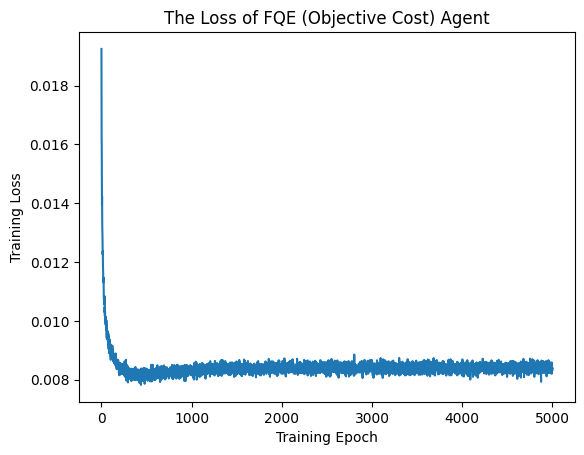

In [37]:
plt.plot(behavior_training_s1.FQE_loss_obj)

plt.title("The Loss of FQE (Objective Cost) Agent")
plt.xlabel("Training Epoch")
plt.ylabel("Training Loss")

# plt.savefig("../Experiment Figure/Behavior_fqe_obj_loss_20250325.png", 
#             dpi = 300, 
#             bbox_inches = 'tight')

plt.show()

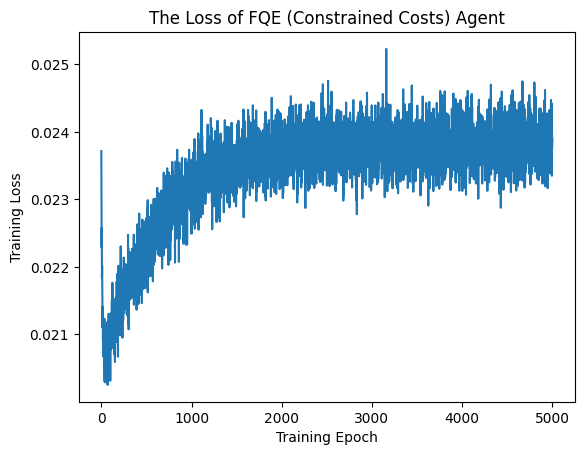

In [38]:
plt.plot(behavior_training_s1.FQE_loss_con[0])

plt.title("The Loss of FQE (Constrained Costs) Agent")
plt.xlabel("Training Epoch")
plt.ylabel("Training Loss")

# plt.savefig("../Experiment Figure/Behavior_fqe_con_rdm_loss_20250325.png", 
#             dpi = 300, 
#             bbox_inches = 'tight')


plt.show()

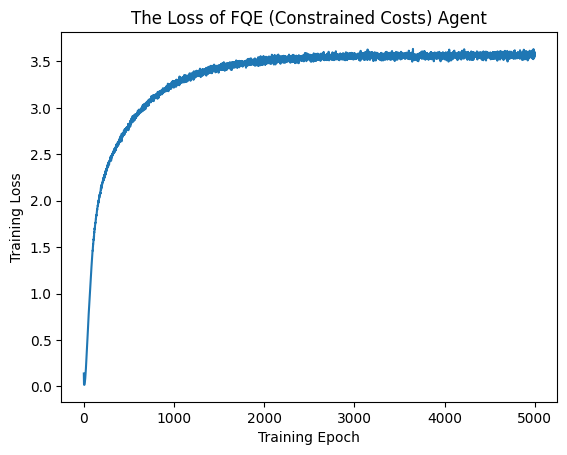

In [39]:
plt.plot(behavior_training_s1.FQE_loss_con[1])

plt.title("The Loss of FQE (Constrained Costs) Agent")
plt.xlabel("Training Epoch")
plt.ylabel("Training Loss")

# plt.savefig("../Experiment Figure/Behavior_fqe_con_los_loss_20250325.png", 
#             dpi = 300, 
#             bbox_inches ='tight')

plt.show()

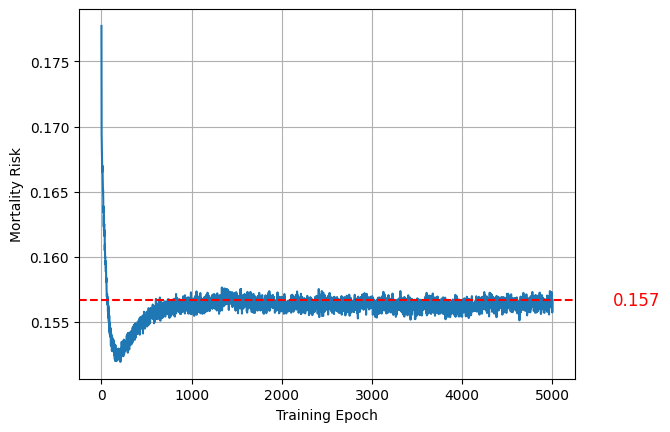

In [40]:
plt.plot(behavior_training_s1.FQE_est_obj_costs)

last_epoch = len(behavior_training_s1.FQE_est_obj_costs) - 1
last_value = behavior_training_s1.FQE_est_obj_costs[-1]

plt.text(last_epoch + 1200, last_value, f'{last_value:.3f}', ha = 'right', va = 'center', fontsize = 12, color = 'red')

plt.axhline(y = last_value, color = 'r', linestyle = '--')

# plt.title("The Average Estimated Value of Objective Costs by FQE")
plt.xlabel("Training Epoch")
# plt.ylabel(r"Mortality Risk ($\%$)")
plt.ylabel(r"Mortality Risk")
# plt.legend(prop = {'size': 8})
plt.grid(True)

# plt.savefig("../Experiment Figure/Behavior_fqe_obj_est_value_20250325.png", 
#             dpi = 300, 
#             bbox_inches = 'tight')

plt.show()

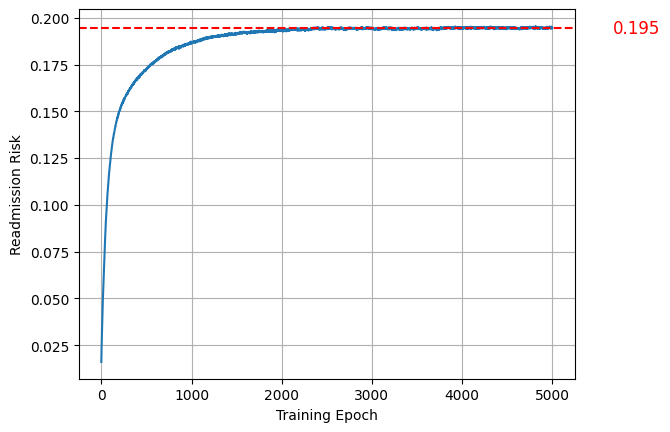

In [41]:
plt.plot(behavior_training_s1.FQE_est_con_costs[0])

last_epoch = len(behavior_training_s1.FQE_est_con_costs[0]) - 1
last_value = behavior_training_s1.FQE_est_con_costs[0][-1]

# plt.text(last_epoch + 1800, last_value, f'{last_value:.2f}', ha = 'right', va = 'center', fontsize = 12, color = 'red')
plt.text(last_epoch + 1200, last_value, f'{last_value:.3f}', ha = 'right', va = 'center', fontsize = 12, color = 'red')

plt.axhline(y = last_value, color = 'r', linestyle = '--')

# plt.title("The Average Estimated Value of Constrained Costs by FQE")
plt.xlabel("Training Epoch")
# plt.ylabel(r"Readmission Risk ($\%$)")
plt.ylabel(r"Readmission Risk")
# plt.legend(prop = {'size': 8})
plt.grid(True)

# plt.savefig("../Experiment Figure/Behavior_fqe_con_disch_fail_est_value_20250325.png", 
#             dpi = 300, 
#             bbox_inches = 'tight')

plt.show()

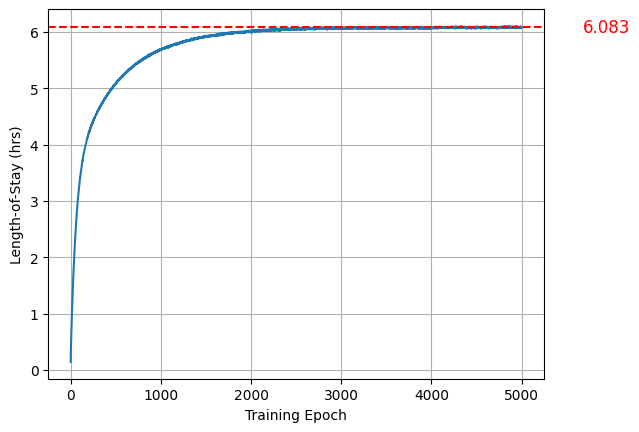

In [42]:
plt.plot(behavior_training_s1.FQE_est_con_costs[1])

last_epoch = len(behavior_training_s1.FQE_est_con_costs[1]) - 1
last_value = behavior_training_s1.FQE_est_con_costs[1][-1]

plt.text(last_epoch + 1200, last_value, f'{last_value:.3f}', ha = 'right', va = 'center', fontsize = 12, color = 'red')

plt.axhline(y = last_value, color = 'r', linestyle = '--')

# plt.title("The Average Estimated Value of Constrained Costs by FQE")
plt.xlabel("Training Epoch")
plt.ylabel(r"Length-of-Stay (hrs)")
# plt.legend(prop = {'size': 8})
plt.grid(True)

# plt.savefig("../Experiment Figure/Behavior_fqe_con_los_value_20250325.png", 
#             dpi = 300, 
#             bbox_inches = 'tight')

plt.show()

## Testing dataset - Behavior Policy

In [43]:
class TestDataLoader:
    def __init__(self, cfg, state_id_table, rl_cont_state_table, rl_cont_state_table_scaled, state_id_table_1, rl_cont_state_table_scaled_1, terminal_state):
        self.cfg = cfg
    
        # Load datasets
        self.state_df_id = state_id_table
        self.rl_cont_state_table = rl_cont_state_table
        self.rl_cont_state_table_scaled = rl_cont_state_table_scaled

        self.state_df_id_1 = state_id_table_1
        self.rl_cont_state_table_scaled_1 = rl_cont_state_table_scaled_1

        self.terminal_state = terminal_state

    def data_buffer_test(self, num_constraint = 2):
        self.test_memory = ReplayBuffer(self.cfg.memory_capacity)

        for i in range(len(self.state_df_id)):
            state = self.rl_cont_state_table_scaled.values[i]
            action = self.state_df_id['discharge_action'].values[i]

            if action == 1.0:
                if self.state_df_id['death'].values[i] == 1.0:
                    if self.state_df_id['discharge_fail'].values[i] == 1.0:
                        done = 0.0
                    else:
                        done = 1.0
                else:
                    if self.state_df_id['discharge_fail'].values[i] == 0.0:
                        done = 1.0
                    else:
                        done = 0.0
            else:
                done = 0.0
            
            obj_cost = self.state_df_id['mortality_costs_md'].values[i]
            con_cost = []
            
            for j in range(num_constraint):
                cost_col = f'con_cost_{j}'  
                if cost_col in self.state_df_id.columns:
                    con_cost.append(self.state_df_id[cost_col].values[i])
                else:
                    con_cost.append(0.0) 

            if done == 0.0:
                idx = self.state_df_id.index[i]
                next_state = self.rl_cont_state_table_scaled_1.loc[idx + 1].values
                next_action = self.state_df_id_1['discharge_action'].loc[idx + 1]
            else:
                next_state = self.terminal_state
                next_action = 1.0

            self.test_memory.push(state, action, obj_cost, con_cost, next_state, next_action, done)

    def data_torch_loader_test(self):
        state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, next_action_batch, done_batch = self.test_memory.extract()

        state_batch = torch.tensor(np.array(state_batch), device = self.cfg.device, dtype = torch.float)

        disch_batch = list(action_batch)
        action_batch = torch.tensor(np.array(action_batch), device = self.cfg.device, dtype = torch.long).unsqueeze(1)
        
        obj_cost_batch = torch.tensor(np.array(obj_cost_batch), device = self.cfg.device, dtype = torch.float)
        con_cost_batch = [torch.tensor(np.array(cost), device = self.cfg.device, dtype=torch.float) for cost in con_cost_batch]
        next_state_batch = torch.tensor(np.array(next_state_batch), device = self.cfg.device, dtype = torch.float)

        next_action_batch = torch.tensor(np.array(next_action_batch), device = self.cfg.device, dtype = torch.long).unsqueeze(1)

        done_batch = torch.tensor(np.array(done_batch), device = self.cfg.device, dtype = torch.float)
        disch_batch = torch.tensor(np.array(disch_batch), device = self.cfg.device, dtype = torch.float)

        return state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, next_action_batch, done_batch, disch_batch

In [44]:
class TestConfig:
    def __init__(self, constraint_num):
        
        self.constraint_num = constraint_num

        self.memory_capacity = int(2e6)  # capacity of Replay Memory

        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check GPU
        self.device = torch.device("cpu")

In [45]:
id_table_test = pd.read_csv('../data_output/id_table_test_v13.csv')
rl_table_test = pd.read_csv('../data_output/rl_table_test_v13.csv')
rl_table_test_scaled = pd.read_csv('../data_output/rl_table_test_scaled_v13.csv')

In [53]:
id_table_test = pd.read_csv('../data_output/id_table_val_v13.csv')
rl_table_test = pd.read_csv('../data_output/rl_table_val_v13.csv')
rl_table_test_scaled = pd.read_csv('../data_output/rl_table_val_scaled_v13.csv')

In [63]:
id_table_test = pd.read_csv('../data_output/id_table_train_v13.csv')
rl_table_test = pd.read_csv('../data_output/rl_table_train_v13.csv')
rl_table_test_scaled = pd.read_csv('../data_output/rl_table_train_scaled_v13.csv')

In [64]:
# rl_table_test.drop(columns = ['readmission_count'], inplace = True)
# rl_table_test_scaled.drop(columns = ['readmission_count'], inplace = True)

In [65]:
# Create a copy of the 'mortality_costs' column
id_table_test['mortality_costs_md'] = id_table_test['mortality_costs'].copy()

# Apply the conditions using vectorized operations
discharge_action_mask = id_table_test['discharge_action'] == 1
death_mask = id_table_test['death'] == 0
discharge_fail_mask = id_table_test['discharge_fail'] == 1

# Update 'mortality_costs_md' based on the conditions
id_table_test.loc[discharge_action_mask & death_mask, 'mortality_costs_md'] = 0
id_table_test.loc[discharge_action_mask & ~death_mask & discharge_fail_mask, 'mortality_costs_md'] = 0

In [66]:
id_table_test_initial = id_table_test[id_table_test['readmission_count'] == 0].copy()
id_table_test_initial = id_table_test_initial[id_table_test_initial['epoch'] == 1].copy()

mv_test_initial_index = id_table_test_initial.index
id_index_list_initial_test = mv_test_initial_index.tolist()

rl_table_test_initial = rl_table_test.loc[id_index_list_initial_test].copy()

rl_table_test_scaled_initial = rl_table_test_scaled.loc[id_index_list_initial_test].copy()

id_table_test_initial['con_cost_0'] = id_table_test_initial['discharge_fail_costs'].copy()
id_table_test_initial['con_cost_1'] = id_table_test_initial['los_costs_scaled'].copy()

test_cfg = TestConfig(constraint_num = 2)
terminal_state = np.zeros(rl_table_test_scaled.shape[1])
test_data_loader = TestDataLoader(test_cfg, 
                                  id_table_test_initial, 
                                  rl_table_test_initial, 
                                  rl_table_test_scaled_initial, 
                                  id_table_test, 
                                  rl_table_test_scaled, 
                                  terminal_state)

test_data_loader.data_buffer_test(num_constraint = 2)
state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, next_action_batch, done_batch, disch_batch = test_data_loader.data_torch_loader_test()

In [67]:
# test_cfg = TestConfig(constraint_num = 2)
# terminal_state = np.zeros(rl_table_test_scaled.shape[1])
# test_data_loader = TestDataLoader(test_cfg, id_table_test, rl_table_test, rl_table_test_scaled, terminal_state)
# test_data_loader.data_buffer_test(num_constraint = 2)
# state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, next_action_batch, done_batch, disch_batch = test_data_loader.data_torch_loader_test()

In [68]:
# behavior_fqe_obj_s1 = torch.load('../model_output/behavior_agent_s1_fqe_obj_20250303.pth', weights_only = False)
# behavior_fqe_con_disch_fail_s1 = torch.load('../model_output/behavior_agent_s1_fqe_con_disch_fail_20250303.pth', weights_only = False)
# behavior_fqe_con_los_s1 = torch.load('../model_output/behavior_agent_s1_fqe_con_los_20250303.pth', weights_only = False)

In [69]:
behavior_fqe_obj_s1 = agent_fqe_obj_s1
behavior_fqe_con_rr_s1 = agent_fqe_con_rr_s1
behavior_fqe_con_los_s1 = agent_fqe_con_los_s1

In [70]:
fqe_test_obj_costs_ocrl_1 = behavior_fqe_obj_s1.avg_Q_value_est(state_batch, action_batch)
fqe_test_con_rr_costs_ocrl_1 = behavior_fqe_con_rr_s1.avg_Q_value_est(state_batch, action_batch)
fqe_test_con_los_costs_ocrl_1 = behavior_fqe_con_los_s1.avg_Q_value_est(state_batch, action_batch)

In [71]:
[fqe_test_obj_costs_ocrl_1, fqe_test_con_rr_costs_ocrl_1]

[0.0815281942486763, 0.1466936618089676]

In [72]:
fqe_test_con_los_costs_ocrl_1

5.53506326675415

In [73]:
fqe_test_con_los_costs_ocrl_1 * 12

66.4207592010498

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
x = torch.linspace(-10, 10, 100)
y = F.elu(x, alpha = 1.2)

plt.plot(x.numpy(), y.numpy(), label= r"ELU ($\alpha = 1.2$)")
plt.axhline(y = 0, color = 'black', linestyle = '--', linewidth = 0.5)
plt.axvline(x = 0, color = 'black', linestyle = '--', linewidth = 0.5)
plt.title("Exponential Linear Unit (ELU)")
plt.xlabel("x")
plt.ylabel("ELU(x)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
x = torch.linspace(-10, 10, 200)
alpha = 0.02
y = F.leaky_relu(x, negative_slope=alpha)

plt.plot(x.numpy(), y.numpy(), label=f"LeakyReLU (α={alpha})")
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.title("Leaky ReLU Activation Function")
plt.xlabel("x")
plt.ylabel("LeakyReLU(x)")
plt.grid(True)
plt.legend()
plt.show()